In [1]:
from typing import Callable
import os

# choose the GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# disable preallocation of memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# pcx
import pcx as px
import pcx.predictive_coding as pxc
import pcx.nn as pxnn
import pcx.functional as pxf
import pcx.utils as pxu

# 3rd party
import jax
from jax import jit
import jax.numpy as jnp
import optax
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import timeit

# own
import causal_helpers
from causal_helpers import simulate_dag, simulate_parameter, simulate_linear_sem, simulate_linear_sem_cyclic
from causal_helpers import load_adjacency_matrix, set_random_seed, plot_adjacency_matrices

# Set random seed
seed = 23
set_random_seed(seed)

# causal libraries
import cdt, castle

# causal metrics
from cdt.metrics import precision_recall, SHD, SID
from castle.metrics import MetricsDAG
from castle.common import GraphDAG
from causallearn.graph.SHD import SHD as SHD_causallearn

# %% [markdown]
# ## Load the actual connectome data

# %%
# load the weighted adjacency matrices for ER and connectome

# Specify the folder where the adjacency matrices were saved
folder = '../data/'

# Example usage to load the saved adjacency matrices
G_A_init_t_ordered_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix.npy'))
G_A_init_t_ordered_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix.npy'))
ER = load_adjacency_matrix(os.path.join(folder, 'ER_adj_matrix.npy'))
ER_dag = load_adjacency_matrix(os.path.join(folder, 'ER_dag_adj_matrix.npy'))

# Change name of the connectome adjacency matrix to C and C_dag
C = G_A_init_t_ordered_adj_matrix
C_dag = G_A_init_t_ordered_dag_adj_matrix

# Now ensure that both DAG adjacency matrices are binary, if they aren't already
ER_dag_bin = (ER_dag != 0).astype(int)
C_dag_bin = (C_dag != 0).astype(int)

ER_true = ER_dag_bin
C_true = C_dag_bin

# %% [markdown]
# ## Create data to debug and implement the pcx version of NOTEARS

# %%
# actual data
#B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4
# debugging data
#B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2


#B_true = C_dag_bin # if you want to use the connectome-based DAG # best performance so far with 200,000 samples: 0.06 
#B_true = ER_dag_bin # if you want to use the ER-based DAG

#B_true = simulate_dag(d=5, s0=10, graph_type='ER') # ER2
B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
#B_true = simulate_dag(d=50, s0=100, graph_type='ER') # ER2
#B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
#B_true = simulate_dag(d=279, s0=558, graph_type='ER') # ER2

# create equivalent ER4 and ER6 graphs
#B_true = simulate_dag(d=279, s0=1116, graph_type='ER') # ER4
#B_true = simulate_dag(d=279, s0=1674, graph_type='ER') # ER6

# create SF2 graph with 10 nodes
#B_true = simulate_dag(d=10, s0=20, graph_type='SF') # SF2

# create equivalent SF4 and SF6 graphs
#B_true = simulate_dag(d=100, s0=600, graph_type='SF') # SF6
#B_true = simulate_dag(d=279, s0=1116, graph_type='SF') # SF4
#B_true = simulate_dag(d=279, s0=1674, graph_type='SF') # SF6


# create simple data using simulate_dag method from causal_helpers with expected number of edges (s0) and number of nodes (d)
#B_true = simulate_dag(d=100, s0=199, graph_type='ER') # we use p≈0.040226 for the connectome-based ER_dag graph. This means that the expected number of edges is 0.040226 * d * (d-1) / 2
# examples: d=50 -> s0=49 (works), d=100 -> s0=199, d=200 -> s0=800
W_true = simulate_parameter(B_true)

# sample data from the linear SEM
# actual data
#X = simulate_linear_sem(W_true, n=25000, sem_type='gauss')
# for debugging
X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')
#X = simulate_linear_sem(W_true, n=2500, sem_type='gauss')
#X = simulate_linear_sem(W_true, n=6250, sem_type='gauss')
#X = simulate_linear_sem(W_true, n=50000, sem_type='gauss')
#X = simulate_linear_sem(W_true, n=100000, sem_type='gauss') # 1000*(279**2)/(20**2) = 194602

# now standardized data, where each variable is normalized to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# NOTE: you may not write positional arguments after keyword arguments. 
# That is, the values that you are passing positionally have to come first!

# create a dataset using the simulated data
# NOTE: NOTEARS paper uses n=1000 for graph with d=20.
# NOTE: d... number of nodes, p=d^2... number of parameters, n... number of samples. Then: comparing p1=d1^2 vs p2=d2^2 we have that: n1/p1 must be equal to n2/p2
# Thus we have n2 = n1 * p2 / p1. For the case of d2=100 we have that n2 = (n1*p2)/p1 = 1000*(100^2)/(20^2) = 25000 
# we should expect to use that many samples actually to be able to learn the graph in a comparable way.
#dataset = IIDSimulation(W=W_true, n=25000, method='linear', sem_type='gauss')
#true_dag, X = dataset.B, dataset.X

# print the number of edges in the true graph
print(f"The number of edges in the true graph: {np.sum(B_true)}")

# %%
import pcx.utils as pxu
print(dir(pxu))

/share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detecting CUDA device(s) : [0]


Adjacency matrix loaded from ../data/G_A_init_t_ordered_adj_matrix.npy
Adjacency matrix loaded from ../data/G_A_init_t_ordered_dag_adj_matrix.npy
Adjacency matrix loaded from ../data/ER_adj_matrix.npy
Adjacency matrix loaded from ../data/ER_dag_adj_matrix.npy
The number of edges in the true graph: 20.0
['M', 'M_has', 'M_hasnot', 'M_is', 'Optim', 'OptimTree', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_mask', '_misc', '_optim', '_serialisation', 'load_params', 'save_params', 'step']


In [2]:
# ## Implement the PCX version of NOTEARS ##

# v1: single vode
class Complete_Graph(pxc.EnergyModule):
    def __init__(
        self, 
        input_dim: int, 
        n_nodes: int, 
        hidden_dim: int = 3, 
        act_fn: Callable[[jax.Array], jax.Array] = jax.nn.relu,
        has_bias: bool = False
    ) -> None:
        super().__init__()

        self.input_dim = px.static(input_dim)
        self.n_nodes = px.static(n_nodes)
        self.hidden_dim = px.static(hidden_dim)
        self.has_bias = has_bias
        self.act_fn = px.static(act_fn)

        # Initialize MLPs for each connection (n_nodes x n_nodes matrix of MLPs)
        self.mlp_layers = []
        for i in range(n_nodes):
            node_layers = []
            for j in range(n_nodes):
                # Create MLP: input_dim -> hidden_dim -> input_dim
                mlp = [
                    pxnn.Linear(input_dim, hidden_dim, bias=has_bias),
                    pxnn.Linear(hidden_dim, input_dim, bias=has_bias)
                ]
                node_layers.append(mlp)

            self.mlp_layers.append(node_layers)

        # Initialize adjacency matrix as a LayerParam
        init_weights = jnp.ones((n_nodes, n_nodes))
        init_weights = jax.numpy.fill_diagonal(init_weights, 0.0, inplace=False)
        self.adj_weights = pxnn.LayerParam(init_weights)

        # Initialize vodes
        #self.vodes = [pxc.Vode((n_nodes, input_dim))]
        self.vodes = [pxc.Vode()]

    def freeze_nodes(self, freeze=True):
        self.vodes[0].h.frozen = freeze

    def are_vodes_frozen(self):
        return self.vodes[0].h.frozen
    
    def get_W(self):
        """Returns the weighted adjacency matrix."""
        return self.adj_weights.get()

    def mlp_forward(self, x, i, j):

        # print the shape of x
        print(f"The shape of x in mlp_forward: {x.shape}")

        """Forward pass through MLP for connection i->j with nonlinear activation."""
        if i == j:  # Skip self-loops
            return 0.0
        
        # First layer with nonlinear activation
        h = self.act_fn(self.mlp_layers[i][j][0](x))
        # Second layer
        out = self.mlp_layers[i][j][1](h)
        
        return out

    def __call__(self, x=None):
        n_nodes = self.n_nodes.get()
        input_dim = self.input_dim.get()
        
        if x is not None:
            # Initialize nodes with given data
            reshaped_x = x.reshape(n_nodes, input_dim)
            self.vodes[0](reshaped_x)
        else:
            # Get current node values
            x_ = self.vodes[0].get('h')

            # print the shape of x_ in __call__ else statement
            print(f"The shape of x_ in __call__ else statement: {x_.shape}")
            
            # Compute weighted sum of MLP outputs for each node
            outputs = []
            for j in range(n_nodes):
                node_output = 0
                for i in range(n_nodes):
                    # Apply MLP and weight by adjacency matrix entry
                    mlp_out = self.mlp_forward(x_[i], i, j)
                    node_output += self.adj_weights.get()[i, j] * mlp_out
                outputs.append(node_output)
            
            # Stack outputs and update vodes
            output = jnp.stack(outputs)
            self.vodes[0](output) # TODO: do we need this line or should we remove it?

        return self.vodes[0].get('h')

In [3]:
# Usage
input_dim = 1
n_nodes = X.shape[1]
#model = Complete_Graph(input_dim, n_nodes, has_bias=False)
model = Complete_Graph(input_dim, n_nodes, has_bias=True, act_fn=jax.nn.leaky_relu)

# Get weighted adjacency matrix
W = model.get_W()
print(W)
print()
print(W.shape)
print(model)


# Freezing all nodes
model.freeze_nodes(freeze=True)

# Check if all nodes are frozen
print(model.are_vodes_frozen())

# Unfreezing all nodes
model.freeze_nodes(freeze=False)

# Check if all nodes are frozen
print(model.are_vodes_frozen())

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]

(10, 10)
(Complete_Graph):
  .has_bias: True
  .mlp_layers[0][0][0].nn.weight: LayerParam([3,1], float32)
  .mlp_layers[0][0][0].nn.bias: LayerParam([3], float32)
  .mlp_layers[0][0][1].nn.weight: LayerParam([1,3], float32)
  .mlp_layers[0][0][1].nn.bias: LayerParam([1], float32)
  .mlp_layers[0][1][0].nn.weight: LayerParam([3,1], float32)
  .mlp_layers[0][1][0].nn.bias: LayerParam([3], float32)
  .mlp_layers[0][1][1].nn.weight: LayerParam([1,3], float32)
  .mlp_layers[0][1][1].nn.bias: LayerParam([1], float32)
  .mlp_layers[0][2][0].nn.weight: LayerParam([3,1], float32)
  .mlp_layers[0][2][0].nn.bias: LayerParam([3], float32)
  .mlp_layers[0][2][1].nn.weight:

In [11]:
# TODO: make the below params global or input to the functions in which it is used.
w_learning_rate = 1e-2 # Notes: 5e-1 is too high
h_learning_rate = 5e-4
T = 1

nm_epochs = 5000
batch_size = 256

lam_h = 1e-1 # 2e2 -> 5e2 # this move works well! FIRST MOVE
lam_l1 = 1e-5 # 1e-2 -> 3e-2 # this move works well! SECOND MOVE

In [12]:
# Training and evaluation functions
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), in_axes=(0,), out_axes=0)
def forward(x, *, model: Complete_Graph):
    print("Forward: Starting")
    result = model(x)
    print("Forward: Completed")
    return result

@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, 0), axis_name="batch")
def energy(*, model: Complete_Graph):
    print("Energy: Starting computation")
    x_ = model(None)
    print("Energy: Got model output")
    
    W = model.get_W()
    d = model.n_nodes.get()
    print(f"Energy: Got W (shape: {W.shape}) and d: {d}")

    # PC energy term
    pc_energy = model.energy()
    print(f"Energy: PC energy term: {pc_energy}")

    # L1 regularization using adjacency matrix
    #l1_reg = jnp.sum(jnp.abs(W))
    # 11 Nov 2024: try normalizing the L1 regularization term by the number of nodes
    l1_reg = jnp.sum(jnp.abs(W)) / d
    print(f"Energy: L1 reg term: {l1_reg}")

    # DAG constraint
    #h_reg = jnp.trace(jax.scipy.linalg.expm(jnp.multiply(W, W))) - d
    # 11 Nov 2024: try normalizing the DAG constraint term by the number of nodes
    h_reg = jnp.trace(jax.scipy.linalg.expm(jnp.multiply(W, W))) / d
    print(f"Energy: DAG constraint term: {h_reg}")
    
    # Combined loss
    obj = jax.lax.pmean(pc_energy, axis_name="batch") + lam_h * h_reg + lam_l1 * l1_reg
    #obj = jax.lax.psum(pc_energy, axis_name="batch") + lam_h * h_reg + lam_l1 * l1_reg
    
    print(f"Energy: Final objective: {obj}")

    return obj, x_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    print("1. Starting train_on_batch")  

    model.train()
    print("2. Model set to train mode")

    model.freeze_nodes(freeze=True)
    print("3. Nodes frozen")

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        print("4. Doing forward for initialization")
        forward(x, model=model)
        print("5. After forward for initialization")
        
    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("6. Before computing gradients")

        # 10 Nov 2024: try new library version syntax
        #_, g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(model=model)
        (obj, x_), g = pxf.value_and_grad(pxu.M(pxnn.LayerParam).to([False, True]), has_aux=True)(energy)(model=model)
        
        print("7. After computing gradients")
        print("Gradient structure:", g)

        print("8. Before zeroing out the diagonal gradients")
        # Zero out the diagonal gradients using jax.numpy.fill_diagonal
        weight_grads = g["model"].adj_weights.get()
        weight_grads = jax.numpy.fill_diagonal(weight_grads, 0.0, inplace=False)
        g["model"].adj_weights.set(weight_grads)
        print("9. After zeroing out the diagonal gradients")

        
    print("10. Before optimizer step")
    optim_w.step(model, g["model"])
    #optim_w.step(model, g["model"], scale_by=1.0/x.shape[0])
    print("11. After optimizer step")

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("12. Before final forward")
        forward(None, model=model)
        e_avg_per_sample = model.energy()
        print("13. After final forward")

    model.freeze_nodes(freeze=False)
    print("14. Nodes unfrozen")

    return e_avg_per_sample

def train(dl, T, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    e_avg_per_sample_energies = []
    for batch in dl:

        e_avg_per_sample = train_on_batch(T, batch, model=model, optim_w=optim_w, optim_h=optim_h)
        e_avg_per_sample_energies.append(e_avg_per_sample)

    W = model.get_W()

    # compute epoch energy
    epoch_energy = jnp.mean(jnp.array(e_avg_per_sample_energies))
    return W, epoch_energy

# %%
@jit
def MAE(W_true, W):
    """This function returns the Mean Absolute Error for the difference between the true weighted adjacency matrix W_true and th estimated one, W."""
    MAE_ = jnp.mean(jnp.abs(W - W_true))
    return MAE_

def compute_binary_adjacency(W, threshold=0.3):
    """
    Compute the binary adjacency matrix by thresholding the input matrix.

    Args:
    - W (array-like): The weighted adjacency matrix (can be a JAX array or a NumPy array).
    - threshold (float): The threshold value to determine the binary matrix. Default is 0.3.

    Returns:
    - B_est (np.ndarray): The binary adjacency matrix where each element is True if the corresponding 
                          element in W is greater than the threshold, otherwise False.
    """
    # Convert JAX array to NumPy array if necessary
    if isinstance(W, jnp.ndarray):
        W = np.array(W)

    # Compute the binary adjacency matrix
    B_est = np.array(np.abs(W) > threshold)
    
    return B_est


def ensure_DAG(W):
    """
    Ensure that the weighted adjacency matrix corresponds to a DAG.

    Inputs:
        W: numpy.ndarray - a weighted adjacency matrix representing a directed graph

    Outputs:
        W: numpy.ndarray - a weighted adjacency matrix without cycles (DAG)
    """
    # Convert the adjacency matrix to a directed graph
    g = nx.DiGraph(W)

    # Make a copy of the graph to modify
    gg = g.copy()

    # Remove cycles by removing edges
    while not nx.is_directed_acyclic_graph(gg):
        h = gg.copy()

        # Remove all the sources and sinks
        while True:
            finished = True

            for node, in_degree in nx.in_degree_centrality(h).items():
                if in_degree == 0:
                    h.remove_node(node)
                    finished = False

            for node, out_degree in nx.out_degree_centrality(h).items():
                if out_degree == 0:
                    h.remove_node(node)
                    finished = False

            if finished:
                break

        # Find a cycle with a random walk starting at a random node
        node = list(h.nodes)[0]
        cycle = [node]
        while True:
            edges = list(h.out_edges(node))
            _, node = edges[np.random.choice(len(edges))]

            if node in cycle:
                break

            cycle.append(node)

        # Extract the cycle path and adjust it to start at the first occurrence of the repeated node
        cycle = np.array(cycle)
        i = np.argwhere(cycle == node)[0][0]
        cycle = cycle[i:]
        cycle = cycle.tolist() + [node]

        # Find edges in that cycle
        edges = list(zip(cycle[:-1], cycle[1:]))

        # Randomly pick an edge to remove
        edge = edges[np.random.choice(len(edges))]
        gg.remove_edge(*edge)

    # Convert the modified graph back to a weighted adjacency matrix
    W_acyclic = nx.to_numpy_array(gg)

    return W_acyclic

In [13]:
# for reference compute the MAE, SID, and SHD between the true adjacency matrix and an all-zero matrix and then print it
# this acts as a baseline for the MAE, SID, and SHD similar to how 1/K accuracy acts as a baseline for classification tasks where K is the number of classes
W_zero = np.zeros_like(W_true)
print("MAE between the true adjacency matrix and an all-zero matrix: ", MAE(W_true, W_zero))
print("SHD between the true adjacency matrix and an all-zero matrix: ", SHD(B_true, compute_binary_adjacency(W_zero)))
#print("SID between the true adjacency matrix and an all-zero matrix: ", SID(W_true, W_zero))

# %%
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# This is a simple collate function that stacks numpy arrays used to interface
# the PyTorch dataloader with JAX. In the future we hope to provide custom dataloaders
# that are independent of PyTorch.
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# The dataloader assumes cuda is being used, as such it sets 'pin_memory = True' and
# 'prefetch_factor = 2'. Note that the batch size should be constant during training, so
# we set 'drop_last = True' to avoid having to deal with variable batch sizes.
class TorchDataloader(torch.utils.data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=None,
        sampler=None,
        batch_sampler=None,
        num_workers=1,
        pin_memory=True,
        timeout=0,
        worker_init_fn=None,
        persistent_workers=True,
        prefetch_factor=2,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=True if batch_sampler is None else None,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor,
        )


# Create the custom dataset
dataset = CustomDataset(X)
# Create the custom dataset with standardized data
dataset_std = CustomDataset(X_std)

# Create the dataloader
dl = TorchDataloader(dataset, batch_size=batch_size, shuffle=True)
######## OR ########
#dl = TorchDataloader(dataset_std, batch_size=batch_size, shuffle=True)

# %%
# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jnp.zeros((batch_size, model.n_nodes.get())), model=model)
    # 10 Nov 2024: try new library version syntax
    # optim_h = pxu.Optim(optax.sgd(h_learning_rate), pxu.Mask(pxc.VodeParam)(model))
    optim_h = pxu.Optim(lambda: optax.sgd(h_learning_rate))
    #optim_h = pxu.Optim(lambda: optax.sgd(h_learning_rate, momentum=0.5, nesterov=True))

    """
    optim_w = pxu.Optim(
    optax.chain(
        optax.clip_by_global_norm(clip_value),  # Clip gradients by global norm
        optax.sgd(w_learning_rate)  # Apply SGD optimizer
    ),
    pxu.Mask(pxnn.LayerParam)(model)  # Masking the parameters of the model
)
    """
    #optim_w = pxu.Optim(optax.adafactor(w_learning_rate), pxu.Mask(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(optax.sgd(w_learning_rate, momentum=0.95), pxu.Mask(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(optax.adamw(w_learning_rate, weight_decay=5e-2), pxu.Mask(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(optax.adamw(w_learning_rate, nesterov=True), pxu.Mask(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(optax.adamw(w_learning_rate, nesterov=False), pxu.Mask(pxnn.LayerParam)(model))

    # 10 Nov 2024: try new library version syntax
    optim_w = pxu.Optim(lambda: optax.adam(w_learning_rate), pxu.M(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(lambda: optax.adam(w_learning_rate, nesterov=True), pxu.M(pxnn.LayerParam)(model))
    # Option 2: AdamW optimizer (with weight decay)
    #optim_w = pxu.Optim(lambda: optax.adamw(w_learning_rate, weight_decay=1e-4, nesterov=True), pxu.M(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(lambda: optax.adamw(w_learning_rate), pxu.M(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(lambda: optax.sgd(w_learning_rate, momentum=0.9, nesterov=True), pxu.M(pxnn.LayerParam)(model))

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


MAE between the true adjacency matrix and an all-zero matrix:  0.27927107
SHD between the true adjacency matrix and an all-zero matrix:  20.0
Forward: Starting
Forward: Completed


In [7]:
# Initialize lists to store differences and energies
MAEs = []
SHDs = []
energies = []

In [17]:
lam_h = 1e-1 # 2e2 -> 5e2 # this move works well! FIRST MOVE
lam_l1 = 1e-5 # 1e-2 -> 3e-2 # this move works well! SECOND MOVE

list_lam_h = [1e-1, 1e0, 1e1, 1e2]

# after changing the regularization parameters, we need to at least redefine the energy function as it uses the regularization parameters lam

# Training and evaluation functions
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), in_axes=(0,), out_axes=0)
def forward(x, *, model: Complete_Graph):
    print("Forward: Starting")
    result = model(x)
    print("Forward: Completed")
    return result

@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, 0), axis_name="batch")
def energy(*, model: Complete_Graph):
    print("Energy: Starting computation")
    x_ = model(None)
    print("Energy: Got model output")
    
    W = model.get_W()
    d = model.n_nodes.get()
    print(f"Energy: Got W (shape: {W.shape}) and d: {d}")

    # PC energy term
    pc_energy = model.energy()
    print(f"Energy: PC energy term: {pc_energy}")

    # L1 regularization using adjacency matrix
    #l1_reg = jnp.sum(jnp.abs(W))
    # 11 Nov 2024: try normalizing the L1 regularization term by the number of nodes
    l1_reg = jnp.sum(jnp.abs(W)) / d
    print(f"Energy: L1 reg term: {l1_reg}")

    # DAG constraint
    #h_reg = jnp.trace(jax.scipy.linalg.expm(jnp.multiply(W, W))) - d
    # 11 Nov 2024: try normalizing the DAG constraint term by the number of nodes
    h_reg = jnp.trace(jax.scipy.linalg.expm(jnp.multiply(W, W))) / d
    print(f"Energy: DAG constraint term: {h_reg}")
    
    # Combined loss
    obj = jax.lax.pmean(pc_energy, axis_name="batch") + lam_h * h_reg + lam_l1 * l1_reg
    #obj = jax.lax.psum(pc_energy, axis_name="batch") + lam_h * h_reg + lam_l1 * l1_reg
    
    print(f"Energy: Final objective: {obj}")

    return obj, x_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    print("1. Starting train_on_batch")  

    model.train()
    print("2. Model set to train mode")

    model.freeze_nodes(freeze=True)
    print("3. Nodes frozen")

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        print("4. Doing forward for initialization")
        forward(x, model=model)
        print("5. After forward for initialization")
        
    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("6. Before computing gradients")

        # 10 Nov 2024: try new library version syntax
        #_, g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(model=model)
        (obj, x_), g = pxf.value_and_grad(pxu.M(pxnn.LayerParam).to([False, True]), has_aux=True)(energy)(model=model)
        
        print("7. After computing gradients")
        print("Gradient structure:", g)

        print("8. Before zeroing out the diagonal gradients")
        # Zero out the diagonal gradients using jax.numpy.fill_diagonal
        weight_grads = g["model"].adj_weights.get()
        weight_grads = jax.numpy.fill_diagonal(weight_grads, 0.0, inplace=False)
        g["model"].adj_weights.set(weight_grads)
        print("9. After zeroing out the diagonal gradients")

        
    print("10. Before optimizer step")
    optim_w.step(model, g["model"])
    #optim_w.step(model, g["model"], scale_by=1.0/x.shape[0])
    print("11. After optimizer step")

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("12. Before final forward")
        forward(None, model=model)
        e_avg_per_sample = model.energy()
        print("13. After final forward")

    model.freeze_nodes(freeze=False)
    print("14. Nodes unfrozen")

    return e_avg_per_sample

def train(dl, T, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    e_avg_per_sample_energies = []
    for batch in dl:

        e_avg_per_sample = train_on_batch(T, batch, model=model, optim_w=optim_w, optim_h=optim_h)
        e_avg_per_sample_energies.append(e_avg_per_sample)

    W = model.get_W()

    # compute epoch energy
    epoch_energy = jnp.mean(jnp.array(e_avg_per_sample_energies))
    return W, epoch_energy

In [18]:
# Calculate the initial MAE, SID, and SHD
MAE_init = MAE(W_true, model.get_W())
print(f"Start difference (cont.) between W_true and W_init: {MAE_init:.4f}")

SHD_init = SHD(B_true, compute_binary_adjacency(model.get_W()))
print(f"Start SHD between B_true and B_init: {SHD_init:.4f}")

# print the values of the diagonal of the initial W
print("The diagonal of the initial W: ", jnp.diag(model.get_W()))

# Start timing
start_time = timeit.default_timer()

# Training loop
with tqdm(range(nm_epochs), position=0, leave=True) as pbar:
    for epoch in pbar:
            
        # Train for one epoch using the dataloader
        W, epoch_energy = train(dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
        
        # Calculate the metrics and store them
        W = np.array(W)
        MAEs.append(float(MAE(W_true, W)))
        SHDs.append(float(SHD(B_true, compute_binary_adjacency(W))))
        energies.append(float(epoch_energy))

        # show the first 5x5 submatrix of W after each epoch
        print("\nW matrix (first 5x5):")
        print(np.array2string(W[:5,:5], precision=3, suppress_small=True, separator=', '))
        
        # Update progress bar with the current status
        pbar.set_description(f"MAE {MAEs[-1]:.4f}, SHD {SHDs[-1]:.4f} || Energy {energies[-1]:.4f}")

# End timing
end_time = timeit.default_timer()

# Print the average time per epoch
average_time_per_epoch = (end_time - start_time) / nm_epochs
print(f"An epoch (with compiling and testing) took on average: {average_time_per_epoch:.4f} seconds")
# print the values of the diagonal of the final W
print("The diagonal of the final W: ", jnp.diag(model.get_W()))

# %%
print(model)
print()
with pxu.step(model, clear_params=pxc.VodeParam.Cache):
    (obj, x_), g = pxf.value_and_grad(pxu.M(pxnn.LayerParam).to([False, True]), has_aux=True)(energy)(model=model)
    print(g["model"])

Start difference (cont.) between W_true and W_init: 0.4458
Start SHD between B_true and B_init: 24.0000
The diagonal of the initial W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


  0%|          | 0/5000 [00:00<?, ?it/s]

1. Starting train_on_batch
2. Model set to train mode
3. Nodes frozen
4. Doing forward for initialization
Forward: Starting
Forward: Completed
5. After forward for initialization
6. Before computing gradients
Energy: Starting computation
The shape of x_ in __call__ else statement: (10, 1)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forw

MAE 0.4459, SHD 24.0000 || Energy 1.9201:   0%|          | 1/5000 [00:12<17:35:54, 12.67s/it]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.059],
 [1.69 , 0.   , 0.475, 0.407, 0.218],
 [0.544, 0.21 , 0.   , 0.144, 0.09 ],
 [1.806, 0.196, 0.303, 0.   , 0.142],
 [0.379, 0.253, 1.057, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.063],
 [1.689, 0.   , 0.475, 0.408, 0.222],
 [0.543, 0.208, 0.   , 0.146, 0.092],
 [1.807, 0.198, 0.304, 0.   , 0.14 ],
 [0.383, 0.253, 1.057, 0.336, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.9258:   0%|          | 5/5000 [00:13<2:19:44,  1.68s/it] 


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.043, 0.064],
 [1.689, 0.   , 0.475, 0.408, 0.222],
 [0.543, 0.209, 0.   , 0.147, 0.093],
 [1.806, 0.196, 0.303, 0.   , 0.142],
 [0.384, 0.252, 1.056, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.047, 0.064],
 [1.69 , 0.   , 0.475, 0.407, 0.22 ],
 [0.546, 0.211, 0.   , 0.149, 0.094],
 [1.806, 0.197, 0.302, 0.   , 0.143],
 [0.389, 0.256, 1.056, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.044, 0.066],
 [1.69 , 0.   , 0.472, 0.406, 0.222],
 [0.543, 0.208, 0.   , 0.147, 0.093],
 [1.806, 0.194, 0.299, 0.   , 0.143],
 [0.391, 0.253, 1.053, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.291, 0.044, 0.064],
 [1.69 , 0.   , 0.477, 0.408, 0.22 ],
 [0.543, 0.21 , 0.   , 0.146, 0.093],
 [1.806, 0.198, 0.302, 0.   , 0.145],
 [0.392, 0.254, 1.056, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.045, 0.065],
 [1.691, 0.   , 0.473, 0.405, 0.222],
 [0.545, 0.208, 0.   , 0.146, 0.093],
 [1.806, 0.

MAE 0.4450, SHD 24.0000 || Energy 1.9016:   0%|          | 8/5000 [00:13<1:08:33,  1.21it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.048, 0.067],
 [1.689, 0.   , 0.475, 0.405, 0.223],
 [0.547, 0.209, 0.   , 0.144, 0.095],
 [1.807, 0.194, 0.301, 0.   , 0.14 ],
 [0.398, 0.253, 1.055, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.064],
 [1.69 , 0.   , 0.474, 0.404, 0.221],
 [0.543, 0.21 , 0.   , 0.142, 0.092],
 [1.807, 0.198, 0.303, 0.   , 0.142],
 [0.396, 0.256, 1.056, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.044, 0.062],
 [1.689, 0.   , 0.475, 0.407, 0.221],
 [0.543, 0.21 , 0.   , 0.143, 0.092],
 [1.807, 0.197, 0.303, 0.   , 0.142],
 [0.392, 0.253, 1.057, 0.336, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.8574:   0%|          | 14/5000 [00:13<28:02,  2.96it/s] 


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.043, 0.061],
 [1.69 , 0.   , 0.476, 0.407, 0.22 ],
 [0.55 , 0.209, 0.   , 0.144, 0.093],
 [1.807, 0.198, 0.304, 0.   , 0.145],
 [0.39 , 0.255, 1.058, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.293, 0.045, 0.064],
 [1.689, 0.   , 0.474, 0.405, 0.224],
 [0.546, 0.21 , 0.   , 0.147, 0.091],
 [1.807, 0.191, 0.3  , 0.   , 0.143],
 [0.386, 0.252, 1.055, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.042, 0.062],
 [1.69 , 0.   , 0.476, 0.409, 0.222],
 [0.541, 0.209, 0.   , 0.147, 0.092],
 [1.807, 0.196, 0.303, 0.   , 0.142],
 [0.383, 0.255, 1.057, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.042, 0.061],
 [1.69 , 0.   , 0.475, 0.406, 0.221],
 [0.547, 0.209, 0.   , 0.144, 0.089],
 [1.806, 0.194, 0.3  , 0.   , 0.142],
 [0.38 , 0.25 , 1.055, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.064],
 [1.69 , 0.   , 0.475, 0.407, 0.222],
 [0.546, 0.206, 0.   , 0.143, 0.092],
 [1.806, 0.

MAE 0.4463, SHD 25.0000 || Energy 1.9250:   0%|          | 17/5000 [00:13<19:34,  4.24it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.06 ],
 [1.689, 0.   , 0.476, 0.408, 0.22 ],
 [0.541, 0.21 , 0.   , 0.145, 0.088],
 [1.807, 0.194, 0.303, 0.   , 0.143],
 [0.385, 0.252, 1.057, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.062],
 [1.69 , 0.   , 0.475, 0.406, 0.221],
 [0.544, 0.209, 0.   , 0.145, 0.093],
 [1.806, 0.192, 0.3  , 0.   , 0.138],
 [0.385, 0.253, 1.054, 0.337, 0.   ]]


MAE 0.4464, SHD 24.0000 || Energy 1.8667:   0%|          | 22/5000 [00:14<12:39,  6.55it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.061],
 [1.689, 0.   , 0.475, 0.407, 0.221],
 [0.548, 0.209, 0.   , 0.143, 0.09 ],
 [1.807, 0.189, 0.301, 0.   , 0.138],
 [0.386, 0.253, 1.056, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.057],
 [1.689, 0.   , 0.477, 0.407, 0.217],
 [0.546, 0.211, 0.   , 0.141, 0.088],
 [1.808, 0.191, 0.301, 0.   , 0.137],
 [0.388, 0.254, 1.057, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.042, 0.06 ],
 [1.69 , 0.   , 0.474, 0.405, 0.22 ],
 [0.541, 0.207, 0.   , 0.143, 0.091],
 [1.806, 0.191, 0.299, 0.   , 0.135],
 [0.387, 0.252, 1.054, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.046, 0.062],
 [1.689, 0.   , 0.478, 0.41 , 0.222],
 [0.542, 0.207, 0.   , 0.145, 0.087],
 [1.808, 0.193, 0.302, 0.   , 0.133],
 [0.389, 0.25 , 1.057, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.041, 0.06 ],
 [1.69 , 0.   , 0.475, 0.404, 0.216],
 [0.544, 0.209, 0.   , 0.146, 0.092],
 [1.806, 0.

MAE 0.4465, SHD 24.0000 || Energy 1.9484:   0%|          | 22/5000 [00:14<12:39,  6.55it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.042, 0.067],
 [1.69 , 0.   , 0.476, 0.407, 0.222],
 [0.542, 0.209, 0.   , 0.147, 0.089],
 [1.805, 0.189, 0.298, 0.   , 0.136],
 [0.389, 0.25 , 1.053, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.065],
 [1.69 , 0.   , 0.478, 0.407, 0.218],
 [0.543, 0.209, 0.   , 0.149, 0.093],
 [1.807, 0.192, 0.304, 0.   , 0.135],
 [0.397, 0.253, 1.058, 0.333, 0.   ]]


MAE 0.4466, SHD 24.0000 || Energy 1.9007:   1%|          | 27/5000 [00:14<09:40,  8.57it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.042, 0.063],
 [1.69 , 0.   , 0.475, 0.406, 0.216],
 [0.542, 0.209, 0.   , 0.145, 0.088],
 [1.806, 0.194, 0.301, 0.   , 0.14 ],
 [0.403, 0.253, 1.054, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.07 ],
 [1.689, 0.   , 0.477, 0.406, 0.223],
 [0.54 , 0.207, 0.   , 0.143, 0.089],
 [1.806, 0.193, 0.303, 0.   , 0.138],
 [0.406, 0.252, 1.058, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.066],
 [1.691, 0.   , 0.477, 0.406, 0.218],
 [0.54 , 0.207, 0.   , 0.143, 0.089],
 [1.806, 0.198, 0.303, 0.   , 0.14 ],
 [0.412, 0.252, 1.057, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.066],
 [1.688, 0.   , 0.474, 0.404, 0.219],
 [0.543, 0.21 , 0.   , 0.145, 0.089],
 [1.808, 0.195, 0.301, 0.   , 0.135],
 [0.409, 0.253, 1.055, 0.335, 0.   ]]


MAE 0.4465, SHD 25.0000 || Energy 1.9237:   1%|          | 29/5000 [00:14<08:15, 10.02it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.042, 0.066],
 [1.691, 0.   , 0.477, 0.407, 0.22 ],
 [0.545, 0.209, 0.   , 0.147, 0.092],
 [1.805, 0.191, 0.302, 0.   , 0.134],
 [0.406, 0.254, 1.056, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.063],
 [1.688, 0.   , 0.475, 0.408, 0.22 ],
 [0.544, 0.211, 0.   , 0.148, 0.089],
 [1.808, 0.192, 0.301, 0.   , 0.139],
 [0.403, 0.255, 1.055, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.066],
 [1.69 , 0.   , 0.475, 0.405, 0.22 ],
 [0.543, 0.211, 0.   , 0.149, 0.096],
 [1.806, 0.193, 0.3  , 0.   , 0.141],
 [0.396, 0.257, 1.054, 0.337, 0.   ]]


MAE 0.4466, SHD 24.0000 || Energy 1.9128:   1%|          | 34/5000 [00:15<07:16, 11.38it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.047, 0.061],
 [1.689, 0.   , 0.476, 0.407, 0.219],
 [0.544, 0.209, 0.   , 0.148, 0.09 ],
 [1.807, 0.193, 0.301, 0.   , 0.144],
 [0.389, 0.255, 1.056, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.041, 0.06 ],
 [1.69 , 0.   , 0.474, 0.405, 0.218],
 [0.543, 0.21 , 0.   , 0.142, 0.093],
 [1.806, 0.198, 0.3  , 0.   , 0.142],
 [0.382, 0.256, 1.055, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.045, 0.064],
 [1.691, 0.   , 0.477, 0.407, 0.22 ],
 [0.543, 0.209, 0.   , 0.141, 0.094],
 [1.805, 0.196, 0.302, 0.   , 0.139],
 [0.377, 0.253, 1.056, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.065],
 [1.689, 0.   , 0.475, 0.404, 0.222],
 [0.545, 0.208, 0.   , 0.145, 0.093],
 [1.807, 0.197, 0.303, 0.   , 0.14 ],
 [0.373, 0.255, 1.057, 0.335, 0.   ]]


MAE 0.4464, SHD 24.0000 || Energy 1.9207:   1%|          | 39/5000 [00:15<05:42, 14.47it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.046, 0.062],
 [1.69 , 0.   , 0.477, 0.406, 0.218],
 [0.545, 0.212, 0.   , 0.147, 0.094],
 [1.806, 0.199, 0.303, 0.   , 0.142],
 [0.372, 0.254, 1.056, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.041, 0.065],
 [1.69 , 0.   , 0.475, 0.407, 0.222],
 [0.543, 0.207, 0.   , 0.138, 0.091],
 [1.806, 0.199, 0.304, 0.   , 0.145],
 [0.373, 0.255, 1.057, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.043, 0.062],
 [1.689, 0.   , 0.476, 0.405, 0.219],
 [0.544, 0.211, 0.   , 0.14 , 0.094],
 [1.807, 0.197, 0.303, 0.   , 0.147],
 [0.373, 0.254, 1.056, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.049, 0.065],
 [1.691, 0.   , 0.475, 0.408, 0.222],
 [0.547, 0.209, 0.   , 0.148, 0.096],
 [1.806, 0.194, 0.302, 0.   , 0.137],
 [0.378, 0.257, 1.056, 0.334, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.9222:   1%|          | 44/5000 [00:15<06:01, 13.69it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.063],
 [1.688, 0.   , 0.474, 0.405, 0.22 ],
 [0.545, 0.21 , 0.   , 0.147, 0.095],
 [1.807, 0.191, 0.299, 0.   , 0.135],
 [0.379, 0.256, 1.053, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.063],
 [1.689, 0.   , 0.476, 0.408, 0.22 ],
 [0.544, 0.212, 0.   , 0.143, 0.094],
 [1.806, 0.196, 0.305, 0.   , 0.14 ],
 [0.383, 0.256, 1.059, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.064],
 [1.69 , 0.   , 0.476, 0.406, 0.221],
 [0.548, 0.209, 0.   , 0.142, 0.093],
 [1.807, 0.196, 0.299, 0.   , 0.144],
 [0.387, 0.254, 1.055, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.046, 0.063],
 [1.688, 0.   , 0.474, 0.407, 0.218],
 [0.543, 0.209, 0.   , 0.145, 0.094],
 [1.807, 0.195, 0.301, 0.   , 0.143],
 [0.382, 0.253, 1.058, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.046, 0.067],
 [1.69 , 0.   , 0.477, 0.408, 0.221],
 [0.546, 0.212, 0.   , 0.145, 0.094],
 [1.806, 0.

MAE 0.4462, SHD 23.0000 || Energy 1.9189:   1%|          | 44/5000 [00:15<06:01, 13.69it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.068],
 [1.689, 0.   , 0.472, 0.406, 0.221],
 [0.547, 0.209, 0.   , 0.142, 0.095],
 [1.807, 0.193, 0.297, 0.   , 0.14 ],
 [0.379, 0.254, 1.056, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.065],
 [1.689, 0.   , 0.475, 0.408, 0.218],
 [0.541, 0.21 , 0.   , 0.142, 0.095],
 [1.807, 0.2  , 0.302, 0.   , 0.142],
 [0.371, 0.254, 1.06 , 0.335, 0.   ]]


MAE 0.4461, SHD 24.0000 || Energy 1.9239:   1%|          | 49/5000 [00:16<06:20, 13.03it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.048, 0.067],
 [1.689, 0.   , 0.477, 0.406, 0.221],
 [0.54 , 0.209, 0.   , 0.145, 0.093],
 [1.806, 0.201, 0.302, 0.   , 0.146],
 [0.37 , 0.251, 1.059, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.065],
 [1.689, 0.   , 0.473, 0.406, 0.217],
 [0.546, 0.208, 0.   , 0.14 , 0.094],
 [1.807, 0.201, 0.302, 0.   , 0.148],
 [0.369, 0.254, 1.058, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.046, 0.066],
 [1.689, 0.   , 0.475, 0.407, 0.217],
 [0.545, 0.213, 0.   , 0.14 , 0.095],
 [1.805, 0.197, 0.302, 0.   , 0.144],
 [0.362, 0.253, 1.058, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.069],
 [1.688, 0.   , 0.474, 0.405, 0.222],
 [0.546, 0.212, 0.   , 0.147, 0.097],
 [1.808, 0.195, 0.301, 0.   , 0.136],
 [0.361, 0.255, 1.057, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.063],
 [1.69 , 0.   , 0.474, 0.405, 0.216],
 [0.547, 0.212, 0.   , 0.145, 0.093],
 [1.807, 0.

MAE 0.4464, SHD 24.0000 || Energy 1.9360:   1%|          | 52/5000 [00:16<05:31, 14.91it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.043, 0.067],
 [1.689, 0.   , 0.477, 0.409, 0.218],
 [0.546, 0.214, 0.   , 0.144, 0.095],
 [1.806, 0.196, 0.3  , 0.   , 0.138],
 [0.368, 0.252, 1.058, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.07 ],
 [1.69 , 0.   , 0.474, 0.406, 0.221],
 [0.548, 0.212, 0.   , 0.148, 0.096],
 [1.805, 0.193, 0.297, 0.   , 0.137],
 [0.371, 0.252, 1.056, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.066],
 [1.689, 0.   , 0.474, 0.409, 0.215],
 [0.545, 0.212, 0.   , 0.146, 0.093],
 [1.807, 0.194, 0.298, 0.   , 0.139],
 [0.371, 0.252, 1.057, 0.335, 0.   ]]


MAE 0.4462, SHD 25.0000 || Energy 1.9004:   1%|          | 58/5000 [00:16<05:40, 14.53it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.042, 0.065],
 [1.69 , 0.   , 0.476, 0.407, 0.215],
 [0.546, 0.213, 0.   , 0.142, 0.092],
 [1.805, 0.196, 0.3  , 0.   , 0.138],
 [0.371, 0.25 , 1.059, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.07 ],
 [1.689, 0.   , 0.475, 0.407, 0.221],
 [0.547, 0.21 , 0.   , 0.144, 0.094],
 [1.806, 0.192, 0.298, 0.   , 0.136],
 [0.37 , 0.249, 1.057, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.048, 0.064],
 [1.689, 0.   , 0.476, 0.405, 0.215],
 [0.544, 0.21 , 0.   , 0.145, 0.094],
 [1.807, 0.192, 0.3  , 0.   , 0.141],
 [0.368, 0.252, 1.059, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.062],
 [1.69 , 0.   , 0.475, 0.408, 0.217],
 [0.546, 0.214, 0.   , 0.143, 0.093],
 [1.805, 0.187, 0.296, 0.   , 0.144],
 [0.361, 0.251, 1.055, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.046, 0.066],
 [1.687, 0.   , 0.475, 0.405, 0.221],
 [0.547, 0.211, 0.   , 0.148, 0.097],
 [1.808, 0.

MAE 0.4464, SHD 25.0000 || Energy 1.9300:   1%|          | 61/5000 [00:16<05:08, 16.01it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.05 , 0.063],
 [1.69 , 0.   , 0.476, 0.407, 0.219],
 [0.545, 0.212, 0.   , 0.147, 0.094],
 [1.806, 0.192, 0.299, 0.   , 0.135],
 [0.361, 0.249, 1.057, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.063],
 [1.688, 0.   , 0.476, 0.406, 0.218],
 [0.544, 0.209, 0.   , 0.145, 0.094],
 [1.808, 0.194, 0.298, 0.   , 0.138],
 [0.36 , 0.249, 1.056, 0.337, 0.   ]]


MAE 0.4461, SHD 25.0000 || Energy 1.8642:   1%|▏         | 66/5000 [00:17<05:36, 14.66it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.066],
 [1.69 , 0.   , 0.475, 0.407, 0.221],
 [0.544, 0.208, 0.   , 0.146, 0.09 ],
 [1.806, 0.195, 0.3  , 0.   , 0.139],
 [0.357, 0.248, 1.057, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.066],
 [1.689, 0.   , 0.476, 0.407, 0.22 ],
 [0.544, 0.21 , 0.   , 0.144, 0.09 ],
 [1.806, 0.194, 0.298, 0.   , 0.138],
 [0.354, 0.25 , 1.056, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.067],
 [1.689, 0.   , 0.475, 0.408, 0.219],
 [0.546, 0.211, 0.   , 0.144, 0.09 ],
 [1.806, 0.192, 0.301, 0.   , 0.139],
 [0.356, 0.251, 1.058, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.068],
 [1.689, 0.   , 0.476, 0.406, 0.221],
 [0.544, 0.209, 0.   , 0.143, 0.091],
 [1.806, 0.192, 0.298, 0.   , 0.138],
 [0.357, 0.252, 1.056, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.066],
 [1.689, 0.   , 0.474, 0.407, 0.219],
 [0.543, 0.21 , 0.   , 0.14 , 0.092],
 [1.806, 0.

MAE 0.4460, SHD 25.0000 || Energy 1.8951:   1%|▏         | 66/5000 [00:17<05:36, 14.66it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.066],
 [1.689, 0.   , 0.476, 0.408, 0.221],
 [0.544, 0.21 , 0.   , 0.142, 0.093],
 [1.806, 0.19 , 0.298, 0.   , 0.136],
 [0.361, 0.254, 1.056, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.048, 0.063],
 [1.69 , 0.   , 0.474, 0.405, 0.22 ],
 [0.544, 0.21 , 0.   , 0.144, 0.093],
 [1.806, 0.19 , 0.296, 0.   , 0.14 ],
 [0.364, 0.254, 1.054, 0.338, 0.   ]]


MAE 0.4462, SHD 24.0000 || Energy 1.9135:   1%|▏         | 71/5000 [00:17<05:52, 13.97it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.062],
 [1.689, 0.   , 0.476, 0.407, 0.22 ],
 [0.542, 0.21 , 0.   , 0.146, 0.092],
 [1.807, 0.195, 0.3  , 0.   , 0.141],
 [0.369, 0.252, 1.058, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.065],
 [1.689, 0.   , 0.475, 0.406, 0.221],
 [0.543, 0.207, 0.   , 0.142, 0.095],
 [1.807, 0.2  , 0.3  , 0.   , 0.139],
 [0.374, 0.252, 1.058, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.046, 0.065],
 [1.689, 0.   , 0.475, 0.407, 0.22 ],
 [0.545, 0.21 , 0.   , 0.139, 0.093],
 [1.806, 0.2  , 0.301, 0.   , 0.14 ],
 [0.375, 0.252, 1.058, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.046, 0.063],
 [1.69 , 0.   , 0.475, 0.407, 0.216],
 [0.544, 0.209, 0.   , 0.144, 0.095],
 [1.806, 0.196, 0.3  , 0.   , 0.139],
 [0.381, 0.254, 1.057, 0.336, 0.   ]]


MAE 0.4460, SHD 25.0000 || Energy 1.8630:   1%|▏         | 74/5000 [00:17<05:15, 15.61it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.07 ],
 [1.688, 0.   , 0.473, 0.406, 0.221],
 [0.541, 0.21 , 0.   , 0.147, 0.097],
 [1.807, 0.198, 0.302, 0.   , 0.138],
 [0.387, 0.254, 1.059, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.046, 0.066],
 [1.69 , 0.   , 0.476, 0.407, 0.216],
 [0.547, 0.211, 0.   , 0.144, 0.095],
 [1.806, 0.2  , 0.3  , 0.   , 0.141],
 [0.391, 0.255, 1.057, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.049, 0.065],
 [1.688, 0.   , 0.472, 0.406, 0.216],
 [0.546, 0.209, 0.   , 0.142, 0.096],
 [1.807, 0.194, 0.299, 0.   , 0.141],
 [0.392, 0.256, 1.057, 0.337, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.9091:   2%|▏         | 78/5000 [00:18<05:54, 13.87it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.05 , 0.067],
 [1.689, 0.   , 0.475, 0.408, 0.22 ],
 [0.544, 0.213, 0.   , 0.141, 0.094],
 [1.806, 0.197, 0.299, 0.   , 0.144],
 [0.395, 0.256, 1.057, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.065],
 [1.689, 0.   , 0.474, 0.407, 0.217],
 [0.55 , 0.212, 0.   , 0.141, 0.093],
 [1.808, 0.203, 0.302, 0.   , 0.144],
 [0.399, 0.256, 1.059, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.047, 0.066],
 [1.69 , 0.   , 0.473, 0.406, 0.218],
 [0.551, 0.208, 0.   , 0.138, 0.092],
 [1.805, 0.2  , 0.3  , 0.   , 0.142],
 [0.389, 0.252, 1.055, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.048, 0.066],
 [1.688, 0.   , 0.476, 0.408, 0.217],
 [0.545, 0.211, 0.   , 0.141, 0.093],
 [1.807, 0.201, 0.304, 0.   , 0.139],
 [0.386, 0.254, 1.06 , 0.335, 0.   ]]


MAE 0.4459, SHD 25.0000 || Energy 1.9124:   2%|▏         | 83/5000 [00:18<04:59, 16.43it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.066],
 [1.69 , 0.   , 0.473, 0.407, 0.218],
 [0.548, 0.213, 0.   , 0.147, 0.095],
 [1.807, 0.201, 0.3  , 0.   , 0.139],
 [0.381, 0.253, 1.057, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.045, 0.063],
 [1.688, 0.   , 0.475, 0.407, 0.217],
 [0.549, 0.209, 0.   , 0.146, 0.096],
 [1.807, 0.198, 0.301, 0.   , 0.143],
 [0.375, 0.251, 1.058, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.046, 0.062],
 [1.69 , 0.   , 0.474, 0.409, 0.218],
 [0.548, 0.211, 0.   , 0.143, 0.095],
 [1.805, 0.203, 0.302, 0.   , 0.143],
 [0.375, 0.251, 1.059, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.063],
 [1.688, 0.   , 0.473, 0.406, 0.219],
 [0.546, 0.21 , 0.   , 0.144, 0.098],
 [1.807, 0.197, 0.298, 0.   , 0.14 ],
 [0.372, 0.252, 1.055, 0.337, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.9569:   2%|▏         | 87/5000 [00:18<05:56, 13.76it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.046, 0.062],
 [1.691, 0.   , 0.475, 0.408, 0.218],
 [0.547, 0.211, 0.   , 0.144, 0.097],
 [1.804, 0.195, 0.302, 0.   , 0.14 ],
 [0.367, 0.252, 1.059, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.064],
 [1.688, 0.   , 0.474, 0.406, 0.218],
 [0.548, 0.212, 0.   , 0.145, 0.097],
 [1.808, 0.198, 0.302, 0.   , 0.143],
 [0.37 , 0.252, 1.058, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.068],
 [1.689, 0.   , 0.474, 0.406, 0.222],
 [0.548, 0.212, 0.   , 0.144, 0.098],
 [1.806, 0.196, 0.302, 0.   , 0.141],
 [0.369, 0.253, 1.059, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.045, 0.063],
 [1.689, 0.   , 0.475, 0.407, 0.217],
 [0.545, 0.209, 0.   , 0.144, 0.097],
 [1.806, 0.198, 0.303, 0.   , 0.143],
 [0.367, 0.253, 1.059, 0.335, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.9324:   2%|▏         | 89/5000 [00:19<05:26, 15.06it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.042, 0.061],
 [1.69 , 0.   , 0.473, 0.404, 0.218],
 [0.544, 0.208, 0.   , 0.142, 0.093],
 [1.806, 0.198, 0.3  , 0.   , 0.144],
 [0.369, 0.252, 1.055, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.047, 0.065],
 [1.689, 0.   , 0.475, 0.408, 0.221],
 [0.542, 0.21 , 0.   , 0.147, 0.099],
 [1.807, 0.199, 0.304, 0.   , 0.141],
 [0.371, 0.253, 1.058, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.064],
 [1.689, 0.   , 0.475, 0.405, 0.22 ],
 [0.546, 0.208, 0.   , 0.145, 0.097],
 [1.806, 0.197, 0.304, 0.   , 0.141],
 [0.37 , 0.254, 1.057, 0.337, 0.   ]]


MAE 0.4460, SHD 24.0000 || Energy 1.9401:   2%|▏         | 93/5000 [00:19<06:20, 12.89it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.042, 0.062],
 [1.69 , 0.   , 0.473, 0.407, 0.216],
 [0.545, 0.209, 0.   , 0.143, 0.095],
 [1.806, 0.194, 0.301, 0.   , 0.142],
 [0.368, 0.253, 1.053, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.042, 0.066],
 [1.688, 0.   , 0.476, 0.406, 0.22 ],
 [0.543, 0.21 , 0.   , 0.146, 0.093],
 [1.807, 0.199, 0.307, 0.   , 0.141],
 [0.366, 0.254, 1.059, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.043, 0.067],
 [1.69 , 0.   , 0.473, 0.405, 0.219],
 [0.546, 0.209, 0.   , 0.146, 0.095],
 [1.806, 0.197, 0.303, 0.   , 0.14 ],
 [0.362, 0.252, 1.055, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.041, 0.067],
 [1.689, 0.   , 0.473, 0.408, 0.219],
 [0.548, 0.21 , 0.   , 0.144, 0.093],
 [1.807, 0.198, 0.305, 0.   , 0.14 ],
 [0.359, 0.254, 1.058, 0.333, 0.   ]]


MAE 0.4463, SHD 24.0000 || Energy 1.9459:   2%|▏         | 96/5000 [00:19<05:27, 14.95it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.038, 0.065],
 [1.689, 0.   , 0.473, 0.406, 0.218],
 [0.542, 0.211, 0.   , 0.145, 0.093],
 [1.806, 0.196, 0.303, 0.   , 0.139],
 [0.36 , 0.251, 1.056, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.067],
 [1.688, 0.   , 0.474, 0.407, 0.219],
 [0.545, 0.21 , 0.   , 0.15 , 0.093],
 [1.807, 0.195, 0.304, 0.   , 0.137],
 [0.365, 0.252, 1.057, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.067],
 [1.689, 0.   , 0.475, 0.407, 0.219],
 [0.547, 0.211, 0.   , 0.144, 0.093],
 [1.806, 0.194, 0.304, 0.   , 0.137],
 [0.367, 0.251, 1.058, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.038, 0.067],
 [1.689, 0.   , 0.472, 0.405, 0.218],
 [0.547, 0.212, 0.   , 0.141, 0.096],
 [1.806, 0.192, 0.301, 0.   , 0.136],
 [0.368, 0.252, 1.055, 0.335, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.9529:   2%|▏         | 101/5000 [00:20<05:56, 13.76it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.067],
 [1.689, 0.   , 0.472, 0.407, 0.219],
 [0.546, 0.211, 0.   , 0.146, 0.092],
 [1.806, 0.194, 0.303, 0.   , 0.14 ],
 [0.37 , 0.251, 1.057, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.291, 0.045, 0.069],
 [1.69 , 0.   , 0.476, 0.405, 0.219],
 [0.543, 0.21 , 0.   , 0.143, 0.094],
 [1.806, 0.197, 0.302, 0.   , 0.143],
 [0.367, 0.247, 1.057, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.068],
 [1.689, 0.   , 0.473, 0.406, 0.218],
 [0.544, 0.209, 0.   , 0.141, 0.094],
 [1.807, 0.2  , 0.303, 0.   , 0.143],
 [0.366, 0.249, 1.058, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.042, 0.067],
 [1.689, 0.   , 0.475, 0.406, 0.218],
 [0.547, 0.213, 0.   , 0.149, 0.093],
 [1.806, 0.196, 0.301, 0.   , 0.141],
 [0.365, 0.248, 1.057, 0.335, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.8868:   2%|▏         | 103/5000 [00:20<05:26, 14.99it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.045, 0.068],
 [1.689, 0.   , 0.473, 0.406, 0.22 ],
 [0.545, 0.211, 0.   , 0.15 , 0.097],
 [1.806, 0.193, 0.3  , 0.   , 0.138],
 [0.364, 0.25 , 1.056, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.067],
 [1.688, 0.   , 0.473, 0.407, 0.219],
 [0.54 , 0.212, 0.   , 0.145, 0.091],
 [1.807, 0.194, 0.301, 0.   , 0.142],
 [0.363, 0.249, 1.057, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.039, 0.066],
 [1.688, 0.   , 0.477, 0.406, 0.217],
 [0.542, 0.212, 0.   , 0.145, 0.095],
 [1.807, 0.197, 0.303, 0.   , 0.143],
 [0.364, 0.249, 1.059, 0.336, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.9840:   2%|▏         | 108/5000 [00:20<05:56, 13.74it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.07 ],
 [1.689, 0.   , 0.473, 0.406, 0.221],
 [0.546, 0.211, 0.   , 0.149, 0.095],
 [1.807, 0.195, 0.3  , 0.   , 0.141],
 [0.366, 0.248, 1.056, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.043, 0.067],
 [1.689, 0.   , 0.474, 0.406, 0.218],
 [0.543, 0.213, 0.   , 0.148, 0.096],
 [1.806, 0.195, 0.3  , 0.   , 0.142],
 [0.367, 0.249, 1.057, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.041, 0.068],
 [1.688, 0.   , 0.474, 0.405, 0.219],
 [0.539, 0.211, 0.   , 0.145, 0.098],
 [1.807, 0.197, 0.302, 0.   , 0.137],
 [0.369, 0.247, 1.058, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.04 , 0.066],
 [1.689, 0.   , 0.475, 0.407, 0.218],
 [0.547, 0.211, 0.   , 0.146, 0.095],
 [1.807, 0.199, 0.3  , 0.   , 0.138],
 [0.372, 0.247, 1.056, 0.335, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.9241:   2%|▏         | 110/5000 [00:20<05:26, 14.98it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.066],
 [1.689, 0.   , 0.473, 0.404, 0.218],
 [0.545, 0.21 , 0.   , 0.146, 0.096],
 [1.806, 0.198, 0.302, 0.   , 0.14 ],
 [0.376, 0.246, 1.056, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.046, 0.07 ],
 [1.689, 0.   , 0.475, 0.405, 0.222],
 [0.54 , 0.209, 0.   , 0.145, 0.093],
 [1.806, 0.195, 0.302, 0.   , 0.142],
 [0.38 , 0.248, 1.055, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.066],
 [1.689, 0.   , 0.473, 0.404, 0.218],
 [0.543, 0.211, 0.   , 0.141, 0.094],
 [1.807, 0.193, 0.303, 0.   , 0.141],
 [0.385, 0.249, 1.056, 0.336, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.9493:   2%|▏         | 115/5000 [00:21<05:57, 13.65it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.04 , 0.064],
 [1.688, 0.   , 0.474, 0.406, 0.218],
 [0.547, 0.211, 0.   , 0.143, 0.091],
 [1.807, 0.19 , 0.301, 0.   , 0.14 ],
 [0.384, 0.251, 1.055, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.066],
 [1.689, 0.   , 0.475, 0.407, 0.219],
 [0.542, 0.21 , 0.   , 0.149, 0.095],
 [1.807, 0.19 , 0.303, 0.   , 0.14 ],
 [0.379, 0.251, 1.058, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.068],
 [1.69 , 0.   , 0.474, 0.404, 0.221],
 [0.54 , 0.21 , 0.   , 0.149, 0.095],
 [1.805, 0.192, 0.3  , 0.   , 0.133],
 [0.378, 0.25 , 1.054, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.045, 0.063],
 [1.689, 0.   , 0.476, 0.408, 0.217],
 [0.545, 0.209, 0.   , 0.145, 0.093],
 [1.808, 0.192, 0.302, 0.   , 0.134],
 [0.377, 0.25 , 1.058, 0.334, 0.   ]]


MAE 0.4461, SHD 24.0000 || Energy 1.9188:   2%|▏         | 117/5000 [00:21<05:27, 14.91it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.041, 0.064],
 [1.689, 0.   , 0.474, 0.405, 0.218],
 [0.543, 0.211, 0.   , 0.142, 0.093],
 [1.806, 0.194, 0.301, 0.   , 0.135],
 [0.37 , 0.25 , 1.057, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.066],
 [1.688, 0.   , 0.474, 0.407, 0.222],
 [0.543, 0.209, 0.   , 0.145, 0.092],
 [1.807, 0.192, 0.299, 0.   , 0.138],
 [0.37 , 0.251, 1.056, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.048, 0.064],
 [1.69 , 0.   , 0.475, 0.406, 0.22 ],
 [0.543, 0.209, 0.   , 0.145, 0.095],
 [1.806, 0.192, 0.301, 0.   , 0.139],
 [0.372, 0.249, 1.057, 0.334, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.8949:   2%|▏         | 122/5000 [00:21<05:57, 13.63it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.061],
 [1.689, 0.   , 0.475, 0.406, 0.218],
 [0.542, 0.21 , 0.   , 0.142, 0.09 ],
 [1.807, 0.195, 0.3  , 0.   , 0.14 ],
 [0.369, 0.251, 1.056, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.042, 0.064],
 [1.689, 0.   , 0.475, 0.406, 0.22 ],
 [0.546, 0.209, 0.   , 0.144, 0.095],
 [1.806, 0.192, 0.302, 0.   , 0.136],
 [0.374, 0.25 , 1.057, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.065],
 [1.689, 0.   , 0.473, 0.405, 0.22 ],
 [0.543, 0.209, 0.   , 0.15 , 0.096],
 [1.806, 0.192, 0.3  , 0.   , 0.133],
 [0.377, 0.251, 1.055, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.046, 0.065],
 [1.689, 0.   , 0.476, 0.406, 0.219],
 [0.541, 0.209, 0.   , 0.144, 0.093],
 [1.807, 0.195, 0.303, 0.   , 0.141],
 [0.386, 0.249, 1.057, 0.335, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.8853:   3%|▎         | 127/5000 [00:21<04:56, 16.45it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.065],
 [1.69 , 0.   , 0.473, 0.406, 0.218],
 [0.543, 0.208, 0.   , 0.143, 0.095],
 [1.805, 0.192, 0.3  , 0.   , 0.141],
 [0.385, 0.249, 1.054, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.044, 0.065],
 [1.689, 0.   , 0.474, 0.407, 0.218],
 [0.549, 0.212, 0.   , 0.146, 0.094],
 [1.806, 0.191, 0.301, 0.   , 0.139],
 [0.384, 0.25 , 1.056, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.042, 0.063],
 [1.69 , 0.   , 0.474, 0.403, 0.217],
 [0.544, 0.21 , 0.   , 0.144, 0.096],
 [1.806, 0.192, 0.302, 0.   , 0.138],
 [0.384, 0.25 , 1.056, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.048, 0.066],
 [1.689, 0.   , 0.475, 0.408, 0.221],
 [0.545, 0.211, 0.   , 0.142, 0.095],
 [1.806, 0.195, 0.302, 0.   , 0.137],
 [0.378, 0.247, 1.056, 0.331, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.8863:   3%|▎         | 131/5000 [00:22<05:46, 14.06it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.06 ],
 [1.689, 0.   , 0.474, 0.403, 0.216],
 [0.547, 0.208, 0.   , 0.14 , 0.094],
 [1.806, 0.198, 0.303, 0.   , 0.137],
 [0.373, 0.25 , 1.057, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.044, 0.064],
 [1.689, 0.   , 0.474, 0.406, 0.218],
 [0.543, 0.21 , 0.   , 0.142, 0.096],
 [1.806, 0.192, 0.3  , 0.   , 0.136],
 [0.369, 0.247, 1.054, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.046, 0.067],
 [1.689, 0.   , 0.475, 0.407, 0.221],
 [0.542, 0.21 , 0.   , 0.144, 0.094],
 [1.807, 0.194, 0.303, 0.   , 0.138],
 [0.372, 0.251, 1.058, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.045, 0.062],
 [1.689, 0.   , 0.476, 0.405, 0.217],
 [0.544, 0.212, 0.   , 0.142, 0.093],
 [1.806, 0.192, 0.301, 0.   , 0.139],
 [0.374, 0.248, 1.055, 0.335, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9214:   3%|▎         | 133/5000 [00:22<05:17, 15.32it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.063],
 [1.689, 0.   , 0.474, 0.405, 0.215],
 [0.543, 0.207, 0.   , 0.146, 0.096],
 [1.806, 0.193, 0.301, 0.   , 0.136],
 [0.379, 0.249, 1.055, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.068],
 [1.689, 0.   , 0.475, 0.406, 0.219],
 [0.54 , 0.211, 0.   , 0.148, 0.096],
 [1.807, 0.194, 0.302, 0.   , 0.134],
 [0.379, 0.249, 1.056, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.068],
 [1.689, 0.   , 0.475, 0.406, 0.219],
 [0.538, 0.209, 0.   , 0.148, 0.097],
 [1.806, 0.193, 0.302, 0.   , 0.137],
 [0.376, 0.25 , 1.055, 0.335, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.8829:   3%|▎         | 137/5000 [00:22<05:54, 13.70it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.048, 0.066],
 [1.69 , 0.   , 0.474, 0.407, 0.219],
 [0.543, 0.21 , 0.   , 0.144, 0.097],
 [1.805, 0.19 , 0.302, 0.   , 0.142],
 [0.373, 0.25 , 1.055, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.044, 0.065],
 [1.689, 0.   , 0.476, 0.405, 0.219],
 [0.547, 0.212, 0.   , 0.144, 0.095],
 [1.807, 0.191, 0.301, 0.   , 0.143],
 [0.377, 0.251, 1.054, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.065],
 [1.689, 0.   , 0.473, 0.406, 0.218],
 [0.542, 0.209, 0.   , 0.144, 0.096],
 [1.806, 0.192, 0.301, 0.   , 0.14 ],
 [0.375, 0.251, 1.055, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.046, 0.065],
 [1.689, 0.   , 0.475, 0.407, 0.219],
 [0.542, 0.211, 0.   , 0.142, 0.095],
 [1.806, 0.194, 0.301, 0.   , 0.14 ],
 [0.377, 0.249, 1.054, 0.334, 0.   ]]


MAE 0.4465, SHD 24.0000 || Energy 1.8942:   3%|▎         | 140/5000 [00:22<05:12, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.067],
 [1.689, 0.   , 0.475, 0.403, 0.218],
 [0.55 , 0.211, 0.   , 0.144, 0.098],
 [1.807, 0.196, 0.304, 0.   , 0.136],
 [0.382, 0.25 , 1.057, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.047, 0.066],
 [1.69 , 0.   , 0.475, 0.408, 0.219],
 [0.544, 0.208, 0.   , 0.144, 0.096],
 [1.806, 0.193, 0.301, 0.   , 0.138],
 [0.382, 0.249, 1.054, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.066],
 [1.688, 0.   , 0.475, 0.407, 0.219],
 [0.54 , 0.21 , 0.   , 0.141, 0.095],
 [1.806, 0.197, 0.304, 0.   , 0.143],
 [0.379, 0.251, 1.057, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.066],
 [1.689, 0.   , 0.475, 0.406, 0.22 ],
 [0.546, 0.211, 0.   , 0.143, 0.096],
 [1.807, 0.194, 0.301, 0.   , 0.141],
 [0.383, 0.249, 1.054, 0.337, 0.   ]]


MAE 0.4462, SHD 24.0000 || Energy 1.8881:   3%|▎         | 145/5000 [00:23<05:45, 14.04it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.064],
 [1.689, 0.   , 0.475, 0.409, 0.221],
 [0.547, 0.21 , 0.   , 0.143, 0.096],
 [1.807, 0.193, 0.302, 0.   , 0.138],
 [0.388, 0.25 , 1.055, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.06 ],
 [1.689, 0.   , 0.476, 0.405, 0.217],
 [0.544, 0.212, 0.   , 0.139, 0.095],
 [1.806, 0.195, 0.301, 0.   , 0.143],
 [0.387, 0.251, 1.055, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.065],
 [1.689, 0.   , 0.475, 0.408, 0.223],
 [0.543, 0.209, 0.   , 0.144, 0.094],
 [1.806, 0.19 , 0.3  , 0.   , 0.139],
 [0.39 , 0.251, 1.054, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.062],
 [1.689, 0.   , 0.475, 0.405, 0.217],
 [0.544, 0.212, 0.   , 0.146, 0.096],
 [1.807, 0.19 , 0.302, 0.   , 0.141],
 [0.393, 0.252, 1.057, 0.337, 0.   ]]


MAE 0.4464, SHD 24.0000 || Energy 1.9450:   3%|▎         | 147/5000 [00:23<05:21, 15.11it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.064],
 [1.689, 0.   , 0.475, 0.408, 0.22 ],
 [0.543, 0.21 , 0.   , 0.146, 0.094],
 [1.806, 0.194, 0.301, 0.   , 0.143],
 [0.394, 0.252, 1.056, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.046, 0.065],
 [1.689, 0.   , 0.475, 0.406, 0.221],
 [0.543, 0.209, 0.   , 0.144, 0.095],
 [1.806, 0.194, 0.301, 0.   , 0.145],
 [0.393, 0.249, 1.055, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.047, 0.061],
 [1.689, 0.   , 0.476, 0.405, 0.219],
 [0.546, 0.209, 0.   , 0.146, 0.094],
 [1.807, 0.197, 0.302, 0.   , 0.145],
 [0.394, 0.251, 1.055, 0.337, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.9180:   3%|▎         | 152/5000 [00:23<05:52, 13.77it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.066],
 [1.689, 0.   , 0.473, 0.406, 0.224],
 [0.542, 0.209, 0.   , 0.146, 0.096],
 [1.806, 0.196, 0.302, 0.   , 0.142],
 [0.387, 0.25 , 1.054, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.047, 0.061],
 [1.689, 0.   , 0.477, 0.405, 0.221],
 [0.542, 0.21 , 0.   , 0.142, 0.095],
 [1.805, 0.195, 0.302, 0.   , 0.143],
 [0.386, 0.252, 1.055, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.06 ],
 [1.687, 0.   , 0.475, 0.405, 0.221],
 [0.547, 0.213, 0.   , 0.142, 0.094],
 [1.809, 0.194, 0.304, 0.   , 0.142],
 [0.386, 0.253, 1.058, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.065],
 [1.689, 0.   , 0.475, 0.406, 0.224],
 [0.545, 0.21 , 0.   , 0.143, 0.098],
 [1.805, 0.194, 0.301, 0.   , 0.137],
 [0.385, 0.252, 1.054, 0.338, 0.   ]]


MAE 0.4453, SHD 25.0000 || Energy 1.8812:   3%|▎         | 155/5000 [00:23<05:12, 15.49it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.05 , 0.063],
 [1.687, 0.   , 0.475, 0.406, 0.22 ],
 [0.542, 0.211, 0.   , 0.142, 0.094],
 [1.808, 0.197, 0.303, 0.   , 0.143],
 [0.385, 0.25 , 1.056, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.052, 0.066],
 [1.69 , 0.   , 0.476, 0.406, 0.223],
 [0.544, 0.211, 0.   , 0.143, 0.096],
 [1.806, 0.199, 0.302, 0.   , 0.144],
 [0.389, 0.251, 1.055, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.051, 0.064],
 [1.688, 0.   , 0.475, 0.407, 0.223],
 [0.545, 0.209, 0.   , 0.14 , 0.094],
 [1.806, 0.194, 0.3  , 0.   , 0.14 ],
 [0.384, 0.251, 1.053, 0.338, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.9496:   3%|▎         | 159/5000 [00:24<05:57, 13.54it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.051, 0.059],
 [1.688, 0.   , 0.475, 0.407, 0.218],
 [0.545, 0.212, 0.   , 0.14 , 0.095],
 [1.806, 0.19 , 0.298, 0.   , 0.135],
 [0.386, 0.253, 1.053, 0.34 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.054, 0.064],
 [1.688, 0.   , 0.476, 0.407, 0.223],
 [0.541, 0.209, 0.   , 0.143, 0.096],
 [1.808, 0.19 , 0.299, 0.   , 0.136],
 [0.388, 0.253, 1.055, 0.34 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.053, 0.063],
 [1.689, 0.   , 0.476, 0.408, 0.222],
 [0.539, 0.207, 0.   , 0.141, 0.094],
 [1.805, 0.192, 0.299, 0.   , 0.142],
 [0.382, 0.251, 1.055, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.051, 0.06 ],
 [1.687, 0.   , 0.477, 0.407, 0.217],
 [0.541, 0.209, 0.   , 0.139, 0.094],
 [1.807, 0.193, 0.301, 0.   , 0.145],
 [0.379, 0.252, 1.056, 0.34 , 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.8932:   3%|▎         | 162/5000 [00:24<05:15, 15.36it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.052, 0.064],
 [1.689, 0.   , 0.477, 0.408, 0.222],
 [0.541, 0.208, 0.   , 0.141, 0.095],
 [1.806, 0.19 , 0.301, 0.   , 0.137],
 [0.378, 0.252, 1.056, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.051, 0.061],
 [1.687, 0.   , 0.475, 0.407, 0.219],
 [0.539, 0.209, 0.   , 0.141, 0.097],
 [1.806, 0.192, 0.3  , 0.   , 0.133],
 [0.375, 0.253, 1.054, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.048, 0.061],
 [1.688, 0.   , 0.478, 0.406, 0.219],
 [0.544, 0.21 , 0.   , 0.138, 0.098],
 [1.806, 0.192, 0.302, 0.   , 0.132],
 [0.377, 0.251, 1.056, 0.34 , 0.   ]]


MAE 0.4457, SHD 25.0000 || Energy 1.9131:   3%|▎         | 166/5000 [00:24<05:56, 13.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.062],
 [1.688, 0.   , 0.475, 0.408, 0.22 ],
 [0.544, 0.207, 0.   , 0.138, 0.094],
 [1.807, 0.194, 0.301, 0.   , 0.139],
 [0.379, 0.251, 1.055, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.048, 0.063],
 [1.688, 0.   , 0.475, 0.407, 0.218],
 [0.542, 0.212, 0.   , 0.141, 0.097],
 [1.805, 0.192, 0.3  , 0.   , 0.14 ],
 [0.374, 0.252, 1.054, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.047, 0.065],
 [1.687, 0.   , 0.478, 0.408, 0.219],
 [0.549, 0.212, 0.   , 0.146, 0.095],
 [1.808, 0.191, 0.303, 0.   , 0.139],
 [0.377, 0.253, 1.058, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.296, 0.045, 0.066],
 [1.689, 0.   , 0.474, 0.408, 0.22 ],
 [0.545, 0.21 , 0.   , 0.146, 0.097],
 [1.806, 0.194, 0.3  , 0.   , 0.136],
 [0.378, 0.251, 1.055, 0.338, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.8959:   3%|▎         | 169/5000 [00:24<05:14, 15.38it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.064],
 [1.687, 0.   , 0.477, 0.408, 0.219],
 [0.542, 0.211, 0.   , 0.145, 0.094],
 [1.806, 0.197, 0.301, 0.   , 0.139],
 [0.373, 0.252, 1.057, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.063],
 [1.688, 0.   , 0.475, 0.407, 0.218],
 [0.548, 0.212, 0.   , 0.145, 0.096],
 [1.806, 0.197, 0.302, 0.   , 0.141],
 [0.375, 0.251, 1.058, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.068],
 [1.687, 0.   , 0.474, 0.407, 0.223],
 [0.548, 0.211, 0.   , 0.144, 0.094],
 [1.807, 0.198, 0.299, 0.   , 0.139],
 [0.379, 0.25 , 1.055, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.062],
 [1.687, 0.   , 0.477, 0.406, 0.218],
 [0.543, 0.21 , 0.   , 0.14 , 0.094],
 [1.806, 0.201, 0.305, 0.   , 0.137],
 [0.377, 0.251, 1.06 , 0.336, 0.   ]]


MAE 0.4459, SHD 25.0000 || Energy 1.9224:   3%|▎         | 174/5000 [00:25<05:48, 13.86it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.044, 0.062],
 [1.688, 0.   , 0.476, 0.407, 0.219],
 [0.546, 0.21 , 0.   , 0.141, 0.095],
 [1.806, 0.197, 0.3  , 0.   , 0.135],
 [0.376, 0.249, 1.056, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.067],
 [1.687, 0.   , 0.473, 0.406, 0.223],
 [0.545, 0.209, 0.   , 0.145, 0.095],
 [1.807, 0.193, 0.3  , 0.   , 0.136],
 [0.369, 0.253, 1.055, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.291, 0.043, 0.062],
 [1.689, 0.   , 0.477, 0.406, 0.217],
 [0.542, 0.211, 0.   , 0.141, 0.093],
 [1.805, 0.193, 0.302, 0.   , 0.141],
 [0.369, 0.249, 1.056, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.067],
 [1.688, 0.   , 0.472, 0.407, 0.22 ],
 [0.544, 0.208, 0.   , 0.142, 0.094],
 [1.806, 0.193, 0.3  , 0.   , 0.139],
 [0.372, 0.252, 1.053, 0.336, 0.   ]]


MAE 0.4456, SHD 25.0000 || Energy 1.9260:   4%|▎         | 176/5000 [00:25<05:20, 15.05it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.044, 0.068],
 [1.688, 0.   , 0.474, 0.406, 0.221],
 [0.544, 0.208, 0.   , 0.145, 0.094],
 [1.805, 0.191, 0.301, 0.   , 0.135],
 [0.371, 0.251, 1.056, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.041, 0.066],
 [1.688, 0.   , 0.474, 0.408, 0.218],
 [0.538, 0.206, 0.   , 0.143, 0.093],
 [1.806, 0.193, 0.302, 0.   , 0.138],
 [0.371, 0.252, 1.057, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.293, 0.044, 0.07 ],
 [1.689, 0.   , 0.473, 0.408, 0.221],
 [0.54 , 0.208, 0.   , 0.144, 0.09 ],
 [1.805, 0.191, 0.299, 0.   , 0.14 ],
 [0.369, 0.249, 1.054, 0.336, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9178:   4%|▎         | 181/5000 [00:25<05:55, 13.56it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.07 ],
 [1.687, 0.   , 0.474, 0.408, 0.219],
 [0.541, 0.206, 0.   , 0.147, 0.092],
 [1.807, 0.193, 0.304, 0.   , 0.14 ],
 [0.368, 0.251, 1.058, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.292, 0.044, 0.07 ],
 [1.688, 0.   , 0.475, 0.408, 0.219],
 [0.541, 0.209, 0.   , 0.145, 0.09 ],
 [1.806, 0.194, 0.304, 0.   , 0.14 ],
 [0.365, 0.249, 1.056, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.07 ],
 [1.689, 0.   , 0.473, 0.407, 0.219],
 [0.541, 0.205, 0.   , 0.142, 0.09 ],
 [1.806, 0.195, 0.302, 0.   , 0.138],
 [0.364, 0.251, 1.055, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.292, 0.042, 0.072],
 [1.688, 0.   , 0.475, 0.408, 0.22 ],
 [0.54 , 0.208, 0.   , 0.142, 0.092],
 [1.806, 0.191, 0.302, 0.   , 0.137],
 [0.361, 0.25 , 1.055, 0.336, 0.   ]]


MAE 0.4454, SHD 25.0000 || Energy 1.9359:   4%|▎         | 184/5000 [00:26<05:14, 15.32it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.07 ],
 [1.689, 0.   , 0.473, 0.408, 0.22 ],
 [0.545, 0.21 , 0.   , 0.145, 0.089],
 [1.805, 0.192, 0.302, 0.   , 0.14 ],
 [0.356, 0.254, 1.056, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.044, 0.07 ],
 [1.687, 0.   , 0.475, 0.409, 0.221],
 [0.544, 0.208, 0.   , 0.142, 0.091],
 [1.807, 0.189, 0.3  , 0.   , 0.14 ],
 [0.356, 0.25 , 1.053, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.068],
 [1.689, 0.   , 0.475, 0.406, 0.22 ],
 [0.543, 0.208, 0.   , 0.141, 0.088],
 [1.805, 0.199, 0.303, 0.   , 0.141],
 [0.358, 0.252, 1.057, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.045, 0.07 ],
 [1.687, 0.   , 0.475, 0.409, 0.22 ],
 [0.542, 0.209, 0.   , 0.142, 0.092],
 [1.807, 0.198, 0.3  , 0.   , 0.136],
 [0.36 , 0.25 , 1.054, 0.335, 0.   ]]


MAE 0.4460, SHD 24.0000 || Energy 1.9038:   4%|▍         | 189/5000 [00:26<05:43, 14.00it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.071],
 [1.689, 0.   , 0.475, 0.407, 0.222],
 [0.545, 0.207, 0.   , 0.142, 0.093],
 [1.806, 0.198, 0.302, 0.   , 0.137],
 [0.367, 0.25 , 1.056, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.043, 0.067],
 [1.688, 0.   , 0.476, 0.407, 0.218],
 [0.544, 0.209, 0.   , 0.142, 0.093],
 [1.806, 0.195, 0.3  , 0.   , 0.139],
 [0.372, 0.252, 1.055, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.045, 0.068],
 [1.688, 0.   , 0.475, 0.408, 0.219],
 [0.543, 0.21 , 0.   , 0.143, 0.093],
 [1.806, 0.192, 0.302, 0.   , 0.141],
 [0.373, 0.251, 1.057, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.045, 0.071],
 [1.688, 0.   , 0.475, 0.408, 0.221],
 [0.547, 0.209, 0.   , 0.141, 0.095],
 [1.806, 0.195, 0.302, 0.   , 0.14 ],
 [0.379, 0.253, 1.056, 0.336, 0.   ]]


MAE 0.4457, SHD 24.0000 || Energy 1.8918:   4%|▍         | 191/5000 [00:26<05:17, 15.16it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.041, 0.067],
 [1.688, 0.   , 0.474, 0.406, 0.217],
 [0.541, 0.208, 0.   , 0.138, 0.095],
 [1.806, 0.193, 0.301, 0.   , 0.143],
 [0.382, 0.25 , 1.053, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.044, 0.072],
 [1.688, 0.   , 0.477, 0.408, 0.223],
 [0.542, 0.208, 0.   , 0.139, 0.092],
 [1.806, 0.193, 0.305, 0.   , 0.14 ],
 [0.384, 0.253, 1.057, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.044, 0.07 ],
 [1.688, 0.   , 0.476, 0.409, 0.221],
 [0.545, 0.21 , 0.   , 0.141, 0.094],
 [1.807, 0.191, 0.302, 0.   , 0.137],
 [0.386, 0.25 , 1.055, 0.335, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.9155:   4%|▍         | 196/5000 [00:26<05:50, 13.69it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.067],
 [1.688, 0.   , 0.475, 0.405, 0.218],
 [0.547, 0.207, 0.   , 0.141, 0.091],
 [1.805, 0.193, 0.301, 0.   , 0.139],
 [0.381, 0.252, 1.054, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.044, 0.07 ],
 [1.687, 0.   , 0.476, 0.41 , 0.221],
 [0.541, 0.21 , 0.   , 0.145, 0.095],
 [1.807, 0.194, 0.302, 0.   , 0.136],
 [0.377, 0.249, 1.055, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.044, 0.069],
 [1.689, 0.   , 0.476, 0.405, 0.22 ],
 [0.54 , 0.206, 0.   , 0.148, 0.096],
 [1.805, 0.197, 0.301, 0.   , 0.139],
 [0.371, 0.252, 1.054, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.292, 0.043, 0.067],
 [1.687, 0.   , 0.477, 0.409, 0.22 ],
 [0.54 , 0.208, 0.   , 0.144, 0.094],
 [1.807, 0.193, 0.302, 0.   , 0.14 ],
 [0.366, 0.248, 1.055, 0.334, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.9428:   4%|▍         | 199/5000 [00:27<05:11, 15.41it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.042, 0.065],
 [1.689, 0.   , 0.475, 0.407, 0.218],
 [0.544, 0.207, 0.   , 0.138, 0.094],
 [1.806, 0.197, 0.303, 0.   , 0.138],
 [0.365, 0.252, 1.055, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.066],
 [1.686, 0.   , 0.475, 0.405, 0.221],
 [0.536, 0.206, 0.   , 0.138, 0.096],
 [1.807, 0.191, 0.303, 0.   , 0.134],
 [0.359, 0.251, 1.054, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.042, 0.065],
 [1.689, 0.   , 0.478, 0.407, 0.22 ],
 [0.537, 0.209, 0.   , 0.14 , 0.095],
 [1.806, 0.193, 0.305, 0.   , 0.133],
 [0.362, 0.253, 1.057, 0.334, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.9030:   4%|▍         | 203/5000 [00:27<05:53, 13.57it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.065],
 [1.688, 0.   , 0.473, 0.405, 0.22 ],
 [0.541, 0.207, 0.   , 0.145, 0.095],
 [1.807, 0.19 , 0.3  , 0.   , 0.136],
 [0.364, 0.251, 1.052, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.048, 0.067],
 [1.687, 0.   , 0.476, 0.409, 0.22 ],
 [0.544, 0.208, 0.   , 0.144, 0.092],
 [1.806, 0.19 , 0.303, 0.   , 0.138],
 [0.363, 0.253, 1.057, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.041, 0.066],
 [1.688, 0.   , 0.475, 0.403, 0.217],
 [0.541, 0.209, 0.   , 0.139, 0.095],
 [1.806, 0.19 , 0.3  , 0.   , 0.132],
 [0.367, 0.253, 1.054, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.04 , 0.067],
 [1.688, 0.   , 0.475, 0.41 , 0.219],
 [0.535, 0.206, 0.   , 0.142, 0.093],
 [1.807, 0.191, 0.301, 0.   , 0.132],
 [0.37 , 0.252, 1.056, 0.331, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.9100:   4%|▍         | 207/5000 [00:27<05:01, 15.92it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.044, 0.065],
 [1.687, 0.   , 0.476, 0.403, 0.218],
 [0.538, 0.208, 0.   , 0.145, 0.095],
 [1.806, 0.197, 0.303, 0.   , 0.136],
 [0.371, 0.252, 1.056, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.065],
 [1.689, 0.   , 0.475, 0.405, 0.221],
 [0.546, 0.208, 0.   , 0.138, 0.094],
 [1.806, 0.194, 0.301, 0.   , 0.136],
 [0.375, 0.25 , 1.054, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.294, 0.041, 0.061],
 [1.688, 0.   , 0.473, 0.406, 0.218],
 [0.542, 0.207, 0.   , 0.139, 0.096],
 [1.806, 0.196, 0.302, 0.   , 0.136],
 [0.375, 0.255, 1.053, 0.332, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.9300:   4%|▍         | 211/5000 [00:27<05:51, 13.63it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.043, 0.061],
 [1.689, 0.   , 0.477, 0.403, 0.22 ],
 [0.542, 0.212, 0.   , 0.147, 0.097],
 [1.804, 0.194, 0.304, 0.   , 0.133],
 [0.372, 0.251, 1.055, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.295, 0.045, 0.062],
 [1.687, 0.   , 0.473, 0.406, 0.22 ],
 [0.545, 0.205, 0.   , 0.148, 0.098],
 [1.807, 0.196, 0.303, 0.   , 0.133],
 [0.371, 0.255, 1.053, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.291, 0.041, 0.062],
 [1.689, 0.   , 0.477, 0.404, 0.22 ],
 [0.548, 0.215, 0.   , 0.145, 0.096],
 [1.805, 0.193, 0.302, 0.   , 0.135],
 [0.366, 0.252, 1.053, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.293, 0.043, 0.067],
 [1.687, 0.   , 0.476, 0.407, 0.221],
 [0.545, 0.209, 0.   , 0.144, 0.096],
 [1.807, 0.197, 0.304, 0.   , 0.135],
 [0.366, 0.256, 1.055, 0.332, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.8729:   4%|▍         | 214/5000 [00:28<05:08, 15.54it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.041, 0.067],
 [1.687, 0.   , 0.477, 0.405, 0.218],
 [0.543, 0.21 , 0.   , 0.146, 0.097],
 [1.807, 0.196, 0.303, 0.   , 0.139],
 [0.363, 0.25 , 1.054, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.069],
 [1.688, 0.   , 0.477, 0.406, 0.22 ],
 [0.547, 0.21 , 0.   , 0.146, 0.092],
 [1.806, 0.2  , 0.305, 0.   , 0.143],
 [0.364, 0.253, 1.056, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.07 ],
 [1.687, 0.   , 0.476, 0.405, 0.217],
 [0.545, 0.211, 0.   , 0.144, 0.096],
 [1.807, 0.195, 0.302, 0.   , 0.145],
 [0.366, 0.253, 1.053, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.042, 0.072],
 [1.69 , 0.   , 0.477, 0.406, 0.22 ],
 [0.546, 0.211, 0.   , 0.141, 0.096],
 [1.805, 0.194, 0.303, 0.   , 0.142],
 [0.373, 0.253, 1.055, 0.333, 0.   ]]


MAE 0.4463, SHD 24.0000 || Energy 1.8727:   4%|▍         | 218/5000 [00:28<05:50, 13.64it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.041, 0.069],
 [1.686, 0.   , 0.474, 0.406, 0.218],
 [0.547, 0.211, 0.   , 0.142, 0.097],
 [1.807, 0.195, 0.301, 0.   , 0.141],
 [0.377, 0.256, 1.053, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.066],
 [1.689, 0.   , 0.476, 0.406, 0.218],
 [0.543, 0.209, 0.   , 0.145, 0.095],
 [1.804, 0.197, 0.303, 0.   , 0.141],
 [0.387, 0.251, 1.054, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.045, 0.065],
 [1.686, 0.   , 0.475, 0.405, 0.221],
 [0.544, 0.208, 0.   , 0.143, 0.098],
 [1.807, 0.203, 0.303, 0.   , 0.139],
 [0.394, 0.254, 1.054, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.062],
 [1.689, 0.   , 0.475, 0.405, 0.22 ],
 [0.544, 0.21 , 0.   , 0.142, 0.097],
 [1.803, 0.198, 0.301, 0.   , 0.138],
 [0.387, 0.251, 1.051, 0.335, 0.   ]]


MAE 0.4460, SHD 24.0000 || Energy 1.8905:   4%|▍         | 220/5000 [00:28<05:19, 14.98it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.045, 0.064],
 [1.687, 0.   , 0.476, 0.406, 0.221],
 [0.545, 0.209, 0.   , 0.144, 0.098],
 [1.807, 0.194, 0.304, 0.   , 0.134],
 [0.386, 0.253, 1.055, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.067],
 [1.688, 0.   , 0.475, 0.405, 0.222],
 [0.544, 0.21 , 0.   , 0.14 , 0.097],
 [1.805, 0.198, 0.303, 0.   , 0.138],
 [0.384, 0.253, 1.053, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.065],
 [1.687, 0.   , 0.476, 0.405, 0.218],
 [0.542, 0.209, 0.   , 0.139, 0.096],
 [1.805, 0.194, 0.302, 0.   , 0.146],
 [0.383, 0.252, 1.053, 0.333, 0.   ]]


MAE 0.4457, SHD 24.0000 || Energy 1.9044:   4%|▍         | 225/5000 [00:29<05:49, 13.66it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.042, 0.066],
 [1.688, 0.   , 0.475, 0.405, 0.219],
 [0.543, 0.209, 0.   , 0.138, 0.096],
 [1.805, 0.192, 0.302, 0.   , 0.145],
 [0.383, 0.254, 1.054, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.042, 0.069],
 [1.688, 0.   , 0.475, 0.406, 0.22 ],
 [0.542, 0.212, 0.   , 0.139, 0.098],
 [1.805, 0.191, 0.3  , 0.   , 0.139],
 [0.382, 0.253, 1.053, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.045, 0.067],
 [1.688, 0.   , 0.476, 0.405, 0.219],
 [0.542, 0.209, 0.   , 0.14 , 0.099],
 [1.804, 0.193, 0.302, 0.   , 0.136],
 [0.385, 0.254, 1.055, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.063],
 [1.687, 0.   , 0.474, 0.406, 0.219],
 [0.541, 0.209, 0.   , 0.141, 0.094],
 [1.805, 0.195, 0.301, 0.   , 0.139],
 [0.388, 0.252, 1.054, 0.333, 0.   ]]


MAE 0.4460, SHD 24.0000 || Energy 1.8652:   5%|▍         | 230/5000 [00:29<04:48, 16.53it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.067],
 [1.688, 0.   , 0.476, 0.406, 0.221],
 [0.541, 0.209, 0.   , 0.143, 0.095],
 [1.805, 0.198, 0.303, 0.   , 0.143],
 [0.391, 0.252, 1.056, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.065],
 [1.688, 0.   , 0.476, 0.405, 0.22 ],
 [0.544, 0.21 , 0.   , 0.144, 0.095],
 [1.806, 0.197, 0.303, 0.   , 0.144],
 [0.392, 0.252, 1.056, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.064],
 [1.687, 0.   , 0.475, 0.408, 0.221],
 [0.544, 0.211, 0.   , 0.143, 0.095],
 [1.805, 0.197, 0.3  , 0.   , 0.143],
 [0.39 , 0.253, 1.054, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.046, 0.067],
 [1.687, 0.   , 0.475, 0.405, 0.223],
 [0.546, 0.211, 0.   , 0.143, 0.099],
 [1.805, 0.194, 0.301, 0.   , 0.139],
 [0.388, 0.255, 1.056, 0.337, 0.   ]]


MAE 0.4462, SHD 24.0000 || Energy 1.9163:   5%|▍         | 234/5000 [00:29<05:38, 14.10it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.065],
 [1.687, 0.   , 0.475, 0.406, 0.22 ],
 [0.546, 0.213, 0.   , 0.141, 0.095],
 [1.806, 0.195, 0.298, 0.   , 0.139],
 [0.39 , 0.254, 1.053, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.044, 0.067],
 [1.688, 0.   , 0.475, 0.407, 0.222],
 [0.545, 0.212, 0.   , 0.143, 0.097],
 [1.805, 0.198, 0.301, 0.   , 0.141],
 [0.388, 0.255, 1.056, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.066],
 [1.687, 0.   , 0.475, 0.406, 0.22 ],
 [0.544, 0.21 , 0.   , 0.142, 0.094],
 [1.806, 0.201, 0.301, 0.   , 0.146],
 [0.382, 0.252, 1.054, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.046, 0.069],
 [1.687, 0.   , 0.475, 0.408, 0.221],
 [0.545, 0.211, 0.   , 0.142, 0.098],
 [1.805, 0.202, 0.304, 0.   , 0.144],
 [0.381, 0.254, 1.057, 0.334, 0.   ]]


MAE 0.4468, SHD 23.0000 || Energy 1.9392:   5%|▍         | 236/5000 [00:29<05:10, 15.34it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.07 ],
 [1.688, 0.   , 0.475, 0.406, 0.223],
 [0.545, 0.211, 0.   , 0.14 , 0.094],
 [1.805, 0.2  , 0.303, 0.   , 0.143],
 [0.382, 0.252, 1.055, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.067],
 [1.687, 0.   , 0.475, 0.406, 0.221],
 [0.544, 0.21 , 0.   , 0.143, 0.096],
 [1.806, 0.2  , 0.305, 0.   , 0.14 ],
 [0.383, 0.254, 1.056, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.067],
 [1.688, 0.   , 0.475, 0.404, 0.223],
 [0.546, 0.212, 0.   , 0.14 , 0.093],
 [1.805, 0.201, 0.306, 0.   , 0.142],
 [0.383, 0.253, 1.056, 0.336, 0.   ]]


MAE 0.4464, SHD 24.0000 || Energy 1.9422:   5%|▍         | 240/5000 [00:30<05:56, 13.35it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.067],
 [1.687, 0.   , 0.473, 0.405, 0.222],
 [0.548, 0.209, 0.   , 0.138, 0.095],
 [1.806, 0.199, 0.304, 0.   , 0.141],
 [0.385, 0.255, 1.054, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.066],
 [1.688, 0.   , 0.475, 0.408, 0.222],
 [0.542, 0.21 , 0.   , 0.142, 0.094],
 [1.804, 0.197, 0.305, 0.   , 0.14 ],
 [0.386, 0.255, 1.055, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.065],
 [1.686, 0.   , 0.475, 0.405, 0.222],
 [0.542, 0.212, 0.   , 0.143, 0.096],
 [1.806, 0.197, 0.303, 0.   , 0.142],
 [0.389, 0.255, 1.054, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.065],
 [1.688, 0.   , 0.474, 0.407, 0.222],
 [0.547, 0.209, 0.   , 0.142, 0.095],
 [1.806, 0.198, 0.303, 0.   , 0.145],
 [0.392, 0.256, 1.055, 0.337, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.9193:   5%|▍         | 243/5000 [00:30<05:10, 15.31it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.067],
 [1.686, 0.   , 0.476, 0.408, 0.223],
 [0.541, 0.212, 0.   , 0.141, 0.097],
 [1.807, 0.198, 0.303, 0.   , 0.14 ],
 [0.389, 0.255, 1.056, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.045, 0.066],
 [1.688, 0.   , 0.476, 0.405, 0.221],
 [0.543, 0.212, 0.   , 0.141, 0.098],
 [1.804, 0.195, 0.302, 0.   , 0.138],
 [0.388, 0.256, 1.056, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.063],
 [1.686, 0.   , 0.475, 0.407, 0.221],
 [0.547, 0.212, 0.   , 0.139, 0.096],
 [1.808, 0.198, 0.303, 0.   , 0.137],
 [0.392, 0.254, 1.057, 0.334, 0.   ]]


MAE 0.4460, SHD 24.0000 || Energy 1.9277:   5%|▍         | 247/5000 [00:30<05:55, 13.36it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.044, 0.062],
 [1.688, 0.   , 0.476, 0.406, 0.22 ],
 [0.544, 0.211, 0.   , 0.137, 0.095],
 [1.804, 0.203, 0.302, 0.   , 0.144],
 [0.389, 0.254, 1.056, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.065],
 [1.687, 0.   , 0.476, 0.408, 0.222],
 [0.545, 0.213, 0.   , 0.141, 0.098],
 [1.806, 0.201, 0.301, 0.   , 0.143],
 [0.389, 0.252, 1.055, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.293, 0.045, 0.063],
 [1.688, 0.   , 0.476, 0.407, 0.222],
 [0.547, 0.209, 0.   , 0.141, 0.093],
 [1.806, 0.201, 0.303, 0.   , 0.141],
 [0.388, 0.255, 1.056, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.048, 0.064],
 [1.687, 0.   , 0.475, 0.407, 0.222],
 [0.542, 0.21 , 0.   , 0.141, 0.095],
 [1.805, 0.2  , 0.301, 0.   , 0.136],
 [0.381, 0.253, 1.053, 0.335, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.9049:   5%|▍         | 249/5000 [00:30<05:22, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.067],
 [1.687, 0.   , 0.474, 0.407, 0.224],
 [0.544, 0.21 , 0.   , 0.141, 0.096],
 [1.806, 0.199, 0.303, 0.   , 0.135],
 [0.378, 0.256, 1.055, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.045, 0.067],
 [1.688, 0.   , 0.476, 0.406, 0.222],
 [0.544, 0.21 , 0.   , 0.139, 0.095],
 [1.805, 0.193, 0.302, 0.   , 0.138],
 [0.375, 0.254, 1.053, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.049, 0.066],
 [1.686, 0.   , 0.475, 0.408, 0.222],
 [0.542, 0.21 , 0.   , 0.142, 0.093],
 [1.806, 0.194, 0.305, 0.   , 0.14 ],
 [0.374, 0.256, 1.056, 0.334, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9356:   5%|▌         | 254/5000 [00:31<05:49, 13.58it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.044, 0.066],
 [1.688, 0.   , 0.477, 0.406, 0.22 ],
 [0.542, 0.21 , 0.   , 0.143, 0.093],
 [1.805, 0.193, 0.301, 0.   , 0.139],
 [0.375, 0.254, 1.053, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.042, 0.068],
 [1.686, 0.   , 0.474, 0.407, 0.222],
 [0.541, 0.208, 0.   , 0.139, 0.094],
 [1.807, 0.195, 0.304, 0.   , 0.138],
 [0.377, 0.253, 1.056, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.291, 0.047, 0.066],
 [1.689, 0.   , 0.479, 0.406, 0.22 ],
 [0.538, 0.208, 0.   , 0.145, 0.094],
 [1.804, 0.197, 0.303, 0.   , 0.138],
 [0.38 , 0.253, 1.054, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.067],
 [1.686, 0.   , 0.474, 0.405, 0.221],
 [0.542, 0.211, 0.   , 0.146, 0.094],
 [1.807, 0.192, 0.303, 0.   , 0.134],
 [0.383, 0.253, 1.055, 0.336, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9034:   5%|▌         | 257/5000 [00:31<05:08, 15.36it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.041, 0.067],
 [1.689, 0.   , 0.477, 0.406, 0.222],
 [0.544, 0.207, 0.   , 0.137, 0.093],
 [1.804, 0.191, 0.302, 0.   , 0.138],
 [0.385, 0.253, 1.053, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.063],
 [1.686, 0.   , 0.476, 0.407, 0.219],
 [0.54 , 0.21 , 0.   , 0.141, 0.094],
 [1.808, 0.197, 0.305, 0.   , 0.142],
 [0.389, 0.252, 1.056, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.069],
 [1.689, 0.   , 0.475, 0.405, 0.224],
 [0.538, 0.207, 0.   , 0.143, 0.096],
 [1.804, 0.194, 0.301, 0.   , 0.139],
 [0.386, 0.252, 1.052, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.043, 0.067],
 [1.686, 0.   , 0.477, 0.407, 0.223],
 [0.542, 0.209, 0.   , 0.138, 0.093],
 [1.807, 0.193, 0.305, 0.   , 0.141],
 [0.384, 0.252, 1.056, 0.334, 0.   ]]


MAE 0.4448, SHD 25.0000 || Energy 1.9068:   5%|▌         | 262/5000 [00:31<05:38, 14.00it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.043, 0.067],
 [1.687, 0.   , 0.473, 0.405, 0.22 ],
 [0.543, 0.209, 0.   , 0.137, 0.093],
 [1.805, 0.199, 0.302, 0.   , 0.141],
 [0.379, 0.255, 1.053, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.046, 0.068],
 [1.687, 0.   , 0.476, 0.409, 0.222],
 [0.543, 0.211, 0.   , 0.142, 0.092],
 [1.805, 0.195, 0.302, 0.   , 0.14 ],
 [0.376, 0.252, 1.053, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.293, 0.043, 0.068],
 [1.687, 0.   , 0.475, 0.406, 0.222],
 [0.547, 0.211, 0.   , 0.144, 0.092],
 [1.807, 0.199, 0.304, 0.   , 0.141],
 [0.378, 0.256, 1.056, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.069],
 [1.686, 0.   , 0.473, 0.407, 0.221],
 [0.545, 0.213, 0.   , 0.144, 0.094],
 [1.806, 0.2  , 0.299, 0.   , 0.14 ],
 [0.368, 0.253, 1.051, 0.338, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.8822:   5%|▌         | 264/5000 [00:31<05:13, 15.13it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.045, 0.068],
 [1.686, 0.   , 0.476, 0.408, 0.221],
 [0.549, 0.213, 0.   , 0.139, 0.092],
 [1.806, 0.202, 0.305, 0.   , 0.141],
 [0.363, 0.254, 1.057, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.069],
 [1.688, 0.   , 0.473, 0.405, 0.221],
 [0.55 , 0.213, 0.   , 0.139, 0.095],
 [1.805, 0.2  , 0.301, 0.   , 0.138],
 [0.362, 0.254, 1.052, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.047, 0.07 ],
 [1.686, 0.   , 0.473, 0.408, 0.223],
 [0.546, 0.212, 0.   , 0.139, 0.093],
 [1.805, 0.197, 0.301, 0.   , 0.137],
 [0.355, 0.254, 1.054, 0.336, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9145:   5%|▌         | 269/5000 [00:32<05:46, 13.64it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.291, 0.046, 0.064],
 [1.687, 0.   , 0.475, 0.405, 0.219],
 [0.544, 0.212, 0.   , 0.143, 0.093],
 [1.806, 0.2  , 0.303, 0.   , 0.143],
 [0.356, 0.253, 1.055, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.067],
 [1.686, 0.   , 0.472, 0.407, 0.221],
 [0.548, 0.212, 0.   , 0.143, 0.092],
 [1.807, 0.199, 0.3  , 0.   , 0.14 ],
 [0.357, 0.254, 1.052, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.046, 0.07 ],
 [1.686, 0.   , 0.475, 0.406, 0.222],
 [0.543, 0.21 , 0.   , 0.141, 0.096],
 [1.806, 0.196, 0.302, 0.   , 0.135],
 [0.356, 0.254, 1.055, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.049, 0.068],
 [1.687, 0.   , 0.475, 0.406, 0.222],
 [0.543, 0.211, 0.   , 0.144, 0.094],
 [1.807, 0.195, 0.302, 0.   , 0.138],
 [0.359, 0.254, 1.055, 0.337, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.9323:   5%|▌         | 272/5000 [00:32<05:05, 15.47it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.043, 0.063],
 [1.687, 0.   , 0.471, 0.406, 0.218],
 [0.545, 0.209, 0.   , 0.139, 0.09 ],
 [1.805, 0.195, 0.299, 0.   , 0.144],
 [0.361, 0.257, 1.051, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.041, 0.066],
 [1.686, 0.   , 0.476, 0.406, 0.219],
 [0.541, 0.21 , 0.   , 0.137, 0.095],
 [1.806, 0.192, 0.303, 0.   , 0.142],
 [0.362, 0.254, 1.056, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.048, 0.069],
 [1.687, 0.   , 0.474, 0.407, 0.224],
 [0.539, 0.209, 0.   , 0.14 , 0.094],
 [1.807, 0.195, 0.3  , 0.   , 0.138],
 [0.365, 0.255, 1.054, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.064],
 [1.687, 0.   , 0.475, 0.406, 0.219],
 [0.542, 0.209, 0.   , 0.14 , 0.094],
 [1.806, 0.193, 0.301, 0.   , 0.137],
 [0.362, 0.252, 1.056, 0.338, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.9246:   6%|▌         | 277/5000 [00:32<05:36, 14.05it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.066],
 [1.686, 0.   , 0.475, 0.406, 0.221],
 [0.541, 0.208, 0.   , 0.142, 0.093],
 [1.806, 0.195, 0.301, 0.   , 0.137],
 [0.363, 0.254, 1.056, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.067],
 [1.687, 0.   , 0.474, 0.405, 0.22 ],
 [0.542, 0.211, 0.   , 0.142, 0.093],
 [1.806, 0.195, 0.299, 0.   , 0.138],
 [0.363, 0.253, 1.053, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.045, 0.067],
 [1.687, 0.   , 0.476, 0.407, 0.221],
 [0.54 , 0.209, 0.   , 0.14 , 0.095],
 [1.806, 0.199, 0.302, 0.   , 0.14 ],
 [0.366, 0.253, 1.055, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.067],
 [1.687, 0.   , 0.474, 0.405, 0.222],
 [0.544, 0.211, 0.   , 0.143, 0.095],
 [1.805, 0.198, 0.3  , 0.   , 0.139],
 [0.365, 0.251, 1.053, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.293, 0.047, 0.067],
 [1.685, 0.   , 0.475, 0.406, 0.221],
 [0.548, 0.21 , 0.   , 0.146, 0.098],
 [1.807, 0.

MAE 0.4463, SHD 24.0000 || Energy 1.9063:   6%|▌         | 280/5000 [00:32<05:01, 15.66it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.065],
 [1.688, 0.   , 0.475, 0.405, 0.22 ],
 [0.543, 0.211, 0.   , 0.143, 0.096],
 [1.805, 0.2  , 0.302, 0.   , 0.14 ],
 [0.365, 0.252, 1.053, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.042, 0.066],
 [1.685, 0.   , 0.475, 0.407, 0.223],
 [0.542, 0.211, 0.   , 0.139, 0.097],
 [1.807, 0.199, 0.303, 0.   , 0.139],
 [0.366, 0.253, 1.055, 0.335, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.8942:   6%|▌         | 284/5000 [00:33<05:41, 13.79it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.046, 0.067],
 [1.687, 0.   , 0.475, 0.405, 0.223],
 [0.548, 0.211, 0.   , 0.14 , 0.096],
 [1.805, 0.197, 0.302, 0.   , 0.143],
 [0.366, 0.254, 1.054, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.046, 0.066],
 [1.685, 0.   , 0.474, 0.407, 0.221],
 [0.546, 0.213, 0.   , 0.142, 0.097],
 [1.807, 0.196, 0.301, 0.   , 0.145],
 [0.365, 0.254, 1.053, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.043, 0.07 ],
 [1.688, 0.   , 0.476, 0.405, 0.224],
 [0.543, 0.21 , 0.   , 0.139, 0.096],
 [1.805, 0.197, 0.302, 0.   , 0.143],
 [0.363, 0.254, 1.054, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.048, 0.069],
 [1.685, 0.   , 0.472, 0.408, 0.221],
 [0.545, 0.211, 0.   , 0.14 , 0.097],
 [1.807, 0.199, 0.301, 0.   , 0.141],
 [0.358, 0.253, 1.052, 0.333, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.8838:   6%|▌         | 287/5000 [00:33<05:03, 15.54it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.291, 0.047, 0.071],
 [1.689, 0.   , 0.476, 0.405, 0.221],
 [0.546, 0.21 , 0.   , 0.143, 0.097],
 [1.804, 0.2  , 0.301, 0.   , 0.139],
 [0.358, 0.253, 1.052, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.073],
 [1.685, 0.   , 0.473, 0.406, 0.222],
 [0.542, 0.21 , 0.   , 0.143, 0.097],
 [1.807, 0.199, 0.302, 0.   , 0.139],
 [0.36 , 0.252, 1.053, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.291, 0.048, 0.074],
 [1.687, 0.   , 0.476, 0.405, 0.221],
 [0.543, 0.212, 0.   , 0.142, 0.096],
 [1.804, 0.198, 0.301, 0.   , 0.142],
 [0.363, 0.253, 1.052, 0.336, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.9751:   6%|▌         | 291/5000 [00:33<05:44, 13.66it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.051, 0.075],
 [1.685, 0.   , 0.473, 0.404, 0.221],
 [0.546, 0.211, 0.   , 0.141, 0.096],
 [1.806, 0.195, 0.303, 0.   , 0.14 ],
 [0.366, 0.253, 1.055, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.073],
 [1.686, 0.   , 0.474, 0.407, 0.22 ],
 [0.543, 0.213, 0.   , 0.14 , 0.097],
 [1.806, 0.2  , 0.302, 0.   , 0.143],
 [0.369, 0.254, 1.052, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.073],
 [1.686, 0.   , 0.475, 0.403, 0.22 ],
 [0.54 , 0.21 , 0.   , 0.14 , 0.095],
 [1.806, 0.198, 0.305, 0.   , 0.143],
 [0.37 , 0.251, 1.055, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.049, 0.07 ],
 [1.686, 0.   , 0.475, 0.406, 0.22 ],
 [0.547, 0.212, 0.   , 0.141, 0.093],
 [1.807, 0.199, 0.302, 0.   , 0.144],
 [0.374, 0.252, 1.053, 0.333, 0.   ]]


MAE 0.4448, SHD 25.0000 || Energy 1.9325:   6%|▌         | 294/5000 [00:33<05:04, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.042, 0.068],
 [1.686, 0.   , 0.474, 0.403, 0.219],
 [0.545, 0.213, 0.   , 0.141, 0.093],
 [1.806, 0.197, 0.3  , 0.   , 0.139],
 [0.373, 0.252, 1.05 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.042, 0.071],
 [1.685, 0.   , 0.475, 0.405, 0.224],
 [0.544, 0.211, 0.   , 0.141, 0.093],
 [1.807, 0.195, 0.303, 0.   , 0.135],
 [0.372, 0.253, 1.054, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.068],
 [1.686, 0.   , 0.474, 0.404, 0.221],
 [0.546, 0.211, 0.   , 0.14 , 0.092],
 [1.805, 0.195, 0.299, 0.   , 0.139],
 [0.371, 0.251, 1.051, 0.335, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9518:   6%|▌         | 298/5000 [00:34<05:45, 13.59it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.048, 0.068],
 [1.685, 0.   , 0.474, 0.405, 0.22 ],
 [0.546, 0.211, 0.   , 0.146, 0.092],
 [1.806, 0.195, 0.302, 0.   , 0.141],
 [0.367, 0.252, 1.054, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.041, 0.072],
 [1.687, 0.   , 0.475, 0.405, 0.223],
 [0.545, 0.211, 0.   , 0.145, 0.094],
 [1.804, 0.192, 0.301, 0.   , 0.141],
 [0.367, 0.251, 1.053, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.041, 0.069],
 [1.685, 0.   , 0.473, 0.405, 0.22 ],
 [0.543, 0.21 , 0.   , 0.142, 0.095],
 [1.806, 0.193, 0.3  , 0.   , 0.14 ],
 [0.367, 0.253, 1.053, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.048, 0.068],
 [1.687, 0.   , 0.476, 0.406, 0.221],
 [0.54 , 0.208, 0.   , 0.144, 0.095],
 [1.804, 0.194, 0.301, 0.   , 0.138],
 [0.371, 0.252, 1.053, 0.334, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9298:   6%|▌         | 301/5000 [00:34<05:03, 15.48it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.066],
 [1.684, 0.   , 0.475, 0.405, 0.221],
 [0.544, 0.211, 0.   , 0.14 , 0.095],
 [1.807, 0.197, 0.304, 0.   , 0.141],
 [0.376, 0.252, 1.054, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.042, 0.064],
 [1.687, 0.   , 0.475, 0.405, 0.221],
 [0.546, 0.209, 0.   , 0.138, 0.093],
 [1.805, 0.196, 0.302, 0.   , 0.143],
 [0.379, 0.252, 1.051, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.063],
 [1.684, 0.   , 0.476, 0.406, 0.222],
 [0.54 , 0.209, 0.   , 0.138, 0.095],
 [1.807, 0.196, 0.305, 0.   , 0.139],
 [0.379, 0.251, 1.054, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.064],
 [1.688, 0.   , 0.476, 0.403, 0.222],
 [0.542, 0.21 , 0.   , 0.137, 0.095],
 [1.803, 0.194, 0.301, 0.   , 0.136],
 [0.381, 0.253, 1.049, 0.335, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9238:   6%|▌         | 306/5000 [00:34<05:37, 13.93it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.064],
 [1.684, 0.   , 0.474, 0.406, 0.222],
 [0.544, 0.21 , 0.   , 0.14 , 0.093],
 [1.808, 0.191, 0.302, 0.   , 0.133],
 [0.38 , 0.252, 1.051, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.046, 0.064],
 [1.688, 0.   , 0.476, 0.405, 0.221],
 [0.543, 0.21 , 0.   , 0.147, 0.095],
 [1.803, 0.19 , 0.301, 0.   , 0.133],
 [0.374, 0.254, 1.051, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.044, 0.064],
 [1.684, 0.   , 0.472, 0.405, 0.222],
 [0.537, 0.208, 0.   , 0.145, 0.095],
 [1.806, 0.191, 0.3  , 0.   , 0.135],
 [0.37 , 0.253, 1.05 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.044, 0.063],
 [1.688, 0.   , 0.478, 0.406, 0.222],
 [0.541, 0.209, 0.   , 0.141, 0.094],
 [1.803, 0.194, 0.303, 0.   , 0.136],
 [0.368, 0.252, 1.052, 0.334, 0.   ]]


MAE 0.4455, SHD 23.0000 || Energy 1.8674:   6%|▌         | 309/5000 [00:35<05:01, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.044, 0.064],
 [1.683, 0.   , 0.473, 0.404, 0.222],
 [0.545, 0.209, 0.   , 0.144, 0.095],
 [1.808, 0.194, 0.304, 0.   , 0.135],
 [0.366, 0.254, 1.053, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.046, 0.066],
 [1.687, 0.   , 0.477, 0.406, 0.223],
 [0.543, 0.21 , 0.   , 0.142, 0.093],
 [1.804, 0.191, 0.301, 0.   , 0.133],
 [0.361, 0.255, 1.052, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.066],
 [1.684, 0.   , 0.475, 0.404, 0.222],
 [0.542, 0.21 , 0.   , 0.136, 0.095],
 [1.807, 0.191, 0.302, 0.   , 0.135],
 [0.36 , 0.255, 1.054, 0.335, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.9812:   6%|▋         | 313/5000 [00:35<05:41, 13.72it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.065],
 [1.687, 0.   , 0.475, 0.406, 0.221],
 [0.546, 0.211, 0.   , 0.137, 0.091],
 [1.805, 0.194, 0.298, 0.   , 0.141],
 [0.36 , 0.256, 1.05 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.067],
 [1.685, 0.   , 0.474, 0.404, 0.222],
 [0.546, 0.209, 0.   , 0.142, 0.092],
 [1.806, 0.196, 0.3  , 0.   , 0.143],
 [0.364, 0.254, 1.052, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.067],
 [1.686, 0.   , 0.474, 0.404, 0.221],
 [0.541, 0.208, 0.   , 0.14 , 0.095],
 [1.804, 0.2  , 0.299, 0.   , 0.14 ],
 [0.367, 0.254, 1.05 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.042, 0.066],
 [1.685, 0.   , 0.477, 0.406, 0.22 ],
 [0.545, 0.21 , 0.   , 0.137, 0.094],
 [1.807, 0.202, 0.303, 0.   , 0.139],
 [0.373, 0.253, 1.053, 0.333, 0.   ]]


MAE 0.4455, SHD 25.0000 || Energy 1.9808:   6%|▋         | 316/5000 [00:35<05:02, 15.48it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.066],
 [1.686, 0.   , 0.475, 0.404, 0.219],
 [0.541, 0.205, 0.   , 0.141, 0.097],
 [1.805, 0.2  , 0.301, 0.   , 0.139],
 [0.373, 0.254, 1.051, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.048, 0.067],
 [1.685, 0.   , 0.476, 0.407, 0.222],
 [0.541, 0.211, 0.   , 0.144, 0.098],
 [1.806, 0.193, 0.301, 0.   , 0.138],
 [0.368, 0.254, 1.053, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.044, 0.064],
 [1.684, 0.   , 0.475, 0.404, 0.22 ],
 [0.544, 0.209, 0.   , 0.142, 0.097],
 [1.807, 0.193, 0.302, 0.   , 0.144],
 [0.372, 0.258, 1.054, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.067],
 [1.686, 0.   , 0.474, 0.406, 0.222],
 [0.542, 0.21 , 0.   , 0.141, 0.097],
 [1.804, 0.19 , 0.296, 0.   , 0.143],
 [0.373, 0.253, 1.048, 0.335, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.9235:   6%|▋         | 321/5000 [00:35<05:33, 14.04it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.047, 0.067],
 [1.685, 0.   , 0.476, 0.404, 0.22 ],
 [0.538, 0.207, 0.   , 0.141, 0.097],
 [1.806, 0.196, 0.302, 0.   , 0.139],
 [0.375, 0.253, 1.053, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.066],
 [1.687, 0.   , 0.476, 0.406, 0.218],
 [0.538, 0.208, 0.   , 0.141, 0.094],
 [1.805, 0.199, 0.3  , 0.   , 0.138],
 [0.374, 0.252, 1.05 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.04 , 0.069],
 [1.683, 0.   , 0.474, 0.406, 0.22 ],
 [0.538, 0.207, 0.   , 0.141, 0.098],
 [1.806, 0.2  , 0.302, 0.   , 0.137],
 [0.369, 0.252, 1.05 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.046, 0.067],
 [1.686, 0.   , 0.477, 0.404, 0.221],
 [0.542, 0.209, 0.   , 0.142, 0.095],
 [1.804, 0.197, 0.302, 0.   , 0.14 ],
 [0.369, 0.252, 1.05 , 0.335, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.9287:   6%|▋         | 323/5000 [00:36<05:07, 15.19it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.049, 0.065],
 [1.685, 0.   , 0.474, 0.406, 0.221],
 [0.544, 0.209, 0.   , 0.142, 0.097],
 [1.806, 0.191, 0.3  , 0.   , 0.14 ],
 [0.362, 0.253, 1.048, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.041, 0.061],
 [1.686, 0.   , 0.476, 0.403, 0.221],
 [0.54 , 0.21 , 0.   , 0.139, 0.097],
 [1.804, 0.192, 0.303, 0.   , 0.143],
 [0.36 , 0.254, 1.052, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.06 ],
 [1.685, 0.   , 0.475, 0.405, 0.221],
 [0.538, 0.209, 0.   , 0.143, 0.1  ],
 [1.805, 0.192, 0.301, 0.   , 0.14 ],
 [0.36 , 0.253, 1.05 , 0.333, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.8825:   7%|▋         | 328/5000 [00:36<05:35, 13.91it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.048, 0.063],
 [1.684, 0.   , 0.474, 0.404, 0.225],
 [0.54 , 0.207, 0.   , 0.14 , 0.099],
 [1.806, 0.197, 0.302, 0.   , 0.14 ],
 [0.361, 0.254, 1.051, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.046, 0.061],
 [1.686, 0.   , 0.476, 0.402, 0.222],
 [0.54 , 0.209, 0.   , 0.138, 0.1  ],
 [1.804, 0.196, 0.302, 0.   , 0.143],
 [0.36 , 0.252, 1.052, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.042, 0.06 ],
 [1.684, 0.   , 0.473, 0.405, 0.219],
 [0.543, 0.209, 0.   , 0.139, 0.099],
 [1.805, 0.196, 0.301, 0.   , 0.145],
 [0.362, 0.255, 1.051, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.045, 0.067],
 [1.685, 0.   , 0.475, 0.403, 0.223],
 [0.546, 0.212, 0.   , 0.146, 0.101],
 [1.805, 0.192, 0.3  , 0.   , 0.139],
 [0.365, 0.255, 1.051, 0.335, 0.   ]]


MAE 0.4457, SHD 24.0000 || Energy 1.9309:   7%|▋         | 331/5000 [00:36<04:59, 15.60it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.045, 0.064],
 [1.684, 0.   , 0.474, 0.405, 0.22 ],
 [0.545, 0.21 , 0.   , 0.141, 0.099],
 [1.805, 0.194, 0.301, 0.   , 0.139],
 [0.366, 0.255, 1.052, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.042, 0.065],
 [1.686, 0.   , 0.474, 0.405, 0.219],
 [0.547, 0.213, 0.   , 0.137, 0.096],
 [1.804, 0.195, 0.301, 0.   , 0.142],
 [0.361, 0.254, 1.052, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.044, 0.069],
 [1.685, 0.   , 0.473, 0.404, 0.221],
 [0.548, 0.21 , 0.   , 0.142, 0.098],
 [1.804, 0.195, 0.3  , 0.   , 0.14 ],
 [0.362, 0.256, 1.052, 0.336, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.9001:   7%|▋         | 335/5000 [00:36<05:40, 13.72it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.048, 0.066],
 [1.685, 0.   , 0.475, 0.406, 0.22 ],
 [0.545, 0.212, 0.   , 0.145, 0.096],
 [1.805, 0.199, 0.301, 0.   , 0.137],
 [0.364, 0.253, 1.052, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.065],
 [1.686, 0.   , 0.473, 0.403, 0.219],
 [0.543, 0.209, 0.   , 0.142, 0.096],
 [1.804, 0.202, 0.302, 0.   , 0.138],
 [0.368, 0.254, 1.051, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.066],
 [1.683, 0.   , 0.475, 0.406, 0.221],
 [0.546, 0.209, 0.   , 0.14 , 0.093],
 [1.806, 0.201, 0.305, 0.   , 0.141],
 [0.367, 0.252, 1.053, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.047, 0.064],
 [1.686, 0.   , 0.475, 0.404, 0.219],
 [0.548, 0.21 , 0.   , 0.144, 0.096],
 [1.804, 0.199, 0.302, 0.   , 0.14 ],
 [0.364, 0.254, 1.05 , 0.336, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.9260:   7%|▋         | 337/5000 [00:37<05:14, 14.84it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.065],
 [1.683, 0.   , 0.474, 0.405, 0.222],
 [0.544, 0.21 , 0.   , 0.144, 0.094],
 [1.806, 0.195, 0.303, 0.   , 0.136],
 [0.358, 0.255, 1.051, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.064],
 [1.685, 0.   , 0.476, 0.405, 0.222],
 [0.545, 0.21 , 0.   , 0.144, 0.094],
 [1.804, 0.194, 0.304, 0.   , 0.137],
 [0.359, 0.257, 1.052, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.06 ],
 [1.683, 0.   , 0.474, 0.405, 0.219],
 [0.545, 0.21 , 0.   , 0.138, 0.094],
 [1.806, 0.195, 0.303, 0.   , 0.139],
 [0.36 , 0.255, 1.051, 0.334, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9281:   7%|▋         | 342/5000 [00:37<05:47, 13.41it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.065],
 [1.686, 0.   , 0.475, 0.406, 0.222],
 [0.543, 0.209, 0.   , 0.14 , 0.094],
 [1.804, 0.196, 0.303, 0.   , 0.133],
 [0.362, 0.254, 1.052, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.062],
 [1.684, 0.   , 0.472, 0.405, 0.218],
 [0.541, 0.208, 0.   , 0.143, 0.094],
 [1.805, 0.199, 0.302, 0.   , 0.136],
 [0.365, 0.255, 1.051, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.042, 0.062],
 [1.685, 0.   , 0.475, 0.407, 0.218],
 [0.541, 0.209, 0.   , 0.144, 0.092],
 [1.804, 0.197, 0.302, 0.   , 0.139],
 [0.366, 0.253, 1.051, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.066],
 [1.684, 0.   , 0.474, 0.404, 0.22 ],
 [0.545, 0.209, 0.   , 0.142, 0.094],
 [1.805, 0.198, 0.304, 0.   , 0.14 ],
 [0.366, 0.253, 1.053, 0.337, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.8941:   7%|▋         | 345/5000 [00:37<05:05, 15.24it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.067],
 [1.685, 0.   , 0.474, 0.405, 0.22 ],
 [0.544, 0.21 , 0.   , 0.144, 0.092],
 [1.804, 0.197, 0.304, 0.   , 0.141],
 [0.367, 0.253, 1.051, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.067],
 [1.685, 0.   , 0.474, 0.405, 0.217],
 [0.543, 0.211, 0.   , 0.144, 0.093],
 [1.804, 0.197, 0.304, 0.   , 0.137],
 [0.365, 0.254, 1.052, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.041, 0.068],
 [1.684, 0.   , 0.475, 0.405, 0.219],
 [0.542, 0.211, 0.   , 0.139, 0.092],
 [1.805, 0.198, 0.305, 0.   , 0.134],
 [0.364, 0.253, 1.053, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.068],
 [1.685, 0.   , 0.474, 0.404, 0.218],
 [0.543, 0.209, 0.   , 0.139, 0.094],
 [1.804, 0.198, 0.303, 0.   , 0.135],
 [0.362, 0.252, 1.051, 0.334, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.8745:   7%|▋         | 350/5000 [00:38<05:32, 13.97it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.067],
 [1.684, 0.   , 0.474, 0.405, 0.22 ],
 [0.541, 0.21 , 0.   , 0.142, 0.091],
 [1.804, 0.196, 0.303, 0.   , 0.137],
 [0.358, 0.252, 1.052, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.044, 0.063],
 [1.684, 0.   , 0.475, 0.406, 0.22 ],
 [0.544, 0.211, 0.   , 0.141, 0.093],
 [1.804, 0.195, 0.301, 0.   , 0.141],
 [0.357, 0.254, 1.051, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.063],
 [1.685, 0.   , 0.473, 0.405, 0.22 ],
 [0.544, 0.21 , 0.   , 0.142, 0.095],
 [1.805, 0.195, 0.301, 0.   , 0.136],
 [0.358, 0.253, 1.051, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.046, 0.063],
 [1.685, 0.   , 0.474, 0.406, 0.221],
 [0.542, 0.209, 0.   , 0.143, 0.094],
 [1.803, 0.193, 0.301, 0.   , 0.137],
 [0.357, 0.255, 1.052, 0.334, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9019:   7%|▋         | 352/5000 [00:38<05:07, 15.14it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.045, 0.062],
 [1.685, 0.   , 0.475, 0.404, 0.217],
 [0.544, 0.212, 0.   , 0.14 , 0.096],
 [1.804, 0.191, 0.301, 0.   , 0.139],
 [0.358, 0.255, 1.051, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.068],
 [1.684, 0.   , 0.473, 0.407, 0.222],
 [0.544, 0.21 , 0.   , 0.139, 0.097],
 [1.805, 0.194, 0.302, 0.   , 0.138],
 [0.364, 0.256, 1.053, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.291, 0.045, 0.063],
 [1.685, 0.   , 0.476, 0.404, 0.219],
 [0.543, 0.209, 0.   , 0.14 , 0.096],
 [1.804, 0.195, 0.301, 0.   , 0.141],
 [0.364, 0.254, 1.051, 0.336, 0.   ]]


MAE 0.4460, SHD 24.0000 || Energy 1.8816:   7%|▋         | 357/5000 [00:38<05:30, 14.03it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.064],
 [1.685, 0.   , 0.474, 0.406, 0.22 ],
 [0.545, 0.21 , 0.   , 0.139, 0.093],
 [1.804, 0.195, 0.303, 0.   , 0.14 ],
 [0.366, 0.254, 1.053, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.048, 0.067],
 [1.684, 0.   , 0.475, 0.404, 0.222],
 [0.544, 0.209, 0.   , 0.141, 0.099],
 [1.805, 0.193, 0.303, 0.   , 0.134],
 [0.368, 0.255, 1.052, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.065],
 [1.685, 0.   , 0.473, 0.405, 0.222],
 [0.543, 0.21 , 0.   , 0.141, 0.096],
 [1.803, 0.193, 0.303, 0.   , 0.138],
 [0.368, 0.255, 1.052, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.042, 0.063],
 [1.684, 0.   , 0.473, 0.404, 0.222],
 [0.542, 0.21 , 0.   , 0.142, 0.097],
 [1.805, 0.193, 0.302, 0.   , 0.14 ],
 [0.37 , 0.255, 1.052, 0.335, 0.   ]]


MAE 0.4457, SHD 24.0000 || Energy 1.9406:   7%|▋         | 360/5000 [00:38<04:55, 15.70it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.047, 0.061],
 [1.686, 0.   , 0.476, 0.406, 0.221],
 [0.545, 0.211, 0.   , 0.142, 0.096],
 [1.803, 0.193, 0.303, 0.   , 0.14 ],
 [0.371, 0.253, 1.053, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.061],
 [1.684, 0.   , 0.475, 0.405, 0.221],
 [0.543, 0.208, 0.   , 0.142, 0.097],
 [1.805, 0.2  , 0.305, 0.   , 0.14 ],
 [0.374, 0.254, 1.054, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.064],
 [1.685, 0.   , 0.474, 0.405, 0.221],
 [0.543, 0.21 , 0.   , 0.142, 0.1  ],
 [1.803, 0.201, 0.304, 0.   , 0.142],
 [0.37 , 0.252, 1.054, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.064],
 [1.683, 0.   , 0.474, 0.405, 0.219],
 [0.546, 0.209, 0.   , 0.137, 0.094],
 [1.805, 0.197, 0.304, 0.   , 0.143],
 [0.37 , 0.254, 1.054, 0.333, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.9223:   7%|▋         | 365/5000 [00:39<05:26, 14.20it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.044, 0.067],
 [1.686, 0.   , 0.477, 0.406, 0.219],
 [0.547, 0.213, 0.   , 0.136, 0.096],
 [1.804, 0.195, 0.303, 0.   , 0.14 ],
 [0.375, 0.253, 1.054, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.043, 0.066],
 [1.683, 0.   , 0.472, 0.404, 0.219],
 [0.547, 0.211, 0.   , 0.145, 0.094],
 [1.805, 0.194, 0.3  , 0.   , 0.139],
 [0.376, 0.256, 1.052, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.291, 0.044, 0.068],
 [1.685, 0.   , 0.477, 0.406, 0.221],
 [0.543, 0.211, 0.   , 0.146, 0.094],
 [1.803, 0.19 , 0.301, 0.   , 0.136],
 [0.381, 0.253, 1.053, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.07 ],
 [1.684, 0.   , 0.473, 0.404, 0.219],
 [0.542, 0.209, 0.   , 0.135, 0.095],
 [1.804, 0.193, 0.299, 0.   , 0.138],
 [0.383, 0.254, 1.052, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.044, 0.072],
 [1.683, 0.   , 0.476, 0.405, 0.22 ],
 [0.541, 0.209, 0.   , 0.136, 0.092],
 [1.806, 0.

MAE 0.4462, SHD 25.0000 || Energy 1.9666:   7%|▋         | 368/5000 [00:39<04:53, 15.80it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.045, 0.072],
 [1.686, 0.   , 0.475, 0.406, 0.218],
 [0.541, 0.206, 0.   , 0.141, 0.096],
 [1.803, 0.195, 0.301, 0.   , 0.14 ],
 [0.375, 0.253, 1.053, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.073],
 [1.683, 0.   , 0.474, 0.405, 0.22 ],
 [0.538, 0.207, 0.   , 0.143, 0.097],
 [1.806, 0.192, 0.3  , 0.   , 0.136],
 [0.376, 0.252, 1.05 , 0.335, 0.   ]]


MAE 0.4463, SHD 24.0000 || Energy 1.8903:   7%|▋         | 372/5000 [00:39<05:33, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.066],
 [1.686, 0.   , 0.476, 0.406, 0.215],
 [0.541, 0.21 , 0.   , 0.14 , 0.094],
 [1.804, 0.192, 0.304, 0.   , 0.14 ],
 [0.381, 0.254, 1.054, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.042, 0.068],
 [1.684, 0.   , 0.476, 0.406, 0.218],
 [0.539, 0.207, 0.   , 0.139, 0.096],
 [1.805, 0.194, 0.303, 0.   , 0.137],
 [0.384, 0.253, 1.051, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.045, 0.069],
 [1.684, 0.   , 0.473, 0.406, 0.22 ],
 [0.538, 0.208, 0.   , 0.143, 0.097],
 [1.803, 0.194, 0.303, 0.   , 0.138],
 [0.387, 0.254, 1.051, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.048, 0.069],
 [1.684, 0.   , 0.478, 0.406, 0.222],
 [0.54 , 0.211, 0.   , 0.145, 0.095],
 [1.806, 0.196, 0.305, 0.   , 0.139],
 [0.391, 0.253, 1.054, 0.335, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9318:   8%|▊         | 375/5000 [00:39<04:55, 15.63it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.063],
 [1.685, 0.   , 0.473, 0.404, 0.219],
 [0.542, 0.208, 0.   , 0.138, 0.094],
 [1.804, 0.196, 0.3  , 0.   , 0.138],
 [0.385, 0.254, 1.049, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.064],
 [1.683, 0.   , 0.475, 0.407, 0.22 ],
 [0.54 , 0.209, 0.   , 0.136, 0.093],
 [1.805, 0.198, 0.303, 0.   , 0.134],
 [0.377, 0.252, 1.051, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.046, 0.066],
 [1.685, 0.   , 0.475, 0.403, 0.219],
 [0.539, 0.208, 0.   , 0.142, 0.095],
 [1.803, 0.196, 0.302, 0.   , 0.135],
 [0.372, 0.253, 1.05 , 0.336, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.9195:   8%|▊         | 379/5000 [00:40<05:36, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.069],
 [1.683, 0.   , 0.473, 0.406, 0.22 ],
 [0.539, 0.21 , 0.   , 0.144, 0.096],
 [1.806, 0.193, 0.302, 0.   , 0.137],
 [0.369, 0.254, 1.051, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.042, 0.07 ],
 [1.685, 0.   , 0.475, 0.404, 0.22 ],
 [0.541, 0.209, 0.   , 0.139, 0.095],
 [1.804, 0.194, 0.303, 0.   , 0.138],
 [0.366, 0.255, 1.052, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.064],
 [1.682, 0.   , 0.473, 0.406, 0.214],
 [0.541, 0.21 , 0.   , 0.141, 0.09 ],
 [1.805, 0.192, 0.303, 0.   , 0.141],
 [0.366, 0.255, 1.053, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.051, 0.069],
 [1.685, 0.   , 0.476, 0.405, 0.218],
 [0.542, 0.21 , 0.   , 0.147, 0.093],
 [1.804, 0.193, 0.303, 0.   , 0.134],
 [0.369, 0.254, 1.053, 0.335, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9213:   8%|▊         | 382/5000 [00:40<04:57, 15.53it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.072],
 [1.683, 0.   , 0.473, 0.405, 0.221],
 [0.54 , 0.209, 0.   , 0.144, 0.095],
 [1.804, 0.196, 0.302, 0.   , 0.131],
 [0.369, 0.254, 1.052, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.041, 0.065],
 [1.684, 0.   , 0.476, 0.406, 0.216],
 [0.541, 0.209, 0.   , 0.14 , 0.092],
 [1.805, 0.199, 0.303, 0.   , 0.14 ],
 [0.373, 0.252, 1.052, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.065],
 [1.684, 0.   , 0.473, 0.404, 0.218],
 [0.539, 0.207, 0.   , 0.145, 0.09 ],
 [1.804, 0.201, 0.303, 0.   , 0.143],
 [0.369, 0.254, 1.05 , 0.336, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.8520:   8%|▊         | 386/5000 [00:40<05:37, 13.67it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.291, 0.045, 0.066],
 [1.684, 0.   , 0.476, 0.405, 0.218],
 [0.54 , 0.211, 0.   , 0.143, 0.091],
 [1.804, 0.196, 0.304, 0.   , 0.14 ],
 [0.372, 0.254, 1.05 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.041, 0.068],
 [1.683, 0.   , 0.474, 0.403, 0.221],
 [0.544, 0.209, 0.   , 0.138, 0.097],
 [1.805, 0.197, 0.305, 0.   , 0.135],
 [0.379, 0.258, 1.052, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.062],
 [1.684, 0.   , 0.474, 0.404, 0.221],
 [0.539, 0.209, 0.   , 0.14 , 0.091],
 [1.804, 0.193, 0.302, 0.   , 0.137],
 [0.378, 0.255, 1.049, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.044, 0.058],
 [1.683, 0.   , 0.475, 0.403, 0.217],
 [0.537, 0.209, 0.   , 0.141, 0.093],
 [1.804, 0.194, 0.305, 0.   , 0.14 ],
 [0.38 , 0.258, 1.053, 0.336, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9489:   8%|▊         | 389/5000 [00:40<04:57, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.291, 0.045, 0.065],
 [1.686, 0.   , 0.476, 0.404, 0.223],
 [0.544, 0.212, 0.   , 0.142, 0.098],
 [1.803, 0.191, 0.3  , 0.   , 0.137],
 [0.386, 0.253, 1.047, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.044, 0.064],
 [1.683, 0.   , 0.474, 0.406, 0.221],
 [0.539, 0.206, 0.   , 0.143, 0.098],
 [1.806, 0.198, 0.303, 0.   , 0.138],
 [0.382, 0.255, 1.051, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.06 ],
 [1.684, 0.   , 0.477, 0.404, 0.215],
 [0.537, 0.211, 0.   , 0.144, 0.096],
 [1.803, 0.2  , 0.304, 0.   , 0.145],
 [0.379, 0.251, 1.051, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.044, 0.068],
 [1.683, 0.   , 0.475, 0.408, 0.219],
 [0.541, 0.207, 0.   , 0.145, 0.097],
 [1.806, 0.199, 0.304, 0.   , 0.139],
 [0.379, 0.253, 1.051, 0.333, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.9077:   8%|▊         | 394/5000 [00:41<05:29, 13.99it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.072],
 [1.684, 0.   , 0.476, 0.404, 0.22 ],
 [0.538, 0.208, 0.   , 0.146, 0.099],
 [1.804, 0.197, 0.304, 0.   , 0.137],
 [0.379, 0.25 , 1.05 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.069],
 [1.683, 0.   , 0.477, 0.407, 0.217],
 [0.535, 0.209, 0.   , 0.147, 0.097],
 [1.805, 0.196, 0.306, 0.   , 0.141],
 [0.373, 0.253, 1.052, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.067],
 [1.684, 0.   , 0.477, 0.404, 0.218],
 [0.545, 0.21 , 0.   , 0.141, 0.094],
 [1.804, 0.191, 0.303, 0.   , 0.142],
 [0.371, 0.251, 1.05 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.069],
 [1.683, 0.   , 0.474, 0.406, 0.22 ],
 [0.543, 0.21 , 0.   , 0.138, 0.095],
 [1.804, 0.191, 0.302, 0.   , 0.138],
 [0.372, 0.254, 1.05 , 0.333, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.9064:   8%|▊         | 397/5000 [00:41<04:54, 15.64it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.067],
 [1.683, 0.   , 0.477, 0.405, 0.219],
 [0.539, 0.212, 0.   , 0.14 , 0.098],
 [1.805, 0.197, 0.304, 0.   , 0.136],
 [0.377, 0.252, 1.051, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.066],
 [1.684, 0.   , 0.476, 0.406, 0.221],
 [0.543, 0.208, 0.   , 0.143, 0.097],
 [1.804, 0.199, 0.303, 0.   , 0.137],
 [0.384, 0.25 , 1.05 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.065],
 [1.683, 0.   , 0.476, 0.404, 0.219],
 [0.543, 0.209, 0.   , 0.144, 0.097],
 [1.804, 0.199, 0.303, 0.   , 0.139],
 [0.385, 0.25 , 1.049, 0.336, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.8818:   8%|▊         | 401/5000 [00:41<05:33, 13.79it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.067],
 [1.685, 0.   , 0.477, 0.407, 0.219],
 [0.544, 0.211, 0.   , 0.144, 0.098],
 [1.803, 0.2  , 0.305, 0.   , 0.136],
 [0.388, 0.251, 1.05 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.069],
 [1.683, 0.   , 0.475, 0.405, 0.22 ],
 [0.543, 0.208, 0.   , 0.145, 0.099],
 [1.805, 0.197, 0.305, 0.   , 0.134],
 [0.389, 0.252, 1.051, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.067],
 [1.684, 0.   , 0.475, 0.407, 0.217],
 [0.542, 0.211, 0.   , 0.148, 0.098],
 [1.803, 0.197, 0.304, 0.   , 0.139],
 [0.387, 0.253, 1.05 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.068],
 [1.684, 0.   , 0.477, 0.404, 0.219],
 [0.54 , 0.209, 0.   , 0.145, 0.098],
 [1.805, 0.196, 0.306, 0.   , 0.139],
 [0.385, 0.254, 1.053, 0.337, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.9365:   8%|▊         | 406/5000 [00:41<04:39, 16.44it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.067],
 [1.684, 0.   , 0.474, 0.407, 0.219],
 [0.54 , 0.21 , 0.   , 0.145, 0.1  ],
 [1.804, 0.193, 0.301, 0.   , 0.142],
 [0.383, 0.256, 1.049, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.042, 0.064],
 [1.683, 0.   , 0.476, 0.405, 0.219],
 [0.539, 0.211, 0.   , 0.14 , 0.096],
 [1.804, 0.193, 0.303, 0.   , 0.142],
 [0.385, 0.257, 1.052, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.065],
 [1.684, 0.   , 0.475, 0.405, 0.221],
 [0.541, 0.208, 0.   , 0.145, 0.1  ],
 [1.803, 0.195, 0.302, 0.   , 0.135],
 [0.388, 0.256, 1.051, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.06 ],
 [1.684, 0.   , 0.475, 0.405, 0.22 ],
 [0.538, 0.207, 0.   , 0.141, 0.097],
 [1.805, 0.197, 0.302, 0.   , 0.137],
 [0.391, 0.254, 1.05 , 0.333, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.9062:   8%|▊         | 411/5000 [00:42<05:20, 14.34it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.044, 0.06 ],
 [1.685, 0.   , 0.477, 0.405, 0.22 ],
 [0.541, 0.209, 0.   , 0.142, 0.098],
 [1.803, 0.197, 0.305, 0.   , 0.137],
 [0.394, 0.255, 1.053, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.06 ],
 [1.683, 0.   , 0.474, 0.405, 0.221],
 [0.54 , 0.208, 0.   , 0.143, 0.097],
 [1.804, 0.191, 0.303, 0.   , 0.139],
 [0.398, 0.256, 1.05 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.06 ],
 [1.685, 0.   , 0.475, 0.406, 0.221],
 [0.542, 0.212, 0.   , 0.142, 0.095],
 [1.803, 0.193, 0.305, 0.   , 0.142],
 [0.404, 0.256, 1.053, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.061],
 [1.683, 0.   , 0.474, 0.405, 0.22 ],
 [0.542, 0.209, 0.   , 0.146, 0.098],
 [1.805, 0.195, 0.306, 0.   , 0.139],
 [0.408, 0.256, 1.054, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.063],
 [1.684, 0.   , 0.474, 0.407, 0.222],
 [0.542, 0.209, 0.   , 0.143, 0.094],
 [1.803, 0.

MAE 0.4453, SHD 24.0000 || Energy 1.8751:   8%|▊         | 411/5000 [00:42<05:20, 14.34it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.293, 0.044, 0.059],
 [1.683, 0.   , 0.473, 0.406, 0.217],
 [0.544, 0.211, 0.   , 0.142, 0.093],
 [1.804, 0.198, 0.305, 0.   , 0.137],
 [0.399, 0.255, 1.053, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.044, 0.066],
 [1.684, 0.   , 0.475, 0.405, 0.22 ],
 [0.539, 0.208, 0.   , 0.146, 0.096],
 [1.804, 0.195, 0.301, 0.   , 0.137],
 [0.391, 0.251, 1.05 , 0.333, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.9474:   8%|▊         | 416/5000 [00:42<05:36, 13.61it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.065],
 [1.684, 0.   , 0.472, 0.406, 0.219],
 [0.541, 0.209, 0.   , 0.144, 0.093],
 [1.803, 0.197, 0.302, 0.   , 0.14 ],
 [0.381, 0.253, 1.051, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.29 , 0.045, 0.065],
 [1.684, 0.   , 0.475, 0.405, 0.215],
 [0.544, 0.21 , 0.   , 0.143, 0.095],
 [1.804, 0.194, 0.301, 0.   , 0.141],
 [0.375, 0.252, 1.049, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.043, 0.071],
 [1.684, 0.   , 0.471, 0.407, 0.222],
 [0.537, 0.208, 0.   , 0.142, 0.094],
 [1.804, 0.195, 0.305, 0.   , 0.139],
 [0.371, 0.253, 1.053, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.046, 0.067],
 [1.684, 0.   , 0.476, 0.404, 0.217],
 [0.538, 0.21 , 0.   , 0.141, 0.098],
 [1.804, 0.195, 0.304, 0.   , 0.141],
 [0.372, 0.25 , 1.05 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.045, 0.067],
 [1.684, 0.   , 0.472, 0.406, 0.221],
 [0.541, 0.207, 0.   , 0.141, 0.094],
 [1.804, 0.

MAE 0.4460, SHD 24.0000 || Energy 1.9090:   8%|▊         | 419/5000 [00:42<04:58, 15.34it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.04 , 0.067],
 [1.685, 0.   , 0.474, 0.405, 0.222],
 [0.539, 0.21 , 0.   , 0.14 , 0.097],
 [1.802, 0.189, 0.301, 0.   , 0.134],
 [0.372, 0.252, 1.048, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.044, 0.063],
 [1.682, 0.   , 0.473, 0.406, 0.22 ],
 [0.534, 0.209, 0.   , 0.144, 0.095],
 [1.805, 0.192, 0.306, 0.   , 0.132],
 [0.375, 0.255, 1.053, 0.332, 0.   ]]


MAE 0.4460, SHD 24.0000 || Energy 1.9120:   8%|▊         | 423/5000 [00:43<05:38, 13.52it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.045, 0.062],
 [1.686, 0.   , 0.474, 0.407, 0.219],
 [0.54 , 0.21 , 0.   , 0.148, 0.093],
 [1.802, 0.191, 0.3  , 0.   , 0.137],
 [0.379, 0.252, 1.046, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.038, 0.065],
 [1.681, 0.   , 0.472, 0.403, 0.221],
 [0.54 , 0.208, 0.   , 0.145, 0.098],
 [1.806, 0.193, 0.303, 0.   , 0.138],
 [0.378, 0.255, 1.049, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.044, 0.063],
 [1.685, 0.   , 0.475, 0.407, 0.219],
 [0.543, 0.212, 0.   , 0.144, 0.094],
 [1.801, 0.191, 0.302, 0.   , 0.139],
 [0.376, 0.252, 1.047, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.064],
 [1.682, 0.   , 0.473, 0.402, 0.218],
 [0.542, 0.208, 0.   , 0.141, 0.096],
 [1.806, 0.195, 0.304, 0.   , 0.137],
 [0.381, 0.253, 1.048, 0.335, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.8957:   9%|▊         | 426/5000 [00:43<04:58, 15.34it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.042, 0.065],
 [1.686, 0.   , 0.474, 0.407, 0.22 ],
 [0.538, 0.207, 0.   , 0.144, 0.095],
 [1.801, 0.196, 0.304, 0.   , 0.138],
 [0.377, 0.251, 1.048, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.04 , 0.067],
 [1.68 , 0.   , 0.476, 0.404, 0.219],
 [0.536, 0.209, 0.   , 0.142, 0.097],
 [1.807, 0.2  , 0.308, 0.   , 0.137],
 [0.377, 0.253, 1.051, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.066],
 [1.685, 0.   , 0.472, 0.406, 0.219],
 [0.547, 0.211, 0.   , 0.142, 0.094],
 [1.802, 0.198, 0.305, 0.   , 0.139],
 [0.374, 0.254, 1.048, 0.333, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.8727:   9%|▊         | 430/5000 [00:43<05:36, 13.60it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.041, 0.067],
 [1.681, 0.   , 0.476, 0.406, 0.221],
 [0.539, 0.209, 0.   , 0.142, 0.094],
 [1.806, 0.195, 0.307, 0.   , 0.135],
 [0.364, 0.255, 1.05 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.066],
 [1.684, 0.   , 0.475, 0.405, 0.22 ],
 [0.534, 0.211, 0.   , 0.145, 0.096],
 [1.802, 0.196, 0.307, 0.   , 0.134],
 [0.362, 0.255, 1.05 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.063],
 [1.682, 0.   , 0.474, 0.408, 0.219],
 [0.54 , 0.21 , 0.   , 0.143, 0.092],
 [1.805, 0.196, 0.303, 0.   , 0.138],
 [0.358, 0.257, 1.048, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.036, 0.063],
 [1.684, 0.   , 0.475, 0.405, 0.221],
 [0.542, 0.21 , 0.   , 0.137, 0.097],
 [1.802, 0.197, 0.305, 0.   , 0.141],
 [0.358, 0.255, 1.05 , 0.336, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9292:   9%|▊         | 435/5000 [00:44<04:38, 16.41it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.04 , 0.061],
 [1.682, 0.   , 0.474, 0.407, 0.22 ],
 [0.543, 0.211, 0.   , 0.142, 0.094],
 [1.805, 0.2  , 0.302, 0.   , 0.145],
 [0.361, 0.256, 1.047, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.044, 0.061],
 [1.684, 0.   , 0.474, 0.406, 0.222],
 [0.541, 0.208, 0.   , 0.144, 0.096],
 [1.803, 0.198, 0.303, 0.   , 0.14 ],
 [0.365, 0.255, 1.047, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.042, 0.061],
 [1.683, 0.   , 0.476, 0.405, 0.219],
 [0.54 , 0.209, 0.   , 0.142, 0.097],
 [1.804, 0.197, 0.304, 0.   , 0.135],
 [0.368, 0.253, 1.047, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.038, 0.063],
 [1.683, 0.   , 0.473, 0.405, 0.22 ],
 [0.541, 0.209, 0.   , 0.14 , 0.096],
 [1.804, 0.198, 0.304, 0.   , 0.135],
 [0.372, 0.256, 1.047, 0.336, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.8998:   9%|▊         | 437/5000 [00:44<06:08, 12.37it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.065],
 [1.683, 0.   , 0.475, 0.406, 0.219],
 [0.542, 0.208, 0.   , 0.144, 0.097],
 [1.803, 0.191, 0.305, 0.   , 0.139],
 [0.371, 0.254, 1.048, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.044, 0.062],
 [1.683, 0.   , 0.474, 0.406, 0.216],
 [0.542, 0.21 , 0.   , 0.145, 0.094],
 [1.804, 0.195, 0.306, 0.   , 0.145],
 [0.372, 0.256, 1.049, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.041, 0.067],
 [1.683, 0.   , 0.474, 0.405, 0.217],
 [0.541, 0.209, 0.   , 0.144, 0.099],
 [1.804, 0.194, 0.304, 0.   , 0.143],
 [0.372, 0.253, 1.047, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.07 ],
 [1.682, 0.   , 0.476, 0.408, 0.221],
 [0.54 , 0.208, 0.   , 0.142, 0.1  ],
 [1.804, 0.194, 0.307, 0.   , 0.138],
 [0.372, 0.253, 1.051, 0.332, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.8954:   9%|▉         | 440/5000 [00:44<05:16, 14.39it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.04 , 0.061],
 [1.683, 0.   , 0.473, 0.404, 0.216],
 [0.542, 0.211, 0.   , 0.138, 0.097],
 [1.803, 0.195, 0.302, 0.   , 0.139],
 [0.375, 0.253, 1.047, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.044, 0.064],
 [1.681, 0.   , 0.475, 0.409, 0.22 ],
 [0.542, 0.208, 0.   , 0.14 , 0.098],
 [1.805, 0.194, 0.305, 0.   , 0.138],
 [0.375, 0.254, 1.05 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.048, 0.064],
 [1.684, 0.   , 0.474, 0.405, 0.221],
 [0.54 , 0.208, 0.   , 0.143, 0.099],
 [1.802, 0.192, 0.302, 0.   , 0.138],
 [0.374, 0.252, 1.047, 0.336, 0.   ]]


MAE 0.4457, SHD 24.0000 || Energy 1.9477:   9%|▉         | 445/5000 [00:44<05:54, 12.84it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.061],
 [1.681, 0.   , 0.473, 0.407, 0.22 ],
 [0.541, 0.21 , 0.   , 0.144, 0.098],
 [1.805, 0.193, 0.303, 0.   , 0.138],
 [0.373, 0.254, 1.047, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.046, 0.06 ],
 [1.685, 0.   , 0.475, 0.407, 0.221],
 [0.544, 0.21 , 0.   , 0.141, 0.098],
 [1.802, 0.191, 0.304, 0.   , 0.136],
 [0.379, 0.251, 1.047, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.049, 0.058],
 [1.682, 0.   , 0.473, 0.406, 0.219],
 [0.544, 0.208, 0.   , 0.138, 0.098],
 [1.805, 0.192, 0.304, 0.   , 0.137],
 [0.383, 0.251, 1.047, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.047, 0.058],
 [1.684, 0.   , 0.476, 0.406, 0.221],
 [0.543, 0.209, 0.   , 0.136, 0.099],
 [1.803, 0.197, 0.305, 0.   , 0.137],
 [0.385, 0.249, 1.047, 0.334, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.9448:   9%|▉         | 449/5000 [00:45<05:00, 15.15it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.049, 0.061],
 [1.683, 0.   , 0.475, 0.408, 0.222],
 [0.541, 0.208, 0.   , 0.145, 0.1  ],
 [1.804, 0.198, 0.307, 0.   , 0.137],
 [0.382, 0.249, 1.049, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.048, 0.056],
 [1.683, 0.   , 0.473, 0.403, 0.217],
 [0.542, 0.21 , 0.   , 0.142, 0.099],
 [1.803, 0.197, 0.304, 0.   , 0.142],
 [0.367, 0.251, 1.046, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.049, 0.063],
 [1.683, 0.   , 0.474, 0.406, 0.221],
 [0.542, 0.21 , 0.   , 0.137, 0.099],
 [1.803, 0.195, 0.305, 0.   , 0.137],
 [0.358, 0.251, 1.048, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.048, 0.062],
 [1.683, 0.   , 0.475, 0.405, 0.219],
 [0.539, 0.209, 0.   , 0.136, 0.098],
 [1.804, 0.198, 0.306, 0.   , 0.139],
 [0.356, 0.251, 1.049, 0.334, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.9005:   9%|▉         | 454/5000 [00:45<05:38, 13.43it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.064],
 [1.684, 0.   , 0.473, 0.403, 0.218],
 [0.54 , 0.21 , 0.   , 0.141, 0.098],
 [1.803, 0.195, 0.304, 0.   , 0.141],
 [0.351, 0.252, 1.047, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.049, 0.068],
 [1.682, 0.   , 0.474, 0.407, 0.221],
 [0.541, 0.211, 0.   , 0.14 , 0.1  ],
 [1.804, 0.194, 0.305, 0.   , 0.141],
 [0.347, 0.254, 1.047, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.065],
 [1.685, 0.   , 0.475, 0.404, 0.218],
 [0.539, 0.21 , 0.   , 0.136, 0.099],
 [1.802, 0.194, 0.305, 0.   , 0.141],
 [0.345, 0.252, 1.046, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.065],
 [1.682, 0.   , 0.474, 0.407, 0.219],
 [0.539, 0.211, 0.   , 0.138, 0.099],
 [1.804, 0.195, 0.305, 0.   , 0.141],
 [0.345, 0.254, 1.047, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.063],
 [1.684, 0.   , 0.475, 0.405, 0.218],
 [0.539, 0.209, 0.   , 0.145, 0.099],
 [1.801, 0.

MAE 0.4456, SHD 24.0000 || Energy 1.8791:   9%|▉         | 457/5000 [00:45<04:58, 15.21it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.062],
 [1.683, 0.   , 0.475, 0.405, 0.218],
 [0.537, 0.208, 0.   , 0.142, 0.096],
 [1.804, 0.197, 0.305, 0.   , 0.139],
 [0.352, 0.251, 1.047, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.046, 0.066],
 [1.683, 0.   , 0.476, 0.407, 0.22 ],
 [0.542, 0.211, 0.   , 0.142, 0.101],
 [1.804, 0.198, 0.307, 0.   , 0.135],
 [0.357, 0.253, 1.049, 0.332, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9037:   9%|▉         | 459/5000 [00:46<06:16, 12.05it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.063],
 [1.684, 0.   , 0.475, 0.405, 0.219],
 [0.54 , 0.207, 0.   , 0.143, 0.097],
 [1.802, 0.193, 0.303, 0.   , 0.139],
 [0.357, 0.251, 1.046, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.042, 0.06 ],
 [1.683, 0.   , 0.475, 0.407, 0.215],
 [0.54 , 0.21 , 0.   , 0.142, 0.095],
 [1.804, 0.195, 0.306, 0.   , 0.142],
 [0.361, 0.255, 1.049, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.069],
 [1.684, 0.   , 0.474, 0.404, 0.221],
 [0.541, 0.21 , 0.   , 0.143, 0.098],
 [1.802, 0.192, 0.302, 0.   , 0.135],
 [0.363, 0.254, 1.046, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.069],
 [1.683, 0.   , 0.475, 0.407, 0.22 ],
 [0.541, 0.208, 0.   , 0.142, 0.097],
 [1.803, 0.19 , 0.302, 0.   , 0.132],
 [0.363, 0.253, 1.047, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.042, 0.065],
 [1.683, 0.   , 0.476, 0.405, 0.215],
 [0.539, 0.209, 0.   , 0.141, 0.096],
 [1.804, 0.

MAE 0.4455, SHD 24.0000 || Energy 1.9059:   9%|▉         | 462/5000 [00:46<05:23, 14.01it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.069],
 [1.683, 0.   , 0.476, 0.406, 0.218],
 [0.535, 0.207, 0.   , 0.142, 0.096],
 [1.804, 0.194, 0.304, 0.   , 0.138],
 [0.355, 0.251, 1.048, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.073],
 [1.683, 0.   , 0.476, 0.406, 0.219],
 [0.54 , 0.207, 0.   , 0.143, 0.099],
 [1.803, 0.197, 0.306, 0.   , 0.141],
 [0.348, 0.251, 1.05 , 0.333, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9035:   9%|▉         | 467/5000 [00:46<05:44, 13.14it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.07 ],
 [1.683, 0.   , 0.475, 0.404, 0.216],
 [0.544, 0.21 , 0.   , 0.14 , 0.096],
 [1.804, 0.195, 0.304, 0.   , 0.14 ],
 [0.344, 0.251, 1.048, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.069],
 [1.684, 0.   , 0.476, 0.407, 0.217],
 [0.539, 0.209, 0.   , 0.14 , 0.096],
 [1.802, 0.191, 0.303, 0.   , 0.138],
 [0.346, 0.25 , 1.047, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.042, 0.068],
 [1.682, 0.   , 0.474, 0.404, 0.215],
 [0.537, 0.207, 0.   , 0.14 , 0.098],
 [1.804, 0.195, 0.303, 0.   , 0.136],
 [0.347, 0.252, 1.049, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.043, 0.07 ],
 [1.685, 0.   , 0.478, 0.408, 0.218],
 [0.54 , 0.209, 0.   , 0.14 , 0.098],
 [1.803, 0.195, 0.303, 0.   , 0.135],
 [0.354, 0.249, 1.048, 0.332, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.8839:   9%|▉         | 469/5000 [00:46<05:15, 14.36it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.043, 0.069],
 [1.683, 0.   , 0.474, 0.406, 0.22 ],
 [0.542, 0.207, 0.   , 0.141, 0.097],
 [1.804, 0.193, 0.304, 0.   , 0.14 ],
 [0.358, 0.252, 1.049, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.064],
 [1.684, 0.   , 0.476, 0.405, 0.219],
 [0.538, 0.209, 0.   , 0.14 , 0.094],
 [1.803, 0.192, 0.303, 0.   , 0.147],
 [0.364, 0.251, 1.048, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.064],
 [1.683, 0.   , 0.476, 0.407, 0.218],
 [0.536, 0.207, 0.   , 0.14 , 0.096],
 [1.804, 0.195, 0.306, 0.   , 0.14 ],
 [0.37 , 0.252, 1.052, 0.333, 0.   ]]


MAE 0.4457, SHD 24.0000 || Energy 1.8874:   9%|▉         | 474/5000 [00:47<05:49, 12.94it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.044, 0.068],
 [1.684, 0.   , 0.475, 0.404, 0.225],
 [0.536, 0.205, 0.   , 0.138, 0.098],
 [1.802, 0.191, 0.302, 0.   , 0.13 ],
 [0.374, 0.251, 1.048, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.049, 0.061],
 [1.684, 0.   , 0.475, 0.409, 0.219],
 [0.54 , 0.209, 0.   , 0.139, 0.096],
 [1.803, 0.192, 0.302, 0.   , 0.135],
 [0.377, 0.252, 1.048, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.049, 0.061],
 [1.683, 0.   , 0.475, 0.406, 0.22 ],
 [0.536, 0.207, 0.   , 0.14 , 0.094],
 [1.805, 0.192, 0.304, 0.   , 0.137],
 [0.38 , 0.252, 1.049, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.049, 0.068],
 [1.683, 0.   , 0.475, 0.407, 0.225],
 [0.534, 0.206, 0.   , 0.137, 0.096],
 [1.804, 0.194, 0.303, 0.   , 0.138],
 [0.374, 0.251, 1.048, 0.334, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.8894:  10%|▉         | 477/5000 [00:47<05:04, 14.87it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.068],
 [1.684, 0.   , 0.476, 0.405, 0.221],
 [0.538, 0.206, 0.   , 0.14 , 0.096],
 [1.803, 0.195, 0.303, 0.   , 0.142],
 [0.372, 0.251, 1.047, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.051, 0.067],
 [1.683, 0.   , 0.475, 0.406, 0.22 ],
 [0.54 , 0.206, 0.   , 0.138, 0.093],
 [1.805, 0.191, 0.305, 0.   , 0.143],
 [0.375, 0.252, 1.048, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.05 , 0.07 ],
 [1.684, 0.   , 0.474, 0.406, 0.22 ],
 [0.535, 0.208, 0.   , 0.137, 0.095],
 [1.803, 0.191, 0.303, 0.   , 0.136],
 [0.371, 0.254, 1.047, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.049, 0.069],
 [1.683, 0.   , 0.476, 0.405, 0.217],
 [0.538, 0.207, 0.   , 0.141, 0.094],
 [1.804, 0.193, 0.305, 0.   , 0.136],
 [0.37 , 0.253, 1.05 , 0.335, 0.   ]]


MAE 0.4462, SHD 24.0000 || Energy 1.8809:  10%|▉         | 483/5000 [00:47<05:15, 14.34it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.051, 0.075],
 [1.683, 0.   , 0.474, 0.406, 0.223],
 [0.54 , 0.206, 0.   , 0.142, 0.096],
 [1.804, 0.193, 0.303, 0.   , 0.139],
 [0.368, 0.252, 1.048, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.048, 0.069],
 [1.684, 0.   , 0.475, 0.405, 0.219],
 [0.537, 0.209, 0.   , 0.137, 0.092],
 [1.803, 0.193, 0.303, 0.   , 0.144],
 [0.368, 0.252, 1.048, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.066],
 [1.682, 0.   , 0.476, 0.405, 0.217],
 [0.539, 0.209, 0.   , 0.139, 0.093],
 [1.805, 0.193, 0.304, 0.   , 0.146],
 [0.373, 0.252, 1.05 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.049, 0.071],
 [1.684, 0.   , 0.474, 0.405, 0.221],
 [0.542, 0.209, 0.   , 0.141, 0.096],
 [1.803, 0.193, 0.301, 0.   , 0.137],
 [0.372, 0.252, 1.048, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.049, 0.069],
 [1.682, 0.   , 0.474, 0.403, 0.218],
 [0.54 , 0.208, 0.   , 0.139, 0.099],
 [1.805, 0.

MAE 0.4462, SHD 24.0000 || Energy 1.8963:  10%|▉         | 486/5000 [00:47<04:45, 15.80it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.048, 0.068],
 [1.684, 0.   , 0.475, 0.406, 0.217],
 [0.539, 0.209, 0.   , 0.14 , 0.096],
 [1.803, 0.195, 0.302, 0.   , 0.138],
 [0.376, 0.251, 1.05 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.07 ],
 [1.684, 0.   , 0.474, 0.405, 0.218],
 [0.543, 0.212, 0.   , 0.143, 0.1  ],
 [1.803, 0.191, 0.302, 0.   , 0.14 ],
 [0.376, 0.25 , 1.049, 0.334, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.8959:  10%|▉         | 488/5000 [00:48<05:58, 12.59it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.046, 0.068],
 [1.684, 0.   , 0.475, 0.403, 0.218],
 [0.543, 0.208, 0.   , 0.141, 0.098],
 [1.803, 0.191, 0.304, 0.   , 0.143],
 [0.379, 0.251, 1.05 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.068],
 [1.684, 0.   , 0.474, 0.404, 0.217],
 [0.535, 0.21 , 0.   , 0.143, 0.098],
 [1.803, 0.194, 0.304, 0.   , 0.143],
 [0.38 , 0.248, 1.049, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.069],
 [1.682, 0.   , 0.475, 0.402, 0.217],
 [0.537, 0.209, 0.   , 0.144, 0.1  ],
 [1.805, 0.193, 0.305, 0.   , 0.137],
 [0.379, 0.249, 1.05 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.07 ],
 [1.684, 0.   , 0.475, 0.404, 0.219],
 [0.541, 0.21 , 0.   , 0.142, 0.097],
 [1.803, 0.192, 0.305, 0.   , 0.136],
 [0.377, 0.248, 1.049, 0.334, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.8787:  10%|▉         | 493/5000 [00:48<04:57, 15.16it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.071],
 [1.683, 0.   , 0.474, 0.403, 0.218],
 [0.54 , 0.21 , 0.   , 0.14 , 0.099],
 [1.803, 0.191, 0.303, 0.   , 0.136],
 [0.372, 0.248, 1.048, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.073],
 [1.683, 0.   , 0.475, 0.402, 0.22 ],
 [0.538, 0.21 , 0.   , 0.143, 0.098],
 [1.804, 0.191, 0.305, 0.   , 0.137],
 [0.367, 0.25 , 1.051, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.072],
 [1.684, 0.   , 0.475, 0.403, 0.219],
 [0.544, 0.212, 0.   , 0.141, 0.096],
 [1.804, 0.192, 0.302, 0.   , 0.141],
 [0.366, 0.249, 1.048, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.072],
 [1.683, 0.   , 0.474, 0.403, 0.219],
 [0.541, 0.208, 0.   , 0.138, 0.095],
 [1.804, 0.193, 0.304, 0.   , 0.145],
 [0.363, 0.249, 1.049, 0.334, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.8743:  10%|▉         | 497/5000 [00:48<05:58, 12.56it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.05 , 0.071],
 [1.685, 0.   , 0.477, 0.404, 0.217],
 [0.538, 0.209, 0.   , 0.14 , 0.096],
 [1.802, 0.197, 0.304, 0.   , 0.143],
 [0.363, 0.247, 1.049, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.048, 0.07 ],
 [1.683, 0.   , 0.474, 0.403, 0.218],
 [0.541, 0.208, 0.   , 0.141, 0.099],
 [1.804, 0.195, 0.304, 0.   , 0.136],
 [0.363, 0.25 , 1.049, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.068],
 [1.684, 0.   , 0.477, 0.404, 0.218],
 [0.54 , 0.21 , 0.   , 0.142, 0.1  ],
 [1.803, 0.191, 0.306, 0.   , 0.134],
 [0.366, 0.249, 1.05 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.063],
 [1.683, 0.   , 0.476, 0.405, 0.216],
 [0.542, 0.212, 0.   , 0.138, 0.097],
 [1.805, 0.195, 0.306, 0.   , 0.14 ],
 [0.37 , 0.252, 1.05 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.068],
 [1.685, 0.   , 0.474, 0.404, 0.223],
 [0.543, 0.21 , 0.   , 0.144, 0.1  ],
 [1.803, 0.

MAE 0.4445, SHD 24.0000 || Energy 1.9186:  10%|█         | 500/5000 [00:48<05:08, 14.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.048, 0.064],
 [1.683, 0.   , 0.477, 0.404, 0.219],
 [0.541, 0.21 , 0.   , 0.144, 0.097],
 [1.804, 0.194, 0.306, 0.   , 0.14 ],
 [0.371, 0.252, 1.05 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.063],
 [1.685, 0.   , 0.476, 0.404, 0.216],
 [0.542, 0.211, 0.   , 0.139, 0.096],
 [1.803, 0.199, 0.304, 0.   , 0.139],
 [0.374, 0.251, 1.048, 0.335, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9447:  10%|█         | 504/5000 [00:49<05:35, 13.41it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.072],
 [1.683, 0.   , 0.476, 0.405, 0.224],
 [0.542, 0.209, 0.   , 0.14 , 0.099],
 [1.804, 0.196, 0.305, 0.   , 0.137],
 [0.375, 0.25 , 1.049, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.049, 0.068],
 [1.683, 0.   , 0.477, 0.402, 0.22 ],
 [0.545, 0.212, 0.   , 0.14 , 0.096],
 [1.804, 0.198, 0.305, 0.   , 0.143],
 [0.378, 0.25 , 1.05 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.069],
 [1.684, 0.   , 0.475, 0.404, 0.217],
 [0.543, 0.209, 0.   , 0.139, 0.094],
 [1.803, 0.194, 0.303, 0.   , 0.144],
 [0.381, 0.25 , 1.048, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.076],
 [1.682, 0.   , 0.476, 0.404, 0.22 ],
 [0.539, 0.211, 0.   , 0.141, 0.099],
 [1.804, 0.191, 0.304, 0.   , 0.134],
 [0.384, 0.25 , 1.049, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.048, 0.072],
 [1.684, 0.   , 0.478, 0.403, 0.216],
 [0.543, 0.213, 0.   , 0.144, 0.097],
 [1.804, 0.

MAE 0.4452, SHD 24.0000 || Energy 1.9338:  10%|█         | 507/5000 [00:49<04:52, 15.35it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.07 ],
 [1.683, 0.   , 0.475, 0.404, 0.215],
 [0.543, 0.208, 0.   , 0.138, 0.097],
 [1.805, 0.192, 0.303, 0.   , 0.136],
 [0.391, 0.249, 1.047, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.07 ],
 [1.684, 0.   , 0.477, 0.403, 0.218],
 [0.539, 0.208, 0.   , 0.139, 0.1  ],
 [1.803, 0.195, 0.306, 0.   , 0.14 ],
 [0.39 , 0.248, 1.05 , 0.335, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9483:  10%|█         | 511/5000 [00:49<05:32, 13.52it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.067],
 [1.683, 0.   , 0.474, 0.404, 0.22 ],
 [0.535, 0.208, 0.   , 0.145, 0.099],
 [1.804, 0.197, 0.304, 0.   , 0.142],
 [0.392, 0.247, 1.047, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.068],
 [1.683, 0.   , 0.476, 0.403, 0.222],
 [0.542, 0.208, 0.   , 0.142, 0.101],
 [1.804, 0.195, 0.307, 0.   , 0.138],
 [0.39 , 0.249, 1.049, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.063],
 [1.683, 0.   , 0.475, 0.403, 0.219],
 [0.544, 0.208, 0.   , 0.134, 0.097],
 [1.803, 0.193, 0.306, 0.   , 0.138],
 [0.388, 0.25 , 1.049, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.064],
 [1.683, 0.   , 0.474, 0.404, 0.219],
 [0.539, 0.211, 0.   , 0.141, 0.099],
 [1.804, 0.192, 0.302, 0.   , 0.137],
 [0.389, 0.251, 1.046, 0.334, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9057:  10%|█         | 514/5000 [00:50<04:52, 15.36it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.069],
 [1.684, 0.   , 0.475, 0.404, 0.223],
 [0.539, 0.21 , 0.   , 0.145, 0.099],
 [1.803, 0.191, 0.306, 0.   , 0.136],
 [0.392, 0.254, 1.05 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.068],
 [1.683, 0.   , 0.475, 0.405, 0.219],
 [0.542, 0.212, 0.   , 0.141, 0.099],
 [1.804, 0.193, 0.302, 0.   , 0.142],
 [0.39 , 0.253, 1.047, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.07 ],
 [1.684, 0.   , 0.474, 0.405, 0.219],
 [0.538, 0.209, 0.   , 0.139, 0.1  ],
 [1.803, 0.199, 0.304, 0.   , 0.144],
 [0.388, 0.253, 1.049, 0.336, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.8813:  10%|█         | 518/5000 [00:50<05:30, 13.56it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.045, 0.072],
 [1.683, 0.   , 0.477, 0.405, 0.22 ],
 [0.539, 0.21 , 0.   , 0.14 , 0.101],
 [1.805, 0.2  , 0.305, 0.   , 0.145],
 [0.387, 0.25 , 1.049, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.072],
 [1.683, 0.   , 0.473, 0.405, 0.221],
 [0.541, 0.209, 0.   , 0.141, 0.1  ],
 [1.804, 0.201, 0.304, 0.   , 0.142],
 [0.383, 0.254, 1.048, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.045, 0.07 ],
 [1.682, 0.   , 0.476, 0.406, 0.219],
 [0.54 , 0.211, 0.   , 0.142, 0.099],
 [1.804, 0.202, 0.306, 0.   , 0.142],
 [0.38 , 0.252, 1.049, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.072],
 [1.684, 0.   , 0.475, 0.405, 0.222],
 [0.54 , 0.207, 0.   , 0.138, 0.099],
 [1.804, 0.201, 0.308, 0.   , 0.143],
 [0.377, 0.252, 1.049, 0.337, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.9126:  10%|█         | 521/5000 [00:50<04:49, 15.47it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.071],
 [1.682, 0.   , 0.474, 0.405, 0.221],
 [0.541, 0.209, 0.   , 0.138, 0.098],
 [1.804, 0.196, 0.306, 0.   , 0.144],
 [0.377, 0.253, 1.047, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.068],
 [1.683, 0.   , 0.475, 0.406, 0.219],
 [0.538, 0.208, 0.   , 0.142, 0.098],
 [1.803, 0.192, 0.306, 0.   , 0.141],
 [0.378, 0.255, 1.047, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.067],
 [1.683, 0.   , 0.475, 0.405, 0.221],
 [0.541, 0.209, 0.   , 0.142, 0.097],
 [1.804, 0.191, 0.305, 0.   , 0.137],
 [0.381, 0.254, 1.047, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.066],
 [1.684, 0.   , 0.474, 0.406, 0.219],
 [0.539, 0.206, 0.   , 0.141, 0.102],
 [1.804, 0.192, 0.304, 0.   , 0.133],
 [0.38 , 0.255, 1.048, 0.338, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9686:  11%|█         | 526/5000 [00:50<05:19, 14.01it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.044, 0.067],
 [1.684, 0.   , 0.475, 0.406, 0.22 ],
 [0.538, 0.209, 0.   , 0.14 , 0.098],
 [1.802, 0.191, 0.303, 0.   , 0.137],
 [0.375, 0.254, 1.047, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.048, 0.066],
 [1.683, 0.   , 0.475, 0.404, 0.218],
 [0.542, 0.208, 0.   , 0.141, 0.098],
 [1.804, 0.193, 0.306, 0.   , 0.144],
 [0.378, 0.255, 1.05 , 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.047, 0.07 ],
 [1.683, 0.   , 0.473, 0.406, 0.219],
 [0.541, 0.208, 0.   , 0.138, 0.096],
 [1.804, 0.198, 0.306, 0.   , 0.145],
 [0.378, 0.253, 1.049, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.044, 0.07 ],
 [1.683, 0.   , 0.477, 0.405, 0.218],
 [0.537, 0.209, 0.   , 0.135, 0.1  ],
 [1.803, 0.2  , 0.305, 0.   , 0.141],
 [0.37 , 0.251, 1.048, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.051, 0.07 ],
 [1.683, 0.   , 0.474, 0.405, 0.218],
 [0.543, 0.21 , 0.   , 0.139, 0.1  ],
 [1.804, 0.

MAE 0.4458, SHD 24.0000 || Energy 1.9594:  11%|█         | 529/5000 [00:51<04:45, 15.68it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.05 , 0.07 ],
 [1.682, 0.   , 0.474, 0.406, 0.22 ],
 [0.543, 0.211, 0.   , 0.139, 0.099],
 [1.804, 0.195, 0.304, 0.   , 0.142],
 [0.365, 0.254, 1.047, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.069],
 [1.682, 0.   , 0.474, 0.406, 0.219],
 [0.537, 0.21 , 0.   , 0.139, 0.1  ],
 [1.803, 0.196, 0.306, 0.   , 0.144],
 [0.363, 0.254, 1.049, 0.339, 0.   ]]


MAE 0.4460, SHD 24.0000 || Energy 1.9561:  11%|█         | 533/5000 [00:51<05:25, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.049, 0.068],
 [1.684, 0.   , 0.475, 0.407, 0.221],
 [0.538, 0.208, 0.   , 0.14 , 0.097],
 [1.803, 0.193, 0.304, 0.   , 0.146],
 [0.362, 0.253, 1.048, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.05 , 0.07 ],
 [1.682, 0.   , 0.473, 0.405, 0.223],
 [0.544, 0.211, 0.   , 0.144, 0.102],
 [1.805, 0.191, 0.303, 0.   , 0.143],
 [0.36 , 0.256, 1.048, 0.342, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.067],
 [1.684, 0.   , 0.473, 0.407, 0.221],
 [0.541, 0.211, 0.   , 0.142, 0.099],
 [1.801, 0.189, 0.304, 0.   , 0.141],
 [0.358, 0.255, 1.048, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.067],
 [1.682, 0.   , 0.474, 0.405, 0.22 ],
 [0.539, 0.209, 0.   , 0.139, 0.1  ],
 [1.805, 0.193, 0.305, 0.   , 0.139],
 [0.362, 0.254, 1.05 , 0.34 , 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.9329:  11%|█         | 536/5000 [00:51<04:47, 15.51it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.049, 0.066],
 [1.683, 0.   , 0.474, 0.407, 0.222],
 [0.541, 0.208, 0.   , 0.138, 0.096],
 [1.803, 0.196, 0.306, 0.   , 0.144],
 [0.361, 0.253, 1.05 , 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.047, 0.063],
 [1.682, 0.   , 0.475, 0.404, 0.22 ],
 [0.541, 0.209, 0.   , 0.138, 0.093],
 [1.803, 0.194, 0.305, 0.   , 0.142],
 [0.36 , 0.252, 1.049, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.068],
 [1.683, 0.   , 0.472, 0.404, 0.223],
 [0.543, 0.208, 0.   , 0.136, 0.097],
 [1.804, 0.193, 0.304, 0.   , 0.135],
 [0.363, 0.253, 1.047, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.047, 0.07 ],
 [1.682, 0.   , 0.476, 0.406, 0.224],
 [0.538, 0.21 , 0.   , 0.137, 0.092],
 [1.805, 0.195, 0.306, 0.   , 0.133],
 [0.367, 0.251, 1.049, 0.338, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.8798:  11%|█         | 541/5000 [00:52<05:15, 14.11it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.065],
 [1.683, 0.   , 0.472, 0.405, 0.216],
 [0.541, 0.21 , 0.   , 0.142, 0.094],
 [1.803, 0.197, 0.305, 0.   , 0.136],
 [0.372, 0.253, 1.047, 0.34 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.046, 0.073],
 [1.682, 0.   , 0.472, 0.406, 0.223],
 [0.546, 0.209, 0.   , 0.146, 0.093],
 [1.804, 0.196, 0.305, 0.   , 0.139],
 [0.377, 0.253, 1.047, 0.34 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.07 ],
 [1.683, 0.   , 0.472, 0.407, 0.218],
 [0.542, 0.211, 0.   , 0.143, 0.094],
 [1.803, 0.195, 0.306, 0.   , 0.143],
 [0.379, 0.252, 1.048, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.043, 0.069],
 [1.682, 0.   , 0.474, 0.406, 0.218],
 [0.54 , 0.21 , 0.   , 0.141, 0.093],
 [1.804, 0.198, 0.307, 0.   , 0.144],
 [0.382, 0.252, 1.048, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.072],
 [1.683, 0.   , 0.471, 0.405, 0.221],
 [0.545, 0.208, 0.   , 0.144, 0.095],
 [1.803, 0.

MAE 0.4450, SHD 24.0000 || Energy 1.9280:  11%|█         | 544/5000 [00:52<04:43, 15.74it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.045, 0.068],
 [1.681, 0.   , 0.474, 0.404, 0.218],
 [0.543, 0.211, 0.   , 0.138, 0.095],
 [1.804, 0.2  , 0.307, 0.   , 0.138],
 [0.38 , 0.25 , 1.045, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.038, 0.07 ],
 [1.683, 0.   , 0.473, 0.404, 0.22 ],
 [0.544, 0.211, 0.   , 0.134, 0.092],
 [1.803, 0.198, 0.309, 0.   , 0.136],
 [0.379, 0.252, 1.048, 0.337, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.8936:  11%|█         | 548/5000 [00:52<05:21, 13.86it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.045, 0.071],
 [1.681, 0.   , 0.474, 0.406, 0.221],
 [0.544, 0.211, 0.   , 0.139, 0.097],
 [1.805, 0.196, 0.305, 0.   , 0.132],
 [0.38 , 0.251, 1.045, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.067],
 [1.683, 0.   , 0.474, 0.404, 0.219],
 [0.544, 0.211, 0.   , 0.144, 0.091],
 [1.802, 0.195, 0.307, 0.   , 0.138],
 [0.379, 0.251, 1.048, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.04 , 0.069],
 [1.682, 0.   , 0.474, 0.406, 0.219],
 [0.543, 0.211, 0.   , 0.142, 0.093],
 [1.804, 0.192, 0.305, 0.   , 0.141],
 [0.378, 0.252, 1.046, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.042, 0.073],
 [1.683, 0.   , 0.472, 0.406, 0.223],
 [0.54 , 0.21 , 0.   , 0.141, 0.097],
 [1.802, 0.193, 0.306, 0.   , 0.137],
 [0.375, 0.252, 1.047, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.045, 0.065],
 [1.682, 0.   , 0.476, 0.406, 0.218],
 [0.54 , 0.21 , 0.   , 0.142, 0.093],
 [1.804, 0.

MAE 0.4454, SHD 24.0000 || Energy 1.9479:  11%|█         | 551/5000 [00:52<04:45, 15.60it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.065],
 [1.684, 0.   , 0.474, 0.405, 0.219],
 [0.541, 0.206, 0.   , 0.145, 0.095],
 [1.802, 0.196, 0.305, 0.   , 0.138],
 [0.372, 0.251, 1.046, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.04 , 0.069],
 [1.682, 0.   , 0.474, 0.404, 0.222],
 [0.542, 0.212, 0.   , 0.141, 0.096],
 [1.803, 0.196, 0.305, 0.   , 0.139],
 [0.366, 0.251, 1.046, 0.336, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.8687:  11%|█         | 555/5000 [00:53<05:22, 13.77it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.042, 0.066],
 [1.683, 0.   , 0.474, 0.405, 0.22 ],
 [0.541, 0.209, 0.   , 0.14 , 0.096],
 [1.802, 0.197, 0.306, 0.   , 0.14 ],
 [0.366, 0.251, 1.046, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.067],
 [1.68 , 0.   , 0.474, 0.404, 0.22 ],
 [0.542, 0.21 , 0.   , 0.143, 0.098],
 [1.806, 0.196, 0.307, 0.   , 0.136],
 [0.364, 0.251, 1.046, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.067],
 [1.684, 0.   , 0.474, 0.404, 0.22 ],
 [0.539, 0.21 , 0.   , 0.144, 0.096],
 [1.801, 0.194, 0.304, 0.   , 0.138],
 [0.355, 0.252, 1.043, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.041, 0.066],
 [1.681, 0.   , 0.474, 0.405, 0.22 ],
 [0.541, 0.212, 0.   , 0.142, 0.096],
 [1.804, 0.191, 0.307, 0.   , 0.141],
 [0.355, 0.253, 1.046, 0.336, 0.   ]]


MAE 0.4462, SHD 24.0000 || Energy 1.9617:  11%|█         | 558/5000 [00:53<04:45, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.045, 0.069],
 [1.685, 0.   , 0.475, 0.403, 0.223],
 [0.543, 0.21 , 0.   , 0.138, 0.097],
 [1.802, 0.193, 0.305, 0.   , 0.14 ],
 [0.361, 0.251, 1.043, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.066],
 [1.681, 0.   , 0.474, 0.406, 0.22 ],
 [0.541, 0.21 , 0.   , 0.139, 0.095],
 [1.805, 0.197, 0.309, 0.   , 0.139],
 [0.362, 0.25 , 1.046, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.043, 0.068],
 [1.684, 0.   , 0.477, 0.403, 0.22 ],
 [0.542, 0.21 , 0.   , 0.14 , 0.099],
 [1.802, 0.195, 0.307, 0.   , 0.137],
 [0.366, 0.251, 1.045, 0.338, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.9520:  11%|█         | 562/5000 [00:53<05:24, 13.66it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.044, 0.069],
 [1.679, 0.   , 0.471, 0.405, 0.221],
 [0.54 , 0.211, 0.   , 0.142, 0.099],
 [1.806, 0.197, 0.308, 0.   , 0.138],
 [0.372, 0.253, 1.046, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.044, 0.064],
 [1.684, 0.   , 0.476, 0.404, 0.216],
 [0.541, 0.211, 0.   , 0.142, 0.097],
 [1.801, 0.195, 0.304, 0.   , 0.142],
 [0.374, 0.251, 1.042, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.069],
 [1.679, 0.   , 0.472, 0.404, 0.22 ],
 [0.544, 0.209, 0.   , 0.146, 0.099],
 [1.806, 0.196, 0.308, 0.   , 0.14 ],
 [0.377, 0.253, 1.046, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.043, 0.069],
 [1.684, 0.   , 0.473, 0.405, 0.219],
 [0.539, 0.209, 0.   , 0.143, 0.099],
 [1.801, 0.192, 0.303, 0.   , 0.138],
 [0.376, 0.251, 1.041, 0.337, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.8780:  11%|█▏        | 565/5000 [00:53<04:46, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.067],
 [1.68 , 0.   , 0.474, 0.404, 0.218],
 [0.537, 0.208, 0.   , 0.137, 0.095],
 [1.805, 0.193, 0.308, 0.   , 0.142],
 [0.378, 0.252, 1.046, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.067],
 [1.683, 0.   , 0.474, 0.405, 0.218],
 [0.544, 0.21 , 0.   , 0.14 , 0.096],
 [1.803, 0.192, 0.306, 0.   , 0.142],
 [0.383, 0.252, 1.044, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.068],
 [1.68 , 0.   , 0.473, 0.404, 0.22 ],
 [0.54 , 0.209, 0.   , 0.144, 0.095],
 [1.804, 0.192, 0.305, 0.   , 0.136],
 [0.382, 0.254, 1.045, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.044, 0.067],
 [1.684, 0.   , 0.474, 0.404, 0.219],
 [0.537, 0.21 , 0.   , 0.141, 0.096],
 [1.801, 0.191, 0.303, 0.   , 0.135],
 [0.38 , 0.253, 1.044, 0.336, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9426:  11%|█▏        | 571/5000 [00:54<05:02, 14.66it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.068],
 [1.681, 0.   , 0.472, 0.403, 0.221],
 [0.536, 0.207, 0.   , 0.138, 0.094],
 [1.804, 0.191, 0.302, 0.   , 0.137],
 [0.383, 0.254, 1.044, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.048, 0.065],
 [1.683, 0.   , 0.475, 0.407, 0.22 ],
 [0.541, 0.21 , 0.   , 0.137, 0.093],
 [1.802, 0.193, 0.303, 0.   , 0.14 ],
 [0.38 , 0.253, 1.046, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.041, 0.067],
 [1.682, 0.   , 0.472, 0.403, 0.221],
 [0.541, 0.207, 0.   , 0.139, 0.096],
 [1.803, 0.194, 0.302, 0.   , 0.138],
 [0.383, 0.253, 1.044, 0.34 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.069],
 [1.682, 0.   , 0.474, 0.406, 0.223],
 [0.54 , 0.211, 0.   , 0.142, 0.095],
 [1.803, 0.196, 0.304, 0.   , 0.139],
 [0.386, 0.252, 1.044, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.048, 0.068],
 [1.682, 0.   , 0.475, 0.404, 0.221],
 [0.54 , 0.211, 0.   , 0.144, 0.095],
 [1.802, 0.

MAE 0.4454, SHD 24.0000 || Energy 1.9432:  11%|█▏        | 574/5000 [00:54<04:35, 16.05it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.041, 0.067],
 [1.682, 0.   , 0.475, 0.404, 0.221],
 [0.543, 0.211, 0.   , 0.139, 0.096],
 [1.803, 0.2  , 0.306, 0.   , 0.143],
 [0.394, 0.249, 1.044, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.041, 0.07 ],
 [1.682, 0.   , 0.475, 0.406, 0.224],
 [0.544, 0.211, 0.   , 0.143, 0.096],
 [1.803, 0.204, 0.309, 0.   , 0.143],
 [0.395, 0.252, 1.046, 0.336, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.9417:  12%|█▏        | 576/5000 [00:54<05:43, 12.89it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.069],
 [1.681, 0.   , 0.474, 0.403, 0.221],
 [0.544, 0.213, 0.   , 0.147, 0.097],
 [1.803, 0.199, 0.308, 0.   , 0.145],
 [0.391, 0.254, 1.044, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.043, 0.068],
 [1.682, 0.   , 0.475, 0.406, 0.22 ],
 [0.543, 0.213, 0.   , 0.147, 0.097],
 [1.802, 0.197, 0.306, 0.   , 0.147],
 [0.389, 0.254, 1.041, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.039, 0.069],
 [1.681, 0.   , 0.475, 0.403, 0.221],
 [0.543, 0.212, 0.   , 0.144, 0.099],
 [1.805, 0.202, 0.31 , 0.   , 0.145],
 [0.389, 0.254, 1.045, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.04 , 0.069],
 [1.684, 0.   , 0.474, 0.404, 0.221],
 [0.543, 0.211, 0.   , 0.144, 0.098],
 [1.801, 0.198, 0.304, 0.   , 0.142],
 [0.383, 0.251, 1.04 , 0.336, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.9343:  12%|█▏        | 582/5000 [00:54<04:34, 16.08it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.039, 0.067],
 [1.68 , 0.   , 0.474, 0.404, 0.22 ],
 [0.544, 0.212, 0.   , 0.142, 0.101],
 [1.805, 0.198, 0.309, 0.   , 0.14 ],
 [0.379, 0.254, 1.045, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.041, 0.068],
 [1.684, 0.   , 0.475, 0.402, 0.222],
 [0.544, 0.212, 0.   , 0.145, 0.101],
 [1.801, 0.2  , 0.307, 0.   , 0.145],
 [0.371, 0.252, 1.042, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.064],
 [1.68 , 0.   , 0.474, 0.405, 0.222],
 [0.54 , 0.209, 0.   , 0.149, 0.098],
 [1.804, 0.202, 0.309, 0.   , 0.148],
 [0.367, 0.251, 1.043, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.04 , 0.062],
 [1.682, 0.   , 0.475, 0.402, 0.221],
 [0.542, 0.209, 0.   , 0.143, 0.099],
 [1.803, 0.202, 0.309, 0.   , 0.143],
 [0.366, 0.251, 1.043, 0.338, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9587:  12%|█▏        | 584/5000 [00:55<05:44, 12.82it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.064],
 [1.68 , 0.   , 0.474, 0.404, 0.223],
 [0.542, 0.211, 0.   , 0.142, 0.1  ],
 [1.804, 0.194, 0.306, 0.   , 0.134],
 [0.363, 0.251, 1.041, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.063],
 [1.682, 0.   , 0.474, 0.403, 0.221],
 [0.542, 0.209, 0.   , 0.144, 0.099],
 [1.803, 0.191, 0.308, 0.   , 0.137],
 [0.362, 0.253, 1.044, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.065],
 [1.681, 0.   , 0.474, 0.404, 0.222],
 [0.538, 0.21 , 0.   , 0.14 , 0.1  ],
 [1.803, 0.193, 0.306, 0.   , 0.142],
 [0.361, 0.251, 1.042, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.066],
 [1.683, 0.   , 0.474, 0.402, 0.222],
 [0.541, 0.209, 0.   , 0.144, 0.098],
 [1.802, 0.191, 0.304, 0.   , 0.144],
 [0.367, 0.251, 1.041, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.047, 0.066],
 [1.681, 0.   , 0.476, 0.405, 0.22 ],
 [0.544, 0.209, 0.   , 0.141, 0.097],
 [1.805, 0.

MAE 0.4449, SHD 24.0000 || Energy 1.8667:  12%|█▏        | 587/5000 [00:55<05:02, 14.60it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.066],
 [1.682, 0.   , 0.474, 0.403, 0.218],
 [0.539, 0.207, 0.   , 0.139, 0.099],
 [1.803, 0.193, 0.304, 0.   , 0.138],
 [0.378, 0.252, 1.042, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.046, 0.065],
 [1.68 , 0.   , 0.474, 0.406, 0.219],
 [0.537, 0.208, 0.   , 0.141, 0.098],
 [1.805, 0.193, 0.307, 0.   , 0.143],
 [0.383, 0.25 , 1.044, 0.334, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.8614:  12%|█▏        | 592/5000 [00:55<05:20, 13.76it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.046, 0.067],
 [1.683, 0.   , 0.474, 0.402, 0.222],
 [0.543, 0.208, 0.   , 0.141, 0.101],
 [1.803, 0.195, 0.306, 0.   , 0.146],
 [0.391, 0.252, 1.043, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.047, 0.063],
 [1.68 , 0.   , 0.472, 0.403, 0.223],
 [0.539, 0.208, 0.   , 0.141, 0.095],
 [1.804, 0.193, 0.306, 0.   , 0.147],
 [0.391, 0.251, 1.042, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.045, 0.061],
 [1.682, 0.   , 0.475, 0.404, 0.221],
 [0.538, 0.209, 0.   , 0.142, 0.099],
 [1.803, 0.195, 0.306, 0.   , 0.145],
 [0.392, 0.252, 1.042, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.067],
 [1.681, 0.   , 0.472, 0.403, 0.227],
 [0.54 , 0.207, 0.   , 0.141, 0.097],
 [1.804, 0.195, 0.307, 0.   , 0.139],
 [0.398, 0.252, 1.043, 0.337, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9303:  12%|█▏        | 595/5000 [00:55<04:46, 15.39it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.064],
 [1.681, 0.   , 0.475, 0.406, 0.221],
 [0.541, 0.21 , 0.   , 0.139, 0.098],
 [1.803, 0.197, 0.308, 0.   , 0.138],
 [0.397, 0.252, 1.044, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.063],
 [1.682, 0.   , 0.475, 0.402, 0.221],
 [0.541, 0.209, 0.   , 0.14 , 0.097],
 [1.802, 0.196, 0.309, 0.   , 0.142],
 [0.395, 0.252, 1.045, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.065],
 [1.681, 0.   , 0.474, 0.407, 0.221],
 [0.542, 0.211, 0.   , 0.141, 0.095],
 [1.804, 0.195, 0.306, 0.   , 0.143],
 [0.391, 0.253, 1.042, 0.335, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.9212:  12%|█▏        | 599/5000 [00:56<05:23, 13.58it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.066],
 [1.682, 0.   , 0.474, 0.403, 0.22 ],
 [0.538, 0.208, 0.   , 0.14 , 0.1  ],
 [1.802, 0.195, 0.307, 0.   , 0.143],
 [0.388, 0.252, 1.043, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.045, 0.068],
 [1.681, 0.   , 0.476, 0.407, 0.223],
 [0.536, 0.209, 0.   , 0.138, 0.096],
 [1.804, 0.199, 0.308, 0.   , 0.145],
 [0.388, 0.25 , 1.043, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.067],
 [1.683, 0.   , 0.473, 0.404, 0.221],
 [0.539, 0.207, 0.   , 0.144, 0.099],
 [1.802, 0.195, 0.304, 0.   , 0.144],
 [0.386, 0.252, 1.039, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.066],
 [1.679, 0.   , 0.476, 0.405, 0.221],
 [0.538, 0.21 , 0.   , 0.145, 0.096],
 [1.805, 0.192, 0.308, 0.   , 0.143],
 [0.382, 0.253, 1.044, 0.336, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.9170:  12%|█▏        | 602/5000 [00:56<04:46, 15.33it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.066],
 [1.683, 0.   , 0.475, 0.405, 0.222],
 [0.539, 0.21 , 0.   , 0.136, 0.097],
 [1.802, 0.194, 0.305, 0.   , 0.142],
 [0.381, 0.253, 1.041, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.062],
 [1.681, 0.   , 0.476, 0.403, 0.22 ],
 [0.539, 0.208, 0.   , 0.139, 0.098],
 [1.804, 0.19 , 0.305, 0.   , 0.14 ],
 [0.38 , 0.251, 1.041, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.063],
 [1.682, 0.   , 0.478, 0.408, 0.224],
 [0.539, 0.209, 0.   , 0.147, 0.097],
 [1.802, 0.191, 0.308, 0.   , 0.137],
 [0.378, 0.254, 1.045, 0.333, 0.   ]]


MAE 0.4461, SHD 24.0000 || Energy 1.9433:  12%|█▏        | 606/5000 [00:56<05:23, 13.59it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.042, 0.06 ],
 [1.68 , 0.   , 0.475, 0.402, 0.22 ],
 [0.538, 0.209, 0.   , 0.142, 0.1  ],
 [1.804, 0.191, 0.305, 0.   , 0.139],
 [0.381, 0.252, 1.042, 0.34 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.063],
 [1.682, 0.   , 0.477, 0.407, 0.221],
 [0.539, 0.206, 0.   , 0.14 , 0.097],
 [1.803, 0.191, 0.306, 0.   , 0.141],
 [0.38 , 0.251, 1.043, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.065],
 [1.681, 0.   , 0.475, 0.403, 0.221],
 [0.538, 0.207, 0.   , 0.142, 0.099],
 [1.804, 0.194, 0.306, 0.   , 0.14 ],
 [0.378, 0.253, 1.043, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.064],
 [1.682, 0.   , 0.476, 0.405, 0.217],
 [0.537, 0.208, 0.   , 0.143, 0.098],
 [1.802, 0.188, 0.304, 0.   , 0.141],
 [0.377, 0.252, 1.041, 0.336, 0.   ]]


MAE 0.4461, SHD 24.0000 || Energy 1.9626:  12%|█▏        | 609/5000 [00:56<04:44, 15.41it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.068],
 [1.682, 0.   , 0.477, 0.405, 0.22 ],
 [0.538, 0.206, 0.   , 0.144, 0.098],
 [1.803, 0.188, 0.307, 0.   , 0.14 ],
 [0.373, 0.253, 1.043, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.047, 0.067],
 [1.682, 0.   , 0.474, 0.405, 0.22 ],
 [0.536, 0.207, 0.   , 0.142, 0.098],
 [1.803, 0.189, 0.304, 0.   , 0.14 ],
 [0.366, 0.252, 1.04 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.065],
 [1.683, 0.   , 0.477, 0.405, 0.218],
 [0.537, 0.206, 0.   , 0.142, 0.095],
 [1.802, 0.189, 0.306, 0.   , 0.143],
 [0.363, 0.251, 1.042, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.066],
 [1.682, 0.   , 0.476, 0.404, 0.22 ],
 [0.538, 0.207, 0.   , 0.144, 0.097],
 [1.804, 0.189, 0.306, 0.   , 0.138],
 [0.365, 0.252, 1.042, 0.336, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.8758:  12%|█▏        | 614/5000 [00:57<05:10, 14.10it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.066],
 [1.682, 0.   , 0.475, 0.403, 0.22 ],
 [0.536, 0.207, 0.   , 0.144, 0.096],
 [1.803, 0.189, 0.305, 0.   , 0.134],
 [0.368, 0.252, 1.042, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.065],
 [1.682, 0.   , 0.478, 0.406, 0.218],
 [0.538, 0.208, 0.   , 0.138, 0.095],
 [1.803, 0.189, 0.307, 0.   , 0.137],
 [0.369, 0.251, 1.044, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.048, 0.069],
 [1.681, 0.   , 0.476, 0.404, 0.221],
 [0.54 , 0.208, 0.   , 0.144, 0.096],
 [1.805, 0.193, 0.305, 0.   , 0.139],
 [0.373, 0.251, 1.042, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.067],
 [1.681, 0.   , 0.476, 0.405, 0.219],
 [0.54 , 0.209, 0.   , 0.146, 0.095],
 [1.804, 0.193, 0.307, 0.   , 0.139],
 [0.372, 0.251, 1.044, 0.336, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.8739:  12%|█▏        | 617/5000 [00:57<04:38, 15.71it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.065],
 [1.682, 0.   , 0.476, 0.406, 0.217],
 [0.537, 0.207, 0.   , 0.139, 0.097],
 [1.804, 0.194, 0.305, 0.   , 0.138],
 [0.373, 0.25 , 1.042, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.07 ],
 [1.682, 0.   , 0.475, 0.406, 0.222],
 [0.538, 0.209, 0.   , 0.142, 0.097],
 [1.802, 0.195, 0.307, 0.   , 0.133],
 [0.373, 0.251, 1.043, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.067],
 [1.681, 0.   , 0.477, 0.405, 0.219],
 [0.544, 0.209, 0.   , 0.145, 0.099],
 [1.804, 0.195, 0.308, 0.   , 0.137],
 [0.377, 0.252, 1.043, 0.337, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.9198:  12%|█▏        | 621/5000 [00:57<05:16, 13.82it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.044, 0.07 ],
 [1.681, 0.   , 0.473, 0.407, 0.221],
 [0.543, 0.209, 0.   , 0.143, 0.097],
 [1.804, 0.194, 0.306, 0.   , 0.143],
 [0.38 , 0.253, 1.043, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.044, 0.07 ],
 [1.681, 0.   , 0.478, 0.404, 0.222],
 [0.542, 0.213, 0.   , 0.139, 0.096],
 [1.804, 0.195, 0.307, 0.   , 0.144],
 [0.381, 0.252, 1.044, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.065],
 [1.682, 0.   , 0.474, 0.407, 0.218],
 [0.544, 0.208, 0.   , 0.14 , 0.097],
 [1.803, 0.191, 0.305, 0.   , 0.138],
 [0.38 , 0.253, 1.044, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.043, 0.068],
 [1.682, 0.   , 0.475, 0.404, 0.222],
 [0.543, 0.212, 0.   , 0.14 , 0.096],
 [1.803, 0.191, 0.302, 0.   , 0.133],
 [0.376, 0.251, 1.041, 0.339, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9298:  12%|█▏        | 624/5000 [00:57<04:41, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.067],
 [1.683, 0.   , 0.474, 0.407, 0.22 ],
 [0.538, 0.206, 0.   , 0.141, 0.098],
 [1.802, 0.192, 0.303, 0.   , 0.137],
 [0.372, 0.252, 1.042, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.067],
 [1.681, 0.   , 0.476, 0.404, 0.22 ],
 [0.539, 0.207, 0.   , 0.138, 0.096],
 [1.804, 0.193, 0.305, 0.   , 0.144],
 [0.373, 0.249, 1.043, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.068],
 [1.683, 0.   , 0.474, 0.407, 0.22 ],
 [0.536, 0.206, 0.   , 0.141, 0.097],
 [1.801, 0.193, 0.305, 0.   , 0.14 ],
 [0.371, 0.249, 1.042, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.048, 0.068],
 [1.681, 0.   , 0.475, 0.406, 0.221],
 [0.538, 0.207, 0.   , 0.142, 0.096],
 [1.803, 0.187, 0.305, 0.   , 0.136],
 [0.368, 0.249, 1.042, 0.336, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.8957:  13%|█▎        | 629/5000 [00:58<05:09, 14.14it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.064],
 [1.684, 0.   , 0.474, 0.405, 0.218],
 [0.538, 0.207, 0.   , 0.14 , 0.094],
 [1.801, 0.187, 0.305, 0.   , 0.141],
 [0.369, 0.25 , 1.041, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.068],
 [1.68 , 0.   , 0.476, 0.407, 0.22 ],
 [0.537, 0.21 , 0.   , 0.141, 0.097],
 [1.805, 0.188, 0.306, 0.   , 0.138],
 [0.367, 0.25 , 1.043, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.07 ],
 [1.684, 0.   , 0.476, 0.405, 0.222],
 [0.536, 0.206, 0.   , 0.141, 0.099],
 [1.801, 0.187, 0.305, 0.   , 0.139],
 [0.367, 0.249, 1.043, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.065],
 [1.68 , 0.   , 0.474, 0.404, 0.219],
 [0.54 , 0.21 , 0.   , 0.137, 0.096],
 [1.805, 0.187, 0.303, 0.   , 0.144],
 [0.364, 0.251, 1.042, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.066],
 [1.683, 0.   , 0.475, 0.406, 0.22 ],
 [0.542, 0.211, 0.   , 0.135, 0.097],
 [1.801, 0.

MAE 0.4458, SHD 24.0000 || Energy 1.9233:  13%|█▎        | 631/5000 [00:58<04:45, 15.28it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.069],
 [1.68 , 0.   , 0.476, 0.406, 0.223],
 [0.54 , 0.209, 0.   , 0.137, 0.098],
 [1.804, 0.19 , 0.303, 0.   , 0.135],
 [0.361, 0.249, 1.042, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.067],
 [1.682, 0.   , 0.475, 0.405, 0.22 ],
 [0.541, 0.209, 0.   , 0.139, 0.098],
 [1.802, 0.195, 0.305, 0.   , 0.136],
 [0.362, 0.251, 1.044, 0.337, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.9050:  13%|█▎        | 636/5000 [00:58<05:15, 13.83it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.063],
 [1.682, 0.   , 0.476, 0.408, 0.218],
 [0.54 , 0.209, 0.   , 0.143, 0.095],
 [1.803, 0.196, 0.305, 0.   , 0.141],
 [0.361, 0.251, 1.043, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.043, 0.068],
 [1.68 , 0.   , 0.475, 0.406, 0.222],
 [0.539, 0.208, 0.   , 0.144, 0.096],
 [1.804, 0.198, 0.306, 0.   , 0.145],
 [0.362, 0.251, 1.043, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.07 ],
 [1.682, 0.   , 0.478, 0.408, 0.222],
 [0.542, 0.21 , 0.   , 0.143, 0.099],
 [1.803, 0.2  , 0.308, 0.   , 0.141],
 [0.366, 0.251, 1.044, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.064],
 [1.68 , 0.   , 0.473, 0.405, 0.219],
 [0.543, 0.208, 0.   , 0.139, 0.093],
 [1.804, 0.194, 0.306, 0.   , 0.139],
 [0.37 , 0.254, 1.043, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.043, 0.064],
 [1.682, 0.   , 0.476, 0.408, 0.219],
 [0.544, 0.212, 0.   , 0.138, 0.094],
 [1.802, 0.

MAE 0.4458, SHD 24.0000 || Energy 1.8359:  13%|█▎        | 639/5000 [00:58<04:40, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.068],
 [1.681, 0.   , 0.474, 0.406, 0.222],
 [0.543, 0.21 , 0.   , 0.14 , 0.097],
 [1.804, 0.19 , 0.305, 0.   , 0.141],
 [0.384, 0.257, 1.044, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.07 ],
 [1.68 , 0.   , 0.474, 0.405, 0.221],
 [0.538, 0.209, 0.   , 0.14 , 0.097],
 [1.804, 0.194, 0.303, 0.   , 0.137],
 [0.385, 0.255, 1.042, 0.337, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.9004:  13%|█▎        | 643/5000 [00:59<05:16, 13.76it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.042, 0.066],
 [1.682, 0.   , 0.475, 0.407, 0.219],
 [0.54 , 0.207, 0.   , 0.135, 0.092],
 [1.801, 0.197, 0.306, 0.   , 0.137],
 [0.386, 0.253, 1.045, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.04 , 0.067],
 [1.68 , 0.   , 0.473, 0.406, 0.219],
 [0.54 , 0.208, 0.   , 0.137, 0.096],
 [1.805, 0.197, 0.308, 0.   , 0.139],
 [0.391, 0.253, 1.046, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.046, 0.072],
 [1.682, 0.   , 0.475, 0.407, 0.225],
 [0.538, 0.21 , 0.   , 0.148, 0.096],
 [1.802, 0.195, 0.306, 0.   , 0.142],
 [0.39 , 0.254, 1.044, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.04 , 0.067],
 [1.68 , 0.   , 0.472, 0.404, 0.222],
 [0.54 , 0.209, 0.   , 0.141, 0.097],
 [1.804, 0.194, 0.306, 0.   , 0.144],
 [0.385, 0.254, 1.045, 0.34 , 0.   ]]


MAE 0.4461, SHD 24.0000 || Energy 1.9159:  13%|█▎        | 646/5000 [00:59<04:40, 15.52it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.041, 0.064],
 [1.681, 0.   , 0.473, 0.407, 0.22 ],
 [0.539, 0.206, 0.   , 0.137, 0.095],
 [1.803, 0.193, 0.303, 0.   , 0.145],
 [0.379, 0.255, 1.042, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.293, 0.045, 0.067],
 [1.682, 0.   , 0.474, 0.405, 0.222],
 [0.534, 0.208, 0.   , 0.141, 0.097],
 [1.803, 0.192, 0.306, 0.   , 0.138],
 [0.375, 0.252, 1.045, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.069],
 [1.68 , 0.   , 0.474, 0.407, 0.223],
 [0.538, 0.207, 0.   , 0.143, 0.099],
 [1.804, 0.191, 0.306, 0.   , 0.132],
 [0.371, 0.255, 1.045, 0.336, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.9534:  13%|█▎        | 650/5000 [00:59<05:18, 13.68it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.066],
 [1.681, 0.   , 0.472, 0.404, 0.219],
 [0.537, 0.207, 0.   , 0.136, 0.095],
 [1.803, 0.188, 0.306, 0.   , 0.137],
 [0.369, 0.254, 1.043, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.045, 0.068],
 [1.682, 0.   , 0.475, 0.406, 0.22 ],
 [0.532, 0.206, 0.   , 0.137, 0.095],
 [1.802, 0.191, 0.308, 0.   , 0.144],
 [0.371, 0.252, 1.044, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.069],
 [1.681, 0.   , 0.473, 0.406, 0.221],
 [0.535, 0.205, 0.   , 0.144, 0.093],
 [1.804, 0.193, 0.307, 0.   , 0.147],
 [0.374, 0.253, 1.045, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.042, 0.069],
 [1.682, 0.   , 0.474, 0.406, 0.221],
 [0.538, 0.206, 0.   , 0.144, 0.097],
 [1.802, 0.192, 0.305, 0.   , 0.142],
 [0.371, 0.251, 1.043, 0.338, 0.   ]]


MAE 0.4459, SHD 24.0000 || Energy 1.9264:  13%|█▎        | 653/5000 [01:00<04:40, 15.49it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.07 ],
 [1.681, 0.   , 0.474, 0.408, 0.221],
 [0.534, 0.205, 0.   , 0.14 , 0.094],
 [1.803, 0.19 , 0.306, 0.   , 0.141],
 [0.375, 0.252, 1.045, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.046, 0.068],
 [1.682, 0.   , 0.474, 0.406, 0.22 ],
 [0.536, 0.208, 0.   , 0.139, 0.095],
 [1.803, 0.19 , 0.305, 0.   , 0.14 ],
 [0.379, 0.252, 1.045, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.066],
 [1.682, 0.   , 0.472, 0.405, 0.219],
 [0.54 , 0.208, 0.   , 0.142, 0.096],
 [1.802, 0.186, 0.302, 0.   , 0.137],
 [0.373, 0.253, 1.042, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.044, 0.069],
 [1.681, 0.   , 0.473, 0.405, 0.224],
 [0.543, 0.209, 0.   , 0.139, 0.096],
 [1.803, 0.19 , 0.305, 0.   , 0.139],
 [0.376, 0.253, 1.044, 0.337, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9032:  13%|█▎        | 658/5000 [01:00<05:10, 13.96it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.067],
 [1.683, 0.   , 0.473, 0.405, 0.221],
 [0.539, 0.207, 0.   , 0.137, 0.095],
 [1.802, 0.196, 0.304, 0.   , 0.144],
 [0.373, 0.253, 1.043, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.044, 0.067],
 [1.681, 0.   , 0.473, 0.407, 0.22 ],
 [0.537, 0.208, 0.   , 0.141, 0.092],
 [1.803, 0.196, 0.306, 0.   , 0.139],
 [0.364, 0.251, 1.045, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.042, 0.069],
 [1.682, 0.   , 0.474, 0.406, 0.219],
 [0.545, 0.21 , 0.   , 0.146, 0.095],
 [1.802, 0.196, 0.306, 0.   , 0.136],
 [0.363, 0.255, 1.044, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.071],
 [1.68 , 0.   , 0.471, 0.406, 0.219],
 [0.54 , 0.209, 0.   , 0.146, 0.096],
 [1.804, 0.193, 0.306, 0.   , 0.137],
 [0.361, 0.254, 1.044, 0.338, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.9624:  13%|█▎        | 660/5000 [01:00<04:47, 15.12it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.042, 0.069],
 [1.682, 0.   , 0.476, 0.406, 0.22 ],
 [0.538, 0.209, 0.   , 0.138, 0.094],
 [1.802, 0.196, 0.306, 0.   , 0.143],
 [0.364, 0.254, 1.045, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.065],
 [1.681, 0.   , 0.472, 0.405, 0.219],
 [0.544, 0.209, 0.   , 0.134, 0.094],
 [1.804, 0.195, 0.306, 0.   , 0.145],
 [0.367, 0.253, 1.045, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.045, 0.066],
 [1.681, 0.   , 0.474, 0.406, 0.221],
 [0.542, 0.208, 0.   , 0.14 , 0.095],
 [1.803, 0.196, 0.304, 0.   , 0.142],
 [0.368, 0.254, 1.043, 0.335, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9429:  13%|█▎        | 665/5000 [01:00<05:29, 13.18it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.068],
 [1.681, 0.   , 0.473, 0.405, 0.223],
 [0.537, 0.209, 0.   , 0.142, 0.097],
 [1.803, 0.195, 0.306, 0.   , 0.136],
 [0.366, 0.253, 1.045, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.062],
 [1.681, 0.   , 0.473, 0.406, 0.217],
 [0.542, 0.21 , 0.   , 0.14 , 0.099],
 [1.803, 0.195, 0.305, 0.   , 0.139],
 [0.367, 0.255, 1.044, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.045, 0.068],
 [1.682, 0.   , 0.474, 0.406, 0.224],
 [0.546, 0.209, 0.   , 0.14 , 0.098],
 [1.801, 0.19 , 0.304, 0.   , 0.142],
 [0.367, 0.252, 1.042, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.064],
 [1.68 , 0.   , 0.474, 0.406, 0.218],
 [0.535, 0.208, 0.   , 0.143, 0.1  ],
 [1.804, 0.196, 0.307, 0.   , 0.144],
 [0.371, 0.254, 1.044, 0.338, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.9415:  13%|█▎        | 668/5000 [01:01<04:48, 15.00it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.042, 0.066],
 [1.683, 0.   , 0.475, 0.407, 0.219],
 [0.541, 0.212, 0.   , 0.144, 0.098],
 [1.801, 0.194, 0.305, 0.   , 0.139],
 [0.373, 0.253, 1.043, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.071],
 [1.68 , 0.   , 0.472, 0.405, 0.224],
 [0.544, 0.206, 0.   , 0.141, 0.098],
 [1.804, 0.193, 0.306, 0.   , 0.138],
 [0.372, 0.254, 1.045, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.045, 0.064],
 [1.682, 0.   , 0.476, 0.406, 0.218],
 [0.539, 0.21 , 0.   , 0.137, 0.095],
 [1.801, 0.199, 0.306, 0.   , 0.143],
 [0.373, 0.252, 1.045, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.067],
 [1.68 , 0.   , 0.473, 0.405, 0.221],
 [0.536, 0.206, 0.   , 0.139, 0.098],
 [1.803, 0.197, 0.306, 0.   , 0.14 ],
 [0.373, 0.254, 1.046, 0.339, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.9201:  13%|█▎        | 673/5000 [01:01<05:11, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.163, 0.293, 0.046, 0.066],
 [1.681, 0.   , 0.474, 0.407, 0.222],
 [0.538, 0.208, 0.   , 0.14 , 0.097],
 [1.802, 0.193, 0.303, 0.   , 0.137],
 [0.371, 0.252, 1.043, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.049, 0.066],
 [1.68 , 0.   , 0.474, 0.406, 0.22 ],
 [0.541, 0.21 , 0.   , 0.142, 0.1  ],
 [1.803, 0.197, 0.306, 0.   , 0.139],
 [0.371, 0.255, 1.045, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.045, 0.066],
 [1.681, 0.   , 0.475, 0.405, 0.221],
 [0.538, 0.206, 0.   , 0.14 , 0.096],
 [1.803, 0.194, 0.305, 0.   , 0.143],
 [0.371, 0.251, 1.044, 0.34 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.063],
 [1.681, 0.   , 0.475, 0.408, 0.219],
 [0.538, 0.208, 0.   , 0.137, 0.092],
 [1.803, 0.197, 0.306, 0.   , 0.145],
 [0.366, 0.255, 1.044, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.065],
 [1.681, 0.   , 0.475, 0.404, 0.217],
 [0.541, 0.209, 0.   , 0.142, 0.096],
 [1.802, 0.

MAE 0.4443, SHD 24.0000 || Energy 1.9339:  14%|█▎        | 676/5000 [01:01<04:38, 15.53it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.052, 0.071],
 [1.68 , 0.   , 0.474, 0.406, 0.223],
 [0.54 , 0.209, 0.   , 0.147, 0.095],
 [1.804, 0.192, 0.306, 0.   , 0.134],
 [0.364, 0.254, 1.043, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.041, 0.067],
 [1.681, 0.   , 0.477, 0.405, 0.219],
 [0.536, 0.209, 0.   , 0.137, 0.096],
 [1.803, 0.197, 0.306, 0.   , 0.137],
 [0.366, 0.251, 1.044, 0.339, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.9397:  14%|█▎        | 680/5000 [01:02<05:14, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.041, 0.064],
 [1.68 , 0.   , 0.474, 0.406, 0.22 ],
 [0.538, 0.206, 0.   , 0.136, 0.09 ],
 [1.803, 0.197, 0.307, 0.   , 0.144],
 [0.368, 0.251, 1.044, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.05 , 0.065],
 [1.681, 0.   , 0.474, 0.403, 0.22 ],
 [0.539, 0.206, 0.   , 0.144, 0.096],
 [1.802, 0.192, 0.304, 0.   , 0.141],
 [0.366, 0.251, 1.041, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.065],
 [1.68 , 0.   , 0.475, 0.405, 0.221],
 [0.536, 0.209, 0.   , 0.142, 0.096],
 [1.804, 0.194, 0.308, 0.   , 0.14 ],
 [0.365, 0.252, 1.045, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.064],
 [1.682, 0.   , 0.475, 0.405, 0.22 ],
 [0.533, 0.206, 0.   , 0.14 , 0.097],
 [1.801, 0.193, 0.304, 0.   , 0.139],
 [0.359, 0.251, 1.041, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.062],
 [1.68 , 0.   , 0.475, 0.405, 0.219],
 [0.539, 0.209, 0.   , 0.144, 0.098],
 [1.804, 0.

MAE 0.4453, SHD 24.0000 || Energy 1.9262:  14%|█▎        | 683/5000 [01:02<04:38, 15.49it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.064],
 [1.682, 0.   , 0.474, 0.406, 0.222],
 [0.54 , 0.208, 0.   , 0.148, 0.099],
 [1.802, 0.19 , 0.305, 0.   , 0.14 ],
 [0.357, 0.253, 1.042, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.06 ],
 [1.68 , 0.   , 0.475, 0.404, 0.219],
 [0.537, 0.209, 0.   , 0.144, 0.098],
 [1.803, 0.19 , 0.307, 0.   , 0.143],
 [0.355, 0.253, 1.043, 0.338, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.9211:  14%|█▎        | 687/5000 [01:02<05:15, 13.69it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.062],
 [1.682, 0.   , 0.475, 0.405, 0.221],
 [0.541, 0.21 , 0.   , 0.142, 0.098],
 [1.802, 0.193, 0.307, 0.   , 0.14 ],
 [0.354, 0.252, 1.043, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.063],
 [1.681, 0.   , 0.474, 0.405, 0.221],
 [0.541, 0.207, 0.   , 0.143, 0.099],
 [1.804, 0.193, 0.306, 0.   , 0.136],
 [0.353, 0.251, 1.042, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.062],
 [1.682, 0.   , 0.475, 0.404, 0.221],
 [0.539, 0.211, 0.   , 0.142, 0.098],
 [1.801, 0.194, 0.306, 0.   , 0.135],
 [0.352, 0.25 , 1.043, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.063],
 [1.682, 0.   , 0.475, 0.404, 0.221],
 [0.543, 0.212, 0.   , 0.14 , 0.1  ],
 [1.803, 0.195, 0.306, 0.   , 0.137],
 [0.356, 0.251, 1.043, 0.336, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.8700:  14%|█▍        | 690/5000 [01:02<04:38, 15.48it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.062],
 [1.681, 0.   , 0.473, 0.405, 0.221],
 [0.54 , 0.21 , 0.   , 0.144, 0.096],
 [1.803, 0.197, 0.305, 0.   , 0.143],
 [0.354, 0.25 , 1.043, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.063],
 [1.681, 0.   , 0.475, 0.405, 0.222],
 [0.54 , 0.21 , 0.   , 0.146, 0.098],
 [1.803, 0.199, 0.306, 0.   , 0.139],
 [0.352, 0.25 , 1.045, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.062],
 [1.681, 0.   , 0.473, 0.406, 0.222],
 [0.541, 0.21 , 0.   , 0.143, 0.097],
 [1.803, 0.196, 0.304, 0.   , 0.139],
 [0.349, 0.249, 1.042, 0.337, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.9757:  14%|█▍        | 694/5000 [01:03<05:16, 13.61it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.047, 0.061],
 [1.681, 0.   , 0.475, 0.406, 0.222],
 [0.544, 0.211, 0.   , 0.144, 0.096],
 [1.803, 0.194, 0.306, 0.   , 0.137],
 [0.35 , 0.251, 1.043, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.062],
 [1.681, 0.   , 0.474, 0.406, 0.222],
 [0.539, 0.207, 0.   , 0.143, 0.096],
 [1.803, 0.195, 0.307, 0.   , 0.137],
 [0.351, 0.251, 1.044, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.043, 0.062],
 [1.682, 0.   , 0.475, 0.403, 0.222],
 [0.537, 0.209, 0.   , 0.139, 0.096],
 [1.802, 0.193, 0.305, 0.   , 0.137],
 [0.353, 0.248, 1.041, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.062],
 [1.681, 0.   , 0.476, 0.406, 0.22 ],
 [0.54 , 0.207, 0.   , 0.14 , 0.097],
 [1.804, 0.194, 0.309, 0.   , 0.139],
 [0.358, 0.251, 1.046, 0.334, 0.   ]]


MAE 0.4446, SHD 24.0000 || Energy 1.9403:  14%|█▍        | 697/5000 [01:03<04:38, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.067],
 [1.68 , 0.   , 0.474, 0.403, 0.225],
 [0.54 , 0.21 , 0.   , 0.14 , 0.097],
 [1.804, 0.191, 0.307, 0.   , 0.14 ],
 [0.363, 0.249, 1.044, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.065],
 [1.682, 0.   , 0.476, 0.405, 0.222],
 [0.541, 0.209, 0.   , 0.138, 0.095],
 [1.802, 0.191, 0.307, 0.   , 0.143],
 [0.37 , 0.251, 1.045, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.039, 0.064],
 [1.68 , 0.   , 0.475, 0.404, 0.22 ],
 [0.54 , 0.209, 0.   , 0.138, 0.094],
 [1.805, 0.195, 0.307, 0.   , 0.142],
 [0.379, 0.249, 1.046, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.066],
 [1.683, 0.   , 0.473, 0.405, 0.222],
 [0.538, 0.208, 0.   , 0.146, 0.096],
 [1.801, 0.193, 0.301, 0.   , 0.138],
 [0.376, 0.249, 1.042, 0.334, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.8801:  14%|█▍        | 702/5000 [01:03<05:20, 13.42it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.05 , 0.066],
 [1.679, 0.   , 0.474, 0.404, 0.222],
 [0.535, 0.207, 0.   , 0.145, 0.095],
 [1.805, 0.192, 0.305, 0.   , 0.139],
 [0.379, 0.25 , 1.047, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.043, 0.063],
 [1.683, 0.   , 0.475, 0.405, 0.221],
 [0.54 , 0.211, 0.   , 0.142, 0.092],
 [1.802, 0.192, 0.301, 0.   , 0.145],
 [0.381, 0.25 , 1.042, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.065],
 [1.68 , 0.   , 0.473, 0.404, 0.223],
 [0.537, 0.205, 0.   , 0.144, 0.093],
 [1.803, 0.191, 0.303, 0.   , 0.147],
 [0.379, 0.25 , 1.043, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.05 , 0.065],
 [1.681, 0.   , 0.475, 0.402, 0.224],
 [0.534, 0.207, 0.   , 0.142, 0.093],
 [1.802, 0.192, 0.305, 0.   , 0.143],
 [0.38 , 0.249, 1.044, 0.336, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.8869:  14%|█▍        | 704/5000 [01:03<04:53, 14.63it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.062],
 [1.682, 0.   , 0.475, 0.403, 0.219],
 [0.536, 0.207, 0.   , 0.136, 0.095],
 [1.803, 0.191, 0.303, 0.   , 0.137],
 [0.378, 0.25 , 1.042, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.042, 0.067],
 [1.68 , 0.   , 0.474, 0.401, 0.223],
 [0.538, 0.207, 0.   , 0.137, 0.094],
 [1.804, 0.187, 0.307, 0.   , 0.133],
 [0.375, 0.251, 1.044, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.067],
 [1.682, 0.   , 0.475, 0.405, 0.221],
 [0.534, 0.207, 0.   , 0.142, 0.098],
 [1.802, 0.192, 0.306, 0.   , 0.135],
 [0.375, 0.251, 1.042, 0.333, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9196:  14%|█▍        | 709/5000 [01:04<05:27, 13.09it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.043, 0.067],
 [1.681, 0.   , 0.473, 0.403, 0.222],
 [0.534, 0.206, 0.   , 0.139, 0.093],
 [1.803, 0.191, 0.306, 0.   , 0.137],
 [0.377, 0.251, 1.042, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.042, 0.069],
 [1.681, 0.   , 0.477, 0.406, 0.22 ],
 [0.537, 0.208, 0.   , 0.143, 0.096],
 [1.802, 0.188, 0.304, 0.   , 0.139],
 [0.374, 0.253, 1.042, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.068],
 [1.68 , 0.   , 0.473, 0.404, 0.219],
 [0.54 , 0.211, 0.   , 0.146, 0.092],
 [1.804, 0.191, 0.305, 0.   , 0.14 ],
 [0.371, 0.254, 1.044, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.042, 0.071],
 [1.681, 0.   , 0.477, 0.404, 0.219],
 [0.537, 0.209, 0.   , 0.142, 0.096],
 [1.803, 0.192, 0.302, 0.   , 0.137],
 [0.367, 0.251, 1.042, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.041, 0.072],
 [1.679, 0.   , 0.475, 0.407, 0.221],
 [0.54 , 0.21 , 0.   , 0.138, 0.096],
 [1.805, 0.

MAE 0.4441, SHD 24.0000 || Energy 1.9064:  14%|█▍        | 712/5000 [01:04<04:45, 15.03it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.042, 0.07 ],
 [1.681, 0.   , 0.475, 0.402, 0.219],
 [0.541, 0.211, 0.   , 0.141, 0.094],
 [1.802, 0.19 , 0.3  , 0.   , 0.139],
 [0.362, 0.252, 1.042, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.068],
 [1.681, 0.   , 0.475, 0.405, 0.218],
 [0.542, 0.21 , 0.   , 0.141, 0.094],
 [1.804, 0.192, 0.305, 0.   , 0.143],
 [0.367, 0.253, 1.047, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.071],
 [1.682, 0.   , 0.474, 0.403, 0.221],
 [0.538, 0.211, 0.   , 0.14 , 0.096],
 [1.802, 0.195, 0.301, 0.   , 0.141],
 [0.365, 0.251, 1.042, 0.334, 0.   ]]


MAE 0.4446, SHD 24.0000 || Energy 1.8599:  14%|█▍        | 717/5000 [01:04<05:07, 13.93it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.041, 0.07 ],
 [1.68 , 0.   , 0.476, 0.404, 0.22 ],
 [0.54 , 0.209, 0.   , 0.141, 0.095],
 [1.803, 0.197, 0.304, 0.   , 0.138],
 [0.371, 0.249, 1.044, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.068],
 [1.682, 0.   , 0.473, 0.403, 0.218],
 [0.542, 0.209, 0.   , 0.145, 0.096],
 [1.802, 0.199, 0.306, 0.   , 0.138],
 [0.38 , 0.251, 1.043, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.042, 0.067],
 [1.68 , 0.   , 0.474, 0.403, 0.219],
 [0.54 , 0.21 , 0.   , 0.143, 0.094],
 [1.803, 0.197, 0.305, 0.   , 0.143],
 [0.385, 0.249, 1.04 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.044, 0.066],
 [1.68 , 0.   , 0.474, 0.404, 0.22 ],
 [0.54 , 0.208, 0.   , 0.142, 0.092],
 [1.803, 0.198, 0.31 , 0.   , 0.144],
 [0.388, 0.252, 1.044, 0.333, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.8669:  14%|█▍        | 721/5000 [01:04<04:25, 16.11it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.047, 0.067],
 [1.681, 0.   , 0.476, 0.402, 0.221],
 [0.54 , 0.211, 0.   , 0.146, 0.094],
 [1.803, 0.194, 0.307, 0.   , 0.139],
 [0.389, 0.25 , 1.04 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.046, 0.066],
 [1.681, 0.   , 0.473, 0.403, 0.223],
 [0.539, 0.208, 0.   , 0.146, 0.093],
 [1.803, 0.193, 0.308, 0.   , 0.136],
 [0.39 , 0.253, 1.042, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.043, 0.066],
 [1.681, 0.   , 0.474, 0.403, 0.222],
 [0.539, 0.212, 0.   , 0.141, 0.093],
 [1.803, 0.192, 0.304, 0.   , 0.14 ],
 [0.388, 0.252, 1.038, 0.334, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9201:  14%|█▍        | 723/5000 [01:05<06:01, 11.83it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.049, 0.066],
 [1.681, 0.   , 0.473, 0.405, 0.224],
 [0.537, 0.208, 0.   , 0.141, 0.091],
 [1.803, 0.193, 0.307, 0.   , 0.144],
 [0.387, 0.255, 1.042, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.047, 0.065],
 [1.68 , 0.   , 0.475, 0.404, 0.221],
 [0.538, 0.211, 0.   , 0.139, 0.095],
 [1.803, 0.191, 0.304, 0.   , 0.144],
 [0.388, 0.252, 1.039, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.045, 0.067],
 [1.681, 0.   , 0.473, 0.404, 0.222],
 [0.538, 0.208, 0.   , 0.142, 0.094],
 [1.803, 0.196, 0.305, 0.   , 0.144],
 [0.384, 0.256, 1.042, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.045, 0.07 ],
 [1.681, 0.   , 0.473, 0.402, 0.222],
 [0.535, 0.209, 0.   , 0.143, 0.097],
 [1.802, 0.195, 0.304, 0.   , 0.141],
 [0.38 , 0.25 , 1.039, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.048, 0.065],
 [1.681, 0.   , 0.475, 0.406, 0.218],
 [0.54 , 0.209, 0.   , 0.141, 0.095],
 [1.804, 0.

MAE 0.4455, SHD 24.0000 || Energy 1.9064:  15%|█▍        | 726/5000 [01:05<05:05, 13.98it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.044, 0.069],
 [1.682, 0.   , 0.474, 0.404, 0.223],
 [0.537, 0.208, 0.   , 0.142, 0.095],
 [1.802, 0.197, 0.306, 0.   , 0.141],
 [0.381, 0.25 , 1.039, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.068],
 [1.68 , 0.   , 0.475, 0.405, 0.221],
 [0.537, 0.209, 0.   , 0.145, 0.097],
 [1.804, 0.198, 0.31 , 0.   , 0.141],
 [0.378, 0.255, 1.042, 0.334, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.9484:  15%|█▍        | 731/5000 [01:05<05:15, 13.53it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.067],
 [1.682, 0.   , 0.474, 0.405, 0.221],
 [0.541, 0.212, 0.   , 0.144, 0.093],
 [1.802, 0.193, 0.306, 0.   , 0.143],
 [0.376, 0.254, 1.039, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.07 ],
 [1.681, 0.   , 0.475, 0.403, 0.221],
 [0.54 , 0.209, 0.   , 0.147, 0.1  ],
 [1.803, 0.192, 0.306, 0.   , 0.14 ],
 [0.375, 0.254, 1.038, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.066],
 [1.681, 0.   , 0.474, 0.407, 0.22 ],
 [0.54 , 0.211, 0.   , 0.147, 0.096],
 [1.803, 0.195, 0.307, 0.   , 0.139],
 [0.374, 0.255, 1.041, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.039, 0.065],
 [1.68 , 0.   , 0.475, 0.402, 0.218],
 [0.539, 0.21 , 0.   , 0.141, 0.096],
 [1.804, 0.196, 0.305, 0.   , 0.141],
 [0.374, 0.255, 1.04 , 0.338, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9730:  15%|█▍        | 734/5000 [01:05<04:39, 15.26it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.068],
 [1.682, 0.   , 0.474, 0.405, 0.222],
 [0.541, 0.208, 0.   , 0.146, 0.096],
 [1.802, 0.195, 0.305, 0.   , 0.138],
 [0.372, 0.256, 1.04 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.046, 0.065],
 [1.68 , 0.   , 0.475, 0.404, 0.219],
 [0.538, 0.21 , 0.   , 0.15 , 0.094],
 [1.803, 0.192, 0.305, 0.   , 0.143],
 [0.371, 0.253, 1.04 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.044, 0.07 ],
 [1.682, 0.   , 0.475, 0.404, 0.224],
 [0.539, 0.208, 0.   , 0.146, 0.097],
 [1.803, 0.196, 0.309, 0.   , 0.14 ],
 [0.372, 0.256, 1.042, 0.336, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.9300:  15%|█▍        | 738/5000 [01:06<05:15, 13.53it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.042, 0.065],
 [1.681, 0.   , 0.476, 0.406, 0.221],
 [0.539, 0.208, 0.   , 0.141, 0.093],
 [1.803, 0.196, 0.306, 0.   , 0.142],
 [0.371, 0.252, 1.039, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.043, 0.064],
 [1.682, 0.   , 0.474, 0.404, 0.218],
 [0.538, 0.208, 0.   , 0.143, 0.093],
 [1.802, 0.197, 0.308, 0.   , 0.141],
 [0.37 , 0.254, 1.04 , 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.048, 0.072],
 [1.681, 0.   , 0.475, 0.404, 0.223],
 [0.54 , 0.21 , 0.   , 0.146, 0.097],
 [1.803, 0.195, 0.307, 0.   , 0.136],
 [0.371, 0.252, 1.04 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.042, 0.066],
 [1.682, 0.   , 0.474, 0.405, 0.219],
 [0.54 , 0.209, 0.   , 0.139, 0.093],
 [1.801, 0.196, 0.307, 0.   , 0.141],
 [0.367, 0.254, 1.039, 0.336, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9566:  15%|█▍        | 741/5000 [01:06<04:36, 15.38it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.043, 0.062],
 [1.681, 0.   , 0.477, 0.406, 0.216],
 [0.54 , 0.21 , 0.   , 0.139, 0.094],
 [1.803, 0.196, 0.307, 0.   , 0.143],
 [0.368, 0.251, 1.039, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.069],
 [1.681, 0.   , 0.473, 0.403, 0.224],
 [0.536, 0.208, 0.   , 0.15 , 0.095],
 [1.804, 0.196, 0.308, 0.   , 0.139],
 [0.368, 0.253, 1.04 , 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.048, 0.065],
 [1.681, 0.   , 0.476, 0.406, 0.221],
 [0.538, 0.211, 0.   , 0.148, 0.096],
 [1.802, 0.195, 0.306, 0.   , 0.138],
 [0.365, 0.251, 1.039, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.06 ],
 [1.681, 0.   , 0.474, 0.406, 0.219],
 [0.54 , 0.208, 0.   , 0.14 , 0.091],
 [1.803, 0.194, 0.308, 0.   , 0.136],
 [0.365, 0.252, 1.04 , 0.335, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.9343:  15%|█▍        | 746/5000 [01:06<05:04, 13.99it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.063],
 [1.681, 0.   , 0.476, 0.406, 0.22 ],
 [0.54 , 0.21 , 0.   , 0.144, 0.097],
 [1.804, 0.194, 0.308, 0.   , 0.131],
 [0.371, 0.251, 1.04 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.065],
 [1.681, 0.   , 0.474, 0.405, 0.223],
 [0.539, 0.207, 0.   , 0.148, 0.095],
 [1.803, 0.195, 0.307, 0.   , 0.137],
 [0.37 , 0.25 , 1.039, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.049, 0.063],
 [1.68 , 0.   , 0.474, 0.405, 0.22 ],
 [0.54 , 0.207, 0.   , 0.144, 0.093],
 [1.804, 0.194, 0.306, 0.   , 0.142],
 [0.372, 0.25 , 1.039, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.062],
 [1.681, 0.   , 0.475, 0.405, 0.216],
 [0.539, 0.21 , 0.   , 0.14 , 0.095],
 [1.803, 0.19 , 0.307, 0.   , 0.139],
 [0.372, 0.25 , 1.04 , 0.333, 0.   ]]


MAE 0.4458, SHD 24.0000 || Energy 1.9564:  15%|█▍        | 749/5000 [01:06<04:31, 15.63it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.068],
 [1.68 , 0.   , 0.473, 0.404, 0.219],
 [0.538, 0.208, 0.   , 0.143, 0.094],
 [1.804, 0.188, 0.305, 0.   , 0.135],
 [0.368, 0.251, 1.04 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.05 , 0.069],
 [1.682, 0.   , 0.474, 0.405, 0.216],
 [0.539, 0.209, 0.   , 0.149, 0.1  ],
 [1.803, 0.19 , 0.306, 0.   , 0.137],
 [0.364, 0.25 , 1.04 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.068],
 [1.68 , 0.   , 0.472, 0.404, 0.219],
 [0.538, 0.209, 0.   , 0.147, 0.096],
 [1.804, 0.19 , 0.305, 0.   , 0.14 ],
 [0.359, 0.251, 1.039, 0.333, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.9086:  15%|█▌        | 753/5000 [01:07<05:05, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.048, 0.066],
 [1.681, 0.   , 0.475, 0.407, 0.218],
 [0.537, 0.208, 0.   , 0.146, 0.098],
 [1.804, 0.193, 0.308, 0.   , 0.139],
 [0.359, 0.25 , 1.042, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.065],
 [1.681, 0.   , 0.472, 0.404, 0.22 ],
 [0.536, 0.208, 0.   , 0.149, 0.096],
 [1.804, 0.197, 0.306, 0.   , 0.138],
 [0.357, 0.25 , 1.04 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.05 , 0.062],
 [1.681, 0.   , 0.473, 0.403, 0.22 ],
 [0.539, 0.208, 0.   , 0.148, 0.095],
 [1.804, 0.197, 0.307, 0.   , 0.139],
 [0.359, 0.249, 1.04 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.062],
 [1.682, 0.   , 0.473, 0.405, 0.22 ],
 [0.54 , 0.209, 0.   , 0.141, 0.097],
 [1.803, 0.194, 0.307, 0.   , 0.138],
 [0.359, 0.251, 1.04 , 0.332, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9809:  15%|█▌        | 756/5000 [01:07<04:31, 15.62it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.063],
 [1.681, 0.   , 0.473, 0.402, 0.222],
 [0.539, 0.212, 0.   , 0.141, 0.096],
 [1.804, 0.191, 0.307, 0.   , 0.138],
 [0.359, 0.25 , 1.04 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.293, 0.051, 0.063],
 [1.682, 0.   , 0.474, 0.405, 0.219],
 [0.539, 0.208, 0.   , 0.148, 0.099],
 [1.803, 0.193, 0.308, 0.   , 0.138],
 [0.357, 0.254, 1.041, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.047, 0.065],
 [1.679, 0.   , 0.473, 0.404, 0.222],
 [0.538, 0.213, 0.   , 0.148, 0.097],
 [1.805, 0.194, 0.307, 0.   , 0.139],
 [0.356, 0.249, 1.039, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.045, 0.064],
 [1.683, 0.   , 0.475, 0.405, 0.218],
 [0.544, 0.21 , 0.   , 0.142, 0.098],
 [1.802, 0.195, 0.308, 0.   , 0.142],
 [0.355, 0.252, 1.039, 0.335, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.9284:  15%|█▌        | 761/5000 [01:07<04:59, 14.15it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.05 , 0.068],
 [1.68 , 0.   , 0.475, 0.404, 0.22 ],
 [0.542, 0.21 , 0.   , 0.144, 0.097],
 [1.805, 0.192, 0.308, 0.   , 0.14 ],
 [0.352, 0.249, 1.04 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.067],
 [1.682, 0.   , 0.475, 0.404, 0.22 ],
 [0.538, 0.209, 0.   , 0.147, 0.096],
 [1.802, 0.195, 0.308, 0.   , 0.139],
 [0.351, 0.252, 1.04 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.065],
 [1.681, 0.   , 0.475, 0.406, 0.218],
 [0.54 , 0.21 , 0.   , 0.144, 0.098],
 [1.804, 0.192, 0.307, 0.   , 0.14 ],
 [0.355, 0.25 , 1.039, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.047, 0.068],
 [1.681, 0.   , 0.474, 0.403, 0.223],
 [0.538, 0.207, 0.   , 0.145, 0.095],
 [1.803, 0.192, 0.307, 0.   , 0.141],
 [0.358, 0.252, 1.04 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.067],
 [1.68 , 0.   , 0.476, 0.405, 0.222],
 [0.54 , 0.212, 0.   , 0.143, 0.097],
 [1.804, 0.

MAE 0.4451, SHD 24.0000 || Energy 1.8952:  15%|█▌        | 764/5000 [01:08<04:28, 15.77it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.042, 0.062],
 [1.682, 0.   , 0.474, 0.403, 0.218],
 [0.54 , 0.206, 0.   , 0.139, 0.092],
 [1.804, 0.193, 0.306, 0.   , 0.141],
 [0.361, 0.251, 1.04 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.067],
 [1.679, 0.   , 0.475, 0.405, 0.221],
 [0.534, 0.208, 0.   , 0.143, 0.095],
 [1.804, 0.194, 0.307, 0.   , 0.135],
 [0.353, 0.248, 1.04 , 0.333, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.9721:  15%|█▌        | 768/5000 [01:08<05:04, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.068],
 [1.682, 0.   , 0.476, 0.404, 0.219],
 [0.538, 0.208, 0.   , 0.147, 0.095],
 [1.803, 0.195, 0.307, 0.   , 0.137],
 [0.356, 0.25 , 1.04 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.067],
 [1.68 , 0.   , 0.473, 0.403, 0.22 ],
 [0.54 , 0.206, 0.   , 0.145, 0.093],
 [1.804, 0.188, 0.305, 0.   , 0.14 ],
 [0.354, 0.249, 1.038, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.044, 0.066],
 [1.681, 0.   , 0.476, 0.405, 0.221],
 [0.539, 0.21 , 0.   , 0.143, 0.094],
 [1.803, 0.19 , 0.307, 0.   , 0.141],
 [0.353, 0.25 , 1.04 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.066],
 [1.681, 0.   , 0.475, 0.404, 0.223],
 [0.538, 0.206, 0.   , 0.146, 0.094],
 [1.805, 0.194, 0.309, 0.   , 0.137],
 [0.359, 0.249, 1.04 , 0.334, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9274:  15%|█▌        | 771/5000 [01:08<04:30, 15.63it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.048, 0.066],
 [1.681, 0.   , 0.475, 0.403, 0.223],
 [0.535, 0.205, 0.   , 0.145, 0.099],
 [1.803, 0.195, 0.309, 0.   , 0.132],
 [0.357, 0.248, 1.04 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.059],
 [1.681, 0.   , 0.475, 0.404, 0.22 ],
 [0.539, 0.209, 0.   , 0.143, 0.092],
 [1.802, 0.193, 0.309, 0.   , 0.14 ],
 [0.357, 0.251, 1.04 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.062],
 [1.679, 0.   , 0.473, 0.404, 0.22 ],
 [0.54 , 0.208, 0.   , 0.145, 0.094],
 [1.805, 0.194, 0.309, 0.   , 0.145],
 [0.358, 0.252, 1.04 , 0.333, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.8857:  16%|█▌        | 775/5000 [01:08<05:08, 13.69it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.071],
 [1.681, 0.   , 0.476, 0.403, 0.224],
 [0.536, 0.208, 0.   , 0.146, 0.096],
 [1.802, 0.194, 0.307, 0.   , 0.14 ],
 [0.353, 0.251, 1.039, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.066],
 [1.68 , 0.   , 0.474, 0.405, 0.217],
 [0.535, 0.206, 0.   , 0.146, 0.092],
 [1.803, 0.193, 0.305, 0.   , 0.14 ],
 [0.352, 0.253, 1.038, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.068],
 [1.681, 0.   , 0.475, 0.404, 0.218],
 [0.54 , 0.209, 0.   , 0.147, 0.093],
 [1.803, 0.189, 0.306, 0.   , 0.137],
 [0.359, 0.254, 1.041, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.071],
 [1.679, 0.   , 0.474, 0.404, 0.22 ],
 [0.539, 0.207, 0.   , 0.144, 0.095],
 [1.804, 0.188, 0.307, 0.   , 0.137],
 [0.358, 0.256, 1.042, 0.335, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.8920:  16%|█▌        | 778/5000 [01:09<04:32, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.068],
 [1.681, 0.   , 0.475, 0.405, 0.219],
 [0.533, 0.206, 0.   , 0.145, 0.093],
 [1.802, 0.193, 0.306, 0.   , 0.142],
 [0.36 , 0.254, 1.041, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.068],
 [1.68 , 0.   , 0.475, 0.403, 0.221],
 [0.535, 0.205, 0.   , 0.146, 0.093],
 [1.803, 0.195, 0.308, 0.   , 0.142],
 [0.366, 0.253, 1.041, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.067],
 [1.681, 0.   , 0.475, 0.406, 0.222],
 [0.542, 0.208, 0.   , 0.141, 0.093],
 [1.803, 0.193, 0.308, 0.   , 0.14 ],
 [0.369, 0.254, 1.039, 0.333, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.9253:  16%|█▌        | 782/5000 [01:09<05:09, 13.64it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.066],
 [1.679, 0.   , 0.474, 0.402, 0.221],
 [0.539, 0.209, 0.   , 0.14 , 0.096],
 [1.804, 0.195, 0.309, 0.   , 0.138],
 [0.369, 0.255, 1.041, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.067],
 [1.681, 0.   , 0.476, 0.406, 0.222],
 [0.539, 0.209, 0.   , 0.143, 0.096],
 [1.802, 0.197, 0.308, 0.   , 0.138],
 [0.37 , 0.252, 1.039, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.049, 0.067],
 [1.679, 0.   , 0.474, 0.402, 0.22 ],
 [0.539, 0.208, 0.   , 0.143, 0.096],
 [1.805, 0.2  , 0.309, 0.   , 0.141],
 [0.376, 0.253, 1.041, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.067],
 [1.68 , 0.   , 0.476, 0.405, 0.22 ],
 [0.543, 0.214, 0.   , 0.141, 0.097],
 [1.803, 0.197, 0.307, 0.   , 0.139],
 [0.374, 0.254, 1.041, 0.334, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.8735:  16%|█▌        | 787/5000 [01:09<04:17, 16.38it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.069],
 [1.681, 0.   , 0.475, 0.405, 0.221],
 [0.54 , 0.211, 0.   , 0.144, 0.098],
 [1.803, 0.194, 0.307, 0.   , 0.14 ],
 [0.378, 0.255, 1.042, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.066],
 [1.68 , 0.   , 0.473, 0.403, 0.218],
 [0.538, 0.21 , 0.   , 0.146, 0.098],
 [1.804, 0.199, 0.305, 0.   , 0.143],
 [0.373, 0.253, 1.04 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.068],
 [1.681, 0.   , 0.475, 0.403, 0.22 ],
 [0.541, 0.21 , 0.   , 0.145, 0.097],
 [1.802, 0.198, 0.306, 0.   , 0.142],
 [0.366, 0.253, 1.041, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.067],
 [1.68 , 0.   , 0.475, 0.403, 0.219],
 [0.542, 0.21 , 0.   , 0.143, 0.098],
 [1.803, 0.194, 0.307, 0.   , 0.14 ],
 [0.365, 0.254, 1.041, 0.335, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.8823:  16%|█▌        | 789/5000 [01:09<05:39, 12.40it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.071],
 [1.681, 0.   , 0.474, 0.405, 0.222],
 [0.536, 0.21 , 0.   , 0.146, 0.099],
 [1.803, 0.192, 0.305, 0.   , 0.138],
 [0.365, 0.254, 1.039, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.067],
 [1.681, 0.   , 0.476, 0.404, 0.22 ],
 [0.536, 0.209, 0.   , 0.15 , 0.097],
 [1.803, 0.196, 0.307, 0.   , 0.143],
 [0.364, 0.254, 1.042, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.042, 0.065],
 [1.68 , 0.   , 0.474, 0.404, 0.219],
 [0.539, 0.208, 0.   , 0.146, 0.097],
 [1.804, 0.195, 0.306, 0.   , 0.144],
 [0.363, 0.253, 1.04 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.041, 0.069],
 [1.681, 0.   , 0.476, 0.404, 0.222],
 [0.533, 0.207, 0.   , 0.142, 0.098],
 [1.803, 0.198, 0.307, 0.   , 0.14 ],
 [0.36 , 0.253, 1.041, 0.334, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.8892:  16%|█▌        | 794/5000 [01:10<04:31, 15.51it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.067],
 [1.681, 0.   , 0.476, 0.404, 0.22 ],
 [0.536, 0.21 , 0.   , 0.142, 0.098],
 [1.803, 0.197, 0.308, 0.   , 0.139],
 [0.358, 0.253, 1.042, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.067],
 [1.681, 0.   , 0.475, 0.404, 0.219],
 [0.539, 0.207, 0.   , 0.144, 0.096],
 [1.804, 0.196, 0.306, 0.   , 0.14 ],
 [0.362, 0.253, 1.04 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.042, 0.071],
 [1.68 , 0.   , 0.476, 0.404, 0.222],
 [0.534, 0.208, 0.   , 0.146, 0.096],
 [1.803, 0.195, 0.308, 0.   , 0.142],
 [0.361, 0.252, 1.042, 0.335, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9559:  16%|█▌        | 796/5000 [01:10<06:20, 11.04it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.071],
 [1.681, 0.   , 0.475, 0.405, 0.219],
 [0.536, 0.209, 0.   , 0.143, 0.095],
 [1.803, 0.194, 0.306, 0.   , 0.144],
 [0.366, 0.255, 1.039, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.042, 0.073],
 [1.681, 0.   , 0.475, 0.405, 0.221],
 [0.541, 0.21 , 0.   , 0.143, 0.096],
 [1.804, 0.194, 0.306, 0.   , 0.142],
 [0.371, 0.253, 1.04 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.069],
 [1.682, 0.   , 0.474, 0.405, 0.22 ],
 [0.538, 0.206, 0.   , 0.148, 0.098],
 [1.802, 0.197, 0.306, 0.   , 0.141],
 [0.373, 0.255, 1.04 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.044, 0.066],
 [1.68 , 0.   , 0.475, 0.404, 0.218],
 [0.532, 0.207, 0.   , 0.148, 0.097],
 [1.805, 0.198, 0.308, 0.   , 0.139],
 [0.375, 0.253, 1.042, 0.335, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9212:  16%|█▌        | 802/5000 [01:10<04:39, 15.01it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.043, 0.068],
 [1.683, 0.   , 0.476, 0.405, 0.222],
 [0.541, 0.209, 0.   , 0.144, 0.099],
 [1.802, 0.194, 0.306, 0.   , 0.139],
 [0.376, 0.255, 1.041, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.064],
 [1.679, 0.   , 0.473, 0.404, 0.221],
 [0.54 , 0.208, 0.   , 0.143, 0.098],
 [1.805, 0.189, 0.306, 0.   , 0.143],
 [0.372, 0.256, 1.041, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.048, 0.064],
 [1.682, 0.   , 0.478, 0.405, 0.221],
 [0.535, 0.212, 0.   , 0.148, 0.098],
 [1.802, 0.192, 0.31 , 0.   , 0.144],
 [0.368, 0.256, 1.045, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.065],
 [1.68 , 0.   , 0.474, 0.403, 0.223],
 [0.536, 0.207, 0.   , 0.145, 0.098],
 [1.804, 0.192, 0.305, 0.   , 0.138],
 [0.369, 0.255, 1.041, 0.336, 0.   ]]


MAE 0.4446, SHD 24.0000 || Energy 1.9103:  16%|█▌        | 807/5000 [01:11<04:54, 14.23it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.063],
 [1.68 , 0.   , 0.474, 0.405, 0.219],
 [0.542, 0.209, 0.   , 0.142, 0.099],
 [1.803, 0.195, 0.307, 0.   , 0.136],
 [0.374, 0.253, 1.042, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.066],
 [1.682, 0.   , 0.475, 0.405, 0.222],
 [0.54 , 0.211, 0.   , 0.145, 0.097],
 [1.802, 0.196, 0.306, 0.   , 0.142],
 [0.37 , 0.252, 1.041, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.068],
 [1.679, 0.   , 0.474, 0.402, 0.223],
 [0.539, 0.21 , 0.   , 0.148, 0.097],
 [1.805, 0.194, 0.305, 0.   , 0.145],
 [0.374, 0.25 , 1.04 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.066],
 [1.682, 0.   , 0.475, 0.406, 0.22 ],
 [0.54 , 0.209, 0.   , 0.146, 0.094],
 [1.803, 0.199, 0.309, 0.   , 0.144],
 [0.372, 0.251, 1.044, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.068],
 [1.68 , 0.   , 0.472, 0.404, 0.222],
 [0.537, 0.208, 0.   , 0.144, 0.094],
 [1.803, 0.

MAE 0.4441, SHD 24.0000 || Energy 1.9146:  16%|█▌        | 807/5000 [01:11<04:54, 14.23it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.046, 0.069],
 [1.681, 0.   , 0.475, 0.403, 0.221],
 [0.541, 0.211, 0.   , 0.145, 0.096],
 [1.804, 0.192, 0.307, 0.   , 0.133],
 [0.369, 0.251, 1.041, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.068],
 [1.681, 0.   , 0.474, 0.406, 0.222],
 [0.537, 0.209, 0.   , 0.147, 0.094],
 [1.804, 0.188, 0.306, 0.   , 0.131],
 [0.364, 0.254, 1.041, 0.332, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.9214:  16%|█▌        | 812/5000 [01:11<05:09, 13.52it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.066],
 [1.679, 0.   , 0.473, 0.403, 0.222],
 [0.538, 0.21 , 0.   , 0.141, 0.093],
 [1.803, 0.189, 0.306, 0.   , 0.134],
 [0.356, 0.252, 1.041, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.048, 0.067],
 [1.682, 0.   , 0.474, 0.406, 0.222],
 [0.542, 0.208, 0.   , 0.142, 0.09 ],
 [1.802, 0.193, 0.305, 0.   , 0.139],
 [0.353, 0.251, 1.04 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.066],
 [1.679, 0.   , 0.473, 0.403, 0.22 ],
 [0.537, 0.208, 0.   , 0.148, 0.09 ],
 [1.805, 0.194, 0.306, 0.   , 0.143],
 [0.353, 0.251, 1.041, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.043, 0.073],
 [1.681, 0.   , 0.476, 0.406, 0.224],
 [0.537, 0.21 , 0.   , 0.143, 0.09 ],
 [1.801, 0.197, 0.308, 0.   , 0.139],
 [0.349, 0.25 , 1.042, 0.333, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.8548:  16%|█▋        | 815/5000 [01:11<04:34, 15.23it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.071],
 [1.679, 0.   , 0.474, 0.406, 0.219],
 [0.542, 0.208, 0.   , 0.141, 0.092],
 [1.804, 0.196, 0.307, 0.   , 0.137],
 [0.35 , 0.25 , 1.041, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.049, 0.071],
 [1.682, 0.   , 0.474, 0.403, 0.22 ],
 [0.54 , 0.21 , 0.   , 0.145, 0.092],
 [1.801, 0.192, 0.304, 0.   , 0.137],
 [0.346, 0.249, 1.038, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.047, 0.071],
 [1.679, 0.   , 0.474, 0.406, 0.221],
 [0.538, 0.211, 0.   , 0.146, 0.092],
 [1.804, 0.192, 0.306, 0.   , 0.14 ],
 [0.349, 0.252, 1.04 , 0.331, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9274:  16%|█▋        | 819/5000 [01:12<05:07, 13.61it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.069],
 [1.681, 0.   , 0.474, 0.403, 0.221],
 [0.539, 0.21 , 0.   , 0.144, 0.094],
 [1.802, 0.195, 0.306, 0.   , 0.143],
 [0.356, 0.25 , 1.039, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.048, 0.071],
 [1.68 , 0.   , 0.474, 0.405, 0.223],
 [0.536, 0.207, 0.   , 0.141, 0.094],
 [1.803, 0.193, 0.305, 0.   , 0.138],
 [0.356, 0.248, 1.038, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.048, 0.067],
 [1.679, 0.   , 0.475, 0.403, 0.221],
 [0.539, 0.21 , 0.   , 0.145, 0.093],
 [1.804, 0.194, 0.309, 0.   , 0.136],
 [0.36 , 0.25 , 1.042, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.066],
 [1.68 , 0.   , 0.473, 0.405, 0.221],
 [0.539, 0.211, 0.   , 0.148, 0.092],
 [1.802, 0.192, 0.306, 0.   , 0.137],
 [0.359, 0.25 , 1.039, 0.333, 0.   ]]


MAE 0.4446, SHD 24.0000 || Energy 1.8928:  16%|█▋        | 822/5000 [01:12<04:31, 15.38it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.047, 0.068],
 [1.68 , 0.   , 0.475, 0.404, 0.223],
 [0.539, 0.208, 0.   , 0.146, 0.095],
 [1.803, 0.19 , 0.306, 0.   , 0.138],
 [0.359, 0.25 , 1.039, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.05 , 0.068],
 [1.68 , 0.   , 0.475, 0.404, 0.222],
 [0.536, 0.21 , 0.   , 0.147, 0.097],
 [1.803, 0.195, 0.307, 0.   , 0.136],
 [0.36 , 0.252, 1.04 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.045, 0.067],
 [1.679, 0.   , 0.475, 0.404, 0.221],
 [0.535, 0.21 , 0.   , 0.146, 0.098],
 [1.803, 0.196, 0.308, 0.   , 0.134],
 [0.355, 0.249, 1.039, 0.333, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9693:  17%|█▋        | 826/5000 [01:12<05:06, 13.61it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.044, 0.064],
 [1.68 , 0.   , 0.476, 0.404, 0.218],
 [0.543, 0.209, 0.   , 0.145, 0.097],
 [1.803, 0.199, 0.31 , 0.   , 0.14 ],
 [0.353, 0.252, 1.04 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.049, 0.068],
 [1.679, 0.   , 0.475, 0.403, 0.221],
 [0.541, 0.211, 0.   , 0.144, 0.097],
 [1.804, 0.194, 0.308, 0.   , 0.139],
 [0.353, 0.251, 1.038, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.069],
 [1.68 , 0.   , 0.475, 0.402, 0.219],
 [0.534, 0.209, 0.   , 0.143, 0.098],
 [1.802, 0.195, 0.307, 0.   , 0.141],
 [0.352, 0.253, 1.038, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.068],
 [1.68 , 0.   , 0.475, 0.402, 0.22 ],
 [0.539, 0.209, 0.   , 0.142, 0.096],
 [1.804, 0.193, 0.308, 0.   , 0.139],
 [0.353, 0.251, 1.039, 0.335, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9112:  17%|█▋        | 831/5000 [01:12<04:12, 16.53it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.044, 0.068],
 [1.681, 0.   , 0.475, 0.404, 0.219],
 [0.539, 0.208, 0.   , 0.145, 0.097],
 [1.803, 0.194, 0.308, 0.   , 0.136],
 [0.352, 0.252, 1.039, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.066],
 [1.681, 0.   , 0.476, 0.402, 0.218],
 [0.536, 0.21 , 0.   , 0.149, 0.095],
 [1.802, 0.191, 0.309, 0.   , 0.137],
 [0.348, 0.25 , 1.039, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.043, 0.071],
 [1.679, 0.   , 0.475, 0.403, 0.223],
 [0.534, 0.207, 0.   , 0.146, 0.098],
 [1.804, 0.195, 0.31 , 0.   , 0.136],
 [0.35 , 0.253, 1.041, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.042, 0.068],
 [1.682, 0.   , 0.475, 0.404, 0.22 ],
 [0.535, 0.207, 0.   , 0.146, 0.094],
 [1.801, 0.194, 0.307, 0.   , 0.141],
 [0.348, 0.25 , 1.038, 0.334, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.8948:  17%|█▋        | 833/5000 [01:13<05:28, 12.70it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.066],
 [1.678, 0.   , 0.476, 0.403, 0.217],
 [0.536, 0.207, 0.   , 0.149, 0.092],
 [1.804, 0.195, 0.311, 0.   , 0.14 ],
 [0.349, 0.253, 1.041, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.07 ],
 [1.682, 0.   , 0.476, 0.403, 0.222],
 [0.537, 0.21 , 0.   , 0.147, 0.095],
 [1.802, 0.194, 0.308, 0.   , 0.135],
 [0.351, 0.251, 1.038, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.044, 0.069],
 [1.678, 0.   , 0.475, 0.402, 0.221],
 [0.535, 0.206, 0.   , 0.142, 0.095],
 [1.805, 0.194, 0.308, 0.   , 0.138],
 [0.353, 0.253, 1.038, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.041, 0.066],
 [1.681, 0.   , 0.477, 0.405, 0.218],
 [0.536, 0.209, 0.   , 0.144, 0.092],
 [1.802, 0.194, 0.309, 0.   , 0.141],
 [0.355, 0.252, 1.039, 0.332, 0.   ]]


MAE 0.4446, SHD 24.0000 || Energy 1.9295:  17%|█▋        | 836/5000 [01:13<04:44, 14.64it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.069],
 [1.678, 0.   , 0.474, 0.403, 0.222],
 [0.54 , 0.209, 0.   , 0.148, 0.093],
 [1.805, 0.193, 0.308, 0.   , 0.138],
 [0.357, 0.255, 1.039, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.068],
 [1.681, 0.   , 0.477, 0.403, 0.22 ],
 [0.536, 0.207, 0.   , 0.145, 0.096],
 [1.802, 0.194, 0.307, 0.   , 0.139],
 [0.36 , 0.251, 1.038, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.068],
 [1.678, 0.   , 0.476, 0.403, 0.221],
 [0.535, 0.208, 0.   , 0.142, 0.092],
 [1.805, 0.199, 0.31 , 0.   , 0.14 ],
 [0.365, 0.253, 1.042, 0.333, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9316:  17%|█▋        | 841/5000 [01:13<05:03, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.069],
 [1.68 , 0.   , 0.477, 0.403, 0.221],
 [0.54 , 0.208, 0.   , 0.145, 0.094],
 [1.803, 0.195, 0.306, 0.   , 0.138],
 [0.369, 0.251, 1.039, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.07 ],
 [1.679, 0.   , 0.476, 0.405, 0.222],
 [0.538, 0.208, 0.   , 0.147, 0.097],
 [1.804, 0.195, 0.309, 0.   , 0.137],
 [0.371, 0.252, 1.042, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.064],
 [1.68 , 0.   , 0.475, 0.401, 0.219],
 [0.535, 0.21 , 0.   , 0.146, 0.095],
 [1.803, 0.195, 0.305, 0.   , 0.141],
 [0.371, 0.251, 1.038, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.044, 0.066],
 [1.679, 0.   , 0.474, 0.404, 0.221],
 [0.537, 0.209, 0.   , 0.143, 0.096],
 [1.804, 0.192, 0.306, 0.   , 0.141],
 [0.37 , 0.253, 1.04 , 0.333, 0.   ]]


MAE 0.4448, SHD 23.0000 || Energy 1.9116:  17%|█▋        | 844/5000 [01:13<04:29, 15.40it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.066],
 [1.68 , 0.   , 0.475, 0.403, 0.221],
 [0.54 , 0.212, 0.   , 0.145, 0.094],
 [1.803, 0.19 , 0.305, 0.   , 0.14 ],
 [0.369, 0.253, 1.039, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.066],
 [1.679, 0.   , 0.473, 0.403, 0.22 ],
 [0.54 , 0.211, 0.   , 0.149, 0.097],
 [1.804, 0.191, 0.305, 0.   , 0.137],
 [0.365, 0.253, 1.038, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.068],
 [1.68 , 0.   , 0.474, 0.403, 0.222],
 [0.536, 0.208, 0.   , 0.146, 0.094],
 [1.803, 0.196, 0.307, 0.   , 0.141],
 [0.362, 0.252, 1.04 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.068],
 [1.681, 0.   , 0.476, 0.404, 0.222],
 [0.536, 0.209, 0.   , 0.142, 0.093],
 [1.802, 0.196, 0.306, 0.   , 0.143],
 [0.361, 0.249, 1.039, 0.333, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.8821:  17%|█▋        | 849/5000 [01:14<04:53, 14.14it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.047, 0.067],
 [1.679, 0.   , 0.474, 0.403, 0.22 ],
 [0.538, 0.208, 0.   , 0.141, 0.094],
 [1.805, 0.201, 0.308, 0.   , 0.142],
 [0.358, 0.252, 1.041, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.043, 0.07 ],
 [1.681, 0.   , 0.476, 0.402, 0.223],
 [0.538, 0.21 , 0.   , 0.145, 0.094],
 [1.802, 0.196, 0.305, 0.   , 0.135],
 [0.354, 0.249, 1.037, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.044, 0.067],
 [1.678, 0.   , 0.474, 0.404, 0.22 ],
 [0.535, 0.207, 0.   , 0.146, 0.094],
 [1.805, 0.195, 0.31 , 0.   , 0.14 ],
 [0.355, 0.252, 1.041, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.046, 0.069],
 [1.681, 0.   , 0.476, 0.403, 0.221],
 [0.539, 0.213, 0.   , 0.147, 0.094],
 [1.803, 0.194, 0.306, 0.   , 0.142],
 [0.353, 0.25 , 1.037, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.043, 0.07 ],
 [1.678, 0.   , 0.472, 0.405, 0.221],
 [0.538, 0.206, 0.   , 0.143, 0.094],
 [1.804, 0.

MAE 0.4449, SHD 24.0000 || Energy 1.9471:  17%|█▋        | 852/5000 [01:14<04:23, 15.76it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.043, 0.069],
 [1.68 , 0.   , 0.478, 0.403, 0.218],
 [0.536, 0.212, 0.   , 0.144, 0.094],
 [1.802, 0.19 , 0.306, 0.   , 0.142],
 [0.35 , 0.248, 1.037, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.045, 0.073],
 [1.679, 0.   , 0.473, 0.404, 0.222],
 [0.535, 0.208, 0.   , 0.147, 0.095],
 [1.804, 0.197, 0.308, 0.   , 0.139],
 [0.355, 0.252, 1.041, 0.334, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9798:  17%|█▋        | 856/5000 [01:14<04:54, 14.09it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.071],
 [1.681, 0.   , 0.476, 0.403, 0.219],
 [0.537, 0.209, 0.   , 0.143, 0.096],
 [1.802, 0.194, 0.304, 0.   , 0.139],
 [0.355, 0.247, 1.037, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.296, 0.043, 0.068],
 [1.679, 0.   , 0.474, 0.403, 0.219],
 [0.541, 0.209, 0.   , 0.138, 0.091],
 [1.803, 0.195, 0.307, 0.   , 0.141],
 [0.356, 0.252, 1.041, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.044, 0.07 ],
 [1.679, 0.   , 0.475, 0.403, 0.219],
 [0.541, 0.212, 0.   , 0.141, 0.094],
 [1.804, 0.195, 0.304, 0.   , 0.135],
 [0.357, 0.25 , 1.037, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.042, 0.071],
 [1.681, 0.   , 0.473, 0.403, 0.22 ],
 [0.537, 0.208, 0.   , 0.143, 0.092],
 [1.801, 0.193, 0.303, 0.   , 0.133],
 [0.352, 0.249, 1.035, 0.334, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9394:  17%|█▋        | 859/5000 [01:14<04:22, 15.78it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.046, 0.073],
 [1.677, 0.   , 0.474, 0.404, 0.221],
 [0.534, 0.209, 0.   , 0.148, 0.094],
 [1.804, 0.193, 0.307, 0.   , 0.132],
 [0.352, 0.251, 1.038, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.067],
 [1.681, 0.   , 0.475, 0.403, 0.217],
 [0.54 , 0.213, 0.   , 0.149, 0.09 ],
 [1.801, 0.194, 0.306, 0.   , 0.14 ],
 [0.355, 0.25 , 1.036, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.296, 0.043, 0.068],
 [1.678, 0.   , 0.473, 0.404, 0.219],
 [0.539, 0.208, 0.   , 0.146, 0.092],
 [1.804, 0.194, 0.308, 0.   , 0.14 ],
 [0.355, 0.252, 1.038, 0.334, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.9188:  17%|█▋        | 863/5000 [01:15<04:59, 13.81it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.07 ],
 [1.681, 0.   , 0.475, 0.404, 0.219],
 [0.537, 0.211, 0.   , 0.147, 0.091],
 [1.8  , 0.193, 0.307, 0.   , 0.139],
 [0.353, 0.251, 1.037, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.048, 0.069],
 [1.678, 0.   , 0.474, 0.405, 0.219],
 [0.538, 0.211, 0.   , 0.147, 0.091],
 [1.804, 0.194, 0.309, 0.   , 0.135],
 [0.358, 0.254, 1.038, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.072],
 [1.68 , 0.   , 0.473, 0.401, 0.22 ],
 [0.537, 0.21 , 0.   , 0.144, 0.095],
 [1.802, 0.191, 0.306, 0.   , 0.135],
 [0.359, 0.253, 1.037, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.07 ],
 [1.678, 0.   , 0.475, 0.406, 0.221],
 [0.536, 0.211, 0.   , 0.143, 0.091],
 [1.803, 0.194, 0.306, 0.   , 0.139],
 [0.36 , 0.254, 1.038, 0.33 , 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.9407:  17%|█▋        | 865/5000 [01:15<04:34, 15.06it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.048, 0.067],
 [1.68 , 0.   , 0.473, 0.403, 0.217],
 [0.539, 0.21 , 0.   , 0.143, 0.093],
 [1.802, 0.194, 0.306, 0.   , 0.141],
 [0.361, 0.254, 1.037, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.048, 0.072],
 [1.679, 0.   , 0.474, 0.403, 0.221],
 [0.539, 0.21 , 0.   , 0.144, 0.093],
 [1.803, 0.192, 0.305, 0.   , 0.137],
 [0.358, 0.253, 1.036, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.071],
 [1.679, 0.   , 0.474, 0.405, 0.221],
 [0.535, 0.209, 0.   , 0.143, 0.094],
 [1.803, 0.196, 0.308, 0.   , 0.137],
 [0.357, 0.253, 1.038, 0.332, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9183:  17%|█▋        | 870/5000 [01:15<05:07, 13.41it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.066],
 [1.679, 0.   , 0.474, 0.402, 0.217],
 [0.539, 0.21 , 0.   , 0.142, 0.093],
 [1.802, 0.196, 0.306, 0.   , 0.139],
 [0.36 , 0.252, 1.035, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.049, 0.071],
 [1.68 , 0.   , 0.474, 0.404, 0.222],
 [0.541, 0.209, 0.   , 0.146, 0.093],
 [1.802, 0.192, 0.307, 0.   , 0.135],
 [0.363, 0.253, 1.036, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.05 , 0.068],
 [1.679, 0.   , 0.476, 0.404, 0.218],
 [0.534, 0.209, 0.   , 0.148, 0.094],
 [1.803, 0.195, 0.309, 0.   , 0.138],
 [0.364, 0.252, 1.038, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.072],
 [1.68 , 0.   , 0.474, 0.403, 0.222],
 [0.536, 0.209, 0.   , 0.144, 0.092],
 [1.802, 0.197, 0.307, 0.   , 0.139],
 [0.365, 0.251, 1.036, 0.334, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.8831:  17%|█▋        | 873/5000 [01:15<04:30, 15.25it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.049, 0.068],
 [1.678, 0.   , 0.474, 0.403, 0.22 ],
 [0.539, 0.206, 0.   , 0.141, 0.091],
 [1.804, 0.195, 0.309, 0.   , 0.138],
 [0.365, 0.252, 1.038, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.067],
 [1.679, 0.   , 0.474, 0.403, 0.219],
 [0.537, 0.212, 0.   , 0.142, 0.092],
 [1.802, 0.195, 0.307, 0.   , 0.135],
 [0.366, 0.253, 1.037, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.068],
 [1.678, 0.   , 0.474, 0.403, 0.222],
 [0.533, 0.208, 0.   , 0.144, 0.095],
 [1.804, 0.193, 0.306, 0.   , 0.133],
 [0.369, 0.253, 1.037, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.067],
 [1.68 , 0.   , 0.475, 0.405, 0.222],
 [0.539, 0.209, 0.   , 0.14 , 0.094],
 [1.802, 0.194, 0.306, 0.   , 0.132],
 [0.368, 0.252, 1.038, 0.331, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9001:  18%|█▊        | 878/5000 [01:16<04:53, 14.04it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.065],
 [1.679, 0.   , 0.473, 0.403, 0.219],
 [0.541, 0.209, 0.   , 0.143, 0.095],
 [1.802, 0.192, 0.304, 0.   , 0.135],
 [0.369, 0.255, 1.036, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.066],
 [1.679, 0.   , 0.474, 0.403, 0.219],
 [0.536, 0.209, 0.   , 0.147, 0.092],
 [1.803, 0.192, 0.306, 0.   , 0.141],
 [0.368, 0.254, 1.038, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.043, 0.067],
 [1.679, 0.   , 0.476, 0.405, 0.22 ],
 [0.536, 0.21 , 0.   , 0.145, 0.095],
 [1.803, 0.198, 0.306, 0.   , 0.141],
 [0.364, 0.253, 1.038, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.067],
 [1.678, 0.   , 0.473, 0.404, 0.219],
 [0.542, 0.209, 0.   , 0.142, 0.095],
 [1.804, 0.197, 0.305, 0.   , 0.14 ],
 [0.359, 0.254, 1.038, 0.333, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9297:  18%|█▊        | 881/5000 [01:16<04:22, 15.67it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.047, 0.066],
 [1.681, 0.   , 0.475, 0.404, 0.221],
 [0.539, 0.207, 0.   , 0.143, 0.094],
 [1.801, 0.192, 0.304, 0.   , 0.136],
 [0.359, 0.253, 1.037, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.044, 0.064],
 [1.677, 0.   , 0.474, 0.403, 0.218],
 [0.531, 0.207, 0.   , 0.143, 0.095],
 [1.806, 0.194, 0.308, 0.   , 0.137],
 [0.366, 0.255, 1.04 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.07 ],
 [1.682, 0.   , 0.475, 0.406, 0.221],
 [0.536, 0.209, 0.   , 0.145, 0.095],
 [1.8  , 0.194, 0.304, 0.   , 0.135],
 [0.366, 0.254, 1.035, 0.332, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9487:  18%|█▊        | 885/5000 [01:16<04:58, 13.78it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.071],
 [1.677, 0.   , 0.473, 0.402, 0.22 ],
 [0.537, 0.206, 0.   , 0.145, 0.098],
 [1.804, 0.189, 0.306, 0.   , 0.134],
 [0.37 , 0.254, 1.037, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.046, 0.068],
 [1.68 , 0.   , 0.475, 0.407, 0.218],
 [0.537, 0.21 , 0.   , 0.143, 0.092],
 [1.801, 0.192, 0.307, 0.   , 0.138],
 [0.377, 0.255, 1.037, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.041, 0.071],
 [1.678, 0.   , 0.474, 0.403, 0.218],
 [0.535, 0.209, 0.   , 0.143, 0.096],
 [1.804, 0.195, 0.308, 0.   , 0.138],
 [0.381, 0.254, 1.038, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.075],
 [1.679, 0.   , 0.475, 0.405, 0.221],
 [0.535, 0.208, 0.   , 0.142, 0.096],
 [1.802, 0.197, 0.308, 0.   , 0.139],
 [0.382, 0.252, 1.038, 0.331, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9432:  18%|█▊        | 888/5000 [01:17<04:24, 15.53it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.071],
 [1.68 , 0.   , 0.475, 0.404, 0.218],
 [0.537, 0.208, 0.   , 0.143, 0.097],
 [1.803, 0.198, 0.307, 0.   , 0.143],
 [0.382, 0.251, 1.036, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.071],
 [1.678, 0.   , 0.473, 0.403, 0.219],
 [0.534, 0.208, 0.   , 0.143, 0.097],
 [1.803, 0.196, 0.306, 0.   , 0.139],
 [0.375, 0.254, 1.035, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.069],
 [1.68 , 0.   , 0.474, 0.404, 0.218],
 [0.535, 0.211, 0.   , 0.146, 0.099],
 [1.801, 0.192, 0.305, 0.   , 0.134],
 [0.367, 0.253, 1.035, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.073],
 [1.678, 0.   , 0.473, 0.402, 0.221],
 [0.536, 0.208, 0.   , 0.143, 0.098],
 [1.804, 0.195, 0.306, 0.   , 0.135],
 [0.362, 0.253, 1.036, 0.333, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.9377:  18%|█▊        | 893/5000 [01:17<04:50, 14.13it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.047, 0.072],
 [1.68 , 0.   , 0.476, 0.406, 0.22 ],
 [0.537, 0.208, 0.   , 0.142, 0.097],
 [1.802, 0.194, 0.305, 0.   , 0.14 ],
 [0.352, 0.253, 1.036, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.071],
 [1.678, 0.   , 0.473, 0.402, 0.216],
 [0.535, 0.208, 0.   , 0.144, 0.095],
 [1.803, 0.191, 0.306, 0.   , 0.143],
 [0.347, 0.254, 1.038, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.049, 0.073],
 [1.679, 0.   , 0.476, 0.404, 0.218],
 [0.537, 0.208, 0.   , 0.143, 0.093],
 [1.803, 0.192, 0.306, 0.   , 0.145],
 [0.352, 0.255, 1.037, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.074],
 [1.678, 0.   , 0.473, 0.404, 0.22 ],
 [0.535, 0.209, 0.   , 0.141, 0.098],
 [1.803, 0.195, 0.309, 0.   , 0.141],
 [0.347, 0.255, 1.039, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.048, 0.069],
 [1.679, 0.   , 0.476, 0.403, 0.22 ],
 [0.536, 0.206, 0.   , 0.143, 0.095],
 [1.801, 0.

MAE 0.4441, SHD 24.0000 || Energy 1.9030:  18%|█▊        | 896/5000 [01:17<04:20, 15.76it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.048, 0.068],
 [1.678, 0.   , 0.474, 0.404, 0.219],
 [0.537, 0.208, 0.   , 0.144, 0.099],
 [1.804, 0.191, 0.307, 0.   , 0.135],
 [0.352, 0.255, 1.039, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.048, 0.067],
 [1.68 , 0.   , 0.474, 0.402, 0.219],
 [0.533, 0.208, 0.   , 0.14 , 0.097],
 [1.801, 0.192, 0.303, 0.   , 0.139],
 [0.352, 0.257, 1.034, 0.332, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.8800:  18%|█▊        | 900/5000 [01:17<04:56, 13.82it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.049, 0.066],
 [1.678, 0.   , 0.475, 0.403, 0.22 ],
 [0.537, 0.209, 0.   , 0.142, 0.097],
 [1.802, 0.193, 0.308, 0.   , 0.137],
 [0.36 , 0.255, 1.039, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.065],
 [1.68 , 0.   , 0.475, 0.403, 0.22 ],
 [0.54 , 0.207, 0.   , 0.142, 0.097],
 [1.802, 0.198, 0.307, 0.   , 0.138],
 [0.371, 0.255, 1.036, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.064],
 [1.678, 0.   , 0.474, 0.404, 0.22 ],
 [0.534, 0.207, 0.   , 0.142, 0.094],
 [1.803, 0.2  , 0.309, 0.   , 0.139],
 [0.374, 0.253, 1.038, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.047, 0.065],
 [1.68 , 0.   , 0.475, 0.402, 0.22 ],
 [0.538, 0.21 , 0.   , 0.138, 0.097],
 [1.8  , 0.196, 0.307, 0.   , 0.138],
 [0.369, 0.256, 1.037, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.066],
 [1.679, 0.   , 0.473, 0.405, 0.22 ],
 [0.543, 0.21 , 0.   , 0.14 , 0.093],
 [1.803, 0.

MAE 0.4439, SHD 24.0000 || Energy 1.9054:  18%|█▊        | 903/5000 [01:18<04:22, 15.58it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.069],
 [1.679, 0.   , 0.475, 0.402, 0.22 ],
 [0.541, 0.211, 0.   , 0.143, 0.097],
 [1.802, 0.198, 0.308, 0.   , 0.138],
 [0.363, 0.254, 1.038, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.049, 0.069],
 [1.678, 0.   , 0.475, 0.405, 0.219],
 [0.538, 0.209, 0.   , 0.144, 0.094],
 [1.802, 0.2  , 0.307, 0.   , 0.139],
 [0.36 , 0.251, 1.036, 0.331, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9041:  18%|█▊        | 907/5000 [01:18<04:58, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.069],
 [1.678, 0.   , 0.475, 0.403, 0.219],
 [0.541, 0.211, 0.   , 0.137, 0.095],
 [1.803, 0.198, 0.307, 0.   , 0.138],
 [0.362, 0.252, 1.038, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.047, 0.068],
 [1.679, 0.   , 0.475, 0.405, 0.218],
 [0.542, 0.211, 0.   , 0.144, 0.096],
 [1.801, 0.197, 0.307, 0.   , 0.138],
 [0.361, 0.253, 1.037, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.067],
 [1.677, 0.   , 0.473, 0.405, 0.22 ],
 [0.537, 0.21 , 0.   , 0.15 , 0.094],
 [1.802, 0.198, 0.307, 0.   , 0.138],
 [0.356, 0.251, 1.038, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.045, 0.064],
 [1.68 , 0.   , 0.476, 0.404, 0.217],
 [0.539, 0.209, 0.   , 0.145, 0.096],
 [1.801, 0.202, 0.308, 0.   , 0.136],
 [0.356, 0.252, 1.038, 0.333, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9473:  18%|█▊        | 910/5000 [01:18<04:23, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.068],
 [1.678, 0.   , 0.474, 0.406, 0.219],
 [0.538, 0.207, 0.   , 0.143, 0.097],
 [1.803, 0.196, 0.308, 0.   , 0.135],
 [0.354, 0.251, 1.038, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.044, 0.07 ],
 [1.679, 0.   , 0.475, 0.402, 0.219],
 [0.534, 0.208, 0.   , 0.143, 0.095],
 [1.802, 0.193, 0.307, 0.   , 0.136],
 [0.353, 0.254, 1.036, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.048, 0.069],
 [1.679, 0.   , 0.475, 0.406, 0.216],
 [0.54 , 0.213, 0.   , 0.143, 0.093],
 [1.802, 0.192, 0.307, 0.   , 0.142],
 [0.351, 0.254, 1.037, 0.329, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9066:  18%|█▊        | 914/5000 [01:18<05:03, 13.47it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.072],
 [1.68 , 0.   , 0.473, 0.403, 0.218],
 [0.539, 0.206, 0.   , 0.14 , 0.093],
 [1.801, 0.19 , 0.305, 0.   , 0.142],
 [0.35 , 0.254, 1.035, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.073],
 [1.677, 0.   , 0.475, 0.405, 0.219],
 [0.536, 0.21 , 0.   , 0.14 , 0.096],
 [1.803, 0.197, 0.308, 0.   , 0.137],
 [0.352, 0.252, 1.039, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.069],
 [1.68 , 0.   , 0.474, 0.404, 0.218],
 [0.539, 0.208, 0.   , 0.141, 0.092],
 [1.801, 0.197, 0.306, 0.   , 0.138],
 [0.361, 0.252, 1.036, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.049, 0.069],
 [1.677, 0.   , 0.472, 0.403, 0.218],
 [0.54 , 0.208, 0.   , 0.144, 0.093],
 [1.803, 0.194, 0.307, 0.   , 0.137],
 [0.367, 0.253, 1.037, 0.333, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.9399:  18%|█▊        | 918/5000 [01:19<04:16, 15.91it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.049, 0.071],
 [1.68 , 0.   , 0.475, 0.404, 0.219],
 [0.537, 0.21 , 0.   , 0.142, 0.094],
 [1.801, 0.192, 0.306, 0.   , 0.137],
 [0.372, 0.253, 1.036, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.071],
 [1.677, 0.   , 0.472, 0.403, 0.219],
 [0.535, 0.208, 0.   , 0.142, 0.094],
 [1.804, 0.193, 0.307, 0.   , 0.135],
 [0.377, 0.254, 1.037, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.049, 0.068],
 [1.68 , 0.   , 0.473, 0.405, 0.217],
 [0.537, 0.207, 0.   , 0.146, 0.095],
 [1.8  , 0.193, 0.305, 0.   , 0.139],
 [0.375, 0.253, 1.035, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.047, 0.069],
 [1.677, 0.   , 0.473, 0.403, 0.22 ],
 [0.539, 0.209, 0.   , 0.142, 0.094],
 [1.803, 0.194, 0.307, 0.   , 0.142],
 [0.374, 0.253, 1.037, 0.332, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9390:  18%|█▊        | 922/5000 [01:19<05:17, 12.83it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.064],
 [1.681, 0.   , 0.473, 0.403, 0.218],
 [0.537, 0.208, 0.   , 0.14 , 0.095],
 [1.801, 0.194, 0.307, 0.   , 0.14 ],
 [0.373, 0.251, 1.036, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.048, 0.068],
 [1.677, 0.   , 0.473, 0.406, 0.223],
 [0.535, 0.208, 0.   , 0.144, 0.095],
 [1.804, 0.199, 0.31 , 0.   , 0.132],
 [0.37 , 0.253, 1.04 , 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.045, 0.066],
 [1.68 , 0.   , 0.474, 0.402, 0.221],
 [0.538, 0.21 , 0.   , 0.146, 0.096],
 [1.801, 0.199, 0.307, 0.   , 0.13 ],
 [0.369, 0.25 , 1.037, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.067],
 [1.679, 0.   , 0.471, 0.405, 0.22 ],
 [0.541, 0.208, 0.   , 0.143, 0.095],
 [1.802, 0.197, 0.308, 0.   , 0.134],
 [0.372, 0.251, 1.038, 0.33 , 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9138:  18%|█▊        | 925/5000 [01:19<04:32, 14.94it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.291, 0.048, 0.07 ],
 [1.678, 0.   , 0.474, 0.404, 0.223],
 [0.538, 0.211, 0.   , 0.142, 0.096],
 [1.803, 0.195, 0.308, 0.   , 0.138],
 [0.372, 0.252, 1.038, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.063],
 [1.679, 0.   , 0.47 , 0.402, 0.216],
 [0.539, 0.211, 0.   , 0.144, 0.096],
 [1.801, 0.193, 0.305, 0.   , 0.142],
 [0.368, 0.254, 1.036, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.042, 0.067],
 [1.677, 0.   , 0.472, 0.404, 0.22 ],
 [0.54 , 0.208, 0.   , 0.143, 0.095],
 [1.803, 0.192, 0.306, 0.   , 0.136],
 [0.368, 0.252, 1.036, 0.329, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9474:  19%|█▊        | 929/5000 [01:20<05:07, 13.23it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.047, 0.069],
 [1.679, 0.   , 0.473, 0.404, 0.22 ],
 [0.539, 0.21 , 0.   , 0.143, 0.1  ],
 [1.801, 0.194, 0.309, 0.   , 0.13 ],
 [0.366, 0.251, 1.038, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.066],
 [1.678, 0.   , 0.472, 0.403, 0.218],
 [0.537, 0.209, 0.   , 0.144, 0.097],
 [1.802, 0.195, 0.308, 0.   , 0.136],
 [0.363, 0.251, 1.036, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.067],
 [1.679, 0.   , 0.473, 0.403, 0.219],
 [0.538, 0.209, 0.   , 0.148, 0.096],
 [1.802, 0.196, 0.311, 0.   , 0.14 ],
 [0.362, 0.25 , 1.038, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.067],
 [1.679, 0.   , 0.472, 0.402, 0.219],
 [0.539, 0.211, 0.   , 0.144, 0.096],
 [1.802, 0.198, 0.309, 0.   , 0.14 ],
 [0.357, 0.249, 1.036, 0.331, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9423:  19%|█▊        | 932/5000 [01:20<04:26, 15.28it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.046, 0.068],
 [1.679, 0.   , 0.473, 0.404, 0.219],
 [0.538, 0.208, 0.   , 0.142, 0.095],
 [1.8  , 0.195, 0.308, 0.   , 0.136],
 [0.35 , 0.25 , 1.035, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.068],
 [1.678, 0.   , 0.475, 0.401, 0.218],
 [0.538, 0.211, 0.   , 0.143, 0.095],
 [1.803, 0.199, 0.312, 0.   , 0.136],
 [0.348, 0.25 , 1.038, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.067],
 [1.68 , 0.   , 0.472, 0.404, 0.216],
 [0.536, 0.209, 0.   , 0.143, 0.095],
 [1.8  , 0.199, 0.307, 0.   , 0.14 ],
 [0.337, 0.25 , 1.034, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.069],
 [1.677, 0.   , 0.474, 0.4  , 0.22 ],
 [0.538, 0.21 , 0.   , 0.142, 0.096],
 [1.803, 0.198, 0.31 , 0.   , 0.139],
 [0.337, 0.25 , 1.037, 0.333, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9027:  19%|█▊        | 937/5000 [01:20<04:51, 13.93it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.045, 0.068],
 [1.681, 0.   , 0.474, 0.404, 0.219],
 [0.544, 0.212, 0.   , 0.145, 0.095],
 [1.8  , 0.199, 0.309, 0.   , 0.14 ],
 [0.341, 0.252, 1.036, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.067],
 [1.677, 0.   , 0.473, 0.402, 0.218],
 [0.535, 0.209, 0.   , 0.147, 0.097],
 [1.803, 0.196, 0.307, 0.   , 0.141],
 [0.337, 0.25 , 1.034, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.069],
 [1.677, 0.   , 0.474, 0.404, 0.221],
 [0.536, 0.211, 0.   , 0.146, 0.097],
 [1.802, 0.199, 0.311, 0.   , 0.14 ],
 [0.341, 0.254, 1.038, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.065],
 [1.678, 0.   , 0.472, 0.403, 0.219],
 [0.541, 0.211, 0.   , 0.144, 0.097],
 [1.802, 0.192, 0.305, 0.   , 0.138],
 [0.344, 0.253, 1.033, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.064],
 [1.678, 0.   , 0.473, 0.403, 0.218],
 [0.537, 0.208, 0.   , 0.143, 0.097],
 [1.802, 0.

MAE 0.4438, SHD 24.0000 || Energy 1.9137:  19%|█▉        | 940/5000 [01:20<04:17, 15.79it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.068],
 [1.679, 0.   , 0.474, 0.404, 0.222],
 [0.534, 0.211, 0.   , 0.145, 0.1  ],
 [1.801, 0.195, 0.308, 0.   , 0.133],
 [0.344, 0.253, 1.036, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.065],
 [1.678, 0.   , 0.473, 0.402, 0.22 ],
 [0.538, 0.208, 0.   , 0.144, 0.097],
 [1.803, 0.194, 0.308, 0.   , 0.138],
 [0.346, 0.252, 1.035, 0.334, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.8756:  19%|█▉        | 944/5000 [01:21<04:49, 14.01it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.064],
 [1.679, 0.   , 0.474, 0.405, 0.219],
 [0.539, 0.208, 0.   , 0.141, 0.093],
 [1.801, 0.194, 0.309, 0.   , 0.141],
 [0.348, 0.251, 1.036, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.069],
 [1.678, 0.   , 0.474, 0.401, 0.223],
 [0.534, 0.209, 0.   , 0.143, 0.095],
 [1.803, 0.195, 0.309, 0.   , 0.14 ],
 [0.348, 0.251, 1.036, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.07 ],
 [1.679, 0.   , 0.473, 0.405, 0.224],
 [0.534, 0.206, 0.   , 0.146, 0.095],
 [1.801, 0.197, 0.31 , 0.   , 0.139],
 [0.345, 0.251, 1.036, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.045, 0.067],
 [1.678, 0.   , 0.475, 0.402, 0.221],
 [0.541, 0.21 , 0.   , 0.145, 0.096],
 [1.803, 0.196, 0.311, 0.   , 0.137],
 [0.343, 0.251, 1.035, 0.336, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9084:  19%|█▉        | 947/5000 [01:21<04:17, 15.72it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.05 , 0.067],
 [1.678, 0.   , 0.473, 0.404, 0.222],
 [0.541, 0.21 , 0.   , 0.144, 0.096],
 [1.802, 0.195, 0.311, 0.   , 0.137],
 [0.341, 0.254, 1.036, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.067],
 [1.679, 0.   , 0.473, 0.402, 0.221],
 [0.536, 0.209, 0.   , 0.148, 0.097],
 [1.802, 0.194, 0.309, 0.   , 0.142],
 [0.339, 0.253, 1.035, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.07 ],
 [1.677, 0.   , 0.474, 0.403, 0.222],
 [0.537, 0.21 , 0.   , 0.142, 0.099],
 [1.803, 0.197, 0.312, 0.   , 0.142],
 [0.344, 0.254, 1.039, 0.335, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9387:  19%|█▉        | 951/5000 [01:21<04:56, 13.67it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.068],
 [1.68 , 0.   , 0.473, 0.402, 0.221],
 [0.542, 0.207, 0.   , 0.139, 0.099],
 [1.801, 0.196, 0.307, 0.   , 0.14 ],
 [0.349, 0.253, 1.034, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.053, 0.068],
 [1.677, 0.   , 0.473, 0.404, 0.222],
 [0.538, 0.208, 0.   , 0.141, 0.1  ],
 [1.804, 0.198, 0.311, 0.   , 0.136],
 [0.352, 0.254, 1.039, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.047, 0.066],
 [1.68 , 0.   , 0.476, 0.401, 0.221],
 [0.536, 0.21 , 0.   , 0.139, 0.1  ],
 [1.801, 0.197, 0.308, 0.   , 0.139],
 [0.352, 0.254, 1.036, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.066],
 [1.677, 0.   , 0.47 , 0.403, 0.221],
 [0.538, 0.208, 0.   , 0.145, 0.1  ],
 [1.804, 0.195, 0.31 , 0.   , 0.14 ],
 [0.352, 0.257, 1.037, 0.333, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.9480:  19%|█▉        | 954/5000 [01:21<04:21, 15.47it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.29 , 0.046, 0.066],
 [1.68 , 0.   , 0.476, 0.401, 0.222],
 [0.54 , 0.211, 0.   , 0.142, 0.096],
 [1.8  , 0.194, 0.309, 0.   , 0.141],
 [0.351, 0.255, 1.036, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.066],
 [1.677, 0.   , 0.472, 0.402, 0.22 ],
 [0.538, 0.209, 0.   , 0.142, 0.098],
 [1.804, 0.198, 0.311, 0.   , 0.142],
 [0.354, 0.256, 1.038, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.046, 0.068],
 [1.679, 0.   , 0.473, 0.404, 0.221],
 [0.538, 0.209, 0.   , 0.148, 0.098],
 [1.801, 0.197, 0.308, 0.   , 0.139],
 [0.355, 0.253, 1.035, 0.333, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.8883:  19%|█▉        | 958/5000 [01:22<04:56, 13.64it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.047, 0.069],
 [1.677, 0.   , 0.472, 0.401, 0.222],
 [0.539, 0.209, 0.   , 0.153, 0.1  ],
 [1.803, 0.2  , 0.312, 0.   , 0.137],
 [0.357, 0.255, 1.037, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.065],
 [1.678, 0.   , 0.473, 0.404, 0.22 ],
 [0.539, 0.209, 0.   , 0.147, 0.097],
 [1.803, 0.2  , 0.31 , 0.   , 0.138],
 [0.362, 0.253, 1.036, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.065],
 [1.678, 0.   , 0.473, 0.402, 0.221],
 [0.537, 0.207, 0.   , 0.141, 0.096],
 [1.803, 0.2  , 0.31 , 0.   , 0.14 ],
 [0.368, 0.254, 1.036, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.047, 0.065],
 [1.679, 0.   , 0.473, 0.403, 0.219],
 [0.537, 0.207, 0.   , 0.143, 0.096],
 [1.801, 0.195, 0.309, 0.   , 0.144],
 [0.371, 0.253, 1.035, 0.336, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.8836:  19%|█▉        | 961/5000 [01:22<04:21, 15.46it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.05 , 0.067],
 [1.676, 0.   , 0.472, 0.403, 0.222],
 [0.543, 0.213, 0.   , 0.147, 0.098],
 [1.804, 0.194, 0.307, 0.   , 0.138],
 [0.376, 0.257, 1.034, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.049, 0.064],
 [1.679, 0.   , 0.47 , 0.404, 0.219],
 [0.538, 0.209, 0.   , 0.145, 0.099],
 [1.802, 0.193, 0.307, 0.   , 0.138],
 [0.376, 0.257, 1.035, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.291, 0.045, 0.065],
 [1.678, 0.   , 0.474, 0.403, 0.221],
 [0.534, 0.207, 0.   , 0.141, 0.096],
 [1.802, 0.195, 0.306, 0.   , 0.138],
 [0.376, 0.253, 1.034, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.064],
 [1.678, 0.   , 0.471, 0.405, 0.221],
 [0.536, 0.209, 0.   , 0.143, 0.097],
 [1.802, 0.197, 0.308, 0.   , 0.14 ],
 [0.377, 0.256, 1.036, 0.337, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.8990:  19%|█▉        | 966/5000 [01:22<04:40, 14.37it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.049, 0.062],
 [1.679, 0.   , 0.473, 0.402, 0.219],
 [0.538, 0.21 , 0.   , 0.148, 0.095],
 [1.802, 0.195, 0.308, 0.   , 0.141],
 [0.379, 0.255, 1.034, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.067],
 [1.677, 0.   , 0.471, 0.404, 0.224],
 [0.536, 0.207, 0.   , 0.141, 0.097],
 [1.803, 0.198, 0.313, 0.   , 0.137],
 [0.376, 0.256, 1.037, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.048, 0.062],
 [1.679, 0.   , 0.474, 0.404, 0.22 ],
 [0.536, 0.209, 0.   , 0.137, 0.096],
 [1.802, 0.199, 0.31 , 0.   , 0.139],
 [0.374, 0.252, 1.034, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.048, 0.061],
 [1.676, 0.   , 0.471, 0.404, 0.219],
 [0.537, 0.208, 0.   , 0.142, 0.094],
 [1.804, 0.199, 0.313, 0.   , 0.142],
 [0.368, 0.255, 1.037, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.291, 0.049, 0.067],
 [1.68 , 0.   , 0.475, 0.404, 0.223],
 [0.535, 0.209, 0.   , 0.146, 0.096],
 [1.8  , 0.

MAE 0.4446, SHD 24.0000 || Energy 1.9102:  19%|█▉        | 969/5000 [01:22<04:12, 15.94it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.052, 0.061],
 [1.676, 0.   , 0.47 , 0.404, 0.219],
 [0.536, 0.208, 0.   , 0.141, 0.095],
 [1.804, 0.196, 0.311, 0.   , 0.138],
 [0.364, 0.255, 1.035, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.051, 0.064],
 [1.679, 0.   , 0.474, 0.405, 0.222],
 [0.537, 0.21 , 0.   , 0.138, 0.097],
 [1.801, 0.193, 0.308, 0.   , 0.137],
 [0.363, 0.252, 1.034, 0.336, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9653:  19%|█▉        | 973/5000 [01:23<04:50, 13.86it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.049, 0.065],
 [1.678, 0.   , 0.471, 0.403, 0.222],
 [0.534, 0.205, 0.   , 0.14 , 0.097],
 [1.803, 0.192, 0.309, 0.   , 0.14 ],
 [0.363, 0.253, 1.035, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.053, 0.062],
 [1.679, 0.   , 0.472, 0.406, 0.219],
 [0.532, 0.209, 0.   , 0.145, 0.095],
 [1.802, 0.193, 0.308, 0.   , 0.143],
 [0.361, 0.251, 1.034, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.053, 0.064],
 [1.679, 0.   , 0.473, 0.402, 0.219],
 [0.535, 0.208, 0.   , 0.144, 0.097],
 [1.802, 0.193, 0.306, 0.   , 0.141],
 [0.355, 0.251, 1.033, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.051, 0.069],
 [1.678, 0.   , 0.469, 0.406, 0.222],
 [0.534, 0.206, 0.   , 0.14 , 0.096],
 [1.802, 0.193, 0.307, 0.   , 0.138],
 [0.348, 0.25 , 1.034, 0.334, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9053:  20%|█▉        | 976/5000 [01:23<04:17, 15.61it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.291, 0.048, 0.063],
 [1.679, 0.   , 0.474, 0.404, 0.214],
 [0.534, 0.209, 0.   , 0.137, 0.094],
 [1.802, 0.196, 0.307, 0.   , 0.14 ],
 [0.342, 0.251, 1.033, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.053, 0.069],
 [1.678, 0.   , 0.47 , 0.404, 0.219],
 [0.533, 0.208, 0.   , 0.141, 0.097],
 [1.803, 0.192, 0.309, 0.   , 0.138],
 [0.345, 0.25 , 1.035, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.291, 0.053, 0.071],
 [1.678, 0.   , 0.473, 0.404, 0.222],
 [0.538, 0.21 , 0.   , 0.143, 0.097],
 [1.802, 0.191, 0.309, 0.   , 0.138],
 [0.346, 0.252, 1.034, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.052, 0.064],
 [1.677, 0.   , 0.471, 0.405, 0.217],
 [0.535, 0.209, 0.   , 0.143, 0.096],
 [1.803, 0.193, 0.312, 0.   , 0.142],
 [0.352, 0.254, 1.038, 0.334, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9168:  20%|█▉        | 981/5000 [01:23<04:43, 14.16it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.049, 0.066],
 [1.679, 0.   , 0.471, 0.403, 0.221],
 [0.534, 0.208, 0.   , 0.142, 0.096],
 [1.802, 0.193, 0.307, 0.   , 0.14 ],
 [0.361, 0.252, 1.033, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.05 , 0.064],
 [1.678, 0.   , 0.472, 0.405, 0.222],
 [0.536, 0.207, 0.   , 0.14 , 0.094],
 [1.802, 0.194, 0.309, 0.   , 0.137],
 [0.366, 0.252, 1.035, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.053, 0.065],
 [1.678, 0.   , 0.47 , 0.404, 0.22 ],
 [0.534, 0.208, 0.   , 0.145, 0.099],
 [1.802, 0.196, 0.307, 0.   , 0.133],
 [0.365, 0.252, 1.033, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.047, 0.065],
 [1.679, 0.   , 0.47 , 0.403, 0.223],
 [0.535, 0.207, 0.   , 0.142, 0.098],
 [1.802, 0.196, 0.306, 0.   , 0.138],
 [0.366, 0.251, 1.031, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.048, 0.06 ],
 [1.678, 0.   , 0.473, 0.406, 0.22 ],
 [0.535, 0.207, 0.   , 0.139, 0.095],
 [1.803, 0.

MAE 0.4446, SHD 24.0000 || Energy 1.9237:  20%|█▉        | 984/5000 [01:23<04:14, 15.77it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.049, 0.059],
 [1.679, 0.   , 0.471, 0.402, 0.218],
 [0.538, 0.21 , 0.   , 0.142, 0.097],
 [1.801, 0.194, 0.308, 0.   , 0.144],
 [0.356, 0.252, 1.032, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.049, 0.063],
 [1.677, 0.   , 0.472, 0.404, 0.221],
 [0.538, 0.209, 0.   , 0.142, 0.099],
 [1.803, 0.193, 0.309, 0.   , 0.133],
 [0.351, 0.254, 1.035, 0.332, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9485:  20%|█▉        | 988/5000 [01:24<04:48, 13.90it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.063],
 [1.678, 0.   , 0.474, 0.404, 0.22 ],
 [0.536, 0.21 , 0.   , 0.139, 0.097],
 [1.803, 0.197, 0.31 , 0.   , 0.13 ],
 [0.353, 0.251, 1.036, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.058],
 [1.68 , 0.   , 0.472, 0.404, 0.216],
 [0.537, 0.209, 0.   , 0.145, 0.095],
 [1.801, 0.194, 0.304, 0.   , 0.136],
 [0.353, 0.252, 1.031, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.048, 0.062],
 [1.677, 0.   , 0.475, 0.405, 0.221],
 [0.54 , 0.211, 0.   , 0.15 , 0.095],
 [1.804, 0.194, 0.309, 0.   , 0.141],
 [0.361, 0.252, 1.036, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.063],
 [1.68 , 0.   , 0.474, 0.405, 0.221],
 [0.538, 0.208, 0.   , 0.149, 0.095],
 [1.802, 0.199, 0.306, 0.   , 0.145],
 [0.366, 0.252, 1.032, 0.335, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.9534:  20%|█▉        | 991/5000 [01:24<04:16, 15.65it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.061],
 [1.677, 0.   , 0.472, 0.405, 0.22 ],
 [0.534, 0.207, 0.   , 0.141, 0.094],
 [1.803, 0.2  , 0.307, 0.   , 0.142],
 [0.365, 0.251, 1.032, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.044, 0.065],
 [1.678, 0.   , 0.477, 0.404, 0.221],
 [0.539, 0.21 , 0.   , 0.141, 0.098],
 [1.802, 0.2  , 0.311, 0.   , 0.136],
 [0.366, 0.254, 1.035, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.065],
 [1.678, 0.   , 0.472, 0.405, 0.222],
 [0.543, 0.212, 0.   , 0.145, 0.096],
 [1.803, 0.195, 0.308, 0.   , 0.137],
 [0.368, 0.255, 1.031, 0.334, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.8956:  20%|█▉        | 995/5000 [01:24<04:51, 13.76it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.063],
 [1.677, 0.   , 0.472, 0.402, 0.218],
 [0.535, 0.208, 0.   , 0.141, 0.096],
 [1.803, 0.193, 0.309, 0.   , 0.141],
 [0.368, 0.256, 1.033, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.065],
 [1.678, 0.   , 0.475, 0.405, 0.219],
 [0.535, 0.212, 0.   , 0.137, 0.095],
 [1.802, 0.195, 0.308, 0.   , 0.139],
 [0.367, 0.255, 1.034, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.066],
 [1.678, 0.   , 0.473, 0.405, 0.219],
 [0.542, 0.21 , 0.   , 0.141, 0.096],
 [1.803, 0.195, 0.307, 0.   , 0.139],
 [0.366, 0.254, 1.034, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.067],
 [1.678, 0.   , 0.473, 0.403, 0.22 ],
 [0.534, 0.208, 0.   , 0.144, 0.099],
 [1.802, 0.196, 0.306, 0.   , 0.14 ],
 [0.363, 0.252, 1.032, 0.335, 0.   ]]


MAE 0.4446, SHD 24.0000 || Energy 1.9391:  20%|█▉        | 998/5000 [01:24<04:17, 15.55it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.064],
 [1.679, 0.   , 0.475, 0.405, 0.219],
 [0.534, 0.21 , 0.   , 0.145, 0.093],
 [1.802, 0.198, 0.307, 0.   , 0.146],
 [0.357, 0.252, 1.034, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.064],
 [1.678, 0.   , 0.474, 0.403, 0.218],
 [0.538, 0.208, 0.   , 0.14 , 0.093],
 [1.803, 0.196, 0.307, 0.   , 0.147],
 [0.36 , 0.25 , 1.032, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.069],
 [1.678, 0.   , 0.475, 0.404, 0.222],
 [0.538, 0.21 , 0.   , 0.143, 0.097],
 [1.803, 0.197, 0.31 , 0.   , 0.137],
 [0.362, 0.252, 1.035, 0.333, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9209:  20%|██        | 1002/5000 [01:25<04:53, 13.64it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.07 ],
 [1.679, 0.   , 0.474, 0.405, 0.222],
 [0.536, 0.21 , 0.   , 0.146, 0.099],
 [1.801, 0.195, 0.309, 0.   , 0.134],
 [0.364, 0.253, 1.033, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.042, 0.066],
 [1.677, 0.   , 0.475, 0.402, 0.22 ],
 [0.533, 0.209, 0.   , 0.144, 0.094],
 [1.804, 0.195, 0.311, 0.   , 0.141],
 [0.371, 0.251, 1.034, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.068],
 [1.68 , 0.   , 0.476, 0.405, 0.221],
 [0.538, 0.21 , 0.   , 0.145, 0.094],
 [1.802, 0.199, 0.311, 0.   , 0.145],
 [0.371, 0.25 , 1.034, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.07 ],
 [1.676, 0.   , 0.472, 0.403, 0.22 ],
 [0.539, 0.208, 0.   , 0.147, 0.094],
 [1.803, 0.194, 0.308, 0.   , 0.145],
 [0.362, 0.251, 1.032, 0.335, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.8665:  20%|██        | 1005/5000 [01:25<04:18, 15.46it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.07 ],
 [1.679, 0.   , 0.476, 0.404, 0.22 ],
 [0.539, 0.211, 0.   , 0.149, 0.095],
 [1.802, 0.191, 0.309, 0.   , 0.14 ],
 [0.359, 0.251, 1.034, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.07 ],
 [1.677, 0.   , 0.474, 0.403, 0.22 ],
 [0.534, 0.208, 0.   , 0.143, 0.095],
 [1.805, 0.195, 0.308, 0.   , 0.138],
 [0.36 , 0.25 , 1.033, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.044, 0.068],
 [1.68 , 0.   , 0.474, 0.404, 0.218],
 [0.536, 0.206, 0.   , 0.139, 0.094],
 [1.801, 0.192, 0.308, 0.   , 0.139],
 [0.356, 0.248, 1.033, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.067],
 [1.676, 0.   , 0.475, 0.403, 0.219],
 [0.537, 0.207, 0.   , 0.141, 0.095],
 [1.804, 0.192, 0.31 , 0.   , 0.142],
 [0.352, 0.249, 1.035, 0.333, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9566:  20%|██        | 1010/5000 [01:25<04:42, 14.10it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.064],
 [1.679, 0.   , 0.473, 0.402, 0.219],
 [0.54 , 0.21 , 0.   , 0.144, 0.091],
 [1.801, 0.19 , 0.306, 0.   , 0.141],
 [0.351, 0.249, 1.03 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.065],
 [1.677, 0.   , 0.477, 0.404, 0.219],
 [0.535, 0.208, 0.   , 0.143, 0.095],
 [1.804, 0.194, 0.31 , 0.   , 0.138],
 [0.349, 0.249, 1.034, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.069],
 [1.679, 0.   , 0.475, 0.404, 0.223],
 [0.539, 0.209, 0.   , 0.14 , 0.096],
 [1.801, 0.198, 0.31 , 0.   , 0.136],
 [0.35 , 0.247, 1.032, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.063],
 [1.677, 0.   , 0.473, 0.404, 0.217],
 [0.538, 0.209, 0.   , 0.144, 0.094],
 [1.802, 0.197, 0.308, 0.   , 0.14 ],
 [0.351, 0.248, 1.03 , 0.334, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9267:  20%|██        | 1013/5000 [01:25<04:13, 15.71it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.067],
 [1.678, 0.   , 0.477, 0.403, 0.219],
 [0.537, 0.211, 0.   , 0.144, 0.094],
 [1.802, 0.193, 0.31 , 0.   , 0.137],
 [0.354, 0.248, 1.033, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.068],
 [1.677, 0.   , 0.475, 0.403, 0.218],
 [0.537, 0.212, 0.   , 0.141, 0.094],
 [1.804, 0.193, 0.31 , 0.   , 0.135],
 [0.358, 0.251, 1.034, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.068],
 [1.679, 0.   , 0.475, 0.404, 0.215],
 [0.536, 0.209, 0.   , 0.142, 0.096],
 [1.8  , 0.192, 0.305, 0.   , 0.135],
 [0.359, 0.248, 1.029, 0.334, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.8764:  20%|██        | 1017/5000 [01:26<04:47, 13.85it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.049, 0.071],
 [1.676, 0.   , 0.474, 0.403, 0.218],
 [0.533, 0.208, 0.   , 0.146, 0.093],
 [1.804, 0.196, 0.31 , 0.   , 0.137],
 [0.36 , 0.251, 1.034, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.048, 0.069],
 [1.679, 0.   , 0.474, 0.403, 0.216],
 [0.534, 0.211, 0.   , 0.143, 0.093],
 [1.802, 0.196, 0.307, 0.   , 0.14 ],
 [0.36 , 0.249, 1.031, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.066],
 [1.677, 0.   , 0.475, 0.404, 0.216],
 [0.535, 0.206, 0.   , 0.139, 0.09 ],
 [1.803, 0.197, 0.31 , 0.   , 0.141],
 [0.356, 0.251, 1.033, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.046, 0.071],
 [1.678, 0.   , 0.476, 0.402, 0.22 ],
 [0.535, 0.209, 0.   , 0.142, 0.094],
 [1.802, 0.198, 0.31 , 0.   , 0.135],
 [0.352, 0.249, 1.032, 0.335, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.9276:  20%|██        | 1020/5000 [01:26<04:14, 15.63it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.048, 0.066],
 [1.677, 0.   , 0.473, 0.402, 0.217],
 [0.539, 0.21 , 0.   , 0.143, 0.092],
 [1.803, 0.195, 0.309, 0.   , 0.134],
 [0.345, 0.255, 1.032, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.067],
 [1.678, 0.   , 0.474, 0.404, 0.219],
 [0.54 , 0.212, 0.   , 0.137, 0.09 ],
 [1.802, 0.192, 0.309, 0.   , 0.135],
 [0.342, 0.252, 1.032, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.065],
 [1.678, 0.   , 0.474, 0.401, 0.217],
 [0.535, 0.209, 0.   , 0.141, 0.094],
 [1.801, 0.195, 0.308, 0.   , 0.136],
 [0.341, 0.253, 1.032, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.065],
 [1.678, 0.   , 0.474, 0.405, 0.218],
 [0.536, 0.211, 0.   , 0.147, 0.092],
 [1.802, 0.194, 0.308, 0.   , 0.137],
 [0.341, 0.253, 1.032, 0.334, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9082:  20%|██        | 1025/5000 [01:26<04:40, 14.18it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.065],
 [1.677, 0.   , 0.474, 0.404, 0.217],
 [0.537, 0.21 , 0.   , 0.146, 0.097],
 [1.802, 0.194, 0.307, 0.   , 0.139],
 [0.342, 0.254, 1.032, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.066],
 [1.679, 0.   , 0.474, 0.405, 0.219],
 [0.537, 0.209, 0.   , 0.144, 0.096],
 [1.802, 0.196, 0.307, 0.   , 0.141],
 [0.347, 0.252, 1.032, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.064],
 [1.677, 0.   , 0.475, 0.403, 0.215],
 [0.534, 0.208, 0.   , 0.146, 0.099],
 [1.804, 0.201, 0.31 , 0.   , 0.141],
 [0.353, 0.253, 1.033, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.065],
 [1.679, 0.   , 0.474, 0.404, 0.218],
 [0.536, 0.209, 0.   , 0.144, 0.098],
 [1.8  , 0.196, 0.308, 0.   , 0.142],
 [0.357, 0.251, 1.031, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.065],
 [1.677, 0.   , 0.475, 0.404, 0.22 ],
 [0.54 , 0.211, 0.   , 0.146, 0.1  ],
 [1.803, 0.

MAE 0.4453, SHD 24.0000 || Energy 1.9649:  21%|██        | 1028/5000 [01:27<04:11, 15.77it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.061],
 [1.679, 0.   , 0.476, 0.404, 0.217],
 [0.54 , 0.212, 0.   , 0.146, 0.102],
 [1.802, 0.195, 0.31 , 0.   , 0.138],
 [0.379, 0.254, 1.033, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.043, 0.063],
 [1.677, 0.   , 0.474, 0.405, 0.22 ],
 [0.534, 0.209, 0.   , 0.146, 0.099],
 [1.802, 0.196, 0.308, 0.   , 0.136],
 [0.381, 0.252, 1.032, 0.334, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9026:  21%|██        | 1032/5000 [01:27<04:46, 13.85it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.065],
 [1.679, 0.   , 0.477, 0.405, 0.22 ],
 [0.54 , 0.211, 0.   , 0.146, 0.101],
 [1.802, 0.197, 0.308, 0.   , 0.139],
 [0.384, 0.254, 1.033, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.04 , 0.062],
 [1.677, 0.   , 0.471, 0.405, 0.217],
 [0.544, 0.214, 0.   , 0.145, 0.097],
 [1.802, 0.195, 0.304, 0.   , 0.143],
 [0.381, 0.255, 1.03 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.042, 0.065],
 [1.678, 0.   , 0.475, 0.406, 0.218],
 [0.538, 0.211, 0.   , 0.145, 0.097],
 [1.802, 0.194, 0.305, 0.   , 0.142],
 [0.381, 0.254, 1.033, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.07 ],
 [1.678, 0.   , 0.475, 0.404, 0.222],
 [0.538, 0.211, 0.   , 0.146, 0.099],
 [1.802, 0.2  , 0.308, 0.   , 0.14 ],
 [0.387, 0.252, 1.035, 0.335, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9505:  21%|██        | 1035/5000 [01:27<04:14, 15.59it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.063],
 [1.677, 0.   , 0.474, 0.406, 0.217],
 [0.538, 0.209, 0.   , 0.14 , 0.096],
 [1.803, 0.202, 0.305, 0.   , 0.143],
 [0.384, 0.252, 1.032, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.042, 0.065],
 [1.678, 0.   , 0.475, 0.403, 0.221],
 [0.537, 0.21 , 0.   , 0.141, 0.096],
 [1.801, 0.199, 0.308, 0.   , 0.141],
 [0.381, 0.252, 1.034, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.067],
 [1.677, 0.   , 0.474, 0.405, 0.223],
 [0.536, 0.211, 0.   , 0.144, 0.097],
 [1.803, 0.199, 0.307, 0.   , 0.139],
 [0.379, 0.253, 1.031, 0.333, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.8829:  21%|██        | 1039/5000 [01:27<04:48, 13.74it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.067],
 [1.679, 0.   , 0.474, 0.404, 0.22 ],
 [0.539, 0.209, 0.   , 0.14 , 0.097],
 [1.801, 0.196, 0.306, 0.   , 0.139],
 [0.375, 0.252, 1.03 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.043, 0.066],
 [1.677, 0.   , 0.475, 0.405, 0.219],
 [0.536, 0.207, 0.   , 0.139, 0.096],
 [1.802, 0.196, 0.309, 0.   , 0.138],
 [0.371, 0.253, 1.032, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.067],
 [1.678, 0.   , 0.475, 0.405, 0.22 ],
 [0.536, 0.21 , 0.   , 0.143, 0.094],
 [1.802, 0.196, 0.309, 0.   , 0.142],
 [0.374, 0.253, 1.031, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.044, 0.069],
 [1.677, 0.   , 0.474, 0.403, 0.22 ],
 [0.537, 0.209, 0.   , 0.147, 0.096],
 [1.802, 0.195, 0.309, 0.   , 0.144],
 [0.372, 0.256, 1.032, 0.337, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9405:  21%|██        | 1042/5000 [01:28<04:14, 15.52it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.043, 0.069],
 [1.678, 0.   , 0.475, 0.405, 0.219],
 [0.536, 0.207, 0.   , 0.14 , 0.095],
 [1.802, 0.194, 0.308, 0.   , 0.142],
 [0.37 , 0.252, 1.031, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.068],
 [1.677, 0.   , 0.474, 0.404, 0.217],
 [0.534, 0.207, 0.   , 0.14 , 0.096],
 [1.803, 0.199, 0.311, 0.   , 0.14 ],
 [0.375, 0.255, 1.034, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.071],
 [1.679, 0.   , 0.473, 0.404, 0.22 ],
 [0.532, 0.208, 0.   , 0.145, 0.097],
 [1.8  , 0.196, 0.308, 0.   , 0.136],
 [0.378, 0.254, 1.03 , 0.335, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9138:  21%|██        | 1046/5000 [01:28<04:49, 13.66it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.068],
 [1.677, 0.   , 0.474, 0.403, 0.217],
 [0.536, 0.209, 0.   , 0.146, 0.097],
 [1.802, 0.195, 0.311, 0.   , 0.142],
 [0.383, 0.256, 1.034, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.069],
 [1.678, 0.   , 0.474, 0.403, 0.22 ],
 [0.538, 0.21 , 0.   , 0.141, 0.093],
 [1.802, 0.197, 0.311, 0.   , 0.146],
 [0.388, 0.254, 1.033, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.071],
 [1.677, 0.   , 0.473, 0.403, 0.22 ],
 [0.534, 0.208, 0.   , 0.141, 0.096],
 [1.801, 0.197, 0.31 , 0.   , 0.141],
 [0.387, 0.255, 1.033, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.069],
 [1.677, 0.   , 0.475, 0.403, 0.218],
 [0.538, 0.211, 0.   , 0.148, 0.097],
 [1.802, 0.196, 0.31 , 0.   , 0.135],
 [0.39 , 0.255, 1.034, 0.335, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.8902:  21%|██        | 1049/5000 [01:28<04:14, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.069],
 [1.678, 0.   , 0.471, 0.402, 0.219],
 [0.536, 0.209, 0.   , 0.146, 0.096],
 [1.802, 0.196, 0.308, 0.   , 0.137],
 [0.392, 0.255, 1.032, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.05 , 0.065],
 [1.677, 0.   , 0.475, 0.404, 0.217],
 [0.535, 0.209, 0.   , 0.141, 0.094],
 [1.802, 0.197, 0.31 , 0.   , 0.144],
 [0.39 , 0.254, 1.034, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.069],
 [1.677, 0.   , 0.474, 0.402, 0.219],
 [0.536, 0.208, 0.   , 0.143, 0.096],
 [1.802, 0.195, 0.307, 0.   , 0.143],
 [0.386, 0.255, 1.033, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.068],
 [1.678, 0.   , 0.472, 0.406, 0.219],
 [0.533, 0.207, 0.   , 0.146, 0.097],
 [1.801, 0.191, 0.307, 0.   , 0.138],
 [0.384, 0.254, 1.032, 0.333, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.9176:  21%|██        | 1054/5000 [01:28<04:40, 14.08it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.048, 0.066],
 [1.677, 0.   , 0.476, 0.403, 0.22 ],
 [0.533, 0.209, 0.   , 0.146, 0.093],
 [1.802, 0.193, 0.311, 0.   , 0.139],
 [0.385, 0.256, 1.036, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.049, 0.067],
 [1.678, 0.   , 0.473, 0.404, 0.22 ],
 [0.538, 0.209, 0.   , 0.144, 0.095],
 [1.801, 0.192, 0.309, 0.   , 0.14 ],
 [0.385, 0.254, 1.034, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.04 , 0.066],
 [1.677, 0.   , 0.474, 0.403, 0.22 ],
 [0.535, 0.205, 0.   , 0.138, 0.094],
 [1.803, 0.195, 0.31 , 0.   , 0.142],
 [0.385, 0.254, 1.034, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.066],
 [1.678, 0.   , 0.475, 0.403, 0.22 ],
 [0.534, 0.211, 0.   , 0.143, 0.095],
 [1.801, 0.196, 0.311, 0.   , 0.14 ],
 [0.383, 0.252, 1.035, 0.334, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9418:  21%|██        | 1056/5000 [01:29<04:19, 15.23it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.05 , 0.068],
 [1.677, 0.   , 0.471, 0.403, 0.221],
 [0.54 , 0.207, 0.   , 0.15 , 0.096],
 [1.803, 0.192, 0.308, 0.   , 0.138],
 [0.386, 0.255, 1.032, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.042, 0.067],
 [1.678, 0.   , 0.475, 0.402, 0.218],
 [0.539, 0.211, 0.   , 0.143, 0.096],
 [1.801, 0.191, 0.309, 0.   , 0.137],
 [0.38 , 0.253, 1.034, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.04 , 0.069],
 [1.677, 0.   , 0.473, 0.403, 0.219],
 [0.537, 0.209, 0.   , 0.14 , 0.096],
 [1.802, 0.193, 0.309, 0.   , 0.135],
 [0.376, 0.254, 1.033, 0.333, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9187:  21%|██        | 1061/5000 [01:29<04:43, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.068],
 [1.677, 0.   , 0.472, 0.403, 0.217],
 [0.537, 0.208, 0.   , 0.145, 0.094],
 [1.802, 0.196, 0.308, 0.   , 0.139],
 [0.375, 0.252, 1.031, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.071],
 [1.678, 0.   , 0.475, 0.401, 0.218],
 [0.537, 0.208, 0.   , 0.148, 0.094],
 [1.801, 0.197, 0.312, 0.   , 0.143],
 [0.371, 0.252, 1.034, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.073],
 [1.678, 0.   , 0.472, 0.405, 0.22 ],
 [0.539, 0.208, 0.   , 0.146, 0.094],
 [1.802, 0.199, 0.31 , 0.   , 0.144],
 [0.372, 0.253, 1.031, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.04 , 0.068],
 [1.676, 0.   , 0.474, 0.402, 0.216],
 [0.536, 0.21 , 0.   , 0.143, 0.093],
 [1.803, 0.199, 0.314, 0.   , 0.143],
 [0.367, 0.253, 1.034, 0.333, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.9041:  21%|██▏       | 1064/5000 [01:29<04:12, 15.59it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.069],
 [1.679, 0.   , 0.475, 0.403, 0.218],
 [0.537, 0.21 , 0.   , 0.146, 0.096],
 [1.801, 0.198, 0.313, 0.   , 0.137],
 [0.366, 0.254, 1.034, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.072],
 [1.678, 0.   , 0.472, 0.402, 0.219],
 [0.541, 0.211, 0.   , 0.149, 0.101],
 [1.802, 0.192, 0.309, 0.   , 0.137],
 [0.365, 0.255, 1.031, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.293, 0.043, 0.069],
 [1.676, 0.   , 0.473, 0.403, 0.219],
 [0.54 , 0.213, 0.   , 0.147, 0.096],
 [1.803, 0.196, 0.312, 0.   , 0.144],
 [0.364, 0.259, 1.036, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.041, 0.067],
 [1.678, 0.   , 0.472, 0.403, 0.217],
 [0.535, 0.211, 0.   , 0.145, 0.099],
 [1.801, 0.2  , 0.31 , 0.   , 0.146],
 [0.363, 0.255, 1.032, 0.333, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9659:  21%|██▏       | 1069/5000 [01:30<04:37, 14.17it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.04 , 0.07 ],
 [1.678, 0.   , 0.473, 0.403, 0.221],
 [0.537, 0.206, 0.   , 0.143, 0.097],
 [1.802, 0.202, 0.312, 0.   , 0.144],
 [0.368, 0.254, 1.034, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.067],
 [1.677, 0.   , 0.474, 0.403, 0.218],
 [0.539, 0.211, 0.   , 0.148, 0.098],
 [1.802, 0.202, 0.313, 0.   , 0.14 ],
 [0.369, 0.255, 1.036, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.069],
 [1.679, 0.   , 0.471, 0.402, 0.219],
 [0.537, 0.208, 0.   , 0.147, 0.099],
 [1.8  , 0.195, 0.308, 0.   , 0.138],
 [0.37 , 0.255, 1.031, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.068],
 [1.676, 0.   , 0.473, 0.403, 0.22 ],
 [0.538, 0.208, 0.   , 0.145, 0.098],
 [1.804, 0.196, 0.313, 0.   , 0.14 ],
 [0.372, 0.258, 1.036, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.04 , 0.067],
 [1.679, 0.   , 0.474, 0.402, 0.22 ],
 [0.535, 0.209, 0.   , 0.142, 0.1  ],
 [1.8  , 0.

MAE 0.4439, SHD 24.0000 || Energy 1.9419:  21%|██▏       | 1072/5000 [01:30<04:09, 15.76it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.044, 0.066],
 [1.677, 0.   , 0.473, 0.403, 0.219],
 [0.533, 0.204, 0.   , 0.145, 0.098],
 [1.801, 0.196, 0.31 , 0.   , 0.143],
 [0.375, 0.257, 1.033, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.044, 0.065],
 [1.677, 0.   , 0.475, 0.404, 0.219],
 [0.534, 0.209, 0.   , 0.148, 0.1  ],
 [1.802, 0.194, 0.31 , 0.   , 0.145],
 [0.378, 0.257, 1.034, 0.336, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9351:  22%|██▏       | 1076/5000 [01:30<04:45, 13.72it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.041, 0.065],
 [1.678, 0.   , 0.472, 0.403, 0.218],
 [0.536, 0.208, 0.   , 0.146, 0.101],
 [1.801, 0.195, 0.309, 0.   , 0.144],
 [0.382, 0.258, 1.032, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.065],
 [1.677, 0.   , 0.474, 0.404, 0.219],
 [0.537, 0.208, 0.   , 0.145, 0.097],
 [1.801, 0.193, 0.31 , 0.   , 0.142],
 [0.384, 0.255, 1.033, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.066],
 [1.678, 0.   , 0.474, 0.404, 0.218],
 [0.536, 0.208, 0.   , 0.144, 0.099],
 [1.801, 0.197, 0.311, 0.   , 0.141],
 [0.384, 0.256, 1.033, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.041, 0.066],
 [1.677, 0.   , 0.472, 0.403, 0.22 ],
 [0.533, 0.207, 0.   , 0.146, 0.098],
 [1.802, 0.197, 0.311, 0.   , 0.139],
 [0.378, 0.256, 1.032, 0.336, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 2.0011:  22%|██▏       | 1079/5000 [01:30<04:13, 15.48it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.042, 0.066],
 [1.678, 0.   , 0.476, 0.403, 0.221],
 [0.535, 0.207, 0.   , 0.141, 0.095],
 [1.801, 0.2  , 0.314, 0.   , 0.141],
 [0.379, 0.254, 1.034, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.066],
 [1.677, 0.   , 0.473, 0.406, 0.222],
 [0.539, 0.209, 0.   , 0.141, 0.094],
 [1.802, 0.198, 0.313, 0.   , 0.14 ],
 [0.377, 0.255, 1.032, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.041, 0.064],
 [1.676, 0.   , 0.474, 0.402, 0.221],
 [0.537, 0.21 , 0.   , 0.144, 0.093],
 [1.803, 0.198, 0.313, 0.   , 0.141],
 [0.378, 0.254, 1.033, 0.337, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9585:  22%|██▏       | 1083/5000 [01:31<04:48, 13.59it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.065],
 [1.678, 0.   , 0.474, 0.406, 0.221],
 [0.537, 0.209, 0.   , 0.146, 0.094],
 [1.801, 0.197, 0.31 , 0.   , 0.136],
 [0.375, 0.255, 1.031, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.063],
 [1.675, 0.   , 0.472, 0.402, 0.218],
 [0.539, 0.211, 0.   , 0.142, 0.092],
 [1.804, 0.197, 0.312, 0.   , 0.139],
 [0.372, 0.255, 1.033, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.042, 0.066],
 [1.679, 0.   , 0.475, 0.404, 0.218],
 [0.539, 0.21 , 0.   , 0.147, 0.095],
 [1.799, 0.197, 0.311, 0.   , 0.137],
 [0.37 , 0.254, 1.031, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.069],
 [1.675, 0.   , 0.471, 0.404, 0.22 ],
 [0.532, 0.208, 0.   , 0.146, 0.095],
 [1.803, 0.199, 0.313, 0.   , 0.136],
 [0.371, 0.252, 1.034, 0.332, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9073:  22%|██▏       | 1085/5000 [01:31<04:22, 14.90it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.041, 0.065],
 [1.678, 0.   , 0.477, 0.401, 0.215],
 [0.536, 0.21 , 0.   , 0.14 , 0.092],
 [1.801, 0.203, 0.313, 0.   , 0.141],
 [0.372, 0.253, 1.034, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.041, 0.07 ],
 [1.676, 0.   , 0.472, 0.405, 0.22 ],
 [0.539, 0.209, 0.   , 0.144, 0.095],
 [1.802, 0.197, 0.313, 0.   , 0.141],
 [0.373, 0.254, 1.033, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.04 , 0.07 ],
 [1.677, 0.   , 0.473, 0.401, 0.22 ],
 [0.537, 0.21 , 0.   , 0.144, 0.096],
 [1.801, 0.194, 0.31 , 0.   , 0.14 ],
 [0.375, 0.255, 1.03 , 0.335, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.8983:  22%|██▏       | 1090/5000 [01:31<04:45, 13.70it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.067],
 [1.677, 0.   , 0.472, 0.402, 0.219],
 [0.534, 0.21 , 0.   , 0.146, 0.094],
 [1.802, 0.195, 0.313, 0.   , 0.138],
 [0.381, 0.255, 1.032, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.069],
 [1.677, 0.   , 0.474, 0.404, 0.22 ],
 [0.535, 0.208, 0.   , 0.144, 0.095],
 [1.801, 0.193, 0.31 , 0.   , 0.133],
 [0.384, 0.253, 1.03 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.04 , 0.067],
 [1.677, 0.   , 0.472, 0.403, 0.219],
 [0.536, 0.21 , 0.   , 0.148, 0.092],
 [1.802, 0.195, 0.313, 0.   , 0.137],
 [0.385, 0.255, 1.033, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.071],
 [1.676, 0.   , 0.473, 0.404, 0.222],
 [0.539, 0.21 , 0.   , 0.149, 0.096],
 [1.803, 0.197, 0.314, 0.   , 0.144],
 [0.389, 0.254, 1.033, 0.335, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.9250:  22%|██▏       | 1093/5000 [01:31<04:12, 15.49it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.067],
 [1.677, 0.   , 0.471, 0.401, 0.221],
 [0.536, 0.206, 0.   , 0.145, 0.093],
 [1.801, 0.196, 0.311, 0.   , 0.149],
 [0.385, 0.253, 1.03 , 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.066],
 [1.676, 0.   , 0.472, 0.403, 0.218],
 [0.535, 0.209, 0.   , 0.141, 0.096],
 [1.802, 0.195, 0.312, 0.   , 0.142],
 [0.38 , 0.252, 1.031, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.045, 0.069],
 [1.677, 0.   , 0.473, 0.402, 0.22 ],
 [0.541, 0.21 , 0.   , 0.143, 0.097],
 [1.803, 0.194, 0.311, 0.   , 0.138],
 [0.381, 0.253, 1.031, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.07 ],
 [1.676, 0.   , 0.47 , 0.402, 0.221],
 [0.534, 0.208, 0.   , 0.144, 0.098],
 [1.802, 0.192, 0.311, 0.   , 0.134],
 [0.376, 0.252, 1.03 , 0.336, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.8976:  22%|██▏       | 1098/5000 [01:32<04:36, 14.12it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.046, 0.065],
 [1.677, 0.   , 0.474, 0.403, 0.216],
 [0.534, 0.21 , 0.   , 0.139, 0.096],
 [1.8  , 0.194, 0.312, 0.   , 0.145],
 [0.371, 0.251, 1.032, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.07 ],
 [1.676, 0.   , 0.472, 0.402, 0.222],
 [0.538, 0.21 , 0.   , 0.14 , 0.094],
 [1.803, 0.193, 0.312, 0.   , 0.145],
 [0.374, 0.25 , 1.032, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.047, 0.069],
 [1.677, 0.   , 0.472, 0.402, 0.218],
 [0.535, 0.209, 0.   , 0.146, 0.1  ],
 [1.801, 0.195, 0.311, 0.   , 0.142],
 [0.366, 0.25 , 1.03 , 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.067],
 [1.676, 0.   , 0.473, 0.403, 0.22 ],
 [0.53 , 0.207, 0.   , 0.144, 0.096],
 [1.801, 0.197, 0.315, 0.   , 0.138],
 [0.361, 0.249, 1.033, 0.337, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.8999:  22%|██▏       | 1101/5000 [01:32<04:08, 15.71it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.045, 0.065],
 [1.676, 0.   , 0.473, 0.403, 0.218],
 [0.536, 0.209, 0.   , 0.143, 0.096],
 [1.802, 0.198, 0.314, 0.   , 0.138],
 [0.362, 0.251, 1.031, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.064],
 [1.676, 0.   , 0.474, 0.404, 0.219],
 [0.537, 0.21 , 0.   , 0.145, 0.095],
 [1.802, 0.194, 0.315, 0.   , 0.142],
 [0.361, 0.252, 1.032, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.071],
 [1.676, 0.   , 0.472, 0.401, 0.222],
 [0.535, 0.21 , 0.   , 0.149, 0.101],
 [1.801, 0.192, 0.312, 0.   , 0.138],
 [0.363, 0.253, 1.031, 0.338, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.8722:  22%|██▏       | 1105/5000 [01:32<04:41, 13.82it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.067],
 [1.677, 0.   , 0.474, 0.403, 0.22 ],
 [0.538, 0.21 , 0.   , 0.143, 0.094],
 [1.802, 0.194, 0.312, 0.   , 0.142],
 [0.373, 0.254, 1.032, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.063],
 [1.677, 0.   , 0.473, 0.403, 0.216],
 [0.536, 0.209, 0.   , 0.144, 0.095],
 [1.801, 0.195, 0.31 , 0.   , 0.142],
 [0.374, 0.252, 1.031, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.044, 0.067],
 [1.676, 0.   , 0.473, 0.403, 0.219],
 [0.539, 0.211, 0.   , 0.146, 0.095],
 [1.802, 0.196, 0.31 , 0.   , 0.136],
 [0.378, 0.254, 1.031, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.041, 0.067],
 [1.677, 0.   , 0.473, 0.404, 0.218],
 [0.538, 0.21 , 0.   , 0.145, 0.096],
 [1.801, 0.195, 0.311, 0.   , 0.136],
 [0.379, 0.253, 1.032, 0.334, 0.   ]]


MAE 0.4461, SHD 24.0000 || Energy 1.8998:  22%|██▏       | 1108/5000 [01:32<04:10, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.04 , 0.065],
 [1.676, 0.   , 0.474, 0.403, 0.217],
 [0.536, 0.21 , 0.   , 0.147, 0.095],
 [1.802, 0.196, 0.311, 0.   , 0.135],
 [0.375, 0.253, 1.031, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.063],
 [1.676, 0.   , 0.474, 0.405, 0.22 ],
 [0.536, 0.209, 0.   , 0.147, 0.091],
 [1.802, 0.197, 0.313, 0.   , 0.137],
 [0.369, 0.253, 1.031, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.039, 0.06 ],
 [1.676, 0.   , 0.474, 0.401, 0.219],
 [0.538, 0.21 , 0.   , 0.141, 0.095],
 [1.802, 0.197, 0.313, 0.   , 0.135],
 [0.361, 0.254, 1.031, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.061],
 [1.677, 0.   , 0.474, 0.404, 0.222],
 [0.536, 0.209, 0.   , 0.144, 0.092],
 [1.801, 0.193, 0.313, 0.   , 0.133],
 [0.357, 0.254, 1.03 , 0.331, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.9090:  22%|██▏       | 1113/5000 [01:33<04:35, 14.10it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.061],
 [1.676, 0.   , 0.474, 0.4  , 0.222],
 [0.533, 0.208, 0.   , 0.147, 0.093],
 [1.802, 0.193, 0.312, 0.   , 0.133],
 [0.355, 0.255, 1.03 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.062],
 [1.677, 0.   , 0.474, 0.403, 0.219],
 [0.536, 0.209, 0.   , 0.146, 0.091],
 [1.801, 0.194, 0.314, 0.   , 0.136],
 [0.354, 0.255, 1.032, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.066],
 [1.676, 0.   , 0.475, 0.404, 0.22 ],
 [0.535, 0.207, 0.   , 0.146, 0.093],
 [1.802, 0.196, 0.314, 0.   , 0.135],
 [0.355, 0.255, 1.031, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.043, 0.065],
 [1.677, 0.   , 0.474, 0.401, 0.218],
 [0.536, 0.209, 0.   , 0.148, 0.095],
 [1.801, 0.197, 0.314, 0.   , 0.135],
 [0.358, 0.256, 1.031, 0.333, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.9287:  22%|██▏       | 1116/5000 [01:33<04:07, 15.72it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.066],
 [1.677, 0.   , 0.474, 0.403, 0.219],
 [0.536, 0.207, 0.   , 0.143, 0.093],
 [1.801, 0.197, 0.312, 0.   , 0.138],
 [0.359, 0.255, 1.029, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.041, 0.064],
 [1.677, 0.   , 0.474, 0.403, 0.216],
 [0.535, 0.209, 0.   , 0.143, 0.092],
 [1.801, 0.2  , 0.314, 0.   , 0.143],
 [0.36 , 0.254, 1.03 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.067],
 [1.676, 0.   , 0.475, 0.401, 0.22 ],
 [0.537, 0.21 , 0.   , 0.148, 0.096],
 [1.802, 0.2  , 0.312, 0.   , 0.14 ],
 [0.359, 0.255, 1.029, 0.334, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9086:  22%|██▏       | 1120/5000 [01:33<04:40, 13.85it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.065],
 [1.677, 0.   , 0.473, 0.403, 0.22 ],
 [0.539, 0.209, 0.   , 0.149, 0.096],
 [1.801, 0.194, 0.312, 0.   , 0.141],
 [0.357, 0.254, 1.029, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.064],
 [1.677, 0.   , 0.475, 0.402, 0.22 ],
 [0.536, 0.21 , 0.   , 0.144, 0.095],
 [1.802, 0.196, 0.312, 0.   , 0.137],
 [0.352, 0.257, 1.03 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.04 , 0.063],
 [1.677, 0.   , 0.475, 0.402, 0.218],
 [0.531, 0.208, 0.   , 0.142, 0.092],
 [1.801, 0.198, 0.313, 0.   , 0.14 ],
 [0.352, 0.253, 1.03 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.065],
 [1.677, 0.   , 0.475, 0.401, 0.218],
 [0.536, 0.207, 0.   , 0.145, 0.095],
 [1.802, 0.197, 0.312, 0.   , 0.143],
 [0.352, 0.256, 1.03 , 0.332, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9106:  22%|██▏       | 1123/5000 [01:33<04:08, 15.59it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.069],
 [1.676, 0.   , 0.474, 0.403, 0.221],
 [0.538, 0.21 , 0.   , 0.144, 0.094],
 [1.802, 0.196, 0.313, 0.   , 0.143],
 [0.35 , 0.255, 1.031, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.041, 0.068],
 [1.678, 0.   , 0.476, 0.401, 0.217],
 [0.534, 0.208, 0.   , 0.145, 0.096],
 [1.801, 0.197, 0.312, 0.   , 0.14 ],
 [0.347, 0.253, 1.029, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.043, 0.065],
 [1.676, 0.   , 0.473, 0.403, 0.217],
 [0.535, 0.207, 0.   , 0.145, 0.091],
 [1.803, 0.198, 0.316, 0.   , 0.134],
 [0.345, 0.254, 1.032, 0.331, 0.   ]]


MAE 0.4451, SHD 24.0000 || Energy 1.8991:  23%|██▎       | 1127/5000 [01:34<04:41, 13.74it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.064],
 [1.677, 0.   , 0.476, 0.403, 0.217],
 [0.539, 0.211, 0.   , 0.146, 0.094],
 [1.801, 0.199, 0.316, 0.   , 0.137],
 [0.343, 0.252, 1.032, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.064],
 [1.677, 0.   , 0.473, 0.402, 0.219],
 [0.54 , 0.207, 0.   , 0.146, 0.094],
 [1.802, 0.198, 0.314, 0.   , 0.14 ],
 [0.347, 0.253, 1.029, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.043, 0.063],
 [1.677, 0.   , 0.474, 0.404, 0.219],
 [0.536, 0.209, 0.   , 0.147, 0.093],
 [1.802, 0.198, 0.316, 0.   , 0.141],
 [0.35 , 0.251, 1.03 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.039, 0.063],
 [1.677, 0.   , 0.475, 0.4  , 0.218],
 [0.538, 0.208, 0.   , 0.144, 0.095],
 [1.802, 0.2  , 0.316, 0.   , 0.142],
 [0.352, 0.254, 1.03 , 0.334, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.8987:  23%|██▎       | 1130/5000 [01:34<04:09, 15.54it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.062],
 [1.677, 0.   , 0.472, 0.404, 0.218],
 [0.542, 0.208, 0.   , 0.143, 0.092],
 [1.802, 0.194, 0.313, 0.   , 0.14 ],
 [0.35 , 0.251, 1.029, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.042, 0.062],
 [1.677, 0.   , 0.475, 0.4  , 0.216],
 [0.538, 0.208, 0.   , 0.146, 0.099],
 [1.802, 0.194, 0.313, 0.   , 0.135],
 [0.351, 0.253, 1.029, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.042, 0.064],
 [1.676, 0.   , 0.473, 0.402, 0.22 ],
 [0.536, 0.21 , 0.   , 0.146, 0.096],
 [1.803, 0.193, 0.314, 0.   , 0.137],
 [0.351, 0.253, 1.031, 0.332, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9460:  23%|██▎       | 1134/5000 [01:34<04:40, 13.77it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.061],
 [1.678, 0.   , 0.475, 0.403, 0.219],
 [0.536, 0.207, 0.   , 0.144, 0.097],
 [1.8  , 0.194, 0.312, 0.   , 0.142],
 [0.347, 0.252, 1.029, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.059],
 [1.676, 0.   , 0.474, 0.399, 0.219],
 [0.54 , 0.209, 0.   , 0.141, 0.094],
 [1.803, 0.196, 0.315, 0.   , 0.143],
 [0.348, 0.253, 1.032, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.041, 0.061],
 [1.677, 0.   , 0.473, 0.405, 0.222],
 [0.539, 0.209, 0.   , 0.137, 0.095],
 [1.801, 0.194, 0.311, 0.   , 0.138],
 [0.349, 0.253, 1.028, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.041, 0.059],
 [1.676, 0.   , 0.475, 0.4  , 0.219],
 [0.535, 0.208, 0.   , 0.143, 0.099],
 [1.803, 0.191, 0.312, 0.   , 0.135],
 [0.353, 0.252, 1.029, 0.334, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9358:  23%|██▎       | 1137/5000 [01:34<04:08, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.059],
 [1.677, 0.   , 0.473, 0.403, 0.22 ],
 [0.537, 0.211, 0.   , 0.148, 0.094],
 [1.802, 0.19 , 0.313, 0.   , 0.136],
 [0.354, 0.256, 1.03 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.04 , 0.061],
 [1.678, 0.   , 0.474, 0.401, 0.217],
 [0.538, 0.21 , 0.   , 0.142, 0.098],
 [1.801, 0.188, 0.31 , 0.   , 0.136],
 [0.35 , 0.254, 1.027, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.04 , 0.064],
 [1.677, 0.   , 0.474, 0.402, 0.22 ],
 [0.538, 0.209, 0.   , 0.14 , 0.094],
 [1.802, 0.192, 0.314, 0.   , 0.138],
 [0.351, 0.254, 1.032, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.063],
 [1.678, 0.   , 0.475, 0.402, 0.218],
 [0.534, 0.21 , 0.   , 0.148, 0.097],
 [1.801, 0.197, 0.312, 0.   , 0.142],
 [0.35 , 0.252, 1.029, 0.331, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.8704:  23%|██▎       | 1142/5000 [01:35<04:39, 13.79it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.064],
 [1.676, 0.   , 0.475, 0.4  , 0.219],
 [0.535, 0.206, 0.   , 0.144, 0.095],
 [1.803, 0.197, 0.313, 0.   , 0.143],
 [0.349, 0.251, 1.03 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.06 ],
 [1.678, 0.   , 0.476, 0.402, 0.217],
 [0.539, 0.209, 0.   , 0.143, 0.093],
 [1.802, 0.196, 0.313, 0.   , 0.139],
 [0.347, 0.251, 1.03 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.061],
 [1.676, 0.   , 0.473, 0.4  , 0.217],
 [0.536, 0.208, 0.   , 0.143, 0.095],
 [1.802, 0.193, 0.312, 0.   , 0.133],
 [0.346, 0.254, 1.028, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.065],
 [1.677, 0.   , 0.475, 0.401, 0.222],
 [0.534, 0.209, 0.   , 0.146, 0.097],
 [1.802, 0.192, 0.315, 0.   , 0.131],
 [0.347, 0.253, 1.031, 0.331, 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.8966:  23%|██▎       | 1145/5000 [01:35<04:09, 15.47it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.06 ],
 [1.678, 0.   , 0.474, 0.401, 0.218],
 [0.538, 0.209, 0.   , 0.142, 0.094],
 [1.801, 0.191, 0.312, 0.   , 0.136],
 [0.349, 0.254, 1.029, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.059],
 [1.676, 0.   , 0.473, 0.401, 0.217],
 [0.537, 0.209, 0.   , 0.142, 0.09 ],
 [1.803, 0.189, 0.313, 0.   , 0.139],
 [0.351, 0.253, 1.031, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.066],
 [1.677, 0.   , 0.475, 0.401, 0.219],
 [0.536, 0.21 , 0.   , 0.146, 0.096],
 [1.802, 0.193, 0.314, 0.   , 0.137],
 [0.351, 0.254, 1.033, 0.333, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9198:  23%|██▎       | 1149/5000 [01:35<04:41, 13.69it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.064],
 [1.676, 0.   , 0.474, 0.402, 0.215],
 [0.539, 0.209, 0.   , 0.146, 0.093],
 [1.803, 0.198, 0.314, 0.   , 0.136],
 [0.357, 0.251, 1.031, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.067],
 [1.678, 0.   , 0.474, 0.402, 0.215],
 [0.536, 0.206, 0.   , 0.143, 0.094],
 [1.801, 0.196, 0.314, 0.   , 0.136],
 [0.352, 0.25 , 1.031, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.051, 0.07 ],
 [1.677, 0.   , 0.474, 0.401, 0.218],
 [0.534, 0.21 , 0.   , 0.146, 0.095],
 [1.801, 0.191, 0.312, 0.   , 0.137],
 [0.352, 0.252, 1.03 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.063],
 [1.676, 0.   , 0.473, 0.403, 0.214],
 [0.536, 0.212, 0.   , 0.144, 0.094],
 [1.803, 0.189, 0.312, 0.   , 0.14 ],
 [0.353, 0.252, 1.031, 0.331, 0.   ]]


MAE 0.4456, SHD 24.0000 || Energy 1.8965:  23%|██▎       | 1152/5000 [01:36<04:08, 15.49it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.065],
 [1.678, 0.   , 0.473, 0.401, 0.218],
 [0.54 , 0.209, 0.   , 0.14 , 0.095],
 [1.801, 0.189, 0.308, 0.   , 0.14 ],
 [0.353, 0.251, 1.029, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.05 , 0.066],
 [1.675, 0.   , 0.472, 0.402, 0.218],
 [0.533, 0.208, 0.   , 0.142, 0.095],
 [1.803, 0.192, 0.311, 0.   , 0.139],
 [0.349, 0.251, 1.031, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.049, 0.064],
 [1.678, 0.   , 0.475, 0.401, 0.214],
 [0.536, 0.211, 0.   , 0.144, 0.094],
 [1.801, 0.194, 0.31 , 0.   , 0.138],
 [0.351, 0.251, 1.03 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.042, 0.071],
 [1.676, 0.   , 0.473, 0.402, 0.218],
 [0.538, 0.208, 0.   , 0.143, 0.098],
 [1.802, 0.191, 0.311, 0.   , 0.136],
 [0.353, 0.252, 1.031, 0.331, 0.   ]]


MAE 0.4455, SHD 24.0000 || Energy 1.8995:  23%|██▎       | 1157/5000 [01:36<04:33, 14.05it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.069],
 [1.677, 0.   , 0.474, 0.4  , 0.216],
 [0.537, 0.209, 0.   , 0.144, 0.095],
 [1.801, 0.193, 0.311, 0.   , 0.139],
 [0.356, 0.251, 1.03 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.065],
 [1.676, 0.   , 0.473, 0.402, 0.212],
 [0.537, 0.209, 0.   , 0.148, 0.092],
 [1.802, 0.194, 0.313, 0.   , 0.138],
 [0.36 , 0.253, 1.032, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.072],
 [1.676, 0.   , 0.475, 0.401, 0.218],
 [0.535, 0.208, 0.   , 0.146, 0.094],
 [1.803, 0.19 , 0.313, 0.   , 0.138],
 [0.362, 0.252, 1.031, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.04 , 0.069],
 [1.677, 0.   , 0.473, 0.402, 0.215],
 [0.536, 0.21 , 0.   , 0.143, 0.095],
 [1.801, 0.193, 0.314, 0.   , 0.139],
 [0.358, 0.255, 1.031, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.043, 0.065],
 [1.678, 0.   , 0.474, 0.4  , 0.214],
 [0.541, 0.21 , 0.   , 0.143, 0.092],
 [1.801, 0.

MAE 0.4458, SHD 24.0000 || Energy 1.9304:  23%|██▎       | 1160/5000 [01:36<04:04, 15.68it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.068],
 [1.676, 0.   , 0.473, 0.401, 0.217],
 [0.536, 0.209, 0.   , 0.148, 0.096],
 [1.803, 0.193, 0.316, 0.   , 0.137],
 [0.357, 0.255, 1.033, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.039, 0.065],
 [1.679, 0.   , 0.475, 0.4  , 0.215],
 [0.533, 0.208, 0.   , 0.145, 0.097],
 [1.8  , 0.194, 0.311, 0.   , 0.136],
 [0.357, 0.251, 1.027, 0.332, 0.   ]]


MAE 0.4461, SHD 24.0000 || Energy 1.9335:  23%|██▎       | 1164/5000 [01:36<04:40, 13.67it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.066],
 [1.675, 0.   , 0.472, 0.4  , 0.218],
 [0.534, 0.206, 0.   , 0.144, 0.097],
 [1.803, 0.194, 0.314, 0.   , 0.133],
 [0.359, 0.254, 1.03 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.044, 0.063],
 [1.678, 0.   , 0.474, 0.401, 0.215],
 [0.541, 0.211, 0.   , 0.146, 0.097],
 [1.801, 0.189, 0.312, 0.   , 0.138],
 [0.356, 0.254, 1.028, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.04 , 0.065],
 [1.675, 0.   , 0.473, 0.4  , 0.218],
 [0.537, 0.208, 0.   , 0.148, 0.095],
 [1.803, 0.188, 0.314, 0.   , 0.142],
 [0.352, 0.257, 1.029, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.041, 0.068],
 [1.678, 0.   , 0.472, 0.4  , 0.218],
 [0.533, 0.209, 0.   , 0.149, 0.099],
 [1.8  , 0.189, 0.314, 0.   , 0.139],
 [0.346, 0.253, 1.029, 0.332, 0.   ]]


MAE 0.4461, SHD 24.0000 || Energy 1.9146:  23%|██▎       | 1167/5000 [01:37<04:08, 15.44it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.292, 0.043, 0.066],
 [1.675, 0.   , 0.475, 0.401, 0.218],
 [0.536, 0.208, 0.   , 0.149, 0.096],
 [1.804, 0.197, 0.316, 0.   , 0.14 ],
 [0.346, 0.253, 1.03 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.041, 0.067],
 [1.679, 0.   , 0.471, 0.399, 0.217],
 [0.536, 0.208, 0.   , 0.145, 0.098],
 [1.8  , 0.194, 0.314, 0.   , 0.141],
 [0.347, 0.25 , 1.028, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.067],
 [1.674, 0.   , 0.473, 0.399, 0.218],
 [0.532, 0.208, 0.   , 0.148, 0.097],
 [1.804, 0.193, 0.315, 0.   , 0.142],
 [0.346, 0.254, 1.029, 0.331, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.8917:  23%|██▎       | 1171/5000 [01:37<04:40, 13.64it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.069],
 [1.678, 0.   , 0.473, 0.4  , 0.219],
 [0.535, 0.21 , 0.   , 0.148, 0.098],
 [1.802, 0.192, 0.317, 0.   , 0.138],
 [0.349, 0.253, 1.032, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.065],
 [1.676, 0.   , 0.471, 0.399, 0.215],
 [0.535, 0.207, 0.   , 0.142, 0.097],
 [1.802, 0.19 , 0.312, 0.   , 0.137],
 [0.35 , 0.253, 1.027, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.041, 0.066],
 [1.677, 0.   , 0.473, 0.401, 0.218],
 [0.536, 0.209, 0.   , 0.142, 0.092],
 [1.802, 0.188, 0.315, 0.   , 0.138],
 [0.353, 0.254, 1.031, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.067],
 [1.677, 0.   , 0.471, 0.399, 0.217],
 [0.534, 0.208, 0.   , 0.149, 0.096],
 [1.801, 0.186, 0.312, 0.   , 0.139],
 [0.349, 0.255, 1.029, 0.333, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.9599:  23%|██▎       | 1174/5000 [01:37<04:07, 15.44it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.068],
 [1.676, 0.   , 0.471, 0.402, 0.22 ],
 [0.531, 0.208, 0.   , 0.147, 0.094],
 [1.802, 0.188, 0.31 , 0.   , 0.138],
 [0.341, 0.253, 1.027, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.043, 0.067],
 [1.677, 0.   , 0.473, 0.4  , 0.22 ],
 [0.537, 0.208, 0.   , 0.14 , 0.093],
 [1.802, 0.194, 0.313, 0.   , 0.141],
 [0.34 , 0.256, 1.03 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.064],
 [1.676, 0.   , 0.471, 0.402, 0.217],
 [0.534, 0.208, 0.   , 0.147, 0.092],
 [1.802, 0.192, 0.311, 0.   , 0.141],
 [0.336, 0.253, 1.028, 0.33 , 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9505:  24%|██▎       | 1178/5000 [01:37<04:41, 13.56it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.067],
 [1.677, 0.   , 0.473, 0.401, 0.218],
 [0.536, 0.21 , 0.   , 0.146, 0.096],
 [1.802, 0.195, 0.314, 0.   , 0.14 ],
 [0.339, 0.255, 1.031, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.041, 0.068],
 [1.676, 0.   , 0.471, 0.401, 0.218],
 [0.538, 0.21 , 0.   , 0.14 , 0.096],
 [1.802, 0.195, 0.313, 0.   , 0.142],
 [0.34 , 0.255, 1.03 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.064],
 [1.676, 0.   , 0.473, 0.4  , 0.214],
 [0.535, 0.208, 0.   , 0.143, 0.094],
 [1.802, 0.196, 0.313, 0.   , 0.146],
 [0.339, 0.254, 1.031, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.048, 0.069],
 [1.676, 0.   , 0.473, 0.401, 0.217],
 [0.537, 0.212, 0.   , 0.15 , 0.101],
 [1.802, 0.199, 0.314, 0.   , 0.14 ],
 [0.345, 0.255, 1.032, 0.332, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9375:  24%|██▎       | 1181/5000 [01:38<04:07, 15.42it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.068],
 [1.676, 0.   , 0.472, 0.399, 0.218],
 [0.54 , 0.209, 0.   , 0.146, 0.099],
 [1.803, 0.195, 0.311, 0.   , 0.141],
 [0.352, 0.255, 1.03 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.065],
 [1.676, 0.   , 0.474, 0.402, 0.215],
 [0.532, 0.21 , 0.   , 0.143, 0.098],
 [1.802, 0.198, 0.314, 0.   , 0.142],
 [0.356, 0.255, 1.034, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.046, 0.066],
 [1.677, 0.   , 0.473, 0.399, 0.217],
 [0.535, 0.211, 0.   , 0.147, 0.097],
 [1.801, 0.197, 0.31 , 0.   , 0.146],
 [0.359, 0.254, 1.029, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.066],
 [1.676, 0.   , 0.471, 0.401, 0.218],
 [0.537, 0.207, 0.   , 0.151, 0.098],
 [1.803, 0.195, 0.311, 0.   , 0.143],
 [0.358, 0.254, 1.029, 0.333, 0.   ]]


MAE 0.4454, SHD 24.0000 || Energy 1.9111:  24%|██▎       | 1186/5000 [01:38<04:31, 14.06it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.292, 0.044, 0.065],
 [1.678, 0.   , 0.472, 0.401, 0.217],
 [0.537, 0.212, 0.   , 0.148, 0.102],
 [1.8  , 0.197, 0.31 , 0.   , 0.136],
 [0.356, 0.254, 1.026, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.068],
 [1.675, 0.   , 0.47 , 0.399, 0.22 ],
 [0.535, 0.208, 0.   , 0.146, 0.099],
 [1.802, 0.194, 0.311, 0.   , 0.136],
 [0.355, 0.255, 1.027, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.047, 0.066],
 [1.678, 0.   , 0.474, 0.4  , 0.215],
 [0.535, 0.209, 0.   , 0.146, 0.099],
 [1.801, 0.193, 0.312, 0.   , 0.144],
 [0.356, 0.252, 1.028, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.069],
 [1.676, 0.   , 0.471, 0.399, 0.218],
 [0.536, 0.21 , 0.   , 0.143, 0.096],
 [1.802, 0.195, 0.313, 0.   , 0.149],
 [0.353, 0.255, 1.028, 0.334, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9275:  24%|██▍       | 1189/5000 [01:38<04:02, 15.71it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.071],
 [1.676, 0.   , 0.472, 0.402, 0.218],
 [0.539, 0.211, 0.   , 0.145, 0.099],
 [1.801, 0.193, 0.315, 0.   , 0.145],
 [0.345, 0.255, 1.03 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.068],
 [1.676, 0.   , 0.472, 0.399, 0.217],
 [0.535, 0.209, 0.   , 0.146, 0.097],
 [1.802, 0.191, 0.313, 0.   , 0.138],
 [0.348, 0.252, 1.029, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.066],
 [1.676, 0.   , 0.473, 0.402, 0.218],
 [0.531, 0.209, 0.   , 0.144, 0.097],
 [1.803, 0.195, 0.313, 0.   , 0.138],
 [0.344, 0.253, 1.03 , 0.333, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9413:  24%|██▍       | 1193/5000 [01:38<04:35, 13.82it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.042, 0.067],
 [1.677, 0.   , 0.472, 0.402, 0.219],
 [0.536, 0.209, 0.   , 0.143, 0.098],
 [1.801, 0.193, 0.31 , 0.   , 0.141],
 [0.337, 0.254, 1.028, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.064],
 [1.676, 0.   , 0.47 , 0.4  , 0.218],
 [0.536, 0.209, 0.   , 0.145, 0.096],
 [1.802, 0.189, 0.31 , 0.   , 0.146],
 [0.339, 0.252, 1.028, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.049, 0.067],
 [1.676, 0.   , 0.475, 0.402, 0.218],
 [0.532, 0.209, 0.   , 0.147, 0.098],
 [1.802, 0.195, 0.312, 0.   , 0.146],
 [0.343, 0.252, 1.03 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.044, 0.067],
 [1.677, 0.   , 0.472, 0.401, 0.218],
 [0.533, 0.208, 0.   , 0.143, 0.099],
 [1.801, 0.195, 0.311, 0.   , 0.141],
 [0.34 , 0.252, 1.029, 0.335, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9255:  24%|██▍       | 1196/5000 [01:39<04:04, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.039, 0.065],
 [1.676, 0.   , 0.473, 0.402, 0.216],
 [0.536, 0.21 , 0.   , 0.146, 0.098],
 [1.802, 0.191, 0.311, 0.   , 0.139],
 [0.34 , 0.254, 1.028, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.067],
 [1.677, 0.   , 0.471, 0.401, 0.218],
 [0.536, 0.211, 0.   , 0.149, 0.099],
 [1.801, 0.188, 0.312, 0.   , 0.138],
 [0.341, 0.255, 1.029, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.066],
 [1.676, 0.   , 0.474, 0.4  , 0.217],
 [0.533, 0.211, 0.   , 0.144, 0.096],
 [1.802, 0.193, 0.312, 0.   , 0.14 ],
 [0.342, 0.252, 1.028, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.066],
 [1.677, 0.   , 0.472, 0.402, 0.216],
 [0.532, 0.208, 0.   , 0.142, 0.096],
 [1.801, 0.196, 0.313, 0.   , 0.14 ],
 [0.335, 0.252, 1.028, 0.335, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.9192:  24%|██▍       | 1201/5000 [01:39<04:28, 14.13it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.041, 0.069],
 [1.676, 0.   , 0.476, 0.401, 0.217],
 [0.538, 0.21 , 0.   , 0.143, 0.095],
 [1.802, 0.196, 0.314, 0.   , 0.142],
 [0.334, 0.251, 1.029, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.047, 0.067],
 [1.677, 0.   , 0.47 , 0.399, 0.216],
 [0.533, 0.207, 0.   , 0.15 , 0.095],
 [1.801, 0.195, 0.311, 0.   , 0.139],
 [0.334, 0.253, 1.026, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.067],
 [1.675, 0.   , 0.473, 0.401, 0.217],
 [0.533, 0.211, 0.   , 0.146, 0.096],
 [1.803, 0.193, 0.312, 0.   , 0.137],
 [0.333, 0.252, 1.027, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.042, 0.066],
 [1.677, 0.   , 0.474, 0.401, 0.217],
 [0.535, 0.207, 0.   , 0.141, 0.095],
 [1.802, 0.191, 0.314, 0.   , 0.135],
 [0.333, 0.254, 1.03 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.063],
 [1.676, 0.   , 0.472, 0.399, 0.215],
 [0.535, 0.21 , 0.   , 0.145, 0.096],
 [1.802, 0.

MAE 0.4435, SHD 24.0000 || Energy 1.9173:  24%|██▍       | 1204/5000 [01:39<04:00, 15.77it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.05 , 0.064],
 [1.677, 0.   , 0.473, 0.401, 0.218],
 [0.53 , 0.207, 0.   , 0.148, 0.095],
 [1.802, 0.189, 0.312, 0.   , 0.139],
 [0.344, 0.254, 1.028, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.064],
 [1.677, 0.   , 0.474, 0.4  , 0.217],
 [0.533, 0.21 , 0.   , 0.145, 0.094],
 [1.802, 0.191, 0.313, 0.   , 0.138],
 [0.345, 0.252, 1.029, 0.334, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.8928:  24%|██▍       | 1208/5000 [01:40<04:33, 13.85it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.065],
 [1.677, 0.   , 0.472, 0.4  , 0.216],
 [0.536, 0.208, 0.   , 0.142, 0.095],
 [1.802, 0.193, 0.311, 0.   , 0.136],
 [0.345, 0.251, 1.026, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.065],
 [1.677, 0.   , 0.474, 0.402, 0.216],
 [0.535, 0.208, 0.   , 0.145, 0.096],
 [1.802, 0.196, 0.314, 0.   , 0.135],
 [0.349, 0.252, 1.029, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.05 , 0.065],
 [1.677, 0.   , 0.472, 0.399, 0.217],
 [0.533, 0.207, 0.   , 0.147, 0.095],
 [1.802, 0.196, 0.312, 0.   , 0.137],
 [0.35 , 0.251, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.065],
 [1.676, 0.   , 0.474, 0.401, 0.215],
 [0.536, 0.21 , 0.   , 0.143, 0.094],
 [1.803, 0.197, 0.315, 0.   , 0.143],
 [0.354, 0.251, 1.03 , 0.332, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9329:  24%|██▍       | 1211/5000 [01:40<04:03, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.044, 0.068],
 [1.678, 0.   , 0.474, 0.401, 0.217],
 [0.541, 0.211, 0.   , 0.139, 0.097],
 [1.801, 0.197, 0.313, 0.   , 0.141],
 [0.36 , 0.251, 1.028, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.068],
 [1.675, 0.   , 0.47 , 0.4  , 0.218],
 [0.537, 0.209, 0.   , 0.145, 0.101],
 [1.803, 0.192, 0.311, 0.   , 0.138],
 [0.365, 0.252, 1.027, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.048, 0.059],
 [1.677, 0.   , 0.475, 0.401, 0.214],
 [0.533, 0.211, 0.   , 0.148, 0.095],
 [1.801, 0.193, 0.313, 0.   , 0.142],
 [0.371, 0.251, 1.029, 0.332, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9389:  24%|██▍       | 1215/5000 [01:40<04:35, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.062],
 [1.676, 0.   , 0.471, 0.401, 0.217],
 [0.537, 0.209, 0.   , 0.142, 0.099],
 [1.803, 0.196, 0.31 , 0.   , 0.142],
 [0.377, 0.25 , 1.026, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.064],
 [1.677, 0.   , 0.472, 0.401, 0.219],
 [0.537, 0.207, 0.   , 0.145, 0.099],
 [1.802, 0.199, 0.313, 0.   , 0.138],
 [0.382, 0.249, 1.028, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.062],
 [1.677, 0.   , 0.474, 0.401, 0.215],
 [0.533, 0.208, 0.   , 0.15 , 0.098],
 [1.801, 0.197, 0.314, 0.   , 0.137],
 [0.383, 0.248, 1.028, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.064],
 [1.677, 0.   , 0.471, 0.4  , 0.216],
 [0.536, 0.208, 0.   , 0.148, 0.099],
 [1.803, 0.195, 0.312, 0.   , 0.135],
 [0.383, 0.25 , 1.025, 0.335, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.8408:  24%|██▍       | 1218/5000 [01:40<04:03, 15.51it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.066],
 [1.676, 0.   , 0.472, 0.402, 0.217],
 [0.54 , 0.21 , 0.   , 0.147, 0.099],
 [1.802, 0.193, 0.314, 0.   , 0.142],
 [0.378, 0.251, 1.028, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.065],
 [1.676, 0.   , 0.472, 0.4  , 0.216],
 [0.538, 0.21 , 0.   , 0.145, 0.098],
 [1.802, 0.193, 0.312, 0.   , 0.146],
 [0.375, 0.252, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.046, 0.062],
 [1.677, 0.   , 0.472, 0.401, 0.216],
 [0.534, 0.208, 0.   , 0.147, 0.098],
 [1.803, 0.195, 0.313, 0.   , 0.142],
 [0.376, 0.252, 1.029, 0.332, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.8688:  24%|██▍       | 1222/5000 [01:41<04:36, 13.65it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.059],
 [1.677, 0.   , 0.471, 0.4  , 0.214],
 [0.533, 0.208, 0.   , 0.145, 0.098],
 [1.8  , 0.193, 0.31 , 0.   , 0.136],
 [0.367, 0.251, 1.026, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.062],
 [1.676, 0.   , 0.472, 0.4  , 0.217],
 [0.541, 0.212, 0.   , 0.145, 0.099],
 [1.803, 0.194, 0.312, 0.   , 0.133],
 [0.366, 0.253, 1.029, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.062],
 [1.677, 0.   , 0.472, 0.402, 0.217],
 [0.542, 0.212, 0.   , 0.146, 0.098],
 [1.802, 0.196, 0.312, 0.   , 0.137],
 [0.366, 0.252, 1.028, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.061],
 [1.676, 0.   , 0.471, 0.401, 0.215],
 [0.531, 0.207, 0.   , 0.146, 0.097],
 [1.801, 0.197, 0.31 , 0.   , 0.143],
 [0.358, 0.25 , 1.027, 0.334, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9605:  24%|██▍       | 1225/5000 [01:41<04:03, 15.49it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.06 ],
 [1.675, 0.   , 0.474, 0.402, 0.214],
 [0.533, 0.21 , 0.   , 0.15 , 0.096],
 [1.803, 0.201, 0.314, 0.   , 0.141],
 [0.361, 0.251, 1.03 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.067],
 [1.677, 0.   , 0.473, 0.402, 0.218],
 [0.541, 0.21 , 0.   , 0.152, 0.101],
 [1.802, 0.196, 0.311, 0.   , 0.137],
 [0.361, 0.252, 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.066],
 [1.674, 0.   , 0.472, 0.4  , 0.218],
 [0.532, 0.207, 0.   , 0.147, 0.1  ],
 [1.803, 0.194, 0.311, 0.   , 0.139],
 [0.355, 0.253, 1.027, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.058],
 [1.677, 0.   , 0.477, 0.402, 0.213],
 [0.532, 0.211, 0.   , 0.141, 0.096],
 [1.802, 0.196, 0.314, 0.   , 0.145],
 [0.359, 0.252, 1.029, 0.332, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.8687:  25%|██▍       | 1230/5000 [01:41<04:27, 14.08it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.06 ],
 [1.676, 0.   , 0.473, 0.399, 0.217],
 [0.532, 0.206, 0.   , 0.143, 0.099],
 [1.803, 0.19 , 0.309, 0.   , 0.142],
 [0.359, 0.253, 1.026, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.049, 0.061],
 [1.675, 0.   , 0.475, 0.401, 0.219],
 [0.533, 0.21 , 0.   , 0.147, 0.1  ],
 [1.802, 0.189, 0.311, 0.   , 0.136],
 [0.358, 0.254, 1.028, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.058],
 [1.677, 0.   , 0.475, 0.402, 0.214],
 [0.534, 0.21 , 0.   , 0.147, 0.1  ],
 [1.802, 0.194, 0.311, 0.   , 0.137],
 [0.365, 0.255, 1.028, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.042, 0.062],
 [1.677, 0.   , 0.472, 0.401, 0.219],
 [0.535, 0.206, 0.   , 0.143, 0.096],
 [1.802, 0.193, 0.309, 0.   , 0.141],
 [0.363, 0.253, 1.024, 0.337, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.9085:  25%|██▍       | 1233/5000 [01:41<04:00, 15.69it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.063],
 [1.677, 0.   , 0.476, 0.405, 0.218],
 [0.537, 0.209, 0.   , 0.146, 0.099],
 [1.801, 0.194, 0.312, 0.   , 0.14 ],
 [0.359, 0.254, 1.028, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.063],
 [1.676, 0.   , 0.473, 0.4  , 0.217],
 [0.537, 0.207, 0.   , 0.15 , 0.095],
 [1.802, 0.193, 0.311, 0.   , 0.138],
 [0.357, 0.256, 1.026, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.045, 0.065],
 [1.677, 0.   , 0.474, 0.404, 0.217],
 [0.535, 0.207, 0.   , 0.144, 0.097],
 [1.802, 0.193, 0.312, 0.   , 0.136],
 [0.357, 0.254, 1.026, 0.334, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9449:  25%|██▍       | 1237/5000 [01:42<04:32, 13.79it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.042, 0.064],
 [1.676, 0.   , 0.476, 0.403, 0.218],
 [0.538, 0.209, 0.   , 0.142, 0.095],
 [1.802, 0.194, 0.315, 0.   , 0.135],
 [0.363, 0.254, 1.03 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.046, 0.064],
 [1.677, 0.   , 0.472, 0.401, 0.217],
 [0.54 , 0.209, 0.   , 0.144, 0.096],
 [1.802, 0.194, 0.311, 0.   , 0.136],
 [0.366, 0.254, 1.026, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.067],
 [1.676, 0.   , 0.474, 0.402, 0.219],
 [0.538, 0.21 , 0.   , 0.144, 0.096],
 [1.802, 0.195, 0.311, 0.   , 0.141],
 [0.368, 0.252, 1.026, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.041, 0.063],
 [1.675, 0.   , 0.473, 0.401, 0.217],
 [0.536, 0.209, 0.   , 0.143, 0.094],
 [1.803, 0.2  , 0.314, 0.   , 0.144],
 [0.371, 0.252, 1.029, 0.335, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9153:  25%|██▍       | 1240/5000 [01:42<04:01, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.066],
 [1.677, 0.   , 0.473, 0.401, 0.217],
 [0.537, 0.209, 0.   , 0.148, 0.098],
 [1.801, 0.199, 0.31 , 0.   , 0.144],
 [0.369, 0.25 , 1.025, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.046, 0.067],
 [1.675, 0.   , 0.473, 0.402, 0.22 ],
 [0.541, 0.209, 0.   , 0.148, 0.096],
 [1.803, 0.194, 0.312, 0.   , 0.138],
 [0.367, 0.253, 1.028, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.042, 0.062],
 [1.676, 0.   , 0.474, 0.4  , 0.213],
 [0.538, 0.212, 0.   , 0.143, 0.096],
 [1.803, 0.194, 0.312, 0.   , 0.137],
 [0.366, 0.252, 1.028, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.066],
 [1.676, 0.   , 0.474, 0.402, 0.218],
 [0.537, 0.209, 0.   , 0.143, 0.096],
 [1.802, 0.196, 0.312, 0.   , 0.138],
 [0.365, 0.252, 1.028, 0.332, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.8575:  25%|██▍       | 1245/5000 [01:42<04:25, 14.16it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.045, 0.067],
 [1.676, 0.   , 0.473, 0.399, 0.217],
 [0.537, 0.209, 0.   , 0.147, 0.097],
 [1.802, 0.196, 0.312, 0.   , 0.142],
 [0.363, 0.249, 1.027, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.046, 0.064],
 [1.675, 0.   , 0.474, 0.4  , 0.215],
 [0.539, 0.211, 0.   , 0.148, 0.096],
 [1.803, 0.199, 0.314, 0.   , 0.148],
 [0.361, 0.253, 1.029, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.044, 0.067],
 [1.678, 0.   , 0.472, 0.401, 0.219],
 [0.539, 0.211, 0.   , 0.144, 0.095],
 [1.8  , 0.196, 0.31 , 0.   , 0.145],
 [0.359, 0.249, 1.025, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.043, 0.062],
 [1.674, 0.   , 0.472, 0.401, 0.216],
 [0.537, 0.207, 0.   , 0.141, 0.098],
 [1.804, 0.2  , 0.314, 0.   , 0.138],
 [0.362, 0.252, 1.028, 0.334, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.9328:  25%|██▍       | 1249/5000 [01:42<03:52, 16.13it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.046, 0.063],
 [1.678, 0.   , 0.474, 0.402, 0.218],
 [0.54 , 0.212, 0.   , 0.146, 0.096],
 [1.8  , 0.196, 0.313, 0.   , 0.139],
 [0.366, 0.25 , 1.027, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.046, 0.061],
 [1.675, 0.   , 0.472, 0.398, 0.217],
 [0.539, 0.208, 0.   , 0.151, 0.095],
 [1.804, 0.194, 0.312, 0.   , 0.142],
 [0.374, 0.253, 1.026, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.044, 0.062],
 [1.678, 0.   , 0.472, 0.403, 0.218],
 [0.534, 0.211, 0.   , 0.149, 0.097],
 [1.799, 0.193, 0.313, 0.   , 0.14 ],
 [0.374, 0.251, 1.026, 0.331, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.9299:  25%|██▌       | 1251/5000 [01:43<05:23, 11.59it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.039, 0.063],
 [1.675, 0.   , 0.475, 0.399, 0.219],
 [0.534, 0.21 , 0.   , 0.143, 0.094],
 [1.803, 0.195, 0.312, 0.   , 0.139],
 [0.376, 0.253, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.046, 0.06 ],
 [1.678, 0.   , 0.471, 0.399, 0.216],
 [0.534, 0.206, 0.   , 0.146, 0.094],
 [1.801, 0.192, 0.312, 0.   , 0.138],
 [0.376, 0.251, 1.026, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.047, 0.063],
 [1.675, 0.   , 0.475, 0.401, 0.217],
 [0.532, 0.209, 0.   , 0.148, 0.094],
 [1.802, 0.197, 0.312, 0.   , 0.135],
 [0.374, 0.253, 1.026, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.042, 0.066],
 [1.676, 0.   , 0.472, 0.398, 0.216],
 [0.535, 0.209, 0.   , 0.148, 0.096],
 [1.802, 0.196, 0.312, 0.   , 0.132],
 [0.37 , 0.253, 1.026, 0.336, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9020:  25%|██▌       | 1256/5000 [01:43<04:09, 14.99it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.068],
 [1.675, 0.   , 0.475, 0.404, 0.216],
 [0.534, 0.208, 0.   , 0.147, 0.097],
 [1.803, 0.194, 0.312, 0.   , 0.134],
 [0.363, 0.253, 1.026, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.043, 0.064],
 [1.677, 0.   , 0.475, 0.398, 0.215],
 [0.535, 0.21 , 0.   , 0.146, 0.092],
 [1.801, 0.191, 0.312, 0.   , 0.14 ],
 [0.357, 0.255, 1.027, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.065],
 [1.674, 0.   , 0.472, 0.401, 0.214],
 [0.537, 0.209, 0.   , 0.147, 0.095],
 [1.804, 0.188, 0.311, 0.   , 0.141],
 [0.352, 0.258, 1.027, 0.331, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9537:  25%|██▌       | 1258/5000 [01:43<05:39, 11.01it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.044, 0.069],
 [1.677, 0.   , 0.475, 0.399, 0.218],
 [0.538, 0.211, 0.   , 0.148, 0.094],
 [1.8  , 0.19 , 0.311, 0.   , 0.138],
 [0.346, 0.255, 1.027, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.065],
 [1.675, 0.   , 0.472, 0.4  , 0.216],
 [0.538, 0.208, 0.   , 0.145, 0.095],
 [1.803, 0.194, 0.313, 0.   , 0.137],
 [0.342, 0.256, 1.029, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.064],
 [1.676, 0.   , 0.474, 0.4  , 0.216],
 [0.537, 0.208, 0.   , 0.144, 0.094],
 [1.802, 0.197, 0.312, 0.   , 0.137],
 [0.344, 0.254, 1.027, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.066],
 [1.677, 0.   , 0.473, 0.4  , 0.217],
 [0.537, 0.208, 0.   , 0.145, 0.094],
 [1.801, 0.198, 0.313, 0.   , 0.139],
 [0.343, 0.253, 1.027, 0.333, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.9493:  25%|██▌       | 1261/5000 [01:43<04:43, 13.21it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.07 ],
 [1.675, 0.   , 0.474, 0.401, 0.218],
 [0.537, 0.209, 0.   , 0.149, 0.097],
 [1.802, 0.197, 0.312, 0.   , 0.141],
 [0.344, 0.253, 1.025, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.066],
 [1.676, 0.   , 0.474, 0.4  , 0.215],
 [0.539, 0.211, 0.   , 0.15 , 0.095],
 [1.802, 0.197, 0.314, 0.   , 0.143],
 [0.345, 0.253, 1.028, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.067],
 [1.676, 0.   , 0.472, 0.402, 0.215],
 [0.538, 0.21 , 0.   , 0.147, 0.097],
 [1.801, 0.194, 0.311, 0.   , 0.143],
 [0.341, 0.252, 1.025, 0.332, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.8427:  25%|██▌       | 1266/5000 [01:44<04:56, 12.58it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.042, 0.07 ],
 [1.677, 0.   , 0.473, 0.4  , 0.219],
 [0.538, 0.209, 0.   , 0.147, 0.097],
 [1.8  , 0.192, 0.309, 0.   , 0.141],
 [0.342, 0.251, 1.024, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.067],
 [1.675, 0.   , 0.474, 0.401, 0.215],
 [0.534, 0.21 , 0.   , 0.149, 0.097],
 [1.803, 0.195, 0.313, 0.   , 0.141],
 [0.349, 0.251, 1.028, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.066],
 [1.677, 0.   , 0.473, 0.4  , 0.214],
 [0.535, 0.208, 0.   , 0.144, 0.095],
 [1.801, 0.198, 0.311, 0.   , 0.138],
 [0.352, 0.25 , 1.025, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.042, 0.068],
 [1.676, 0.   , 0.472, 0.4  , 0.216],
 [0.536, 0.205, 0.   , 0.14 , 0.092],
 [1.802, 0.195, 0.313, 0.   , 0.142],
 [0.354, 0.249, 1.027, 0.333, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.9036:  25%|██▌       | 1269/5000 [01:44<04:18, 14.46it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.071],
 [1.676, 0.   , 0.475, 0.401, 0.217],
 [0.535, 0.209, 0.   , 0.145, 0.094],
 [1.802, 0.195, 0.314, 0.   , 0.142],
 [0.361, 0.25 , 1.027, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.072],
 [1.677, 0.   , 0.473, 0.398, 0.217],
 [0.532, 0.207, 0.   , 0.145, 0.092],
 [1.801, 0.194, 0.313, 0.   , 0.139],
 [0.368, 0.251, 1.027, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.071],
 [1.676, 0.   , 0.474, 0.402, 0.215],
 [0.534, 0.208, 0.   , 0.141, 0.093],
 [1.801, 0.19 , 0.312, 0.   , 0.138],
 [0.37 , 0.25 , 1.026, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.072],
 [1.676, 0.   , 0.474, 0.401, 0.215],
 [0.538, 0.21 , 0.   , 0.143, 0.092],
 [1.802, 0.194, 0.313, 0.   , 0.139],
 [0.373, 0.251, 1.026, 0.334, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.8753:  25%|██▌       | 1274/5000 [01:44<04:38, 13.36it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.072],
 [1.676, 0.   , 0.472, 0.399, 0.215],
 [0.534, 0.208, 0.   , 0.148, 0.094],
 [1.802, 0.196, 0.311, 0.   , 0.141],
 [0.37 , 0.251, 1.025, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.074],
 [1.676, 0.   , 0.475, 0.402, 0.216],
 [0.532, 0.21 , 0.   , 0.147, 0.095],
 [1.801, 0.193, 0.311, 0.   , 0.138],
 [0.362, 0.251, 1.026, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.042, 0.072],
 [1.675, 0.   , 0.474, 0.4  , 0.215],
 [0.537, 0.211, 0.   , 0.141, 0.096],
 [1.803, 0.196, 0.312, 0.   , 0.139],
 [0.358, 0.252, 1.028, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.044, 0.073],
 [1.677, 0.   , 0.474, 0.401, 0.218],
 [0.537, 0.209, 0.   , 0.144, 0.098],
 [1.801, 0.195, 0.31 , 0.   , 0.139],
 [0.353, 0.25 , 1.026, 0.332, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.9298:  26%|██▌       | 1277/5000 [01:45<04:06, 15.09it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.07 ],
 [1.674, 0.   , 0.474, 0.4  , 0.217],
 [0.534, 0.209, 0.   , 0.147, 0.097],
 [1.802, 0.194, 0.312, 0.   , 0.142],
 [0.347, 0.253, 1.029, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.043, 0.066],
 [1.677, 0.   , 0.476, 0.401, 0.213],
 [0.536, 0.213, 0.   , 0.145, 0.095],
 [1.801, 0.193, 0.31 , 0.   , 0.143],
 [0.345, 0.252, 1.028, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.071],
 [1.675, 0.   , 0.473, 0.402, 0.219],
 [0.54 , 0.21 , 0.   , 0.147, 0.099],
 [1.803, 0.194, 0.309, 0.   , 0.137],
 [0.345, 0.253, 1.027, 0.332, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9326:  26%|██▌       | 1281/5000 [01:45<04:40, 13.24it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.066],
 [1.675, 0.   , 0.475, 0.401, 0.215],
 [0.535, 0.21 , 0.   , 0.148, 0.094],
 [1.802, 0.199, 0.311, 0.   , 0.142],
 [0.345, 0.251, 1.028, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.043, 0.065],
 [1.676, 0.   , 0.475, 0.402, 0.212],
 [0.536, 0.211, 0.   , 0.149, 0.099],
 [1.802, 0.202, 0.311, 0.   , 0.139],
 [0.352, 0.252, 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.07 ],
 [1.675, 0.   , 0.474, 0.402, 0.218],
 [0.537, 0.209, 0.   , 0.146, 0.098],
 [1.803, 0.197, 0.311, 0.   , 0.136],
 [0.35 , 0.251, 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.064],
 [1.677, 0.   , 0.476, 0.401, 0.214],
 [0.541, 0.211, 0.   , 0.144, 0.098],
 [1.8  , 0.195, 0.311, 0.   , 0.142],
 [0.349, 0.252, 1.027, 0.333, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.8849:  26%|██▌       | 1284/5000 [01:45<04:06, 15.08it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.064],
 [1.674, 0.   , 0.473, 0.401, 0.214],
 [0.54 , 0.212, 0.   , 0.144, 0.097],
 [1.803, 0.193, 0.31 , 0.   , 0.145],
 [0.351, 0.254, 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.067],
 [1.676, 0.   , 0.475, 0.402, 0.219],
 [0.538, 0.21 , 0.   , 0.147, 0.096],
 [1.8  , 0.192, 0.31 , 0.   , 0.142],
 [0.352, 0.253, 1.026, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.046, 0.063],
 [1.675, 0.   , 0.472, 0.4  , 0.215],
 [0.537, 0.21 , 0.   , 0.146, 0.096],
 [1.801, 0.194, 0.31 , 0.   , 0.137],
 [0.349, 0.254, 1.025, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.046, 0.066],
 [1.676, 0.   , 0.476, 0.402, 0.219],
 [0.538, 0.211, 0.   , 0.144, 0.096],
 [1.801, 0.196, 0.31 , 0.   , 0.136],
 [0.35 , 0.251, 1.025, 0.332, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9731:  26%|██▌       | 1289/5000 [01:46<04:29, 13.77it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.067],
 [1.676, 0.   , 0.474, 0.402, 0.219],
 [0.538, 0.208, 0.   , 0.146, 0.095],
 [1.801, 0.199, 0.312, 0.   , 0.138],
 [0.347, 0.253, 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.064],
 [1.675, 0.   , 0.473, 0.4  , 0.215],
 [0.538, 0.212, 0.   , 0.146, 0.093],
 [1.802, 0.198, 0.309, 0.   , 0.142],
 [0.343, 0.252, 1.024, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.046, 0.069],
 [1.676, 0.   , 0.475, 0.404, 0.218],
 [0.537, 0.209, 0.   , 0.15 , 0.097],
 [1.802, 0.197, 0.313, 0.   , 0.137],
 [0.342, 0.254, 1.03 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.042, 0.068],
 [1.676, 0.   , 0.474, 0.399, 0.218],
 [0.538, 0.211, 0.   , 0.148, 0.095],
 [1.801, 0.196, 0.308, 0.   , 0.136],
 [0.339, 0.252, 1.023, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.041, 0.062],
 [1.675, 0.   , 0.473, 0.403, 0.212],
 [0.537, 0.21 , 0.   , 0.144, 0.096],
 [1.802, 0.

MAE 0.4433, SHD 24.0000 || Energy 1.9207:  26%|██▌       | 1292/5000 [01:46<04:00, 15.44it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.043, 0.07 ],
 [1.676, 0.   , 0.475, 0.401, 0.219],
 [0.535, 0.211, 0.   , 0.148, 0.097],
 [1.802, 0.199, 0.312, 0.   , 0.137],
 [0.343, 0.253, 1.026, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.067],
 [1.675, 0.   , 0.473, 0.401, 0.218],
 [0.533, 0.208, 0.   , 0.15 , 0.098],
 [1.802, 0.2  , 0.313, 0.   , 0.146],
 [0.343, 0.254, 1.026, 0.336, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.8912:  26%|██▌       | 1296/5000 [01:46<04:29, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.064],
 [1.675, 0.   , 0.474, 0.403, 0.215],
 [0.538, 0.21 , 0.   , 0.146, 0.096],
 [1.802, 0.197, 0.314, 0.   , 0.148],
 [0.345, 0.254, 1.027, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.037, 0.067],
 [1.675, 0.   , 0.474, 0.401, 0.216],
 [0.538, 0.21 , 0.   , 0.145, 0.096],
 [1.803, 0.198, 0.315, 0.   , 0.14 ],
 [0.351, 0.255, 1.028, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.07 ],
 [1.674, 0.   , 0.472, 0.402, 0.217],
 [0.536, 0.21 , 0.   , 0.15 , 0.099],
 [1.803, 0.194, 0.313, 0.   , 0.132],
 [0.35 , 0.255, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.042, 0.069],
 [1.675, 0.   , 0.475, 0.401, 0.214],
 [0.537, 0.21 , 0.   , 0.146, 0.098],
 [1.802, 0.195, 0.313, 0.   , 0.135],
 [0.354, 0.254, 1.027, 0.335, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9368:  26%|██▌       | 1299/5000 [01:46<03:58, 15.49it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.036, 0.069],
 [1.675, 0.   , 0.472, 0.403, 0.214],
 [0.54 , 0.21 , 0.   , 0.142, 0.094],
 [1.802, 0.197, 0.312, 0.   , 0.143],
 [0.357, 0.255, 1.028, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.042, 0.069],
 [1.676, 0.   , 0.474, 0.403, 0.215],
 [0.534, 0.208, 0.   , 0.148, 0.094],
 [1.801, 0.195, 0.31 , 0.   , 0.144],
 [0.358, 0.252, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.072],
 [1.675, 0.   , 0.474, 0.401, 0.217],
 [0.534, 0.208, 0.   , 0.151, 0.096],
 [1.802, 0.201, 0.313, 0.   , 0.139],
 [0.358, 0.254, 1.029, 0.335, 0.   ]]


MAE 0.4446, SHD 24.0000 || Energy 1.8832:  26%|██▌       | 1303/5000 [01:47<04:30, 13.68it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.041, 0.068],
 [1.675, 0.   , 0.474, 0.401, 0.214],
 [0.537, 0.208, 0.   , 0.145, 0.094],
 [1.802, 0.198, 0.311, 0.   , 0.137],
 [0.359, 0.252, 1.025, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.04 , 0.069],
 [1.675, 0.   , 0.473, 0.402, 0.216],
 [0.536, 0.207, 0.   , 0.142, 0.093],
 [1.802, 0.197, 0.314, 0.   , 0.134],
 [0.362, 0.254, 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.044, 0.07 ],
 [1.676, 0.   , 0.474, 0.402, 0.215],
 [0.534, 0.21 , 0.   , 0.149, 0.099],
 [1.802, 0.196, 0.313, 0.   , 0.138],
 [0.366, 0.254, 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.043, 0.07 ],
 [1.675, 0.   , 0.472, 0.4  , 0.218],
 [0.532, 0.207, 0.   , 0.151, 0.097],
 [1.802, 0.193, 0.313, 0.   , 0.14 ],
 [0.363, 0.255, 1.027, 0.335, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.8768:  26%|██▌       | 1306/5000 [01:47<03:58, 15.47it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.065],
 [1.676, 0.   , 0.475, 0.402, 0.216],
 [0.536, 0.21 , 0.   , 0.146, 0.095],
 [1.801, 0.193, 0.313, 0.   , 0.144],
 [0.367, 0.254, 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.042, 0.066],
 [1.675, 0.   , 0.473, 0.401, 0.216],
 [0.537, 0.211, 0.   , 0.144, 0.099],
 [1.803, 0.194, 0.313, 0.   , 0.14 ],
 [0.368, 0.255, 1.027, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.069],
 [1.676, 0.   , 0.474, 0.401, 0.22 ],
 [0.535, 0.21 , 0.   , 0.15 , 0.097],
 [1.801, 0.194, 0.311, 0.   , 0.137],
 [0.362, 0.253, 1.025, 0.334, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.8842:  26%|██▌       | 1310/5000 [01:47<04:32, 13.56it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.043, 0.064],
 [1.675, 0.   , 0.473, 0.401, 0.214],
 [0.535, 0.208, 0.   , 0.145, 0.097],
 [1.802, 0.197, 0.313, 0.   , 0.138],
 [0.36 , 0.254, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.043, 0.066],
 [1.675, 0.   , 0.475, 0.403, 0.216],
 [0.533, 0.21 , 0.   , 0.145, 0.096],
 [1.803, 0.198, 0.313, 0.   , 0.137],
 [0.358, 0.253, 1.027, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.042, 0.071],
 [1.676, 0.   , 0.475, 0.401, 0.218],
 [0.535, 0.209, 0.   , 0.147, 0.099],
 [1.801, 0.197, 0.313, 0.   , 0.142],
 [0.353, 0.253, 1.026, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.047, 0.071],
 [1.674, 0.   , 0.474, 0.402, 0.218],
 [0.535, 0.209, 0.   , 0.148, 0.096],
 [1.803, 0.196, 0.314, 0.   , 0.146],
 [0.35 , 0.254, 1.027, 0.333, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.8854:  26%|██▋       | 1313/5000 [01:47<03:59, 15.41it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.067],
 [1.675, 0.   , 0.474, 0.4  , 0.215],
 [0.535, 0.211, 0.   , 0.142, 0.092],
 [1.802, 0.199, 0.314, 0.   , 0.145],
 [0.35 , 0.254, 1.027, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.07 ],
 [1.675, 0.   , 0.474, 0.402, 0.215],
 [0.537, 0.21 , 0.   , 0.139, 0.097],
 [1.801, 0.197, 0.312, 0.   , 0.143],
 [0.345, 0.252, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.074],
 [1.675, 0.   , 0.475, 0.401, 0.219],
 [0.537, 0.209, 0.   , 0.148, 0.097],
 [1.802, 0.194, 0.312, 0.   , 0.141],
 [0.342, 0.253, 1.027, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.049, 0.069],
 [1.675, 0.   , 0.473, 0.402, 0.216],
 [0.534, 0.213, 0.   , 0.15 , 0.097],
 [1.802, 0.196, 0.312, 0.   , 0.14 ],
 [0.34 , 0.254, 1.027, 0.334, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.8792:  26%|██▋       | 1318/5000 [01:48<04:36, 13.31it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.067],
 [1.675, 0.   , 0.475, 0.401, 0.217],
 [0.538, 0.21 , 0.   , 0.142, 0.097],
 [1.802, 0.195, 0.312, 0.   , 0.14 ],
 [0.344, 0.253, 1.028, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.07 ],
 [1.675, 0.   , 0.474, 0.402, 0.22 ],
 [0.537, 0.208, 0.   , 0.142, 0.097],
 [1.802, 0.195, 0.312, 0.   , 0.137],
 [0.349, 0.252, 1.027, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.065],
 [1.675, 0.   , 0.475, 0.403, 0.216],
 [0.535, 0.211, 0.   , 0.145, 0.094],
 [1.802, 0.197, 0.312, 0.   , 0.139],
 [0.354, 0.253, 1.027, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.065],
 [1.676, 0.   , 0.472, 0.4  , 0.215],
 [0.536, 0.209, 0.   , 0.149, 0.095],
 [1.801, 0.194, 0.311, 0.   , 0.139],
 [0.355, 0.253, 1.025, 0.336, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9145:  26%|██▋       | 1322/5000 [01:48<03:58, 15.40it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.068],
 [1.676, 0.   , 0.476, 0.404, 0.219],
 [0.537, 0.21 , 0.   , 0.143, 0.093],
 [1.802, 0.196, 0.31 , 0.   , 0.138],
 [0.358, 0.252, 1.025, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.043, 0.067],
 [1.676, 0.   , 0.474, 0.4  , 0.216],
 [0.539, 0.211, 0.   , 0.143, 0.094],
 [1.801, 0.194, 0.313, 0.   , 0.136],
 [0.359, 0.253, 1.027, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.048, 0.067],
 [1.674, 0.   , 0.475, 0.402, 0.217],
 [0.537, 0.21 , 0.   , 0.149, 0.093],
 [1.802, 0.189, 0.311, 0.   , 0.136],
 [0.36 , 0.253, 1.026, 0.333, 0.   ]]


MAE 0.4446, SHD 24.0000 || Energy 1.9364:  27%|██▋       | 1326/5000 [01:48<04:44, 12.92it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.068],
 [1.675, 0.   , 0.474, 0.4  , 0.219],
 [0.538, 0.213, 0.   , 0.146, 0.093],
 [1.802, 0.193, 0.313, 0.   , 0.139],
 [0.362, 0.254, 1.029, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.064],
 [1.676, 0.   , 0.476, 0.402, 0.215],
 [0.54 , 0.21 , 0.   , 0.142, 0.092],
 [1.802, 0.194, 0.311, 0.   , 0.141],
 [0.367, 0.252, 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.07 ],
 [1.675, 0.   , 0.473, 0.402, 0.216],
 [0.538, 0.21 , 0.   , 0.144, 0.097],
 [1.802, 0.195, 0.312, 0.   , 0.137],
 [0.368, 0.251, 1.028, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.046, 0.07 ],
 [1.675, 0.   , 0.474, 0.401, 0.217],
 [0.541, 0.212, 0.   , 0.147, 0.096],
 [1.802, 0.196, 0.311, 0.   , 0.136],
 [0.374, 0.253, 1.028, 0.334, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9463:  27%|██▋       | 1329/5000 [01:48<04:05, 14.95it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.066],
 [1.676, 0.   , 0.473, 0.402, 0.212],
 [0.536, 0.209, 0.   , 0.145, 0.095],
 [1.801, 0.192, 0.309, 0.   , 0.136],
 [0.379, 0.25 , 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.072],
 [1.675, 0.   , 0.474, 0.402, 0.216],
 [0.536, 0.211, 0.   , 0.146, 0.096],
 [1.802, 0.197, 0.311, 0.   , 0.137],
 [0.378, 0.25 , 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.072],
 [1.676, 0.   , 0.473, 0.402, 0.215],
 [0.541, 0.211, 0.   , 0.148, 0.095],
 [1.801, 0.195, 0.312, 0.   , 0.14 ],
 [0.377, 0.251, 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.069],
 [1.676, 0.   , 0.472, 0.402, 0.213],
 [0.535, 0.207, 0.   , 0.148, 0.096],
 [1.802, 0.191, 0.311, 0.   , 0.143],
 [0.379, 0.25 , 1.025, 0.333, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9282:  27%|██▋       | 1333/5000 [01:49<04:33, 13.39it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.047, 0.073],
 [1.675, 0.   , 0.475, 0.403, 0.217],
 [0.531, 0.211, 0.   , 0.145, 0.096],
 [1.802, 0.195, 0.315, 0.   , 0.138],
 [0.387, 0.251, 1.03 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.069],
 [1.675, 0.   , 0.473, 0.403, 0.214],
 [0.536, 0.208, 0.   , 0.145, 0.096],
 [1.802, 0.196, 0.313, 0.   , 0.135],
 [0.389, 0.252, 1.027, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.296, 0.044, 0.072],
 [1.675, 0.   , 0.472, 0.401, 0.216],
 [0.538, 0.209, 0.   , 0.147, 0.096],
 [1.802, 0.19 , 0.312, 0.   , 0.134],
 [0.386, 0.251, 1.027, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.043, 0.073],
 [1.675, 0.   , 0.475, 0.402, 0.215],
 [0.532, 0.211, 0.   , 0.145, 0.094],
 [1.802, 0.195, 0.315, 0.   , 0.137],
 [0.387, 0.253, 1.03 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.295, 0.045, 0.073],
 [1.676, 0.   , 0.473, 0.402, 0.212],
 [0.529, 0.208, 0.   , 0.144, 0.096],
 [1.802, 0.

MAE 0.4438, SHD 24.0000 || Energy 1.8994:  27%|██▋       | 1335/5000 [01:49<04:08, 14.77it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.074],
 [1.675, 0.   , 0.474, 0.402, 0.215],
 [0.535, 0.207, 0.   , 0.147, 0.094],
 [1.802, 0.193, 0.313, 0.   , 0.142],
 [0.38 , 0.251, 1.028, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.071],
 [1.675, 0.   , 0.474, 0.402, 0.211],
 [0.539, 0.213, 0.   , 0.148, 0.096],
 [1.802, 0.194, 0.314, 0.   , 0.137],
 [0.379, 0.251, 1.028, 0.333, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.9486:  27%|██▋       | 1340/5000 [01:49<04:27, 13.68it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.043, 0.073],
 [1.676, 0.   , 0.473, 0.403, 0.214],
 [0.534, 0.208, 0.   , 0.146, 0.096],
 [1.802, 0.194, 0.31 , 0.   , 0.134],
 [0.379, 0.251, 1.024, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.046, 0.073],
 [1.676, 0.   , 0.475, 0.402, 0.215],
 [0.533, 0.21 , 0.   , 0.146, 0.098],
 [1.801, 0.193, 0.313, 0.   , 0.137],
 [0.379, 0.249, 1.028, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.046, 0.07 ],
 [1.676, 0.   , 0.473, 0.401, 0.216],
 [0.537, 0.209, 0.   , 0.145, 0.094],
 [1.802, 0.193, 0.311, 0.   , 0.141],
 [0.384, 0.251, 1.026, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.044, 0.071],
 [1.676, 0.   , 0.473, 0.403, 0.217],
 [0.536, 0.209, 0.   , 0.142, 0.095],
 [1.801, 0.192, 0.311, 0.   , 0.14 ],
 [0.385, 0.25 , 1.026, 0.332, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9340:  27%|██▋       | 1343/5000 [01:49<03:56, 15.47it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.045, 0.067],
 [1.675, 0.   , 0.475, 0.401, 0.214],
 [0.538, 0.21 , 0.   , 0.14 , 0.095],
 [1.803, 0.194, 0.313, 0.   , 0.138],
 [0.387, 0.251, 1.028, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.05 , 0.07 ],
 [1.676, 0.   , 0.473, 0.402, 0.218],
 [0.539, 0.21 , 0.   , 0.147, 0.098],
 [1.802, 0.197, 0.312, 0.   , 0.13 ],
 [0.389, 0.249, 1.026, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.071],
 [1.675, 0.   , 0.474, 0.4  , 0.217],
 [0.537, 0.208, 0.   , 0.143, 0.098],
 [1.802, 0.195, 0.314, 0.   , 0.134],
 [0.387, 0.25 , 1.027, 0.335, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9065:  27%|██▋       | 1347/5000 [01:50<04:27, 13.66it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.065],
 [1.675, 0.   , 0.473, 0.404, 0.214],
 [0.54 , 0.212, 0.   , 0.142, 0.09 ],
 [1.802, 0.196, 0.316, 0.   , 0.143],
 [0.389, 0.251, 1.028, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.068],
 [1.676, 0.   , 0.471, 0.401, 0.214],
 [0.535, 0.207, 0.   , 0.147, 0.094],
 [1.801, 0.196, 0.313, 0.   , 0.14 ],
 [0.388, 0.251, 1.024, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.074],
 [1.674, 0.   , 0.474, 0.403, 0.219],
 [0.536, 0.21 , 0.   , 0.145, 0.094],
 [1.803, 0.194, 0.317, 0.   , 0.136],
 [0.384, 0.25 , 1.028, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.043, 0.071],
 [1.675, 0.   , 0.474, 0.404, 0.216],
 [0.539, 0.211, 0.   , 0.141, 0.093],
 [1.802, 0.196, 0.315, 0.   , 0.137],
 [0.383, 0.251, 1.026, 0.331, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9747:  27%|██▋       | 1350/5000 [01:50<03:55, 15.53it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.044, 0.069],
 [1.675, 0.   , 0.472, 0.4  , 0.214],
 [0.538, 0.209, 0.   , 0.144, 0.093],
 [1.802, 0.191, 0.313, 0.   , 0.139],
 [0.379, 0.249, 1.025, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.071],
 [1.675, 0.   , 0.475, 0.404, 0.216],
 [0.533, 0.209, 0.   , 0.146, 0.093],
 [1.802, 0.193, 0.314, 0.   , 0.139],
 [0.377, 0.252, 1.028, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.04 , 0.069],
 [1.675, 0.   , 0.472, 0.399, 0.214],
 [0.532, 0.21 , 0.   , 0.143, 0.097],
 [1.802, 0.193, 0.312, 0.   , 0.14 ],
 [0.378, 0.252, 1.027, 0.335, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.8977:  27%|██▋       | 1354/5000 [01:50<04:29, 13.55it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.071],
 [1.675, 0.   , 0.475, 0.405, 0.218],
 [0.531, 0.207, 0.   , 0.147, 0.095],
 [1.802, 0.196, 0.313, 0.   , 0.141],
 [0.376, 0.251, 1.028, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.066],
 [1.676, 0.   , 0.474, 0.399, 0.213],
 [0.534, 0.209, 0.   , 0.146, 0.096],
 [1.801, 0.196, 0.312, 0.   , 0.145],
 [0.376, 0.252, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.068],
 [1.676, 0.   , 0.474, 0.401, 0.216],
 [0.537, 0.21 , 0.   , 0.149, 0.096],
 [1.801, 0.192, 0.31 , 0.   , 0.141],
 [0.375, 0.253, 1.024, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.071],
 [1.675, 0.   , 0.473, 0.401, 0.218],
 [0.534, 0.211, 0.   , 0.149, 0.097],
 [1.801, 0.195, 0.313, 0.   , 0.139],
 [0.374, 0.253, 1.027, 0.332, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.8830:  27%|██▋       | 1357/5000 [01:51<03:56, 15.38it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.042, 0.067],
 [1.676, 0.   , 0.476, 0.398, 0.213],
 [0.537, 0.211, 0.   , 0.144, 0.097],
 [1.802, 0.196, 0.312, 0.   , 0.137],
 [0.375, 0.252, 1.025, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.067],
 [1.675, 0.   , 0.472, 0.402, 0.214],
 [0.54 , 0.21 , 0.   , 0.146, 0.094],
 [1.802, 0.198, 0.313, 0.   , 0.14 ],
 [0.372, 0.254, 1.027, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.043, 0.072],
 [1.675, 0.   , 0.474, 0.399, 0.216],
 [0.537, 0.212, 0.   , 0.147, 0.1  ],
 [1.801, 0.196, 0.312, 0.   , 0.142],
 [0.37 , 0.254, 1.025, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.066],
 [1.676, 0.   , 0.473, 0.4  , 0.214],
 [0.537, 0.211, 0.   , 0.147, 0.096],
 [1.801, 0.197, 0.314, 0.   , 0.144],
 [0.374, 0.254, 1.027, 0.331, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9252:  27%|██▋       | 1362/5000 [01:51<04:20, 13.99it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.064],
 [1.676, 0.   , 0.473, 0.401, 0.214],
 [0.538, 0.211, 0.   , 0.146, 0.094],
 [1.802, 0.199, 0.312, 0.   , 0.142],
 [0.376, 0.253, 1.025, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.068],
 [1.674, 0.   , 0.474, 0.397, 0.217],
 [0.54 , 0.21 , 0.   , 0.141, 0.098],
 [1.802, 0.2  , 0.316, 0.   , 0.134],
 [0.373, 0.254, 1.029, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.05 , 0.066],
 [1.676, 0.   , 0.473, 0.402, 0.214],
 [0.534, 0.209, 0.   , 0.147, 0.096],
 [1.801, 0.198, 0.312, 0.   , 0.134],
 [0.375, 0.253, 1.025, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.066],
 [1.675, 0.   , 0.474, 0.398, 0.213],
 [0.533, 0.208, 0.   , 0.145, 0.096],
 [1.803, 0.201, 0.316, 0.   , 0.137],
 [0.378, 0.254, 1.029, 0.334, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9583:  27%|██▋       | 1365/5000 [01:51<03:52, 15.64it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.068],
 [1.677, 0.   , 0.473, 0.401, 0.215],
 [0.538, 0.211, 0.   , 0.146, 0.097],
 [1.8  , 0.194, 0.313, 0.   , 0.14 ],
 [0.378, 0.254, 1.026, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.066],
 [1.674, 0.   , 0.473, 0.4  , 0.215],
 [0.532, 0.207, 0.   , 0.147, 0.097],
 [1.803, 0.193, 0.313, 0.   , 0.141],
 [0.381, 0.255, 1.027, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.049, 0.063],
 [1.677, 0.   , 0.475, 0.399, 0.212],
 [0.531, 0.21 , 0.   , 0.144, 0.096],
 [1.8  , 0.193, 0.312, 0.   , 0.139],
 [0.379, 0.254, 1.027, 0.334, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.8832:  27%|██▋       | 1369/5000 [01:51<04:23, 13.77it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.065],
 [1.674, 0.   , 0.472, 0.403, 0.214],
 [0.536, 0.207, 0.   , 0.143, 0.097],
 [1.803, 0.191, 0.313, 0.   , 0.136],
 [0.375, 0.254, 1.026, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.047, 0.066],
 [1.676, 0.   , 0.473, 0.397, 0.215],
 [0.536, 0.208, 0.   , 0.142, 0.099],
 [1.801, 0.19 , 0.313, 0.   , 0.138],
 [0.374, 0.252, 1.027, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.052, 0.063],
 [1.674, 0.   , 0.475, 0.403, 0.214],
 [0.532, 0.21 , 0.   , 0.146, 0.097],
 [1.803, 0.196, 0.316, 0.   , 0.145],
 [0.372, 0.254, 1.029, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.064],
 [1.676, 0.   , 0.471, 0.397, 0.217],
 [0.533, 0.207, 0.   , 0.141, 0.097],
 [1.8  , 0.193, 0.313, 0.   , 0.146],
 [0.367, 0.253, 1.026, 0.335, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.9162:  27%|██▋       | 1372/5000 [01:52<03:53, 15.52it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.047, 0.062],
 [1.674, 0.   , 0.475, 0.402, 0.215],
 [0.54 , 0.211, 0.   , 0.143, 0.096],
 [1.803, 0.193, 0.315, 0.   , 0.143],
 [0.362, 0.253, 1.028, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.051, 0.066],
 [1.676, 0.   , 0.474, 0.401, 0.217],
 [0.538, 0.211, 0.   , 0.148, 0.099],
 [1.802, 0.195, 0.314, 0.   , 0.139],
 [0.356, 0.254, 1.028, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.067],
 [1.674, 0.   , 0.472, 0.4  , 0.218],
 [0.534, 0.209, 0.   , 0.148, 0.101],
 [1.801, 0.193, 0.311, 0.   , 0.139],
 [0.35 , 0.253, 1.025, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.064],
 [1.675, 0.   , 0.474, 0.401, 0.216],
 [0.537, 0.211, 0.   , 0.146, 0.101],
 [1.802, 0.195, 0.313, 0.   , 0.141],
 [0.352, 0.253, 1.027, 0.333, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.8609:  28%|██▊       | 1377/5000 [01:52<04:16, 14.14it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.062],
 [1.676, 0.   , 0.473, 0.399, 0.216],
 [0.536, 0.21 , 0.   , 0.147, 0.096],
 [1.802, 0.195, 0.312, 0.   , 0.144],
 [0.352, 0.251, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.049, 0.065],
 [1.674, 0.   , 0.475, 0.401, 0.216],
 [0.535, 0.21 , 0.   , 0.143, 0.097],
 [1.802, 0.196, 0.314, 0.   , 0.144],
 [0.346, 0.251, 1.028, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.068],
 [1.676, 0.   , 0.475, 0.4  , 0.217],
 [0.537, 0.211, 0.   , 0.143, 0.098],
 [1.801, 0.197, 0.315, 0.   , 0.14 ],
 [0.342, 0.252, 1.03 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.045, 0.067],
 [1.675, 0.   , 0.474, 0.398, 0.216],
 [0.539, 0.211, 0.   , 0.145, 0.096],
 [1.802, 0.195, 0.31 , 0.   , 0.139],
 [0.339, 0.25 , 1.024, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.066],
 [1.674, 0.   , 0.475, 0.401, 0.215],
 [0.539, 0.211, 0.   , 0.147, 0.097],
 [1.804, 0.

MAE 0.4437, SHD 24.0000 || Energy 1.9475:  28%|██▊       | 1380/5000 [01:52<03:49, 15.75it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.069],
 [1.676, 0.   , 0.474, 0.402, 0.217],
 [0.535, 0.211, 0.   , 0.147, 0.096],
 [1.8  , 0.201, 0.312, 0.   , 0.142],
 [0.34 , 0.25 , 1.025, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.068],
 [1.674, 0.   , 0.474, 0.401, 0.216],
 [0.537, 0.208, 0.   , 0.147, 0.098],
 [1.803, 0.198, 0.314, 0.   , 0.144],
 [0.345, 0.249, 1.026, 0.334, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9594:  28%|██▊       | 1384/5000 [01:52<04:20, 13.91it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.065],
 [1.675, 0.   , 0.474, 0.401, 0.215],
 [0.537, 0.21 , 0.   , 0.145, 0.095],
 [1.802, 0.197, 0.315, 0.   , 0.141],
 [0.348, 0.251, 1.027, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.065],
 [1.675, 0.   , 0.473, 0.402, 0.216],
 [0.535, 0.211, 0.   , 0.148, 0.097],
 [1.801, 0.191, 0.311, 0.   , 0.139],
 [0.35 , 0.252, 1.025, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.048, 0.068],
 [1.674, 0.   , 0.473, 0.402, 0.218],
 [0.536, 0.211, 0.   , 0.149, 0.097],
 [1.802, 0.19 , 0.313, 0.   , 0.139],
 [0.358, 0.253, 1.028, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.07 ],
 [1.676, 0.   , 0.473, 0.402, 0.218],
 [0.537, 0.211, 0.   , 0.145, 0.097],
 [1.801, 0.193, 0.309, 0.   , 0.141],
 [0.357, 0.253, 1.025, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.068],
 [1.672, 0.   , 0.472, 0.403, 0.216],
 [0.534, 0.21 , 0.   , 0.146, 0.095],
 [1.803, 0.

MAE 0.4440, SHD 24.0000 || Energy 1.8958:  28%|██▊       | 1386/5000 [01:53<03:58, 15.16it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.047, 0.068],
 [1.677, 0.   , 0.475, 0.401, 0.217],
 [0.536, 0.21 , 0.   , 0.146, 0.093],
 [1.8  , 0.196, 0.309, 0.   , 0.144],
 [0.345, 0.252, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.069],
 [1.673, 0.   , 0.471, 0.403, 0.217],
 [0.536, 0.21 , 0.   , 0.143, 0.095],
 [1.804, 0.195, 0.309, 0.   , 0.14 ],
 [0.341, 0.254, 1.025, 0.333, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9088:  28%|██▊       | 1391/5000 [01:53<04:20, 13.84it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.07 ],
 [1.675, 0.   , 0.474, 0.402, 0.218],
 [0.538, 0.212, 0.   , 0.145, 0.097],
 [1.8  , 0.197, 0.311, 0.   , 0.138],
 [0.335, 0.254, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.068],
 [1.674, 0.   , 0.473, 0.402, 0.219],
 [0.538, 0.212, 0.   , 0.145, 0.093],
 [1.801, 0.197, 0.312, 0.   , 0.144],
 [0.334, 0.253, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.066],
 [1.674, 0.   , 0.474, 0.402, 0.215],
 [0.541, 0.211, 0.   , 0.139, 0.093],
 [1.803, 0.2  , 0.313, 0.   , 0.145],
 [0.339, 0.252, 1.025, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.071],
 [1.674, 0.   , 0.474, 0.403, 0.218],
 [0.538, 0.21 , 0.   , 0.138, 0.097],
 [1.801, 0.203, 0.314, 0.   , 0.141],
 [0.334, 0.252, 1.026, 0.333, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9045:  28%|██▊       | 1395/5000 [01:53<03:42, 16.19it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.051, 0.069],
 [1.675, 0.   , 0.473, 0.4  , 0.217],
 [0.535, 0.208, 0.   , 0.146, 0.096],
 [1.801, 0.198, 0.311, 0.   , 0.14 ],
 [0.334, 0.251, 1.023, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.049, 0.068],
 [1.674, 0.   , 0.473, 0.402, 0.217],
 [0.539, 0.212, 0.   , 0.145, 0.093],
 [1.803, 0.196, 0.314, 0.   , 0.142],
 [0.334, 0.255, 1.026, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.045, 0.069],
 [1.675, 0.   , 0.474, 0.402, 0.219],
 [0.538, 0.209, 0.   , 0.139, 0.094],
 [1.801, 0.192, 0.31 , 0.   , 0.141],
 [0.33 , 0.252, 1.023, 0.335, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.8970:  28%|██▊       | 1399/5000 [01:53<04:20, 13.84it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.049, 0.069],
 [1.673, 0.   , 0.472, 0.402, 0.219],
 [0.535, 0.208, 0.   , 0.144, 0.095],
 [1.803, 0.196, 0.314, 0.   , 0.14 ],
 [0.33 , 0.254, 1.026, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.049, 0.07 ],
 [1.676, 0.   , 0.476, 0.402, 0.22 ],
 [0.533, 0.209, 0.   , 0.148, 0.093],
 [1.8  , 0.196, 0.312, 0.   , 0.139],
 [0.329, 0.251, 1.023, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.069],
 [1.672, 0.   , 0.472, 0.401, 0.218],
 [0.533, 0.207, 0.   , 0.149, 0.098],
 [1.804, 0.197, 0.315, 0.   , 0.14 ],
 [0.326, 0.254, 1.026, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.051, 0.068],
 [1.676, 0.   , 0.473, 0.402, 0.219],
 [0.536, 0.21 , 0.   , 0.142, 0.093],
 [1.799, 0.196, 0.311, 0.   , 0.143],
 [0.324, 0.253, 1.021, 0.335, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.9228:  28%|██▊       | 1402/5000 [01:54<03:49, 15.71it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.05 , 0.066],
 [1.673, 0.   , 0.472, 0.402, 0.218],
 [0.536, 0.209, 0.   , 0.14 , 0.097],
 [1.803, 0.197, 0.316, 0.   , 0.142],
 [0.325, 0.253, 1.025, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.048, 0.066],
 [1.675, 0.   , 0.475, 0.401, 0.219],
 [0.533, 0.207, 0.   , 0.141, 0.096],
 [1.802, 0.197, 0.315, 0.   , 0.142],
 [0.327, 0.252, 1.024, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.049, 0.065],
 [1.674, 0.   , 0.472, 0.403, 0.22 ],
 [0.531, 0.208, 0.   , 0.143, 0.097],
 [1.802, 0.197, 0.313, 0.   , 0.139],
 [0.326, 0.254, 1.024, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.062],
 [1.675, 0.   , 0.474, 0.401, 0.217],
 [0.535, 0.208, 0.   , 0.141, 0.098],
 [1.801, 0.192, 0.315, 0.   , 0.138],
 [0.326, 0.254, 1.025, 0.338, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.8929:  28%|██▊       | 1406/5000 [01:54<04:21, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.064],
 [1.674, 0.   , 0.471, 0.404, 0.216],
 [0.534, 0.209, 0.   , 0.144, 0.097],
 [1.803, 0.193, 0.313, 0.   , 0.138],
 [0.325, 0.254, 1.024, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.067],
 [1.674, 0.   , 0.473, 0.401, 0.218],
 [0.531, 0.208, 0.   , 0.145, 0.097],
 [1.801, 0.197, 0.313, 0.   , 0.136],
 [0.321, 0.253, 1.024, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.048, 0.067],
 [1.675, 0.   , 0.475, 0.404, 0.216],
 [0.533, 0.205, 0.   , 0.142, 0.095],
 [1.801, 0.197, 0.314, 0.   , 0.139],
 [0.319, 0.251, 1.025, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.046, 0.066],
 [1.674, 0.   , 0.471, 0.403, 0.216],
 [0.534, 0.207, 0.   , 0.142, 0.093],
 [1.801, 0.198, 0.314, 0.   , 0.143],
 [0.318, 0.252, 1.023, 0.334, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9661:  28%|██▊       | 1408/5000 [01:54<03:58, 15.06it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.069],
 [1.674, 0.   , 0.475, 0.401, 0.217],
 [0.534, 0.209, 0.   , 0.141, 0.096],
 [1.802, 0.195, 0.314, 0.   , 0.141],
 [0.32 , 0.254, 1.023, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.049, 0.067],
 [1.675, 0.   , 0.472, 0.403, 0.216],
 [0.536, 0.21 , 0.   , 0.144, 0.095],
 [1.801, 0.19 , 0.317, 0.   , 0.141],
 [0.321, 0.255, 1.026, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.046, 0.063],
 [1.674, 0.   , 0.474, 0.402, 0.213],
 [0.538, 0.21 , 0.   , 0.142, 0.094],
 [1.802, 0.193, 0.312, 0.   , 0.142],
 [0.323, 0.254, 1.022, 0.335, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9230:  28%|██▊       | 1413/5000 [01:55<04:20, 13.78it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.068],
 [1.675, 0.   , 0.47 , 0.403, 0.218],
 [0.535, 0.209, 0.   , 0.141, 0.096],
 [1.8  , 0.193, 0.314, 0.   , 0.135],
 [0.321, 0.253, 1.025, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.067],
 [1.674, 0.   , 0.474, 0.402, 0.215],
 [0.536, 0.21 , 0.   , 0.141, 0.097],
 [1.802, 0.195, 0.313, 0.   , 0.136],
 [0.324, 0.252, 1.023, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.066],
 [1.674, 0.   , 0.47 , 0.403, 0.213],
 [0.535, 0.209, 0.   , 0.144, 0.095],
 [1.802, 0.199, 0.315, 0.   , 0.138],
 [0.325, 0.252, 1.024, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.292, 0.046, 0.072],
 [1.674, 0.   , 0.474, 0.402, 0.217],
 [0.537, 0.21 , 0.   , 0.148, 0.094],
 [1.801, 0.197, 0.314, 0.   , 0.139],
 [0.321, 0.25 , 1.023, 0.334, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.9530:  28%|██▊       | 1416/5000 [01:55<03:50, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.069],
 [1.674, 0.   , 0.471, 0.403, 0.213],
 [0.537, 0.208, 0.   , 0.148, 0.092],
 [1.803, 0.199, 0.315, 0.   , 0.141],
 [0.322, 0.252, 1.022, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.071],
 [1.673, 0.   , 0.471, 0.402, 0.214],
 [0.537, 0.212, 0.   , 0.146, 0.093],
 [1.802, 0.196, 0.316, 0.   , 0.14 ],
 [0.317, 0.252, 1.022, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.294, 0.042, 0.069],
 [1.674, 0.   , 0.473, 0.401, 0.213],
 [0.538, 0.211, 0.   , 0.143, 0.094],
 [1.802, 0.195, 0.317, 0.   , 0.135],
 [0.317, 0.253, 1.023, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.044, 0.067],
 [1.674, 0.   , 0.472, 0.404, 0.214],
 [0.534, 0.211, 0.   , 0.144, 0.093],
 [1.802, 0.194, 0.318, 0.   , 0.134],
 [0.318, 0.25 , 1.023, 0.331, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.9315:  28%|██▊       | 1422/5000 [01:55<04:00, 14.87it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.068],
 [1.675, 0.   , 0.474, 0.4  , 0.217],
 [0.534, 0.21 , 0.   , 0.146, 0.093],
 [1.801, 0.199, 0.317, 0.   , 0.136],
 [0.319, 0.252, 1.023, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.04 , 0.065],
 [1.674, 0.   , 0.47 , 0.403, 0.215],
 [0.537, 0.21 , 0.   , 0.144, 0.095],
 [1.801, 0.195, 0.316, 0.   , 0.138],
 [0.322, 0.252, 1.022, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.045, 0.066],
 [1.675, 0.   , 0.474, 0.402, 0.216],
 [0.536, 0.21 , 0.   , 0.147, 0.093],
 [1.801, 0.195, 0.316, 0.   , 0.137],
 [0.33 , 0.252, 1.022, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.044, 0.066],
 [1.674, 0.   , 0.472, 0.402, 0.216],
 [0.534, 0.208, 0.   , 0.148, 0.096],
 [1.802, 0.198, 0.318, 0.   , 0.136],
 [0.336, 0.253, 1.024, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.068],
 [1.674, 0.   , 0.473, 0.404, 0.217],
 [0.529, 0.207, 0.   , 0.145, 0.096],
 [1.801, 0.

MAE 0.4439, SHD 24.0000 || Energy 1.9890:  28%|██▊       | 1424/5000 [01:55<03:45, 15.83it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.042, 0.066],
 [1.674, 0.   , 0.473, 0.401, 0.216],
 [0.537, 0.207, 0.   , 0.143, 0.093],
 [1.802, 0.196, 0.317, 0.   , 0.139],
 [0.354, 0.254, 1.024, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.047, 0.066],
 [1.673, 0.   , 0.473, 0.404, 0.217],
 [0.534, 0.21 , 0.   , 0.149, 0.091],
 [1.803, 0.191, 0.317, 0.   , 0.145],
 [0.362, 0.253, 1.023, 0.332, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.8852:  29%|██▊       | 1428/5000 [01:56<04:22, 13.60it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.043, 0.069],
 [1.675, 0.   , 0.473, 0.402, 0.218],
 [0.531, 0.208, 0.   , 0.145, 0.093],
 [1.8  , 0.193, 0.317, 0.   , 0.139],
 [0.363, 0.255, 1.023, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.069],
 [1.674, 0.   , 0.47 , 0.401, 0.217],
 [0.533, 0.207, 0.   , 0.14 , 0.094],
 [1.801, 0.192, 0.316, 0.   , 0.134],
 [0.364, 0.254, 1.022, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.049, 0.067],
 [1.675, 0.   , 0.475, 0.404, 0.218],
 [0.535, 0.21 , 0.   , 0.142, 0.091],
 [1.801, 0.193, 0.316, 0.   , 0.138],
 [0.368, 0.254, 1.023, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.066],
 [1.674, 0.   , 0.472, 0.4  , 0.218],
 [0.537, 0.21 , 0.   , 0.144, 0.093],
 [1.802, 0.195, 0.316, 0.   , 0.142],
 [0.368, 0.254, 1.023, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.065],
 [1.674, 0.   , 0.472, 0.404, 0.218],
 [0.534, 0.208, 0.   , 0.146, 0.092],
 [1.801, 0.

MAE 0.4436, SHD 24.0000 || Energy 1.9400:  29%|██▊       | 1431/5000 [01:56<03:51, 15.44it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.049, 0.068],
 [1.673, 0.   , 0.471, 0.402, 0.218],
 [0.531, 0.209, 0.   , 0.144, 0.094],
 [1.802, 0.197, 0.315, 0.   , 0.138],
 [0.354, 0.254, 1.023, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.046, 0.067],
 [1.675, 0.   , 0.473, 0.402, 0.216],
 [0.537, 0.21 , 0.   , 0.141, 0.092],
 [1.801, 0.194, 0.313, 0.   , 0.137],
 [0.351, 0.251, 1.019, 0.333, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9978:  29%|██▊       | 1435/5000 [01:56<04:20, 13.66it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.069],
 [1.673, 0.   , 0.473, 0.404, 0.214],
 [0.534, 0.208, 0.   , 0.142, 0.094],
 [1.803, 0.196, 0.317, 0.   , 0.136],
 [0.351, 0.252, 1.022, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.071],
 [1.674, 0.   , 0.474, 0.401, 0.215],
 [0.531, 0.211, 0.   , 0.145, 0.094],
 [1.801, 0.196, 0.316, 0.   , 0.14 ],
 [0.345, 0.253, 1.022, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.05 , 0.07 ],
 [1.674, 0.   , 0.474, 0.403, 0.216],
 [0.537, 0.211, 0.   , 0.146, 0.094],
 [1.801, 0.193, 0.316, 0.   , 0.142],
 [0.35 , 0.252, 1.021, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.043, 0.067],
 [1.674, 0.   , 0.473, 0.402, 0.215],
 [0.537, 0.208, 0.   , 0.141, 0.094],
 [1.803, 0.195, 0.316, 0.   , 0.14 ],
 [0.351, 0.252, 1.021, 0.334, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9507:  29%|██▉       | 1438/5000 [01:56<03:49, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.043, 0.065],
 [1.674, 0.   , 0.472, 0.403, 0.215],
 [0.533, 0.212, 0.   , 0.143, 0.092],
 [1.8  , 0.197, 0.315, 0.   , 0.139],
 [0.344, 0.253, 1.022, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.066],
 [1.673, 0.   , 0.476, 0.403, 0.218],
 [0.535, 0.208, 0.   , 0.144, 0.095],
 [1.802, 0.195, 0.316, 0.   , 0.137],
 [0.345, 0.251, 1.022, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.067],
 [1.675, 0.   , 0.473, 0.402, 0.219],
 [0.536, 0.208, 0.   , 0.146, 0.092],
 [1.801, 0.196, 0.313, 0.   , 0.136],
 [0.344, 0.253, 1.02 , 0.334, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9240:  29%|██▉       | 1442/5000 [01:57<04:20, 13.65it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.065],
 [1.673, 0.   , 0.474, 0.403, 0.216],
 [0.533, 0.211, 0.   , 0.143, 0.094],
 [1.801, 0.196, 0.314, 0.   , 0.136],
 [0.334, 0.252, 1.021, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.043, 0.068],
 [1.673, 0.   , 0.475, 0.401, 0.219],
 [0.537, 0.209, 0.   , 0.139, 0.094],
 [1.801, 0.196, 0.314, 0.   , 0.137],
 [0.332, 0.253, 1.021, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.068],
 [1.674, 0.   , 0.474, 0.403, 0.216],
 [0.538, 0.209, 0.   , 0.143, 0.093],
 [1.802, 0.197, 0.313, 0.   , 0.14 ],
 [0.332, 0.253, 1.02 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.071],
 [1.673, 0.   , 0.475, 0.403, 0.215],
 [0.533, 0.21 , 0.   , 0.143, 0.096],
 [1.802, 0.198, 0.315, 0.   , 0.14 ],
 [0.326, 0.253, 1.022, 0.333, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9153:  29%|██▉       | 1445/5000 [01:57<03:49, 15.49it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.042, 0.072],
 [1.673, 0.   , 0.475, 0.402, 0.217],
 [0.535, 0.209, 0.   , 0.144, 0.095],
 [1.801, 0.198, 0.316, 0.   , 0.143],
 [0.325, 0.253, 1.021, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.068],
 [1.674, 0.   , 0.475, 0.404, 0.214],
 [0.537, 0.209, 0.   , 0.144, 0.093],
 [1.801, 0.197, 0.315, 0.   , 0.143],
 [0.328, 0.254, 1.021, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.042, 0.067],
 [1.673, 0.   , 0.475, 0.4  , 0.214],
 [0.535, 0.21 , 0.   , 0.145, 0.095],
 [1.801, 0.195, 0.314, 0.   , 0.139],
 [0.331, 0.253, 1.021, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.069],
 [1.674, 0.   , 0.475, 0.404, 0.219],
 [0.535, 0.209, 0.   , 0.144, 0.095],
 [1.802, 0.195, 0.317, 0.   , 0.136],
 [0.34 , 0.253, 1.023, 0.331, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.8944:  29%|██▉       | 1450/5000 [01:57<04:11, 14.12it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.047, 0.066],
 [1.674, 0.   , 0.475, 0.402, 0.215],
 [0.534, 0.208, 0.   , 0.145, 0.095],
 [1.801, 0.196, 0.314, 0.   , 0.139],
 [0.346, 0.252, 1.02 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.066],
 [1.673, 0.   , 0.475, 0.401, 0.215],
 [0.533, 0.209, 0.   , 0.145, 0.094],
 [1.801, 0.195, 0.315, 0.   , 0.14 ],
 [0.343, 0.254, 1.021, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.068],
 [1.674, 0.   , 0.476, 0.404, 0.217],
 [0.537, 0.211, 0.   , 0.141, 0.094],
 [1.801, 0.195, 0.315, 0.   , 0.138],
 [0.345, 0.253, 1.02 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.066],
 [1.673, 0.   , 0.474, 0.402, 0.214],
 [0.535, 0.207, 0.   , 0.142, 0.094],
 [1.803, 0.195, 0.314, 0.   , 0.14 ],
 [0.346, 0.254, 1.021, 0.335, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9182:  29%|██▉       | 1452/5000 [01:57<03:52, 15.27it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.069],
 [1.674, 0.   , 0.475, 0.403, 0.217],
 [0.533, 0.209, 0.   , 0.145, 0.092],
 [1.8  , 0.197, 0.314, 0.   , 0.138],
 [0.342, 0.253, 1.02 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.046, 0.07 ],
 [1.674, 0.   , 0.475, 0.402, 0.216],
 [0.537, 0.209, 0.   , 0.144, 0.093],
 [1.802, 0.194, 0.315, 0.   , 0.137],
 [0.342, 0.255, 1.021, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.07 ],
 [1.674, 0.   , 0.476, 0.402, 0.215],
 [0.535, 0.208, 0.   , 0.14 , 0.093],
 [1.802, 0.196, 0.315, 0.   , 0.138],
 [0.343, 0.255, 1.022, 0.334, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9205:  29%|██▉       | 1457/5000 [01:58<04:14, 13.93it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.068],
 [1.674, 0.   , 0.475, 0.403, 0.215],
 [0.533, 0.21 , 0.   , 0.141, 0.091],
 [1.8  , 0.197, 0.315, 0.   , 0.138],
 [0.338, 0.255, 1.02 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.067],
 [1.674, 0.   , 0.476, 0.402, 0.216],
 [0.537, 0.21 , 0.   , 0.143, 0.094],
 [1.802, 0.194, 0.315, 0.   , 0.138],
 [0.342, 0.255, 1.021, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.069],
 [1.674, 0.   , 0.474, 0.404, 0.218],
 [0.535, 0.209, 0.   , 0.145, 0.092],
 [1.802, 0.199, 0.314, 0.   , 0.14 ],
 [0.336, 0.255, 1.019, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.066],
 [1.673, 0.   , 0.477, 0.403, 0.215],
 [0.529, 0.207, 0.   , 0.143, 0.092],
 [1.802, 0.201, 0.316, 0.   , 0.142],
 [0.328, 0.254, 1.022, 0.334, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9235:  29%|██▉       | 1460/5000 [01:58<03:46, 15.64it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.067],
 [1.674, 0.   , 0.475, 0.403, 0.216],
 [0.532, 0.208, 0.   , 0.143, 0.092],
 [1.801, 0.2  , 0.315, 0.   , 0.14 ],
 [0.321, 0.255, 1.02 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.049, 0.07 ],
 [1.672, 0.   , 0.475, 0.403, 0.218],
 [0.536, 0.21 , 0.   , 0.145, 0.095],
 [1.803, 0.196, 0.314, 0.   , 0.138],
 [0.324, 0.255, 1.02 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.066],
 [1.675, 0.   , 0.476, 0.403, 0.215],
 [0.534, 0.209, 0.   , 0.143, 0.092],
 [1.8  , 0.196, 0.315, 0.   , 0.139],
 [0.324, 0.257, 1.022, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.297, 0.043, 0.065],
 [1.672, 0.   , 0.475, 0.402, 0.215],
 [0.531, 0.21 , 0.   , 0.14 , 0.095],
 [1.802, 0.197, 0.312, 0.   , 0.136],
 [0.324, 0.254, 1.02 , 0.335, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.8686:  29%|██▉       | 1465/5000 [01:58<04:08, 14.22it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.067],
 [1.674, 0.   , 0.475, 0.401, 0.219],
 [0.535, 0.207, 0.   , 0.147, 0.096],
 [1.801, 0.196, 0.314, 0.   , 0.137],
 [0.327, 0.257, 1.022, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.062],
 [1.672, 0.   , 0.476, 0.404, 0.215],
 [0.532, 0.209, 0.   , 0.144, 0.095],
 [1.803, 0.196, 0.314, 0.   , 0.142],
 [0.324, 0.255, 1.023, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.064],
 [1.674, 0.   , 0.474, 0.401, 0.215],
 [0.533, 0.208, 0.   , 0.141, 0.097],
 [1.8  , 0.196, 0.311, 0.   , 0.14 ],
 [0.32 , 0.256, 1.02 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.047, 0.068],
 [1.672, 0.   , 0.476, 0.404, 0.218],
 [0.535, 0.208, 0.   , 0.144, 0.097],
 [1.803, 0.194, 0.315, 0.   , 0.138],
 [0.323, 0.255, 1.024, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.066],
 [1.674, 0.   , 0.475, 0.403, 0.214],
 [0.535, 0.211, 0.   , 0.146, 0.098],
 [1.8  , 0.

MAE 0.4432, SHD 24.0000 || Energy 1.9565:  29%|██▉       | 1468/5000 [01:58<03:43, 15.81it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.046, 0.069],
 [1.674, 0.   , 0.474, 0.401, 0.217],
 [0.535, 0.208, 0.   , 0.144, 0.098],
 [1.801, 0.192, 0.312, 0.   , 0.136],
 [0.33 , 0.254, 1.02 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.067],
 [1.674, 0.   , 0.477, 0.405, 0.216],
 [0.533, 0.207, 0.   , 0.139, 0.094],
 [1.801, 0.196, 0.316, 0.   , 0.139],
 [0.334, 0.253, 1.023, 0.33 , 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.9357:  29%|██▉       | 1472/5000 [01:59<04:13, 13.90it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.044, 0.066],
 [1.673, 0.   , 0.476, 0.398, 0.213],
 [0.535, 0.21 , 0.   , 0.141, 0.096],
 [1.801, 0.2  , 0.314, 0.   , 0.137],
 [0.336, 0.252, 1.02 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.049, 0.072],
 [1.672, 0.   , 0.475, 0.405, 0.218],
 [0.536, 0.208, 0.   , 0.146, 0.097],
 [1.802, 0.194, 0.315, 0.   , 0.135],
 [0.337, 0.254, 1.022, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.068],
 [1.674, 0.   , 0.478, 0.4  , 0.215],
 [0.536, 0.211, 0.   , 0.14 , 0.096],
 [1.802, 0.194, 0.314, 0.   , 0.14 ],
 [0.343, 0.253, 1.021, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.064],
 [1.672, 0.   , 0.473, 0.401, 0.214],
 [0.533, 0.208, 0.   , 0.136, 0.091],
 [1.803, 0.197, 0.313, 0.   , 0.141],
 [0.346, 0.254, 1.021, 0.332, 0.   ]]


MAE 0.4446, SHD 24.0000 || Energy 1.9196:  30%|██▉       | 1475/5000 [01:59<03:45, 15.65it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.049, 0.071],
 [1.673, 0.   , 0.48 , 0.404, 0.217],
 [0.533, 0.208, 0.   , 0.141, 0.098],
 [1.801, 0.196, 0.314, 0.   , 0.133],
 [0.354, 0.251, 1.022, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.047, 0.071],
 [1.674, 0.   , 0.476, 0.4  , 0.218],
 [0.533, 0.208, 0.   , 0.143, 0.095],
 [1.801, 0.196, 0.313, 0.   , 0.135],
 [0.356, 0.251, 1.021, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.046, 0.065],
 [1.673, 0.   , 0.477, 0.404, 0.212],
 [0.537, 0.21 , 0.   , 0.142, 0.093],
 [1.802, 0.194, 0.312, 0.   , 0.141],
 [0.354, 0.251, 1.02 , 0.331, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9223:  30%|██▉       | 1479/5000 [01:59<04:15, 13.77it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.043, 0.066],
 [1.674, 0.   , 0.475, 0.402, 0.214],
 [0.535, 0.21 , 0.   , 0.142, 0.093],
 [1.8  , 0.195, 0.314, 0.   , 0.139],
 [0.348, 0.252, 1.022, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.046, 0.067],
 [1.673, 0.   , 0.478, 0.402, 0.216],
 [0.533, 0.209, 0.   , 0.144, 0.096],
 [1.802, 0.196, 0.312, 0.   , 0.133],
 [0.348, 0.249, 1.02 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.066],
 [1.674, 0.   , 0.475, 0.403, 0.217],
 [0.535, 0.208, 0.   , 0.141, 0.097],
 [1.801, 0.199, 0.315, 0.   , 0.134],
 [0.35 , 0.251, 1.023, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.059],
 [1.672, 0.   , 0.476, 0.401, 0.212],
 [0.534, 0.209, 0.   , 0.139, 0.094],
 [1.802, 0.192, 0.311, 0.   , 0.14 ],
 [0.348, 0.25 , 1.02 , 0.332, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.9525:  30%|██▉       | 1481/5000 [01:59<03:53, 15.05it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.065],
 [1.674, 0.   , 0.475, 0.403, 0.216],
 [0.535, 0.21 , 0.   , 0.143, 0.094],
 [1.802, 0.194, 0.312, 0.   , 0.138],
 [0.348, 0.252, 1.022, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.065],
 [1.674, 0.   , 0.474, 0.401, 0.213],
 [0.534, 0.208, 0.   , 0.143, 0.098],
 [1.801, 0.196, 0.311, 0.   , 0.139],
 [0.346, 0.25 , 1.02 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.067],
 [1.672, 0.   , 0.474, 0.4  , 0.216],
 [0.53 , 0.207, 0.   , 0.14 , 0.096],
 [1.802, 0.196, 0.313, 0.   , 0.135],
 [0.343, 0.25 , 1.021, 0.332, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.8971:  30%|██▉       | 1486/5000 [02:00<04:14, 13.79it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.065],
 [1.675, 0.   , 0.475, 0.403, 0.213],
 [0.536, 0.211, 0.   , 0.138, 0.095],
 [1.801, 0.198, 0.315, 0.   , 0.134],
 [0.344, 0.251, 1.023, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.069],
 [1.673, 0.   , 0.475, 0.4  , 0.215],
 [0.536, 0.208, 0.   , 0.139, 0.096],
 [1.802, 0.195, 0.312, 0.   , 0.135],
 [0.343, 0.251, 1.02 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.049, 0.069],
 [1.674, 0.   , 0.474, 0.402, 0.217],
 [0.533, 0.208, 0.   , 0.144, 0.096],
 [1.801, 0.195, 0.313, 0.   , 0.139],
 [0.343, 0.251, 1.023, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.048, 0.064],
 [1.673, 0.   , 0.475, 0.401, 0.214],
 [0.535, 0.212, 0.   , 0.144, 0.097],
 [1.802, 0.197, 0.312, 0.   , 0.14 ],
 [0.345, 0.252, 1.022, 0.333, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9109:  30%|██▉       | 1489/5000 [02:00<03:46, 15.53it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.047, 0.065],
 [1.674, 0.   , 0.474, 0.403, 0.218],
 [0.54 , 0.21 , 0.   , 0.141, 0.094],
 [1.802, 0.197, 0.313, 0.   , 0.14 ],
 [0.352, 0.252, 1.023, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.063],
 [1.674, 0.   , 0.475, 0.402, 0.216],
 [0.537, 0.209, 0.   , 0.141, 0.1  ],
 [1.802, 0.202, 0.312, 0.   , 0.14 ],
 [0.356, 0.252, 1.022, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.048, 0.065],
 [1.675, 0.   , 0.474, 0.402, 0.219],
 [0.532, 0.209, 0.   , 0.144, 0.098],
 [1.801, 0.196, 0.311, 0.   , 0.138],
 [0.356, 0.252, 1.021, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.047, 0.062],
 [1.673, 0.   , 0.472, 0.402, 0.217],
 [0.536, 0.209, 0.   , 0.141, 0.098],
 [1.802, 0.197, 0.312, 0.   , 0.139],
 [0.36 , 0.256, 1.021, 0.332, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9293:  30%|██▉       | 1494/5000 [02:00<04:15, 13.74it/s]


W matrix (first 5x5):
[[0.   , 0.163, 0.294, 0.044, 0.06 ],
 [1.674, 0.   , 0.475, 0.402, 0.215],
 [0.538, 0.211, 0.   , 0.137, 0.098],
 [1.801, 0.195, 0.312, 0.   , 0.141],
 [0.362, 0.252, 1.021, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.066],
 [1.674, 0.   , 0.472, 0.403, 0.222],
 [0.535, 0.206, 0.   , 0.145, 0.099],
 [1.802, 0.196, 0.313, 0.   , 0.136],
 [0.365, 0.255, 1.022, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.295, 0.047, 0.059],
 [1.674, 0.   , 0.474, 0.403, 0.217],
 [0.531, 0.208, 0.   , 0.148, 0.096],
 [1.802, 0.196, 0.314, 0.   , 0.138],
 [0.371, 0.252, 1.022, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.046, 0.06 ],
 [1.674, 0.   , 0.473, 0.401, 0.218],
 [0.534, 0.207, 0.   , 0.144, 0.098],
 [1.801, 0.196, 0.314, 0.   , 0.139],
 [0.377, 0.256, 1.023, 0.335, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9039:  30%|██▉       | 1497/5000 [02:00<03:46, 15.44it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.047, 0.064],
 [1.675, 0.   , 0.473, 0.404, 0.223],
 [0.534, 0.206, 0.   , 0.139, 0.094],
 [1.8  , 0.192, 0.312, 0.   , 0.139],
 [0.378, 0.253, 1.021, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.059],
 [1.673, 0.   , 0.475, 0.402, 0.217],
 [0.532, 0.209, 0.   , 0.146, 0.095],
 [1.803, 0.198, 0.314, 0.   , 0.139],
 [0.382, 0.255, 1.022, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.296, 0.052, 0.064],
 [1.675, 0.   , 0.473, 0.401, 0.22 ],
 [0.535, 0.209, 0.   , 0.145, 0.095],
 [1.8  , 0.194, 0.313, 0.   , 0.139],
 [0.386, 0.253, 1.021, 0.335, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.8712:  30%|███       | 1501/5000 [02:01<04:14, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.064],
 [1.673, 0.   , 0.474, 0.404, 0.22 ],
 [0.532, 0.207, 0.   , 0.139, 0.097],
 [1.802, 0.196, 0.314, 0.   , 0.139],
 [0.383, 0.253, 1.022, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.043, 0.062],
 [1.674, 0.   , 0.475, 0.403, 0.218],
 [0.533, 0.212, 0.   , 0.138, 0.097],
 [1.801, 0.197, 0.314, 0.   , 0.138],
 [0.386, 0.252, 1.022, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.062],
 [1.672, 0.   , 0.474, 0.402, 0.22 ],
 [0.536, 0.21 , 0.   , 0.144, 0.096],
 [1.803, 0.197, 0.312, 0.   , 0.137],
 [0.392, 0.252, 1.021, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.05 , 0.063],
 [1.674, 0.   , 0.474, 0.402, 0.219],
 [0.537, 0.211, 0.   , 0.145, 0.096],
 [1.801, 0.197, 0.313, 0.   , 0.138],
 [0.39 , 0.251, 1.022, 0.335, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9241:  30%|███       | 1504/5000 [02:01<03:45, 15.53it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.064],
 [1.673, 0.   , 0.475, 0.402, 0.218],
 [0.536, 0.212, 0.   , 0.14 , 0.094],
 [1.802, 0.199, 0.315, 0.   , 0.14 ],
 [0.387, 0.252, 1.023, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.069],
 [1.674, 0.   , 0.474, 0.404, 0.219],
 [0.536, 0.211, 0.   , 0.14 , 0.098],
 [1.801, 0.196, 0.313, 0.   , 0.136],
 [0.377, 0.252, 1.021, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.047, 0.068],
 [1.673, 0.   , 0.476, 0.401, 0.218],
 [0.536, 0.211, 0.   , 0.146, 0.095],
 [1.803, 0.197, 0.315, 0.   , 0.138],
 [0.369, 0.251, 1.023, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.045, 0.066],
 [1.674, 0.   , 0.474, 0.403, 0.215],
 [0.533, 0.209, 0.   , 0.147, 0.095],
 [1.802, 0.2  , 0.312, 0.   , 0.144],
 [0.363, 0.251, 1.021, 0.333, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.9113:  30%|███       | 1509/5000 [02:01<04:07, 14.11it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.042, 0.069],
 [1.673, 0.   , 0.475, 0.4  , 0.219],
 [0.532, 0.208, 0.   , 0.143, 0.097],
 [1.802, 0.2  , 0.314, 0.   , 0.144],
 [0.359, 0.248, 1.022, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.067],
 [1.675, 0.   , 0.476, 0.403, 0.217],
 [0.535, 0.21 , 0.   , 0.146, 0.098],
 [1.801, 0.199, 0.314, 0.   , 0.142],
 [0.354, 0.25 , 1.021, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.067],
 [1.674, 0.   , 0.475, 0.401, 0.218],
 [0.531, 0.209, 0.   , 0.148, 0.097],
 [1.802, 0.196, 0.313, 0.   , 0.138],
 [0.348, 0.249, 1.021, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.04 , 0.065],
 [1.674, 0.   , 0.475, 0.402, 0.218],
 [0.531, 0.209, 0.   , 0.146, 0.097],
 [1.802, 0.195, 0.313, 0.   , 0.135],
 [0.343, 0.251, 1.021, 0.333, 0.   ]]


MAE 0.4446, SHD 24.0000 || Energy 1.9014:  30%|███       | 1512/5000 [02:02<03:41, 15.74it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.042, 0.064],
 [1.674, 0.   , 0.475, 0.402, 0.217],
 [0.535, 0.211, 0.   , 0.143, 0.096],
 [1.802, 0.19 , 0.313, 0.   , 0.138],
 [0.34 , 0.25 , 1.021, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.043, 0.066],
 [1.675, 0.   , 0.475, 0.401, 0.219],
 [0.536, 0.211, 0.   , 0.144, 0.096],
 [1.801, 0.188, 0.312, 0.   , 0.138],
 [0.339, 0.251, 1.021, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.069],
 [1.673, 0.   , 0.476, 0.403, 0.219],
 [0.536, 0.212, 0.   , 0.147, 0.098],
 [1.803, 0.194, 0.313, 0.   , 0.138],
 [0.341, 0.248, 1.023, 0.332, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9300:  30%|███       | 1516/5000 [02:02<04:10, 13.91it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.041, 0.067],
 [1.675, 0.   , 0.474, 0.401, 0.214],
 [0.537, 0.209, 0.   , 0.147, 0.095],
 [1.801, 0.199, 0.312, 0.   , 0.143],
 [0.342, 0.246, 1.021, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.042, 0.07 ],
 [1.673, 0.   , 0.474, 0.403, 0.215],
 [0.536, 0.208, 0.   , 0.145, 0.094],
 [1.803, 0.2  , 0.314, 0.   , 0.14 ],
 [0.343, 0.246, 1.022, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.043, 0.069],
 [1.675, 0.   , 0.475, 0.402, 0.214],
 [0.537, 0.21 , 0.   , 0.146, 0.096],
 [1.801, 0.199, 0.313, 0.   , 0.138],
 [0.345, 0.248, 1.02 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.069],
 [1.674, 0.   , 0.474, 0.402, 0.215],
 [0.538, 0.211, 0.   , 0.145, 0.096],
 [1.802, 0.197, 0.313, 0.   , 0.136],
 [0.346, 0.247, 1.019, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.044, 0.072],
 [1.674, 0.   , 0.475, 0.401, 0.219],
 [0.538, 0.211, 0.   , 0.144, 0.096],
 [1.802, 0.

MAE 0.4449, SHD 24.0000 || Energy 1.9409:  30%|███       | 1519/5000 [02:02<03:42, 15.64it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.064],
 [1.673, 0.   , 0.476, 0.403, 0.214],
 [0.535, 0.213, 0.   , 0.141, 0.093],
 [1.803, 0.192, 0.313, 0.   , 0.138],
 [0.34 , 0.249, 1.021, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.043, 0.067],
 [1.674, 0.   , 0.474, 0.399, 0.217],
 [0.537, 0.211, 0.   , 0.143, 0.095],
 [1.802, 0.194, 0.311, 0.   , 0.137],
 [0.341, 0.25 , 1.02 , 0.337, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.9154:  30%|███       | 1523/5000 [02:02<04:14, 13.68it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.069],
 [1.674, 0.   , 0.476, 0.403, 0.22 ],
 [0.534, 0.21 , 0.   , 0.149, 0.095],
 [1.802, 0.193, 0.311, 0.   , 0.131],
 [0.341, 0.247, 1.021, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.067],
 [1.674, 0.   , 0.476, 0.4  , 0.217],
 [0.534, 0.21 , 0.   , 0.145, 0.096],
 [1.802, 0.196, 0.312, 0.   , 0.134],
 [0.342, 0.248, 1.023, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.067],
 [1.674, 0.   , 0.476, 0.403, 0.219],
 [0.534, 0.209, 0.   , 0.14 , 0.093],
 [1.803, 0.194, 0.311, 0.   , 0.135],
 [0.34 , 0.249, 1.022, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.068],
 [1.674, 0.   , 0.477, 0.402, 0.217],
 [0.531, 0.208, 0.   , 0.142, 0.093],
 [1.803, 0.194, 0.311, 0.   , 0.138],
 [0.343, 0.248, 1.022, 0.334, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9198:  30%|███       | 1525/5000 [02:03<03:52, 14.92it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.07 ],
 [1.675, 0.   , 0.476, 0.401, 0.217],
 [0.534, 0.21 , 0.   , 0.142, 0.091],
 [1.802, 0.194, 0.31 , 0.   , 0.136],
 [0.345, 0.248, 1.021, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.047, 0.07 ],
 [1.674, 0.   , 0.477, 0.405, 0.216],
 [0.533, 0.207, 0.   , 0.139, 0.092],
 [1.802, 0.194, 0.311, 0.   , 0.136],
 [0.347, 0.246, 1.021, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.07 ],
 [1.675, 0.   , 0.477, 0.401, 0.216],
 [0.53 , 0.208, 0.   , 0.141, 0.094],
 [1.801, 0.196, 0.312, 0.   , 0.138],
 [0.343, 0.248, 1.021, 0.335, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.8701:  31%|███       | 1530/5000 [02:03<04:15, 13.56it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.069],
 [1.674, 0.   , 0.478, 0.404, 0.218],
 [0.532, 0.208, 0.   , 0.144, 0.093],
 [1.803, 0.193, 0.312, 0.   , 0.143],
 [0.345, 0.248, 1.021, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.067],
 [1.675, 0.   , 0.477, 0.404, 0.218],
 [0.533, 0.207, 0.   , 0.144, 0.097],
 [1.802, 0.193, 0.313, 0.   , 0.142],
 [0.343, 0.25 , 1.022, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.046, 0.062],
 [1.675, 0.   , 0.477, 0.401, 0.217],
 [0.534, 0.208, 0.   , 0.142, 0.096],
 [1.801, 0.193, 0.311, 0.   , 0.138],
 [0.339, 0.25 , 1.02 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.062],
 [1.675, 0.   , 0.478, 0.405, 0.218],
 [0.532, 0.208, 0.   , 0.143, 0.095],
 [1.802, 0.194, 0.313, 0.   , 0.138],
 [0.34 , 0.25 , 1.022, 0.331, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9100:  31%|███       | 1533/5000 [02:03<03:45, 15.37it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.066],
 [1.675, 0.   , 0.479, 0.4  , 0.219],
 [0.534, 0.208, 0.   , 0.142, 0.098],
 [1.802, 0.193, 0.312, 0.   , 0.137],
 [0.336, 0.251, 1.021, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.066],
 [1.673, 0.   , 0.476, 0.402, 0.218],
 [0.535, 0.207, 0.   , 0.142, 0.095],
 [1.803, 0.196, 0.312, 0.   , 0.139],
 [0.337, 0.252, 1.022, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.044, 0.066],
 [1.675, 0.   , 0.477, 0.402, 0.216],
 [0.534, 0.208, 0.   , 0.142, 0.095],
 [1.801, 0.193, 0.31 , 0.   , 0.142],
 [0.336, 0.251, 1.02 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.07 ],
 [1.674, 0.   , 0.477, 0.402, 0.219],
 [0.535, 0.21 , 0.   , 0.145, 0.093],
 [1.803, 0.189, 0.312, 0.   , 0.139],
 [0.339, 0.254, 1.023, 0.334, 0.   ]]


MAE 0.4446, SHD 24.0000 || Energy 1.8570:  31%|███       | 1538/5000 [02:04<04:08, 13.91it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.067],
 [1.673, 0.   , 0.476, 0.404, 0.217],
 [0.536, 0.21 , 0.   , 0.147, 0.095],
 [1.803, 0.191, 0.31 , 0.   , 0.14 ],
 [0.342, 0.256, 1.021, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.296, 0.043, 0.067],
 [1.675, 0.   , 0.476, 0.401, 0.22 ],
 [0.537, 0.209, 0.   , 0.144, 0.092],
 [1.802, 0.193, 0.312, 0.   , 0.141],
 [0.343, 0.252, 1.022, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.067],
 [1.674, 0.   , 0.475, 0.404, 0.219],
 [0.537, 0.209, 0.   , 0.146, 0.095],
 [1.803, 0.198, 0.314, 0.   , 0.139],
 [0.348, 0.252, 1.023, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.044, 0.066],
 [1.675, 0.   , 0.477, 0.402, 0.219],
 [0.538, 0.209, 0.   , 0.148, 0.094],
 [1.802, 0.198, 0.313, 0.   , 0.138],
 [0.35 , 0.251, 1.02 , 0.335, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.8916:  31%|███       | 1541/5000 [02:04<03:42, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.044, 0.065],
 [1.673, 0.   , 0.472, 0.402, 0.217],
 [0.539, 0.208, 0.   , 0.145, 0.096],
 [1.803, 0.196, 0.315, 0.   , 0.138],
 [0.344, 0.253, 1.022, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.045, 0.067],
 [1.675, 0.   , 0.478, 0.403, 0.218],
 [0.537, 0.21 , 0.   , 0.144, 0.097],
 [1.802, 0.194, 0.312, 0.   , 0.137],
 [0.344, 0.252, 1.018, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.065],
 [1.673, 0.   , 0.472, 0.4  , 0.217],
 [0.536, 0.209, 0.   , 0.144, 0.095],
 [1.804, 0.193, 0.315, 0.   , 0.135],
 [0.346, 0.253, 1.021, 0.336, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9181:  31%|███       | 1545/5000 [02:04<04:10, 13.78it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.293, 0.048, 0.067],
 [1.676, 0.   , 0.477, 0.402, 0.218],
 [0.533, 0.209, 0.   , 0.147, 0.095],
 [1.801, 0.195, 0.313, 0.   , 0.135],
 [0.349, 0.251, 1.018, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.063],
 [1.674, 0.   , 0.473, 0.401, 0.217],
 [0.534, 0.207, 0.   , 0.139, 0.09 ],
 [1.803, 0.198, 0.318, 0.   , 0.139],
 [0.354, 0.251, 1.023, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.063],
 [1.675, 0.   , 0.475, 0.403, 0.215],
 [0.536, 0.21 , 0.   , 0.141, 0.095],
 [1.802, 0.195, 0.314, 0.   , 0.135],
 [0.357, 0.251, 1.019, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.067],
 [1.674, 0.   , 0.473, 0.402, 0.221],
 [0.535, 0.209, 0.   , 0.147, 0.094],
 [1.802, 0.193, 0.316, 0.   , 0.131],
 [0.36 , 0.252, 1.021, 0.335, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9341:  31%|███       | 1548/5000 [02:04<03:42, 15.55it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.063],
 [1.674, 0.   , 0.474, 0.402, 0.216],
 [0.537, 0.21 , 0.   , 0.145, 0.093],
 [1.803, 0.194, 0.316, 0.   , 0.137],
 [0.366, 0.251, 1.021, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.061],
 [1.674, 0.   , 0.473, 0.402, 0.215],
 [0.535, 0.209, 0.   , 0.142, 0.092],
 [1.803, 0.194, 0.314, 0.   , 0.139],
 [0.368, 0.251, 1.019, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.066],
 [1.674, 0.   , 0.474, 0.402, 0.219],
 [0.534, 0.209, 0.   , 0.144, 0.095],
 [1.802, 0.198, 0.314, 0.   , 0.134],
 [0.37 , 0.25 , 1.019, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.049, 0.064],
 [1.675, 0.   , 0.472, 0.401, 0.216],
 [0.534, 0.207, 0.   , 0.146, 0.096],
 [1.802, 0.196, 0.313, 0.   , 0.133],
 [0.373, 0.249, 1.019, 0.334, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9248:  31%|███       | 1553/5000 [02:05<04:02, 14.21it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.063],
 [1.672, 0.   , 0.475, 0.402, 0.216],
 [0.534, 0.21 , 0.   , 0.14 , 0.093],
 [1.804, 0.197, 0.315, 0.   , 0.135],
 [0.372, 0.25 , 1.02 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.067],
 [1.675, 0.   , 0.476, 0.402, 0.219],
 [0.535, 0.211, 0.   , 0.141, 0.095],
 [1.802, 0.195, 0.314, 0.   , 0.137],
 [0.369, 0.249, 1.02 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.048, 0.065],
 [1.672, 0.   , 0.473, 0.402, 0.218],
 [0.536, 0.208, 0.   , 0.142, 0.096],
 [1.804, 0.194, 0.314, 0.   , 0.137],
 [0.365, 0.25 , 1.019, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.061],
 [1.674, 0.   , 0.476, 0.401, 0.216],
 [0.535, 0.211, 0.   , 0.146, 0.096],
 [1.802, 0.195, 0.315, 0.   , 0.137],
 [0.364, 0.249, 1.02 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.062],
 [1.672, 0.   , 0.474, 0.403, 0.219],
 [0.531, 0.208, 0.   , 0.144, 0.097],
 [1.804, 0.

MAE 0.4442, SHD 24.0000 || Energy 1.9238:  31%|███       | 1556/5000 [02:05<03:37, 15.83it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.045, 0.062],
 [1.675, 0.   , 0.475, 0.401, 0.219],
 [0.533, 0.21 , 0.   , 0.143, 0.097],
 [1.801, 0.196, 0.315, 0.   , 0.133],
 [0.365, 0.248, 1.019, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.061],
 [1.673, 0.   , 0.474, 0.402, 0.218],
 [0.534, 0.207, 0.   , 0.143, 0.097],
 [1.803, 0.195, 0.315, 0.   , 0.136],
 [0.363, 0.251, 1.021, 0.333, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9023:  31%|███       | 1560/5000 [02:05<04:07, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.044, 0.063],
 [1.674, 0.   , 0.473, 0.401, 0.218],
 [0.535, 0.211, 0.   , 0.145, 0.097],
 [1.802, 0.192, 0.312, 0.   , 0.138],
 [0.356, 0.251, 1.018, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.063],
 [1.674, 0.   , 0.474, 0.403, 0.217],
 [0.532, 0.209, 0.   , 0.142, 0.097],
 [1.801, 0.187, 0.311, 0.   , 0.134],
 [0.348, 0.251, 1.018, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.063],
 [1.673, 0.   , 0.475, 0.403, 0.216],
 [0.529, 0.208, 0.   , 0.145, 0.098],
 [1.803, 0.192, 0.313, 0.   , 0.134],
 [0.343, 0.251, 1.02 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.045, 0.065],
 [1.675, 0.   , 0.474, 0.403, 0.219],
 [0.531, 0.209, 0.   , 0.147, 0.095],
 [1.801, 0.194, 0.311, 0.   , 0.138],
 [0.338, 0.249, 1.018, 0.332, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9238:  31%|███▏      | 1563/5000 [02:05<03:39, 15.63it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.063],
 [1.673, 0.   , 0.474, 0.402, 0.217],
 [0.533, 0.208, 0.   , 0.145, 0.095],
 [1.803, 0.193, 0.313, 0.   , 0.143],
 [0.337, 0.249, 1.02 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.063],
 [1.674, 0.   , 0.476, 0.403, 0.216],
 [0.534, 0.209, 0.   , 0.143, 0.097],
 [1.802, 0.197, 0.315, 0.   , 0.142],
 [0.34 , 0.248, 1.02 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.065],
 [1.673, 0.   , 0.473, 0.401, 0.218],
 [0.531, 0.208, 0.   , 0.145, 0.097],
 [1.803, 0.197, 0.314, 0.   , 0.137],
 [0.339, 0.248, 1.019, 0.334, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9283:  31%|███▏      | 1567/5000 [02:06<04:10, 13.68it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.065],
 [1.675, 0.   , 0.476, 0.402, 0.217],
 [0.537, 0.212, 0.   , 0.143, 0.1  ],
 [1.801, 0.194, 0.315, 0.   , 0.137],
 [0.339, 0.249, 1.02 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.064],
 [1.672, 0.   , 0.474, 0.402, 0.215],
 [0.539, 0.213, 0.   , 0.141, 0.102],
 [1.804, 0.193, 0.314, 0.   , 0.138],
 [0.342, 0.252, 1.019, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.043, 0.065],
 [1.675, 0.   , 0.474, 0.402, 0.217],
 [0.534, 0.212, 0.   , 0.143, 0.099],
 [1.801, 0.194, 0.314, 0.   , 0.14 ],
 [0.342, 0.25 , 1.019, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.043, 0.065],
 [1.673, 0.   , 0.473, 0.401, 0.216],
 [0.537, 0.21 , 0.   , 0.142, 0.1  ],
 [1.803, 0.195, 0.313, 0.   , 0.137],
 [0.339, 0.251, 1.018, 0.334, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.8980:  31%|███▏      | 1570/5000 [02:06<03:41, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.065],
 [1.674, 0.   , 0.475, 0.402, 0.216],
 [0.538, 0.21 , 0.   , 0.144, 0.101],
 [1.802, 0.197, 0.315, 0.   , 0.137],
 [0.34 , 0.25 , 1.019, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.068],
 [1.674, 0.   , 0.474, 0.401, 0.22 ],
 [0.533, 0.208, 0.   , 0.146, 0.098],
 [1.802, 0.198, 0.316, 0.   , 0.137],
 [0.34 , 0.25 , 1.019, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.067],
 [1.674, 0.   , 0.474, 0.403, 0.217],
 [0.535, 0.208, 0.   , 0.146, 0.101],
 [1.801, 0.197, 0.317, 0.   , 0.139],
 [0.343, 0.25 , 1.019, 0.332, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.8930:  31%|███▏      | 1574/5000 [02:06<04:09, 13.72it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.038, 0.065],
 [1.672, 0.   , 0.473, 0.402, 0.217],
 [0.538, 0.21 , 0.   , 0.141, 0.097],
 [1.803, 0.196, 0.317, 0.   , 0.141],
 [0.352, 0.251, 1.02 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.068],
 [1.675, 0.   , 0.475, 0.403, 0.217],
 [0.538, 0.21 , 0.   , 0.146, 0.101],
 [1.801, 0.191, 0.316, 0.   , 0.138],
 [0.356, 0.251, 1.019, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.069],
 [1.674, 0.   , 0.474, 0.402, 0.218],
 [0.532, 0.208, 0.   , 0.149, 0.102],
 [1.802, 0.19 , 0.316, 0.   , 0.136],
 [0.359, 0.252, 1.019, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.04 , 0.065],
 [1.675, 0.   , 0.475, 0.403, 0.215],
 [0.529, 0.209, 0.   , 0.144, 0.1  ],
 [1.8  , 0.193, 0.315, 0.   , 0.14 ],
 [0.359, 0.25 , 1.018, 0.332, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9168:  32%|███▏      | 1577/5000 [02:06<03:39, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.066],
 [1.674, 0.   , 0.475, 0.403, 0.216],
 [0.534, 0.205, 0.   , 0.144, 0.095],
 [1.803, 0.197, 0.316, 0.   , 0.145],
 [0.366, 0.249, 1.019, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.045, 0.065],
 [1.674, 0.   , 0.473, 0.4  , 0.216],
 [0.532, 0.205, 0.   , 0.143, 0.097],
 [1.801, 0.195, 0.315, 0.   , 0.142],
 [0.369, 0.249, 1.017, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.067],
 [1.673, 0.   , 0.476, 0.403, 0.218],
 [0.53 , 0.207, 0.   , 0.141, 0.097],
 [1.802, 0.192, 0.318, 0.   , 0.133],
 [0.368, 0.25 , 1.02 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.044, 0.066],
 [1.675, 0.   , 0.472, 0.402, 0.219],
 [0.532, 0.207, 0.   , 0.143, 0.096],
 [1.801, 0.188, 0.314, 0.   , 0.129],
 [0.371, 0.252, 1.017, 0.333, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9100:  32%|███▏      | 1582/5000 [02:07<04:02, 14.11it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.047, 0.062],
 [1.673, 0.   , 0.475, 0.402, 0.216],
 [0.534, 0.209, 0.   , 0.145, 0.093],
 [1.802, 0.185, 0.315, 0.   , 0.136],
 [0.372, 0.252, 1.019, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.065],
 [1.674, 0.   , 0.473, 0.401, 0.217],
 [0.536, 0.209, 0.   , 0.144, 0.094],
 [1.802, 0.186, 0.316, 0.   , 0.136],
 [0.373, 0.254, 1.02 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.295, 0.044, 0.069],
 [1.674, 0.   , 0.473, 0.403, 0.219],
 [0.532, 0.209, 0.   , 0.144, 0.094],
 [1.802, 0.188, 0.313, 0.   , 0.138],
 [0.377, 0.25 , 1.018, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.068],
 [1.673, 0.   , 0.474, 0.402, 0.217],
 [0.533, 0.206, 0.   , 0.147, 0.093],
 [1.803, 0.195, 0.316, 0.   , 0.14 ],
 [0.383, 0.253, 1.021, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.042, 0.065],
 [1.675, 0.   , 0.472, 0.402, 0.214],
 [0.535, 0.208, 0.   , 0.143, 0.091],
 [1.801, 0.

MAE 0.4448, SHD 24.0000 || Energy 1.9581:  32%|███▏      | 1585/5000 [02:07<03:35, 15.83it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.071],
 [1.672, 0.   , 0.473, 0.403, 0.22 ],
 [0.532, 0.204, 0.   , 0.139, 0.095],
 [1.803, 0.195, 0.316, 0.   , 0.134],
 [0.384, 0.252, 1.019, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.048, 0.064],
 [1.674, 0.   , 0.475, 0.399, 0.216],
 [0.532, 0.208, 0.   , 0.141, 0.093],
 [1.802, 0.198, 0.318, 0.   , 0.138],
 [0.387, 0.252, 1.02 , 0.333, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9704:  32%|███▏      | 1589/5000 [02:07<04:06, 13.85it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.044, 0.062],
 [1.673, 0.   , 0.473, 0.404, 0.218],
 [0.532, 0.206, 0.   , 0.144, 0.092],
 [1.803, 0.196, 0.316, 0.   , 0.137],
 [0.386, 0.253, 1.017, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.041, 0.065],
 [1.672, 0.   , 0.474, 0.401, 0.221],
 [0.531, 0.207, 0.   , 0.143, 0.096],
 [1.803, 0.194, 0.321, 0.   , 0.135],
 [0.382, 0.253, 1.021, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.045, 0.06 ],
 [1.676, 0.   , 0.475, 0.399, 0.219],
 [0.53 , 0.206, 0.   , 0.143, 0.09 ],
 [1.8  , 0.191, 0.316, 0.   , 0.137],
 [0.382, 0.252, 1.016, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.058],
 [1.671, 0.   , 0.471, 0.404, 0.216],
 [0.529, 0.205, 0.   , 0.143, 0.092],
 [1.804, 0.194, 0.319, 0.   , 0.137],
 [0.377, 0.253, 1.019, 0.328, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9079:  32%|███▏      | 1592/5000 [02:07<03:38, 15.62it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.291, 0.037, 0.063],
 [1.676, 0.   , 0.477, 0.399, 0.221],
 [0.534, 0.209, 0.   , 0.146, 0.093],
 [1.799, 0.196, 0.316, 0.   , 0.133],
 [0.372, 0.251, 1.017, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.063],
 [1.671, 0.   , 0.468, 0.403, 0.219],
 [0.534, 0.205, 0.   , 0.148, 0.094],
 [1.805, 0.195, 0.314, 0.   , 0.135],
 [0.368, 0.253, 1.016, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.292, 0.042, 0.063],
 [1.674, 0.   , 0.475, 0.4  , 0.22 ],
 [0.528, 0.208, 0.   , 0.143, 0.092],
 [1.8  , 0.196, 0.314, 0.   , 0.137],
 [0.364, 0.25 , 1.018, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.038, 0.062],
 [1.672, 0.   , 0.471, 0.401, 0.218],
 [0.534, 0.207, 0.   , 0.14 , 0.089],
 [1.803, 0.197, 0.316, 0.   , 0.145],
 [0.361, 0.251, 1.02 , 0.329, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9306:  32%|███▏      | 1597/5000 [02:08<04:00, 14.17it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.042, 0.066],
 [1.673, 0.   , 0.471, 0.404, 0.221],
 [0.538, 0.209, 0.   , 0.144, 0.094],
 [1.801, 0.191, 0.313, 0.   , 0.14 ],
 [0.356, 0.25 , 1.017, 0.325, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.042, 0.069],
 [1.673, 0.   , 0.473, 0.396, 0.221],
 [0.532, 0.21 , 0.   , 0.146, 0.095],
 [1.801, 0.194, 0.318, 0.   , 0.135],
 [0.353, 0.251, 1.021, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.065],
 [1.673, 0.   , 0.472, 0.402, 0.217],
 [0.531, 0.209, 0.   , 0.144, 0.095],
 [1.802, 0.193, 0.316, 0.   , 0.135],
 [0.356, 0.248, 1.018, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.043, 0.068],
 [1.672, 0.   , 0.472, 0.399, 0.219],
 [0.534, 0.207, 0.   , 0.143, 0.096],
 [1.803, 0.197, 0.318, 0.   , 0.134],
 [0.361, 0.248, 1.019, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.067],
 [1.674, 0.   , 0.471, 0.4  , 0.216],
 [0.535, 0.208, 0.   , 0.145, 0.096],
 [1.801, 0.

MAE 0.4447, SHD 24.0000 || Energy 1.9497:  32%|███▏      | 1600/5000 [02:08<03:35, 15.79it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.069],
 [1.673, 0.   , 0.47 , 0.4  , 0.217],
 [0.532, 0.207, 0.   , 0.145, 0.095],
 [1.802, 0.194, 0.314, 0.   , 0.142],
 [0.364, 0.249, 1.016, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.071],
 [1.672, 0.   , 0.473, 0.398, 0.219],
 [0.534, 0.209, 0.   , 0.143, 0.096],
 [1.802, 0.193, 0.315, 0.   , 0.14 ],
 [0.368, 0.249, 1.017, 0.332, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.8853:  32%|███▏      | 1604/5000 [02:08<04:00, 14.12it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.07 ],
 [1.673, 0.   , 0.471, 0.403, 0.219],
 [0.534, 0.208, 0.   , 0.145, 0.092],
 [1.802, 0.194, 0.316, 0.   , 0.141],
 [0.367, 0.249, 1.018, 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.042, 0.069],
 [1.672, 0.   , 0.472, 0.396, 0.218],
 [0.533, 0.207, 0.   , 0.145, 0.096],
 [1.803, 0.195, 0.317, 0.   , 0.139],
 [0.362, 0.249, 1.019, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.044, 0.07 ],
 [1.674, 0.   , 0.473, 0.402, 0.22 ],
 [0.531, 0.207, 0.   , 0.142, 0.093],
 [1.802, 0.196, 0.315, 0.   , 0.137],
 [0.359, 0.25 , 1.017, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.042, 0.067],
 [1.672, 0.   , 0.472, 0.4  , 0.218],
 [0.532, 0.208, 0.   , 0.141, 0.096],
 [1.803, 0.194, 0.314, 0.   , 0.136],
 [0.355, 0.25 , 1.017, 0.33 , 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9257:  32%|███▏      | 1607/5000 [02:08<03:34, 15.81it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.068],
 [1.673, 0.   , 0.473, 0.4  , 0.22 ],
 [0.534, 0.207, 0.   , 0.148, 0.094],
 [1.802, 0.196, 0.314, 0.   , 0.139],
 [0.353, 0.251, 1.018, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.066],
 [1.672, 0.   , 0.471, 0.402, 0.217],
 [0.531, 0.207, 0.   , 0.149, 0.095],
 [1.803, 0.198, 0.314, 0.   , 0.143],
 [0.348, 0.25 , 1.017, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.069],
 [1.674, 0.   , 0.474, 0.401, 0.219],
 [0.533, 0.208, 0.   , 0.141, 0.094],
 [1.801, 0.196, 0.315, 0.   , 0.141],
 [0.343, 0.251, 1.017, 0.332, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.8904:  32%|███▏      | 1611/5000 [02:09<04:04, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.071],
 [1.673, 0.   , 0.471, 0.402, 0.219],
 [0.536, 0.208, 0.   , 0.143, 0.098],
 [1.802, 0.193, 0.315, 0.   , 0.137],
 [0.34 , 0.253, 1.017, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.067],
 [1.674, 0.   , 0.474, 0.401, 0.215],
 [0.53 , 0.206, 0.   , 0.144, 0.096],
 [1.801, 0.194, 0.315, 0.   , 0.139],
 [0.341, 0.253, 1.015, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.068],
 [1.673, 0.   , 0.473, 0.402, 0.218],
 [0.527, 0.208, 0.   , 0.143, 0.096],
 [1.802, 0.196, 0.317, 0.   , 0.137],
 [0.343, 0.254, 1.018, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.069],
 [1.674, 0.   , 0.473, 0.401, 0.218],
 [0.537, 0.208, 0.   , 0.14 , 0.096],
 [1.801, 0.195, 0.314, 0.   , 0.142],
 [0.35 , 0.253, 1.015, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.063],
 [1.672, 0.   , 0.472, 0.401, 0.215],
 [0.536, 0.208, 0.   , 0.143, 0.095],
 [1.803, 0.

MAE 0.4436, SHD 24.0000 || Energy 1.9608:  32%|███▏      | 1614/5000 [02:09<03:33, 15.83it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.042, 0.066],
 [1.673, 0.   , 0.474, 0.401, 0.219],
 [0.53 , 0.207, 0.   , 0.143, 0.096],
 [1.801, 0.199, 0.314, 0.   , 0.138],
 [0.364, 0.253, 1.015, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.044, 0.065],
 [1.673, 0.   , 0.473, 0.401, 0.217],
 [0.535, 0.207, 0.   , 0.142, 0.098],
 [1.802, 0.198, 0.314, 0.   , 0.135],
 [0.367, 0.252, 1.015, 0.333, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.8920:  32%|███▏      | 1618/5000 [02:09<04:02, 13.96it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.066],
 [1.672, 0.   , 0.474, 0.402, 0.216],
 [0.538, 0.208, 0.   , 0.143, 0.095],
 [1.803, 0.196, 0.314, 0.   , 0.135],
 [0.369, 0.254, 1.016, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.044, 0.067],
 [1.673, 0.   , 0.473, 0.401, 0.216],
 [0.532, 0.209, 0.   , 0.144, 0.093],
 [1.801, 0.191, 0.311, 0.   , 0.137],
 [0.365, 0.253, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.069],
 [1.674, 0.   , 0.477, 0.403, 0.216],
 [0.535, 0.208, 0.   , 0.144, 0.094],
 [1.802, 0.193, 0.314, 0.   , 0.139],
 [0.364, 0.253, 1.016, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.043, 0.069],
 [1.673, 0.   , 0.472, 0.4  , 0.217],
 [0.536, 0.207, 0.   , 0.138, 0.093],
 [1.802, 0.194, 0.312, 0.   , 0.141],
 [0.354, 0.252, 1.015, 0.335, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.8918:  32%|███▏      | 1621/5000 [02:09<03:34, 15.79it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.068],
 [1.673, 0.   , 0.475, 0.401, 0.216],
 [0.534, 0.209, 0.   , 0.142, 0.095],
 [1.801, 0.192, 0.313, 0.   , 0.138],
 [0.347, 0.252, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.048, 0.066],
 [1.673, 0.   , 0.474, 0.402, 0.217],
 [0.533, 0.208, 0.   , 0.148, 0.093],
 [1.802, 0.191, 0.315, 0.   , 0.136],
 [0.344, 0.253, 1.017, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.068],
 [1.673, 0.   , 0.474, 0.401, 0.219],
 [0.533, 0.208, 0.   , 0.141, 0.096],
 [1.801, 0.193, 0.315, 0.   , 0.131],
 [0.34 , 0.252, 1.016, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.063],
 [1.673, 0.   , 0.474, 0.403, 0.218],
 [0.532, 0.206, 0.   , 0.136, 0.091],
 [1.8  , 0.196, 0.316, 0.   , 0.137],
 [0.336, 0.251, 1.016, 0.332, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9485:  33%|███▎      | 1626/5000 [02:10<03:53, 14.47it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.063],
 [1.673, 0.   , 0.474, 0.4  , 0.216],
 [0.533, 0.206, 0.   , 0.141, 0.091],
 [1.803, 0.195, 0.316, 0.   , 0.139],
 [0.336, 0.252, 1.016, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.048, 0.068],
 [1.674, 0.   , 0.474, 0.403, 0.22 ],
 [0.528, 0.205, 0.   , 0.142, 0.093],
 [1.8  , 0.195, 0.314, 0.   , 0.138],
 [0.332, 0.252, 1.014, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.041, 0.063],
 [1.672, 0.   , 0.474, 0.401, 0.215],
 [0.53 , 0.207, 0.   , 0.137, 0.093],
 [1.801, 0.193, 0.313, 0.   , 0.136],
 [0.331, 0.251, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.063],
 [1.672, 0.   , 0.475, 0.403, 0.216],
 [0.533, 0.207, 0.   , 0.141, 0.093],
 [1.803, 0.192, 0.315, 0.   , 0.133],
 [0.336, 0.254, 1.017, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.046, 0.064],
 [1.673, 0.   , 0.474, 0.402, 0.216],
 [0.528, 0.208, 0.   , 0.146, 0.094],
 [1.801, 0.

MAE 0.4441, SHD 24.0000 || Energy 1.9413:  33%|███▎      | 1629/5000 [02:10<03:28, 16.18it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.065],
 [1.672, 0.   , 0.475, 0.403, 0.218],
 [0.532, 0.208, 0.   , 0.146, 0.094],
 [1.803, 0.191, 0.315, 0.   , 0.14 ],
 [0.343, 0.253, 1.017, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.066],
 [1.674, 0.   , 0.475, 0.403, 0.219],
 [0.537, 0.21 , 0.   , 0.146, 0.098],
 [1.801, 0.191, 0.311, 0.   , 0.136],
 [0.345, 0.253, 1.015, 0.333, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.8757:  33%|███▎      | 1633/5000 [02:10<04:00, 13.98it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.064],
 [1.671, 0.   , 0.474, 0.401, 0.218],
 [0.534, 0.209, 0.   , 0.14 , 0.095],
 [1.802, 0.191, 0.313, 0.   , 0.134],
 [0.347, 0.253, 1.017, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.062],
 [1.674, 0.   , 0.476, 0.403, 0.215],
 [0.534, 0.209, 0.   , 0.14 , 0.096],
 [1.8  , 0.195, 0.314, 0.   , 0.137],
 [0.355, 0.251, 1.017, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.043, 0.066],
 [1.671, 0.   , 0.475, 0.4  , 0.218],
 [0.534, 0.209, 0.   , 0.144, 0.094],
 [1.803, 0.197, 0.314, 0.   , 0.14 ],
 [0.357, 0.249, 1.016, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.048, 0.065],
 [1.673, 0.   , 0.475, 0.402, 0.217],
 [0.536, 0.208, 0.   , 0.146, 0.096],
 [1.8  , 0.197, 0.315, 0.   , 0.14 ],
 [0.356, 0.251, 1.016, 0.332, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.8917:  33%|███▎      | 1636/5000 [02:10<03:33, 15.73it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.063],
 [1.672, 0.   , 0.476, 0.402, 0.217],
 [0.534, 0.209, 0.   , 0.143, 0.094],
 [1.801, 0.191, 0.312, 0.   , 0.14 ],
 [0.357, 0.25 , 1.014, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.062],
 [1.672, 0.   , 0.474, 0.4  , 0.217],
 [0.53 , 0.21 , 0.   , 0.147, 0.095],
 [1.802, 0.193, 0.314, 0.   , 0.137],
 [0.359, 0.252, 1.015, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.063],
 [1.672, 0.   , 0.478, 0.404, 0.217],
 [0.532, 0.21 , 0.   , 0.151, 0.097],
 [1.802, 0.193, 0.315, 0.   , 0.134],
 [0.357, 0.249, 1.016, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.062],
 [1.673, 0.   , 0.474, 0.398, 0.216],
 [0.535, 0.207, 0.   , 0.146, 0.095],
 [1.801, 0.196, 0.314, 0.   , 0.139],
 [0.356, 0.251, 1.015, 0.336, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9467:  33%|███▎      | 1641/5000 [02:11<03:54, 14.32it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.065],
 [1.671, 0.   , 0.476, 0.404, 0.217],
 [0.532, 0.21 , 0.   , 0.144, 0.096],
 [1.803, 0.196, 0.315, 0.   , 0.143],
 [0.356, 0.251, 1.017, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.065],
 [1.673, 0.   , 0.475, 0.401, 0.216],
 [0.532, 0.209, 0.   , 0.145, 0.096],
 [1.801, 0.193, 0.313, 0.   , 0.142],
 [0.354, 0.251, 1.015, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.067],
 [1.672, 0.   , 0.475, 0.401, 0.217],
 [0.532, 0.207, 0.   , 0.144, 0.097],
 [1.802, 0.193, 0.314, 0.   , 0.136],
 [0.356, 0.25 , 1.015, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.067],
 [1.672, 0.   , 0.476, 0.402, 0.217],
 [0.529, 0.208, 0.   , 0.139, 0.098],
 [1.802, 0.195, 0.315, 0.   , 0.137],
 [0.356, 0.251, 1.017, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.065],
 [1.674, 0.   , 0.474, 0.401, 0.215],
 [0.528, 0.206, 0.   , 0.14 , 0.096],
 [1.8  , 0.

MAE 0.4431, SHD 24.0000 || Energy 1.9496:  33%|███▎      | 1644/5000 [02:11<03:28, 16.06it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.07 ],
 [1.671, 0.   , 0.475, 0.402, 0.218],
 [0.533, 0.209, 0.   , 0.146, 0.095],
 [1.803, 0.189, 0.316, 0.   , 0.137],
 [0.36 , 0.254, 1.017, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.048, 0.069],
 [1.674, 0.   , 0.475, 0.402, 0.217],
 [0.533, 0.21 , 0.   , 0.145, 0.097],
 [1.8  , 0.193, 0.315, 0.   , 0.139],
 [0.358, 0.254, 1.016, 0.331, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9633:  33%|███▎      | 1648/5000 [02:11<03:55, 14.22it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.043, 0.066],
 [1.673, 0.   , 0.476, 0.401, 0.216],
 [0.531, 0.207, 0.   , 0.143, 0.096],
 [1.802, 0.193, 0.314, 0.   , 0.138],
 [0.362, 0.252, 1.015, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.07 ],
 [1.673, 0.   , 0.475, 0.403, 0.218],
 [0.532, 0.209, 0.   , 0.146, 0.097],
 [1.801, 0.193, 0.315, 0.   , 0.137],
 [0.361, 0.254, 1.016, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.07 ],
 [1.671, 0.   , 0.474, 0.402, 0.218],
 [0.533, 0.209, 0.   , 0.146, 0.095],
 [1.803, 0.195, 0.315, 0.   , 0.143],
 [0.358, 0.254, 1.016, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.047, 0.068],
 [1.674, 0.   , 0.476, 0.404, 0.217],
 [0.534, 0.208, 0.   , 0.142, 0.097],
 [1.8  , 0.196, 0.314, 0.   , 0.142],
 [0.359, 0.251, 1.015, 0.331, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.9114:  33%|███▎      | 1651/5000 [02:11<03:30, 15.88it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.042, 0.067],
 [1.671, 0.   , 0.475, 0.402, 0.217],
 [0.532, 0.207, 0.   , 0.143, 0.094],
 [1.804, 0.199, 0.318, 0.   , 0.139],
 [0.355, 0.254, 1.018, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.067],
 [1.673, 0.   , 0.474, 0.401, 0.218],
 [0.532, 0.208, 0.   , 0.145, 0.097],
 [1.801, 0.196, 0.316, 0.   , 0.136],
 [0.353, 0.253, 1.015, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.066],
 [1.672, 0.   , 0.475, 0.401, 0.218],
 [0.533, 0.208, 0.   , 0.143, 0.095],
 [1.802, 0.196, 0.317, 0.   , 0.139],
 [0.352, 0.253, 1.016, 0.332, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9957:  33%|███▎      | 1655/5000 [02:12<04:01, 13.84it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.044, 0.065],
 [1.672, 0.   , 0.473, 0.401, 0.217],
 [0.536, 0.208, 0.   , 0.14 , 0.095],
 [1.802, 0.193, 0.316, 0.   , 0.141],
 [0.352, 0.255, 1.015, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.044, 0.069],
 [1.672, 0.   , 0.475, 0.402, 0.218],
 [0.534, 0.211, 0.   , 0.139, 0.095],
 [1.801, 0.192, 0.316, 0.   , 0.14 ],
 [0.352, 0.254, 1.017, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.067],
 [1.673, 0.   , 0.475, 0.403, 0.216],
 [0.531, 0.207, 0.   , 0.146, 0.097],
 [1.801, 0.194, 0.316, 0.   , 0.14 ],
 [0.352, 0.254, 1.016, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.046, 0.067],
 [1.672, 0.   , 0.474, 0.399, 0.217],
 [0.531, 0.207, 0.   , 0.146, 0.096],
 [1.802, 0.192, 0.315, 0.   , 0.138],
 [0.352, 0.252, 1.016, 0.335, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.9323:  33%|███▎      | 1658/5000 [02:12<03:33, 15.63it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.068],
 [1.673, 0.   , 0.474, 0.403, 0.218],
 [0.532, 0.208, 0.   , 0.145, 0.098],
 [1.8  , 0.194, 0.316, 0.   , 0.141],
 [0.348, 0.255, 1.017, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.044, 0.064],
 [1.673, 0.   , 0.474, 0.4  , 0.215],
 [0.533, 0.209, 0.   , 0.141, 0.096],
 [1.801, 0.193, 0.315, 0.   , 0.147],
 [0.348, 0.253, 1.016, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.066],
 [1.673, 0.   , 0.474, 0.404, 0.219],
 [0.535, 0.208, 0.   , 0.145, 0.097],
 [1.801, 0.196, 0.314, 0.   , 0.144],
 [0.346, 0.254, 1.016, 0.332, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.8814:  33%|███▎      | 1662/5000 [02:12<04:03, 13.72it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.051, 0.065],
 [1.672, 0.   , 0.474, 0.401, 0.218],
 [0.532, 0.207, 0.   , 0.147, 0.099],
 [1.802, 0.197, 0.314, 0.   , 0.136],
 [0.344, 0.254, 1.016, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.062],
 [1.673, 0.   , 0.474, 0.401, 0.217],
 [0.531, 0.208, 0.   , 0.142, 0.094],
 [1.801, 0.198, 0.316, 0.   , 0.136],
 [0.346, 0.254, 1.017, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.065],
 [1.673, 0.   , 0.475, 0.403, 0.218],
 [0.534, 0.21 , 0.   , 0.14 , 0.096],
 [1.801, 0.194, 0.314, 0.   , 0.138],
 [0.346, 0.254, 1.014, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.069],
 [1.672, 0.   , 0.473, 0.4  , 0.22 ],
 [0.534, 0.209, 0.   , 0.144, 0.093],
 [1.802, 0.197, 0.318, 0.   , 0.143],
 [0.351, 0.256, 1.018, 0.336, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.8768:  33%|███▎      | 1665/5000 [02:13<03:34, 15.53it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.051, 0.069],
 [1.673, 0.   , 0.475, 0.401, 0.217],
 [0.533, 0.209, 0.   , 0.145, 0.094],
 [1.801, 0.197, 0.316, 0.   , 0.144],
 [0.352, 0.255, 1.015, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.046, 0.067],
 [1.672, 0.   , 0.475, 0.402, 0.214],
 [0.533, 0.209, 0.   , 0.139, 0.095],
 [1.803, 0.199, 0.319, 0.   , 0.142],
 [0.359, 0.253, 1.018, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.069],
 [1.673, 0.   , 0.475, 0.402, 0.218],
 [0.535, 0.208, 0.   , 0.14 , 0.098],
 [1.802, 0.199, 0.317, 0.   , 0.137],
 [0.36 , 0.254, 1.017, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.049, 0.066],
 [1.672, 0.   , 0.472, 0.402, 0.217],
 [0.531, 0.207, 0.   , 0.145, 0.101],
 [1.802, 0.194, 0.316, 0.   , 0.14 ],
 [0.357, 0.253, 1.016, 0.335, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9478:  33%|███▎      | 1670/5000 [02:13<03:56, 14.10it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.048, 0.064],
 [1.672, 0.   , 0.475, 0.4  , 0.218],
 [0.527, 0.209, 0.   , 0.142, 0.098],
 [1.801, 0.192, 0.315, 0.   , 0.142],
 [0.354, 0.254, 1.016, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.048, 0.063],
 [1.674, 0.   , 0.474, 0.401, 0.217],
 [0.532, 0.208, 0.   , 0.14 , 0.1  ],
 [1.802, 0.191, 0.315, 0.   , 0.141],
 [0.357, 0.252, 1.016, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.065],
 [1.672, 0.   , 0.473, 0.402, 0.217],
 [0.531, 0.206, 0.   , 0.145, 0.102],
 [1.802, 0.192, 0.316, 0.   , 0.139],
 [0.354, 0.252, 1.017, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.066],
 [1.673, 0.   , 0.474, 0.4  , 0.217],
 [0.532, 0.211, 0.   , 0.145, 0.1  ],
 [1.8  , 0.192, 0.316, 0.   , 0.139],
 [0.349, 0.251, 1.016, 0.336, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9280:  33%|███▎      | 1673/5000 [02:13<03:31, 15.73it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.046, 0.065],
 [1.672, 0.   , 0.474, 0.401, 0.216],
 [0.537, 0.208, 0.   , 0.137, 0.097],
 [1.803, 0.194, 0.317, 0.   , 0.141],
 [0.351, 0.25 , 1.017, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.047, 0.065],
 [1.673, 0.   , 0.475, 0.4  , 0.216],
 [0.533, 0.21 , 0.   , 0.138, 0.097],
 [1.801, 0.197, 0.316, 0.   , 0.141],
 [0.347, 0.247, 1.015, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.067],
 [1.672, 0.   , 0.473, 0.4  , 0.218],
 [0.535, 0.208, 0.   , 0.142, 0.096],
 [1.801, 0.2  , 0.317, 0.   , 0.139],
 [0.339, 0.249, 1.016, 0.335, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9486:  34%|███▎      | 1677/5000 [02:13<04:01, 13.76it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.061],
 [1.673, 0.   , 0.475, 0.401, 0.214],
 [0.536, 0.208, 0.   , 0.144, 0.094],
 [1.801, 0.194, 0.315, 0.   , 0.14 ],
 [0.339, 0.248, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.049, 0.063],
 [1.672, 0.   , 0.474, 0.401, 0.216],
 [0.534, 0.21 , 0.   , 0.141, 0.093],
 [1.802, 0.193, 0.317, 0.   , 0.134],
 [0.338, 0.25 , 1.017, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.066],
 [1.672, 0.   , 0.475, 0.4  , 0.218],
 [0.534, 0.209, 0.   , 0.143, 0.096],
 [1.801, 0.195, 0.316, 0.   , 0.13 ],
 [0.337, 0.25 , 1.015, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.049, 0.065],
 [1.673, 0.   , 0.475, 0.402, 0.217],
 [0.535, 0.208, 0.   , 0.147, 0.095],
 [1.801, 0.193, 0.317, 0.   , 0.13 ],
 [0.338, 0.25 , 1.016, 0.334, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9485:  34%|███▎      | 1682/5000 [02:14<03:21, 16.46it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.062],
 [1.673, 0.   , 0.476, 0.401, 0.216],
 [0.533, 0.209, 0.   , 0.145, 0.091],
 [1.801, 0.194, 0.318, 0.   , 0.135],
 [0.342, 0.252, 1.016, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.048, 0.066],
 [1.672, 0.   , 0.474, 0.403, 0.218],
 [0.53 , 0.209, 0.   , 0.143, 0.094],
 [1.801, 0.193, 0.318, 0.   , 0.136],
 [0.347, 0.251, 1.015, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.05 , 0.064],
 [1.672, 0.   , 0.476, 0.401, 0.217],
 [0.535, 0.207, 0.   , 0.142, 0.09 ],
 [1.802, 0.195, 0.319, 0.   , 0.139],
 [0.35 , 0.252, 1.016, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.044, 0.064],
 [1.673, 0.   , 0.474, 0.401, 0.215],
 [0.536, 0.208, 0.   , 0.141, 0.09 ],
 [1.801, 0.195, 0.316, 0.   , 0.136],
 [0.353, 0.251, 1.013, 0.334, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.8924:  34%|███▎      | 1687/5000 [02:14<03:47, 14.58it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.046, 0.064],
 [1.671, 0.   , 0.474, 0.4  , 0.216],
 [0.532, 0.207, 0.   , 0.144, 0.09 ],
 [1.802, 0.196, 0.318, 0.   , 0.134],
 [0.351, 0.255, 1.015, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.296, 0.049, 0.066],
 [1.673, 0.   , 0.476, 0.401, 0.218],
 [0.532, 0.21 , 0.   , 0.143, 0.093],
 [1.8  , 0.195, 0.317, 0.   , 0.135],
 [0.347, 0.251, 1.014, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.044, 0.063],
 [1.672, 0.   , 0.474, 0.4  , 0.216],
 [0.534, 0.206, 0.   , 0.139, 0.093],
 [1.802, 0.195, 0.314, 0.   , 0.138],
 [0.343, 0.254, 1.013, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.06 ],
 [1.673, 0.   , 0.474, 0.4  , 0.215],
 [0.534, 0.211, 0.   , 0.144, 0.093],
 [1.8  , 0.192, 0.314, 0.   , 0.142],
 [0.338, 0.254, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.049, 0.065],
 [1.672, 0.   , 0.475, 0.4  , 0.221],
 [0.532, 0.209, 0.   , 0.147, 0.093],
 [1.802, 0.

MAE 0.4441, SHD 24.0000 || Energy 1.9507:  34%|███▎      | 1687/5000 [02:14<03:47, 14.58it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.043, 0.061],
 [1.673, 0.   , 0.474, 0.401, 0.216],
 [0.534, 0.209, 0.   , 0.141, 0.098],
 [1.801, 0.197, 0.314, 0.   , 0.14 ],
 [0.342, 0.252, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.062],
 [1.672, 0.   , 0.475, 0.401, 0.22 ],
 [0.534, 0.207, 0.   , 0.142, 0.095],
 [1.801, 0.199, 0.317, 0.   , 0.136],
 [0.344, 0.252, 1.017, 0.335, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9411:  34%|███▍      | 1692/5000 [02:14<04:03, 13.58it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.048, 0.062],
 [1.672, 0.   , 0.473, 0.401, 0.218],
 [0.535, 0.209, 0.   , 0.147, 0.097],
 [1.802, 0.196, 0.316, 0.   , 0.132],
 [0.347, 0.255, 1.016, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.062],
 [1.672, 0.   , 0.475, 0.399, 0.217],
 [0.534, 0.21 , 0.   , 0.144, 0.097],
 [1.802, 0.194, 0.315, 0.   , 0.137],
 [0.345, 0.254, 1.015, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.066],
 [1.672, 0.   , 0.475, 0.402, 0.22 ],
 [0.535, 0.209, 0.   , 0.14 , 0.097],
 [1.802, 0.196, 0.316, 0.   , 0.139],
 [0.346, 0.254, 1.016, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.063],
 [1.672, 0.   , 0.473, 0.4  , 0.217],
 [0.535, 0.208, 0.   , 0.141, 0.097],
 [1.801, 0.196, 0.313, 0.   , 0.142],
 [0.347, 0.254, 1.013, 0.336, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9370:  34%|███▍      | 1695/5000 [02:15<03:35, 15.32it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.059],
 [1.672, 0.   , 0.473, 0.401, 0.214],
 [0.535, 0.21 , 0.   , 0.146, 0.098],
 [1.801, 0.194, 0.316, 0.   , 0.141],
 [0.348, 0.254, 1.015, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.05 , 0.066],
 [1.673, 0.   , 0.474, 0.402, 0.221],
 [0.535, 0.207, 0.   , 0.143, 0.101],
 [1.801, 0.195, 0.315, 0.   , 0.134],
 [0.353, 0.254, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.043, 0.059],
 [1.672, 0.   , 0.471, 0.4  , 0.214],
 [0.534, 0.208, 0.   , 0.139, 0.102],
 [1.801, 0.198, 0.316, 0.   , 0.137],
 [0.355, 0.254, 1.014, 0.336, 0.   ]]


MAE 0.4452, SHD 24.0000 || Energy 1.9292:  34%|███▍      | 1699/5000 [02:15<04:05, 13.47it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.062],
 [1.672, 0.   , 0.476, 0.403, 0.22 ],
 [0.536, 0.208, 0.   , 0.146, 0.097],
 [1.801, 0.194, 0.318, 0.   , 0.143],
 [0.363, 0.253, 1.016, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.048, 0.06 ],
 [1.673, 0.   , 0.471, 0.4  , 0.218],
 [0.535, 0.208, 0.   , 0.146, 0.097],
 [1.801, 0.194, 0.317, 0.   , 0.144],
 [0.365, 0.255, 1.015, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.047, 0.064],
 [1.671, 0.   , 0.475, 0.401, 0.219],
 [0.532, 0.209, 0.   , 0.141, 0.102],
 [1.801, 0.192, 0.317, 0.   , 0.138],
 [0.367, 0.254, 1.016, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.047, 0.068],
 [1.672, 0.   , 0.474, 0.402, 0.221],
 [0.535, 0.21 , 0.   , 0.146, 0.098],
 [1.801, 0.197, 0.32 , 0.   , 0.135],
 [0.37 , 0.255, 1.019, 0.334, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9178:  34%|███▍      | 1702/5000 [02:15<03:35, 15.29it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.063],
 [1.672, 0.   , 0.471, 0.4  , 0.216],
 [0.533, 0.208, 0.   , 0.145, 0.099],
 [1.802, 0.198, 0.313, 0.   , 0.14 ],
 [0.369, 0.254, 1.013, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.062],
 [1.672, 0.   , 0.473, 0.403, 0.219],
 [0.529, 0.207, 0.   , 0.144, 0.095],
 [1.8  , 0.199, 0.317, 0.   , 0.146],
 [0.363, 0.255, 1.017, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.065],
 [1.672, 0.   , 0.473, 0.402, 0.221],
 [0.532, 0.209, 0.   , 0.144, 0.101],
 [1.802, 0.199, 0.316, 0.   , 0.141],
 [0.367, 0.255, 1.015, 0.336, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9103:  34%|███▍      | 1706/5000 [02:15<04:05, 13.44it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.058],
 [1.672, 0.   , 0.472, 0.401, 0.218],
 [0.532, 0.205, 0.   , 0.141, 0.097],
 [1.802, 0.198, 0.317, 0.   , 0.138],
 [0.37 , 0.256, 1.015, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.046, 0.059],
 [1.671, 0.   , 0.474, 0.403, 0.221],
 [0.53 , 0.208, 0.   , 0.14 , 0.094],
 [1.801, 0.194, 0.318, 0.   , 0.133],
 [0.368, 0.257, 1.017, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.062],
 [1.672, 0.   , 0.473, 0.401, 0.22 ],
 [0.533, 0.208, 0.   , 0.144, 0.098],
 [1.802, 0.193, 0.317, 0.   , 0.137],
 [0.372, 0.259, 1.016, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.061],
 [1.673, 0.   , 0.474, 0.403, 0.221],
 [0.53 , 0.205, 0.   , 0.143, 0.091],
 [1.801, 0.193, 0.317, 0.   , 0.146],
 [0.371, 0.257, 1.016, 0.338, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9322:  34%|███▍      | 1709/5000 [02:16<03:34, 15.33it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.06 ],
 [1.67 , 0.   , 0.473, 0.405, 0.219],
 [0.53 , 0.207, 0.   , 0.14 , 0.093],
 [1.803, 0.198, 0.318, 0.   , 0.148],
 [0.37 , 0.258, 1.018, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.047, 0.062],
 [1.673, 0.   , 0.473, 0.401, 0.219],
 [0.529, 0.206, 0.   , 0.142, 0.092],
 [1.8  , 0.197, 0.312, 0.   , 0.139],
 [0.371, 0.257, 1.013, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.049, 0.065],
 [1.671, 0.   , 0.474, 0.404, 0.221],
 [0.531, 0.206, 0.   , 0.144, 0.096],
 [1.803, 0.195, 0.317, 0.   , 0.133],
 [0.375, 0.257, 1.018, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.062],
 [1.673, 0.   , 0.473, 0.402, 0.22 ],
 [0.532, 0.208, 0.   , 0.139, 0.095],
 [1.799, 0.193, 0.311, 0.   , 0.14 ],
 [0.374, 0.258, 1.013, 0.339, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9506:  34%|███▍      | 1714/5000 [02:16<03:54, 14.02it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.049, 0.057],
 [1.671, 0.   , 0.473, 0.403, 0.218],
 [0.532, 0.208, 0.   , 0.142, 0.089],
 [1.802, 0.192, 0.315, 0.   , 0.146],
 [0.376, 0.258, 1.017, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.047, 0.062],
 [1.673, 0.   , 0.474, 0.402, 0.221],
 [0.531, 0.208, 0.   , 0.14 , 0.094],
 [1.8  , 0.196, 0.314, 0.   , 0.141],
 [0.377, 0.255, 1.015, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.062],
 [1.67 , 0.   , 0.472, 0.402, 0.218],
 [0.532, 0.207, 0.   , 0.142, 0.093],
 [1.803, 0.201, 0.315, 0.   , 0.139],
 [0.374, 0.254, 1.014, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.062],
 [1.673, 0.   , 0.474, 0.404, 0.217],
 [0.532, 0.207, 0.   , 0.145, 0.092],
 [1.799, 0.197, 0.314, 0.   , 0.138],
 [0.366, 0.253, 1.013, 0.336, 0.   ]]


MAE 0.4447, SHD 24.0000 || Energy 1.9174:  34%|███▍      | 1717/5000 [02:16<03:29, 15.67it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.044, 0.064],
 [1.67 , 0.   , 0.474, 0.401, 0.218],
 [0.532, 0.208, 0.   , 0.14 , 0.094],
 [1.803, 0.198, 0.316, 0.   , 0.139],
 [0.364, 0.253, 1.015, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.046, 0.064],
 [1.673, 0.   , 0.474, 0.403, 0.217],
 [0.532, 0.209, 0.   , 0.139, 0.09 ],
 [1.8  , 0.194, 0.315, 0.   , 0.141],
 [0.362, 0.252, 1.014, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.064],
 [1.671, 0.   , 0.474, 0.402, 0.216],
 [0.534, 0.209, 0.   , 0.146, 0.095],
 [1.801, 0.191, 0.314, 0.   , 0.137],
 [0.355, 0.255, 1.013, 0.337, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9541:  34%|███▍      | 1721/5000 [02:17<03:58, 13.76it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.063],
 [1.671, 0.   , 0.472, 0.402, 0.216],
 [0.535, 0.211, 0.   , 0.148, 0.094],
 [1.802, 0.191, 0.317, 0.   , 0.136],
 [0.356, 0.255, 1.016, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.045, 0.065],
 [1.672, 0.   , 0.477, 0.404, 0.218],
 [0.531, 0.209, 0.   , 0.141, 0.094],
 [1.801, 0.195, 0.315, 0.   , 0.136],
 [0.357, 0.252, 1.014, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.049, 0.064],
 [1.671, 0.   , 0.473, 0.401, 0.215],
 [0.533, 0.208, 0.   , 0.143, 0.097],
 [1.802, 0.199, 0.315, 0.   , 0.137],
 [0.355, 0.253, 1.016, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.049, 0.066],
 [1.671, 0.   , 0.474, 0.402, 0.217],
 [0.534, 0.211, 0.   , 0.146, 0.093],
 [1.802, 0.197, 0.313, 0.   , 0.141],
 [0.358, 0.251, 1.014, 0.337, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9095:  34%|███▍      | 1724/5000 [02:17<03:30, 15.54it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.049, 0.069],
 [1.672, 0.   , 0.473, 0.403, 0.218],
 [0.533, 0.208, 0.   , 0.14 , 0.095],
 [1.801, 0.198, 0.314, 0.   , 0.14 ],
 [0.36 , 0.253, 1.015, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.051, 0.066],
 [1.671, 0.   , 0.473, 0.401, 0.216],
 [0.528, 0.208, 0.   , 0.14 , 0.097],
 [1.801, 0.199, 0.314, 0.   , 0.138],
 [0.359, 0.25 , 1.013, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.068],
 [1.672, 0.   , 0.474, 0.402, 0.217],
 [0.535, 0.209, 0.   , 0.143, 0.097],
 [1.8  , 0.198, 0.316, 0.   , 0.137],
 [0.363, 0.253, 1.014, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.067],
 [1.671, 0.   , 0.473, 0.402, 0.216],
 [0.537, 0.21 , 0.   , 0.142, 0.099],
 [1.802, 0.193, 0.315, 0.   , 0.139],
 [0.366, 0.252, 1.013, 0.336, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9149:  35%|███▍      | 1729/5000 [02:17<03:52, 14.09it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.047, 0.063],
 [1.671, 0.   , 0.473, 0.401, 0.216],
 [0.529, 0.209, 0.   , 0.141, 0.093],
 [1.801, 0.194, 0.317, 0.   , 0.143],
 [0.364, 0.254, 1.015, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.065],
 [1.672, 0.   , 0.474, 0.402, 0.217],
 [0.533, 0.21 , 0.   , 0.142, 0.098],
 [1.8  , 0.193, 0.316, 0.   , 0.142],
 [0.362, 0.252, 1.013, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.067],
 [1.671, 0.   , 0.472, 0.4  , 0.217],
 [0.539, 0.208, 0.   , 0.146, 0.1  ],
 [1.802, 0.192, 0.315, 0.   , 0.136],
 [0.358, 0.253, 1.013, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.041, 0.063],
 [1.671, 0.   , 0.472, 0.404, 0.215],
 [0.531, 0.211, 0.   , 0.142, 0.096],
 [1.801, 0.196, 0.315, 0.   , 0.136],
 [0.35 , 0.253, 1.014, 0.333, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9096:  35%|███▍      | 1731/5000 [02:17<03:34, 15.25it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.044, 0.064],
 [1.671, 0.   , 0.476, 0.401, 0.217],
 [0.534, 0.209, 0.   , 0.144, 0.098],
 [1.802, 0.196, 0.316, 0.   , 0.135],
 [0.351, 0.25 , 1.015, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.061],
 [1.671, 0.   , 0.47 , 0.402, 0.215],
 [0.535, 0.207, 0.   , 0.145, 0.093],
 [1.801, 0.195, 0.313, 0.   , 0.138],
 [0.348, 0.252, 1.014, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.293, 0.044, 0.066],
 [1.671, 0.   , 0.476, 0.403, 0.218],
 [0.536, 0.213, 0.   , 0.145, 0.097],
 [1.802, 0.194, 0.315, 0.   , 0.14 ],
 [0.345, 0.249, 1.015, 0.333, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.9328:  35%|███▍      | 1736/5000 [02:18<03:53, 13.95it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.044, 0.067],
 [1.672, 0.   , 0.471, 0.399, 0.22 ],
 [0.536, 0.207, 0.   , 0.144, 0.097],
 [1.801, 0.191, 0.316, 0.   , 0.14 ],
 [0.345, 0.252, 1.015, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.046, 0.061],
 [1.67 , 0.   , 0.474, 0.404, 0.216],
 [0.531, 0.211, 0.   , 0.146, 0.091],
 [1.802, 0.191, 0.315, 0.   , 0.139],
 [0.34 , 0.248, 1.013, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.043, 0.062],
 [1.672, 0.   , 0.474, 0.4  , 0.216],
 [0.532, 0.206, 0.   , 0.14 , 0.095],
 [1.801, 0.196, 0.319, 0.   , 0.134],
 [0.337, 0.25 , 1.018, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.296, 0.043, 0.063],
 [1.671, 0.   , 0.472, 0.4  , 0.218],
 [0.534, 0.206, 0.   , 0.141, 0.095],
 [1.802, 0.191, 0.313, 0.   , 0.13 ],
 [0.335, 0.247, 1.012, 0.334, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9634:  35%|███▍      | 1738/5000 [02:18<03:35, 15.15it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.045, 0.064],
 [1.671, 0.   , 0.473, 0.402, 0.217],
 [0.529, 0.207, 0.   , 0.148, 0.095],
 [1.801, 0.192, 0.318, 0.   , 0.131],
 [0.334, 0.251, 1.016, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.064],
 [1.672, 0.   , 0.473, 0.399, 0.217],
 [0.53 , 0.207, 0.   , 0.147, 0.091],
 [1.8  , 0.188, 0.315, 0.   , 0.136],
 [0.342, 0.25 , 1.013, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.064],
 [1.672, 0.   , 0.471, 0.401, 0.213],
 [0.528, 0.204, 0.   , 0.143, 0.091],
 [1.801, 0.188, 0.315, 0.   , 0.137],
 [0.348, 0.25 , 1.013, 0.334, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9150:  35%|███▍      | 1743/5000 [02:18<03:50, 14.14it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.07 ],
 [1.672, 0.   , 0.474, 0.402, 0.217],
 [0.527, 0.209, 0.   , 0.146, 0.092],
 [1.801, 0.19 , 0.317, 0.   , 0.134],
 [0.353, 0.25 , 1.016, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.069],
 [1.671, 0.   , 0.471, 0.399, 0.215],
 [0.532, 0.206, 0.   , 0.149, 0.092],
 [1.802, 0.189, 0.313, 0.   , 0.137],
 [0.358, 0.251, 1.014, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.064],
 [1.671, 0.   , 0.471, 0.403, 0.212],
 [0.533, 0.206, 0.   , 0.145, 0.091],
 [1.801, 0.186, 0.313, 0.   , 0.141],
 [0.359, 0.25 , 1.015, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.046, 0.067],
 [1.671, 0.   , 0.473, 0.399, 0.217],
 [0.532, 0.209, 0.   , 0.141, 0.091],
 [1.801, 0.19 , 0.313, 0.   , 0.137],
 [0.359, 0.252, 1.015, 0.336, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9449:  35%|███▍      | 1746/5000 [02:18<03:25, 15.82it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.066],
 [1.671, 0.   , 0.471, 0.402, 0.216],
 [0.532, 0.207, 0.   , 0.144, 0.096],
 [1.801, 0.19 , 0.312, 0.   , 0.136],
 [0.356, 0.25 , 1.014, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.048, 0.064],
 [1.672, 0.   , 0.473, 0.399, 0.215],
 [0.532, 0.206, 0.   , 0.148, 0.093],
 [1.801, 0.192, 0.312, 0.   , 0.14 ],
 [0.351, 0.25 , 1.014, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.064],
 [1.671, 0.   , 0.471, 0.4  , 0.218],
 [0.533, 0.209, 0.   , 0.143, 0.09 ],
 [1.801, 0.196, 0.313, 0.   , 0.14 ],
 [0.343, 0.25 , 1.014, 0.335, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.9358:  35%|███▌      | 1750/5000 [02:19<03:53, 13.91it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.064],
 [1.671, 0.   , 0.473, 0.401, 0.216],
 [0.537, 0.209, 0.   , 0.142, 0.096],
 [1.801, 0.193, 0.313, 0.   , 0.136],
 [0.33 , 0.251, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.067],
 [1.671, 0.   , 0.471, 0.4  , 0.221],
 [0.534, 0.208, 0.   , 0.144, 0.091],
 [1.802, 0.193, 0.314, 0.   , 0.133],
 [0.327, 0.251, 1.015, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.046, 0.064],
 [1.671, 0.   , 0.473, 0.402, 0.216],
 [0.532, 0.21 , 0.   , 0.143, 0.093],
 [1.801, 0.196, 0.313, 0.   , 0.139],
 [0.323, 0.252, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.064],
 [1.672, 0.   , 0.471, 0.401, 0.216],
 [0.535, 0.209, 0.   , 0.143, 0.09 ],
 [1.8  , 0.193, 0.312, 0.   , 0.143],
 [0.325, 0.252, 1.013, 0.337, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.8878:  35%|███▌      | 1753/5000 [02:19<03:27, 15.68it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.067],
 [1.671, 0.   , 0.475, 0.403, 0.218],
 [0.536, 0.21 , 0.   , 0.145, 0.093],
 [1.802, 0.194, 0.313, 0.   , 0.14 ],
 [0.331, 0.252, 1.015, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.065],
 [1.672, 0.   , 0.472, 0.403, 0.217],
 [0.531, 0.209, 0.   , 0.143, 0.097],
 [1.801, 0.198, 0.313, 0.   , 0.139],
 [0.335, 0.253, 1.013, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.048, 0.062],
 [1.672, 0.   , 0.474, 0.401, 0.218],
 [0.531, 0.206, 0.   , 0.145, 0.094],
 [1.801, 0.195, 0.314, 0.   , 0.141],
 [0.345, 0.249, 1.013, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.047, 0.059],
 [1.671, 0.   , 0.472, 0.402, 0.217],
 [0.533, 0.207, 0.   , 0.144, 0.097],
 [1.802, 0.198, 0.317, 0.   , 0.141],
 [0.352, 0.254, 1.015, 0.337, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.8861:  35%|███▌      | 1758/5000 [02:19<03:48, 14.16it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.046, 0.06 ],
 [1.672, 0.   , 0.474, 0.404, 0.218],
 [0.532, 0.21 , 0.   , 0.143, 0.096],
 [1.8  , 0.194, 0.316, 0.   , 0.14 ],
 [0.355, 0.25 , 1.013, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.049, 0.064],
 [1.67 , 0.   , 0.472, 0.401, 0.22 ],
 [0.532, 0.203, 0.   , 0.14 , 0.097],
 [1.802, 0.194, 0.317, 0.   , 0.138],
 [0.358, 0.254, 1.014, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.049, 0.064],
 [1.672, 0.   , 0.474, 0.403, 0.218],
 [0.531, 0.211, 0.   , 0.14 , 0.096],
 [1.801, 0.193, 0.314, 0.   , 0.136],
 [0.356, 0.252, 1.013, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.043, 0.064],
 [1.671, 0.   , 0.472, 0.401, 0.217],
 [0.531, 0.206, 0.   , 0.139, 0.095],
 [1.802, 0.193, 0.314, 0.   , 0.138],
 [0.356, 0.255, 1.014, 0.337, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.8851:  35%|███▌      | 1761/5000 [02:19<03:25, 15.77it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.048, 0.066],
 [1.672, 0.   , 0.474, 0.401, 0.217],
 [0.53 , 0.207, 0.   , 0.142, 0.096],
 [1.801, 0.192, 0.314, 0.   , 0.139],
 [0.357, 0.251, 1.014, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.05 , 0.065],
 [1.671, 0.   , 0.472, 0.402, 0.217],
 [0.529, 0.206, 0.   , 0.141, 0.092],
 [1.802, 0.2  , 0.314, 0.   , 0.144],
 [0.356, 0.253, 1.014, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.065],
 [1.671, 0.   , 0.473, 0.402, 0.216],
 [0.53 , 0.205, 0.   , 0.139, 0.095],
 [1.801, 0.2  , 0.314, 0.   , 0.142],
 [0.353, 0.251, 1.014, 0.337, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.8651:  35%|███▌      | 1765/5000 [02:20<03:53, 13.83it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.067],
 [1.672, 0.   , 0.472, 0.402, 0.218],
 [0.534, 0.206, 0.   , 0.142, 0.096],
 [1.801, 0.197, 0.316, 0.   , 0.137],
 [0.353, 0.253, 1.015, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.067],
 [1.672, 0.   , 0.473, 0.401, 0.218],
 [0.534, 0.209, 0.   , 0.145, 0.095],
 [1.8  , 0.194, 0.313, 0.   , 0.135],
 [0.351, 0.256, 1.012, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.067],
 [1.671, 0.   , 0.473, 0.403, 0.217],
 [0.53 , 0.208, 0.   , 0.144, 0.096],
 [1.801, 0.189, 0.315, 0.   , 0.134],
 [0.352, 0.256, 1.015, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.067],
 [1.672, 0.   , 0.473, 0.402, 0.217],
 [0.534, 0.209, 0.   , 0.144, 0.093],
 [1.801, 0.193, 0.315, 0.   , 0.138],
 [0.351, 0.257, 1.015, 0.337, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9355:  35%|███▌      | 1770/5000 [02:20<03:14, 16.63it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.068],
 [1.671, 0.   , 0.472, 0.403, 0.216],
 [0.532, 0.207, 0.   , 0.144, 0.093],
 [1.801, 0.192, 0.312, 0.   , 0.142],
 [0.353, 0.255, 1.012, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.071],
 [1.672, 0.   , 0.473, 0.403, 0.217],
 [0.528, 0.207, 0.   , 0.144, 0.095],
 [1.799, 0.194, 0.314, 0.   , 0.14 ],
 [0.351, 0.255, 1.015, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.07 ],
 [1.672, 0.   , 0.474, 0.403, 0.218],
 [0.533, 0.209, 0.   , 0.141, 0.095],
 [1.8  , 0.194, 0.313, 0.   , 0.138],
 [0.358, 0.253, 1.013, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.067],
 [1.67 , 0.   , 0.472, 0.403, 0.214],
 [0.533, 0.206, 0.   , 0.141, 0.096],
 [1.802, 0.198, 0.316, 0.   , 0.137],
 [0.361, 0.254, 1.016, 0.337, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9183:  35%|███▌      | 1772/5000 [02:20<04:13, 12.73it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.045, 0.069],
 [1.672, 0.   , 0.474, 0.403, 0.218],
 [0.529, 0.209, 0.   , 0.144, 0.097],
 [1.799, 0.196, 0.312, 0.   , 0.13 ],
 [0.362, 0.251, 1.012, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.043, 0.065],
 [1.67 , 0.   , 0.472, 0.403, 0.215],
 [0.532, 0.208, 0.   , 0.142, 0.097],
 [1.802, 0.196, 0.316, 0.   , 0.135],
 [0.369, 0.254, 1.016, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.063],
 [1.672, 0.   , 0.475, 0.402, 0.215],
 [0.537, 0.212, 0.   , 0.142, 0.097],
 [1.801, 0.193, 0.314, 0.   , 0.142],
 [0.367, 0.252, 1.014, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.043, 0.065],
 [1.67 , 0.   , 0.472, 0.402, 0.218],
 [0.533, 0.21 , 0.   , 0.145, 0.096],
 [1.801, 0.194, 0.313, 0.   , 0.144],
 [0.362, 0.254, 1.014, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.044, 0.064],
 [1.671, 0.   , 0.474, 0.4  , 0.216],
 [0.534, 0.21 , 0.   , 0.143, 0.099],
 [1.8  , 0.

MAE 0.4441, SHD 24.0000 || Energy 1.9426:  36%|███▌      | 1775/5000 [02:20<03:39, 14.67it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.064],
 [1.671, 0.   , 0.473, 0.402, 0.215],
 [0.535, 0.21 , 0.   , 0.141, 0.099],
 [1.8  , 0.198, 0.312, 0.   , 0.136],
 [0.36 , 0.251, 1.013, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.043, 0.066],
 [1.671, 0.   , 0.474, 0.397, 0.217],
 [0.534, 0.209, 0.   , 0.143, 0.097],
 [1.801, 0.196, 0.311, 0.   , 0.131],
 [0.36 , 0.251, 1.012, 0.337, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.8814:  36%|███▌      | 1780/5000 [02:21<03:54, 13.71it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.046, 0.064],
 [1.671, 0.   , 0.474, 0.403, 0.213],
 [0.531, 0.21 , 0.   , 0.145, 0.097],
 [1.801, 0.196, 0.313, 0.   , 0.134],
 [0.36 , 0.251, 1.015, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.046, 0.068],
 [1.671, 0.   , 0.474, 0.401, 0.218],
 [0.531, 0.21 , 0.   , 0.143, 0.096],
 [1.8  , 0.194, 0.311, 0.   , 0.138],
 [0.356, 0.252, 1.013, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.046, 0.068],
 [1.671, 0.   , 0.474, 0.399, 0.218],
 [0.529, 0.208, 0.   , 0.142, 0.098],
 [1.801, 0.192, 0.311, 0.   , 0.142],
 [0.349, 0.252, 1.014, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.064],
 [1.671, 0.   , 0.474, 0.402, 0.217],
 [0.528, 0.209, 0.   , 0.143, 0.095],
 [1.801, 0.192, 0.312, 0.   , 0.14 ],
 [0.345, 0.253, 1.014, 0.333, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9180:  36%|███▌      | 1783/5000 [02:21<03:28, 15.41it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.044, 0.066],
 [1.67 , 0.   , 0.475, 0.399, 0.218],
 [0.529, 0.211, 0.   , 0.145, 0.098],
 [1.801, 0.192, 0.312, 0.   , 0.137],
 [0.341, 0.253, 1.013, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.068],
 [1.672, 0.   , 0.474, 0.402, 0.216],
 [0.53 , 0.207, 0.   , 0.144, 0.097],
 [1.8  , 0.192, 0.313, 0.   , 0.137],
 [0.338, 0.253, 1.014, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.07 ],
 [1.669, 0.   , 0.475, 0.4  , 0.216],
 [0.528, 0.209, 0.   , 0.139, 0.097],
 [1.802, 0.193, 0.312, 0.   , 0.139],
 [0.339, 0.254, 1.013, 0.335, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9311:  36%|███▌      | 1787/5000 [02:21<03:57, 13.53it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.041, 0.069],
 [1.673, 0.   , 0.477, 0.401, 0.215],
 [0.533, 0.212, 0.   , 0.139, 0.097],
 [1.8  , 0.193, 0.314, 0.   , 0.138],
 [0.346, 0.252, 1.016, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.07 ],
 [1.669, 0.   , 0.474, 0.401, 0.217],
 [0.533, 0.208, 0.   , 0.146, 0.098],
 [1.803, 0.192, 0.312, 0.   , 0.136],
 [0.352, 0.253, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.065],
 [1.672, 0.   , 0.476, 0.4  , 0.215],
 [0.53 , 0.21 , 0.   , 0.148, 0.097],
 [1.799, 0.192, 0.311, 0.   , 0.137],
 [0.357, 0.251, 1.013, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.065],
 [1.668, 0.   , 0.476, 0.403, 0.217],
 [0.531, 0.209, 0.   , 0.146, 0.096],
 [1.803, 0.198, 0.314, 0.   , 0.138],
 [0.363, 0.253, 1.017, 0.333, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.8670:  36%|███▌      | 1790/5000 [02:21<03:29, 15.34it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.063],
 [1.671, 0.   , 0.474, 0.4  , 0.216],
 [0.535, 0.207, 0.   , 0.14 , 0.096],
 [1.8  , 0.196, 0.31 , 0.   , 0.142],
 [0.366, 0.25 , 1.013, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.045, 0.066],
 [1.669, 0.   , 0.474, 0.402, 0.217],
 [0.531, 0.208, 0.   , 0.142, 0.097],
 [1.801, 0.196, 0.311, 0.   , 0.14 ],
 [0.365, 0.254, 1.013, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.065],
 [1.67 , 0.   , 0.476, 0.401, 0.216],
 [0.527, 0.21 , 0.   , 0.146, 0.096],
 [1.802, 0.195, 0.314, 0.   , 0.139],
 [0.368, 0.253, 1.015, 0.335, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9127:  36%|███▌      | 1794/5000 [02:22<03:53, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.067],
 [1.672, 0.   , 0.475, 0.401, 0.215],
 [0.531, 0.207, 0.   , 0.141, 0.098],
 [1.8  , 0.194, 0.311, 0.   , 0.136],
 [0.366, 0.254, 1.011, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.067],
 [1.669, 0.   , 0.474, 0.402, 0.214],
 [0.533, 0.21 , 0.   , 0.139, 0.098],
 [1.802, 0.191, 0.314, 0.   , 0.136],
 [0.363, 0.255, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.044, 0.07 ],
 [1.672, 0.   , 0.476, 0.401, 0.216],
 [0.526, 0.21 , 0.   , 0.141, 0.101],
 [1.799, 0.189, 0.314, 0.   , 0.138],
 [0.362, 0.256, 1.014, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.066],
 [1.669, 0.   , 0.475, 0.403, 0.215],
 [0.528, 0.21 , 0.   , 0.143, 0.098],
 [1.802, 0.192, 0.316, 0.   , 0.143],
 [0.365, 0.257, 1.016, 0.334, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9054:  36%|███▌      | 1797/5000 [02:22<03:25, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.067],
 [1.672, 0.   , 0.475, 0.401, 0.216],
 [0.531, 0.209, 0.   , 0.144, 0.097],
 [1.799, 0.192, 0.312, 0.   , 0.143],
 [0.362, 0.255, 1.013, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.044, 0.067],
 [1.669, 0.   , 0.476, 0.402, 0.216],
 [0.529, 0.208, 0.   , 0.142, 0.099],
 [1.803, 0.197, 0.315, 0.   , 0.139],
 [0.368, 0.256, 1.016, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.043, 0.069],
 [1.672, 0.   , 0.474, 0.402, 0.217],
 [0.524, 0.209, 0.   , 0.139, 0.099],
 [1.799, 0.196, 0.311, 0.   , 0.134],
 [0.37 , 0.254, 1.013, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.046, 0.066],
 [1.669, 0.   , 0.477, 0.402, 0.216],
 [0.529, 0.208, 0.   , 0.138, 0.097],
 [1.801, 0.193, 0.312, 0.   , 0.131],
 [0.37 , 0.255, 1.014, 0.335, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.8832:  36%|███▌      | 1802/5000 [02:22<03:43, 14.29it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.065],
 [1.671, 0.   , 0.473, 0.402, 0.215],
 [0.534, 0.211, 0.   , 0.143, 0.097],
 [1.8  , 0.192, 0.311, 0.   , 0.136],
 [0.372, 0.255, 1.013, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.044, 0.064],
 [1.67 , 0.   , 0.475, 0.402, 0.217],
 [0.526, 0.208, 0.   , 0.143, 0.096],
 [1.801, 0.194, 0.311, 0.   , 0.14 ],
 [0.366, 0.254, 1.012, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.067],
 [1.671, 0.   , 0.476, 0.404, 0.218],
 [0.524, 0.208, 0.   , 0.143, 0.101],
 [1.8  , 0.195, 0.314, 0.   , 0.138],
 [0.36 , 0.254, 1.014, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.048, 0.064],
 [1.67 , 0.   , 0.475, 0.404, 0.215],
 [0.53 , 0.209, 0.   , 0.145, 0.098],
 [1.8  , 0.193, 0.311, 0.   , 0.136],
 [0.352, 0.255, 1.012, 0.336, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.8926:  36%|███▌      | 1805/5000 [02:22<03:21, 15.89it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.064],
 [1.67 , 0.   , 0.474, 0.403, 0.214],
 [0.532, 0.21 , 0.   , 0.144, 0.099],
 [1.801, 0.191, 0.313, 0.   , 0.135],
 [0.344, 0.255, 1.013, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.067],
 [1.67 , 0.   , 0.475, 0.403, 0.217],
 [0.527, 0.209, 0.   , 0.141, 0.098],
 [1.8  , 0.194, 0.313, 0.   , 0.137],
 [0.341, 0.255, 1.013, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.061],
 [1.669, 0.   , 0.476, 0.404, 0.214],
 [0.531, 0.21 , 0.   , 0.14 , 0.097],
 [1.802, 0.196, 0.314, 0.   , 0.14 ],
 [0.344, 0.254, 1.014, 0.334, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.8988:  36%|███▌      | 1809/5000 [02:23<03:49, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.041, 0.064],
 [1.671, 0.   , 0.476, 0.401, 0.217],
 [0.531, 0.207, 0.   , 0.14 , 0.095],
 [1.8  , 0.197, 0.314, 0.   , 0.139],
 [0.343, 0.252, 1.014, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.065],
 [1.669, 0.   , 0.477, 0.404, 0.217],
 [0.528, 0.209, 0.   , 0.139, 0.095],
 [1.801, 0.198, 0.315, 0.   , 0.136],
 [0.343, 0.252, 1.015, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.061],
 [1.67 , 0.   , 0.476, 0.401, 0.212],
 [0.531, 0.209, 0.   , 0.141, 0.096],
 [1.802, 0.198, 0.316, 0.   , 0.135],
 [0.352, 0.253, 1.015, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.071],
 [1.67 , 0.   , 0.475, 0.402, 0.22 ],
 [0.529, 0.207, 0.   , 0.144, 0.098],
 [1.801, 0.194, 0.313, 0.   , 0.131],
 [0.355, 0.252, 1.012, 0.334, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.9625:  36%|███▌      | 1812/5000 [02:23<03:23, 15.64it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.044, 0.066],
 [1.669, 0.   , 0.476, 0.404, 0.214],
 [0.531, 0.21 , 0.   , 0.145, 0.097],
 [1.801, 0.193, 0.315, 0.   , 0.142],
 [0.356, 0.255, 1.014, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.064],
 [1.67 , 0.   , 0.473, 0.401, 0.216],
 [0.533, 0.21 , 0.   , 0.142, 0.093],
 [1.801, 0.191, 0.311, 0.   , 0.144],
 [0.362, 0.256, 1.012, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.066],
 [1.67 , 0.   , 0.476, 0.403, 0.217],
 [0.528, 0.208, 0.   , 0.14 , 0.096],
 [1.801, 0.194, 0.313, 0.   , 0.137],
 [0.364, 0.254, 1.014, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.066],
 [1.671, 0.   , 0.477, 0.402, 0.215],
 [0.526, 0.208, 0.   , 0.14 , 0.097],
 [1.8  , 0.194, 0.313, 0.   , 0.133],
 [0.364, 0.254, 1.015, 0.334, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9092:  36%|███▋      | 1817/5000 [02:23<03:46, 14.03it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.068],
 [1.671, 0.   , 0.474, 0.403, 0.217],
 [0.532, 0.209, 0.   , 0.146, 0.097],
 [1.8  , 0.191, 0.31 , 0.   , 0.135],
 [0.359, 0.255, 1.012, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.047, 0.065],
 [1.671, 0.   , 0.476, 0.402, 0.213],
 [0.53 , 0.207, 0.   , 0.144, 0.097],
 [1.8  , 0.192, 0.314, 0.   , 0.14 ],
 [0.355, 0.254, 1.015, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.065],
 [1.67 , 0.   , 0.475, 0.402, 0.214],
 [0.527, 0.208, 0.   , 0.14 , 0.095],
 [1.802, 0.194, 0.314, 0.   , 0.142],
 [0.351, 0.253, 1.015, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.068],
 [1.671, 0.   , 0.475, 0.403, 0.216],
 [0.529, 0.207, 0.   , 0.144, 0.099],
 [1.8  , 0.192, 0.313, 0.   , 0.138],
 [0.345, 0.255, 1.014, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.066],
 [1.67 , 0.   , 0.475, 0.398, 0.213],
 [0.532, 0.21 , 0.   , 0.146, 0.101],
 [1.8  , 0.

MAE 0.4447, SHD 24.0000 || Energy 1.9377:  36%|███▋      | 1820/5000 [02:24<03:22, 15.69it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.044, 0.067],
 [1.671, 0.   , 0.473, 0.402, 0.216],
 [0.531, 0.209, 0.   , 0.14 , 0.096],
 [1.8  , 0.191, 0.311, 0.   , 0.135],
 [0.334, 0.256, 1.014, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.066],
 [1.67 , 0.   , 0.475, 0.399, 0.214],
 [0.526, 0.208, 0.   , 0.137, 0.099],
 [1.8  , 0.196, 0.312, 0.   , 0.137],
 [0.331, 0.251, 1.015, 0.333, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.8569:  36%|███▋      | 1824/5000 [02:24<03:49, 13.84it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.049, 0.07 ],
 [1.67 , 0.   , 0.475, 0.401, 0.218],
 [0.531, 0.208, 0.   , 0.142, 0.096],
 [1.801, 0.2  , 0.313, 0.   , 0.14 ],
 [0.335, 0.251, 1.015, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.069],
 [1.671, 0.   , 0.474, 0.4  , 0.216],
 [0.534, 0.21 , 0.   , 0.145, 0.097],
 [1.8  , 0.198, 0.313, 0.   , 0.14 ],
 [0.339, 0.251, 1.013, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.045, 0.068],
 [1.67 , 0.   , 0.475, 0.4  , 0.215],
 [0.531, 0.209, 0.   , 0.144, 0.096],
 [1.8  , 0.194, 0.314, 0.   , 0.136],
 [0.342, 0.251, 1.013, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.049, 0.071],
 [1.67 , 0.   , 0.474, 0.403, 0.216],
 [0.53 , 0.21 , 0.   , 0.146, 0.099],
 [1.801, 0.197, 0.315, 0.   , 0.135],
 [0.345, 0.252, 1.014, 0.332, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9431:  37%|███▋      | 1827/5000 [02:24<03:23, 15.60it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.069],
 [1.671, 0.   , 0.476, 0.398, 0.215],
 [0.533, 0.209, 0.   , 0.148, 0.098],
 [1.8  , 0.197, 0.314, 0.   , 0.141],
 [0.348, 0.249, 1.012, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.048, 0.068],
 [1.67 , 0.   , 0.474, 0.402, 0.215],
 [0.53 , 0.207, 0.   , 0.148, 0.095],
 [1.801, 0.194, 0.315, 0.   , 0.142],
 [0.347, 0.251, 1.014, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.071],
 [1.67 , 0.   , 0.474, 0.401, 0.215],
 [0.527, 0.209, 0.   , 0.142, 0.099],
 [1.8  , 0.194, 0.314, 0.   , 0.137],
 [0.351, 0.249, 1.011, 0.331, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9661:  37%|███▋      | 1831/5000 [02:24<03:52, 13.61it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.049, 0.069],
 [1.671, 0.   , 0.475, 0.398, 0.216],
 [0.53 , 0.205, 0.   , 0.142, 0.095],
 [1.801, 0.195, 0.317, 0.   , 0.134],
 [0.356, 0.249, 1.014, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.063],
 [1.67 , 0.   , 0.474, 0.401, 0.212],
 [0.531, 0.207, 0.   , 0.141, 0.095],
 [1.801, 0.192, 0.314, 0.   , 0.136],
 [0.354, 0.249, 1.011, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.068],
 [1.671, 0.   , 0.475, 0.399, 0.22 ],
 [0.528, 0.208, 0.   , 0.143, 0.094],
 [1.8  , 0.192, 0.317, 0.   , 0.137],
 [0.355, 0.25 , 1.014, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.064],
 [1.67 , 0.   , 0.474, 0.4  , 0.216],
 [0.529, 0.205, 0.   , 0.144, 0.093],
 [1.801, 0.189, 0.315, 0.   , 0.139],
 [0.356, 0.251, 1.013, 0.331, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9127:  37%|███▋      | 1834/5000 [02:25<03:25, 15.43it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.064],
 [1.67 , 0.   , 0.473, 0.4  , 0.214],
 [0.534, 0.21 , 0.   , 0.144, 0.093],
 [1.8  , 0.189, 0.314, 0.   , 0.137],
 [0.351, 0.252, 1.013, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.046, 0.071],
 [1.67 , 0.   , 0.475, 0.399, 0.217],
 [0.533, 0.209, 0.   , 0.143, 0.092],
 [1.8  , 0.191, 0.316, 0.   , 0.136],
 [0.349, 0.253, 1.015, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.072],
 [1.67 , 0.   , 0.473, 0.401, 0.215],
 [0.53 , 0.208, 0.   , 0.141, 0.093],
 [1.801, 0.196, 0.315, 0.   , 0.137],
 [0.352, 0.249, 1.014, 0.33 , 0.   ]]


MAE 0.4453, SHD 24.0000 || Energy 1.8641:  37%|███▋      | 1838/5000 [02:25<03:51, 13.64it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.046, 0.07 ],
 [1.67 , 0.   , 0.476, 0.4  , 0.212],
 [0.53 , 0.208, 0.   , 0.14 , 0.091],
 [1.801, 0.2  , 0.316, 0.   , 0.138],
 [0.351, 0.25 , 1.016, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.048, 0.073],
 [1.67 , 0.   , 0.473, 0.401, 0.216],
 [0.533, 0.208, 0.   , 0.142, 0.091],
 [1.8  , 0.197, 0.315, 0.   , 0.141],
 [0.351, 0.249, 1.014, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.048, 0.073],
 [1.67 , 0.   , 0.472, 0.402, 0.216],
 [0.534, 0.209, 0.   , 0.142, 0.094],
 [1.8  , 0.191, 0.312, 0.   , 0.138],
 [0.353, 0.252, 1.011, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.069],
 [1.67 , 0.   , 0.475, 0.4  , 0.216],
 [0.53 , 0.21 , 0.   , 0.141, 0.09 ],
 [1.801, 0.192, 0.316, 0.   , 0.139],
 [0.355, 0.25 , 1.015, 0.334, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9037:  37%|███▋      | 1841/5000 [02:25<03:23, 15.49it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.05 , 0.069],
 [1.67 , 0.   , 0.474, 0.403, 0.217],
 [0.531, 0.207, 0.   , 0.144, 0.094],
 [1.8  , 0.194, 0.314, 0.   , 0.136],
 [0.357, 0.249, 1.012, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.048, 0.066],
 [1.669, 0.   , 0.473, 0.399, 0.215],
 [0.533, 0.208, 0.   , 0.146, 0.094],
 [1.801, 0.194, 0.315, 0.   , 0.131],
 [0.355, 0.249, 1.013, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.047, 0.067],
 [1.671, 0.   , 0.475, 0.401, 0.215],
 [0.535, 0.209, 0.   , 0.141, 0.093],
 [1.8  , 0.19 , 0.315, 0.   , 0.134],
 [0.357, 0.25 , 1.014, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.045, 0.066],
 [1.67 , 0.   , 0.472, 0.401, 0.215],
 [0.532, 0.208, 0.   , 0.138, 0.092],
 [1.8  , 0.19 , 0.312, 0.   , 0.14 ],
 [0.356, 0.25 , 1.011, 0.331, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9456:  37%|███▋      | 1846/5000 [02:25<03:46, 13.95it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.069],
 [1.67 , 0.   , 0.475, 0.398, 0.216],
 [0.532, 0.208, 0.   , 0.139, 0.091],
 [1.8  , 0.192, 0.316, 0.   , 0.143],
 [0.356, 0.248, 1.015, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.05 , 0.068],
 [1.671, 0.   , 0.474, 0.401, 0.214],
 [0.533, 0.206, 0.   , 0.141, 0.092],
 [1.8  , 0.192, 0.313, 0.   , 0.141],
 [0.353, 0.249, 1.012, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.069],
 [1.668, 0.   , 0.472, 0.398, 0.216],
 [0.533, 0.211, 0.   , 0.136, 0.092],
 [1.801, 0.189, 0.312, 0.   , 0.13 ],
 [0.343, 0.251, 1.012, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.046, 0.067],
 [1.671, 0.   , 0.477, 0.401, 0.214],
 [0.533, 0.209, 0.   , 0.14 , 0.092],
 [1.799, 0.188, 0.314, 0.   , 0.128],
 [0.342, 0.25 , 1.014, 0.331, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9374:  37%|███▋      | 1849/5000 [02:26<03:21, 15.62it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.049, 0.068],
 [1.67 , 0.   , 0.472, 0.4  , 0.216],
 [0.532, 0.21 , 0.   , 0.146, 0.093],
 [1.801, 0.191, 0.312, 0.   , 0.131],
 [0.343, 0.25 , 1.012, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.044, 0.07 ],
 [1.671, 0.   , 0.476, 0.399, 0.219],
 [0.531, 0.209, 0.   , 0.144, 0.094],
 [1.8  , 0.193, 0.313, 0.   , 0.137],
 [0.34 , 0.249, 1.013, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.068],
 [1.669, 0.   , 0.471, 0.402, 0.217],
 [0.531, 0.209, 0.   , 0.144, 0.094],
 [1.801, 0.195, 0.315, 0.   , 0.143],
 [0.339, 0.249, 1.014, 0.331, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9304:  37%|███▋      | 1853/5000 [02:26<03:46, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.065],
 [1.671, 0.   , 0.473, 0.399, 0.217],
 [0.536, 0.21 , 0.   , 0.142, 0.092],
 [1.799, 0.195, 0.313, 0.   , 0.143],
 [0.34 , 0.25 , 1.01 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.049, 0.064],
 [1.669, 0.   , 0.473, 0.4  , 0.214],
 [0.536, 0.21 , 0.   , 0.144, 0.097],
 [1.802, 0.198, 0.318, 0.   , 0.136],
 [0.343, 0.251, 1.015, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.068],
 [1.67 , 0.   , 0.472, 0.402, 0.218],
 [0.532, 0.211, 0.   , 0.141, 0.096],
 [1.8  , 0.197, 0.314, 0.   , 0.134],
 [0.34 , 0.25 , 1.012, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.045, 0.071],
 [1.67 , 0.   , 0.475, 0.399, 0.218],
 [0.536, 0.21 , 0.   , 0.136, 0.098],
 [1.801, 0.198, 0.316, 0.   , 0.14 ],
 [0.346, 0.251, 1.015, 0.337, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.9678:  37%|███▋      | 1856/5000 [02:26<03:21, 15.64it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.05 , 0.067],
 [1.669, 0.   , 0.471, 0.403, 0.214],
 [0.535, 0.211, 0.   , 0.139, 0.094],
 [1.801, 0.196, 0.314, 0.   , 0.148],
 [0.343, 0.252, 1.014, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.047, 0.07 ],
 [1.67 , 0.   , 0.474, 0.401, 0.218],
 [0.534, 0.211, 0.   , 0.138, 0.095],
 [1.8  , 0.198, 0.313, 0.   , 0.144],
 [0.342, 0.25 , 1.013, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.07 ],
 [1.669, 0.   , 0.471, 0.402, 0.216],
 [0.534, 0.208, 0.   , 0.138, 0.099],
 [1.801, 0.199, 0.315, 0.   , 0.138],
 [0.343, 0.251, 1.015, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.294, 0.049, 0.065],
 [1.669, 0.   , 0.474, 0.401, 0.215],
 [0.533, 0.21 , 0.   , 0.136, 0.098],
 [1.8  , 0.197, 0.313, 0.   , 0.138],
 [0.342, 0.251, 1.014, 0.334, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.8941:  37%|███▋      | 1861/5000 [02:27<03:43, 14.05it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.066],
 [1.669, 0.   , 0.472, 0.401, 0.218],
 [0.533, 0.211, 0.   , 0.139, 0.099],
 [1.801, 0.196, 0.316, 0.   , 0.138],
 [0.34 , 0.253, 1.016, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.065],
 [1.67 , 0.   , 0.473, 0.403, 0.217],
 [0.534, 0.21 , 0.   , 0.144, 0.101],
 [1.8  , 0.196, 0.314, 0.   , 0.142],
 [0.337, 0.252, 1.014, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.046, 0.062],
 [1.668, 0.   , 0.472, 0.399, 0.217],
 [0.532, 0.208, 0.   , 0.142, 0.097],
 [1.801, 0.201, 0.317, 0.   , 0.146],
 [0.335, 0.253, 1.015, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.046, 0.065],
 [1.669, 0.   , 0.473, 0.403, 0.218],
 [0.533, 0.21 , 0.   , 0.14 , 0.098],
 [1.801, 0.201, 0.318, 0.   , 0.142],
 [0.335, 0.25 , 1.015, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.047, 0.065],
 [1.668, 0.   , 0.474, 0.401, 0.215],
 [0.53 , 0.207, 0.   , 0.143, 0.1  ],
 [1.802, 0.

MAE 0.4440, SHD 24.0000 || Energy 1.9139:  37%|███▋      | 1864/5000 [02:27<03:19, 15.70it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.043, 0.066],
 [1.67 , 0.   , 0.471, 0.401, 0.216],
 [0.533, 0.21 , 0.   , 0.141, 0.096],
 [1.799, 0.201, 0.316, 0.   , 0.139],
 [0.335, 0.253, 1.013, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.293, 0.046, 0.068],
 [1.669, 0.   , 0.473, 0.4  , 0.217],
 [0.538, 0.208, 0.   , 0.141, 0.098],
 [1.801, 0.196, 0.314, 0.   , 0.138],
 [0.337, 0.257, 1.011, 0.335, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9551:  37%|███▋      | 1868/5000 [02:27<03:45, 13.87it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.049, 0.066],
 [1.669, 0.   , 0.47 , 0.401, 0.216],
 [0.531, 0.21 , 0.   , 0.144, 0.098],
 [1.801, 0.192, 0.314, 0.   , 0.139],
 [0.338, 0.257, 1.013, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.044, 0.065],
 [1.669, 0.   , 0.473, 0.401, 0.218],
 [0.525, 0.208, 0.   , 0.143, 0.097],
 [1.801, 0.195, 0.314, 0.   , 0.139],
 [0.342, 0.258, 1.013, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.042, 0.066],
 [1.67 , 0.   , 0.472, 0.403, 0.217],
 [0.534, 0.207, 0.   , 0.14 , 0.098],
 [1.799, 0.196, 0.315, 0.   , 0.141],
 [0.348, 0.256, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.065],
 [1.668, 0.   , 0.471, 0.401, 0.216],
 [0.535, 0.206, 0.   , 0.139, 0.097],
 [1.801, 0.198, 0.314, 0.   , 0.14 ],
 [0.356, 0.257, 1.013, 0.336, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9263:  37%|███▋      | 1871/5000 [02:27<03:20, 15.61it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.067],
 [1.67 , 0.   , 0.473, 0.401, 0.216],
 [0.526, 0.205, 0.   , 0.144, 0.098],
 [1.8  , 0.198, 0.316, 0.   , 0.144],
 [0.361, 0.256, 1.015, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.044, 0.069],
 [1.668, 0.   , 0.473, 0.4  , 0.217],
 [0.528, 0.208, 0.   , 0.145, 0.098],
 [1.802, 0.201, 0.316, 0.   , 0.143],
 [0.364, 0.257, 1.014, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.069],
 [1.67 , 0.   , 0.472, 0.403, 0.214],
 [0.535, 0.207, 0.   , 0.141, 0.098],
 [1.8  , 0.199, 0.314, 0.   , 0.143],
 [0.364, 0.258, 1.012, 0.335, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9628:  38%|███▊      | 1875/5000 [02:28<03:50, 13.59it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.046, 0.069],
 [1.668, 0.   , 0.472, 0.401, 0.214],
 [0.532, 0.208, 0.   , 0.137, 0.097],
 [1.801, 0.198, 0.316, 0.   , 0.144],
 [0.362, 0.257, 1.013, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.046, 0.069],
 [1.67 , 0.   , 0.473, 0.403, 0.215],
 [0.529, 0.209, 0.   , 0.143, 0.098],
 [1.8  , 0.203, 0.316, 0.   , 0.146],
 [0.365, 0.258, 1.013, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.042, 0.066],
 [1.669, 0.   , 0.472, 0.4  , 0.215],
 [0.532, 0.207, 0.   , 0.142, 0.099],
 [1.801, 0.202, 0.315, 0.   , 0.144],
 [0.367, 0.256, 1.013, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.065],
 [1.668, 0.   , 0.473, 0.403, 0.218],
 [0.533, 0.208, 0.   , 0.141, 0.097],
 [1.801, 0.205, 0.317, 0.   , 0.141],
 [0.361, 0.259, 1.015, 0.334, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9477:  38%|███▊      | 1878/5000 [02:28<03:22, 15.40it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.296, 0.045, 0.06 ],
 [1.67 , 0.   , 0.472, 0.4  , 0.215],
 [0.528, 0.207, 0.   , 0.139, 0.098],
 [1.799, 0.199, 0.314, 0.   , 0.139],
 [0.355, 0.256, 1.011, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.044, 0.064],
 [1.667, 0.   , 0.473, 0.401, 0.22 ],
 [0.529, 0.207, 0.   , 0.139, 0.098],
 [1.802, 0.199, 0.317, 0.   , 0.137],
 [0.351, 0.259, 1.014, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.046, 0.063],
 [1.67 , 0.   , 0.473, 0.402, 0.217],
 [0.533, 0.211, 0.   , 0.145, 0.097],
 [1.799, 0.198, 0.315, 0.   , 0.142],
 [0.349, 0.258, 1.012, 0.335, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9424:  38%|███▊      | 1882/5000 [02:28<03:49, 13.61it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.049, 0.063],
 [1.668, 0.   , 0.473, 0.4  , 0.213],
 [0.531, 0.205, 0.   , 0.143, 0.098],
 [1.802, 0.196, 0.314, 0.   , 0.141],
 [0.351, 0.258, 1.012, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.045, 0.067],
 [1.67 , 0.   , 0.474, 0.402, 0.217],
 [0.528, 0.208, 0.   , 0.138, 0.095],
 [1.799, 0.196, 0.316, 0.   , 0.14 ],
 [0.354, 0.258, 1.014, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.045, 0.064],
 [1.668, 0.   , 0.473, 0.401, 0.214],
 [0.525, 0.206, 0.   , 0.144, 0.097],
 [1.801, 0.196, 0.315, 0.   , 0.138],
 [0.359, 0.258, 1.012, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.049, 0.063],
 [1.669, 0.   , 0.474, 0.4  , 0.215],
 [0.53 , 0.208, 0.   , 0.147, 0.095],
 [1.8  , 0.196, 0.318, 0.   , 0.137],
 [0.358, 0.257, 1.014, 0.336, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.8867:  38%|███▊      | 1885/5000 [02:28<03:22, 15.42it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.049, 0.062],
 [1.669, 0.   , 0.475, 0.401, 0.216],
 [0.531, 0.207, 0.   , 0.139, 0.098],
 [1.801, 0.198, 0.317, 0.   , 0.139],
 [0.357, 0.255, 1.013, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.043, 0.061],
 [1.669, 0.   , 0.472, 0.4  , 0.216],
 [0.524, 0.203, 0.   , 0.134, 0.097],
 [1.801, 0.199, 0.317, 0.   , 0.14 ],
 [0.354, 0.255, 1.012, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.057],
 [1.67 , 0.   , 0.476, 0.399, 0.213],
 [0.528, 0.208, 0.   , 0.14 , 0.096],
 [1.8  , 0.199, 0.319, 0.   , 0.14 ],
 [0.356, 0.254, 1.014, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.052, 0.059],
 [1.669, 0.   , 0.472, 0.401, 0.216],
 [0.534, 0.207, 0.   , 0.142, 0.096],
 [1.8  , 0.195, 0.315, 0.   , 0.139],
 [0.357, 0.255, 1.011, 0.333, 0.   ]]


MAE 0.4448, SHD 24.0000 || Energy 1.9173:  38%|███▊      | 1890/5000 [02:29<03:43, 13.94it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.061],
 [1.669, 0.   , 0.472, 0.401, 0.215],
 [0.53 , 0.21 , 0.   , 0.138, 0.1  ],
 [1.8  , 0.193, 0.316, 0.   , 0.139],
 [0.357, 0.255, 1.012, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.046, 0.061],
 [1.668, 0.   , 0.475, 0.4  , 0.216],
 [0.528, 0.209, 0.   , 0.14 , 0.098],
 [1.801, 0.196, 0.318, 0.   , 0.14 ],
 [0.362, 0.257, 1.014, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.051, 0.061],
 [1.67 , 0.   , 0.472, 0.403, 0.216],
 [0.53 , 0.209, 0.   , 0.147, 0.098],
 [1.799, 0.199, 0.315, 0.   , 0.141],
 [0.363, 0.252, 1.012, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.049, 0.061],
 [1.668, 0.   , 0.474, 0.401, 0.217],
 [0.534, 0.206, 0.   , 0.145, 0.097],
 [1.801, 0.2  , 0.315, 0.   , 0.14 ],
 [0.361, 0.254, 1.013, 0.337, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.9504:  38%|███▊      | 1892/5000 [02:29<03:25, 15.12it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.048, 0.06 ],
 [1.669, 0.   , 0.473, 0.402, 0.216],
 [0.531, 0.21 , 0.   , 0.139, 0.097],
 [1.8  , 0.201, 0.316, 0.   , 0.135],
 [0.366, 0.252, 1.015, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.049, 0.059],
 [1.669, 0.   , 0.474, 0.402, 0.216],
 [0.528, 0.206, 0.   , 0.135, 0.097],
 [1.8  , 0.199, 0.315, 0.   , 0.133],
 [0.369, 0.254, 1.012, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.049, 0.061],
 [1.668, 0.   , 0.473, 0.4  , 0.218],
 [0.531, 0.209, 0.   , 0.138, 0.096],
 [1.801, 0.196, 0.319, 0.   , 0.138],
 [0.37 , 0.252, 1.015, 0.336, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9698:  38%|███▊      | 1897/5000 [02:29<03:44, 13.84it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.295, 0.048, 0.062],
 [1.67 , 0.   , 0.474, 0.403, 0.219],
 [0.536, 0.211, 0.   , 0.142, 0.096],
 [1.799, 0.196, 0.315, 0.   , 0.141],
 [0.372, 0.256, 1.01 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.046, 0.06 ],
 [1.667, 0.   , 0.471, 0.399, 0.216],
 [0.531, 0.208, 0.   , 0.137, 0.096],
 [1.802, 0.193, 0.317, 0.   , 0.14 ],
 [0.37 , 0.253, 1.013, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.294, 0.052, 0.065],
 [1.671, 0.   , 0.477, 0.403, 0.22 ],
 [0.531, 0.209, 0.   , 0.136, 0.095],
 [1.798, 0.196, 0.317, 0.   , 0.132],
 [0.37 , 0.254, 1.013, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.059],
 [1.668, 0.   , 0.471, 0.4  , 0.212],
 [0.533, 0.208, 0.   , 0.138, 0.096],
 [1.801, 0.196, 0.316, 0.   , 0.135],
 [0.37 , 0.253, 1.012, 0.337, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9016:  38%|███▊      | 1900/5000 [02:29<03:19, 15.55it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.065],
 [1.669, 0.   , 0.476, 0.403, 0.219],
 [0.532, 0.208, 0.   , 0.142, 0.095],
 [1.799, 0.198, 0.317, 0.   , 0.139],
 [0.368, 0.253, 1.014, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.051, 0.064],
 [1.669, 0.   , 0.474, 0.4  , 0.216],
 [0.529, 0.208, 0.   , 0.144, 0.098],
 [1.8  , 0.197, 0.316, 0.   , 0.143],
 [0.37 , 0.254, 1.014, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.063],
 [1.669, 0.   , 0.473, 0.403, 0.215],
 [0.531, 0.209, 0.   , 0.142, 0.097],
 [1.8  , 0.196, 0.313, 0.   , 0.143],
 [0.37 , 0.254, 1.011, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.044, 0.065],
 [1.669, 0.   , 0.475, 0.4  , 0.215],
 [0.533, 0.209, 0.   , 0.142, 0.098],
 [1.799, 0.196, 0.315, 0.   , 0.141],
 [0.371, 0.254, 1.013, 0.337, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9090:  38%|███▊      | 1905/5000 [02:30<03:43, 13.85it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.05 , 0.064],
 [1.668, 0.   , 0.474, 0.401, 0.215],
 [0.532, 0.209, 0.   , 0.142, 0.099],
 [1.801, 0.198, 0.315, 0.   , 0.141],
 [0.375, 0.253, 1.012, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.063],
 [1.669, 0.   , 0.475, 0.401, 0.217],
 [0.529, 0.208, 0.   , 0.14 , 0.099],
 [1.8  , 0.2  , 0.314, 0.   , 0.143],
 [0.374, 0.252, 1.01 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.063],
 [1.668, 0.   , 0.475, 0.401, 0.218],
 [0.533, 0.209, 0.   , 0.142, 0.101],
 [1.801, 0.197, 0.316, 0.   , 0.141],
 [0.372, 0.254, 1.013, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.049, 0.059],
 [1.669, 0.   , 0.474, 0.401, 0.217],
 [0.535, 0.209, 0.   , 0.141, 0.095],
 [1.8  , 0.195, 0.313, 0.   , 0.142],
 [0.369, 0.254, 1.009, 0.335, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.9016:  38%|███▊      | 1907/5000 [02:30<03:26, 14.99it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.051, 0.062],
 [1.667, 0.   , 0.475, 0.4  , 0.217],
 [0.529, 0.208, 0.   , 0.141, 0.099],
 [1.802, 0.195, 0.317, 0.   , 0.137],
 [0.364, 0.254, 1.013, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.043, 0.063],
 [1.669, 0.   , 0.476, 0.401, 0.218],
 [0.528, 0.208, 0.   , 0.139, 0.095],
 [1.8  , 0.194, 0.317, 0.   , 0.131],
 [0.355, 0.254, 1.012, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.062],
 [1.668, 0.   , 0.474, 0.4  , 0.213],
 [0.532, 0.207, 0.   , 0.138, 0.096],
 [1.8  , 0.193, 0.316, 0.   , 0.136],
 [0.351, 0.253, 1.01 , 0.336, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.8532:  38%|███▊      | 1912/5000 [02:30<03:47, 13.58it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.069],
 [1.669, 0.   , 0.476, 0.4  , 0.218],
 [0.533, 0.209, 0.   , 0.145, 0.094],
 [1.801, 0.193, 0.319, 0.   , 0.141],
 [0.351, 0.254, 1.012, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.048, 0.065],
 [1.67 , 0.   , 0.475, 0.402, 0.213],
 [0.529, 0.207, 0.   , 0.146, 0.094],
 [1.8  , 0.196, 0.316, 0.   , 0.144],
 [0.347, 0.252, 1.009, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.065],
 [1.668, 0.   , 0.475, 0.4  , 0.214],
 [0.533, 0.206, 0.   , 0.142, 0.095],
 [1.801, 0.194, 0.316, 0.   , 0.137],
 [0.345, 0.253, 1.01 , 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.047, 0.068],
 [1.669, 0.   , 0.476, 0.402, 0.219],
 [0.532, 0.209, 0.   , 0.143, 0.095],
 [1.8  , 0.194, 0.318, 0.   , 0.133],
 [0.345, 0.255, 1.011, 0.334, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9337:  38%|███▊      | 1915/5000 [02:30<03:21, 15.32it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.062],
 [1.669, 0.   , 0.473, 0.399, 0.213],
 [0.528, 0.206, 0.   , 0.14 , 0.096],
 [1.8  , 0.192, 0.313, 0.   , 0.136],
 [0.35 , 0.254, 1.007, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.064],
 [1.669, 0.   , 0.475, 0.403, 0.217],
 [0.531, 0.207, 0.   , 0.141, 0.09 ],
 [1.8  , 0.193, 0.317, 0.   , 0.138],
 [0.356, 0.255, 1.012, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.067],
 [1.669, 0.   , 0.476, 0.401, 0.218],
 [0.532, 0.209, 0.   , 0.143, 0.092],
 [1.8  , 0.195, 0.315, 0.   , 0.138],
 [0.359, 0.253, 1.01 , 0.336, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9056:  38%|███▊      | 1919/5000 [02:31<03:47, 13.52it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.046, 0.067],
 [1.669, 0.   , 0.474, 0.401, 0.215],
 [0.53 , 0.204, 0.   , 0.143, 0.092],
 [1.8  , 0.194, 0.314, 0.   , 0.139],
 [0.36 , 0.252, 1.01 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.068],
 [1.669, 0.   , 0.476, 0.402, 0.215],
 [0.531, 0.209, 0.   , 0.14 , 0.089],
 [1.8  , 0.198, 0.316, 0.   , 0.138],
 [0.36 , 0.254, 1.011, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.043, 0.07 ],
 [1.669, 0.   , 0.474, 0.401, 0.217],
 [0.531, 0.208, 0.   , 0.138, 0.094],
 [1.8  , 0.196, 0.314, 0.   , 0.138],
 [0.361, 0.254, 1.009, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.043, 0.068],
 [1.67 , 0.   , 0.476, 0.401, 0.216],
 [0.531, 0.208, 0.   , 0.145, 0.094],
 [1.8  , 0.194, 0.315, 0.   , 0.14 ],
 [0.364, 0.254, 1.009, 0.336, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9368:  38%|███▊      | 1922/5000 [02:31<03:20, 15.33it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.066],
 [1.668, 0.   , 0.474, 0.402, 0.217],
 [0.534, 0.211, 0.   , 0.147, 0.094],
 [1.8  , 0.197, 0.317, 0.   , 0.14 ],
 [0.366, 0.256, 1.011, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.043, 0.065],
 [1.669, 0.   , 0.475, 0.398, 0.218],
 [0.533, 0.209, 0.   , 0.141, 0.095],
 [1.8  , 0.196, 0.316, 0.   , 0.14 ],
 [0.369, 0.253, 1.009, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.061],
 [1.669, 0.   , 0.477, 0.403, 0.215],
 [0.534, 0.208, 0.   , 0.14 , 0.093],
 [1.801, 0.198, 0.319, 0.   , 0.143],
 [0.37 , 0.252, 1.011, 0.333, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.8721:  39%|███▊      | 1926/5000 [02:31<03:51, 13.26it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.066],
 [1.669, 0.   , 0.475, 0.398, 0.219],
 [0.534, 0.211, 0.   , 0.143, 0.096],
 [1.799, 0.2  , 0.318, 0.   , 0.138],
 [0.364, 0.253, 1.01 , 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.066],
 [1.669, 0.   , 0.475, 0.401, 0.217],
 [0.535, 0.209, 0.   , 0.144, 0.096],
 [1.799, 0.194, 0.316, 0.   , 0.135],
 [0.365, 0.252, 1.008, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.059],
 [1.667, 0.   , 0.475, 0.4  , 0.213],
 [0.534, 0.209, 0.   , 0.14 , 0.089],
 [1.802, 0.196, 0.318, 0.   , 0.141],
 [0.37 , 0.254, 1.011, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.045, 0.069],
 [1.67 , 0.   , 0.476, 0.401, 0.219],
 [0.529, 0.211, 0.   , 0.142, 0.094],
 [1.798, 0.197, 0.315, 0.   , 0.139],
 [0.369, 0.25 , 1.008, 0.335, 0.   ]]


MAE 0.4449, SHD 24.0000 || Energy 1.9413:  39%|███▊      | 1929/5000 [02:32<03:22, 15.16it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.043, 0.067],
 [1.667, 0.   , 0.475, 0.401, 0.217],
 [0.534, 0.208, 0.   , 0.148, 0.095],
 [1.801, 0.195, 0.315, 0.   , 0.14 ],
 [0.373, 0.252, 1.009, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.065],
 [1.669, 0.   , 0.475, 0.401, 0.217],
 [0.536, 0.211, 0.   , 0.147, 0.092],
 [1.8  , 0.195, 0.316, 0.   , 0.137],
 [0.375, 0.25 , 1.009, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.047, 0.066],
 [1.668, 0.   , 0.475, 0.402, 0.218],
 [0.532, 0.21 , 0.   , 0.143, 0.099],
 [1.8  , 0.195, 0.315, 0.   , 0.132],
 [0.373, 0.252, 1.008, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.065],
 [1.668, 0.   , 0.475, 0.4  , 0.22 ],
 [0.531, 0.21 , 0.   , 0.143, 0.096],
 [1.799, 0.191, 0.316, 0.   , 0.134],
 [0.369, 0.251, 1.01 , 0.337, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9594:  39%|███▊      | 1934/5000 [02:32<03:40, 13.92it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.047, 0.059],
 [1.669, 0.   , 0.476, 0.402, 0.214],
 [0.536, 0.211, 0.   , 0.143, 0.096],
 [1.799, 0.189, 0.315, 0.   , 0.141],
 [0.371, 0.253, 1.009, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.066],
 [1.666, 0.   , 0.473, 0.4  , 0.221],
 [0.53 , 0.21 , 0.   , 0.143, 0.098],
 [1.801, 0.193, 0.316, 0.   , 0.139],
 [0.368, 0.253, 1.011, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.294, 0.046, 0.066],
 [1.67 , 0.   , 0.478, 0.402, 0.22 ],
 [0.531, 0.21 , 0.   , 0.141, 0.098],
 [1.798, 0.193, 0.314, 0.   , 0.138],
 [0.365, 0.249, 1.008, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.064],
 [1.666, 0.   , 0.474, 0.401, 0.218],
 [0.533, 0.208, 0.   , 0.138, 0.099],
 [1.802, 0.197, 0.317, 0.   , 0.138],
 [0.366, 0.253, 1.01 , 0.337, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.9828:  39%|███▊      | 1937/5000 [02:32<03:16, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.065],
 [1.669, 0.   , 0.476, 0.401, 0.22 ],
 [0.53 , 0.21 , 0.   , 0.143, 0.097],
 [1.798, 0.196, 0.313, 0.   , 0.136],
 [0.363, 0.251, 1.006, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.063],
 [1.666, 0.   , 0.474, 0.401, 0.217],
 [0.531, 0.208, 0.   , 0.145, 0.098],
 [1.801, 0.195, 0.316, 0.   , 0.138],
 [0.362, 0.254, 1.01 , 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.064],
 [1.669, 0.   , 0.475, 0.403, 0.219],
 [0.535, 0.209, 0.   , 0.142, 0.098],
 [1.798, 0.194, 0.313, 0.   , 0.14 ],
 [0.361, 0.253, 1.007, 0.336, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9448:  39%|███▉      | 1941/5000 [02:32<03:42, 13.76it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.062],
 [1.666, 0.   , 0.474, 0.4  , 0.218],
 [0.532, 0.208, 0.   , 0.142, 0.098],
 [1.801, 0.194, 0.316, 0.   , 0.14 ],
 [0.359, 0.254, 1.01 , 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.062],
 [1.668, 0.   , 0.474, 0.403, 0.217],
 [0.528, 0.209, 0.   , 0.143, 0.098],
 [1.798, 0.196, 0.315, 0.   , 0.14 ],
 [0.359, 0.253, 1.008, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.063],
 [1.667, 0.   , 0.476, 0.401, 0.218],
 [0.532, 0.207, 0.   , 0.14 , 0.097],
 [1.801, 0.195, 0.317, 0.   , 0.141],
 [0.362, 0.252, 1.01 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.049, 0.066],
 [1.667, 0.   , 0.473, 0.401, 0.219],
 [0.531, 0.208, 0.   , 0.143, 0.099],
 [1.8  , 0.198, 0.317, 0.   , 0.14 ],
 [0.36 , 0.254, 1.01 , 0.335, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9153:  39%|███▉      | 1944/5000 [02:33<03:16, 15.52it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.065],
 [1.668, 0.   , 0.475, 0.402, 0.218],
 [0.53 , 0.209, 0.   , 0.142, 0.098],
 [1.798, 0.193, 0.314, 0.   , 0.137],
 [0.358, 0.254, 1.006, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.065],
 [1.665, 0.   , 0.472, 0.401, 0.218],
 [0.534, 0.21 , 0.   , 0.139, 0.097],
 [1.801, 0.192, 0.317, 0.   , 0.139],
 [0.358, 0.257, 1.011, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.047, 0.066],
 [1.669, 0.   , 0.475, 0.403, 0.219],
 [0.531, 0.209, 0.   , 0.142, 0.095],
 [1.798, 0.194, 0.312, 0.   , 0.144],
 [0.357, 0.254, 1.004, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.048, 0.066],
 [1.665, 0.   , 0.472, 0.401, 0.22 ],
 [0.527, 0.207, 0.   , 0.144, 0.097],
 [1.801, 0.197, 0.318, 0.   , 0.14 ],
 [0.355, 0.256, 1.009, 0.337, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.8991:  39%|███▉      | 1949/5000 [02:33<03:35, 14.13it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.294, 0.043, 0.063],
 [1.669, 0.   , 0.475, 0.403, 0.219],
 [0.532, 0.208, 0.   , 0.14 , 0.097],
 [1.798, 0.196, 0.314, 0.   , 0.138],
 [0.355, 0.255, 1.005, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.063],
 [1.666, 0.   , 0.472, 0.403, 0.219],
 [0.529, 0.206, 0.   , 0.141, 0.095],
 [1.801, 0.199, 0.32 , 0.   , 0.139],
 [0.353, 0.256, 1.009, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.067],
 [1.668, 0.   , 0.475, 0.402, 0.219],
 [0.527, 0.207, 0.   , 0.143, 0.098],
 [1.798, 0.2  , 0.318, 0.   , 0.14 ],
 [0.352, 0.255, 1.006, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.044, 0.068],
 [1.667, 0.   , 0.472, 0.402, 0.22 ],
 [0.53 , 0.207, 0.   , 0.14 , 0.095],
 [1.8  , 0.198, 0.318, 0.   , 0.142],
 [0.354, 0.257, 1.006, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.042, 0.064],
 [1.668, 0.   , 0.475, 0.401, 0.216],
 [0.533, 0.209, 0.   , 0.141, 0.094],
 [1.799, 0.

MAE 0.4434, SHD 24.0000 || Energy 1.9126:  39%|███▉      | 1951/5000 [02:33<03:19, 15.28it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.047, 0.067],
 [1.667, 0.   , 0.472, 0.401, 0.218],
 [0.529, 0.209, 0.   , 0.142, 0.095],
 [1.799, 0.193, 0.316, 0.   , 0.134],
 [0.352, 0.259, 1.005, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.044, 0.066],
 [1.668, 0.   , 0.475, 0.402, 0.217],
 [0.532, 0.211, 0.   , 0.142, 0.096],
 [1.799, 0.193, 0.316, 0.   , 0.132],
 [0.351, 0.258, 1.007, 0.335, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9063:  39%|███▉      | 1956/5000 [02:33<03:38, 13.96it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.068],
 [1.669, 0.   , 0.473, 0.398, 0.22 ],
 [0.532, 0.208, 0.   , 0.144, 0.096],
 [1.798, 0.194, 0.313, 0.   , 0.135],
 [0.348, 0.258, 1.004, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.048, 0.065],
 [1.666, 0.   , 0.473, 0.403, 0.218],
 [0.531, 0.21 , 0.   , 0.149, 0.092],
 [1.8  , 0.198, 0.314, 0.   , 0.142],
 [0.343, 0.258, 1.005, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.064],
 [1.668, 0.   , 0.475, 0.399, 0.216],
 [0.535, 0.208, 0.   , 0.145, 0.092],
 [1.8  , 0.204, 0.318, 0.   , 0.146],
 [0.342, 0.257, 1.009, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.043, 0.066],
 [1.667, 0.   , 0.471, 0.402, 0.218],
 [0.533, 0.207, 0.   , 0.145, 0.095],
 [1.799, 0.203, 0.315, 0.   , 0.139],
 [0.34 , 0.256, 1.004, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.042, 0.065],
 [1.667, 0.   , 0.475, 0.402, 0.216],
 [0.532, 0.21 , 0.   , 0.146, 0.096],
 [1.799, 0.

MAE 0.4437, SHD 24.0000 || Energy 1.9193:  39%|███▉      | 1959/5000 [02:34<03:14, 15.64it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.066],
 [1.667, 0.   , 0.474, 0.399, 0.218],
 [0.534, 0.211, 0.   , 0.142, 0.097],
 [1.8  , 0.194, 0.32 , 0.   , 0.135],
 [0.344, 0.259, 1.008, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.047, 0.063],
 [1.667, 0.   , 0.472, 0.402, 0.217],
 [0.534, 0.209, 0.   , 0.14 , 0.096],
 [1.8  , 0.196, 0.318, 0.   , 0.142],
 [0.345, 0.258, 1.007, 0.333, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.8901:  39%|███▉      | 1963/5000 [02:34<03:39, 13.84it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.041, 0.063],
 [1.667, 0.   , 0.474, 0.4  , 0.218],
 [0.534, 0.211, 0.   , 0.142, 0.096],
 [1.799, 0.196, 0.318, 0.   , 0.145],
 [0.343, 0.257, 1.008, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.064],
 [1.668, 0.   , 0.473, 0.399, 0.219],
 [0.533, 0.209, 0.   , 0.146, 0.098],
 [1.799, 0.194, 0.315, 0.   , 0.14 ],
 [0.348, 0.257, 1.005, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.048, 0.063],
 [1.667, 0.   , 0.474, 0.403, 0.218],
 [0.531, 0.211, 0.   , 0.146, 0.096],
 [1.799, 0.198, 0.316, 0.   , 0.137],
 [0.348, 0.255, 1.007, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.042, 0.067],
 [1.668, 0.   , 0.474, 0.401, 0.218],
 [0.535, 0.208, 0.   , 0.143, 0.101],
 [1.798, 0.199, 0.316, 0.   , 0.136],
 [0.348, 0.255, 1.007, 0.336, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.8792:  39%|███▉      | 1966/5000 [02:34<03:14, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.044, 0.065],
 [1.667, 0.   , 0.472, 0.401, 0.216],
 [0.533, 0.207, 0.   , 0.142, 0.096],
 [1.8  , 0.196, 0.316, 0.   , 0.143],
 [0.354, 0.253, 1.007, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.065],
 [1.668, 0.   , 0.477, 0.402, 0.216],
 [0.532, 0.212, 0.   , 0.147, 0.095],
 [1.799, 0.199, 0.318, 0.   , 0.144],
 [0.355, 0.255, 1.009, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.067],
 [1.666, 0.   , 0.472, 0.399, 0.218],
 [0.529, 0.208, 0.   , 0.144, 0.097],
 [1.8  , 0.196, 0.317, 0.   , 0.144],
 [0.354, 0.254, 1.008, 0.337, 0.   ]]


MAE 0.4445, SHD 24.0000 || Energy 1.9237:  39%|███▉      | 1970/5000 [02:34<03:43, 13.58it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.065],
 [1.668, 0.   , 0.475, 0.402, 0.219],
 [0.531, 0.208, 0.   , 0.137, 0.097],
 [1.798, 0.194, 0.315, 0.   , 0.14 ],
 [0.352, 0.253, 1.006, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.062],
 [1.668, 0.   , 0.473, 0.399, 0.219],
 [0.529, 0.208, 0.   , 0.142, 0.099],
 [1.799, 0.194, 0.316, 0.   , 0.136],
 [0.357, 0.253, 1.006, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.047, 0.059],
 [1.666, 0.   , 0.474, 0.4  , 0.217],
 [0.527, 0.209, 0.   , 0.146, 0.1  ],
 [1.8  , 0.194, 0.316, 0.   , 0.132],
 [0.359, 0.251, 1.005, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.064],
 [1.669, 0.   , 0.475, 0.402, 0.221],
 [0.528, 0.206, 0.   , 0.141, 0.102],
 [1.798, 0.196, 0.316, 0.   , 0.136],
 [0.357, 0.252, 1.005, 0.333, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.9365:  39%|███▉      | 1973/5000 [02:35<03:16, 15.43it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.059],
 [1.666, 0.   , 0.473, 0.399, 0.217],
 [0.529, 0.209, 0.   , 0.143, 0.099],
 [1.8  , 0.195, 0.318, 0.   , 0.147],
 [0.357, 0.252, 1.006, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.058],
 [1.669, 0.   , 0.477, 0.402, 0.214],
 [0.53 , 0.21 , 0.   , 0.146, 0.096],
 [1.798, 0.195, 0.317, 0.   , 0.147],
 [0.361, 0.252, 1.005, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.049, 0.068],
 [1.665, 0.   , 0.473, 0.401, 0.221],
 [0.529, 0.209, 0.   , 0.145, 0.101],
 [1.801, 0.195, 0.319, 0.   , 0.137],
 [0.359, 0.252, 1.008, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.062],
 [1.668, 0.   , 0.477, 0.4  , 0.214],
 [0.532, 0.211, 0.   , 0.142, 0.099],
 [1.798, 0.194, 0.318, 0.   , 0.138],
 [0.36 , 0.252, 1.007, 0.338, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9226:  40%|███▉      | 1978/5000 [02:35<03:34, 14.10it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.049, 0.065],
 [1.666, 0.   , 0.474, 0.402, 0.218],
 [0.533, 0.21 , 0.   , 0.143, 0.097],
 [1.8  , 0.193, 0.317, 0.   , 0.137],
 [0.365, 0.254, 1.008, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.064],
 [1.666, 0.   , 0.475, 0.398, 0.219],
 [0.531, 0.21 , 0.   , 0.14 , 0.096],
 [1.8  , 0.196, 0.315, 0.   , 0.141],
 [0.365, 0.253, 1.006, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.05 , 0.066],
 [1.668, 0.   , 0.475, 0.401, 0.22 ],
 [0.531, 0.209, 0.   , 0.138, 0.096],
 [1.798, 0.195, 0.316, 0.   , 0.139],
 [0.366, 0.251, 1.007, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.063],
 [1.666, 0.   , 0.476, 0.401, 0.217],
 [0.532, 0.208, 0.   , 0.138, 0.094],
 [1.8  , 0.196, 0.317, 0.   , 0.138],
 [0.368, 0.254, 1.008, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.064],
 [1.668, 0.   , 0.473, 0.398, 0.217],
 [0.531, 0.207, 0.   , 0.139, 0.094],
 [1.797, 0.

MAE 0.4438, SHD 24.0000 || Energy 1.9092:  40%|███▉      | 1981/5000 [02:35<03:11, 15.80it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.05 , 0.065],
 [1.666, 0.   , 0.476, 0.403, 0.218],
 [0.526, 0.207, 0.   , 0.144, 0.095],
 [1.8  , 0.194, 0.317, 0.   , 0.137],
 [0.361, 0.252, 1.006, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.048, 0.063],
 [1.668, 0.   , 0.474, 0.398, 0.217],
 [0.531, 0.207, 0.   , 0.143, 0.094],
 [1.798, 0.194, 0.316, 0.   , 0.143],
 [0.359, 0.254, 1.005, 0.338, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.8652:  40%|███▉      | 1985/5000 [02:36<03:39, 13.72it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.051, 0.064],
 [1.666, 0.   , 0.474, 0.402, 0.218],
 [0.527, 0.208, 0.   , 0.147, 0.094],
 [1.799, 0.19 , 0.316, 0.   , 0.141],
 [0.355, 0.254, 1.004, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.049, 0.066],
 [1.667, 0.   , 0.476, 0.401, 0.218],
 [0.529, 0.211, 0.   , 0.146, 0.098],
 [1.797, 0.19 , 0.317, 0.   , 0.136],
 [0.354, 0.256, 1.006, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.047, 0.065],
 [1.666, 0.   , 0.474, 0.401, 0.217],
 [0.528, 0.209, 0.   , 0.144, 0.096],
 [1.799, 0.188, 0.316, 0.   , 0.133],
 [0.356, 0.254, 1.005, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.05 , 0.065],
 [1.667, 0.   , 0.477, 0.401, 0.218],
 [0.53 , 0.209, 0.   , 0.143, 0.093],
 [1.799, 0.195, 0.318, 0.   , 0.137],
 [0.353, 0.253, 1.006, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.049, 0.065],
 [1.667, 0.   , 0.474, 0.401, 0.217],
 [0.53 , 0.208, 0.   , 0.141, 0.097],
 [1.798, 0.

MAE 0.4430, SHD 24.0000 || Energy 1.9213:  40%|███▉      | 1988/5000 [02:36<03:13, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.048, 0.067],
 [1.666, 0.   , 0.475, 0.4  , 0.219],
 [0.53 , 0.208, 0.   , 0.139, 0.092],
 [1.799, 0.195, 0.316, 0.   , 0.142],
 [0.347, 0.251, 1.004, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.051, 0.068],
 [1.667, 0.   , 0.475, 0.401, 0.219],
 [0.531, 0.209, 0.   , 0.143, 0.096],
 [1.799, 0.197, 0.318, 0.   , 0.139],
 [0.347, 0.253, 1.006, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.047, 0.064],
 [1.666, 0.   , 0.475, 0.399, 0.216],
 [0.527, 0.207, 0.   , 0.142, 0.093],
 [1.799, 0.194, 0.315, 0.   , 0.137],
 [0.347, 0.25 , 1.004, 0.336, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.8895:  40%|███▉      | 1994/5000 [02:36<03:21, 14.90it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.05 , 0.067],
 [1.667, 0.   , 0.476, 0.402, 0.218],
 [0.528, 0.207, 0.   , 0.144, 0.1  ],
 [1.799, 0.192, 0.316, 0.   , 0.133],
 [0.347, 0.253, 1.006, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.051, 0.067],
 [1.666, 0.   , 0.476, 0.402, 0.219],
 [0.533, 0.212, 0.   , 0.148, 0.098],
 [1.8  , 0.187, 0.316, 0.   , 0.135],
 [0.349, 0.254, 1.007, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.061],
 [1.667, 0.   , 0.474, 0.4  , 0.214],
 [0.531, 0.209, 0.   , 0.141, 0.094],
 [1.799, 0.184, 0.313, 0.   , 0.141],
 [0.35 , 0.254, 1.005, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.048, 0.068],
 [1.667, 0.   , 0.476, 0.403, 0.22 ],
 [0.527, 0.209, 0.   , 0.14 , 0.098],
 [1.798, 0.19 , 0.314, 0.   , 0.139],
 [0.355, 0.251, 1.005, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.049, 0.064],
 [1.667, 0.   , 0.475, 0.398, 0.217],
 [0.531, 0.208, 0.   , 0.145, 0.099],
 [1.799, 0.

MAE 0.4435, SHD 24.0000 || Energy 1.9577:  40%|███▉      | 1997/5000 [02:36<03:04, 16.28it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.049, 0.065],
 [1.667, 0.   , 0.475, 0.402, 0.219],
 [0.531, 0.208, 0.   , 0.146, 0.098],
 [1.798, 0.194, 0.315, 0.   , 0.138],
 [0.358, 0.25 , 1.005, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.064],
 [1.667, 0.   , 0.475, 0.4  , 0.218],
 [0.529, 0.207, 0.   , 0.137, 0.095],
 [1.798, 0.197, 0.318, 0.   , 0.138],
 [0.359, 0.25 , 1.006, 0.335, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9291:  40%|████      | 2002/5000 [02:37<03:22, 14.82it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.048, 0.061],
 [1.666, 0.   , 0.477, 0.401, 0.214],
 [0.533, 0.211, 0.   , 0.141, 0.095],
 [1.8  , 0.194, 0.319, 0.   , 0.136],
 [0.356, 0.252, 1.007, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.048, 0.066],
 [1.668, 0.   , 0.474, 0.4  , 0.218],
 [0.535, 0.21 , 0.   , 0.147, 0.1  ],
 [1.797, 0.19 , 0.318, 0.   , 0.134],
 [0.356, 0.254, 1.004, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.048, 0.066],
 [1.665, 0.   , 0.475, 0.4  , 0.22 ],
 [0.532, 0.212, 0.   , 0.148, 0.099],
 [1.8  , 0.19 , 0.318, 0.   , 0.137],
 [0.361, 0.254, 1.005, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.049, 0.059],
 [1.668, 0.   , 0.477, 0.402, 0.214],
 [0.529, 0.211, 0.   , 0.147, 0.096],
 [1.798, 0.194, 0.32 , 0.   , 0.14 ],
 [0.369, 0.255, 1.007, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.047, 0.063],
 [1.666, 0.   , 0.471, 0.399, 0.217],
 [0.531, 0.208, 0.   , 0.146, 0.098],
 [1.799, 0.

MAE 0.4434, SHD 24.0000 || Energy 1.9728:  40%|████      | 2002/5000 [02:37<03:22, 14.82it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.065],
 [1.666, 0.   , 0.476, 0.401, 0.22 ],
 [0.532, 0.211, 0.   , 0.147, 0.098],
 [1.799, 0.198, 0.319, 0.   , 0.139],
 [0.374, 0.254, 1.006, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.046, 0.062],
 [1.668, 0.   , 0.473, 0.4  , 0.216],
 [0.53 , 0.207, 0.   , 0.148, 0.096],
 [1.798, 0.199, 0.318, 0.   , 0.138],
 [0.377, 0.253, 1.005, 0.334, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9492:  40%|████      | 2007/5000 [02:37<03:52, 12.85it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.048, 0.062],
 [1.665, 0.   , 0.475, 0.399, 0.216],
 [0.524, 0.205, 0.   , 0.147, 0.094],
 [1.799, 0.193, 0.317, 0.   , 0.136],
 [0.374, 0.251, 1.005, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.048, 0.064],
 [1.668, 0.   , 0.478, 0.402, 0.217],
 [0.528, 0.209, 0.   , 0.142, 0.098],
 [1.799, 0.195, 0.321, 0.   , 0.138],
 [0.375, 0.255, 1.01 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.045, 0.066],
 [1.666, 0.   , 0.472, 0.4  , 0.218],
 [0.532, 0.209, 0.   , 0.143, 0.097],
 [1.8  , 0.189, 0.314, 0.   , 0.141],
 [0.374, 0.255, 1.003, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.067],
 [1.666, 0.   , 0.474, 0.401, 0.217],
 [0.529, 0.21 , 0.   , 0.149, 0.096],
 [1.797, 0.187, 0.317, 0.   , 0.141],
 [0.371, 0.257, 1.006, 0.333, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.8919:  40%|████      | 2010/5000 [02:37<03:24, 14.63it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.043, 0.065],
 [1.666, 0.   , 0.476, 0.4  , 0.212],
 [0.528, 0.21 , 0.   , 0.144, 0.094],
 [1.8  , 0.193, 0.318, 0.   , 0.14 ],
 [0.376, 0.255, 1.008, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.069],
 [1.666, 0.   , 0.472, 0.401, 0.215],
 [0.528, 0.207, 0.   , 0.14 , 0.095],
 [1.799, 0.195, 0.315, 0.   , 0.135],
 [0.375, 0.254, 1.004, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.071],
 [1.666, 0.   , 0.474, 0.401, 0.216],
 [0.528, 0.207, 0.   , 0.144, 0.099],
 [1.797, 0.196, 0.317, 0.   , 0.136],
 [0.37 , 0.254, 1.006, 0.334, 0.   ]]


MAE 0.4425, SHD 24.0000 || Energy 1.9139:  40%|████      | 2014/5000 [02:38<04:02, 12.34it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.068],
 [1.666, 0.   , 0.473, 0.401, 0.217],
 [0.53 , 0.209, 0.   , 0.146, 0.092],
 [1.799, 0.193, 0.316, 0.   , 0.143],
 [0.37 , 0.254, 1.005, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.049, 0.065],
 [1.666, 0.   , 0.474, 0.401, 0.215],
 [0.526, 0.208, 0.   , 0.142, 0.092],
 [1.799, 0.193, 0.315, 0.   , 0.141],
 [0.369, 0.252, 1.005, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.047, 0.069],
 [1.666, 0.   , 0.476, 0.401, 0.216],
 [0.527, 0.209, 0.   , 0.139, 0.095],
 [1.799, 0.194, 0.318, 0.   , 0.133],
 [0.364, 0.251, 1.009, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.071],
 [1.666, 0.   , 0.473, 0.401, 0.217],
 [0.531, 0.209, 0.   , 0.143, 0.094],
 [1.798, 0.191, 0.314, 0.   , 0.133],
 [0.356, 0.254, 1.005, 0.335, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.8950:  40%|████      | 2018/5000 [02:38<03:21, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.047, 0.066],
 [1.665, 0.   , 0.475, 0.401, 0.214],
 [0.53 , 0.209, 0.   , 0.146, 0.095],
 [1.8  , 0.191, 0.318, 0.   , 0.138],
 [0.36 , 0.251, 1.007, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.05 , 0.066],
 [1.666, 0.   , 0.475, 0.401, 0.217],
 [0.528, 0.207, 0.   , 0.142, 0.093],
 [1.799, 0.196, 0.318, 0.   , 0.138],
 [0.359, 0.251, 1.007, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.046, 0.068],
 [1.665, 0.   , 0.473, 0.402, 0.217],
 [0.528, 0.206, 0.   , 0.139, 0.097],
 [1.799, 0.197, 0.316, 0.   , 0.139],
 [0.354, 0.25 , 1.004, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.066],
 [1.666, 0.   , 0.475, 0.401, 0.217],
 [0.53 , 0.206, 0.   , 0.142, 0.094],
 [1.798, 0.194, 0.318, 0.   , 0.14 ],
 [0.352, 0.251, 1.006, 0.337, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.9465:  40%|████      | 2022/5000 [02:38<04:09, 11.92it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.049, 0.064],
 [1.666, 0.   , 0.473, 0.402, 0.215],
 [0.527, 0.207, 0.   , 0.143, 0.091],
 [1.799, 0.19 , 0.315, 0.   , 0.138],
 [0.355, 0.251, 1.003, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.048, 0.068],
 [1.666, 0.   , 0.474, 0.402, 0.219],
 [0.527, 0.207, 0.   , 0.138, 0.096],
 [1.798, 0.191, 0.317, 0.   , 0.134],
 [0.354, 0.253, 1.005, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.297, 0.046, 0.067],
 [1.667, 0.   , 0.476, 0.401, 0.218],
 [0.532, 0.208, 0.   , 0.138, 0.095],
 [1.798, 0.189, 0.316, 0.   , 0.137],
 [0.358, 0.251, 1.006, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.049, 0.067],
 [1.666, 0.   , 0.473, 0.404, 0.217],
 [0.527, 0.206, 0.   , 0.147, 0.091],
 [1.799, 0.193, 0.314, 0.   , 0.142],
 [0.356, 0.254, 1.005, 0.335, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9382:  41%|████      | 2026/5000 [02:39<03:19, 14.90it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.046, 0.067],
 [1.666, 0.   , 0.476, 0.399, 0.216],
 [0.524, 0.208, 0.   , 0.146, 0.093],
 [1.799, 0.193, 0.316, 0.   , 0.142],
 [0.355, 0.252, 1.008, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.049, 0.069],
 [1.667, 0.   , 0.475, 0.402, 0.22 ],
 [0.529, 0.207, 0.   , 0.142, 0.09 ],
 [1.799, 0.194, 0.312, 0.   , 0.14 ],
 [0.352, 0.254, 1.005, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.046, 0.065],
 [1.665, 0.   , 0.474, 0.402, 0.216],
 [0.532, 0.21 , 0.   , 0.141, 0.093],
 [1.8  , 0.196, 0.313, 0.   , 0.137],
 [0.352, 0.252, 1.006, 0.336, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9157:  41%|████      | 2030/5000 [02:39<04:03, 12.20it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.067],
 [1.667, 0.   , 0.475, 0.401, 0.219],
 [0.53 , 0.208, 0.   , 0.145, 0.092],
 [1.798, 0.196, 0.313, 0.   , 0.137],
 [0.351, 0.253, 1.006, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.297, 0.051, 0.069],
 [1.666, 0.   , 0.475, 0.403, 0.22 ],
 [0.527, 0.208, 0.   , 0.149, 0.093],
 [1.8  , 0.194, 0.314, 0.   , 0.137],
 [0.354, 0.251, 1.006, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.048, 0.065],
 [1.667, 0.   , 0.476, 0.4  , 0.217],
 [0.529, 0.209, 0.   , 0.143, 0.095],
 [1.799, 0.196, 0.316, 0.   , 0.14 ],
 [0.353, 0.253, 1.007, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.047, 0.065],
 [1.666, 0.   , 0.474, 0.403, 0.217],
 [0.53 , 0.208, 0.   , 0.141, 0.093],
 [1.798, 0.192, 0.315, 0.   , 0.14 ],
 [0.351, 0.252, 1.005, 0.335, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9140:  41%|████      | 2034/5000 [02:39<03:15, 15.16it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.047, 0.066],
 [1.666, 0.   , 0.475, 0.401, 0.219],
 [0.529, 0.208, 0.   , 0.146, 0.095],
 [1.8  , 0.194, 0.317, 0.   , 0.134],
 [0.35 , 0.253, 1.007, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.048, 0.065],
 [1.667, 0.   , 0.474, 0.401, 0.219],
 [0.53 , 0.209, 0.   , 0.147, 0.095],
 [1.799, 0.192, 0.314, 0.   , 0.131],
 [0.348, 0.253, 1.005, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.047, 0.064],
 [1.665, 0.   , 0.475, 0.404, 0.218],
 [0.529, 0.206, 0.   , 0.143, 0.091],
 [1.799, 0.191, 0.315, 0.   , 0.137],
 [0.349, 0.254, 1.006, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.044, 0.065],
 [1.667, 0.   , 0.476, 0.402, 0.217],
 [0.531, 0.209, 0.   , 0.144, 0.091],
 [1.798, 0.193, 0.315, 0.   , 0.14 ],
 [0.355, 0.253, 1.006, 0.336, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9019:  41%|████      | 2038/5000 [02:40<04:01, 12.29it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.047, 0.068],
 [1.665, 0.   , 0.474, 0.402, 0.217],
 [0.527, 0.206, 0.   , 0.147, 0.092],
 [1.801, 0.193, 0.314, 0.   , 0.139],
 [0.358, 0.254, 1.006, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.296, 0.048, 0.07 ],
 [1.668, 0.   , 0.477, 0.402, 0.217],
 [0.53 , 0.208, 0.   , 0.144, 0.09 ],
 [1.797, 0.191, 0.314, 0.   , 0.139],
 [0.359, 0.253, 1.006, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.068],
 [1.665, 0.   , 0.473, 0.401, 0.214],
 [0.531, 0.207, 0.   , 0.14 , 0.092],
 [1.801, 0.192, 0.315, 0.   , 0.139],
 [0.364, 0.256, 1.008, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.297, 0.048, 0.071],
 [1.667, 0.   , 0.476, 0.402, 0.217],
 [0.527, 0.209, 0.   , 0.146, 0.093],
 [1.799, 0.19 , 0.313, 0.   , 0.14 ],
 [0.364, 0.252, 1.006, 0.335, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.8739:  41%|████      | 2041/5000 [02:40<03:24, 14.50it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.049, 0.071],
 [1.667, 0.   , 0.475, 0.401, 0.217],
 [0.531, 0.208, 0.   , 0.147, 0.096],
 [1.799, 0.192, 0.316, 0.   , 0.138],
 [0.363, 0.255, 1.008, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.298, 0.046, 0.069],
 [1.665, 0.   , 0.474, 0.402, 0.218],
 [0.531, 0.21 , 0.   , 0.141, 0.094],
 [1.8  , 0.192, 0.315, 0.   , 0.138],
 [0.362, 0.251, 1.006, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.048, 0.067],
 [1.668, 0.   , 0.475, 0.402, 0.217],
 [0.531, 0.209, 0.   , 0.142, 0.093],
 [1.797, 0.196, 0.315, 0.   , 0.138],
 [0.365, 0.253, 1.006, 0.335, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9098:  41%|████      | 2045/5000 [02:40<04:02, 12.20it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.297, 0.048, 0.068],
 [1.665, 0.   , 0.475, 0.402, 0.218],
 [0.531, 0.209, 0.   , 0.146, 0.096],
 [1.801, 0.194, 0.317, 0.   , 0.135],
 [0.368, 0.25 , 1.006, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.049, 0.068],
 [1.667, 0.   , 0.474, 0.402, 0.218],
 [0.527, 0.207, 0.   , 0.147, 0.098],
 [1.798, 0.198, 0.316, 0.   , 0.137],
 [0.368, 0.252, 1.006, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.047, 0.067],
 [1.665, 0.   , 0.474, 0.4  , 0.218],
 [0.527, 0.209, 0.   , 0.143, 0.097],
 [1.799, 0.195, 0.316, 0.   , 0.145],
 [0.365, 0.25 , 1.006, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.049, 0.065],
 [1.667, 0.   , 0.475, 0.403, 0.216],
 [0.532, 0.207, 0.   , 0.142, 0.094],
 [1.799, 0.194, 0.317, 0.   , 0.144],
 [0.363, 0.253, 1.007, 0.333, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.8686:  41%|████      | 2047/5000 [02:40<03:35, 13.68it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.297, 0.047, 0.068],
 [1.666, 0.   , 0.474, 0.397, 0.217],
 [0.53 , 0.21 , 0.   , 0.144, 0.099],
 [1.799, 0.187, 0.314, 0.   , 0.138],
 [0.355, 0.253, 1.005, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.049, 0.065],
 [1.667, 0.   , 0.475, 0.404, 0.216],
 [0.531, 0.21 , 0.   , 0.147, 0.096],
 [1.799, 0.185, 0.314, 0.   , 0.136],
 [0.347, 0.256, 1.007, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.044, 0.067],
 [1.666, 0.   , 0.474, 0.399, 0.218],
 [0.53 , 0.21 , 0.   , 0.145, 0.098],
 [1.799, 0.188, 0.313, 0.   , 0.137],
 [0.344, 0.254, 1.007, 0.336, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.9291:  41%|████      | 2051/5000 [02:41<04:08, 11.88it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.064],
 [1.667, 0.   , 0.474, 0.402, 0.217],
 [0.526, 0.206, 0.   , 0.147, 0.094],
 [1.798, 0.196, 0.314, 0.   , 0.143],
 [0.345, 0.252, 1.007, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.061],
 [1.666, 0.   , 0.475, 0.403, 0.216],
 [0.528, 0.206, 0.   , 0.145, 0.091],
 [1.799, 0.199, 0.316, 0.   , 0.143],
 [0.347, 0.25 , 1.008, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.044, 0.065],
 [1.667, 0.   , 0.475, 0.4  , 0.217],
 [0.532, 0.208, 0.   , 0.144, 0.097],
 [1.799, 0.197, 0.314, 0.   , 0.136],
 [0.35 , 0.25 , 1.005, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.067],
 [1.665, 0.   , 0.474, 0.404, 0.22 ],
 [0.528, 0.208, 0.   , 0.147, 0.094],
 [1.8  , 0.195, 0.316, 0.   , 0.135],
 [0.351, 0.254, 1.007, 0.333, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9370:  41%|████      | 2055/5000 [02:41<03:17, 14.93it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.297, 0.045, 0.065],
 [1.666, 0.   , 0.476, 0.401, 0.214],
 [0.527, 0.21 , 0.   , 0.145, 0.095],
 [1.798, 0.193, 0.315, 0.   , 0.14 ],
 [0.351, 0.252, 1.006, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.068],
 [1.666, 0.   , 0.474, 0.4  , 0.217],
 [0.534, 0.209, 0.   , 0.141, 0.094],
 [1.8  , 0.194, 0.316, 0.   , 0.143],
 [0.359, 0.256, 1.007, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.296, 0.047, 0.069],
 [1.666, 0.   , 0.476, 0.403, 0.216],
 [0.534, 0.212, 0.   , 0.143, 0.094],
 [1.799, 0.194, 0.316, 0.   , 0.141],
 [0.363, 0.252, 1.007, 0.334, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.9164:  41%|████      | 2057/5000 [02:41<04:30, 10.87it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.067],
 [1.667, 0.   , 0.474, 0.399, 0.215],
 [0.528, 0.206, 0.   , 0.143, 0.096],
 [1.798, 0.198, 0.316, 0.   , 0.138],
 [0.365, 0.255, 1.007, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.043, 0.064],
 [1.665, 0.   , 0.473, 0.402, 0.215],
 [0.529, 0.21 , 0.   , 0.14 , 0.093],
 [1.8  , 0.199, 0.315, 0.   , 0.138],
 [0.366, 0.252, 1.006, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.065],
 [1.667, 0.   , 0.475, 0.401, 0.219],
 [0.531, 0.208, 0.   , 0.143, 0.094],
 [1.798, 0.201, 0.319, 0.   , 0.141],
 [0.366, 0.254, 1.008, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.044, 0.063],
 [1.666, 0.   , 0.473, 0.399, 0.218],
 [0.532, 0.21 , 0.   , 0.144, 0.094],
 [1.799, 0.196, 0.318, 0.   , 0.141],
 [0.366, 0.252, 1.007, 0.337, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9627:  41%|████▏     | 2063/5000 [02:41<03:13, 15.15it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.062],
 [1.667, 0.   , 0.473, 0.401, 0.216],
 [0.532, 0.21 , 0.   , 0.145, 0.094],
 [1.798, 0.197, 0.317, 0.   , 0.141],
 [0.365, 0.255, 1.006, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.062],
 [1.666, 0.   , 0.473, 0.4  , 0.217],
 [0.531, 0.211, 0.   , 0.144, 0.094],
 [1.799, 0.197, 0.319, 0.   , 0.14 ],
 [0.365, 0.254, 1.008, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.064],
 [1.666, 0.   , 0.474, 0.399, 0.219],
 [0.531, 0.209, 0.   , 0.144, 0.096],
 [1.799, 0.196, 0.316, 0.   , 0.14 ],
 [0.365, 0.254, 1.006, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.06 ],
 [1.665, 0.   , 0.473, 0.401, 0.216],
 [0.528, 0.21 , 0.   , 0.144, 0.095],
 [1.8  , 0.202, 0.319, 0.   , 0.145],
 [0.364, 0.255, 1.009, 0.334, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9476:  41%|████▏     | 2068/5000 [02:42<03:31, 13.84it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.062],
 [1.667, 0.   , 0.475, 0.399, 0.219],
 [0.531, 0.209, 0.   , 0.142, 0.094],
 [1.798, 0.201, 0.316, 0.   , 0.141],
 [0.36 , 0.253, 1.007, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.063],
 [1.666, 0.   , 0.473, 0.402, 0.219],
 [0.533, 0.208, 0.   , 0.14 , 0.096],
 [1.799, 0.198, 0.317, 0.   , 0.136],
 [0.355, 0.254, 1.008, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.062],
 [1.665, 0.   , 0.475, 0.399, 0.217],
 [0.53 , 0.211, 0.   , 0.144, 0.095],
 [1.8  , 0.197, 0.316, 0.   , 0.136],
 [0.35 , 0.255, 1.008, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.063],
 [1.667, 0.   , 0.472, 0.401, 0.218],
 [0.527, 0.207, 0.   , 0.146, 0.095],
 [1.797, 0.192, 0.314, 0.   , 0.14 ],
 [0.343, 0.256, 1.006, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.045, 0.065],
 [1.664, 0.   , 0.473, 0.402, 0.218],
 [0.533, 0.21 , 0.   , 0.149, 0.096],
 [1.8  , 0.

MAE 0.4432, SHD 24.0000 || Energy 1.9467:  41%|████▏     | 2068/5000 [02:42<03:31, 13.84it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.063],
 [1.668, 0.   , 0.474, 0.401, 0.215],
 [0.533, 0.209, 0.   , 0.146, 0.098],
 [1.798, 0.192, 0.315, 0.   , 0.145],
 [0.343, 0.255, 1.008, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.046, 0.066],
 [1.665, 0.   , 0.471, 0.402, 0.217],
 [0.527, 0.206, 0.   , 0.142, 0.098],
 [1.799, 0.194, 0.313, 0.   , 0.141],
 [0.342, 0.253, 1.007, 0.336, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9199:  41%|████▏     | 2073/5000 [02:42<03:38, 13.42it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.043, 0.067],
 [1.667, 0.   , 0.475, 0.402, 0.219],
 [0.528, 0.207, 0.   , 0.141, 0.098],
 [1.797, 0.195, 0.316, 0.   , 0.14 ],
 [0.349, 0.251, 1.009, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.062],
 [1.666, 0.   , 0.471, 0.4  , 0.216],
 [0.535, 0.208, 0.   , 0.143, 0.095],
 [1.799, 0.195, 0.315, 0.   , 0.146],
 [0.353, 0.253, 1.007, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.05 , 0.068],
 [1.666, 0.   , 0.473, 0.401, 0.219],
 [0.528, 0.204, 0.   , 0.141, 0.097],
 [1.798, 0.195, 0.315, 0.   , 0.143],
 [0.352, 0.251, 1.006, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.066],
 [1.666, 0.   , 0.474, 0.398, 0.217],
 [0.529, 0.208, 0.   , 0.137, 0.097],
 [1.798, 0.195, 0.317, 0.   , 0.139],
 [0.353, 0.252, 1.007, 0.337, 0.   ]]


MAE 0.4444, SHD 24.0000 || Energy 1.9417:  42%|████▏     | 2076/5000 [02:43<03:12, 15.20it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.049, 0.065],
 [1.665, 0.   , 0.473, 0.402, 0.217],
 [0.533, 0.207, 0.   , 0.144, 0.095],
 [1.8  , 0.192, 0.316, 0.   , 0.138],
 [0.36 , 0.254, 1.007, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.047, 0.065],
 [1.666, 0.   , 0.472, 0.399, 0.216],
 [0.529, 0.207, 0.   , 0.147, 0.096],
 [1.798, 0.193, 0.318, 0.   , 0.141],
 [0.357, 0.252, 1.008, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.065],
 [1.666, 0.   , 0.472, 0.402, 0.216],
 [0.528, 0.207, 0.   , 0.143, 0.096],
 [1.798, 0.194, 0.315, 0.   , 0.142],
 [0.353, 0.253, 1.005, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.067],
 [1.664, 0.   , 0.472, 0.4  , 0.22 ],
 [0.53 , 0.208, 0.   , 0.141, 0.097],
 [1.801, 0.193, 0.319, 0.   , 0.138],
 [0.351, 0.254, 1.009, 0.337, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.8652:  42%|████▏     | 2082/5000 [02:43<03:18, 14.73it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.048, 0.062],
 [1.668, 0.   , 0.473, 0.4  , 0.216],
 [0.528, 0.206, 0.   , 0.143, 0.096],
 [1.797, 0.192, 0.314, 0.   , 0.139],
 [0.345, 0.254, 1.005, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.047, 0.06 ],
 [1.664, 0.   , 0.469, 0.402, 0.215],
 [0.526, 0.207, 0.   , 0.142, 0.096],
 [1.8  , 0.191, 0.316, 0.   , 0.139],
 [0.346, 0.255, 1.007, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.293, 0.044, 0.065],
 [1.666, 0.   , 0.476, 0.401, 0.218],
 [0.527, 0.208, 0.   , 0.139, 0.099],
 [1.798, 0.193, 0.317, 0.   , 0.136],
 [0.349, 0.255, 1.008, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.048, 0.065],
 [1.667, 0.   , 0.47 , 0.402, 0.218],
 [0.529, 0.206, 0.   , 0.142, 0.098],
 [1.798, 0.195, 0.315, 0.   , 0.14 ],
 [0.35 , 0.252, 1.006, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.049, 0.062],
 [1.665, 0.   , 0.475, 0.402, 0.216],
 [0.527, 0.206, 0.   , 0.144, 0.097],
 [1.799, 0.

MAE 0.4435, SHD 24.0000 || Energy 1.9139:  42%|████▏     | 2085/5000 [02:43<03:00, 16.16it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.049, 0.065],
 [1.667, 0.   , 0.472, 0.401, 0.218],
 [0.528, 0.207, 0.   , 0.143, 0.098],
 [1.798, 0.2  , 0.317, 0.   , 0.141],
 [0.353, 0.253, 1.008, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.046, 0.064],
 [1.666, 0.   , 0.472, 0.402, 0.215],
 [0.527, 0.207, 0.   , 0.137, 0.098],
 [1.799, 0.196, 0.314, 0.   , 0.142],
 [0.353, 0.252, 1.004, 0.337, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9114:  42%|████▏     | 2090/5000 [02:43<03:18, 14.64it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.048, 0.068],
 [1.666, 0.   , 0.476, 0.401, 0.218],
 [0.53 , 0.209, 0.   , 0.137, 0.099],
 [1.799, 0.196, 0.319, 0.   , 0.138],
 [0.356, 0.254, 1.009, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.053, 0.069],
 [1.665, 0.   , 0.472, 0.403, 0.219],
 [0.53 , 0.209, 0.   , 0.144, 0.098],
 [1.8  , 0.198, 0.318, 0.   , 0.139],
 [0.36 , 0.254, 1.007, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.044, 0.064],
 [1.666, 0.   , 0.474, 0.401, 0.212],
 [0.529, 0.208, 0.   , 0.141, 0.098],
 [1.799, 0.197, 0.318, 0.   , 0.147],
 [0.365, 0.253, 1.006, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.067],
 [1.666, 0.   , 0.474, 0.403, 0.216],
 [0.529, 0.208, 0.   , 0.138, 0.097],
 [1.799, 0.2  , 0.32 , 0.   , 0.146],
 [0.365, 0.255, 1.009, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.048, 0.066],
 [1.665, 0.   , 0.471, 0.401, 0.215],
 [0.53 , 0.21 , 0.   , 0.145, 0.099],
 [1.799, 0.

MAE 0.4441, SHD 24.0000 || Energy 1.9248:  42%|████▏     | 2090/5000 [02:44<03:18, 14.64it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.048, 0.068],
 [1.667, 0.   , 0.472, 0.401, 0.216],
 [0.53 , 0.209, 0.   , 0.151, 0.1  ],
 [1.798, 0.198, 0.316, 0.   , 0.138],
 [0.363, 0.253, 1.007, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.043, 0.066],
 [1.665, 0.   , 0.473, 0.401, 0.216],
 [0.53 , 0.209, 0.   , 0.141, 0.097],
 [1.8  , 0.203, 0.318, 0.   , 0.141],
 [0.363, 0.254, 1.009, 0.337, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9098:  42%|████▏     | 2095/5000 [02:44<03:28, 13.95it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.044, 0.065],
 [1.667, 0.   , 0.472, 0.403, 0.214],
 [0.53 , 0.208, 0.   , 0.137, 0.098],
 [1.797, 0.2  , 0.315, 0.   , 0.142],
 [0.358, 0.253, 1.006, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.07 ],
 [1.664, 0.   , 0.473, 0.4  , 0.217],
 [0.528, 0.208, 0.   , 0.145, 0.1  ],
 [1.801, 0.201, 0.319, 0.   , 0.141],
 [0.359, 0.254, 1.01 , 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.048, 0.069],
 [1.668, 0.   , 0.472, 0.403, 0.217],
 [0.529, 0.209, 0.   , 0.147, 0.1  ],
 [1.797, 0.199, 0.317, 0.   , 0.139],
 [0.362, 0.252, 1.006, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.065],
 [1.664, 0.   , 0.473, 0.401, 0.213],
 [0.53 , 0.208, 0.   , 0.141, 0.097],
 [1.799, 0.199, 0.319, 0.   , 0.141],
 [0.362, 0.253, 1.008, 0.336, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9463:  42%|████▏     | 2098/5000 [02:44<03:06, 15.59it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.068],
 [1.666, 0.   , 0.474, 0.4  , 0.216],
 [0.532, 0.211, 0.   , 0.138, 0.099],
 [1.799, 0.201, 0.321, 0.   , 0.139],
 [0.362, 0.252, 1.009, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.071],
 [1.666, 0.   , 0.473, 0.404, 0.218],
 [0.532, 0.21 , 0.   , 0.144, 0.101],
 [1.799, 0.199, 0.317, 0.   , 0.136],
 [0.36 , 0.252, 1.006, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.068],
 [1.665, 0.   , 0.473, 0.398, 0.216],
 [0.532, 0.211, 0.   , 0.145, 0.099],
 [1.798, 0.195, 0.317, 0.   , 0.136],
 [0.355, 0.252, 1.007, 0.337, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9007:  42%|████▏     | 2102/5000 [02:44<03:29, 13.83it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.068],
 [1.666, 0.   , 0.475, 0.403, 0.216],
 [0.531, 0.212, 0.   , 0.142, 0.095],
 [1.799, 0.197, 0.317, 0.   , 0.136],
 [0.353, 0.252, 1.008, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.043, 0.068],
 [1.666, 0.   , 0.473, 0.401, 0.215],
 [0.53 , 0.209, 0.   , 0.14 , 0.099],
 [1.798, 0.195, 0.314, 0.   , 0.136],
 [0.352, 0.25 , 1.006, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.069],
 [1.665, 0.   , 0.475, 0.402, 0.217],
 [0.533, 0.209, 0.   , 0.144, 0.098],
 [1.799, 0.199, 0.316, 0.   , 0.14 ],
 [0.351, 0.251, 1.008, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.047, 0.069],
 [1.666, 0.   , 0.474, 0.401, 0.216],
 [0.529, 0.208, 0.   , 0.147, 0.099],
 [1.798, 0.199, 0.314, 0.   , 0.144],
 [0.35 , 0.249, 1.006, 0.335, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9198:  42%|████▏     | 2105/5000 [02:45<03:05, 15.64it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.065],
 [1.665, 0.   , 0.474, 0.401, 0.215],
 [0.524, 0.205, 0.   , 0.142, 0.092],
 [1.8  , 0.201, 0.316, 0.   , 0.147],
 [0.351, 0.25 , 1.006, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.297, 0.044, 0.067],
 [1.666, 0.   , 0.477, 0.403, 0.217],
 [0.527, 0.208, 0.   , 0.142, 0.097],
 [1.798, 0.196, 0.316, 0.   , 0.136],
 [0.346, 0.251, 1.007, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.067],
 [1.665, 0.   , 0.473, 0.402, 0.219],
 [0.531, 0.209, 0.   , 0.146, 0.1  ],
 [1.799, 0.189, 0.315, 0.   , 0.128],
 [0.343, 0.256, 1.005, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.296, 0.048, 0.063],
 [1.667, 0.   , 0.476, 0.403, 0.219],
 [0.528, 0.209, 0.   , 0.147, 0.093],
 [1.799, 0.187, 0.314, 0.   , 0.134],
 [0.349, 0.252, 1.005, 0.335, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.8995:  42%|████▏     | 2110/5000 [02:45<03:25, 14.05it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.061],
 [1.665, 0.   , 0.475, 0.402, 0.217],
 [0.525, 0.206, 0.   , 0.144, 0.093],
 [1.8  , 0.196, 0.317, 0.   , 0.142],
 [0.352, 0.254, 1.007, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.296, 0.047, 0.065],
 [1.667, 0.   , 0.476, 0.402, 0.22 ],
 [0.526, 0.207, 0.   , 0.145, 0.095],
 [1.798, 0.195, 0.313, 0.   , 0.139],
 [0.353, 0.249, 1.004, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.065],
 [1.665, 0.   , 0.475, 0.403, 0.218],
 [0.53 , 0.206, 0.   , 0.145, 0.096],
 [1.8  , 0.199, 0.318, 0.   , 0.135],
 [0.36 , 0.253, 1.008, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.042, 0.061],
 [1.667, 0.   , 0.474, 0.4  , 0.216],
 [0.528, 0.205, 0.   , 0.138, 0.092],
 [1.797, 0.195, 0.313, 0.   , 0.14 ],
 [0.363, 0.249, 1.003, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.047, 0.064],
 [1.664, 0.   , 0.475, 0.403, 0.215],
 [0.528, 0.208, 0.   , 0.14 , 0.094],
 [1.8  , 0.

MAE 0.4438, SHD 24.0000 || Energy 1.9542:  42%|████▏     | 2113/5000 [02:45<03:03, 15.71it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.069],
 [1.667, 0.   , 0.476, 0.401, 0.218],
 [0.532, 0.206, 0.   , 0.142, 0.098],
 [1.798, 0.194, 0.315, 0.   , 0.138],
 [0.368, 0.252, 1.005, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.047, 0.07 ],
 [1.664, 0.   , 0.471, 0.402, 0.219],
 [0.527, 0.21 , 0.   , 0.145, 0.097],
 [1.8  , 0.191, 0.313, 0.   , 0.137],
 [0.365, 0.253, 1.003, 0.336, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9320:  42%|████▏     | 2117/5000 [02:45<03:32, 13.55it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.064],
 [1.667, 0.   , 0.477, 0.402, 0.214],
 [0.529, 0.211, 0.   , 0.144, 0.094],
 [1.796, 0.188, 0.315, 0.   , 0.142],
 [0.36 , 0.255, 1.005, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.046, 0.066],
 [1.665, 0.   , 0.472, 0.401, 0.216],
 [0.53 , 0.208, 0.   , 0.142, 0.097],
 [1.801, 0.192, 0.317, 0.   , 0.142],
 [0.361, 0.252, 1.007, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.048, 0.068],
 [1.668, 0.   , 0.476, 0.405, 0.22 ],
 [0.524, 0.206, 0.   , 0.144, 0.097],
 [1.796, 0.199, 0.313, 0.   , 0.139],
 [0.352, 0.25 , 1.002, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.044, 0.062],
 [1.664, 0.   , 0.474, 0.402, 0.214],
 [0.526, 0.208, 0.   , 0.143, 0.098],
 [1.8  , 0.203, 0.319, 0.   , 0.14 ],
 [0.351, 0.251, 1.007, 0.337, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9436:  42%|████▏     | 2120/5000 [02:46<03:06, 15.41it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.046, 0.065],
 [1.666, 0.   , 0.475, 0.403, 0.22 ],
 [0.533, 0.209, 0.   , 0.145, 0.095],
 [1.798, 0.2  , 0.316, 0.   , 0.139],
 [0.352, 0.251, 1.003, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.049, 0.063],
 [1.664, 0.   , 0.472, 0.403, 0.215],
 [0.53 , 0.21 , 0.   , 0.145, 0.099],
 [1.799, 0.198, 0.316, 0.   , 0.14 ],
 [0.347, 0.254, 1.004, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.295, 0.047, 0.066],
 [1.665, 0.   , 0.476, 0.402, 0.219],
 [0.527, 0.213, 0.   , 0.145, 0.099],
 [1.799, 0.194, 0.316, 0.   , 0.14 ],
 [0.346, 0.252, 1.004, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.066],
 [1.665, 0.   , 0.473, 0.403, 0.22 ],
 [0.53 , 0.208, 0.   , 0.143, 0.098],
 [1.799, 0.195, 0.316, 0.   , 0.142],
 [0.349, 0.254, 1.004, 0.335, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9212:  43%|████▎     | 2126/5000 [02:46<03:16, 14.63it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.061],
 [1.665, 0.   , 0.472, 0.401, 0.214],
 [0.529, 0.208, 0.   , 0.142, 0.098],
 [1.798, 0.198, 0.314, 0.   , 0.141],
 [0.35 , 0.252, 1.001, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.295, 0.047, 0.063],
 [1.666, 0.   , 0.476, 0.404, 0.216],
 [0.526, 0.208, 0.   , 0.144, 0.098],
 [1.797, 0.196, 0.318, 0.   , 0.139],
 [0.356, 0.251, 1.004, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.067],
 [1.664, 0.   , 0.472, 0.4  , 0.22 ],
 [0.528, 0.206, 0.   , 0.147, 0.101],
 [1.8  , 0.196, 0.318, 0.   , 0.134],
 [0.363, 0.253, 1.005, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.297, 0.045, 0.059],
 [1.666, 0.   , 0.473, 0.402, 0.214],
 [0.527, 0.207, 0.   , 0.144, 0.096],
 [1.797, 0.193, 0.315, 0.   , 0.143],
 [0.364, 0.251, 1.002, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.062],
 [1.664, 0.   , 0.473, 0.401, 0.218],
 [0.528, 0.207, 0.   , 0.144, 0.098],
 [1.799, 0.

MAE 0.4428, SHD 24.0000 || Energy 1.9220:  43%|████▎     | 2129/5000 [02:46<02:58, 16.08it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.062],
 [1.666, 0.   , 0.474, 0.4  , 0.218],
 [0.53 , 0.207, 0.   , 0.146, 0.099],
 [1.798, 0.192, 0.315, 0.   , 0.14 ],
 [0.364, 0.252, 1.002, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.045, 0.06 ],
 [1.664, 0.   , 0.472, 0.403, 0.213],
 [0.526, 0.207, 0.   , 0.145, 0.098],
 [1.799, 0.196, 0.318, 0.   , 0.139],
 [0.363, 0.252, 1.005, 0.333, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9189:  43%|████▎     | 2134/5000 [02:47<03:15, 14.66it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.047, 0.068],
 [1.665, 0.   , 0.476, 0.4  , 0.217],
 [0.527, 0.207, 0.   , 0.148, 0.101],
 [1.798, 0.198, 0.317, 0.   , 0.134],
 [0.362, 0.252, 1.004, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.047, 0.065],
 [1.665, 0.   , 0.471, 0.403, 0.215],
 [0.532, 0.209, 0.   , 0.143, 0.096],
 [1.799, 0.194, 0.317, 0.   , 0.139],
 [0.362, 0.253, 1.004, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.065],
 [1.665, 0.   , 0.475, 0.401, 0.214],
 [0.526, 0.207, 0.   , 0.142, 0.098],
 [1.798, 0.194, 0.315, 0.   , 0.145],
 [0.362, 0.254, 1.002, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.299, 0.047, 0.067],
 [1.665, 0.   , 0.473, 0.401, 0.218],
 [0.524, 0.208, 0.   , 0.146, 0.098],
 [1.798, 0.197, 0.319, 0.   , 0.143],
 [0.362, 0.251, 1.004, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.048, 0.063],
 [1.664, 0.   , 0.474, 0.402, 0.215],
 [0.531, 0.206, 0.   , 0.141, 0.095],
 [1.799, 0.

MAE 0.4446, SHD 24.0000 || Energy 1.8791:  43%|████▎     | 2134/5000 [02:47<03:15, 14.66it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.045, 0.064],
 [1.666, 0.   , 0.473, 0.4  , 0.214],
 [0.528, 0.209, 0.   , 0.138, 0.1  ],
 [1.797, 0.193, 0.317, 0.   , 0.132],
 [0.357, 0.251, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.064],
 [1.664, 0.   , 0.476, 0.402, 0.216],
 [0.525, 0.207, 0.   , 0.143, 0.098],
 [1.799, 0.196, 0.32 , 0.   , 0.131],
 [0.359, 0.252, 1.004, 0.334, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.8993:  43%|████▎     | 2139/5000 [02:47<03:27, 13.77it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.047, 0.061],
 [1.666, 0.   , 0.474, 0.401, 0.214],
 [0.525, 0.207, 0.   , 0.146, 0.097],
 [1.798, 0.195, 0.318, 0.   , 0.135],
 [0.354, 0.25 , 1.001, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.046, 0.061],
 [1.664, 0.   , 0.475, 0.402, 0.215],
 [0.531, 0.21 , 0.   , 0.144, 0.093],
 [1.798, 0.192, 0.319, 0.   , 0.141],
 [0.346, 0.252, 1.003, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.062],
 [1.664, 0.   , 0.475, 0.402, 0.215],
 [0.534, 0.21 , 0.   , 0.144, 0.094],
 [1.799, 0.188, 0.316, 0.   , 0.141],
 [0.343, 0.253, 1.002, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.045, 0.064],
 [1.664, 0.   , 0.473, 0.4  , 0.218],
 [0.527, 0.209, 0.   , 0.148, 0.095],
 [1.799, 0.192, 0.316, 0.   , 0.137],
 [0.338, 0.252, 1.002, 0.335, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9105:  43%|████▎     | 2142/5000 [02:47<03:04, 15.46it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.061],
 [1.665, 0.   , 0.476, 0.403, 0.215],
 [0.527, 0.208, 0.   , 0.148, 0.091],
 [1.797, 0.196, 0.317, 0.   , 0.135],
 [0.331, 0.25 , 1.004, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.043, 0.061],
 [1.664, 0.   , 0.474, 0.4  , 0.214],
 [0.534, 0.207, 0.   , 0.141, 0.095],
 [1.799, 0.195, 0.316, 0.   , 0.135],
 [0.327, 0.25 , 1.003, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.043, 0.066],
 [1.666, 0.   , 0.474, 0.402, 0.219],
 [0.529, 0.209, 0.   , 0.14 , 0.093],
 [1.797, 0.194, 0.315, 0.   , 0.136],
 [0.322, 0.252, 1.002, 0.334, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.8708:  43%|████▎     | 2146/5000 [02:48<03:26, 13.81it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.043, 0.065],
 [1.664, 0.   , 0.476, 0.401, 0.215],
 [0.526, 0.21 , 0.   , 0.147, 0.095],
 [1.799, 0.192, 0.317, 0.   , 0.139],
 [0.323, 0.252, 1.004, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.046, 0.067],
 [1.665, 0.   , 0.474, 0.401, 0.217],
 [0.531, 0.207, 0.   , 0.148, 0.092],
 [1.798, 0.192, 0.315, 0.   , 0.14 ],
 [0.332, 0.252, 1.001, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.043, 0.07 ],
 [1.664, 0.   , 0.476, 0.402, 0.217],
 [0.528, 0.209, 0.   , 0.138, 0.096],
 [1.799, 0.194, 0.317, 0.   , 0.138],
 [0.336, 0.252, 1.003, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.068],
 [1.666, 0.   , 0.475, 0.401, 0.218],
 [0.528, 0.208, 0.   , 0.14 , 0.091],
 [1.797, 0.194, 0.317, 0.   , 0.14 ],
 [0.341, 0.253, 1.001, 0.336, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9055:  43%|████▎     | 2149/5000 [02:48<03:02, 15.61it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.044, 0.066],
 [1.664, 0.   , 0.475, 0.401, 0.216],
 [0.529, 0.208, 0.   , 0.143, 0.092],
 [1.8  , 0.196, 0.319, 0.   , 0.142],
 [0.347, 0.251, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.043, 0.066],
 [1.666, 0.   , 0.476, 0.401, 0.215],
 [0.53 , 0.209, 0.   , 0.143, 0.093],
 [1.797, 0.197, 0.32 , 0.   , 0.142],
 [0.349, 0.252, 1.003, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.044, 0.067],
 [1.664, 0.   , 0.477, 0.401, 0.216],
 [0.53 , 0.208, 0.   , 0.145, 0.096],
 [1.799, 0.194, 0.318, 0.   , 0.137],
 [0.357, 0.252, 1.001, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.068],
 [1.665, 0.   , 0.476, 0.401, 0.216],
 [0.532, 0.208, 0.   , 0.145, 0.098],
 [1.799, 0.192, 0.319, 0.   , 0.137],
 [0.363, 0.254, 1.005, 0.334, 0.   ]]


MAE 0.4435, SHD 25.0000 || Energy 1.8975:  43%|████▎     | 2154/5000 [02:48<03:18, 14.32it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.043, 0.066],
 [1.665, 0.   , 0.476, 0.4  , 0.216],
 [0.53 , 0.209, 0.   , 0.141, 0.093],
 [1.798, 0.19 , 0.314, 0.   , 0.143],
 [0.362, 0.252, 1.001, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.066],
 [1.664, 0.   , 0.475, 0.401, 0.215],
 [0.529, 0.207, 0.   , 0.144, 0.094],
 [1.8  , 0.194, 0.316, 0.   , 0.145],
 [0.361, 0.254, 1.003, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.299, 0.048, 0.07 ],
 [1.666, 0.   , 0.476, 0.4  , 0.219],
 [0.527, 0.208, 0.   , 0.149, 0.094],
 [1.798, 0.195, 0.316, 0.   , 0.137],
 [0.356, 0.249, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.069],
 [1.665, 0.   , 0.476, 0.401, 0.217],
 [0.528, 0.206, 0.   , 0.149, 0.096],
 [1.799, 0.197, 0.317, 0.   , 0.13 ],
 [0.354, 0.251, 1.001, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.04 , 0.066],
 [1.665, 0.   , 0.476, 0.402, 0.215],
 [0.528, 0.207, 0.   , 0.141, 0.094],
 [1.799, 0.

MAE 0.4442, SHD 24.0000 || Energy 1.9402:  43%|████▎     | 2157/5000 [02:48<02:58, 15.95it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.044, 0.067],
 [1.666, 0.   , 0.476, 0.402, 0.218],
 [0.528, 0.207, 0.   , 0.143, 0.091],
 [1.798, 0.193, 0.317, 0.   , 0.139],
 [0.349, 0.252, 0.999, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.046, 0.066],
 [1.665, 0.   , 0.476, 0.402, 0.217],
 [0.529, 0.208, 0.   , 0.146, 0.093],
 [1.799, 0.19 , 0.32 , 0.   , 0.143],
 [0.35 , 0.253, 1.002, 0.335, 0.   ]]


MAE 0.4441, SHD 24.0000 || Energy 1.9054:  43%|████▎     | 2161/5000 [02:49<03:22, 14.04it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.062],
 [1.666, 0.   , 0.477, 0.403, 0.216],
 [0.53 , 0.207, 0.   , 0.142, 0.09 ],
 [1.798, 0.191, 0.318, 0.   , 0.144],
 [0.352, 0.254, 1.001, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.045, 0.063],
 [1.664, 0.   , 0.474, 0.402, 0.216],
 [0.526, 0.207, 0.   , 0.141, 0.096],
 [1.799, 0.191, 0.318, 0.   , 0.138],
 [0.353, 0.254, 1.001, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.067],
 [1.666, 0.   , 0.477, 0.403, 0.218],
 [0.527, 0.207, 0.   , 0.146, 0.095],
 [1.799, 0.194, 0.318, 0.   , 0.136],
 [0.356, 0.256, 1.003, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.298, 0.046, 0.068],
 [1.665, 0.   , 0.476, 0.403, 0.217],
 [0.528, 0.208, 0.   , 0.148, 0.094],
 [1.799, 0.191, 0.316, 0.   , 0.138],
 [0.357, 0.253, 1.002, 0.334, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.9061:  43%|████▎     | 2164/5000 [02:49<02:59, 15.83it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.067],
 [1.665, 0.   , 0.475, 0.403, 0.215],
 [0.532, 0.207, 0.   , 0.144, 0.093],
 [1.799, 0.194, 0.316, 0.   , 0.142],
 [0.356, 0.257, 1.003, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.297, 0.042, 0.068],
 [1.666, 0.   , 0.476, 0.402, 0.217],
 [0.529, 0.208, 0.   , 0.143, 0.091],
 [1.798, 0.192, 0.315, 0.   , 0.141],
 [0.361, 0.253, 1.002, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.041, 0.067],
 [1.665, 0.   , 0.475, 0.401, 0.215],
 [0.528, 0.206, 0.   , 0.147, 0.092],
 [1.8  , 0.196, 0.316, 0.   , 0.142],
 [0.367, 0.255, 1.002, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.046, 0.068],
 [1.665, 0.   , 0.476, 0.403, 0.217],
 [0.53 , 0.209, 0.   , 0.148, 0.09 ],
 [1.798, 0.197, 0.319, 0.   , 0.14 ],
 [0.363, 0.253, 1.004, 0.331, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9066:  43%|████▎     | 2170/5000 [02:49<03:10, 14.87it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.065],
 [1.665, 0.   , 0.476, 0.4  , 0.215],
 [0.534, 0.208, 0.   , 0.14 , 0.093],
 [1.799, 0.195, 0.319, 0.   , 0.139],
 [0.359, 0.253, 1.003, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.039, 0.065],
 [1.665, 0.   , 0.475, 0.402, 0.216],
 [0.53 , 0.208, 0.   , 0.139, 0.092],
 [1.8  , 0.199, 0.32 , 0.   , 0.14 ],
 [0.354, 0.255, 1.003, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.041, 0.066],
 [1.666, 0.   , 0.476, 0.402, 0.216],
 [0.527, 0.209, 0.   , 0.144, 0.096],
 [1.799, 0.194, 0.319, 0.   , 0.135],
 [0.347, 0.253, 1.003, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.067],
 [1.665, 0.   , 0.475, 0.402, 0.218],
 [0.53 , 0.207, 0.   , 0.146, 0.095],
 [1.799, 0.195, 0.318, 0.   , 0.136],
 [0.34 , 0.256, 1.002, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.042, 0.062],
 [1.666, 0.   , 0.475, 0.402, 0.213],
 [0.53 , 0.209, 0.   , 0.146, 0.093],
 [1.798, 0.

MAE 0.4438, SHD 24.0000 || Energy 1.8955:  43%|████▎     | 2173/5000 [02:49<02:53, 16.29it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.041, 0.068],
 [1.665, 0.   , 0.476, 0.403, 0.219],
 [0.528, 0.209, 0.   , 0.146, 0.095],
 [1.799, 0.195, 0.317, 0.   , 0.141],
 [0.346, 0.254, 1.003, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.067],
 [1.666, 0.   , 0.475, 0.402, 0.218],
 [0.53 , 0.207, 0.   , 0.148, 0.096],
 [1.798, 0.198, 0.317, 0.   , 0.141],
 [0.352, 0.255, 1.003, 0.335, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.9207:  44%|████▎     | 2178/5000 [02:50<03:10, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.045, 0.065],
 [1.665, 0.   , 0.474, 0.402, 0.215],
 [0.527, 0.206, 0.   , 0.147, 0.093],
 [1.799, 0.199, 0.319, 0.   , 0.14 ],
 [0.356, 0.254, 1.004, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.067],
 [1.667, 0.   , 0.476, 0.401, 0.217],
 [0.53 , 0.207, 0.   , 0.144, 0.092],
 [1.797, 0.198, 0.317, 0.   , 0.138],
 [0.36 , 0.254, 1.002, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.041, 0.066],
 [1.664, 0.   , 0.472, 0.402, 0.214],
 [0.53 , 0.207, 0.   , 0.142, 0.096],
 [1.8  , 0.198, 0.32 , 0.   , 0.138],
 [0.363, 0.258, 1.005, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.295, 0.042, 0.066],
 [1.667, 0.   , 0.477, 0.404, 0.217],
 [0.531, 0.211, 0.   , 0.147, 0.095],
 [1.797, 0.194, 0.317, 0.   , 0.139],
 [0.364, 0.256, 1.003, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.041, 0.067],
 [1.665, 0.   , 0.473, 0.399, 0.219],
 [0.53 , 0.207, 0.   , 0.152, 0.095],
 [1.8  , 0.

MAE 0.4443, SHD 24.0000 || Energy 1.9241:  44%|████▎     | 2178/5000 [02:50<03:10, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.043, 0.06 ],
 [1.667, 0.   , 0.474, 0.403, 0.214],
 [0.532, 0.209, 0.   , 0.146, 0.095],
 [1.796, 0.193, 0.316, 0.   , 0.146],
 [0.356, 0.255, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.037, 0.063],
 [1.664, 0.   , 0.473, 0.4  , 0.218],
 [0.532, 0.209, 0.   , 0.144, 0.096],
 [1.8  , 0.198, 0.319, 0.   , 0.143],
 [0.35 , 0.256, 1.005, 0.337, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.8957:  44%|████▎     | 2183/5000 [02:50<03:20, 14.06it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.296, 0.042, 0.062],
 [1.668, 0.   , 0.475, 0.401, 0.217],
 [0.529, 0.206, 0.   , 0.151, 0.099],
 [1.797, 0.196, 0.316, 0.   , 0.139],
 [0.345, 0.252, 1.002, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.062],
 [1.664, 0.   , 0.472, 0.402, 0.216],
 [0.53 , 0.209, 0.   , 0.154, 0.098],
 [1.799, 0.197, 0.317, 0.   , 0.138],
 [0.336, 0.256, 1.003, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.038, 0.063],
 [1.666, 0.   , 0.474, 0.399, 0.215],
 [0.534, 0.211, 0.   , 0.143, 0.1  ],
 [1.797, 0.194, 0.318, 0.   , 0.14 ],
 [0.329, 0.255, 1.005, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.042, 0.065],
 [1.665, 0.   , 0.472, 0.403, 0.218],
 [0.534, 0.208, 0.   , 0.144, 0.096],
 [1.799, 0.194, 0.315, 0.   , 0.143],
 [0.329, 0.257, 1.002, 0.332, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9088:  44%|████▎     | 2186/5000 [02:50<02:59, 15.68it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.061],
 [1.665, 0.   , 0.474, 0.398, 0.217],
 [0.526, 0.209, 0.   , 0.145, 0.094],
 [1.798, 0.197, 0.319, 0.   , 0.145],
 [0.329, 0.254, 1.006, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.043, 0.062],
 [1.666, 0.   , 0.475, 0.401, 0.218],
 [0.528, 0.207, 0.   , 0.146, 0.097],
 [1.798, 0.198, 0.318, 0.   , 0.138],
 [0.332, 0.255, 1.004, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.062],
 [1.665, 0.   , 0.472, 0.402, 0.219],
 [0.53 , 0.207, 0.   , 0.144, 0.096],
 [1.799, 0.194, 0.317, 0.   , 0.135],
 [0.331, 0.254, 1.002, 0.334, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.9294:  44%|████▍     | 2190/5000 [02:51<03:22, 13.85it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.043, 0.059],
 [1.666, 0.   , 0.475, 0.399, 0.216],
 [0.534, 0.21 , 0.   , 0.143, 0.094],
 [1.798, 0.195, 0.319, 0.   , 0.138],
 [0.333, 0.255, 1.004, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.064],
 [1.665, 0.   , 0.472, 0.404, 0.221],
 [0.528, 0.206, 0.   , 0.151, 0.092],
 [1.799, 0.197, 0.318, 0.   , 0.138],
 [0.337, 0.254, 1.001, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.062],
 [1.666, 0.   , 0.474, 0.4  , 0.219],
 [0.527, 0.208, 0.   , 0.147, 0.095],
 [1.798, 0.2  , 0.32 , 0.   , 0.138],
 [0.347, 0.253, 1.003, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.059],
 [1.666, 0.   , 0.474, 0.404, 0.219],
 [0.533, 0.208, 0.   , 0.145, 0.09 ],
 [1.799, 0.197, 0.321, 0.   , 0.14 ],
 [0.356, 0.255, 1.004, 0.332, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.8654:  44%|████▍     | 2193/5000 [02:51<02:58, 15.72it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.061],
 [1.665, 0.   , 0.472, 0.4  , 0.22 ],
 [0.532, 0.207, 0.   , 0.142, 0.094],
 [1.8  , 0.191, 0.318, 0.   , 0.136],
 [0.359, 0.255, 1.003, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.06 ],
 [1.665, 0.   , 0.474, 0.402, 0.218],
 [0.527, 0.209, 0.   , 0.144, 0.093],
 [1.799, 0.192, 0.32 , 0.   , 0.137],
 [0.359, 0.256, 1.006, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.061],
 [1.665, 0.   , 0.474, 0.401, 0.218],
 [0.53 , 0.208, 0.   , 0.143, 0.091],
 [1.799, 0.19 , 0.316, 0.   , 0.14 ],
 [0.361, 0.254, 1.002, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.063],
 [1.666, 0.   , 0.474, 0.401, 0.219],
 [0.533, 0.207, 0.   , 0.143, 0.094],
 [1.799, 0.192, 0.317, 0.   , 0.139],
 [0.361, 0.255, 1.004, 0.334, 0.   ]]


MAE 0.4450, SHD 24.0000 || Energy 1.8244:  44%|████▍     | 2198/5000 [02:51<03:15, 14.32it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.047, 0.062],
 [1.666, 0.   , 0.473, 0.402, 0.217],
 [0.526, 0.207, 0.   , 0.145, 0.094],
 [1.798, 0.194, 0.315, 0.   , 0.138],
 [0.36 , 0.252, 1.001, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.048, 0.064],
 [1.665, 0.   , 0.476, 0.403, 0.217],
 [0.527, 0.205, 0.   , 0.149, 0.094],
 [1.799, 0.196, 0.317, 0.   , 0.136],
 [0.36 , 0.252, 1.003, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.044, 0.062],
 [1.665, 0.   , 0.475, 0.403, 0.216],
 [0.533, 0.208, 0.   , 0.146, 0.095],
 [1.8  , 0.193, 0.317, 0.   , 0.138],
 [0.36 , 0.252, 1.003, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.065],
 [1.666, 0.   , 0.475, 0.403, 0.218],
 [0.532, 0.207, 0.   , 0.142, 0.096],
 [1.799, 0.192, 0.318, 0.   , 0.138],
 [0.361, 0.252, 1.003, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.046, 0.063],
 [1.665, 0.   , 0.474, 0.401, 0.216],
 [0.528, 0.207, 0.   , 0.141, 0.096],
 [1.8  , 0.

MAE 0.4447, SHD 25.0000 || Energy 1.9005:  44%|████▍     | 2201/5000 [02:51<02:55, 15.95it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.062],
 [1.666, 0.   , 0.476, 0.402, 0.217],
 [0.527, 0.207, 0.   , 0.146, 0.095],
 [1.799, 0.195, 0.318, 0.   , 0.144],
 [0.372, 0.25 , 1.003, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.064],
 [1.666, 0.   , 0.473, 0.401, 0.217],
 [0.529, 0.209, 0.   , 0.144, 0.099],
 [1.799, 0.194, 0.32 , 0.   , 0.135],
 [0.375, 0.252, 1.003, 0.335, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9031:  44%|████▍     | 2205/5000 [02:52<03:18, 14.07it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.044, 0.064],
 [1.666, 0.   , 0.476, 0.4  , 0.216],
 [0.532, 0.209, 0.   , 0.141, 0.098],
 [1.799, 0.195, 0.319, 0.   , 0.133],
 [0.376, 0.251, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.06 ],
 [1.665, 0.   , 0.473, 0.403, 0.213],
 [0.53 , 0.208, 0.   , 0.143, 0.093],
 [1.8  , 0.202, 0.322, 0.   , 0.141],
 [0.378, 0.251, 1.004, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.063],
 [1.667, 0.   , 0.475, 0.401, 0.216],
 [0.528, 0.207, 0.   , 0.143, 0.098],
 [1.798, 0.199, 0.318, 0.   , 0.144],
 [0.372, 0.249, 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.064],
 [1.664, 0.   , 0.475, 0.401, 0.217],
 [0.531, 0.208, 0.   , 0.144, 0.097],
 [1.801, 0.197, 0.323, 0.   , 0.141],
 [0.368, 0.252, 1.005, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.047, 0.064],
 [1.667, 0.   , 0.474, 0.401, 0.217],
 [0.53 , 0.21 , 0.   , 0.143, 0.098],
 [1.797, 0.

MAE 0.4436, SHD 24.0000 || Energy 1.9637:  44%|████▍     | 2208/5000 [02:52<02:55, 15.87it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.065],
 [1.665, 0.   , 0.475, 0.401, 0.217],
 [0.529, 0.206, 0.   , 0.14 , 0.096],
 [1.8  , 0.191, 0.319, 0.   , 0.141],
 [0.353, 0.252, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.063],
 [1.666, 0.   , 0.476, 0.401, 0.214],
 [0.529, 0.21 , 0.   , 0.144, 0.096],
 [1.799, 0.192, 0.32 , 0.   , 0.14 ],
 [0.352, 0.253, 1.004, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.067],
 [1.665, 0.   , 0.474, 0.4  , 0.218],
 [0.528, 0.209, 0.   , 0.147, 0.095],
 [1.8  , 0.19 , 0.316, 0.   , 0.138],
 [0.347, 0.253, 1.   , 0.338, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.8900:  44%|████▍     | 2214/5000 [02:52<03:07, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.066],
 [1.666, 0.   , 0.474, 0.403, 0.218],
 [0.534, 0.208, 0.   , 0.144, 0.094],
 [1.798, 0.193, 0.319, 0.   , 0.142],
 [0.35 , 0.252, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.065],
 [1.665, 0.   , 0.476, 0.402, 0.216],
 [0.53 , 0.208, 0.   , 0.144, 0.092],
 [1.8  , 0.195, 0.317, 0.   , 0.147],
 [0.353, 0.251, 1.001, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.066],
 [1.667, 0.   , 0.476, 0.402, 0.217],
 [0.528, 0.208, 0.   , 0.15 , 0.093],
 [1.799, 0.197, 0.32 , 0.   , 0.143],
 [0.353, 0.25 , 1.003, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.066],
 [1.666, 0.   , 0.474, 0.402, 0.217],
 [0.529, 0.206, 0.   , 0.148, 0.093],
 [1.798, 0.195, 0.317, 0.   , 0.139],
 [0.35 , 0.25 , 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.066],
 [1.664, 0.   , 0.475, 0.401, 0.217],
 [0.531, 0.208, 0.   , 0.144, 0.094],
 [1.801, 0.

MAE 0.4432, SHD 24.0000 || Energy 1.9185:  44%|████▍     | 2217/5000 [02:52<02:51, 16.26it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.041, 0.063],
 [1.666, 0.   , 0.474, 0.402, 0.217],
 [0.529, 0.208, 0.   , 0.143, 0.092],
 [1.798, 0.192, 0.317, 0.   , 0.142],
 [0.355, 0.252, 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.061],
 [1.664, 0.   , 0.475, 0.402, 0.217],
 [0.53 , 0.209, 0.   , 0.147, 0.094],
 [1.8  , 0.189, 0.318, 0.   , 0.139],
 [0.357, 0.253, 1.002, 0.336, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.8868:  44%|████▍     | 2222/5000 [02:53<03:08, 14.73it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.064],
 [1.666, 0.   , 0.473, 0.402, 0.222],
 [0.529, 0.207, 0.   , 0.146, 0.093],
 [1.798, 0.187, 0.317, 0.   , 0.137],
 [0.361, 0.253, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.059],
 [1.664, 0.   , 0.475, 0.401, 0.217],
 [0.524, 0.209, 0.   , 0.145, 0.093],
 [1.8  , 0.189, 0.316, 0.   , 0.14 ],
 [0.362, 0.253, 1.001, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.065],
 [1.667, 0.   , 0.474, 0.401, 0.221],
 [0.527, 0.206, 0.   , 0.145, 0.094],
 [1.798, 0.192, 0.318, 0.   , 0.137],
 [0.363, 0.252, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.067],
 [1.663, 0.   , 0.474, 0.4  , 0.218],
 [0.529, 0.206, 0.   , 0.143, 0.092],
 [1.801, 0.195, 0.318, 0.   , 0.135],
 [0.36 , 0.251, 1.001, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.068],
 [1.668, 0.   , 0.476, 0.402, 0.216],
 [0.526, 0.206, 0.   , 0.143, 0.092],
 [1.797, 0.

MAE 0.4429, SHD 24.0000 || Energy 1.8514:  44%|████▍     | 2222/5000 [02:53<03:08, 14.73it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.072],
 [1.664, 0.   , 0.474, 0.402, 0.219],
 [0.524, 0.205, 0.   , 0.142, 0.094],
 [1.801, 0.195, 0.321, 0.   , 0.14 ],
 [0.352, 0.252, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.069],
 [1.666, 0.   , 0.476, 0.402, 0.217],
 [0.527, 0.211, 0.   , 0.147, 0.093],
 [1.798, 0.194, 0.32 , 0.   , 0.142],
 [0.346, 0.251, 1.001, 0.336, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9548:  45%|████▍     | 2227/5000 [02:53<03:29, 13.22it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.067],
 [1.666, 0.   , 0.476, 0.402, 0.216],
 [0.529, 0.206, 0.   , 0.146, 0.096],
 [1.799, 0.19 , 0.32 , 0.   , 0.14 ],
 [0.345, 0.252, 1.002, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.067],
 [1.665, 0.   , 0.475, 0.402, 0.219],
 [0.527, 0.209, 0.   , 0.144, 0.097],
 [1.8  , 0.191, 0.319, 0.   , 0.139],
 [0.344, 0.252, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.064],
 [1.666, 0.   , 0.475, 0.401, 0.218],
 [0.526, 0.211, 0.   , 0.146, 0.096],
 [1.798, 0.193, 0.318, 0.   , 0.139],
 [0.346, 0.254, 1.002, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.064],
 [1.665, 0.   , 0.476, 0.402, 0.218],
 [0.531, 0.208, 0.   , 0.145, 0.097],
 [1.799, 0.192, 0.317, 0.   , 0.136],
 [0.351, 0.25 , 1.001, 0.336, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9165:  45%|████▍     | 2231/5000 [02:53<02:57, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.067],
 [1.666, 0.   , 0.475, 0.402, 0.22 ],
 [0.533, 0.209, 0.   , 0.141, 0.094],
 [1.799, 0.198, 0.319, 0.   , 0.133],
 [0.356, 0.252, 1.003, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.065],
 [1.665, 0.   , 0.476, 0.401, 0.213],
 [0.529, 0.21 , 0.   , 0.144, 0.096],
 [1.799, 0.196, 0.317, 0.   , 0.139],
 [0.355, 0.25 , 1.001, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.071],
 [1.667, 0.   , 0.475, 0.403, 0.219],
 [0.531, 0.208, 0.   , 0.146, 0.093],
 [1.798, 0.193, 0.317, 0.   , 0.141],
 [0.354, 0.252, 1.002, 0.335, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.9281:  45%|████▍     | 2235/5000 [02:54<03:40, 12.53it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.07 ],
 [1.663, 0.   , 0.476, 0.401, 0.216],
 [0.531, 0.212, 0.   , 0.146, 0.096],
 [1.802, 0.195, 0.318, 0.   , 0.142],
 [0.35 , 0.253, 1.003, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.041, 0.067],
 [1.668, 0.   , 0.477, 0.402, 0.215],
 [0.534, 0.209, 0.   , 0.146, 0.096],
 [1.797, 0.195, 0.318, 0.   , 0.141],
 [0.345, 0.252, 1.002, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.04 , 0.066],
 [1.663, 0.   , 0.472, 0.403, 0.219],
 [0.529, 0.208, 0.   , 0.148, 0.094],
 [1.801, 0.193, 0.316, 0.   , 0.14 ],
 [0.345, 0.254, 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.064],
 [1.666, 0.   , 0.478, 0.402, 0.217],
 [0.531, 0.213, 0.   , 0.148, 0.097],
 [1.798, 0.194, 0.319, 0.   , 0.141],
 [0.348, 0.253, 1.003, 0.335, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.8993:  45%|████▍     | 2238/5000 [02:54<03:08, 14.66it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.064],
 [1.666, 0.   , 0.473, 0.401, 0.218],
 [0.535, 0.207, 0.   , 0.145, 0.097],
 [1.8  , 0.197, 0.319, 0.   , 0.137],
 [0.354, 0.252, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.038, 0.063],
 [1.665, 0.   , 0.476, 0.403, 0.217],
 [0.531, 0.209, 0.   , 0.146, 0.098],
 [1.799, 0.198, 0.32 , 0.   , 0.136],
 [0.352, 0.25 , 1.001, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.061],
 [1.666, 0.   , 0.475, 0.402, 0.218],
 [0.53 , 0.209, 0.   , 0.148, 0.093],
 [1.797, 0.198, 0.323, 0.   , 0.138],
 [0.349, 0.253, 1.004, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.046, 0.064],
 [1.662, 0.   , 0.474, 0.402, 0.219],
 [0.533, 0.21 , 0.   , 0.147, 0.093],
 [1.802, 0.192, 0.32 , 0.   , 0.138],
 [0.349, 0.252, 1.001, 0.336, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9162:  45%|████▍     | 2242/5000 [02:54<03:42, 12.38it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.04 , 0.066],
 [1.667, 0.   , 0.477, 0.403, 0.218],
 [0.532, 0.21 , 0.   , 0.144, 0.093],
 [1.796, 0.194, 0.322, 0.   , 0.136],
 [0.345, 0.253, 1.003, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.035, 0.065],
 [1.663, 0.   , 0.472, 0.401, 0.216],
 [0.528, 0.208, 0.   , 0.146, 0.093],
 [1.8  , 0.194, 0.32 , 0.   , 0.135],
 [0.345, 0.253, 1.   , 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.043, 0.067],
 [1.666, 0.   , 0.475, 0.403, 0.218],
 [0.53 , 0.208, 0.   , 0.149, 0.093],
 [1.798, 0.194, 0.319, 0.   , 0.135],
 [0.344, 0.252, 1.001, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.042, 0.067],
 [1.665, 0.   , 0.474, 0.401, 0.217],
 [0.533, 0.209, 0.   , 0.148, 0.094],
 [1.799, 0.194, 0.321, 0.   , 0.134],
 [0.341, 0.254, 1.003, 0.336, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.9256:  45%|████▍     | 2244/5000 [02:55<03:19, 13.84it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.037, 0.065],
 [1.665, 0.   , 0.472, 0.4  , 0.213],
 [0.531, 0.209, 0.   , 0.148, 0.096],
 [1.798, 0.191, 0.315, 0.   , 0.14 ],
 [0.337, 0.252, 0.999, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.041, 0.071],
 [1.665, 0.   , 0.475, 0.402, 0.22 ],
 [0.527, 0.208, 0.   , 0.147, 0.096],
 [1.799, 0.193, 0.322, 0.   , 0.141],
 [0.336, 0.253, 1.006, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.039, 0.066],
 [1.664, 0.   , 0.474, 0.401, 0.215],
 [0.53 , 0.21 , 0.   , 0.145, 0.097],
 [1.799, 0.194, 0.318, 0.   , 0.144],
 [0.336, 0.252, 1.002, 0.336, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.9806:  45%|████▍     | 2249/5000 [02:55<03:35, 12.76it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.042, 0.067],
 [1.665, 0.   , 0.474, 0.402, 0.216],
 [0.53 , 0.206, 0.   , 0.148, 0.096],
 [1.798, 0.19 , 0.318, 0.   , 0.14 ],
 [0.335, 0.251, 1.001, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.04 , 0.068],
 [1.664, 0.   , 0.475, 0.401, 0.216],
 [0.528, 0.209, 0.   , 0.147, 0.098],
 [1.8  , 0.198, 0.323, 0.   , 0.136],
 [0.341, 0.252, 1.005, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.04 , 0.07 ],
 [1.666, 0.   , 0.474, 0.403, 0.218],
 [0.527, 0.208, 0.   , 0.144, 0.095],
 [1.797, 0.197, 0.319, 0.   , 0.138],
 [0.339, 0.249, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.041, 0.07 ],
 [1.663, 0.   , 0.474, 0.4  , 0.218],
 [0.53 , 0.207, 0.   , 0.145, 0.095],
 [1.801, 0.194, 0.323, 0.   , 0.145],
 [0.344, 0.251, 1.003, 0.337, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.9144:  45%|████▌     | 2252/5000 [02:55<03:05, 14.77it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.071],
 [1.667, 0.   , 0.474, 0.402, 0.219],
 [0.53 , 0.21 , 0.   , 0.145, 0.094],
 [1.797, 0.189, 0.319, 0.   , 0.144],
 [0.342, 0.253, 1.   , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.07 ],
 [1.664, 0.   , 0.473, 0.401, 0.218],
 [0.528, 0.208, 0.   , 0.143, 0.094],
 [1.799, 0.186, 0.317, 0.   , 0.14 ],
 [0.342, 0.252, 0.999, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.067],
 [1.666, 0.   , 0.474, 0.4  , 0.217],
 [0.528, 0.208, 0.   , 0.142, 0.096],
 [1.798, 0.189, 0.319, 0.   , 0.136],
 [0.344, 0.252, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.071],
 [1.664, 0.   , 0.474, 0.403, 0.222],
 [0.53 , 0.209, 0.   , 0.143, 0.097],
 [1.799, 0.192, 0.318, 0.   , 0.133],
 [0.341, 0.251, 1.002, 0.333, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.9008:  45%|████▌     | 2258/5000 [02:56<03:12, 14.28it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.065],
 [1.665, 0.   , 0.472, 0.398, 0.217],
 [0.53 , 0.209, 0.   , 0.143, 0.097],
 [1.797, 0.189, 0.317, 0.   , 0.14 ],
 [0.34 , 0.251, 1.001, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.048, 0.067],
 [1.664, 0.   , 0.474, 0.402, 0.219],
 [0.531, 0.209, 0.   , 0.142, 0.095],
 [1.8  , 0.189, 0.318, 0.   , 0.143],
 [0.344, 0.252, 1.003, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.068],
 [1.665, 0.   , 0.472, 0.399, 0.218],
 [0.53 , 0.209, 0.   , 0.143, 0.096],
 [1.798, 0.192, 0.317, 0.   , 0.142],
 [0.345, 0.251, 1.002, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.044, 0.069],
 [1.664, 0.   , 0.473, 0.401, 0.217],
 [0.53 , 0.21 , 0.   , 0.145, 0.097],
 [1.798, 0.193, 0.317, 0.   , 0.137],
 [0.342, 0.25 , 1.001, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.046, 0.071],
 [1.664, 0.   , 0.472, 0.4  , 0.218],
 [0.532, 0.209, 0.   , 0.145, 0.097],
 [1.799, 0.

MAE 0.4439, SHD 24.0000 || Energy 1.9302:  45%|████▌     | 2261/5000 [02:56<02:53, 15.82it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.045, 0.071],
 [1.665, 0.   , 0.474, 0.399, 0.218],
 [0.532, 0.211, 0.   , 0.147, 0.098],
 [1.799, 0.196, 0.318, 0.   , 0.141],
 [0.353, 0.25 , 1.001, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.07 ],
 [1.665, 0.   , 0.471, 0.402, 0.218],
 [0.529, 0.206, 0.   , 0.147, 0.097],
 [1.797, 0.194, 0.317, 0.   , 0.146],
 [0.353, 0.251, 1.   , 0.334, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9218:  45%|████▌     | 2266/5000 [02:56<03:07, 14.59it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.042, 0.067],
 [1.662, 0.   , 0.474, 0.4  , 0.216],
 [0.531, 0.211, 0.   , 0.145, 0.098],
 [1.8  , 0.193, 0.321, 0.   , 0.145],
 [0.356, 0.252, 1.003, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.068],
 [1.666, 0.   , 0.471, 0.401, 0.216],
 [0.532, 0.208, 0.   , 0.143, 0.1  ],
 [1.796, 0.192, 0.316, 0.   , 0.143],
 [0.356, 0.253, 0.999, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.069],
 [1.662, 0.   , 0.473, 0.4  , 0.217],
 [0.528, 0.209, 0.   , 0.142, 0.098],
 [1.8  , 0.192, 0.318, 0.   , 0.144],
 [0.354, 0.252, 1.002, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.045, 0.069],
 [1.666, 0.   , 0.473, 0.4  , 0.215],
 [0.532, 0.21 , 0.   , 0.145, 0.098],
 [1.797, 0.196, 0.318, 0.   , 0.142],
 [0.346, 0.254, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.07 ],
 [1.663, 0.   , 0.469, 0.401, 0.215],
 [0.527, 0.207, 0.   , 0.146, 0.096],
 [1.799, 0.

MAE 0.4434, SHD 24.0000 || Energy 1.9326:  45%|████▌     | 2266/5000 [02:56<03:07, 14.59it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.045, 0.07 ],
 [1.665, 0.   , 0.475, 0.4  , 0.217],
 [0.526, 0.209, 0.   , 0.146, 0.095],
 [1.798, 0.196, 0.321, 0.   , 0.142],
 [0.338, 0.254, 1.005, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.068],
 [1.665, 0.   , 0.47 , 0.402, 0.215],
 [0.528, 0.207, 0.   , 0.141, 0.097],
 [1.797, 0.191, 0.317, 0.   , 0.14 ],
 [0.335, 0.254, 1.001, 0.335, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9263:  45%|████▌     | 2271/5000 [02:57<03:17, 13.84it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.068],
 [1.663, 0.   , 0.471, 0.4  , 0.216],
 [0.529, 0.208, 0.   , 0.145, 0.095],
 [1.799, 0.189, 0.316, 0.   , 0.139],
 [0.333, 0.256, 1.001, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.048, 0.068],
 [1.664, 0.   , 0.472, 0.401, 0.217],
 [0.526, 0.21 , 0.   , 0.149, 0.097],
 [1.798, 0.189, 0.317, 0.   , 0.138],
 [0.331, 0.256, 1.003, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.067],
 [1.663, 0.   , 0.471, 0.4  , 0.216],
 [0.526, 0.205, 0.   , 0.144, 0.096],
 [1.799, 0.19 , 0.315, 0.   , 0.143],
 [0.329, 0.255, 1.001, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.066],
 [1.664, 0.   , 0.473, 0.4  , 0.216],
 [0.526, 0.206, 0.   , 0.141, 0.094],
 [1.798, 0.193, 0.317, 0.   , 0.146],
 [0.328, 0.252, 1.002, 0.336, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.8686:  45%|████▌     | 2274/5000 [02:57<02:56, 15.46it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.048, 0.067],
 [1.664, 0.   , 0.473, 0.402, 0.216],
 [0.527, 0.205, 0.   , 0.145, 0.095],
 [1.798, 0.194, 0.317, 0.   , 0.138],
 [0.33 , 0.255, 1.002, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.045, 0.067],
 [1.665, 0.   , 0.471, 0.4  , 0.216],
 [0.524, 0.206, 0.   , 0.145, 0.095],
 [1.797, 0.186, 0.316, 0.   , 0.133],
 [0.336, 0.253, 1.001, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.045, 0.066],
 [1.664, 0.   , 0.474, 0.402, 0.215],
 [0.529, 0.209, 0.   , 0.144, 0.095],
 [1.798, 0.189, 0.318, 0.   , 0.134],
 [0.346, 0.257, 1.004, 0.337, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9570:  46%|████▌     | 2278/5000 [02:57<03:14, 13.97it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.049, 0.069],
 [1.664, 0.   , 0.472, 0.403, 0.218],
 [0.532, 0.209, 0.   , 0.146, 0.096],
 [1.798, 0.189, 0.317, 0.   , 0.139],
 [0.354, 0.254, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.048, 0.066],
 [1.666, 0.   , 0.472, 0.4  , 0.216],
 [0.527, 0.204, 0.   , 0.145, 0.095],
 [1.796, 0.188, 0.314, 0.   , 0.143],
 [0.356, 0.254, 1.   , 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.067],
 [1.663, 0.   , 0.472, 0.404, 0.214],
 [0.528, 0.211, 0.   , 0.142, 0.096],
 [1.799, 0.193, 0.318, 0.   , 0.139],
 [0.358, 0.255, 1.003, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.042, 0.07 ],
 [1.665, 0.   , 0.472, 0.4  , 0.218],
 [0.532, 0.209, 0.   , 0.144, 0.096],
 [1.797, 0.193, 0.316, 0.   , 0.136],
 [0.354, 0.255, 1.   , 0.338, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9598:  46%|████▌     | 2281/5000 [02:57<02:52, 15.73it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.066],
 [1.664, 0.   , 0.472, 0.402, 0.214],
 [0.532, 0.207, 0.   , 0.142, 0.097],
 [1.799, 0.195, 0.316, 0.   , 0.137],
 [0.356, 0.253, 1.001, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.067],
 [1.664, 0.   , 0.472, 0.4  , 0.215],
 [0.527, 0.208, 0.   , 0.14 , 0.096],
 [1.797, 0.199, 0.317, 0.   , 0.136],
 [0.351, 0.253, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.04 , 0.07 ],
 [1.664, 0.   , 0.474, 0.402, 0.218],
 [0.531, 0.21 , 0.   , 0.144, 0.097],
 [1.798, 0.195, 0.316, 0.   , 0.136],
 [0.348, 0.252, 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.041, 0.065],
 [1.665, 0.   , 0.471, 0.402, 0.215],
 [0.536, 0.209, 0.   , 0.144, 0.097],
 [1.798, 0.193, 0.317, 0.   , 0.139],
 [0.348, 0.255, 1.001, 0.335, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9069:  46%|████▌     | 2286/5000 [02:58<03:09, 14.34it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.044, 0.063],
 [1.664, 0.   , 0.473, 0.402, 0.216],
 [0.529, 0.21 , 0.   , 0.144, 0.095],
 [1.798, 0.192, 0.315, 0.   , 0.14 ],
 [0.349, 0.253, 0.999, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.045, 0.066],
 [1.664, 0.   , 0.475, 0.403, 0.218],
 [0.526, 0.209, 0.   , 0.147, 0.099],
 [1.798, 0.193, 0.319, 0.   , 0.134],
 [0.355, 0.254, 1.004, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.041, 0.061],
 [1.664, 0.   , 0.471, 0.401, 0.215],
 [0.532, 0.21 , 0.   , 0.145, 0.095],
 [1.798, 0.192, 0.315, 0.   , 0.137],
 [0.359, 0.253, 0.999, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.043, 0.064],
 [1.664, 0.   , 0.473, 0.402, 0.218],
 [0.531, 0.209, 0.   , 0.141, 0.096],
 [1.798, 0.194, 0.318, 0.   , 0.139],
 [0.365, 0.253, 1.001, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.064],
 [1.665, 0.   , 0.474, 0.401, 0.217],
 [0.53 , 0.209, 0.   , 0.141, 0.096],
 [1.798, 0.

MAE 0.4433, SHD 24.0000 || Energy 1.9077:  46%|████▌     | 2289/5000 [02:58<02:49, 16.00it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.064],
 [1.663, 0.   , 0.471, 0.4  , 0.216],
 [0.525, 0.206, 0.   , 0.14 , 0.092],
 [1.799, 0.198, 0.317, 0.   , 0.145],
 [0.366, 0.251, 0.999, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.046, 0.067],
 [1.665, 0.   , 0.476, 0.402, 0.217],
 [0.528, 0.21 , 0.   , 0.142, 0.097],
 [1.797, 0.195, 0.319, 0.   , 0.138],
 [0.366, 0.251, 1.001, 0.334, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9289:  46%|████▌     | 2293/5000 [02:58<03:10, 14.22it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.063],
 [1.663, 0.   , 0.472, 0.399, 0.215],
 [0.53 , 0.208, 0.   , 0.14 , 0.096],
 [1.8  , 0.194, 0.317, 0.   , 0.137],
 [0.369, 0.252, 1.   , 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.048, 0.065],
 [1.664, 0.   , 0.474, 0.403, 0.217],
 [0.528, 0.209, 0.   , 0.144, 0.097],
 [1.799, 0.195, 0.318, 0.   , 0.137],
 [0.365, 0.249, 1.001, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.042, 0.063],
 [1.663, 0.   , 0.474, 0.401, 0.216],
 [0.526, 0.207, 0.   , 0.141, 0.095],
 [1.798, 0.194, 0.318, 0.   , 0.138],
 [0.361, 0.252, 1.003, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.049, 0.063],
 [1.664, 0.   , 0.474, 0.401, 0.216],
 [0.529, 0.209, 0.   , 0.142, 0.096],
 [1.798, 0.189, 0.315, 0.   , 0.14 ],
 [0.365, 0.249, 1.001, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.047, 0.063],
 [1.664, 0.   , 0.473, 0.401, 0.217],
 [0.528, 0.206, 0.   , 0.141, 0.095],
 [1.798, 0.

MAE 0.4434, SHD 24.0000 || Energy 1.9236:  46%|████▌     | 2296/5000 [02:58<02:49, 15.96it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.045, 0.06 ],
 [1.664, 0.   , 0.475, 0.4  , 0.215],
 [0.526, 0.209, 0.   , 0.14 , 0.092],
 [1.798, 0.189, 0.314, 0.   , 0.139],
 [0.369, 0.246, 0.999, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.05 , 0.062],
 [1.664, 0.   , 0.474, 0.401, 0.216],
 [0.532, 0.207, 0.   , 0.141, 0.092],
 [1.798, 0.191, 0.316, 0.   , 0.137],
 [0.373, 0.25 , 1.002, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.067],
 [1.664, 0.   , 0.475, 0.4  , 0.219],
 [0.53 , 0.209, 0.   , 0.139, 0.092],
 [1.798, 0.189, 0.314, 0.   , 0.137],
 [0.37 , 0.246, 0.999, 0.335, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9250:  46%|████▌     | 2302/5000 [02:59<03:02, 14.81it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.048, 0.064],
 [1.664, 0.   , 0.474, 0.402, 0.213],
 [0.528, 0.207, 0.   , 0.142, 0.093],
 [1.798, 0.193, 0.316, 0.   , 0.139],
 [0.371, 0.25 , 1.002, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.046, 0.065],
 [1.663, 0.   , 0.474, 0.4  , 0.217],
 [0.531, 0.212, 0.   , 0.144, 0.092],
 [1.799, 0.19 , 0.315, 0.   , 0.136],
 [0.374, 0.247, 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.298, 0.048, 0.065],
 [1.665, 0.   , 0.474, 0.402, 0.217],
 [0.535, 0.209, 0.   , 0.142, 0.093],
 [1.798, 0.193, 0.316, 0.   , 0.137],
 [0.372, 0.25 , 1.001, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.06 ],
 [1.664, 0.   , 0.473, 0.402, 0.214],
 [0.53 , 0.209, 0.   , 0.141, 0.093],
 [1.798, 0.192, 0.316, 0.   , 0.141],
 [0.364, 0.248, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.063],
 [1.664, 0.   , 0.474, 0.401, 0.218],
 [0.529, 0.21 , 0.   , 0.144, 0.094],
 [1.798, 0.

MAE 0.4436, SHD 24.0000 || Energy 1.9160:  46%|████▌     | 2305/5000 [02:59<02:45, 16.26it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.063],
 [1.664, 0.   , 0.474, 0.402, 0.216],
 [0.532, 0.209, 0.   , 0.143, 0.095],
 [1.798, 0.196, 0.318, 0.   , 0.138],
 [0.364, 0.249, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.044, 0.06 ],
 [1.664, 0.   , 0.474, 0.403, 0.213],
 [0.53 , 0.209, 0.   , 0.142, 0.094],
 [1.799, 0.197, 0.315, 0.   , 0.139],
 [0.362, 0.25 , 0.997, 0.333, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.8796:  46%|████▌     | 2310/5000 [02:59<03:02, 14.74it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.067],
 [1.665, 0.   , 0.472, 0.401, 0.219],
 [0.528, 0.209, 0.   , 0.143, 0.096],
 [1.797, 0.196, 0.317, 0.   , 0.136],
 [0.362, 0.251, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.063],
 [1.664, 0.   , 0.473, 0.401, 0.216],
 [0.53 , 0.21 , 0.   , 0.143, 0.095],
 [1.798, 0.197, 0.317, 0.   , 0.139],
 [0.361, 0.252, 0.998, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.059],
 [1.665, 0.   , 0.472, 0.401, 0.213],
 [0.533, 0.21 , 0.   , 0.146, 0.095],
 [1.798, 0.195, 0.317, 0.   , 0.138],
 [0.364, 0.252, 0.999, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.048, 0.066],
 [1.665, 0.   , 0.474, 0.401, 0.221],
 [0.527, 0.208, 0.   , 0.146, 0.098],
 [1.797, 0.195, 0.317, 0.   , 0.132],
 [0.363, 0.252, 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.062],
 [1.664, 0.   , 0.474, 0.402, 0.219],
 [0.525, 0.208, 0.   , 0.142, 0.098],
 [1.798, 0.

MAE 0.4436, SHD 24.0000 || Energy 1.8888:  46%|████▌     | 2310/5000 [02:59<03:02, 14.74it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.059],
 [1.664, 0.   , 0.473, 0.401, 0.217],
 [0.529, 0.208, 0.   , 0.141, 0.097],
 [1.798, 0.193, 0.316, 0.   , 0.138],
 [0.365, 0.253, 0.999, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.049, 0.061],
 [1.665, 0.   , 0.475, 0.402, 0.218],
 [0.529, 0.208, 0.   , 0.145, 0.094],
 [1.798, 0.193, 0.317, 0.   , 0.14 ],
 [0.366, 0.253, 1.001, 0.335, 0.   ]]


MAE 0.4432, SHD 25.0000 || Energy 1.9229:  46%|████▋     | 2315/5000 [03:00<03:14, 13.81it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.05 , 0.064],
 [1.665, 0.   , 0.473, 0.399, 0.219],
 [0.526, 0.207, 0.   , 0.143, 0.099],
 [1.798, 0.192, 0.315, 0.   , 0.137],
 [0.365, 0.252, 0.999, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.062],
 [1.664, 0.   , 0.475, 0.402, 0.217],
 [0.523, 0.205, 0.   , 0.138, 0.095],
 [1.798, 0.195, 0.317, 0.   , 0.143],
 [0.364, 0.252, 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.046, 0.065],
 [1.666, 0.   , 0.475, 0.401, 0.219],
 [0.528, 0.208, 0.   , 0.14 , 0.097],
 [1.797, 0.193, 0.317, 0.   , 0.143],
 [0.364, 0.249, 0.999, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.049, 0.067],
 [1.663, 0.   , 0.473, 0.4  , 0.22 ],
 [0.527, 0.204, 0.   , 0.143, 0.098],
 [1.8  , 0.196, 0.318, 0.   , 0.141],
 [0.363, 0.254, 1.   , 0.337, 0.   ]]


MAE 0.4421, SHD 24.0000 || Energy 1.8977:  46%|████▋     | 2318/5000 [03:00<02:53, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.05 , 0.063],
 [1.667, 0.   , 0.475, 0.401, 0.216],
 [0.523, 0.207, 0.   , 0.142, 0.097],
 [1.795, 0.19 , 0.315, 0.   , 0.137],
 [0.359, 0.25 , 0.998, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.066],
 [1.664, 0.   , 0.475, 0.401, 0.219],
 [0.527, 0.207, 0.   , 0.138, 0.095],
 [1.8  , 0.189, 0.317, 0.   , 0.135],
 [0.362, 0.255, 1.   , 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.065],
 [1.665, 0.   , 0.475, 0.402, 0.218],
 [0.53 , 0.209, 0.   , 0.141, 0.095],
 [1.798, 0.188, 0.317, 0.   , 0.141],
 [0.36 , 0.253, 1.001, 0.337, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9086:  46%|████▋     | 2322/5000 [03:00<03:19, 13.45it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.049, 0.067],
 [1.664, 0.   , 0.475, 0.401, 0.218],
 [0.527, 0.209, 0.   , 0.143, 0.099],
 [1.798, 0.192, 0.316, 0.   , 0.145],
 [0.356, 0.253, 1.001, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.05 , 0.066],
 [1.665, 0.   , 0.475, 0.402, 0.218],
 [0.527, 0.208, 0.   , 0.144, 0.097],
 [1.798, 0.194, 0.315, 0.   , 0.144],
 [0.36 , 0.251, 1.   , 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.063],
 [1.664, 0.   , 0.474, 0.403, 0.216],
 [0.528, 0.209, 0.   , 0.14 , 0.098],
 [1.798, 0.196, 0.315, 0.   , 0.142],
 [0.358, 0.25 , 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.044, 0.066],
 [1.664, 0.   , 0.477, 0.401, 0.221],
 [0.532, 0.209, 0.   , 0.138, 0.098],
 [1.799, 0.201, 0.318, 0.   , 0.14 ],
 [0.359, 0.249, 1.001, 0.338, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.8755:  46%|████▋     | 2325/5000 [03:00<02:54, 15.29it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.049, 0.063],
 [1.664, 0.   , 0.473, 0.402, 0.219],
 [0.532, 0.207, 0.   , 0.141, 0.098],
 [1.799, 0.198, 0.317, 0.   , 0.139],
 [0.358, 0.249, 0.999, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.06 ],
 [1.664, 0.   , 0.476, 0.402, 0.217],
 [0.527, 0.209, 0.   , 0.141, 0.097],
 [1.798, 0.195, 0.318, 0.   , 0.14 ],
 [0.356, 0.249, 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.065],
 [1.665, 0.   , 0.474, 0.4  , 0.221],
 [0.528, 0.209, 0.   , 0.141, 0.1  ],
 [1.798, 0.195, 0.319, 0.   , 0.138],
 [0.359, 0.251, 1.001, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.062],
 [1.663, 0.   , 0.475, 0.401, 0.218],
 [0.535, 0.209, 0.   , 0.141, 0.097],
 [1.8  , 0.193, 0.318, 0.   , 0.144],
 [0.363, 0.25 , 1.   , 0.336, 0.   ]]


MAE 0.4426, SHD 24.0000 || Energy 1.9114:  47%|████▋     | 2330/5000 [03:01<03:25, 12.97it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.06 ],
 [1.664, 0.   , 0.474, 0.401, 0.216],
 [0.532, 0.212, 0.   , 0.141, 0.097],
 [1.798, 0.195, 0.319, 0.   , 0.146],
 [0.359, 0.251, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.067],
 [1.665, 0.   , 0.474, 0.401, 0.22 ],
 [0.528, 0.208, 0.   , 0.144, 0.101],
 [1.798, 0.193, 0.315, 0.   , 0.139],
 [0.356, 0.249, 0.999, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.063],
 [1.664, 0.   , 0.473, 0.401, 0.217],
 [0.53 , 0.208, 0.   , 0.143, 0.099],
 [1.799, 0.192, 0.315, 0.   , 0.137],
 [0.351, 0.251, 1.   , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.063],
 [1.666, 0.   , 0.475, 0.401, 0.215],
 [0.531, 0.212, 0.   , 0.14 , 0.098],
 [1.796, 0.191, 0.315, 0.   , 0.137],
 [0.347, 0.251, 1.   , 0.334, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9017:  47%|████▋     | 2332/5000 [03:01<03:08, 14.16it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.069],
 [1.663, 0.   , 0.473, 0.4  , 0.221],
 [0.531, 0.208, 0.   , 0.143, 0.098],
 [1.8  , 0.191, 0.316, 0.   , 0.135],
 [0.35 , 0.253, 1.   , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.063],
 [1.665, 0.   , 0.475, 0.401, 0.216],
 [0.53 , 0.211, 0.   , 0.146, 0.095],
 [1.798, 0.196, 0.319, 0.   , 0.142],
 [0.35 , 0.25 , 1.002, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.062],
 [1.664, 0.   , 0.475, 0.4  , 0.218],
 [0.533, 0.208, 0.   , 0.142, 0.092],
 [1.798, 0.197, 0.318, 0.   , 0.146],
 [0.35 , 0.251, 1.001, 0.336, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9232:  47%|████▋     | 2337/5000 [03:01<03:25, 12.95it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.066],
 [1.664, 0.   , 0.473, 0.4  , 0.221],
 [0.531, 0.209, 0.   , 0.143, 0.097],
 [1.799, 0.194, 0.317, 0.   , 0.14 ],
 [0.351, 0.251, 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.044, 0.063],
 [1.665, 0.   , 0.476, 0.401, 0.216],
 [0.531, 0.213, 0.   , 0.146, 0.097],
 [1.798, 0.194, 0.318, 0.   , 0.137],
 [0.355, 0.253, 1.001, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.066],
 [1.663, 0.   , 0.473, 0.4  , 0.217],
 [0.53 , 0.209, 0.   , 0.148, 0.094],
 [1.8  , 0.193, 0.317, 0.   , 0.136],
 [0.36 , 0.253, 1.   , 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.066],
 [1.665, 0.   , 0.475, 0.401, 0.216],
 [0.531, 0.211, 0.   , 0.143, 0.095],
 [1.797, 0.196, 0.317, 0.   , 0.14 ],
 [0.36 , 0.252, 1.   , 0.336, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9485:  47%|████▋     | 2341/5000 [03:02<02:52, 15.46it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.066],
 [1.664, 0.   , 0.475, 0.401, 0.218],
 [0.53 , 0.209, 0.   , 0.144, 0.092],
 [1.799, 0.194, 0.318, 0.   , 0.142],
 [0.362, 0.251, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.064],
 [1.664, 0.   , 0.475, 0.401, 0.217],
 [0.532, 0.21 , 0.   , 0.144, 0.092],
 [1.8  , 0.194, 0.317, 0.   , 0.141],
 [0.365, 0.251, 1.001, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.063],
 [1.666, 0.   , 0.475, 0.402, 0.219],
 [0.529, 0.208, 0.   , 0.141, 0.091],
 [1.797, 0.195, 0.317, 0.   , 0.139],
 [0.361, 0.25 , 1.001, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.062],
 [1.664, 0.   , 0.474, 0.4  , 0.22 ],
 [0.528, 0.207, 0.   , 0.142, 0.093],
 [1.799, 0.192, 0.315, 0.   , 0.138],
 [0.361, 0.251, 1.   , 0.337, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9272:  47%|████▋     | 2346/5000 [03:02<03:12, 13.77it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.061],
 [1.665, 0.   , 0.474, 0.401, 0.219],
 [0.529, 0.209, 0.   , 0.143, 0.096],
 [1.798, 0.192, 0.315, 0.   , 0.139],
 [0.361, 0.251, 0.999, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.06 ],
 [1.664, 0.   , 0.474, 0.401, 0.219],
 [0.528, 0.208, 0.   , 0.14 , 0.094],
 [1.799, 0.191, 0.317, 0.   , 0.139],
 [0.361, 0.253, 1.001, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.063],
 [1.665, 0.   , 0.476, 0.4  , 0.22 ],
 [0.525, 0.207, 0.   , 0.14 , 0.096],
 [1.798, 0.19 , 0.316, 0.   , 0.14 ],
 [0.364, 0.251, 1.   , 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.05 , 0.062],
 [1.664, 0.   , 0.472, 0.402, 0.219],
 [0.527, 0.207, 0.   , 0.142, 0.094],
 [1.799, 0.194, 0.318, 0.   , 0.142],
 [0.364, 0.253, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.044, 0.062],
 [1.664, 0.   , 0.477, 0.4  , 0.219],
 [0.53 , 0.211, 0.   , 0.143, 0.096],
 [1.799, 0.

MAE 0.4430, SHD 24.0000 || Energy 2.0017:  47%|████▋     | 2349/5000 [03:02<02:50, 15.55it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.064],
 [1.665, 0.   , 0.472, 0.4  , 0.221],
 [0.527, 0.206, 0.   , 0.142, 0.095],
 [1.798, 0.195, 0.319, 0.   , 0.134],
 [0.364, 0.253, 1.002, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.045, 0.06 ],
 [1.663, 0.   , 0.476, 0.401, 0.216],
 [0.528, 0.209, 0.   , 0.138, 0.093],
 [1.799, 0.195, 0.318, 0.   , 0.139],
 [0.355, 0.251, 1.   , 0.336, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9523:  47%|████▋     | 2354/5000 [03:03<03:04, 14.32it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.064],
 [1.665, 0.   , 0.473, 0.401, 0.218],
 [0.53 , 0.208, 0.   , 0.142, 0.094],
 [1.798, 0.195, 0.319, 0.   , 0.142],
 [0.347, 0.255, 1.002, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.069],
 [1.662, 0.   , 0.473, 0.401, 0.221],
 [0.527, 0.208, 0.   , 0.146, 0.097],
 [1.8  , 0.191, 0.315, 0.   , 0.143],
 [0.344, 0.255, 0.999, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.063],
 [1.665, 0.   , 0.476, 0.402, 0.216],
 [0.526, 0.207, 0.   , 0.141, 0.094],
 [1.798, 0.192, 0.319, 0.   , 0.144],
 [0.348, 0.255, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.064],
 [1.664, 0.   , 0.474, 0.402, 0.218],
 [0.531, 0.209, 0.   , 0.139, 0.092],
 [1.8  , 0.195, 0.317, 0.   , 0.139],
 [0.348, 0.254, 0.999, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.068],
 [1.664, 0.   , 0.473, 0.401, 0.219],
 [0.529, 0.206, 0.   , 0.147, 0.097],
 [1.798, 0.

MAE 0.4429, SHD 24.0000 || Energy 1.9240:  47%|████▋     | 2354/5000 [03:03<03:04, 14.32it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.068],
 [1.664, 0.   , 0.476, 0.402, 0.22 ],
 [0.527, 0.21 , 0.   , 0.145, 0.094],
 [1.798, 0.194, 0.319, 0.   , 0.144],
 [0.342, 0.253, 1.002, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.04 , 0.067],
 [1.664, 0.   , 0.474, 0.401, 0.217],
 [0.531, 0.208, 0.   , 0.138, 0.094],
 [1.799, 0.197, 0.317, 0.   , 0.146],
 [0.346, 0.255, 1.   , 0.337, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.8612:  47%|████▋     | 2359/5000 [03:03<03:11, 13.76it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.043, 0.068],
 [1.664, 0.   , 0.474, 0.401, 0.22 ],
 [0.53 , 0.208, 0.   , 0.142, 0.093],
 [1.798, 0.195, 0.317, 0.   , 0.144],
 [0.346, 0.252, 0.999, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.045, 0.068],
 [1.663, 0.   , 0.476, 0.4  , 0.218],
 [0.532, 0.211, 0.   , 0.144, 0.097],
 [1.799, 0.195, 0.318, 0.   , 0.138],
 [0.348, 0.255, 1.001, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.069],
 [1.664, 0.   , 0.474, 0.401, 0.219],
 [0.528, 0.21 , 0.   , 0.144, 0.096],
 [1.799, 0.196, 0.317, 0.   , 0.137],
 [0.347, 0.254, 0.999, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.038, 0.068],
 [1.664, 0.   , 0.476, 0.4  , 0.218],
 [0.53 , 0.209, 0.   , 0.141, 0.092],
 [1.798, 0.198, 0.318, 0.   , 0.144],
 [0.349, 0.254, 1.   , 0.337, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9222:  47%|████▋     | 2362/5000 [03:03<02:50, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.066],
 [1.664, 0.   , 0.474, 0.402, 0.217],
 [0.533, 0.211, 0.   , 0.146, 0.093],
 [1.798, 0.198, 0.318, 0.   , 0.145],
 [0.355, 0.253, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.068],
 [1.664, 0.   , 0.475, 0.4  , 0.22 ],
 [0.528, 0.208, 0.   , 0.145, 0.094],
 [1.798, 0.196, 0.316, 0.   , 0.138],
 [0.358, 0.254, 0.999, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.068],
 [1.665, 0.   , 0.476, 0.403, 0.219],
 [0.529, 0.211, 0.   , 0.141, 0.095],
 [1.798, 0.196, 0.319, 0.   , 0.133],
 [0.363, 0.253, 1.001, 0.333, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.9429:  47%|████▋     | 2366/5000 [03:03<03:11, 13.78it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.067],
 [1.665, 0.   , 0.475, 0.4  , 0.219],
 [0.53 , 0.207, 0.   , 0.141, 0.09 ],
 [1.798, 0.194, 0.316, 0.   , 0.132],
 [0.359, 0.254, 0.999, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.048, 0.067],
 [1.664, 0.   , 0.477, 0.401, 0.217],
 [0.53 , 0.211, 0.   , 0.145, 0.092],
 [1.799, 0.192, 0.317, 0.   , 0.138],
 [0.356, 0.253, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.07 ],
 [1.665, 0.   , 0.474, 0.399, 0.219],
 [0.531, 0.21 , 0.   , 0.14 , 0.093],
 [1.798, 0.194, 0.316, 0.   , 0.141],
 [0.351, 0.258, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.042, 0.07 ],
 [1.664, 0.   , 0.476, 0.4  , 0.219],
 [0.53 , 0.21 , 0.   , 0.142, 0.096],
 [1.799, 0.19 , 0.315, 0.   , 0.141],
 [0.348, 0.254, 0.998, 0.335, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.9109:  47%|████▋     | 2369/5000 [03:04<02:48, 15.59it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.065],
 [1.665, 0.   , 0.476, 0.402, 0.216],
 [0.53 , 0.209, 0.   , 0.146, 0.095],
 [1.798, 0.198, 0.318, 0.   , 0.14 ],
 [0.341, 0.256, 1.002, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.047, 0.064],
 [1.662, 0.   , 0.477, 0.399, 0.216],
 [0.529, 0.21 , 0.   , 0.146, 0.095],
 [1.8  , 0.2  , 0.318, 0.   , 0.138],
 [0.341, 0.251, 1.001, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.066],
 [1.665, 0.   , 0.476, 0.402, 0.219],
 [0.528, 0.207, 0.   , 0.144, 0.099],
 [1.798, 0.197, 0.319, 0.   , 0.139],
 [0.341, 0.254, 1.002, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.067],
 [1.663, 0.   , 0.477, 0.398, 0.221],
 [0.529, 0.211, 0.   , 0.145, 0.099],
 [1.8  , 0.193, 0.317, 0.   , 0.143],
 [0.344, 0.255, 1.001, 0.335, 0.   ]]


MAE 0.4418, SHD 24.0000 || Energy 1.9274:  47%|████▋     | 2374/5000 [03:04<03:01, 14.46it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.062],
 [1.665, 0.   , 0.477, 0.401, 0.218],
 [0.526, 0.209, 0.   , 0.143, 0.094],
 [1.799, 0.19 , 0.316, 0.   , 0.144],
 [0.348, 0.255, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.066],
 [1.664, 0.   , 0.478, 0.4  , 0.219],
 [0.525, 0.207, 0.   , 0.138, 0.095],
 [1.8  , 0.192, 0.316, 0.   , 0.141],
 [0.352, 0.253, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.051, 0.068],
 [1.665, 0.   , 0.476, 0.4  , 0.219],
 [0.529, 0.209, 0.   , 0.139, 0.097],
 [1.798, 0.195, 0.315, 0.   , 0.144],
 [0.348, 0.254, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.05 , 0.069],
 [1.664, 0.   , 0.476, 0.4  , 0.22 ],
 [0.53 , 0.208, 0.   , 0.142, 0.095],
 [1.8  , 0.191, 0.315, 0.   , 0.145],
 [0.345, 0.254, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.068],
 [1.665, 0.   , 0.476, 0.399, 0.219],
 [0.524, 0.208, 0.   , 0.14 , 0.096],
 [1.798, 0.

MAE 0.4424, SHD 24.0000 || Energy 1.9195:  48%|████▊     | 2377/5000 [03:04<02:43, 16.06it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.049, 0.063],
 [1.665, 0.   , 0.477, 0.401, 0.216],
 [0.524, 0.208, 0.   , 0.141, 0.095],
 [1.798, 0.19 , 0.315, 0.   , 0.142],
 [0.336, 0.252, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.065],
 [1.664, 0.   , 0.477, 0.401, 0.22 ],
 [0.53 , 0.208, 0.   , 0.141, 0.099],
 [1.8  , 0.192, 0.318, 0.   , 0.14 ],
 [0.335, 0.254, 1.003, 0.333, 0.   ]]


MAE 0.4425, SHD 24.0000 || Energy 1.9065:  48%|████▊     | 2381/5000 [03:04<03:06, 14.07it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.044, 0.068],
 [1.665, 0.   , 0.476, 0.401, 0.223],
 [0.528, 0.209, 0.   , 0.145, 0.099],
 [1.798, 0.191, 0.316, 0.   , 0.141],
 [0.333, 0.252, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.06 ],
 [1.663, 0.   , 0.477, 0.402, 0.216],
 [0.524, 0.207, 0.   , 0.145, 0.095],
 [1.8  , 0.198, 0.32 , 0.   , 0.147],
 [0.339, 0.253, 1.003, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.064],
 [1.665, 0.   , 0.476, 0.4  , 0.219],
 [0.529, 0.209, 0.   , 0.14 , 0.097],
 [1.798, 0.199, 0.317, 0.   , 0.139],
 [0.344, 0.25 , 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.068],
 [1.663, 0.   , 0.478, 0.402, 0.222],
 [0.531, 0.208, 0.   , 0.142, 0.099],
 [1.8  , 0.196, 0.319, 0.   , 0.133],
 [0.35 , 0.251, 1.001, 0.33 , 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.8764:  48%|████▊     | 2384/5000 [03:05<02:45, 15.81it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.062],
 [1.665, 0.   , 0.475, 0.4  , 0.216],
 [0.53 , 0.209, 0.   , 0.143, 0.096],
 [1.799, 0.195, 0.318, 0.   , 0.139],
 [0.362, 0.253, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.068],
 [1.662, 0.   , 0.476, 0.401, 0.222],
 [0.525, 0.209, 0.   , 0.144, 0.097],
 [1.8  , 0.195, 0.316, 0.   , 0.144],
 [0.367, 0.253, 0.999, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.065],
 [1.666, 0.   , 0.475, 0.401, 0.219],
 [0.53 , 0.207, 0.   , 0.142, 0.096],
 [1.797, 0.191, 0.316, 0.   , 0.147],
 [0.369, 0.253, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.067],
 [1.662, 0.   , 0.475, 0.4  , 0.219],
 [0.527, 0.207, 0.   , 0.142, 0.099],
 [1.801, 0.193, 0.316, 0.   , 0.141],
 [0.366, 0.253, 0.999, 0.334, 0.   ]]


MAE 0.4423, SHD 24.0000 || Energy 1.9178:  48%|████▊     | 2390/5000 [03:05<02:52, 15.09it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.045, 0.068],
 [1.666, 0.   , 0.476, 0.402, 0.221],
 [0.522, 0.207, 0.   , 0.146, 0.096],
 [1.797, 0.194, 0.318, 0.   , 0.139],
 [0.358, 0.251, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.064],
 [1.661, 0.   , 0.476, 0.4  , 0.218],
 [0.525, 0.203, 0.   , 0.147, 0.094],
 [1.802, 0.195, 0.32 , 0.   , 0.14 ],
 [0.347, 0.253, 1.002, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.046, 0.065],
 [1.667, 0.   , 0.476, 0.401, 0.22 ],
 [0.53 , 0.207, 0.   , 0.142, 0.093],
 [1.796, 0.191, 0.318, 0.   , 0.141],
 [0.338, 0.252, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.066],
 [1.661, 0.   , 0.475, 0.402, 0.219],
 [0.526, 0.206, 0.   , 0.138, 0.094],
 [1.8  , 0.188, 0.318, 0.   , 0.138],
 [0.326, 0.256, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.044, 0.066],
 [1.665, 0.   , 0.476, 0.4  , 0.219],
 [0.526, 0.208, 0.   , 0.143, 0.091],
 [1.797, 0.

MAE 0.4418, SHD 24.0000 || Energy 1.8870:  48%|████▊     | 2393/5000 [03:05<02:38, 16.47it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.049, 0.069],
 [1.663, 0.   , 0.474, 0.403, 0.221],
 [0.527, 0.206, 0.   , 0.147, 0.09 ],
 [1.799, 0.194, 0.317, 0.   , 0.137],
 [0.318, 0.256, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.067],
 [1.664, 0.   , 0.477, 0.402, 0.218],
 [0.531, 0.208, 0.   , 0.139, 0.091],
 [1.798, 0.194, 0.316, 0.   , 0.136],
 [0.317, 0.253, 0.999, 0.333, 0.   ]]


MAE 0.4426, SHD 24.0000 || Energy 1.9083:  48%|████▊     | 2398/5000 [03:06<02:55, 14.79it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.043, 0.067],
 [1.664, 0.   , 0.473, 0.401, 0.22 ],
 [0.529, 0.207, 0.   , 0.134, 0.088],
 [1.798, 0.197, 0.316, 0.   , 0.14 ],
 [0.316, 0.257, 0.999, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.047, 0.067],
 [1.664, 0.   , 0.475, 0.403, 0.219],
 [0.53 , 0.212, 0.   , 0.142, 0.092],
 [1.798, 0.195, 0.314, 0.   , 0.141],
 [0.318, 0.254, 0.998, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.045, 0.067],
 [1.664, 0.   , 0.476, 0.4  , 0.22 ],
 [0.529, 0.207, 0.   , 0.141, 0.091],
 [1.798, 0.2  , 0.318, 0.   , 0.141],
 [0.327, 0.257, 1.001, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.048, 0.066],
 [1.664, 0.   , 0.476, 0.403, 0.219],
 [0.53 , 0.21 , 0.   , 0.139, 0.095],
 [1.798, 0.199, 0.316, 0.   , 0.139],
 [0.334, 0.252, 0.998, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.044, 0.065],
 [1.663, 0.   , 0.474, 0.399, 0.219],
 [0.53 , 0.209, 0.   , 0.142, 0.094],
 [1.798, 0.

MAE 0.4428, SHD 24.0000 || Energy 1.9291:  48%|████▊     | 2398/5000 [03:06<02:55, 14.79it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.065],
 [1.663, 0.   , 0.474, 0.403, 0.217],
 [0.531, 0.211, 0.   , 0.148, 0.097],
 [1.799, 0.193, 0.32 , 0.   , 0.137],
 [0.34 , 0.256, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.068],
 [1.665, 0.   , 0.475, 0.4  , 0.22 ],
 [0.526, 0.206, 0.   , 0.145, 0.099],
 [1.797, 0.197, 0.318, 0.   , 0.14 ],
 [0.343, 0.256, 0.998, 0.334, 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.8897:  48%|████▊     | 2403/5000 [03:06<03:05, 14.03it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.065],
 [1.663, 0.   , 0.475, 0.4  , 0.217],
 [0.529, 0.21 , 0.   , 0.144, 0.096],
 [1.799, 0.198, 0.321, 0.   , 0.142],
 [0.35 , 0.254, 1.001, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.066],
 [1.664, 0.   , 0.475, 0.4  , 0.218],
 [0.532, 0.209, 0.   , 0.142, 0.098],
 [1.798, 0.197, 0.32 , 0.   , 0.143],
 [0.353, 0.255, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.043, 0.065],
 [1.665, 0.   , 0.476, 0.399, 0.22 ],
 [0.529, 0.207, 0.   , 0.14 , 0.099],
 [1.798, 0.195, 0.319, 0.   , 0.142],
 [0.357, 0.253, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.048, 0.064],
 [1.663, 0.   , 0.474, 0.401, 0.221],
 [0.526, 0.209, 0.   , 0.143, 0.1  ],
 [1.799, 0.2  , 0.32 , 0.   , 0.14 ],
 [0.358, 0.254, 1.   , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.062],
 [1.664, 0.   , 0.475, 0.4  , 0.219],
 [0.529, 0.208, 0.   , 0.144, 0.097],
 [1.798, 0.

MAE 0.4434, SHD 24.0000 || Energy 1.8992:  48%|████▊     | 2406/5000 [03:06<02:45, 15.64it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.063],
 [1.663, 0.   , 0.474, 0.402, 0.219],
 [0.531, 0.209, 0.   , 0.141, 0.099],
 [1.799, 0.191, 0.317, 0.   , 0.138],
 [0.355, 0.254, 0.999, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.048, 0.069],
 [1.664, 0.   , 0.476, 0.403, 0.225],
 [0.528, 0.208, 0.   , 0.146, 0.101],
 [1.799, 0.193, 0.317, 0.   , 0.14 ],
 [0.359, 0.255, 0.999, 0.332, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9307:  48%|████▊     | 2410/5000 [03:07<03:08, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.062],
 [1.664, 0.   , 0.473, 0.401, 0.218],
 [0.524, 0.207, 0.   , 0.146, 0.097],
 [1.798, 0.193, 0.317, 0.   , 0.142],
 [0.358, 0.255, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.039, 0.062],
 [1.664, 0.   , 0.476, 0.402, 0.218],
 [0.531, 0.208, 0.   , 0.144, 0.098],
 [1.798, 0.194, 0.318, 0.   , 0.144],
 [0.36 , 0.254, 0.999, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.068],
 [1.663, 0.   , 0.473, 0.4  , 0.223],
 [0.532, 0.208, 0.   , 0.142, 0.099],
 [1.8  , 0.195, 0.321, 0.   , 0.14 ],
 [0.362, 0.255, 1.001, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.042, 0.063],
 [1.665, 0.   , 0.475, 0.402, 0.216],
 [0.527, 0.209, 0.   , 0.14 , 0.099],
 [1.797, 0.195, 0.319, 0.   , 0.14 ],
 [0.363, 0.253, 0.998, 0.331, 0.   ]]


MAE 0.4439, SHD 24.0000 || Energy 1.9573:  48%|████▊     | 2413/5000 [03:07<02:46, 15.53it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.038, 0.066],
 [1.665, 0.   , 0.474, 0.401, 0.22 ],
 [0.53 , 0.209, 0.   , 0.146, 0.096],
 [1.798, 0.195, 0.321, 0.   , 0.137],
 [0.365, 0.255, 1.001, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.042, 0.066],
 [1.664, 0.   , 0.474, 0.401, 0.219],
 [0.534, 0.209, 0.   , 0.149, 0.097],
 [1.799, 0.192, 0.32 , 0.   , 0.14 ],
 [0.363, 0.254, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.068],
 [1.665, 0.   , 0.474, 0.401, 0.218],
 [0.534, 0.211, 0.   , 0.147, 0.095],
 [1.798, 0.193, 0.319, 0.   , 0.141],
 [0.364, 0.254, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.039, 0.071],
 [1.664, 0.   , 0.471, 0.4  , 0.218],
 [0.529, 0.208, 0.   , 0.142, 0.095],
 [1.798, 0.196, 0.318, 0.   , 0.144],
 [0.367, 0.255, 0.999, 0.332, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9497:  48%|████▊     | 2418/5000 [03:07<03:03, 14.08it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.037, 0.071],
 [1.665, 0.   , 0.475, 0.401, 0.218],
 [0.533, 0.211, 0.   , 0.144, 0.093],
 [1.797, 0.199, 0.318, 0.   , 0.143],
 [0.368, 0.252, 0.999, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.041, 0.068],
 [1.664, 0.   , 0.472, 0.398, 0.217],
 [0.533, 0.208, 0.   , 0.145, 0.092],
 [1.8  , 0.203, 0.32 , 0.   , 0.141],
 [0.369, 0.253, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.042, 0.069],
 [1.664, 0.   , 0.473, 0.4  , 0.219],
 [0.528, 0.209, 0.   , 0.142, 0.094],
 [1.799, 0.201, 0.319, 0.   , 0.138],
 [0.372, 0.252, 0.999, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.04 , 0.068],
 [1.665, 0.   , 0.473, 0.401, 0.219],
 [0.527, 0.208, 0.   , 0.14 , 0.096],
 [1.797, 0.196, 0.321, 0.   , 0.14 ],
 [0.371, 0.253, 1.001, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.041, 0.068],
 [1.664, 0.   , 0.473, 0.399, 0.22 ],
 [0.527, 0.208, 0.   , 0.144, 0.094],
 [1.799, 0.

MAE 0.4435, SHD 24.0000 || Energy 1.9356:  48%|████▊     | 2421/5000 [03:07<02:43, 15.73it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.067],
 [1.665, 0.   , 0.473, 0.401, 0.219],
 [0.528, 0.21 , 0.   , 0.149, 0.095],
 [1.798, 0.194, 0.321, 0.   , 0.138],
 [0.365, 0.255, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.043, 0.066],
 [1.663, 0.   , 0.474, 0.4  , 0.217],
 [0.527, 0.209, 0.   , 0.144, 0.092],
 [1.799, 0.194, 0.321, 0.   , 0.137],
 [0.364, 0.255, 1.001, 0.334, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9317:  48%|████▊     | 2425/5000 [03:08<03:06, 13.82it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.041, 0.072],
 [1.665, 0.   , 0.473, 0.402, 0.22 ],
 [0.528, 0.209, 0.   , 0.143, 0.096],
 [1.798, 0.195, 0.321, 0.   , 0.137],
 [0.367, 0.255, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.041, 0.069],
 [1.664, 0.   , 0.472, 0.399, 0.216],
 [0.527, 0.209, 0.   , 0.145, 0.091],
 [1.799, 0.194, 0.32 , 0.   , 0.142],
 [0.365, 0.256, 1.001, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.072],
 [1.665, 0.   , 0.474, 0.402, 0.219],
 [0.527, 0.209, 0.   , 0.147, 0.089],
 [1.798, 0.196, 0.32 , 0.   , 0.141],
 [0.365, 0.255, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.073],
 [1.665, 0.   , 0.472, 0.4  , 0.218],
 [0.528, 0.207, 0.   , 0.146, 0.094],
 [1.798, 0.195, 0.319, 0.   , 0.138],
 [0.361, 0.256, 1.001, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.043, 0.071],
 [1.664, 0.   , 0.474, 0.401, 0.219],
 [0.529, 0.21 , 0.   , 0.142, 0.089],
 [1.798, 0.

MAE 0.4431, SHD 24.0000 || Energy 1.9201:  49%|████▊     | 2428/5000 [03:08<02:44, 15.66it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.07 ],
 [1.666, 0.   , 0.473, 0.399, 0.218],
 [0.534, 0.209, 0.   , 0.142, 0.092],
 [1.797, 0.194, 0.318, 0.   , 0.135],
 [0.366, 0.258, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.068],
 [1.663, 0.   , 0.473, 0.399, 0.218],
 [0.527, 0.206, 0.   , 0.143, 0.086],
 [1.801, 0.197, 0.319, 0.   , 0.139],
 [0.368, 0.254, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.068],
 [1.666, 0.   , 0.473, 0.4  , 0.216],
 [0.527, 0.206, 0.   , 0.144, 0.087],
 [1.796, 0.201, 0.319, 0.   , 0.138],
 [0.366, 0.254, 0.999, 0.332, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.8963:  49%|████▊     | 2434/5000 [03:08<02:53, 14.81it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.071],
 [1.664, 0.   , 0.475, 0.399, 0.219],
 [0.532, 0.207, 0.   , 0.145, 0.091],
 [1.8  , 0.194, 0.32 , 0.   , 0.135],
 [0.366, 0.252, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.069],
 [1.664, 0.   , 0.474, 0.398, 0.217],
 [0.53 , 0.209, 0.   , 0.143, 0.086],
 [1.799, 0.194, 0.32 , 0.   , 0.135],
 [0.361, 0.256, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.069],
 [1.664, 0.   , 0.475, 0.4  , 0.217],
 [0.527, 0.209, 0.   , 0.145, 0.088],
 [1.798, 0.193, 0.319, 0.   , 0.137],
 [0.356, 0.253, 0.999, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.07 ],
 [1.664, 0.   , 0.474, 0.399, 0.22 ],
 [0.53 , 0.208, 0.   , 0.141, 0.086],
 [1.8  , 0.196, 0.321, 0.   , 0.14 ],
 [0.357, 0.252, 1.   , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.07 ],
 [1.665, 0.   , 0.476, 0.4  , 0.219],
 [0.53 , 0.21 , 0.   , 0.144, 0.09 ],
 [1.8  , 0.

MAE 0.4430, SHD 24.0000 || Energy 1.9569:  49%|████▊     | 2437/5000 [03:08<02:37, 16.24it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.068],
 [1.664, 0.   , 0.474, 0.398, 0.219],
 [0.525, 0.206, 0.   , 0.145, 0.09 ],
 [1.798, 0.197, 0.319, 0.   , 0.134],
 [0.355, 0.251, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.067],
 [1.664, 0.   , 0.475, 0.402, 0.22 ],
 [0.529, 0.21 , 0.   , 0.145, 0.091],
 [1.799, 0.194, 0.316, 0.   , 0.135],
 [0.354, 0.251, 0.998, 0.329, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9376:  49%|████▉     | 2442/5000 [03:09<02:54, 14.68it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.067],
 [1.664, 0.   , 0.473, 0.4  , 0.22 ],
 [0.531, 0.208, 0.   , 0.139, 0.093],
 [1.8  , 0.195, 0.318, 0.   , 0.135],
 [0.351, 0.253, 1.   , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.048, 0.068],
 [1.665, 0.   , 0.477, 0.401, 0.22 ],
 [0.528, 0.208, 0.   , 0.145, 0.091],
 [1.798, 0.194, 0.318, 0.   , 0.137],
 [0.345, 0.25 , 0.999, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.045, 0.069],
 [1.664, 0.   , 0.473, 0.398, 0.217],
 [0.525, 0.205, 0.   , 0.147, 0.094],
 [1.798, 0.196, 0.318, 0.   , 0.141],
 [0.341, 0.253, 0.998, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.072],
 [1.665, 0.   , 0.476, 0.401, 0.22 ],
 [0.526, 0.209, 0.   , 0.144, 0.09 ],
 [1.799, 0.191, 0.32 , 0.   , 0.143],
 [0.344, 0.252, 1.   , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.045, 0.07 ],
 [1.664, 0.   , 0.475, 0.401, 0.218],
 [0.529, 0.208, 0.   , 0.141, 0.092],
 [1.799, 0.

MAE 0.4432, SHD 24.0000 || Energy 1.9032:  49%|████▉     | 2442/5000 [03:09<02:54, 14.68it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.045, 0.071],
 [1.665, 0.   , 0.475, 0.4  , 0.219],
 [0.526, 0.207, 0.   , 0.146, 0.095],
 [1.798, 0.19 , 0.318, 0.   , 0.141],
 [0.347, 0.252, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.045, 0.072],
 [1.664, 0.   , 0.478, 0.4  , 0.22 ],
 [0.527, 0.207, 0.   , 0.145, 0.094],
 [1.8  , 0.193, 0.318, 0.   , 0.142],
 [0.356, 0.254, 1.   , 0.333, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9288:  49%|████▉     | 2447/5000 [03:09<03:04, 13.83it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.048, 0.07 ],
 [1.665, 0.   , 0.473, 0.4  , 0.217],
 [0.527, 0.208, 0.   , 0.144, 0.1  ],
 [1.799, 0.192, 0.317, 0.   , 0.143],
 [0.361, 0.253, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.045, 0.07 ],
 [1.664, 0.   , 0.478, 0.4  , 0.22 ],
 [0.525, 0.207, 0.   , 0.144, 0.095],
 [1.799, 0.193, 0.317, 0.   , 0.144],
 [0.364, 0.253, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.068],
 [1.665, 0.   , 0.475, 0.4  , 0.218],
 [0.526, 0.207, 0.   , 0.142, 0.098],
 [1.799, 0.194, 0.318, 0.   , 0.143],
 [0.368, 0.251, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.065],
 [1.664, 0.   , 0.475, 0.401, 0.217],
 [0.526, 0.209, 0.   , 0.143, 0.097],
 [1.799, 0.193, 0.316, 0.   , 0.143],
 [0.369, 0.253, 0.998, 0.331, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.9153:  49%|████▉     | 2450/5000 [03:09<02:44, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.069],
 [1.664, 0.   , 0.475, 0.399, 0.221],
 [0.529, 0.211, 0.   , 0.145, 0.1  ],
 [1.799, 0.19 , 0.318, 0.   , 0.137],
 [0.367, 0.253, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.067],
 [1.665, 0.   , 0.475, 0.402, 0.219],
 [0.528, 0.208, 0.   , 0.144, 0.1  ],
 [1.799, 0.194, 0.317, 0.   , 0.138],
 [0.369, 0.253, 0.999, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.062],
 [1.665, 0.   , 0.475, 0.4  , 0.217],
 [0.528, 0.209, 0.   , 0.138, 0.091],
 [1.799, 0.197, 0.317, 0.   , 0.145],
 [0.368, 0.251, 0.999, 0.334, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9102:  49%|████▉     | 2454/5000 [03:10<03:06, 13.65it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.049, 0.067],
 [1.664, 0.   , 0.476, 0.403, 0.22 ],
 [0.53 , 0.208, 0.   , 0.142, 0.097],
 [1.799, 0.2  , 0.32 , 0.   , 0.143],
 [0.37 , 0.252, 1.002, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.049, 0.067],
 [1.665, 0.   , 0.474, 0.4  , 0.221],
 [0.529, 0.207, 0.   , 0.143, 0.096],
 [1.799, 0.199, 0.318, 0.   , 0.141],
 [0.367, 0.252, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.062],
 [1.664, 0.   , 0.475, 0.402, 0.215],
 [0.526, 0.209, 0.   , 0.141, 0.097],
 [1.799, 0.199, 0.32 , 0.   , 0.141],
 [0.366, 0.253, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.067],
 [1.666, 0.   , 0.475, 0.401, 0.219],
 [0.529, 0.21 , 0.   , 0.145, 0.099],
 [1.798, 0.195, 0.319, 0.   , 0.141],
 [0.362, 0.253, 0.999, 0.332, 0.   ]]


MAE 0.4438, SHD 24.0000 || Energy 1.8770:  49%|████▉     | 2457/5000 [03:10<02:43, 15.57it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.049, 0.066],
 [1.664, 0.   , 0.474, 0.401, 0.216],
 [0.53 , 0.21 , 0.   , 0.145, 0.1  ],
 [1.799, 0.193, 0.319, 0.   , 0.143],
 [0.362, 0.255, 0.999, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.065],
 [1.665, 0.   , 0.475, 0.401, 0.215],
 [0.531, 0.214, 0.   , 0.142, 0.1  ],
 [1.799, 0.192, 0.32 , 0.   , 0.141],
 [0.361, 0.256, 1.001, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.069],
 [1.664, 0.   , 0.473, 0.401, 0.219],
 [0.531, 0.21 , 0.   , 0.145, 0.105],
 [1.798, 0.194, 0.317, 0.   , 0.134],
 [0.361, 0.256, 1.   , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.065],
 [1.665, 0.   , 0.474, 0.398, 0.216],
 [0.53 , 0.21 , 0.   , 0.146, 0.102],
 [1.798, 0.199, 0.317, 0.   , 0.139],
 [0.365, 0.252, 1.   , 0.333, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.8916:  49%|████▉     | 2462/5000 [03:10<02:58, 14.18it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.047, 0.065],
 [1.665, 0.   , 0.475, 0.401, 0.217],
 [0.532, 0.211, 0.   , 0.143, 0.098],
 [1.799, 0.205, 0.319, 0.   , 0.142],
 [0.367, 0.254, 1.001, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.07 ],
 [1.665, 0.   , 0.473, 0.398, 0.218],
 [0.529, 0.206, 0.   , 0.144, 0.102],
 [1.798, 0.198, 0.317, 0.   , 0.135],
 [0.362, 0.254, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.046, 0.067],
 [1.664, 0.   , 0.476, 0.402, 0.218],
 [0.529, 0.209, 0.   , 0.145, 0.096],
 [1.799, 0.201, 0.321, 0.   , 0.136],
 [0.363, 0.257, 1.002, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.064],
 [1.666, 0.   , 0.474, 0.399, 0.215],
 [0.529, 0.207, 0.   , 0.144, 0.097],
 [1.797, 0.194, 0.318, 0.   , 0.134],
 [0.361, 0.257, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.069],
 [1.664, 0.   , 0.474, 0.402, 0.221],
 [0.525, 0.205, 0.   , 0.141, 0.095],
 [1.799, 0.

MAE 0.4425, SHD 24.0000 || Energy 1.9060:  49%|████▉     | 2465/5000 [03:10<02:40, 15.82it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.065],
 [1.666, 0.   , 0.476, 0.401, 0.219],
 [0.529, 0.21 , 0.   , 0.141, 0.092],
 [1.798, 0.193, 0.32 , 0.   , 0.141],
 [0.348, 0.258, 1.001, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.048, 0.062],
 [1.664, 0.   , 0.473, 0.401, 0.217],
 [0.528, 0.204, 0.   , 0.14 , 0.093],
 [1.8  , 0.192, 0.318, 0.   , 0.14 ],
 [0.341, 0.258, 0.999, 0.331, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9309:  49%|████▉     | 2469/5000 [03:11<03:02, 13.90it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.064],
 [1.665, 0.   , 0.477, 0.401, 0.22 ],
 [0.526, 0.206, 0.   , 0.139, 0.094],
 [1.798, 0.192, 0.32 , 0.   , 0.134],
 [0.34 , 0.257, 1.002, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.061],
 [1.665, 0.   , 0.474, 0.401, 0.217],
 [0.528, 0.208, 0.   , 0.139, 0.097],
 [1.799, 0.194, 0.319, 0.   , 0.135],
 [0.342, 0.258, 1.001, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.061],
 [1.665, 0.   , 0.473, 0.399, 0.218],
 [0.532, 0.207, 0.   , 0.142, 0.098],
 [1.798, 0.19 , 0.317, 0.   , 0.137],
 [0.345, 0.258, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.063],
 [1.665, 0.   , 0.475, 0.403, 0.22 ],
 [0.528, 0.207, 0.   , 0.142, 0.095],
 [1.798, 0.194, 0.319, 0.   , 0.142],
 [0.351, 0.258, 1.002, 0.329, 0.   ]]


MAE 0.4426, SHD 24.0000 || Energy 1.9170:  49%|████▉     | 2472/5000 [03:11<02:40, 15.71it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.059],
 [1.665, 0.   , 0.473, 0.398, 0.216],
 [0.529, 0.208, 0.   , 0.141, 0.097],
 [1.799, 0.197, 0.318, 0.   , 0.144],
 [0.357, 0.255, 0.999, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.047, 0.065],
 [1.666, 0.   , 0.474, 0.401, 0.222],
 [0.532, 0.205, 0.   , 0.147, 0.093],
 [1.798, 0.195, 0.32 , 0.   , 0.137],
 [0.364, 0.256, 1.001, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.043, 0.063],
 [1.664, 0.   , 0.474, 0.4  , 0.216],
 [0.53 , 0.209, 0.   , 0.143, 0.095],
 [1.799, 0.196, 0.319, 0.   , 0.137],
 [0.363, 0.255, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.066],
 [1.666, 0.   , 0.475, 0.4  , 0.217],
 [0.528, 0.208, 0.   , 0.139, 0.094],
 [1.797, 0.195, 0.319, 0.   , 0.139],
 [0.361, 0.254, 1.001, 0.332, 0.   ]]


MAE 0.4420, SHD 24.0000 || Energy 1.8900:  50%|████▉     | 2478/5000 [03:11<02:50, 14.77it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.07 ],
 [1.664, 0.   , 0.475, 0.402, 0.221],
 [0.528, 0.206, 0.   , 0.142, 0.094],
 [1.799, 0.194, 0.32 , 0.   , 0.133],
 [0.359, 0.254, 1.002, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.06 ],
 [1.666, 0.   , 0.476, 0.399, 0.213],
 [0.529, 0.209, 0.   , 0.144, 0.097],
 [1.798, 0.193, 0.316, 0.   , 0.137],
 [0.355, 0.253, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.048, 0.065],
 [1.664, 0.   , 0.474, 0.403, 0.22 ],
 [0.525, 0.206, 0.   , 0.141, 0.094],
 [1.8  , 0.192, 0.318, 0.   , 0.138],
 [0.352, 0.255, 1.001, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.066],
 [1.666, 0.   , 0.475, 0.399, 0.219],
 [0.525, 0.208, 0.   , 0.139, 0.099],
 [1.798, 0.191, 0.316, 0.   , 0.139],
 [0.347, 0.254, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.063],
 [1.664, 0.   , 0.474, 0.401, 0.216],
 [0.525, 0.206, 0.   , 0.142, 0.096],
 [1.8  , 0.

MAE 0.4421, SHD 24.0000 || Energy 1.9177:  50%|████▉     | 2481/5000 [03:11<02:35, 16.21it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.049, 0.069],
 [1.665, 0.   , 0.474, 0.4  , 0.22 ],
 [0.527, 0.209, 0.   , 0.143, 0.097],
 [1.798, 0.191, 0.316, 0.   , 0.138],
 [0.343, 0.254, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.066],
 [1.665, 0.   , 0.475, 0.398, 0.217],
 [0.525, 0.207, 0.   , 0.142, 0.098],
 [1.799, 0.198, 0.321, 0.   , 0.136],
 [0.345, 0.254, 1.003, 0.334, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9365:  50%|████▉     | 2486/5000 [03:12<02:50, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.065],
 [1.665, 0.   , 0.475, 0.401, 0.217],
 [0.526, 0.207, 0.   , 0.139, 0.094],
 [1.799, 0.198, 0.319, 0.   , 0.137],
 [0.35 , 0.251, 1.   , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.048, 0.07 ],
 [1.665, 0.   , 0.475, 0.398, 0.22 ],
 [0.528, 0.207, 0.   , 0.139, 0.096],
 [1.799, 0.201, 0.321, 0.   , 0.14 ],
 [0.351, 0.253, 1.002, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.048, 0.067],
 [1.665, 0.   , 0.473, 0.401, 0.219],
 [0.526, 0.208, 0.   , 0.142, 0.093],
 [1.798, 0.199, 0.318, 0.   , 0.142],
 [0.353, 0.252, 0.999, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.064],
 [1.665, 0.   , 0.476, 0.399, 0.215],
 [0.526, 0.206, 0.   , 0.139, 0.095],
 [1.799, 0.196, 0.32 , 0.   , 0.137],
 [0.357, 0.254, 1.001, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.048, 0.068],
 [1.666, 0.   , 0.473, 0.399, 0.22 ],
 [0.527, 0.209, 0.   , 0.14 , 0.097],
 [1.798, 0.

MAE 0.4432, SHD 24.0000 || Energy 1.9198:  50%|████▉     | 2486/5000 [03:12<02:50, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.048, 0.066],
 [1.666, 0.   , 0.474, 0.4  , 0.219],
 [0.528, 0.208, 0.   , 0.143, 0.098],
 [1.798, 0.194, 0.318, 0.   , 0.135],
 [0.357, 0.255, 0.999, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.061],
 [1.665, 0.   , 0.474, 0.398, 0.215],
 [0.531, 0.21 , 0.   , 0.141, 0.096],
 [1.8  , 0.193, 0.32 , 0.   , 0.138],
 [0.36 , 0.256, 1.002, 0.334, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.9201:  50%|████▉     | 2491/5000 [03:12<03:00, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.049, 0.065],
 [1.666, 0.   , 0.477, 0.402, 0.219],
 [0.528, 0.21 , 0.   , 0.137, 0.095],
 [1.798, 0.194, 0.316, 0.   , 0.138],
 [0.359, 0.254, 0.999, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.067],
 [1.665, 0.   , 0.474, 0.397, 0.218],
 [0.53 , 0.208, 0.   , 0.139, 0.1  ],
 [1.8  , 0.196, 0.319, 0.   , 0.138],
 [0.36 , 0.254, 1.003, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.051, 0.065],
 [1.666, 0.   , 0.474, 0.401, 0.217],
 [0.53 , 0.209, 0.   , 0.144, 0.098],
 [1.798, 0.194, 0.315, 0.   , 0.138],
 [0.36 , 0.255, 1.   , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.064],
 [1.665, 0.   , 0.474, 0.4  , 0.217],
 [0.529, 0.209, 0.   , 0.138, 0.095],
 [1.799, 0.195, 0.317, 0.   , 0.137],
 [0.363, 0.253, 1.001, 0.334, 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.9011:  50%|████▉     | 2494/5000 [03:12<02:41, 15.52it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.05 , 0.068],
 [1.667, 0.   , 0.476, 0.399, 0.219],
 [0.531, 0.206, 0.   , 0.141, 0.097],
 [1.799, 0.196, 0.318, 0.   , 0.136],
 [0.367, 0.252, 1.002, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.05 , 0.066],
 [1.665, 0.   , 0.471, 0.401, 0.219],
 [0.526, 0.204, 0.   , 0.14 , 0.094],
 [1.799, 0.195, 0.316, 0.   , 0.141],
 [0.365, 0.254, 0.999, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.043, 0.063],
 [1.665, 0.   , 0.474, 0.399, 0.217],
 [0.522, 0.206, 0.   , 0.139, 0.093],
 [1.798, 0.196, 0.318, 0.   , 0.144],
 [0.367, 0.254, 1.   , 0.334, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.9608:  50%|████▉     | 2498/5000 [03:13<03:00, 13.83it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.049, 0.067],
 [1.666, 0.   , 0.475, 0.402, 0.221],
 [0.525, 0.205, 0.   , 0.142, 0.093],
 [1.799, 0.192, 0.318, 0.   , 0.136],
 [0.368, 0.254, 1.   , 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.048, 0.067],
 [1.665, 0.   , 0.472, 0.397, 0.219],
 [0.527, 0.207, 0.   , 0.14 , 0.101],
 [1.799, 0.189, 0.316, 0.   , 0.132],
 [0.365, 0.255, 0.998, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.045, 0.066],
 [1.665, 0.   , 0.476, 0.401, 0.22 ],
 [0.527, 0.209, 0.   , 0.14 , 0.096],
 [1.799, 0.191, 0.319, 0.   , 0.136],
 [0.363, 0.255, 1.002, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.066],
 [1.665, 0.   , 0.473, 0.399, 0.219],
 [0.524, 0.207, 0.   , 0.141, 0.095],
 [1.799, 0.192, 0.317, 0.   , 0.143],
 [0.363, 0.253, 1.   , 0.333, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.8931:  50%|█████     | 2501/5000 [03:13<02:39, 15.62it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.047, 0.067],
 [1.665, 0.   , 0.474, 0.399, 0.217],
 [0.53 , 0.209, 0.   , 0.144, 0.098],
 [1.798, 0.194, 0.317, 0.   , 0.145],
 [0.361, 0.254, 1.002, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.071],
 [1.665, 0.   , 0.472, 0.399, 0.218],
 [0.53 , 0.209, 0.   , 0.143, 0.099],
 [1.799, 0.194, 0.317, 0.   , 0.14 ],
 [0.358, 0.253, 1.001, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.041, 0.071],
 [1.665, 0.   , 0.473, 0.399, 0.217],
 [0.527, 0.207, 0.   , 0.139, 0.099],
 [1.799, 0.199, 0.318, 0.   , 0.139],
 [0.355, 0.252, 1.001, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.069],
 [1.665, 0.   , 0.472, 0.399, 0.215],
 [0.528, 0.208, 0.   , 0.141, 0.096],
 [1.798, 0.199, 0.318, 0.   , 0.144],
 [0.353, 0.252, 1.001, 0.331, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9182:  50%|█████     | 2506/5000 [03:13<02:55, 14.25it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.049, 0.072],
 [1.665, 0.   , 0.473, 0.398, 0.217],
 [0.531, 0.208, 0.   , 0.143, 0.096],
 [1.8  , 0.197, 0.319, 0.   , 0.146],
 [0.353, 0.253, 1.002, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.072],
 [1.665, 0.   , 0.473, 0.4  , 0.219],
 [0.528, 0.209, 0.   , 0.143, 0.099],
 [1.799, 0.195, 0.319, 0.   , 0.144],
 [0.352, 0.254, 1.002, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.069],
 [1.664, 0.   , 0.473, 0.398, 0.221],
 [0.528, 0.209, 0.   , 0.143, 0.096],
 [1.799, 0.194, 0.32 , 0.   , 0.142],
 [0.349, 0.255, 1.002, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.052, 0.064],
 [1.666, 0.   , 0.471, 0.4  , 0.22 ],
 [0.532, 0.208, 0.   , 0.142, 0.096],
 [1.798, 0.196, 0.316, 0.   , 0.14 ],
 [0.351, 0.256, 0.998, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.061],
 [1.664, 0.   , 0.473, 0.397, 0.219],
 [0.527, 0.207, 0.   , 0.138, 0.096],
 [1.8  , 0.

MAE 0.4425, SHD 24.0000 || Energy 1.9182:  50%|█████     | 2509/5000 [03:13<02:37, 15.78it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.045, 0.063],
 [1.666, 0.   , 0.473, 0.4  , 0.222],
 [0.527, 0.207, 0.   , 0.14 , 0.095],
 [1.798, 0.204, 0.319, 0.   , 0.139],
 [0.354, 0.256, 1.   , 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.063],
 [1.664, 0.   , 0.471, 0.398, 0.221],
 [0.529, 0.208, 0.   , 0.143, 0.099],
 [1.8  , 0.197, 0.318, 0.   , 0.137],
 [0.351, 0.257, 1.   , 0.332, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.8779:  50%|█████     | 2513/5000 [03:14<02:59, 13.87it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.049, 0.064],
 [1.666, 0.   , 0.474, 0.399, 0.22 ],
 [0.53 , 0.209, 0.   , 0.142, 0.098],
 [1.798, 0.196, 0.32 , 0.   , 0.139],
 [0.351, 0.258, 1.001, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.066],
 [1.664, 0.   , 0.472, 0.399, 0.219],
 [0.528, 0.211, 0.   , 0.142, 0.099],
 [1.8  , 0.197, 0.321, 0.   , 0.139],
 [0.351, 0.26 , 1.001, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.066],
 [1.667, 0.   , 0.475, 0.398, 0.218],
 [0.527, 0.208, 0.   , 0.142, 0.099],
 [1.797, 0.197, 0.323, 0.   , 0.143],
 [0.351, 0.256, 1.002, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.048, 0.064],
 [1.664, 0.   , 0.473, 0.399, 0.22 ],
 [0.526, 0.207, 0.   , 0.142, 0.096],
 [1.801, 0.204, 0.323, 0.   , 0.147],
 [0.354, 0.257, 1.002, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.05 , 0.065],
 [1.667, 0.   , 0.474, 0.399, 0.219],
 [0.53 , 0.21 , 0.   , 0.14 , 0.101],
 [1.797, 0.

MAE 0.4423, SHD 24.0000 || Energy 1.9256:  50%|█████     | 2516/5000 [03:14<02:38, 15.70it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.047, 0.066],
 [1.664, 0.   , 0.474, 0.4  , 0.22 ],
 [0.528, 0.205, 0.   , 0.141, 0.098],
 [1.8  , 0.192, 0.32 , 0.   , 0.14 ],
 [0.357, 0.258, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.046, 0.062],
 [1.666, 0.   , 0.474, 0.399, 0.217],
 [0.525, 0.21 , 0.   , 0.138, 0.099],
 [1.799, 0.193, 0.317, 0.   , 0.143],
 [0.358, 0.254, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.05 , 0.066],
 [1.664, 0.   , 0.473, 0.398, 0.221],
 [0.523, 0.205, 0.   , 0.14 , 0.102],
 [1.799, 0.195, 0.317, 0.   , 0.139],
 [0.36 , 0.257, 1.001, 0.334, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9463:  50%|█████     | 2522/5000 [03:14<02:47, 14.79it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.062],
 [1.665, 0.   , 0.476, 0.398, 0.219],
 [0.529, 0.208, 0.   , 0.135, 0.098],
 [1.799, 0.194, 0.317, 0.   , 0.141],
 [0.361, 0.252, 1.001, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.064],
 [1.665, 0.   , 0.473, 0.4  , 0.219],
 [0.529, 0.209, 0.   , 0.139, 0.1  ],
 [1.799, 0.198, 0.315, 0.   , 0.137],
 [0.36 , 0.256, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.064],
 [1.664, 0.   , 0.475, 0.398, 0.22 ],
 [0.525, 0.208, 0.   , 0.14 , 0.096],
 [1.799, 0.194, 0.317, 0.   , 0.137],
 [0.356, 0.253, 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.062],
 [1.667, 0.   , 0.475, 0.401, 0.216],
 [0.528, 0.208, 0.   , 0.14 , 0.1  ],
 [1.798, 0.198, 0.319, 0.   , 0.141],
 [0.356, 0.253, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.065],
 [1.664, 0.   , 0.474, 0.399, 0.219],
 [0.532, 0.209, 0.   , 0.142, 0.097],
 [1.8  , 0.

MAE 0.4434, SHD 24.0000 || Energy 1.9275:  50%|█████     | 2525/5000 [03:15<02:32, 16.21it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.049, 0.067],
 [1.666, 0.   , 0.476, 0.399, 0.22 ],
 [0.527, 0.207, 0.   , 0.147, 0.099],
 [1.797, 0.198, 0.32 , 0.   , 0.143],
 [0.35 , 0.25 , 1.   , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.063],
 [1.664, 0.   , 0.474, 0.402, 0.218],
 [0.526, 0.208, 0.   , 0.144, 0.097],
 [1.8  , 0.201, 0.319, 0.   , 0.142],
 [0.35 , 0.251, 0.999, 0.333, 0.   ]]


MAE 0.4431, SHD 25.0000 || Energy 1.9931:  51%|█████     | 2527/5000 [03:15<03:09, 13.04it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.065],
 [1.666, 0.   , 0.476, 0.398, 0.219],
 [0.528, 0.206, 0.   , 0.141, 0.096],
 [1.799, 0.198, 0.32 , 0.   , 0.138],
 [0.35 , 0.251, 0.999, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.067],
 [1.664, 0.   , 0.472, 0.401, 0.219],
 [0.523, 0.205, 0.   , 0.141, 0.098],
 [1.798, 0.197, 0.32 , 0.   , 0.137],
 [0.349, 0.252, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.044, 0.066],
 [1.665, 0.   , 0.476, 0.401, 0.22 ],
 [0.526, 0.209, 0.   , 0.142, 0.093],
 [1.799, 0.198, 0.32 , 0.   , 0.14 ],
 [0.353, 0.252, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.065],
 [1.666, 0.   , 0.473, 0.398, 0.218],
 [0.527, 0.205, 0.   , 0.143, 0.093],
 [1.799, 0.196, 0.32 , 0.   , 0.139],
 [0.351, 0.253, 1.   , 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.065],
 [1.664, 0.   , 0.474, 0.402, 0.218],
 [0.525, 0.208, 0.   , 0.141, 0.094],
 [1.799, 0.

MAE 0.4426, SHD 24.0000 || Energy 1.9541:  51%|█████     | 2530/5000 [03:15<02:46, 14.81it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.041, 0.069],
 [1.666, 0.   , 0.473, 0.397, 0.22 ],
 [0.529, 0.209, 0.   , 0.14 , 0.097],
 [1.798, 0.19 , 0.318, 0.   , 0.136],
 [0.355, 0.258, 1.   , 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.047, 0.067],
 [1.665, 0.   , 0.474, 0.403, 0.217],
 [0.527, 0.207, 0.   , 0.145, 0.095],
 [1.8  , 0.189, 0.317, 0.   , 0.142],
 [0.359, 0.255, 0.999, 0.331, 0.   ]]


MAE 0.4423, SHD 24.0000 || Energy 1.8911:  51%|█████     | 2535/5000 [03:15<03:01, 13.62it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.066],
 [1.665, 0.   , 0.472, 0.397, 0.216],
 [0.527, 0.208, 0.   , 0.143, 0.095],
 [1.798, 0.197, 0.319, 0.   , 0.145],
 [0.358, 0.258, 1.001, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.044, 0.069],
 [1.665, 0.   , 0.473, 0.401, 0.219],
 [0.529, 0.205, 0.   , 0.138, 0.096],
 [1.798, 0.195, 0.317, 0.   , 0.141],
 [0.356, 0.256, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.042, 0.067],
 [1.666, 0.   , 0.472, 0.399, 0.217],
 [0.526, 0.204, 0.   , 0.139, 0.097],
 [1.799, 0.197, 0.318, 0.   , 0.139],
 [0.353, 0.258, 1.   , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.042, 0.067],
 [1.665, 0.   , 0.473, 0.397, 0.219],
 [0.52 , 0.205, 0.   , 0.144, 0.096],
 [1.798, 0.198, 0.318, 0.   , 0.137],
 [0.35 , 0.257, 0.999, 0.336, 0.   ]]


MAE 0.4425, SHD 24.0000 || Energy 1.9056:  51%|█████     | 2538/5000 [03:16<02:40, 15.32it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.067],
 [1.665, 0.   , 0.474, 0.403, 0.219],
 [0.531, 0.207, 0.   , 0.145, 0.093],
 [1.799, 0.194, 0.321, 0.   , 0.141],
 [0.351, 0.258, 1.002, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.042, 0.066],
 [1.666, 0.   , 0.473, 0.397, 0.218],
 [0.535, 0.208, 0.   , 0.142, 0.095],
 [1.798, 0.191, 0.319, 0.   , 0.142],
 [0.355, 0.26 , 1.   , 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.042, 0.068],
 [1.664, 0.   , 0.474, 0.402, 0.22 ],
 [0.523, 0.208, 0.   , 0.143, 0.096],
 [1.8  , 0.196, 0.321, 0.   , 0.141],
 [0.356, 0.259, 1.002, 0.333, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9241:  51%|█████     | 2542/5000 [03:16<02:57, 13.82it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.066],
 [1.665, 0.   , 0.472, 0.399, 0.22 ],
 [0.522, 0.206, 0.   , 0.142, 0.098],
 [1.798, 0.201, 0.32 , 0.   , 0.139],
 [0.356, 0.259, 1.001, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.064],
 [1.665, 0.   , 0.474, 0.4  , 0.218],
 [0.532, 0.207, 0.   , 0.14 , 0.098],
 [1.799, 0.199, 0.32 , 0.   , 0.139],
 [0.356, 0.256, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.065],
 [1.665, 0.   , 0.473, 0.398, 0.219],
 [0.532, 0.207, 0.   , 0.138, 0.095],
 [1.8  , 0.2  , 0.321, 0.   , 0.139],
 [0.354, 0.258, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.066],
 [1.665, 0.   , 0.473, 0.4  , 0.218],
 [0.524, 0.208, 0.   , 0.138, 0.098],
 [1.798, 0.198, 0.319, 0.   , 0.137],
 [0.351, 0.255, 0.999, 0.33 , 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9142:  51%|█████     | 2545/5000 [03:16<02:37, 15.61it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.067],
 [1.664, 0.   , 0.474, 0.398, 0.218],
 [0.528, 0.208, 0.   , 0.139, 0.097],
 [1.799, 0.195, 0.32 , 0.   , 0.139],
 [0.347, 0.255, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.069],
 [1.665, 0.   , 0.474, 0.399, 0.22 ],
 [0.533, 0.208, 0.   , 0.144, 0.096],
 [1.8  , 0.195, 0.318, 0.   , 0.139],
 [0.347, 0.256, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.066],
 [1.665, 0.   , 0.472, 0.399, 0.216],
 [0.527, 0.207, 0.   , 0.142, 0.094],
 [1.798, 0.194, 0.317, 0.   , 0.142],
 [0.343, 0.254, 0.998, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.048, 0.071],
 [1.665, 0.   , 0.475, 0.399, 0.222],
 [0.523, 0.207, 0.   , 0.144, 0.097],
 [1.799, 0.196, 0.32 , 0.   , 0.137],
 [0.344, 0.254, 1.001, 0.333, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.8922:  51%|█████     | 2550/5000 [03:17<02:51, 14.25it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.069],
 [1.666, 0.   , 0.473, 0.398, 0.218],
 [0.529, 0.208, 0.   , 0.144, 0.098],
 [1.799, 0.198, 0.317, 0.   , 0.137],
 [0.343, 0.252, 0.999, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.069],
 [1.664, 0.   , 0.475, 0.4  , 0.217],
 [0.528, 0.209, 0.   , 0.14 , 0.095],
 [1.799, 0.199, 0.32 , 0.   , 0.14 ],
 [0.339, 0.252, 1.002, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.073],
 [1.666, 0.   , 0.476, 0.397, 0.218],
 [0.528, 0.208, 0.   , 0.136, 0.097],
 [1.798, 0.198, 0.319, 0.   , 0.142],
 [0.335, 0.251, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.049, 0.073],
 [1.664, 0.   , 0.473, 0.399, 0.217],
 [0.529, 0.211, 0.   , 0.139, 0.098],
 [1.8  , 0.201, 0.318, 0.   , 0.144],
 [0.33 , 0.252, 0.999, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.045, 0.072],
 [1.666, 0.   , 0.475, 0.399, 0.217],
 [0.53 , 0.209, 0.   , 0.138, 0.096],
 [1.797, 0.

MAE 0.4426, SHD 24.0000 || Energy 1.9699:  51%|█████     | 2553/5000 [03:17<02:33, 15.90it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.071],
 [1.664, 0.   , 0.475, 0.397, 0.217],
 [0.531, 0.209, 0.   , 0.138, 0.099],
 [1.8  , 0.199, 0.318, 0.   , 0.137],
 [0.323, 0.252, 0.999, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.066],
 [1.667, 0.   , 0.474, 0.4  , 0.215],
 [0.529, 0.209, 0.   , 0.139, 0.096],
 [1.798, 0.201, 0.316, 0.   , 0.14 ],
 [0.322, 0.253, 0.996, 0.332, 0.   ]]


MAE 0.4422, SHD 24.0000 || Energy 1.9155:  51%|█████     | 2557/5000 [03:17<02:51, 14.24it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.069],
 [1.664, 0.   , 0.475, 0.399, 0.218],
 [0.53 , 0.208, 0.   , 0.143, 0.1  ],
 [1.8  , 0.197, 0.32 , 0.   , 0.141],
 [0.319, 0.253, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.048, 0.066],
 [1.666, 0.   , 0.474, 0.4  , 0.218],
 [0.533, 0.209, 0.   , 0.142, 0.099],
 [1.798, 0.197, 0.318, 0.   , 0.142],
 [0.319, 0.256, 0.998, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.048, 0.061],
 [1.665, 0.   , 0.475, 0.398, 0.217],
 [0.531, 0.21 , 0.   , 0.142, 0.095],
 [1.799, 0.192, 0.319, 0.   , 0.137],
 [0.323, 0.254, 1.   , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.049, 0.063],
 [1.665, 0.   , 0.476, 0.399, 0.217],
 [0.527, 0.206, 0.   , 0.142, 0.1  ],
 [1.8  , 0.196, 0.321, 0.   , 0.132],
 [0.327, 0.255, 1.002, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.048, 0.064],
 [1.665, 0.   , 0.472, 0.4  , 0.219],
 [0.528, 0.208, 0.   , 0.137, 0.096],
 [1.799, 0.

MAE 0.4426, SHD 24.0000 || Energy 1.9394:  51%|█████     | 2560/5000 [03:17<02:32, 15.98it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.048, 0.065],
 [1.665, 0.   , 0.475, 0.398, 0.219],
 [0.532, 0.206, 0.   , 0.136, 0.094],
 [1.799, 0.194, 0.318, 0.   , 0.141],
 [0.329, 0.255, 0.999, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.051, 0.065],
 [1.665, 0.   , 0.474, 0.401, 0.217],
 [0.528, 0.209, 0.   , 0.141, 0.094],
 [1.8  , 0.192, 0.318, 0.   , 0.138],
 [0.333, 0.254, 0.999, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.048, 0.066],
 [1.665, 0.   , 0.475, 0.399, 0.217],
 [0.525, 0.207, 0.   , 0.139, 0.091],
 [1.799, 0.195, 0.317, 0.   , 0.135],
 [0.335, 0.253, 0.998, 0.334, 0.   ]]


MAE 0.4426, SHD 25.0000 || Energy 1.9697:  51%|█████▏    | 2566/5000 [03:18<02:44, 14.84it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.064],
 [1.665, 0.   , 0.475, 0.401, 0.215],
 [0.532, 0.207, 0.   , 0.138, 0.094],
 [1.799, 0.195, 0.318, 0.   , 0.135],
 [0.335, 0.253, 1.   , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.049, 0.07 ],
 [1.666, 0.   , 0.474, 0.4  , 0.219],
 [0.529, 0.207, 0.   , 0.139, 0.095],
 [1.799, 0.193, 0.316, 0.   , 0.138],
 [0.336, 0.253, 0.998, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.05 , 0.067],
 [1.665, 0.   , 0.474, 0.4  , 0.216],
 [0.528, 0.209, 0.   , 0.141, 0.092],
 [1.799, 0.194, 0.318, 0.   , 0.145],
 [0.335, 0.253, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.049, 0.066],
 [1.665, 0.   , 0.475, 0.401, 0.216],
 [0.531, 0.207, 0.   , 0.14 , 0.092],
 [1.799, 0.2  , 0.319, 0.   , 0.143],
 [0.329, 0.253, 1.001, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.069],
 [1.666, 0.   , 0.473, 0.4  , 0.217],
 [0.528, 0.205, 0.   , 0.138, 0.096],
 [1.798, 0.

MAE 0.4425, SHD 24.0000 || Energy 1.9343:  51%|█████▏    | 2569/5000 [03:18<02:29, 16.25it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.05 , 0.068],
 [1.664, 0.   , 0.476, 0.401, 0.216],
 [0.527, 0.208, 0.   , 0.144, 0.095],
 [1.8  , 0.199, 0.32 , 0.   , 0.138],
 [0.329, 0.253, 1.002, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.049, 0.068],
 [1.666, 0.   , 0.473, 0.398, 0.217],
 [0.531, 0.207, 0.   , 0.143, 0.094],
 [1.799, 0.193, 0.315, 0.   , 0.142],
 [0.328, 0.252, 0.998, 0.335, 0.   ]]


MAE 0.4423, SHD 24.0000 || Energy 1.9161:  51%|█████▏    | 2574/5000 [03:18<02:42, 14.90it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.065],
 [1.665, 0.   , 0.473, 0.4  , 0.215],
 [0.53 , 0.208, 0.   , 0.141, 0.094],
 [1.799, 0.193, 0.315, 0.   , 0.141],
 [0.328, 0.254, 0.998, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.045, 0.066],
 [1.666, 0.   , 0.474, 0.4  , 0.218],
 [0.529, 0.209, 0.   , 0.139, 0.094],
 [1.799, 0.194, 0.317, 0.   , 0.137],
 [0.326, 0.254, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.063],
 [1.664, 0.   , 0.471, 0.398, 0.216],
 [0.526, 0.205, 0.   , 0.14 , 0.095],
 [1.8  , 0.197, 0.317, 0.   , 0.133],
 [0.33 , 0.253, 0.997, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.064],
 [1.666, 0.   , 0.473, 0.4  , 0.219],
 [0.527, 0.207, 0.   , 0.142, 0.095],
 [1.798, 0.197, 0.318, 0.   , 0.136],
 [0.333, 0.253, 0.997, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.047, 0.064],
 [1.665, 0.   , 0.475, 0.399, 0.218],
 [0.529, 0.206, 0.   , 0.141, 0.094],
 [1.8  , 0.

MAE 0.4427, SHD 24.0000 || Energy 1.8892:  51%|█████▏    | 2574/5000 [03:18<02:42, 14.90it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.064],
 [1.667, 0.   , 0.473, 0.398, 0.217],
 [0.525, 0.206, 0.   , 0.141, 0.094],
 [1.798, 0.195, 0.318, 0.   , 0.14 ],
 [0.339, 0.252, 0.997, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.049, 0.068],
 [1.664, 0.   , 0.473, 0.4  , 0.219],
 [0.523, 0.206, 0.   , 0.142, 0.092],
 [1.8  , 0.195, 0.321, 0.   , 0.134],
 [0.338, 0.256, 1.   , 0.333, 0.   ]]


MAE 0.4423, SHD 24.0000 || Energy 1.9292:  52%|█████▏    | 2579/5000 [03:19<02:54, 13.84it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.046, 0.069],
 [1.667, 0.   , 0.475, 0.399, 0.216],
 [0.525, 0.205, 0.   , 0.138, 0.093],
 [1.798, 0.191, 0.318, 0.   , 0.133],
 [0.34 , 0.254, 0.997, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.048, 0.071],
 [1.665, 0.   , 0.471, 0.401, 0.216],
 [0.525, 0.206, 0.   , 0.141, 0.092],
 [1.8  , 0.19 , 0.317, 0.   , 0.133],
 [0.335, 0.257, 0.996, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.049, 0.072],
 [1.664, 0.   , 0.476, 0.4  , 0.217],
 [0.525, 0.209, 0.   , 0.145, 0.093],
 [1.801, 0.192, 0.32 , 0.   , 0.138],
 [0.333, 0.256, 1.   , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.071],
 [1.667, 0.   , 0.472, 0.4  , 0.218],
 [0.528, 0.206, 0.   , 0.144, 0.096],
 [1.798, 0.194, 0.315, 0.   , 0.141],
 [0.332, 0.255, 0.996, 0.335, 0.   ]]


MAE 0.4421, SHD 24.0000 || Energy 1.9040:  52%|█████▏    | 2582/5000 [03:19<02:35, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.066],
 [1.664, 0.   , 0.473, 0.401, 0.216],
 [0.527, 0.206, 0.   , 0.144, 0.093],
 [1.8  , 0.196, 0.317, 0.   , 0.144],
 [0.335, 0.254, 0.998, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.047, 0.063],
 [1.666, 0.   , 0.476, 0.399, 0.215],
 [0.526, 0.207, 0.   , 0.141, 0.094],
 [1.799, 0.201, 0.32 , 0.   , 0.141],
 [0.339, 0.255, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.051, 0.066],
 [1.665, 0.   , 0.473, 0.401, 0.219],
 [0.527, 0.207, 0.   , 0.142, 0.097],
 [1.8  , 0.197, 0.316, 0.   , 0.136],
 [0.339, 0.251, 0.996, 0.331, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.8864:  52%|█████▏    | 2586/5000 [03:19<02:53, 13.95it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.045, 0.064],
 [1.665, 0.   , 0.476, 0.397, 0.218],
 [0.534, 0.208, 0.   , 0.139, 0.097],
 [1.8  , 0.195, 0.319, 0.   , 0.132],
 [0.341, 0.256, 1.   , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.065],
 [1.665, 0.   , 0.472, 0.399, 0.216],
 [0.528, 0.209, 0.   , 0.136, 0.098],
 [1.799, 0.193, 0.314, 0.   , 0.134],
 [0.339, 0.254, 0.997, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.05 , 0.066],
 [1.666, 0.   , 0.474, 0.4  , 0.218],
 [0.528, 0.209, 0.   , 0.141, 0.092],
 [1.799, 0.195, 0.314, 0.   , 0.138],
 [0.339, 0.254, 0.997, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.063],
 [1.667, 0.   , 0.475, 0.398, 0.215],
 [0.531, 0.207, 0.   , 0.141, 0.092],
 [1.799, 0.197, 0.318, 0.   , 0.142],
 [0.341, 0.253, 1.   , 0.334, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.8636:  52%|█████▏    | 2589/5000 [03:19<02:33, 15.71it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.066],
 [1.666, 0.   , 0.472, 0.401, 0.216],
 [0.53 , 0.207, 0.   , 0.139, 0.096],
 [1.799, 0.198, 0.313, 0.   , 0.139],
 [0.345, 0.252, 0.995, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.068],
 [1.666, 0.   , 0.475, 0.398, 0.219],
 [0.528, 0.207, 0.   , 0.137, 0.094],
 [1.799, 0.198, 0.318, 0.   , 0.137],
 [0.351, 0.252, 1.   , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.048, 0.062],
 [1.666, 0.   , 0.475, 0.401, 0.214],
 [0.53 , 0.209, 0.   , 0.138, 0.092],
 [1.8  , 0.196, 0.316, 0.   , 0.138],
 [0.353, 0.251, 0.998, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.063],
 [1.666, 0.   , 0.472, 0.399, 0.216],
 [0.53 , 0.207, 0.   , 0.139, 0.093],
 [1.799, 0.194, 0.314, 0.   , 0.136],
 [0.352, 0.254, 0.996, 0.333, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.9324:  52%|█████▏    | 2594/5000 [03:20<02:48, 14.30it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.066],
 [1.666, 0.   , 0.476, 0.399, 0.218],
 [0.525, 0.211, 0.   , 0.143, 0.096],
 [1.799, 0.19 , 0.317, 0.   , 0.131],
 [0.353, 0.252, 0.999, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.048, 0.064],
 [1.667, 0.   , 0.475, 0.402, 0.215],
 [0.527, 0.209, 0.   , 0.144, 0.096],
 [1.8  , 0.194, 0.317, 0.   , 0.137],
 [0.359, 0.253, 0.999, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.063],
 [1.666, 0.   , 0.473, 0.397, 0.216],
 [0.528, 0.209, 0.   , 0.14 , 0.092],
 [1.799, 0.196, 0.315, 0.   , 0.142],
 [0.362, 0.251, 0.996, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.045, 0.064],
 [1.666, 0.   , 0.476, 0.402, 0.215],
 [0.529, 0.21 , 0.   , 0.14 , 0.093],
 [1.799, 0.2  , 0.32 , 0.   , 0.141],
 [0.358, 0.253, 1.   , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.069],
 [1.667, 0.   , 0.474, 0.398, 0.218],
 [0.53 , 0.208, 0.   , 0.14 , 0.096],
 [1.799, 0.

MAE 0.4429, SHD 24.0000 || Energy 1.9063:  52%|█████▏    | 2597/5000 [03:20<02:30, 15.93it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.045, 0.067],
 [1.665, 0.   , 0.473, 0.399, 0.218],
 [0.527, 0.207, 0.   , 0.135, 0.091],
 [1.8  , 0.197, 0.314, 0.   , 0.137],
 [0.35 , 0.253, 0.996, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.065],
 [1.666, 0.   , 0.475, 0.4  , 0.215],
 [0.529, 0.21 , 0.   , 0.135, 0.09 ],
 [1.799, 0.197, 0.315, 0.   , 0.136],
 [0.349, 0.253, 0.997, 0.331, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.8872:  52%|█████▏    | 2601/5000 [03:20<02:50, 14.04it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.041, 0.067],
 [1.666, 0.   , 0.472, 0.397, 0.215],
 [0.531, 0.208, 0.   , 0.138, 0.093],
 [1.8  , 0.198, 0.315, 0.   , 0.14 ],
 [0.348, 0.253, 0.996, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.046, 0.07 ],
 [1.666, 0.   , 0.476, 0.4  , 0.218],
 [0.53 , 0.209, 0.   , 0.141, 0.093],
 [1.8  , 0.199, 0.317, 0.   , 0.14 ],
 [0.346, 0.253, 0.999, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.049, 0.067],
 [1.666, 0.   , 0.475, 0.398, 0.217],
 [0.528, 0.208, 0.   , 0.14 , 0.092],
 [1.799, 0.198, 0.318, 0.   , 0.143],
 [0.342, 0.252, 0.999, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.064],
 [1.665, 0.   , 0.473, 0.398, 0.215],
 [0.53 , 0.208, 0.   , 0.138, 0.093],
 [1.8  , 0.198, 0.316, 0.   , 0.143],
 [0.347, 0.253, 0.996, 0.332, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.8888:  52%|█████▏    | 2604/5000 [03:20<02:31, 15.81it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.065],
 [1.667, 0.   , 0.475, 0.399, 0.217],
 [0.53 , 0.21 , 0.   , 0.143, 0.096],
 [1.799, 0.196, 0.317, 0.   , 0.135],
 [0.349, 0.253, 0.997, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.048, 0.063],
 [1.665, 0.   , 0.474, 0.397, 0.218],
 [0.531, 0.208, 0.   , 0.144, 0.094],
 [1.801, 0.197, 0.318, 0.   , 0.13 ],
 [0.348, 0.255, 0.997, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.05 , 0.061],
 [1.667, 0.   , 0.473, 0.4  , 0.216],
 [0.528, 0.209, 0.   , 0.141, 0.093],
 [1.798, 0.196, 0.317, 0.   , 0.133],
 [0.348, 0.254, 0.996, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.043, 0.064],
 [1.665, 0.   , 0.476, 0.397, 0.217],
 [0.529, 0.209, 0.   , 0.136, 0.094],
 [1.801, 0.198, 0.319, 0.   , 0.139],
 [0.347, 0.256, 0.998, 0.332, 0.   ]]


MAE 0.4440, SHD 24.0000 || Energy 1.8882:  52%|█████▏    | 2610/5000 [03:21<02:41, 14.80it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.046, 0.067],
 [1.666, 0.   , 0.473, 0.398, 0.217],
 [0.528, 0.209, 0.   , 0.142, 0.095],
 [1.8  , 0.195, 0.318, 0.   , 0.141],
 [0.344, 0.255, 0.997, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.049, 0.067],
 [1.666, 0.   , 0.475, 0.399, 0.215],
 [0.528, 0.207, 0.   , 0.142, 0.094],
 [1.8  , 0.197, 0.319, 0.   , 0.14 ],
 [0.341, 0.256, 0.998, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.069],
 [1.664, 0.   , 0.474, 0.398, 0.216],
 [0.527, 0.209, 0.   , 0.139, 0.096],
 [1.801, 0.201, 0.321, 0.   , 0.138],
 [0.342, 0.256, 0.999, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.046, 0.067],
 [1.667, 0.   , 0.475, 0.398, 0.217],
 [0.53 , 0.208, 0.   , 0.141, 0.095],
 [1.799, 0.2  , 0.319, 0.   , 0.136],
 [0.347, 0.255, 0.997, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.066],
 [1.666, 0.   , 0.474, 0.4  , 0.217],
 [0.526, 0.206, 0.   , 0.141, 0.096],
 [1.8  , 0.

MAE 0.4437, SHD 24.0000 || Energy 1.8564:  52%|█████▏    | 2613/5000 [03:21<02:26, 16.26it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.046, 0.067],
 [1.666, 0.   , 0.475, 0.399, 0.217],
 [0.526, 0.209, 0.   , 0.142, 0.1  ],
 [1.8  , 0.2  , 0.319, 0.   , 0.141],
 [0.359, 0.255, 0.996, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.049, 0.067],
 [1.667, 0.   , 0.473, 0.4  , 0.219],
 [0.53 , 0.209, 0.   , 0.145, 0.096],
 [1.799, 0.194, 0.319, 0.   , 0.142],
 [0.358, 0.256, 0.996, 0.33 , 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.9461:  52%|█████▏    | 2618/5000 [03:21<02:41, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.065],
 [1.665, 0.   , 0.475, 0.399, 0.218],
 [0.527, 0.209, 0.   , 0.141, 0.098],
 [1.801, 0.196, 0.319, 0.   , 0.142],
 [0.357, 0.254, 0.997, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.063],
 [1.667, 0.   , 0.473, 0.398, 0.217],
 [0.525, 0.207, 0.   , 0.138, 0.099],
 [1.799, 0.196, 0.317, 0.   , 0.145],
 [0.352, 0.254, 0.996, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.052, 0.066],
 [1.666, 0.   , 0.476, 0.401, 0.22 ],
 [0.532, 0.211, 0.   , 0.142, 0.098],
 [1.801, 0.192, 0.317, 0.   , 0.14 ],
 [0.35 , 0.253, 0.998, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.044, 0.064],
 [1.667, 0.   , 0.472, 0.397, 0.217],
 [0.528, 0.207, 0.   , 0.139, 0.101],
 [1.799, 0.192, 0.315, 0.   , 0.138],
 [0.347, 0.256, 0.996, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.067],
 [1.665, 0.   , 0.476, 0.402, 0.218],
 [0.524, 0.21 , 0.   , 0.142, 0.101],
 [1.801, 0.

MAE 0.4429, SHD 24.0000 || Energy 1.9208:  52%|█████▏    | 2618/5000 [03:21<02:41, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.05 , 0.065],
 [1.667, 0.   , 0.473, 0.398, 0.216],
 [0.529, 0.207, 0.   , 0.14 , 0.1  ],
 [1.799, 0.2  , 0.318, 0.   , 0.144],
 [0.339, 0.254, 0.998, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.048, 0.066],
 [1.665, 0.   , 0.474, 0.399, 0.217],
 [0.529, 0.207, 0.   , 0.136, 0.102],
 [1.801, 0.198, 0.317, 0.   , 0.146],
 [0.335, 0.25 , 0.996, 0.333, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.8904:  52%|█████▏    | 2623/5000 [03:22<02:51, 13.90it/s]


W matrix (first 5x5):
[[0.   , 0.171, 0.299, 0.048, 0.067],
 [1.666, 0.   , 0.475, 0.399, 0.22 ],
 [0.524, 0.206, 0.   , 0.142, 0.102],
 [1.8  , 0.203, 0.319, 0.   , 0.144],
 [0.337, 0.255, 0.997, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.049, 0.064],
 [1.666, 0.   , 0.473, 0.398, 0.215],
 [0.527, 0.211, 0.   , 0.143, 0.102],
 [1.8  , 0.193, 0.315, 0.   , 0.142],
 [0.339, 0.251, 0.994, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.297, 0.048, 0.067],
 [1.666, 0.   , 0.475, 0.399, 0.219],
 [0.53 , 0.209, 0.   , 0.142, 0.101],
 [1.801, 0.192, 0.317, 0.   , 0.14 ],
 [0.34 , 0.257, 0.997, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.069],
 [1.667, 0.   , 0.473, 0.399, 0.219],
 [0.53 , 0.212, 0.   , 0.139, 0.1  ],
 [1.799, 0.19 , 0.317, 0.   , 0.143],
 [0.339, 0.253, 0.998, 0.334, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9145:  53%|█████▎    | 2626/5000 [03:22<02:32, 15.59it/s]


W matrix (first 5x5):
[[0.   , 0.171, 0.298, 0.049, 0.065],
 [1.666, 0.   , 0.473, 0.399, 0.214],
 [0.525, 0.207, 0.   , 0.145, 0.1  ],
 [1.8  , 0.197, 0.316, 0.   , 0.143],
 [0.341, 0.254, 0.996, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.067],
 [1.666, 0.   , 0.474, 0.399, 0.218],
 [0.525, 0.209, 0.   , 0.143, 0.099],
 [1.801, 0.198, 0.32 , 0.   , 0.138],
 [0.339, 0.25 , 0.999, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.047, 0.067],
 [1.667, 0.   , 0.476, 0.399, 0.218],
 [0.529, 0.209, 0.   , 0.141, 0.102],
 [1.8  , 0.199, 0.318, 0.   , 0.136],
 [0.336, 0.252, 0.997, 0.333, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.8935:  53%|█████▎    | 2630/5000 [03:22<02:50, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.048, 0.063],
 [1.666, 0.   , 0.472, 0.396, 0.217],
 [0.527, 0.206, 0.   , 0.138, 0.099],
 [1.801, 0.197, 0.318, 0.   , 0.142],
 [0.332, 0.252, 0.997, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.047, 0.062],
 [1.666, 0.   , 0.475, 0.399, 0.216],
 [0.524, 0.208, 0.   , 0.142, 0.099],
 [1.8  , 0.194, 0.317, 0.   , 0.147],
 [0.331, 0.253, 0.996, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.047, 0.066],
 [1.667, 0.   , 0.475, 0.397, 0.219],
 [0.524, 0.209, 0.   , 0.145, 0.101],
 [1.8  , 0.192, 0.318, 0.   , 0.142],
 [0.329, 0.254, 0.997, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.046, 0.065],
 [1.665, 0.   , 0.473, 0.398, 0.217],
 [0.529, 0.209, 0.   , 0.144, 0.103],
 [1.802, 0.192, 0.318, 0.   , 0.137],
 [0.328, 0.254, 0.997, 0.335, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.8530:  53%|█████▎    | 2633/5000 [03:22<02:30, 15.68it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.046, 0.065],
 [1.667, 0.   , 0.474, 0.4  , 0.216],
 [0.529, 0.209, 0.   , 0.137, 0.102],
 [1.8  , 0.193, 0.317, 0.   , 0.136],
 [0.324, 0.253, 0.996, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.048, 0.065],
 [1.666, 0.   , 0.474, 0.398, 0.219],
 [0.524, 0.209, 0.   , 0.144, 0.1  ],
 [1.8  , 0.192, 0.32 , 0.   , 0.136],
 [0.325, 0.253, 0.998, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.298, 0.047, 0.061],
 [1.667, 0.   , 0.473, 0.399, 0.216],
 [0.527, 0.207, 0.   , 0.147, 0.101],
 [1.801, 0.194, 0.318, 0.   , 0.141],
 [0.327, 0.254, 0.995, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.065],
 [1.666, 0.   , 0.474, 0.398, 0.22 ],
 [0.531, 0.21 , 0.   , 0.141, 0.099],
 [1.801, 0.196, 0.32 , 0.   , 0.138],
 [0.329, 0.252, 0.997, 0.333, 0.   ]]


MAE 0.4443, SHD 24.0000 || Energy 1.8990:  53%|█████▎    | 2638/5000 [03:23<02:49, 13.96it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.298, 0.045, 0.064],
 [1.667, 0.   , 0.473, 0.398, 0.218],
 [0.527, 0.206, 0.   , 0.141, 0.099],
 [1.8  , 0.199, 0.32 , 0.   , 0.135],
 [0.335, 0.252, 0.996, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.065],
 [1.666, 0.   , 0.474, 0.399, 0.217],
 [0.526, 0.209, 0.   , 0.147, 0.098],
 [1.802, 0.198, 0.322, 0.   , 0.137],
 [0.344, 0.25 , 0.997, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.299, 0.043, 0.069],
 [1.666, 0.   , 0.473, 0.399, 0.219],
 [0.528, 0.208, 0.   , 0.146, 0.099],
 [1.8  , 0.2  , 0.322, 0.   , 0.142],
 [0.349, 0.255, 0.997, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.042, 0.07 ],
 [1.668, 0.   , 0.474, 0.398, 0.219],
 [0.528, 0.208, 0.   , 0.139, 0.1  ],
 [1.8  , 0.197, 0.32 , 0.   , 0.142],
 [0.356, 0.25 , 0.994, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.067],
 [1.667, 0.   , 0.472, 0.4  , 0.217],
 [0.526, 0.205, 0.   , 0.139, 0.098],
 [1.8  , 0.

MAE 0.4435, SHD 24.0000 || Energy 1.9468:  53%|█████▎    | 2641/5000 [03:23<02:30, 15.70it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.045, 0.067],
 [1.665, 0.   , 0.476, 0.398, 0.217],
 [0.525, 0.211, 0.   , 0.144, 0.1  ],
 [1.802, 0.198, 0.322, 0.   , 0.142],
 [0.36 , 0.253, 0.996, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.042, 0.068],
 [1.668, 0.   , 0.472, 0.399, 0.218],
 [0.529, 0.207, 0.   , 0.143, 0.105],
 [1.8  , 0.196, 0.32 , 0.   , 0.14 ],
 [0.358, 0.254, 0.994, 0.335, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.8898:  53%|█████▎    | 2646/5000 [03:23<02:40, 14.67it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.043, 0.067],
 [1.666, 0.   , 0.473, 0.398, 0.219],
 [0.531, 0.209, 0.   , 0.14 , 0.102],
 [1.801, 0.192, 0.317, 0.   , 0.142],
 [0.354, 0.254, 0.992, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.299, 0.045, 0.063],
 [1.667, 0.   , 0.473, 0.398, 0.216],
 [0.527, 0.211, 0.   , 0.14 , 0.1  ],
 [1.8  , 0.197, 0.321, 0.   , 0.143],
 [0.349, 0.256, 0.996, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.041, 0.067],
 [1.667, 0.   , 0.475, 0.399, 0.218],
 [0.527, 0.208, 0.   , 0.141, 0.101],
 [1.801, 0.201, 0.319, 0.   , 0.144],
 [0.345, 0.251, 0.994, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.07 ],
 [1.667, 0.   , 0.473, 0.398, 0.221],
 [0.526, 0.205, 0.   , 0.144, 0.102],
 [1.801, 0.205, 0.322, 0.   , 0.143],
 [0.34 , 0.25 , 0.996, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.046, 0.067],
 [1.667, 0.   , 0.475, 0.399, 0.218],
 [0.53 , 0.212, 0.   , 0.145, 0.099],
 [1.8  , 0.

MAE 0.4431, SHD 24.0000 || Energy 1.8856:  53%|█████▎    | 2649/5000 [03:23<02:25, 16.15it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.043, 0.067],
 [1.667, 0.   , 0.473, 0.4  , 0.219],
 [0.531, 0.21 , 0.   , 0.145, 0.1  ],
 [1.801, 0.197, 0.321, 0.   , 0.144],
 [0.34 , 0.255, 0.996, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.041, 0.069],
 [1.667, 0.   , 0.473, 0.399, 0.22 ],
 [0.527, 0.211, 0.   , 0.146, 0.101],
 [1.8  , 0.194, 0.319, 0.   , 0.141],
 [0.341, 0.255, 0.994, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.043, 0.068],
 [1.668, 0.   , 0.473, 0.398, 0.219],
 [0.53 , 0.21 , 0.   , 0.145, 0.102],
 [1.801, 0.197, 0.32 , 0.   , 0.136],
 [0.345, 0.257, 0.995, 0.336, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.9207:  53%|█████▎    | 2654/5000 [03:24<02:39, 14.68it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.041, 0.063],
 [1.667, 0.   , 0.472, 0.4  , 0.216],
 [0.527, 0.208, 0.   , 0.142, 0.099],
 [1.8  , 0.196, 0.32 , 0.   , 0.139],
 [0.346, 0.255, 0.995, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.296, 0.042, 0.067],
 [1.667, 0.   , 0.475, 0.4  , 0.22 ],
 [0.526, 0.209, 0.   , 0.145, 0.097],
 [1.801, 0.199, 0.322, 0.   , 0.142],
 [0.351, 0.255, 0.996, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.043, 0.066],
 [1.667, 0.   , 0.471, 0.396, 0.218],
 [0.53 , 0.208, 0.   , 0.144, 0.1  ],
 [1.801, 0.2  , 0.322, 0.   , 0.142],
 [0.354, 0.257, 0.997, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.044, 0.064],
 [1.667, 0.   , 0.472, 0.401, 0.217],
 [0.528, 0.208, 0.   , 0.14 , 0.094],
 [1.8  , 0.197, 0.32 , 0.   , 0.14 ],
 [0.352, 0.255, 0.994, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.298, 0.041, 0.065],
 [1.666, 0.   , 0.472, 0.396, 0.218],
 [0.532, 0.208, 0.   , 0.137, 0.095],
 [1.802, 0.

MAE 0.4435, SHD 24.0000 || Energy 1.9408:  53%|█████▎    | 2657/5000 [03:24<02:24, 16.18it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.044, 0.062],
 [1.668, 0.   , 0.472, 0.401, 0.217],
 [0.529, 0.207, 0.   , 0.142, 0.094],
 [1.8  , 0.199, 0.32 , 0.   , 0.138],
 [0.359, 0.255, 0.992, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.044, 0.063],
 [1.667, 0.   , 0.47 , 0.397, 0.219],
 [0.526, 0.206, 0.   , 0.146, 0.095],
 [1.8  , 0.201, 0.322, 0.   , 0.139],
 [0.36 , 0.257, 0.993, 0.336, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.9040:  53%|█████▎    | 2662/5000 [03:24<02:38, 14.77it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.043, 0.066],
 [1.667, 0.   , 0.473, 0.399, 0.222],
 [0.532, 0.21 , 0.   , 0.142, 0.094],
 [1.801, 0.198, 0.323, 0.   , 0.138],
 [0.363, 0.256, 0.995, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.299, 0.041, 0.059],
 [1.667, 0.   , 0.47 , 0.4  , 0.216],
 [0.529, 0.205, 0.   , 0.139, 0.091],
 [1.801, 0.201, 0.323, 0.   , 0.136],
 [0.363, 0.259, 0.995, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.043, 0.061],
 [1.668, 0.   , 0.473, 0.399, 0.216],
 [0.523, 0.207, 0.   , 0.144, 0.094],
 [1.799, 0.197, 0.322, 0.   , 0.135],
 [0.363, 0.255, 0.994, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.298, 0.045, 0.067],
 [1.667, 0.   , 0.472, 0.401, 0.222],
 [0.529, 0.207, 0.   , 0.145, 0.094],
 [1.802, 0.198, 0.324, 0.   , 0.138],
 [0.363, 0.26 , 0.996, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.041, 0.06 ],
 [1.667, 0.   , 0.472, 0.4  , 0.213],
 [0.533, 0.209, 0.   , 0.14 , 0.093],
 [1.801, 0.

MAE 0.4436, SHD 24.0000 || Energy 1.9397:  53%|█████▎    | 2662/5000 [03:24<02:38, 14.77it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.043, 0.065],
 [1.667, 0.   , 0.471, 0.401, 0.218],
 [0.524, 0.207, 0.   , 0.141, 0.096],
 [1.8  , 0.198, 0.321, 0.   , 0.14 ],
 [0.35 , 0.259, 0.994, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.071],
 [1.667, 0.   , 0.472, 0.4  , 0.222],
 [0.527, 0.208, 0.   , 0.141, 0.1  ],
 [1.801, 0.198, 0.32 , 0.   , 0.132],
 [0.342, 0.259, 0.994, 0.336, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9224:  53%|█████▎    | 2667/5000 [03:25<02:48, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.045, 0.062],
 [1.667, 0.   , 0.473, 0.4  , 0.215],
 [0.533, 0.209, 0.   , 0.138, 0.096],
 [1.801, 0.201, 0.321, 0.   , 0.138],
 [0.336, 0.258, 0.994, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.063],
 [1.668, 0.   , 0.472, 0.4  , 0.218],
 [0.528, 0.206, 0.   , 0.139, 0.096],
 [1.799, 0.201, 0.321, 0.   , 0.141],
 [0.334, 0.257, 0.992, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.067],
 [1.666, 0.   , 0.473, 0.399, 0.221],
 [0.526, 0.208, 0.   , 0.14 , 0.1  ],
 [1.802, 0.202, 0.324, 0.   , 0.14 ],
 [0.334, 0.258, 0.994, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.047, 0.064],
 [1.669, 0.   , 0.474, 0.401, 0.217],
 [0.529, 0.208, 0.   , 0.144, 0.098],
 [1.799, 0.203, 0.323, 0.   , 0.142],
 [0.335, 0.258, 0.994, 0.335, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.8914:  53%|█████▎    | 2670/5000 [03:25<02:29, 15.59it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.064],
 [1.666, 0.   , 0.472, 0.4  , 0.216],
 [0.526, 0.205, 0.   , 0.14 , 0.097],
 [1.802, 0.201, 0.324, 0.   , 0.138],
 [0.337, 0.258, 0.994, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.043, 0.066],
 [1.668, 0.   , 0.475, 0.4  , 0.216],
 [0.524, 0.209, 0.   , 0.141, 0.1  ],
 [1.801, 0.201, 0.325, 0.   , 0.136],
 [0.336, 0.257, 0.995, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.049, 0.069],
 [1.667, 0.   , 0.472, 0.4  , 0.218],
 [0.529, 0.209, 0.   , 0.15 , 0.103],
 [1.801, 0.2  , 0.323, 0.   , 0.137],
 [0.338, 0.259, 0.993, 0.335, 0.   ]]


MAE 0.4434, SHD 24.0000 || Energy 1.9395:  53%|█████▎    | 2674/5000 [03:25<02:47, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.068],
 [1.668, 0.   , 0.473, 0.4  , 0.217],
 [0.528, 0.207, 0.   , 0.143, 0.099],
 [1.8  , 0.195, 0.322, 0.   , 0.139],
 [0.341, 0.256, 0.993, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.043, 0.066],
 [1.667, 0.   , 0.475, 0.401, 0.217],
 [0.524, 0.208, 0.   , 0.138, 0.1  ],
 [1.802, 0.2  , 0.323, 0.   , 0.14 ],
 [0.346, 0.256, 0.995, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.067],
 [1.668, 0.   , 0.473, 0.4  , 0.218],
 [0.522, 0.206, 0.   , 0.143, 0.099],
 [1.801, 0.2  , 0.321, 0.   , 0.14 ],
 [0.347, 0.256, 0.994, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.067],
 [1.666, 0.   , 0.474, 0.399, 0.219],
 [0.529, 0.209, 0.   , 0.142, 0.102],
 [1.802, 0.197, 0.322, 0.   , 0.136],
 [0.351, 0.256, 0.995, 0.335, 0.   ]]


MAE 0.4437, SHD 24.0000 || Energy 1.8803:  54%|█████▎    | 2677/5000 [03:25<02:28, 15.66it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.045, 0.065],
 [1.669, 0.   , 0.474, 0.401, 0.218],
 [0.528, 0.208, 0.   , 0.142, 0.1  ],
 [1.801, 0.196, 0.32 , 0.   , 0.138],
 [0.355, 0.257, 0.993, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.061],
 [1.667, 0.   , 0.473, 0.398, 0.219],
 [0.524, 0.208, 0.   , 0.145, 0.099],
 [1.802, 0.197, 0.321, 0.   , 0.14 ],
 [0.352, 0.256, 0.994, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.044, 0.06 ],
 [1.667, 0.   , 0.476, 0.401, 0.217],
 [0.525, 0.208, 0.   , 0.145, 0.102],
 [1.801, 0.202, 0.324, 0.   , 0.141],
 [0.347, 0.256, 0.995, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.064],
 [1.667, 0.   , 0.473, 0.4  , 0.22 ],
 [0.528, 0.208, 0.   , 0.146, 0.101],
 [1.801, 0.199, 0.322, 0.   , 0.142],
 [0.345, 0.255, 0.991, 0.335, 0.   ]]


MAE 0.4436, SHD 25.0000 || Energy 1.8998:  54%|█████▎    | 2682/5000 [03:26<02:41, 14.34it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.048, 0.064],
 [1.667, 0.   , 0.474, 0.399, 0.216],
 [0.532, 0.21 , 0.   , 0.147, 0.1  ],
 [1.801, 0.198, 0.325, 0.   , 0.14 ],
 [0.341, 0.256, 0.994, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.066],
 [1.667, 0.   , 0.475, 0.401, 0.217],
 [0.528, 0.211, 0.   , 0.144, 0.097],
 [1.801, 0.201, 0.322, 0.   , 0.14 ],
 [0.339, 0.254, 0.993, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.039, 0.068],
 [1.667, 0.   , 0.475, 0.399, 0.217],
 [0.528, 0.208, 0.   , 0.143, 0.1  ],
 [1.801, 0.204, 0.324, 0.   , 0.14 ],
 [0.34 , 0.253, 0.995, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.068],
 [1.667, 0.   , 0.477, 0.399, 0.218],
 [0.532, 0.21 , 0.   , 0.144, 0.097],
 [1.802, 0.203, 0.323, 0.   , 0.139],
 [0.343, 0.252, 0.995, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.302, 0.047, 0.066],
 [1.667, 0.   , 0.472, 0.398, 0.218],
 [0.532, 0.21 , 0.   , 0.142, 0.094],
 [1.802, 0.

MAE 0.4437, SHD 24.0000 || Energy 1.9163:  54%|█████▎    | 2685/5000 [03:26<02:24, 15.98it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.039, 0.065],
 [1.667, 0.   , 0.475, 0.4  , 0.218],
 [0.529, 0.21 , 0.   , 0.139, 0.094],
 [1.801, 0.2  , 0.321, 0.   , 0.142],
 [0.336, 0.254, 0.993, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.041, 0.066],
 [1.668, 0.   , 0.475, 0.399, 0.219],
 [0.531, 0.209, 0.   , 0.141, 0.096],
 [1.801, 0.201, 0.322, 0.   , 0.139],
 [0.339, 0.254, 0.993, 0.335, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9504:  54%|█████▍    | 2689/5000 [03:26<02:45, 13.95it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.067],
 [1.666, 0.   , 0.474, 0.397, 0.22 ],
 [0.531, 0.21 , 0.   , 0.148, 0.098],
 [1.802, 0.196, 0.319, 0.   , 0.135],
 [0.342, 0.255, 0.991, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.042, 0.061],
 [1.667, 0.   , 0.477, 0.401, 0.216],
 [0.526, 0.209, 0.   , 0.142, 0.092],
 [1.801, 0.195, 0.322, 0.   , 0.139],
 [0.343, 0.254, 0.995, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.039, 0.063],
 [1.668, 0.   , 0.475, 0.398, 0.218],
 [0.526, 0.208, 0.   , 0.142, 0.095],
 [1.801, 0.194, 0.317, 0.   , 0.14 ],
 [0.344, 0.255, 0.992, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.067],
 [1.668, 0.   , 0.475, 0.4  , 0.222],
 [0.528, 0.208, 0.   , 0.148, 0.097],
 [1.801, 0.195, 0.32 , 0.   , 0.14 ],
 [0.34 , 0.255, 0.995, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.039, 0.06 ],
 [1.668, 0.   , 0.476, 0.397, 0.216],
 [0.526, 0.207, 0.   , 0.144, 0.095],
 [1.801, 0.

MAE 0.4439, SHD 24.0000 || Energy 1.9217:  54%|█████▍    | 2692/5000 [03:26<02:26, 15.74it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.039, 0.062],
 [1.668, 0.   , 0.475, 0.4  , 0.218],
 [0.526, 0.207, 0.   , 0.14 , 0.095],
 [1.802, 0.199, 0.32 , 0.   , 0.135],
 [0.337, 0.254, 0.994, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.063],
 [1.668, 0.   , 0.475, 0.397, 0.218],
 [0.528, 0.207, 0.   , 0.143, 0.099],
 [1.801, 0.194, 0.319, 0.   , 0.133],
 [0.335, 0.254, 0.993, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.065],
 [1.668, 0.   , 0.475, 0.399, 0.219],
 [0.526, 0.207, 0.   , 0.149, 0.099],
 [1.802, 0.195, 0.32 , 0.   , 0.14 ],
 [0.334, 0.254, 0.994, 0.333, 0.   ]]


MAE 0.4435, SHD 24.0000 || Energy 1.9291:  54%|█████▍    | 2698/5000 [03:27<02:35, 14.81it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.042, 0.064],
 [1.667, 0.   , 0.475, 0.397, 0.219],
 [0.527, 0.21 , 0.   , 0.145, 0.097],
 [1.802, 0.198, 0.321, 0.   , 0.142],
 [0.331, 0.255, 0.993, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.039, 0.062],
 [1.667, 0.   , 0.476, 0.399, 0.218],
 [0.53 , 0.209, 0.   , 0.138, 0.098],
 [1.802, 0.2  , 0.323, 0.   , 0.139],
 [0.334, 0.253, 0.996, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.298, 0.042, 0.064],
 [1.668, 0.   , 0.474, 0.399, 0.22 ],
 [0.534, 0.209, 0.   , 0.142, 0.102],
 [1.802, 0.202, 0.319, 0.   , 0.134],
 [0.341, 0.254, 0.992, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.041, 0.064],
 [1.667, 0.   , 0.474, 0.396, 0.218],
 [0.528, 0.211, 0.   , 0.145, 0.1  ],
 [1.802, 0.202, 0.32 , 0.   , 0.137],
 [0.345, 0.253, 0.994, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.042, 0.064],
 [1.668, 0.   , 0.477, 0.398, 0.217],
 [0.532, 0.209, 0.   , 0.141, 0.1  ],
 [1.801, 0.

MAE 0.4427, SHD 24.0000 || Energy 1.9536:  54%|█████▍    | 2701/5000 [03:27<02:21, 16.26it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.04 , 0.066],
 [1.667, 0.   , 0.471, 0.397, 0.217],
 [0.533, 0.21 , 0.   , 0.139, 0.101],
 [1.802, 0.201, 0.318, 0.   , 0.142],
 [0.347, 0.256, 0.992, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.041, 0.067],
 [1.668, 0.   , 0.477, 0.398, 0.216],
 [0.531, 0.211, 0.   , 0.144, 0.101],
 [1.801, 0.198, 0.321, 0.   , 0.139],
 [0.344, 0.254, 0.995, 0.334, 0.   ]]


MAE 0.4425, SHD 24.0000 || Energy 1.9190:  54%|█████▍    | 2706/5000 [03:27<02:36, 14.67it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.045, 0.068],
 [1.667, 0.   , 0.473, 0.398, 0.217],
 [0.53 , 0.209, 0.   , 0.147, 0.101],
 [1.803, 0.198, 0.321, 0.   , 0.139],
 [0.337, 0.256, 0.995, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.066],
 [1.668, 0.   , 0.472, 0.399, 0.217],
 [0.532, 0.211, 0.   , 0.143, 0.099],
 [1.801, 0.199, 0.319, 0.   , 0.141],
 [0.331, 0.255, 0.992, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.297, 0.039, 0.063],
 [1.667, 0.   , 0.474, 0.398, 0.216],
 [0.531, 0.208, 0.   , 0.139, 0.1  ],
 [1.802, 0.198, 0.321, 0.   , 0.142],
 [0.327, 0.256, 0.994, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.065],
 [1.668, 0.   , 0.472, 0.399, 0.219],
 [0.526, 0.208, 0.   , 0.144, 0.099],
 [1.802, 0.199, 0.32 , 0.   , 0.141],
 [0.322, 0.254, 0.993, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.045, 0.065],
 [1.667, 0.   , 0.473, 0.398, 0.217],
 [0.526, 0.208, 0.   , 0.148, 0.099],
 [1.802, 0.

MAE 0.4427, SHD 24.0000 || Energy 1.9389:  54%|█████▍    | 2706/5000 [03:27<02:36, 14.67it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.038, 0.066],
 [1.666, 0.   , 0.474, 0.399, 0.216],
 [0.529, 0.208, 0.   , 0.138, 0.096],
 [1.802, 0.193, 0.321, 0.   , 0.138],
 [0.318, 0.255, 0.994, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.044, 0.068],
 [1.668, 0.   , 0.474, 0.398, 0.217],
 [0.528, 0.208, 0.   , 0.142, 0.096],
 [1.802, 0.193, 0.32 , 0.   , 0.137],
 [0.323, 0.257, 0.994, 0.332, 0.   ]]


MAE 0.4425, SHD 24.0000 || Energy 1.9295:  54%|█████▍    | 2711/5000 [03:28<02:44, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.068],
 [1.666, 0.   , 0.473, 0.398, 0.216],
 [0.524, 0.209, 0.   , 0.145, 0.095],
 [1.802, 0.195, 0.321, 0.   , 0.141],
 [0.319, 0.256, 0.995, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.041, 0.07 ],
 [1.667, 0.   , 0.474, 0.398, 0.218],
 [0.53 , 0.208, 0.   , 0.141, 0.093],
 [1.802, 0.194, 0.32 , 0.   , 0.144],
 [0.318, 0.254, 0.994, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.042, 0.066],
 [1.666, 0.   , 0.473, 0.397, 0.216],
 [0.529, 0.207, 0.   , 0.138, 0.093],
 [1.803, 0.199, 0.321, 0.   , 0.145],
 [0.322, 0.255, 0.995, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.045, 0.068],
 [1.668, 0.   , 0.475, 0.397, 0.219],
 [0.526, 0.21 , 0.   , 0.144, 0.095],
 [1.801, 0.197, 0.319, 0.   , 0.139],
 [0.323, 0.251, 0.992, 0.332, 0.   ]]


MAE 0.4426, SHD 24.0000 || Energy 1.9375:  54%|█████▍    | 2714/5000 [03:28<02:26, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.298, 0.046, 0.07 ],
 [1.667, 0.   , 0.473, 0.398, 0.22 ],
 [0.528, 0.206, 0.   , 0.147, 0.098],
 [1.802, 0.195, 0.321, 0.   , 0.135],
 [0.327, 0.254, 0.995, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.066],
 [1.668, 0.   , 0.472, 0.398, 0.217],
 [0.529, 0.211, 0.   , 0.144, 0.093],
 [1.802, 0.197, 0.319, 0.   , 0.139],
 [0.331, 0.253, 0.993, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.044, 0.069],
 [1.668, 0.   , 0.475, 0.398, 0.218],
 [0.526, 0.207, 0.   , 0.142, 0.098],
 [1.802, 0.197, 0.321, 0.   , 0.139],
 [0.331, 0.253, 0.993, 0.332, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.8544:  54%|█████▍    | 2718/5000 [03:28<02:46, 13.73it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.071],
 [1.667, 0.   , 0.474, 0.398, 0.22 ],
 [0.527, 0.207, 0.   , 0.147, 0.096],
 [1.803, 0.197, 0.322, 0.   , 0.142],
 [0.334, 0.252, 0.994, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.066],
 [1.668, 0.   , 0.472, 0.398, 0.216],
 [0.528, 0.21 , 0.   , 0.146, 0.094],
 [1.802, 0.199, 0.321, 0.   , 0.142],
 [0.338, 0.254, 0.992, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.07 ],
 [1.668, 0.   , 0.474, 0.399, 0.218],
 [0.525, 0.207, 0.   , 0.144, 0.098],
 [1.802, 0.197, 0.322, 0.   , 0.139],
 [0.337, 0.252, 0.993, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.043, 0.068],
 [1.668, 0.   , 0.473, 0.396, 0.217],
 [0.529, 0.208, 0.   , 0.145, 0.094],
 [1.802, 0.198, 0.322, 0.   , 0.141],
 [0.336, 0.254, 0.993, 0.333, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9377:  54%|█████▍    | 2721/5000 [03:29<02:26, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.046, 0.069],
 [1.668, 0.   , 0.473, 0.399, 0.217],
 [0.528, 0.209, 0.   , 0.148, 0.097],
 [1.803, 0.198, 0.319, 0.   , 0.138],
 [0.336, 0.253, 0.992, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.042, 0.065],
 [1.668, 0.   , 0.473, 0.398, 0.216],
 [0.524, 0.207, 0.   , 0.146, 0.097],
 [1.802, 0.198, 0.322, 0.   , 0.138],
 [0.335, 0.252, 0.993, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.066],
 [1.667, 0.   , 0.473, 0.398, 0.218],
 [0.53 , 0.211, 0.   , 0.146, 0.098],
 [1.803, 0.199, 0.322, 0.   , 0.138],
 [0.334, 0.253, 0.994, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.042, 0.063],
 [1.668, 0.   , 0.473, 0.4  , 0.216],
 [0.53 , 0.208, 0.   , 0.145, 0.098],
 [1.802, 0.195, 0.32 , 0.   , 0.14 ],
 [0.33 , 0.253, 0.993, 0.331, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.8417:  55%|█████▍    | 2726/5000 [03:29<02:38, 14.38it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.041, 0.063],
 [1.668, 0.   , 0.474, 0.397, 0.216],
 [0.526, 0.209, 0.   , 0.146, 0.099],
 [1.802, 0.191, 0.32 , 0.   , 0.137],
 [0.332, 0.252, 0.995, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.042, 0.066],
 [1.667, 0.   , 0.473, 0.399, 0.218],
 [0.525, 0.208, 0.   , 0.144, 0.1  ],
 [1.803, 0.195, 0.32 , 0.   , 0.133],
 [0.335, 0.254, 0.995, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.041, 0.066],
 [1.669, 0.   , 0.474, 0.399, 0.218],
 [0.527, 0.207, 0.   , 0.142, 0.098],
 [1.801, 0.191, 0.318, 0.   , 0.133],
 [0.337, 0.253, 0.993, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.039, 0.065],
 [1.668, 0.   , 0.474, 0.399, 0.216],
 [0.526, 0.207, 0.   , 0.146, 0.096],
 [1.803, 0.197, 0.32 , 0.   , 0.138],
 [0.341, 0.254, 0.995, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.067],
 [1.668, 0.   , 0.474, 0.399, 0.217],
 [0.527, 0.209, 0.   , 0.145, 0.096],
 [1.803, 0.

MAE 0.4427, SHD 24.0000 || Energy 1.8826:  55%|█████▍    | 2729/5000 [03:29<02:21, 16.00it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.067],
 [1.668, 0.   , 0.474, 0.398, 0.218],
 [0.526, 0.205, 0.   , 0.143, 0.095],
 [1.802, 0.196, 0.319, 0.   , 0.14 ],
 [0.34 , 0.251, 0.994, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.042, 0.062],
 [1.667, 0.   , 0.476, 0.4  , 0.215],
 [0.526, 0.208, 0.   , 0.144, 0.096],
 [1.803, 0.197, 0.319, 0.   , 0.139],
 [0.335, 0.253, 0.993, 0.332, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9080:  55%|█████▍    | 2733/5000 [03:29<02:42, 13.94it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.065],
 [1.669, 0.   , 0.474, 0.399, 0.219],
 [0.528, 0.209, 0.   , 0.147, 0.098],
 [1.802, 0.193, 0.32 , 0.   , 0.133],
 [0.334, 0.254, 0.994, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.062],
 [1.667, 0.   , 0.475, 0.4  , 0.218],
 [0.526, 0.206, 0.   , 0.144, 0.098],
 [1.803, 0.191, 0.319, 0.   , 0.136],
 [0.339, 0.254, 0.993, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.061],
 [1.668, 0.   , 0.476, 0.4  , 0.217],
 [0.526, 0.209, 0.   , 0.141, 0.097],
 [1.803, 0.195, 0.322, 0.   , 0.137],
 [0.341, 0.253, 0.996, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.041, 0.065],
 [1.669, 0.   , 0.474, 0.399, 0.219],
 [0.526, 0.207, 0.   , 0.14 , 0.098],
 [1.802, 0.195, 0.319, 0.   , 0.14 ],
 [0.343, 0.253, 0.992, 0.333, 0.   ]]


MAE 0.4436, SHD 25.0000 || Energy 1.8988:  55%|█████▍    | 2736/5000 [03:30<02:24, 15.70it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.064],
 [1.668, 0.   , 0.475, 0.399, 0.216],
 [0.527, 0.207, 0.   , 0.144, 0.097],
 [1.802, 0.195, 0.32 , 0.   , 0.14 ],
 [0.345, 0.253, 0.993, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.067],
 [1.669, 0.   , 0.474, 0.398, 0.216],
 [0.528, 0.209, 0.   , 0.148, 0.099],
 [1.801, 0.195, 0.318, 0.   , 0.137],
 [0.35 , 0.253, 0.992, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.067],
 [1.668, 0.   , 0.475, 0.399, 0.218],
 [0.527, 0.206, 0.   , 0.143, 0.097],
 [1.803, 0.195, 0.32 , 0.   , 0.139],
 [0.353, 0.253, 0.993, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.063],
 [1.669, 0.   , 0.474, 0.4  , 0.216],
 [0.525, 0.208, 0.   , 0.143, 0.098],
 [1.801, 0.197, 0.32 , 0.   , 0.144],
 [0.35 , 0.253, 0.994, 0.334, 0.   ]]


MAE 0.4426, SHD 24.0000 || Energy 1.9018:  55%|█████▍    | 2741/5000 [03:30<02:36, 14.40it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.064],
 [1.668, 0.   , 0.475, 0.4  , 0.217],
 [0.528, 0.21 , 0.   , 0.143, 0.1  ],
 [1.803, 0.197, 0.321, 0.   , 0.142],
 [0.349, 0.253, 0.995, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.067],
 [1.67 , 0.   , 0.475, 0.4  , 0.219],
 [0.531, 0.209, 0.   , 0.143, 0.104],
 [1.801, 0.195, 0.32 , 0.   , 0.137],
 [0.344, 0.254, 0.994, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.063],
 [1.668, 0.   , 0.474, 0.399, 0.215],
 [0.527, 0.21 , 0.   , 0.145, 0.104],
 [1.803, 0.194, 0.317, 0.   , 0.138],
 [0.34 , 0.253, 0.992, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.064],
 [1.67 , 0.   , 0.476, 0.401, 0.217],
 [0.526, 0.21 , 0.   , 0.14 , 0.099],
 [1.801, 0.196, 0.319, 0.   , 0.142],
 [0.341, 0.252, 0.993, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.066],
 [1.668, 0.   , 0.475, 0.4  , 0.216],
 [0.531, 0.209, 0.   , 0.143, 0.101],
 [1.803, 0.

MAE 0.4433, SHD 24.0000 || Energy 1.9406:  55%|█████▍    | 2744/5000 [03:30<02:20, 16.02it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.068],
 [1.668, 0.   , 0.475, 0.4  , 0.217],
 [0.53 , 0.211, 0.   , 0.144, 0.101],
 [1.802, 0.198, 0.32 , 0.   , 0.14 ],
 [0.343, 0.252, 0.994, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.07 ],
 [1.669, 0.   , 0.477, 0.401, 0.217],
 [0.528, 0.209, 0.   , 0.146, 0.103],
 [1.801, 0.196, 0.321, 0.   , 0.138],
 [0.347, 0.25 , 0.994, 0.333, 0.   ]]


MAE 0.4436, SHD 25.0000 || Energy 1.9176:  55%|█████▍    | 2749/5000 [03:30<02:38, 14.24it/s]


W matrix (first 5x5):
[[0.   , 0.171, 0.303, 0.042, 0.07 ],
 [1.666, 0.   , 0.471, 0.399, 0.218],
 [0.528, 0.21 , 0.   , 0.143, 0.102],
 [1.804, 0.2  , 0.32 , 0.   , 0.143],
 [0.351, 0.254, 0.995, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.043, 0.065],
 [1.67 , 0.   , 0.477, 0.401, 0.213],
 [0.528, 0.211, 0.   , 0.144, 0.102],
 [1.8  , 0.198, 0.318, 0.   , 0.146],
 [0.35 , 0.249, 0.992, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.045, 0.068],
 [1.667, 0.   , 0.473, 0.399, 0.216],
 [0.531, 0.209, 0.   , 0.147, 0.101],
 [1.804, 0.198, 0.322, 0.   , 0.146],
 [0.353, 0.252, 0.996, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.047, 0.071],
 [1.67 , 0.   , 0.475, 0.399, 0.217],
 [0.531, 0.212, 0.   , 0.145, 0.106],
 [1.801, 0.198, 0.317, 0.   , 0.14 ],
 [0.358, 0.249, 0.99 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.301, 0.043, 0.067],
 [1.666, 0.   , 0.473, 0.4  , 0.217],
 [0.526, 0.206, 0.   , 0.14 , 0.1  ],
 [1.804, 0.

MAE 0.4432, SHD 25.0000 || Energy 1.9372:  55%|█████▌    | 2752/5000 [03:31<02:21, 15.86it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.043, 0.064],
 [1.669, 0.   , 0.476, 0.401, 0.216],
 [0.527, 0.212, 0.   , 0.142, 0.101],
 [1.801, 0.197, 0.318, 0.   , 0.138],
 [0.351, 0.251, 0.992, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.3  , 0.048, 0.064],
 [1.667, 0.   , 0.472, 0.399, 0.218],
 [0.532, 0.21 , 0.   , 0.148, 0.101],
 [1.804, 0.195, 0.319, 0.   , 0.14 ],
 [0.347, 0.255, 0.993, 0.334, 0.   ]]


MAE 0.4420, SHD 24.0000 || Energy 1.9055:  55%|█████▌    | 2754/5000 [03:31<02:54, 12.90it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.049, 0.064],
 [1.668, 0.   , 0.475, 0.4  , 0.22 ],
 [0.532, 0.211, 0.   , 0.144, 0.098],
 [1.802, 0.19 , 0.319, 0.   , 0.146],
 [0.34 , 0.254, 0.992, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.042, 0.063],
 [1.667, 0.   , 0.474, 0.4  , 0.216],
 [0.525, 0.21 , 0.   , 0.139, 0.098],
 [1.803, 0.196, 0.32 , 0.   , 0.143],
 [0.334, 0.256, 0.993, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.064],
 [1.668, 0.   , 0.474, 0.4  , 0.215],
 [0.529, 0.211, 0.   , 0.145, 0.097],
 [1.803, 0.197, 0.32 , 0.   , 0.136],
 [0.329, 0.254, 0.992, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.044, 0.069],
 [1.669, 0.   , 0.475, 0.399, 0.215],
 [0.533, 0.207, 0.   , 0.144, 0.1  ],
 [1.802, 0.198, 0.32 , 0.   , 0.132],
 [0.328, 0.254, 0.991, 0.335, 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.9099:  55%|█████▌    | 2757/5000 [03:31<02:32, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.07 ],
 [1.667, 0.   , 0.473, 0.401, 0.217],
 [0.528, 0.208, 0.   , 0.142, 0.095],
 [1.802, 0.2  , 0.32 , 0.   , 0.136],
 [0.326, 0.254, 0.991, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.041, 0.07 ],
 [1.667, 0.   , 0.474, 0.398, 0.216],
 [0.528, 0.21 , 0.   , 0.14 , 0.095],
 [1.803, 0.199, 0.323, 0.   , 0.144],
 [0.327, 0.255, 0.992, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.045, 0.07 ],
 [1.668, 0.   , 0.474, 0.4  , 0.216],
 [0.533, 0.209, 0.   , 0.146, 0.093],
 [1.803, 0.199, 0.323, 0.   , 0.146],
 [0.33 , 0.255, 0.992, 0.332, 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.9445:  55%|█████▌    | 2762/5000 [03:31<02:42, 13.77it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.069],
 [1.669, 0.   , 0.473, 0.398, 0.217],
 [0.531, 0.209, 0.   , 0.139, 0.095],
 [1.801, 0.196, 0.32 , 0.   , 0.137],
 [0.329, 0.253, 0.988, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.066],
 [1.667, 0.   , 0.475, 0.399, 0.217],
 [0.525, 0.209, 0.   , 0.138, 0.094],
 [1.804, 0.2  , 0.325, 0.   , 0.135],
 [0.329, 0.255, 0.992, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.068],
 [1.67 , 0.   , 0.473, 0.4  , 0.22 ],
 [0.526, 0.208, 0.   , 0.141, 0.093],
 [1.801, 0.199, 0.321, 0.   , 0.137],
 [0.332, 0.253, 0.987, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.042, 0.068],
 [1.667, 0.   , 0.474, 0.398, 0.219],
 [0.525, 0.206, 0.   , 0.141, 0.094],
 [1.804, 0.2  , 0.324, 0.   , 0.144],
 [0.335, 0.253, 0.99 , 0.334, 0.   ]]


MAE 0.4423, SHD 25.0000 || Energy 1.9565:  55%|█████▌    | 2765/5000 [03:32<02:24, 15.47it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.045, 0.069],
 [1.67 , 0.   , 0.475, 0.4  , 0.218],
 [0.529, 0.211, 0.   , 0.143, 0.091],
 [1.801, 0.197, 0.322, 0.   , 0.146],
 [0.332, 0.253, 0.99 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.3  , 0.044, 0.07 ],
 [1.667, 0.   , 0.472, 0.397, 0.217],
 [0.525, 0.208, 0.   , 0.144, 0.094],
 [1.803, 0.195, 0.318, 0.   , 0.143],
 [0.327, 0.255, 0.987, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.073],
 [1.67 , 0.   , 0.476, 0.402, 0.218],
 [0.523, 0.21 , 0.   , 0.147, 0.096],
 [1.801, 0.195, 0.32 , 0.   , 0.141],
 [0.327, 0.251, 0.99 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.3  , 0.043, 0.071],
 [1.667, 0.   , 0.474, 0.397, 0.216],
 [0.525, 0.207, 0.   , 0.145, 0.096],
 [1.804, 0.199, 0.321, 0.   , 0.14 ],
 [0.332, 0.253, 0.992, 0.335, 0.   ]]


MAE 0.4417, SHD 24.0000 || Energy 1.9122:  55%|█████▌    | 2770/5000 [03:32<02:34, 14.46it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.072],
 [1.669, 0.   , 0.473, 0.399, 0.218],
 [0.525, 0.208, 0.   , 0.142, 0.094],
 [1.801, 0.196, 0.318, 0.   , 0.141],
 [0.331, 0.251, 0.989, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.298, 0.044, 0.069],
 [1.668, 0.   , 0.475, 0.4  , 0.217],
 [0.526, 0.21 , 0.   , 0.141, 0.095],
 [1.803, 0.198, 0.321, 0.   , 0.142],
 [0.335, 0.251, 0.991, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.3  , 0.041, 0.065],
 [1.668, 0.   , 0.472, 0.396, 0.218],
 [0.526, 0.207, 0.   , 0.144, 0.096],
 [1.803, 0.196, 0.319, 0.   , 0.145],
 [0.341, 0.252, 0.988, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.049, 0.067],
 [1.667, 0.   , 0.474, 0.403, 0.222],
 [0.526, 0.209, 0.   , 0.147, 0.094],
 [1.804, 0.192, 0.318, 0.   , 0.142],
 [0.344, 0.251, 0.988, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.298, 0.044, 0.064],
 [1.669, 0.   , 0.475, 0.396, 0.217],
 [0.529, 0.208, 0.   , 0.14 , 0.095],
 [1.802, 0.

MAE 0.4418, SHD 24.0000 || Energy 1.9665:  55%|█████▌    | 2773/5000 [03:32<02:18, 16.05it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.066],
 [1.667, 0.   , 0.471, 0.4  , 0.22 ],
 [0.526, 0.205, 0.   , 0.139, 0.093],
 [1.803, 0.188, 0.317, 0.   , 0.136],
 [0.345, 0.252, 0.987, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.299, 0.044, 0.068],
 [1.667, 0.   , 0.475, 0.399, 0.22 ],
 [0.521, 0.206, 0.   , 0.143, 0.094],
 [1.802, 0.191, 0.321, 0.   , 0.138],
 [0.344, 0.254, 0.991, 0.33 , 0.   ]]


MAE 0.4413, SHD 25.0000 || Energy 1.9614:  56%|█████▌    | 2777/5000 [03:32<02:37, 14.09it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.065],
 [1.668, 0.   , 0.476, 0.399, 0.216],
 [0.527, 0.208, 0.   , 0.143, 0.093],
 [1.802, 0.192, 0.321, 0.   , 0.139],
 [0.347, 0.251, 0.991, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.043, 0.069],
 [1.667, 0.   , 0.473, 0.4  , 0.218],
 [0.526, 0.204, 0.   , 0.142, 0.093],
 [1.803, 0.195, 0.322, 0.   , 0.138],
 [0.351, 0.253, 0.99 , 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.042, 0.07 ],
 [1.669, 0.   , 0.477, 0.4  , 0.218],
 [0.524, 0.208, 0.   , 0.143, 0.094],
 [1.802, 0.196, 0.324, 0.   , 0.14 ],
 [0.354, 0.252, 0.992, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.071],
 [1.667, 0.   , 0.473, 0.399, 0.216],
 [0.526, 0.206, 0.   , 0.147, 0.094],
 [1.804, 0.197, 0.323, 0.   , 0.142],
 [0.357, 0.255, 0.991, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.072],
 [1.669, 0.   , 0.473, 0.399, 0.217],
 [0.527, 0.205, 0.   , 0.143, 0.095],
 [1.801, 0.

MAE 0.4407, SHD 24.0000 || Energy 1.9131:  56%|█████▌    | 2780/5000 [03:33<02:19, 15.87it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.07 ],
 [1.666, 0.   , 0.475, 0.399, 0.217],
 [0.525, 0.209, 0.   , 0.142, 0.095],
 [1.804, 0.189, 0.32 , 0.   , 0.137],
 [0.346, 0.255, 0.991, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.044, 0.067],
 [1.669, 0.   , 0.471, 0.396, 0.217],
 [0.527, 0.207, 0.   , 0.14 , 0.094],
 [1.802, 0.189, 0.316, 0.   , 0.137],
 [0.344, 0.257, 0.988, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.066],
 [1.666, 0.   , 0.473, 0.4  , 0.218],
 [0.526, 0.208, 0.   , 0.141, 0.097],
 [1.803, 0.192, 0.318, 0.   , 0.137],
 [0.337, 0.255, 0.99 , 0.329, 0.   ]]


MAE 0.4412, SHD 24.0000 || Energy 1.9389:  56%|█████▌    | 2786/5000 [03:33<02:26, 15.12it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.041, 0.063],
 [1.669, 0.   , 0.475, 0.396, 0.218],
 [0.529, 0.208, 0.   , 0.14 , 0.094],
 [1.801, 0.196, 0.32 , 0.   , 0.138],
 [0.338, 0.253, 0.991, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.301, 0.048, 0.065],
 [1.667, 0.   , 0.471, 0.399, 0.218],
 [0.528, 0.206, 0.   , 0.145, 0.097],
 [1.804, 0.199, 0.318, 0.   , 0.138],
 [0.336, 0.254, 0.988, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.049, 0.068],
 [1.668, 0.   , 0.475, 0.398, 0.221],
 [0.528, 0.209, 0.   , 0.145, 0.097],
 [1.801, 0.198, 0.322, 0.   , 0.137],
 [0.335, 0.254, 0.991, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.045, 0.065],
 [1.666, 0.   , 0.474, 0.399, 0.218],
 [0.529, 0.208, 0.   , 0.143, 0.093],
 [1.803, 0.197, 0.32 , 0.   , 0.141],
 [0.334, 0.256, 0.99 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.064],
 [1.668, 0.   , 0.473, 0.4  , 0.216],
 [0.531, 0.209, 0.   , 0.143, 0.094],
 [1.803, 0.

MAE 0.4416, SHD 24.0000 || Energy 1.8746:  56%|█████▌    | 2789/5000 [03:33<02:14, 16.49it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.048, 0.068],
 [1.667, 0.   , 0.474, 0.4  , 0.22 ],
 [0.522, 0.207, 0.   , 0.142, 0.094],
 [1.802, 0.198, 0.321, 0.   , 0.139],
 [0.335, 0.255, 0.99 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.069],
 [1.667, 0.   , 0.474, 0.399, 0.219],
 [0.526, 0.209, 0.   , 0.139, 0.095],
 [1.803, 0.199, 0.321, 0.   , 0.136],
 [0.342, 0.255, 0.99 , 0.332, 0.   ]]


MAE 0.4416, SHD 24.0000 || Energy 1.9254:  56%|█████▌    | 2794/5000 [03:34<02:26, 15.04it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.066],
 [1.666, 0.   , 0.474, 0.399, 0.217],
 [0.533, 0.209, 0.   , 0.137, 0.093],
 [1.804, 0.198, 0.321, 0.   , 0.143],
 [0.348, 0.254, 0.99 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.067],
 [1.667, 0.   , 0.475, 0.401, 0.217],
 [0.526, 0.207, 0.   , 0.143, 0.093],
 [1.802, 0.196, 0.319, 0.   , 0.141],
 [0.353, 0.254, 0.989, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.069],
 [1.668, 0.   , 0.475, 0.398, 0.217],
 [0.525, 0.209, 0.   , 0.142, 0.096],
 [1.801, 0.196, 0.32 , 0.   , 0.137],
 [0.359, 0.254, 0.991, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.044, 0.068],
 [1.667, 0.   , 0.474, 0.401, 0.218],
 [0.53 , 0.208, 0.   , 0.142, 0.096],
 [1.803, 0.195, 0.319, 0.   , 0.134],
 [0.359, 0.255, 0.99 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.065],
 [1.668, 0.   , 0.475, 0.399, 0.215],
 [0.531, 0.209, 0.   , 0.141, 0.096],
 [1.801, 0.

MAE 0.4413, SHD 24.0000 || Energy 1.9332:  56%|█████▌    | 2794/5000 [03:34<02:26, 15.04it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.067],
 [1.666, 0.   , 0.475, 0.397, 0.217],
 [0.525, 0.208, 0.   , 0.146, 0.097],
 [1.804, 0.195, 0.321, 0.   , 0.141],
 [0.347, 0.254, 0.991, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.048, 0.07 ],
 [1.668, 0.   , 0.477, 0.401, 0.219],
 [0.525, 0.209, 0.   , 0.143, 0.097],
 [1.802, 0.197, 0.321, 0.   , 0.139],
 [0.344, 0.253, 0.99 , 0.328, 0.   ]]


MAE 0.4414, SHD 25.0000 || Energy 1.9087:  56%|█████▌    | 2799/5000 [03:34<02:34, 14.27it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.042, 0.065],
 [1.667, 0.   , 0.472, 0.396, 0.214],
 [0.53 , 0.208, 0.   , 0.139, 0.097],
 [1.801, 0.196, 0.321, 0.   , 0.138],
 [0.339, 0.255, 0.989, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.069],
 [1.667, 0.   , 0.475, 0.4  , 0.219],
 [0.529, 0.21 , 0.   , 0.143, 0.097],
 [1.802, 0.195, 0.321, 0.   , 0.136],
 [0.336, 0.254, 0.99 , 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.069],
 [1.668, 0.   , 0.475, 0.397, 0.218],
 [0.53 , 0.21 , 0.   , 0.145, 0.097],
 [1.802, 0.199, 0.322, 0.   , 0.142],
 [0.336, 0.254, 0.99 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.046, 0.066],
 [1.665, 0.   , 0.473, 0.399, 0.217],
 [0.527, 0.208, 0.   , 0.143, 0.095],
 [1.803, 0.198, 0.321, 0.   , 0.143],
 [0.337, 0.254, 0.99 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.045, 0.068],
 [1.668, 0.   , 0.476, 0.399, 0.22 ],
 [0.528, 0.21 , 0.   , 0.142, 0.098],
 [1.8  , 0.

MAE 0.4418, SHD 24.0000 || Energy 1.8972:  56%|█████▌    | 2802/5000 [03:34<02:18, 15.87it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.066],
 [1.666, 0.   , 0.473, 0.397, 0.217],
 [0.53 , 0.21 , 0.   , 0.148, 0.1  ],
 [1.804, 0.196, 0.32 , 0.   , 0.132],
 [0.34 , 0.256, 0.989, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.067],
 [1.667, 0.   , 0.475, 0.399, 0.218],
 [0.525, 0.21 , 0.   , 0.146, 0.098],
 [1.801, 0.195, 0.321, 0.   , 0.137],
 [0.342, 0.255, 0.988, 0.331, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.8495:  56%|█████▌    | 2806/5000 [03:34<02:36, 13.99it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.067],
 [1.666, 0.   , 0.476, 0.399, 0.218],
 [0.526, 0.21 , 0.   , 0.138, 0.096],
 [1.803, 0.2  , 0.325, 0.   , 0.144],
 [0.344, 0.255, 0.991, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.069],
 [1.667, 0.   , 0.475, 0.4  , 0.217],
 [0.531, 0.209, 0.   , 0.141, 0.098],
 [1.802, 0.197, 0.321, 0.   , 0.143],
 [0.347, 0.255, 0.987, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.075],
 [1.666, 0.   , 0.474, 0.399, 0.22 ],
 [0.529, 0.211, 0.   , 0.149, 0.102],
 [1.802, 0.196, 0.323, 0.   , 0.14 ],
 [0.346, 0.256, 0.99 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.044, 0.07 ],
 [1.667, 0.   , 0.474, 0.4  , 0.218],
 [0.528, 0.21 , 0.   , 0.144, 0.097],
 [1.801, 0.195, 0.32 , 0.   , 0.145],
 [0.345, 0.257, 0.988, 0.332, 0.   ]]


MAE 0.4422, SHD 24.0000 || Energy 1.9034:  56%|█████▌    | 2809/5000 [03:35<02:18, 15.77it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.067],
 [1.666, 0.   , 0.475, 0.399, 0.217],
 [0.528, 0.208, 0.   , 0.138, 0.096],
 [1.802, 0.196, 0.322, 0.   , 0.149],
 [0.346, 0.254, 0.989, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.069],
 [1.667, 0.   , 0.475, 0.4  , 0.22 ],
 [0.528, 0.209, 0.   , 0.146, 0.098],
 [1.801, 0.199, 0.323, 0.   , 0.143],
 [0.34 , 0.254, 0.989, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.071],
 [1.666, 0.   , 0.474, 0.399, 0.22 ],
 [0.528, 0.21 , 0.   , 0.146, 0.101],
 [1.802, 0.197, 0.323, 0.   , 0.139],
 [0.335, 0.254, 0.988, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.045, 0.069],
 [1.667, 0.   , 0.476, 0.399, 0.217],
 [0.533, 0.21 , 0.   , 0.141, 0.098],
 [1.802, 0.197, 0.325, 0.   , 0.14 ],
 [0.336, 0.254, 0.989, 0.334, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9353:  56%|█████▋    | 2814/5000 [03:35<02:31, 14.41it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.065],
 [1.666, 0.   , 0.474, 0.399, 0.214],
 [0.529, 0.209, 0.   , 0.14 , 0.094],
 [1.803, 0.197, 0.323, 0.   , 0.146],
 [0.336, 0.254, 0.988, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.072],
 [1.666, 0.   , 0.476, 0.399, 0.219],
 [0.529, 0.21 , 0.   , 0.142, 0.098],
 [1.802, 0.196, 0.323, 0.   , 0.146],
 [0.339, 0.254, 0.989, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.073],
 [1.666, 0.   , 0.476, 0.398, 0.22 ],
 [0.528, 0.208, 0.   , 0.143, 0.098],
 [1.802, 0.195, 0.323, 0.   , 0.146],
 [0.343, 0.255, 0.99 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.067],
 [1.666, 0.   , 0.474, 0.4  , 0.213],
 [0.527, 0.209, 0.   , 0.141, 0.095],
 [1.802, 0.191, 0.321, 0.   , 0.144],
 [0.347, 0.254, 0.988, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.042, 0.07 ],
 [1.667, 0.   , 0.477, 0.4  , 0.219],
 [0.525, 0.209, 0.   , 0.143, 0.094],
 [1.801, 0.

MAE 0.4429, SHD 25.0000 || Energy 1.9151:  56%|█████▋    | 2817/5000 [03:35<02:16, 16.03it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.068],
 [1.667, 0.   , 0.476, 0.399, 0.216],
 [0.523, 0.207, 0.   , 0.142, 0.097],
 [1.802, 0.193, 0.323, 0.   , 0.136],
 [0.341, 0.253, 0.988, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.049, 0.067],
 [1.666, 0.   , 0.476, 0.401, 0.217],
 [0.526, 0.208, 0.   , 0.143, 0.094],
 [1.802, 0.194, 0.325, 0.   , 0.14 ],
 [0.341, 0.254, 0.989, 0.334, 0.   ]]


MAE 0.4422, SHD 25.0000 || Energy 1.8904:  56%|█████▋    | 2821/5000 [03:36<02:35, 14.04it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.07 ],
 [1.667, 0.   , 0.475, 0.4  , 0.219],
 [0.53 , 0.212, 0.   , 0.144, 0.093],
 [1.801, 0.193, 0.326, 0.   , 0.139],
 [0.34 , 0.254, 0.989, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.071],
 [1.666, 0.   , 0.475, 0.4  , 0.217],
 [0.527, 0.208, 0.   , 0.143, 0.096],
 [1.802, 0.193, 0.325, 0.   , 0.139],
 [0.337, 0.255, 0.988, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.072],
 [1.668, 0.   , 0.476, 0.4  , 0.217],
 [0.526, 0.21 , 0.   , 0.141, 0.094],
 [1.801, 0.195, 0.325, 0.   , 0.138],
 [0.334, 0.253, 0.988, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.047, 0.07 ],
 [1.666, 0.   , 0.476, 0.401, 0.216],
 [0.53 , 0.211, 0.   , 0.141, 0.096],
 [1.803, 0.198, 0.325, 0.   , 0.14 ],
 [0.335, 0.255, 0.988, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.068],
 [1.667, 0.   , 0.474, 0.401, 0.217],
 [0.531, 0.209, 0.   , 0.141, 0.096],
 [1.801, 0.

MAE 0.4425, SHD 24.0000 || Energy 1.9300:  56%|█████▋    | 2824/5000 [03:36<02:17, 15.82it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.048, 0.066],
 [1.667, 0.   , 0.478, 0.4  , 0.217],
 [0.527, 0.209, 0.   , 0.143, 0.096],
 [1.803, 0.197, 0.325, 0.   , 0.146],
 [0.339, 0.254, 0.988, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.049, 0.065],
 [1.667, 0.   , 0.475, 0.4  , 0.218],
 [0.526, 0.207, 0.   , 0.139, 0.096],
 [1.803, 0.196, 0.326, 0.   , 0.145],
 [0.341, 0.255, 0.989, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.067],
 [1.667, 0.   , 0.477, 0.402, 0.22 ],
 [0.527, 0.208, 0.   , 0.135, 0.098],
 [1.802, 0.194, 0.326, 0.   , 0.14 ],
 [0.343, 0.256, 0.989, 0.334, 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.8935:  57%|█████▋    | 2830/5000 [03:36<02:25, 14.91it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.05 , 0.066],
 [1.667, 0.   , 0.476, 0.401, 0.218],
 [0.528, 0.21 , 0.   , 0.144, 0.099],
 [1.802, 0.19 , 0.327, 0.   , 0.139],
 [0.343, 0.258, 0.989, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.054, 0.069],
 [1.667, 0.   , 0.476, 0.4  , 0.221],
 [0.527, 0.21 , 0.   , 0.149, 0.097],
 [1.802, 0.19 , 0.325, 0.   , 0.139],
 [0.343, 0.258, 0.988, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.05 , 0.067],
 [1.667, 0.   , 0.476, 0.402, 0.216],
 [0.525, 0.208, 0.   , 0.142, 0.098],
 [1.802, 0.195, 0.327, 0.   , 0.143],
 [0.338, 0.257, 0.989, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.072],
 [1.667, 0.   , 0.476, 0.399, 0.22 ],
 [0.526, 0.209, 0.   , 0.139, 0.096],
 [1.801, 0.196, 0.325, 0.   , 0.144],
 [0.34 , 0.254, 0.987, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.049, 0.072],
 [1.667, 0.   , 0.475, 0.4  , 0.219],
 [0.529, 0.207, 0.   , 0.142, 0.097],
 [1.802, 0.

MAE 0.4424, SHD 24.0000 || Energy 1.9315:  57%|█████▋    | 2833/5000 [03:36<02:12, 16.32it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.052, 0.072],
 [1.665, 0.   , 0.476, 0.398, 0.219],
 [0.528, 0.209, 0.   , 0.144, 0.096],
 [1.803, 0.199, 0.328, 0.   , 0.139],
 [0.347, 0.256, 0.989, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.068],
 [1.669, 0.   , 0.476, 0.4  , 0.218],
 [0.526, 0.207, 0.   , 0.14 , 0.093],
 [1.8  , 0.197, 0.326, 0.   , 0.136],
 [0.347, 0.254, 0.986, 0.334, 0.   ]]


MAE 0.4423, SHD 25.0000 || Energy 1.9075:  57%|█████▋    | 2838/5000 [03:37<02:25, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.067],
 [1.666, 0.   , 0.475, 0.4  , 0.216],
 [0.527, 0.206, 0.   , 0.14 , 0.096],
 [1.803, 0.193, 0.325, 0.   , 0.141],
 [0.348, 0.255, 0.986, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.049, 0.066],
 [1.668, 0.   , 0.476, 0.4  , 0.219],
 [0.528, 0.209, 0.   , 0.148, 0.093],
 [1.801, 0.188, 0.327, 0.   , 0.143],
 [0.348, 0.257, 0.987, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.301, 0.049, 0.066],
 [1.665, 0.   , 0.474, 0.401, 0.219],
 [0.527, 0.208, 0.   , 0.149, 0.095],
 [1.803, 0.192, 0.328, 0.   , 0.142],
 [0.345, 0.259, 0.989, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.041, 0.063],
 [1.668, 0.   , 0.476, 0.399, 0.218],
 [0.524, 0.206, 0.   , 0.142, 0.092],
 [1.8  , 0.195, 0.328, 0.   , 0.141],
 [0.345, 0.253, 0.988, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.065],
 [1.666, 0.   , 0.475, 0.401, 0.22 ],
 [0.526, 0.207, 0.   , 0.142, 0.091],
 [1.803, 0.

MAE 0.4418, SHD 24.0000 || Energy 1.9111:  57%|█████▋    | 2838/5000 [03:37<02:25, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.067],
 [1.668, 0.   , 0.475, 0.398, 0.218],
 [0.531, 0.209, 0.   , 0.145, 0.092],
 [1.801, 0.197, 0.327, 0.   , 0.138],
 [0.337, 0.254, 0.987, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.07 ],
 [1.665, 0.   , 0.474, 0.4  , 0.219],
 [0.53 , 0.209, 0.   , 0.144, 0.091],
 [1.803, 0.198, 0.327, 0.   , 0.138],
 [0.332, 0.255, 0.987, 0.333, 0.   ]]


MAE 0.4421, SHD 24.0000 || Energy 1.9024:  57%|█████▋    | 2843/5000 [03:37<02:34, 13.99it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.041, 0.07 ],
 [1.667, 0.   , 0.475, 0.399, 0.218],
 [0.529, 0.21 , 0.   , 0.144, 0.091],
 [1.801, 0.198, 0.328, 0.   , 0.144],
 [0.327, 0.254, 0.988, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.07 ],
 [1.667, 0.   , 0.475, 0.401, 0.218],
 [0.528, 0.209, 0.   , 0.148, 0.088],
 [1.802, 0.194, 0.327, 0.   , 0.145],
 [0.326, 0.253, 0.987, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.041, 0.07 ],
 [1.667, 0.   , 0.473, 0.398, 0.218],
 [0.529, 0.211, 0.   , 0.148, 0.094],
 [1.801, 0.195, 0.328, 0.   , 0.142],
 [0.327, 0.255, 0.988, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.042, 0.068],
 [1.667, 0.   , 0.477, 0.401, 0.218],
 [0.531, 0.211, 0.   , 0.147, 0.093],
 [1.801, 0.195, 0.328, 0.   , 0.137],
 [0.327, 0.251, 0.988, 0.334, 0.   ]]


MAE 0.4423, SHD 24.0000 || Energy 1.9274:  57%|█████▋    | 2846/5000 [03:37<02:17, 15.65it/s]


W matrix (first 5x5):
[[0.   , 0.171, 0.301, 0.042, 0.066],
 [1.667, 0.   , 0.473, 0.4  , 0.217],
 [0.53 , 0.208, 0.   , 0.145, 0.092],
 [1.803, 0.2  , 0.329, 0.   , 0.134],
 [0.329, 0.254, 0.989, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.067],
 [1.668, 0.   , 0.476, 0.4  , 0.218],
 [0.525, 0.21 , 0.   , 0.148, 0.095],
 [1.8  , 0.197, 0.327, 0.   , 0.137],
 [0.327, 0.25 , 0.986, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.043, 0.067],
 [1.666, 0.   , 0.475, 0.402, 0.219],
 [0.528, 0.208, 0.   , 0.146, 0.091],
 [1.803, 0.197, 0.33 , 0.   , 0.144],
 [0.33 , 0.254, 0.99 , 0.333, 0.   ]]


MAE 0.4423, SHD 24.0000 || Energy 1.9126:  57%|█████▋    | 2850/5000 [03:38<02:34, 13.91it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.041, 0.065],
 [1.668, 0.   , 0.475, 0.398, 0.215],
 [0.532, 0.211, 0.   , 0.145, 0.092],
 [1.801, 0.195, 0.327, 0.   , 0.142],
 [0.331, 0.252, 0.985, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.046, 0.069],
 [1.666, 0.   , 0.475, 0.401, 0.218],
 [0.525, 0.208, 0.   , 0.148, 0.092],
 [1.802, 0.196, 0.327, 0.   , 0.135],
 [0.331, 0.254, 0.986, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.07 ],
 [1.667, 0.   , 0.475, 0.397, 0.218],
 [0.526, 0.209, 0.   , 0.145, 0.093],
 [1.802, 0.195, 0.329, 0.   , 0.134],
 [0.335, 0.253, 0.989, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.041, 0.067],
 [1.666, 0.   , 0.475, 0.398, 0.216],
 [0.529, 0.209, 0.   , 0.144, 0.091],
 [1.802, 0.193, 0.326, 0.   , 0.138],
 [0.336, 0.253, 0.986, 0.333, 0.   ]]


MAE 0.4421, SHD 24.0000 || Energy 1.9093:  57%|█████▋    | 2853/5000 [03:38<02:16, 15.69it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.071],
 [1.667, 0.   , 0.474, 0.4  , 0.22 ],
 [0.529, 0.21 , 0.   , 0.15 , 0.094],
 [1.802, 0.192, 0.328, 0.   , 0.139],
 [0.334, 0.254, 0.987, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.042, 0.062],
 [1.666, 0.   , 0.475, 0.395, 0.215],
 [0.527, 0.208, 0.   , 0.146, 0.092],
 [1.803, 0.194, 0.329, 0.   , 0.143],
 [0.33 , 0.253, 0.987, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.059],
 [1.668, 0.   , 0.475, 0.401, 0.217],
 [0.528, 0.208, 0.   , 0.142, 0.092],
 [1.801, 0.196, 0.328, 0.   , 0.139],
 [0.328, 0.251, 0.986, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.039, 0.063],
 [1.666, 0.   , 0.473, 0.396, 0.22 ],
 [0.527, 0.205, 0.   , 0.141, 0.099],
 [1.803, 0.196, 0.329, 0.   , 0.134],
 [0.328, 0.253, 0.987, 0.332, 0.   ]]


MAE 0.4417, SHD 24.0000 || Energy 1.8992:  57%|█████▋    | 2859/5000 [03:38<02:23, 14.94it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.059],
 [1.666, 0.   , 0.474, 0.399, 0.216],
 [0.527, 0.211, 0.   , 0.149, 0.095],
 [1.802, 0.195, 0.329, 0.   , 0.139],
 [0.327, 0.254, 0.986, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.062],
 [1.667, 0.   , 0.475, 0.397, 0.215],
 [0.53 , 0.209, 0.   , 0.148, 0.095],
 [1.803, 0.193, 0.329, 0.   , 0.14 ],
 [0.327, 0.253, 0.987, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.04 , 0.065],
 [1.667, 0.   , 0.473, 0.397, 0.216],
 [0.529, 0.209, 0.   , 0.14 , 0.096],
 [1.802, 0.195, 0.328, 0.   , 0.135],
 [0.323, 0.252, 0.986, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.045, 0.064],
 [1.667, 0.   , 0.475, 0.401, 0.216],
 [0.529, 0.211, 0.   , 0.145, 0.093],
 [1.802, 0.195, 0.329, 0.   , 0.136],
 [0.326, 0.253, 0.987, 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.064],
 [1.667, 0.   , 0.474, 0.395, 0.215],
 [0.53 , 0.209, 0.   , 0.148, 0.091],
 [1.803, 0.

MAE 0.4416, SHD 25.0000 || Energy 1.9685:  57%|█████▋    | 2862/5000 [03:38<02:10, 16.35it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.044, 0.064],
 [1.669, 0.   , 0.476, 0.399, 0.216],
 [0.529, 0.211, 0.   , 0.149, 0.088],
 [1.801, 0.196, 0.326, 0.   , 0.135],
 [0.331, 0.251, 0.985, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.041, 0.066],
 [1.666, 0.   , 0.474, 0.397, 0.215],
 [0.528, 0.208, 0.   , 0.144, 0.093],
 [1.803, 0.196, 0.331, 0.   , 0.131],
 [0.331, 0.254, 0.989, 0.33 , 0.   ]]


MAE 0.4418, SHD 24.0000 || Energy 1.9497:  57%|█████▋    | 2864/5000 [03:39<02:43, 13.06it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.043, 0.066],
 [1.669, 0.   , 0.475, 0.398, 0.217],
 [0.529, 0.21 , 0.   , 0.146, 0.092],
 [1.801, 0.193, 0.326, 0.   , 0.129],
 [0.336, 0.252, 0.984, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.065],
 [1.665, 0.   , 0.473, 0.399, 0.218],
 [0.53 , 0.21 , 0.   , 0.149, 0.092],
 [1.804, 0.193, 0.328, 0.   , 0.136],
 [0.337, 0.255, 0.987, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.061],
 [1.669, 0.   , 0.474, 0.396, 0.215],
 [0.522, 0.205, 0.   , 0.145, 0.091],
 [1.8  , 0.194, 0.326, 0.   , 0.142],
 [0.339, 0.252, 0.984, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.063],
 [1.666, 0.   , 0.474, 0.399, 0.217],
 [0.522, 0.206, 0.   , 0.141, 0.092],
 [1.803, 0.195, 0.327, 0.   , 0.138],
 [0.342, 0.253, 0.986, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.066],
 [1.668, 0.   , 0.474, 0.399, 0.216],
 [0.525, 0.206, 0.   , 0.143, 0.096],
 [1.802, 0.

MAE 0.4425, SHD 24.0000 || Energy 1.9166:  57%|█████▋    | 2870/5000 [03:39<02:10, 16.34it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.064],
 [1.667, 0.   , 0.473, 0.397, 0.215],
 [0.524, 0.207, 0.   , 0.146, 0.093],
 [1.801, 0.189, 0.327, 0.   , 0.138],
 [0.342, 0.254, 0.984, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.065],
 [1.667, 0.   , 0.475, 0.401, 0.217],
 [0.523, 0.208, 0.   , 0.145, 0.093],
 [1.803, 0.194, 0.332, 0.   , 0.14 ],
 [0.341, 0.256, 0.989, 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.066],
 [1.668, 0.   , 0.475, 0.397, 0.219],
 [0.521, 0.205, 0.   , 0.145, 0.095],
 [1.802, 0.194, 0.329, 0.   , 0.14 ],
 [0.335, 0.253, 0.986, 0.33 , 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.9164:  57%|█████▊    | 2875/5000 [03:39<02:23, 14.80it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.062],
 [1.666, 0.   , 0.472, 0.399, 0.216],
 [0.524, 0.206, 0.   , 0.146, 0.094],
 [1.803, 0.195, 0.329, 0.   , 0.143],
 [0.328, 0.256, 0.986, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.066],
 [1.667, 0.   , 0.475, 0.4  , 0.219],
 [0.523, 0.209, 0.   , 0.145, 0.098],
 [1.802, 0.196, 0.329, 0.   , 0.142],
 [0.325, 0.254, 0.986, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.063],
 [1.666, 0.   , 0.474, 0.397, 0.217],
 [0.525, 0.206, 0.   , 0.142, 0.094],
 [1.803, 0.198, 0.329, 0.   , 0.14 ],
 [0.327, 0.253, 0.986, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.051, 0.061],
 [1.667, 0.   , 0.474, 0.399, 0.215],
 [0.525, 0.206, 0.   , 0.139, 0.092],
 [1.802, 0.197, 0.327, 0.   , 0.141],
 [0.326, 0.253, 0.986, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.065],
 [1.667, 0.   , 0.475, 0.397, 0.215],
 [0.528, 0.209, 0.   , 0.139, 0.096],
 [1.802, 0.

MAE 0.4426, SHD 24.0000 || Energy 1.8970:  57%|█████▊    | 2875/5000 [03:39<02:23, 14.80it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.068],
 [1.667, 0.   , 0.475, 0.399, 0.22 ],
 [0.528, 0.208, 0.   , 0.14 , 0.096],
 [1.803, 0.193, 0.328, 0.   , 0.137],
 [0.325, 0.255, 0.987, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.048, 0.06 ],
 [1.668, 0.   , 0.476, 0.399, 0.213],
 [0.528, 0.21 , 0.   , 0.141, 0.092],
 [1.803, 0.196, 0.33 , 0.   , 0.142],
 [0.33 , 0.253, 0.987, 0.328, 0.   ]]


MAE 0.4426, SHD 24.0000 || Energy 1.9209:  58%|█████▊    | 2880/5000 [03:40<02:32, 13.93it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.062],
 [1.667, 0.   , 0.474, 0.398, 0.217],
 [0.531, 0.208, 0.   , 0.142, 0.095],
 [1.802, 0.196, 0.328, 0.   , 0.14 ],
 [0.327, 0.254, 0.986, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.062],
 [1.667, 0.   , 0.473, 0.4  , 0.219],
 [0.53 , 0.208, 0.   , 0.146, 0.097],
 [1.803, 0.195, 0.328, 0.   , 0.138],
 [0.324, 0.254, 0.986, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.042, 0.059],
 [1.668, 0.   , 0.474, 0.399, 0.215],
 [0.528, 0.208, 0.   , 0.139, 0.094],
 [1.802, 0.197, 0.326, 0.   , 0.141],
 [0.323, 0.252, 0.985, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.061],
 [1.666, 0.   , 0.474, 0.399, 0.217],
 [0.528, 0.206, 0.   , 0.136, 0.092],
 [1.803, 0.199, 0.329, 0.   , 0.142],
 [0.322, 0.25 , 0.987, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.049, 0.067],
 [1.669, 0.   , 0.474, 0.399, 0.22 ],
 [0.529, 0.209, 0.   , 0.143, 0.098],
 [1.8  , 0.

MAE 0.4427, SHD 24.0000 || Energy 1.9201:  58%|█████▊    | 2883/5000 [03:40<02:14, 15.68it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.063],
 [1.665, 0.   , 0.474, 0.4  , 0.217],
 [0.531, 0.211, 0.   , 0.142, 0.095],
 [1.805, 0.192, 0.328, 0.   , 0.136],
 [0.319, 0.253, 0.987, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.065],
 [1.668, 0.   , 0.473, 0.399, 0.218],
 [0.531, 0.211, 0.   , 0.139, 0.092],
 [1.801, 0.194, 0.326, 0.   , 0.138],
 [0.316, 0.252, 0.985, 0.328, 0.   ]]


MAE 0.4420, SHD 24.0000 || Energy 1.9144:  58%|█████▊    | 2887/5000 [03:40<02:32, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.062],
 [1.667, 0.   , 0.473, 0.399, 0.215],
 [0.527, 0.208, 0.   , 0.14 , 0.096],
 [1.803, 0.197, 0.326, 0.   , 0.14 ],
 [0.319, 0.251, 0.984, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.063],
 [1.667, 0.   , 0.474, 0.401, 0.217],
 [0.529, 0.21 , 0.   , 0.144, 0.097],
 [1.803, 0.198, 0.328, 0.   , 0.141],
 [0.319, 0.251, 0.987, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.067],
 [1.667, 0.   , 0.472, 0.399, 0.22 ],
 [0.531, 0.211, 0.   , 0.146, 0.101],
 [1.802, 0.194, 0.326, 0.   , 0.138],
 [0.319, 0.254, 0.985, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.061],
 [1.668, 0.   , 0.473, 0.4  , 0.215],
 [0.53 , 0.21 , 0.   , 0.143, 0.097],
 [1.801, 0.192, 0.327, 0.   , 0.141],
 [0.32 , 0.253, 0.987, 0.331, 0.   ]]


MAE 0.4413, SHD 24.0000 || Energy 1.9093:  58%|█████▊    | 2890/5000 [03:40<02:14, 15.65it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.064],
 [1.666, 0.   , 0.474, 0.401, 0.218],
 [0.528, 0.211, 0.   , 0.144, 0.1  ],
 [1.804, 0.198, 0.329, 0.   , 0.138],
 [0.32 , 0.254, 0.988, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.067],
 [1.668, 0.   , 0.474, 0.398, 0.222],
 [0.532, 0.211, 0.   , 0.146, 0.098],
 [1.802, 0.199, 0.327, 0.   , 0.137],
 [0.323, 0.252, 0.987, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.064],
 [1.667, 0.   , 0.473, 0.401, 0.218],
 [0.529, 0.206, 0.   , 0.143, 0.097],
 [1.802, 0.197, 0.326, 0.   , 0.142],
 [0.321, 0.252, 0.986, 0.328, 0.   ]]


MAE 0.4418, SHD 24.0000 || Energy 1.9368:  58%|█████▊    | 2894/5000 [03:41<02:32, 13.79it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.066],
 [1.668, 0.   , 0.474, 0.401, 0.219],
 [0.527, 0.211, 0.   , 0.144, 0.096],
 [1.801, 0.196, 0.325, 0.   , 0.142],
 [0.326, 0.252, 0.985, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.068],
 [1.667, 0.   , 0.474, 0.399, 0.218],
 [0.529, 0.208, 0.   , 0.146, 0.098],
 [1.804, 0.194, 0.325, 0.   , 0.137],
 [0.331, 0.253, 0.986, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.067],
 [1.667, 0.   , 0.472, 0.402, 0.214],
 [0.523, 0.206, 0.   , 0.147, 0.1  ],
 [1.802, 0.193, 0.324, 0.   , 0.136],
 [0.332, 0.252, 0.986, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.069],
 [1.667, 0.   , 0.475, 0.398, 0.217],
 [0.526, 0.21 , 0.   , 0.146, 0.099],
 [1.802, 0.195, 0.326, 0.   , 0.141],
 [0.334, 0.252, 0.987, 0.332, 0.   ]]


MAE 0.4413, SHD 24.0000 || Energy 1.8940:  58%|█████▊    | 2897/5000 [03:41<02:13, 15.75it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.065],
 [1.668, 0.   , 0.473, 0.402, 0.216],
 [0.53 , 0.206, 0.   , 0.146, 0.097],
 [1.803, 0.193, 0.328, 0.   , 0.146],
 [0.338, 0.253, 0.988, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.065],
 [1.667, 0.   , 0.474, 0.4  , 0.218],
 [0.521, 0.206, 0.   , 0.148, 0.1  ],
 [1.802, 0.194, 0.326, 0.   , 0.141],
 [0.332, 0.251, 0.984, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.066],
 [1.667, 0.   , 0.474, 0.398, 0.218],
 [0.524, 0.208, 0.   , 0.144, 0.099],
 [1.802, 0.196, 0.329, 0.   , 0.136],
 [0.329, 0.253, 0.987, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.065],
 [1.667, 0.   , 0.473, 0.401, 0.215],
 [0.527, 0.207, 0.   , 0.142, 0.099],
 [1.803, 0.193, 0.327, 0.   , 0.135],
 [0.327, 0.253, 0.985, 0.327, 0.   ]]


MAE 0.4414, SHD 24.0000 || Energy 1.8559:  58%|█████▊    | 2902/5000 [03:41<02:25, 14.39it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.067],
 [1.667, 0.   , 0.474, 0.397, 0.218],
 [0.521, 0.207, 0.   , 0.143, 0.097],
 [1.801, 0.191, 0.325, 0.   , 0.139],
 [0.324, 0.253, 0.984, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.048, 0.068],
 [1.667, 0.   , 0.474, 0.4  , 0.217],
 [0.524, 0.21 , 0.   , 0.145, 0.096],
 [1.803, 0.192, 0.327, 0.   , 0.143],
 [0.325, 0.255, 0.987, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.068],
 [1.667, 0.   , 0.472, 0.4  , 0.216],
 [0.528, 0.208, 0.   , 0.143, 0.094],
 [1.802, 0.188, 0.323, 0.   , 0.141],
 [0.324, 0.255, 0.985, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.068],
 [1.666, 0.   , 0.474, 0.398, 0.216],
 [0.527, 0.211, 0.   , 0.141, 0.096],
 [1.803, 0.191, 0.327, 0.   , 0.135],
 [0.317, 0.255, 0.99 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.05 , 0.07 ],
 [1.667, 0.   , 0.473, 0.4  , 0.216],
 [0.526, 0.208, 0.   , 0.148, 0.1  ],
 [1.802, 0.

MAE 0.4413, SHD 24.0000 || Energy 1.8895:  58%|█████▊    | 2905/5000 [03:41<02:10, 16.03it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.048, 0.068],
 [1.665, 0.   , 0.471, 0.397, 0.216],
 [0.526, 0.208, 0.   , 0.145, 0.095],
 [1.803, 0.196, 0.324, 0.   , 0.145],
 [0.309, 0.253, 0.988, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.298, 0.046, 0.068],
 [1.667, 0.   , 0.475, 0.401, 0.215],
 [0.528, 0.209, 0.   , 0.14 , 0.096],
 [1.802, 0.199, 0.324, 0.   , 0.149],
 [0.311, 0.254, 0.988, 0.329, 0.   ]]


MAE 0.4418, SHD 25.0000 || Energy 1.9364:  58%|█████▊    | 2909/5000 [03:42<02:29, 13.97it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.07 ],
 [1.666, 0.   , 0.472, 0.398, 0.217],
 [0.525, 0.209, 0.   , 0.145, 0.1  ],
 [1.803, 0.196, 0.324, 0.   , 0.143],
 [0.316, 0.253, 0.987, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.048, 0.066],
 [1.668, 0.   , 0.475, 0.4  , 0.215],
 [0.527, 0.209, 0.   , 0.147, 0.097],
 [1.801, 0.194, 0.327, 0.   , 0.141],
 [0.322, 0.255, 0.988, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.067],
 [1.667, 0.   , 0.474, 0.399, 0.214],
 [0.529, 0.21 , 0.   , 0.139, 0.095],
 [1.803, 0.195, 0.326, 0.   , 0.142],
 [0.327, 0.253, 0.987, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.072],
 [1.667, 0.   , 0.473, 0.4  , 0.217],
 [0.529, 0.209, 0.   , 0.137, 0.096],
 [1.802, 0.196, 0.326, 0.   , 0.14 ],
 [0.324, 0.255, 0.987, 0.33 , 0.   ]]


MAE 0.4417, SHD 24.0000 || Energy 1.9170:  58%|█████▊    | 2912/5000 [03:42<02:12, 15.81it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.073],
 [1.667, 0.   , 0.475, 0.399, 0.217],
 [0.526, 0.21 , 0.   , 0.145, 0.099],
 [1.802, 0.195, 0.326, 0.   , 0.141],
 [0.324, 0.253, 0.986, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.048, 0.069],
 [1.667, 0.   , 0.474, 0.4  , 0.217],
 [0.526, 0.208, 0.   , 0.147, 0.093],
 [1.802, 0.194, 0.327, 0.   , 0.143],
 [0.322, 0.254, 0.987, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.067],
 [1.666, 0.   , 0.473, 0.4  , 0.218],
 [0.53 , 0.211, 0.   , 0.14 , 0.094],
 [1.803, 0.195, 0.326, 0.   , 0.142],
 [0.323, 0.255, 0.986, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.069],
 [1.668, 0.   , 0.475, 0.4  , 0.219],
 [0.532, 0.21 , 0.   , 0.142, 0.097],
 [1.802, 0.194, 0.327, 0.   , 0.141],
 [0.322, 0.252, 0.988, 0.334, 0.   ]]


MAE 0.4415, SHD 24.0000 || Energy 1.9192:  58%|█████▊    | 2918/5000 [03:42<02:20, 14.85it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.069],
 [1.666, 0.   , 0.474, 0.4  , 0.217],
 [0.532, 0.21 , 0.   , 0.146, 0.097],
 [1.804, 0.193, 0.326, 0.   , 0.142],
 [0.32 , 0.254, 0.988, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.068],
 [1.667, 0.   , 0.475, 0.4  , 0.216],
 [0.529, 0.21 , 0.   , 0.144, 0.097],
 [1.803, 0.197, 0.326, 0.   , 0.141],
 [0.322, 0.252, 0.989, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.071],
 [1.668, 0.   , 0.475, 0.399, 0.218],
 [0.527, 0.206, 0.   , 0.137, 0.096],
 [1.802, 0.197, 0.326, 0.   , 0.142],
 [0.319, 0.251, 0.987, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.071],
 [1.666, 0.   , 0.474, 0.401, 0.217],
 [0.53 , 0.211, 0.   , 0.139, 0.098],
 [1.805, 0.2  , 0.327, 0.   , 0.142],
 [0.317, 0.252, 0.988, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.07 ],
 [1.669, 0.   , 0.475, 0.399, 0.216],
 [0.53 , 0.21 , 0.   , 0.143, 0.097],
 [1.801, 0.

MAE 0.4415, SHD 24.0000 || Energy 1.8944:  58%|█████▊    | 2921/5000 [03:42<02:07, 16.27it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.07 ],
 [1.666, 0.   , 0.474, 0.401, 0.217],
 [0.526, 0.207, 0.   , 0.145, 0.096],
 [1.804, 0.195, 0.327, 0.   , 0.142],
 [0.307, 0.251, 0.986, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.048, 0.07 ],
 [1.667, 0.   , 0.474, 0.402, 0.216],
 [0.531, 0.211, 0.   , 0.147, 0.096],
 [1.803, 0.197, 0.328, 0.   , 0.139],
 [0.305, 0.254, 0.986, 0.333, 0.   ]]


MAE 0.4417, SHD 24.0000 || Energy 1.9225:  59%|█████▊    | 2926/5000 [03:43<02:19, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.069],
 [1.666, 0.   , 0.473, 0.4  , 0.215],
 [0.528, 0.208, 0.   , 0.145, 0.096],
 [1.803, 0.191, 0.327, 0.   , 0.14 ],
 [0.302, 0.254, 0.986, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.074],
 [1.668, 0.   , 0.473, 0.401, 0.219],
 [0.525, 0.208, 0.   , 0.145, 0.098],
 [1.801, 0.188, 0.326, 0.   , 0.14 ],
 [0.304, 0.253, 0.985, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.067],
 [1.666, 0.   , 0.475, 0.4  , 0.216],
 [0.528, 0.21 , 0.   , 0.144, 0.093],
 [1.805, 0.195, 0.33 , 0.   , 0.146],
 [0.311, 0.255, 0.99 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.067],
 [1.668, 0.   , 0.473, 0.399, 0.217],
 [0.529, 0.208, 0.   , 0.144, 0.098],
 [1.801, 0.198, 0.327, 0.   , 0.139],
 [0.313, 0.251, 0.985, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.071],
 [1.665, 0.   , 0.473, 0.402, 0.22 ],
 [0.527, 0.206, 0.   , 0.145, 0.098],
 [1.804, 0.

MAE 0.4418, SHD 24.0000 || Energy 1.9122:  59%|█████▊    | 2926/5000 [03:43<02:19, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.043, 0.064],
 [1.668, 0.   , 0.475, 0.398, 0.214],
 [0.53 , 0.211, 0.   , 0.142, 0.092],
 [1.803, 0.197, 0.329, 0.   , 0.14 ],
 [0.321, 0.252, 0.986, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.048, 0.069],
 [1.666, 0.   , 0.472, 0.402, 0.217],
 [0.526, 0.206, 0.   , 0.147, 0.093],
 [1.804, 0.192, 0.327, 0.   , 0.143],
 [0.319, 0.252, 0.984, 0.329, 0.   ]]


MAE 0.4415, SHD 24.0000 || Energy 2.0200:  59%|█████▊    | 2931/5000 [03:43<02:28, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.073],
 [1.667, 0.   , 0.475, 0.4  , 0.218],
 [0.53 , 0.212, 0.   , 0.149, 0.097],
 [1.802, 0.194, 0.33 , 0.   , 0.137],
 [0.317, 0.252, 0.986, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.04 , 0.069],
 [1.666, 0.   , 0.472, 0.4  , 0.215],
 [0.53 , 0.207, 0.   , 0.146, 0.095],
 [1.804, 0.194, 0.329, 0.   , 0.136],
 [0.317, 0.254, 0.985, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.07 ],
 [1.665, 0.   , 0.471, 0.401, 0.215],
 [0.527, 0.21 , 0.   , 0.147, 0.095],
 [1.804, 0.192, 0.329, 0.   , 0.136],
 [0.312, 0.253, 0.986, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.046, 0.072],
 [1.667, 0.   , 0.474, 0.398, 0.214],
 [0.531, 0.211, 0.   , 0.149, 0.095],
 [1.802, 0.193, 0.33 , 0.   , 0.14 ],
 [0.31 , 0.254, 0.987, 0.332, 0.   ]]


MAE 0.4413, SHD 24.0000 || Energy 1.9412:  59%|█████▊    | 2934/5000 [03:43<02:12, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.07 ],
 [1.665, 0.   , 0.469, 0.401, 0.214],
 [0.53 , 0.207, 0.   , 0.142, 0.092],
 [1.803, 0.193, 0.328, 0.   , 0.144],
 [0.309, 0.253, 0.985, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.039, 0.072],
 [1.667, 0.   , 0.473, 0.399, 0.216],
 [0.527, 0.209, 0.   , 0.14 , 0.097],
 [1.802, 0.193, 0.328, 0.   , 0.141],
 [0.309, 0.252, 0.984, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.07 ],
 [1.664, 0.   , 0.47 , 0.401, 0.218],
 [0.525, 0.208, 0.   , 0.143, 0.092],
 [1.805, 0.197, 0.331, 0.   , 0.141],
 [0.308, 0.253, 0.987, 0.329, 0.   ]]


MAE 0.4416, SHD 24.0000 || Energy 1.9376:  59%|█████▉    | 2938/5000 [03:44<02:28, 13.85it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.295, 0.047, 0.069],
 [1.668, 0.   , 0.472, 0.399, 0.216],
 [0.53 , 0.208, 0.   , 0.148, 0.091],
 [1.801, 0.193, 0.324, 0.   , 0.14 ],
 [0.311, 0.251, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.046, 0.071],
 [1.665, 0.   , 0.47 , 0.401, 0.218],
 [0.527, 0.207, 0.   , 0.15 , 0.094],
 [1.804, 0.192, 0.33 , 0.   , 0.136],
 [0.312, 0.255, 0.987, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.296, 0.043, 0.068],
 [1.667, 0.   , 0.471, 0.401, 0.218],
 [0.525, 0.212, 0.   , 0.145, 0.091],
 [1.801, 0.19 , 0.326, 0.   , 0.136],
 [0.309, 0.255, 0.983, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.045, 0.065],
 [1.666, 0.   , 0.47 , 0.399, 0.215],
 [0.527, 0.208, 0.   , 0.141, 0.089],
 [1.803, 0.19 , 0.327, 0.   , 0.139],
 [0.308, 0.255, 0.984, 0.332, 0.   ]]


MAE 0.4418, SHD 24.0000 || Energy 1.8828:  59%|█████▉    | 2941/5000 [03:44<02:11, 15.65it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.047, 0.069],
 [1.667, 0.   , 0.472, 0.4  , 0.22 ],
 [0.526, 0.209, 0.   , 0.145, 0.091],
 [1.803, 0.192, 0.329, 0.   , 0.137],
 [0.308, 0.253, 0.985, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.297, 0.044, 0.069],
 [1.667, 0.   , 0.471, 0.399, 0.219],
 [0.526, 0.208, 0.   , 0.142, 0.092],
 [1.802, 0.195, 0.328, 0.   , 0.139],
 [0.308, 0.254, 0.983, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.066],
 [1.666, 0.   , 0.468, 0.399, 0.215],
 [0.525, 0.206, 0.   , 0.137, 0.091],
 [1.802, 0.197, 0.331, 0.   , 0.142],
 [0.311, 0.252, 0.984, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.045, 0.069],
 [1.667, 0.   , 0.472, 0.401, 0.217],
 [0.524, 0.208, 0.   , 0.144, 0.091],
 [1.801, 0.197, 0.331, 0.   , 0.141],
 [0.315, 0.253, 0.982, 0.33 , 0.   ]]


MAE 0.4409, SHD 25.0000 || Energy 1.9448:  59%|█████▉    | 2946/5000 [03:44<02:23, 14.29it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.072],
 [1.666, 0.   , 0.47 , 0.4  , 0.217],
 [0.526, 0.208, 0.   , 0.148, 0.097],
 [1.803, 0.195, 0.334, 0.   , 0.136],
 [0.322, 0.255, 0.985, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.044, 0.07 ],
 [1.667, 0.   , 0.472, 0.401, 0.216],
 [0.528, 0.208, 0.   , 0.147, 0.094],
 [1.802, 0.194, 0.329, 0.   , 0.143],
 [0.321, 0.254, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.067],
 [1.665, 0.   , 0.47 , 0.402, 0.215],
 [0.524, 0.208, 0.   , 0.146, 0.092],
 [1.803, 0.193, 0.33 , 0.   , 0.145],
 [0.318, 0.257, 0.984, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.047, 0.069],
 [1.667, 0.   , 0.473, 0.399, 0.217],
 [0.526, 0.211, 0.   , 0.148, 0.101],
 [1.802, 0.191, 0.325, 0.   , 0.138],
 [0.318, 0.255, 0.98 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.068],
 [1.666, 0.   , 0.469, 0.4  , 0.219],
 [0.526, 0.208, 0.   , 0.149, 0.098],
 [1.803, 0.

MAE 0.4413, SHD 25.0000 || Energy 1.9113:  59%|█████▉    | 2949/5000 [03:44<02:08, 15.92it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.296, 0.043, 0.063],
 [1.667, 0.   , 0.474, 0.399, 0.215],
 [0.527, 0.21 , 0.   , 0.145, 0.098],
 [1.802, 0.196, 0.326, 0.   , 0.141],
 [0.318, 0.253, 0.982, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.066],
 [1.667, 0.   , 0.471, 0.401, 0.218],
 [0.526, 0.205, 0.   , 0.143, 0.095],
 [1.803, 0.198, 0.329, 0.   , 0.143],
 [0.322, 0.253, 0.983, 0.332, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.8807:  59%|█████▉    | 2953/5000 [03:45<02:25, 14.06it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.069],
 [1.666, 0.   , 0.474, 0.4  , 0.218],
 [0.523, 0.208, 0.   , 0.146, 0.098],
 [1.803, 0.198, 0.33 , 0.   , 0.14 ],
 [0.328, 0.251, 0.983, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.069],
 [1.666, 0.   , 0.473, 0.4  , 0.215],
 [0.524, 0.209, 0.   , 0.148, 0.098],
 [1.803, 0.198, 0.332, 0.   , 0.142],
 [0.333, 0.254, 0.984, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.07 ],
 [1.666, 0.   , 0.472, 0.4  , 0.217],
 [0.528, 0.208, 0.   , 0.146, 0.095],
 [1.804, 0.194, 0.329, 0.   , 0.141],
 [0.336, 0.252, 0.981, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.072],
 [1.666, 0.   , 0.473, 0.4  , 0.217],
 [0.524, 0.207, 0.   , 0.146, 0.103],
 [1.803, 0.195, 0.33 , 0.   , 0.14 ],
 [0.333, 0.255, 0.983, 0.334, 0.   ]]


MAE 0.4423, SHD 24.0000 || Energy 1.9139:  59%|█████▉    | 2956/5000 [03:45<02:09, 15.76it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.069],
 [1.666, 0.   , 0.473, 0.4  , 0.217],
 [0.527, 0.212, 0.   , 0.146, 0.1  ],
 [1.803, 0.196, 0.33 , 0.   , 0.143],
 [0.33 , 0.255, 0.984, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.042, 0.065],
 [1.666, 0.   , 0.472, 0.4  , 0.215],
 [0.53 , 0.209, 0.   , 0.145, 0.1  ],
 [1.803, 0.192, 0.326, 0.   , 0.143],
 [0.329, 0.254, 0.981, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.07 ],
 [1.665, 0.   , 0.474, 0.4  , 0.221],
 [0.523, 0.21 , 0.   , 0.144, 0.104],
 [1.804, 0.195, 0.329, 0.   , 0.14 ],
 [0.33 , 0.253, 0.985, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.064],
 [1.668, 0.   , 0.473, 0.399, 0.217],
 [0.525, 0.21 , 0.   , 0.143, 0.102],
 [1.801, 0.195, 0.326, 0.   , 0.141],
 [0.335, 0.253, 0.983, 0.333, 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.9115:  59%|█████▉    | 2962/5000 [03:45<02:20, 14.47it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.066],
 [1.665, 0.   , 0.472, 0.4  , 0.22 ],
 [0.528, 0.207, 0.   , 0.143, 0.103],
 [1.804, 0.193, 0.327, 0.   , 0.143],
 [0.34 , 0.253, 0.983, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.067],
 [1.666, 0.   , 0.473, 0.4  , 0.221],
 [0.526, 0.209, 0.   , 0.146, 0.098],
 [1.802, 0.195, 0.329, 0.   , 0.144],
 [0.341, 0.254, 0.985, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.063],
 [1.666, 0.   , 0.473, 0.399, 0.215],
 [0.522, 0.208, 0.   , 0.144, 0.099],
 [1.803, 0.195, 0.328, 0.   , 0.146],
 [0.347, 0.251, 0.982, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.072],
 [1.667, 0.   , 0.474, 0.402, 0.222],
 [0.525, 0.206, 0.   , 0.146, 0.102],
 [1.803, 0.194, 0.331, 0.   , 0.141],
 [0.355, 0.253, 0.984, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.068],
 [1.666, 0.   , 0.473, 0.399, 0.216],
 [0.526, 0.21 , 0.   , 0.146, 0.099],
 [1.803, 0.

MAE 0.4426, SHD 24.0000 || Energy 1.9199:  59%|█████▉    | 2965/5000 [03:46<02:07, 15.96it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.069],
 [1.667, 0.   , 0.472, 0.402, 0.217],
 [0.525, 0.209, 0.   , 0.145, 0.098],
 [1.802, 0.192, 0.327, 0.   , 0.144],
 [0.357, 0.255, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.071],
 [1.666, 0.   , 0.475, 0.399, 0.219],
 [0.523, 0.208, 0.   , 0.148, 0.1  ],
 [1.803, 0.193, 0.329, 0.   , 0.142],
 [0.359, 0.254, 0.983, 0.333, 0.   ]]


MAE 0.4429, SHD 25.0000 || Energy 1.9182:  59%|█████▉    | 2970/5000 [03:46<02:17, 14.80it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.068],
 [1.666, 0.   , 0.471, 0.4  , 0.218],
 [0.522, 0.209, 0.   , 0.148, 0.098],
 [1.803, 0.197, 0.328, 0.   , 0.146],
 [0.359, 0.255, 0.982, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.066],
 [1.666, 0.   , 0.475, 0.4  , 0.218],
 [0.525, 0.21 , 0.   , 0.145, 0.096],
 [1.802, 0.196, 0.33 , 0.   , 0.145],
 [0.355, 0.254, 0.984, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.066],
 [1.666, 0.   , 0.473, 0.398, 0.218],
 [0.529, 0.21 , 0.   , 0.141, 0.098],
 [1.804, 0.199, 0.33 , 0.   , 0.143],
 [0.347, 0.254, 0.984, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.048, 0.068],
 [1.667, 0.   , 0.474, 0.401, 0.22 ],
 [0.526, 0.209, 0.   , 0.146, 0.101],
 [1.802, 0.199, 0.327, 0.   , 0.141],
 [0.339, 0.255, 0.981, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.067],
 [1.666, 0.   , 0.473, 0.399, 0.219],
 [0.527, 0.212, 0.   , 0.147, 0.099],
 [1.802, 0.

MAE 0.4430, SHD 25.0000 || Energy 1.9046:  59%|█████▉    | 2970/5000 [03:46<02:17, 14.80it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.064],
 [1.666, 0.   , 0.475, 0.401, 0.215],
 [0.531, 0.212, 0.   , 0.145, 0.097],
 [1.804, 0.196, 0.328, 0.   , 0.144],
 [0.329, 0.256, 0.983, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.07 ],
 [1.667, 0.   , 0.474, 0.402, 0.218],
 [0.528, 0.209, 0.   , 0.147, 0.104],
 [1.803, 0.196, 0.329, 0.   , 0.142],
 [0.325, 0.254, 0.984, 0.331, 0.   ]]


MAE 0.4431, SHD 25.0000 || Energy 1.8486:  60%|█████▉    | 2975/5000 [03:46<02:25, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.072],
 [1.666, 0.   , 0.474, 0.4  , 0.218],
 [0.527, 0.211, 0.   , 0.146, 0.104],
 [1.802, 0.199, 0.329, 0.   , 0.139],
 [0.323, 0.256, 0.983, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.064],
 [1.667, 0.   , 0.474, 0.402, 0.212],
 [0.53 , 0.212, 0.   , 0.146, 0.102],
 [1.802, 0.196, 0.33 , 0.   , 0.143],
 [0.327, 0.255, 0.983, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.067],
 [1.667, 0.   , 0.475, 0.4  , 0.216],
 [0.531, 0.21 , 0.   , 0.145, 0.102],
 [1.803, 0.197, 0.328, 0.   , 0.14 ],
 [0.331, 0.255, 0.981, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.046, 0.068],
 [1.666, 0.   , 0.473, 0.401, 0.217],
 [0.526, 0.209, 0.   , 0.147, 0.105],
 [1.803, 0.199, 0.33 , 0.   , 0.141],
 [0.333, 0.255, 0.984, 0.332, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9034:  60%|█████▉    | 2978/5000 [03:47<02:10, 15.55it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.066],
 [1.667, 0.   , 0.477, 0.401, 0.216],
 [0.524, 0.208, 0.   , 0.146, 0.1  ],
 [1.802, 0.196, 0.329, 0.   , 0.141],
 [0.336, 0.254, 0.983, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.041, 0.064],
 [1.665, 0.   , 0.474, 0.4  , 0.214],
 [0.526, 0.211, 0.   , 0.143, 0.1  ],
 [1.805, 0.198, 0.33 , 0.   , 0.142],
 [0.343, 0.256, 0.984, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.069],
 [1.668, 0.   , 0.476, 0.402, 0.219],
 [0.529, 0.209, 0.   , 0.143, 0.105],
 [1.802, 0.193, 0.329, 0.   , 0.136],
 [0.349, 0.253, 0.981, 0.332, 0.   ]]


MAE 0.4426, SHD 24.0000 || Energy 1.9061:  60%|█████▉    | 2982/5000 [03:47<02:25, 13.91it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.046, 0.064],
 [1.664, 0.   , 0.474, 0.4  , 0.216],
 [0.526, 0.209, 0.   , 0.144, 0.101],
 [1.805, 0.196, 0.332, 0.   , 0.136],
 [0.351, 0.257, 0.984, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.062],
 [1.668, 0.   , 0.476, 0.402, 0.215],
 [0.524, 0.209, 0.   , 0.146, 0.102],
 [1.801, 0.195, 0.329, 0.   , 0.139],
 [0.354, 0.255, 0.981, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.063],
 [1.665, 0.   , 0.473, 0.403, 0.217],
 [0.524, 0.206, 0.   , 0.143, 0.101],
 [1.804, 0.194, 0.331, 0.   , 0.143],
 [0.35 , 0.255, 0.983, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.063],
 [1.667, 0.   , 0.476, 0.4  , 0.216],
 [0.528, 0.211, 0.   , 0.145, 0.101],
 [1.803, 0.196, 0.331, 0.   , 0.139],
 [0.346, 0.255, 0.983, 0.334, 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.9421:  60%|█████▉    | 2985/5000 [03:47<02:08, 15.69it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.047, 0.064],
 [1.666, 0.   , 0.472, 0.403, 0.217],
 [0.527, 0.209, 0.   , 0.145, 0.099],
 [1.803, 0.195, 0.329, 0.   , 0.137],
 [0.339, 0.256, 0.982, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.067],
 [1.667, 0.   , 0.476, 0.4  , 0.218],
 [0.522, 0.207, 0.   , 0.142, 0.099],
 [1.802, 0.193, 0.33 , 0.   , 0.138],
 [0.336, 0.254, 0.982, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.065],
 [1.666, 0.   , 0.475, 0.401, 0.215],
 [0.525, 0.21 , 0.   , 0.142, 0.098],
 [1.803, 0.195, 0.331, 0.   , 0.142],
 [0.338, 0.256, 0.984, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.066],
 [1.667, 0.   , 0.474, 0.401, 0.216],
 [0.527, 0.209, 0.   , 0.145, 0.098],
 [1.802, 0.193, 0.328, 0.   , 0.145],
 [0.339, 0.255, 0.981, 0.332, 0.   ]]


MAE 0.4426, SHD 24.0000 || Energy 1.9214:  60%|█████▉    | 2990/5000 [03:47<02:20, 14.31it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.068],
 [1.666, 0.   , 0.474, 0.401, 0.22 ],
 [0.526, 0.209, 0.   , 0.145, 0.1  ],
 [1.803, 0.193, 0.329, 0.   , 0.142],
 [0.338, 0.254, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.063],
 [1.667, 0.   , 0.476, 0.4  , 0.216],
 [0.524, 0.21 , 0.   , 0.146, 0.101],
 [1.803, 0.194, 0.329, 0.   , 0.136],
 [0.339, 0.252, 0.98 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.063],
 [1.667, 0.   , 0.474, 0.402, 0.218],
 [0.526, 0.207, 0.   , 0.145, 0.097],
 [1.803, 0.196, 0.331, 0.   , 0.137],
 [0.342, 0.253, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.041, 0.063],
 [1.666, 0.   , 0.474, 0.401, 0.218],
 [0.527, 0.209, 0.   , 0.14 , 0.1  ],
 [1.803, 0.196, 0.332, 0.   , 0.138],
 [0.336, 0.252, 0.982, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.061],
 [1.667, 0.   , 0.475, 0.4  , 0.218],
 [0.527, 0.208, 0.   , 0.142, 0.098],
 [1.802, 0.

MAE 0.4416, SHD 24.0000 || Energy 1.9343:  60%|█████▉    | 2993/5000 [03:48<02:06, 15.85it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.048, 0.064],
 [1.665, 0.   , 0.473, 0.402, 0.22 ],
 [0.527, 0.21 , 0.   , 0.146, 0.099],
 [1.805, 0.193, 0.331, 0.   , 0.143],
 [0.321, 0.253, 0.983, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.041, 0.064],
 [1.668, 0.   , 0.474, 0.4  , 0.219],
 [0.524, 0.208, 0.   , 0.142, 0.101],
 [1.8  , 0.194, 0.328, 0.   , 0.14 ],
 [0.317, 0.252, 0.979, 0.335, 0.   ]]


MAE 0.4416, SHD 24.0000 || Energy 1.9075:  60%|█████▉    | 2997/5000 [03:48<02:21, 14.15it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.061],
 [1.665, 0.   , 0.472, 0.403, 0.216],
 [0.526, 0.208, 0.   , 0.142, 0.095],
 [1.805, 0.194, 0.332, 0.   , 0.142],
 [0.323, 0.252, 0.982, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.063],
 [1.667, 0.   , 0.474, 0.399, 0.216],
 [0.527, 0.21 , 0.   , 0.145, 0.098],
 [1.802, 0.195, 0.329, 0.   , 0.14 ],
 [0.324, 0.253, 0.981, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.069],
 [1.665, 0.   , 0.471, 0.401, 0.22 ],
 [0.523, 0.208, 0.   , 0.145, 0.099],
 [1.803, 0.19 , 0.328, 0.   , 0.142],
 [0.32 , 0.254, 0.981, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.039, 0.064],
 [1.666, 0.   , 0.475, 0.399, 0.216],
 [0.525, 0.209, 0.   , 0.143, 0.096],
 [1.802, 0.188, 0.329, 0.   , 0.145],
 [0.321, 0.254, 0.983, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.062],
 [1.665, 0.   , 0.473, 0.401, 0.215],
 [0.528, 0.211, 0.   , 0.144, 0.093],
 [1.804, 0.

MAE 0.4426, SHD 24.0000 || Energy 1.9407:  60%|██████    | 3000/5000 [03:48<02:05, 15.91it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.065],
 [1.666, 0.   , 0.473, 0.4  , 0.217],
 [0.524, 0.208, 0.   , 0.146, 0.097],
 [1.802, 0.195, 0.328, 0.   , 0.138],
 [0.316, 0.251, 0.983, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.041, 0.071],
 [1.666, 0.   , 0.474, 0.401, 0.221],
 [0.521, 0.207, 0.   , 0.146, 0.098],
 [1.802, 0.199, 0.328, 0.   , 0.138],
 [0.314, 0.249, 0.982, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.067],
 [1.665, 0.   , 0.474, 0.401, 0.216],
 [0.528, 0.21 , 0.   , 0.145, 0.097],
 [1.804, 0.197, 0.329, 0.   , 0.141],
 [0.315, 0.249, 0.982, 0.332, 0.   ]]


MAE 0.4423, SHD 25.0000 || Energy 1.9236:  60%|██████    | 3006/5000 [03:49<02:13, 14.90it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.042, 0.067],
 [1.666, 0.   , 0.473, 0.4  , 0.216],
 [0.529, 0.208, 0.   , 0.147, 0.095],
 [1.802, 0.196, 0.329, 0.   , 0.14 ],
 [0.309, 0.251, 0.98 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.041, 0.066],
 [1.665, 0.   , 0.475, 0.401, 0.216],
 [0.526, 0.21 , 0.   , 0.144, 0.095],
 [1.803, 0.192, 0.331, 0.   , 0.14 ],
 [0.307, 0.249, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.039, 0.068],
 [1.667, 0.   , 0.475, 0.4  , 0.217],
 [0.528, 0.211, 0.   , 0.142, 0.098],
 [1.802, 0.192, 0.329, 0.   , 0.14 ],
 [0.311, 0.252, 0.98 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.069],
 [1.665, 0.   , 0.474, 0.402, 0.217],
 [0.528, 0.21 , 0.   , 0.149, 0.098],
 [1.804, 0.189, 0.329, 0.   , 0.139],
 [0.313, 0.251, 0.981, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.068],
 [1.666, 0.   , 0.474, 0.402, 0.217],
 [0.522, 0.207, 0.   , 0.148, 0.097],
 [1.801, 0.

MAE 0.4421, SHD 25.0000 || Energy 1.9146:  60%|██████    | 3009/5000 [03:49<02:01, 16.33it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.068],
 [1.663, 0.   , 0.475, 0.401, 0.216],
 [0.524, 0.21 , 0.   , 0.142, 0.1  ],
 [1.805, 0.194, 0.328, 0.   , 0.14 ],
 [0.325, 0.253, 0.982, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.069],
 [1.667, 0.   , 0.474, 0.401, 0.216],
 [0.526, 0.207, 0.   , 0.14 , 0.099],
 [1.801, 0.191, 0.327, 0.   , 0.142],
 [0.33 , 0.253, 0.982, 0.335, 0.   ]]


MAE 0.4421, SHD 24.0000 || Energy 1.9046:  60%|██████    | 3014/5000 [03:49<02:12, 14.98it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.069],
 [1.664, 0.   , 0.474, 0.403, 0.217],
 [0.526, 0.207, 0.   , 0.145, 0.098],
 [1.803, 0.192, 0.327, 0.   , 0.144],
 [0.334, 0.254, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.067],
 [1.666, 0.   , 0.473, 0.399, 0.216],
 [0.523, 0.208, 0.   , 0.142, 0.097],
 [1.802, 0.193, 0.327, 0.   , 0.143],
 [0.339, 0.255, 0.981, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.068],
 [1.666, 0.   , 0.475, 0.404, 0.218],
 [0.524, 0.207, 0.   , 0.142, 0.097],
 [1.802, 0.189, 0.329, 0.   , 0.138],
 [0.347, 0.254, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.066],
 [1.666, 0.   , 0.474, 0.402, 0.217],
 [0.528, 0.208, 0.   , 0.144, 0.093],
 [1.802, 0.193, 0.329, 0.   , 0.143],
 [0.352, 0.256, 0.98 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.069],
 [1.665, 0.   , 0.475, 0.404, 0.219],
 [0.525, 0.208, 0.   , 0.145, 0.094],
 [1.802, 0.

MAE 0.4426, SHD 24.0000 || Energy 1.8726:  60%|██████    | 3014/5000 [03:49<02:12, 14.98it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.068],
 [1.666, 0.   , 0.474, 0.403, 0.219],
 [0.525, 0.206, 0.   , 0.14 , 0.094],
 [1.802, 0.196, 0.33 , 0.   , 0.142],
 [0.348, 0.258, 0.981, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.046, 0.065],
 [1.666, 0.   , 0.474, 0.402, 0.217],
 [0.525, 0.21 , 0.   , 0.142, 0.09 ],
 [1.802, 0.193, 0.328, 0.   , 0.141],
 [0.352, 0.255, 0.979, 0.336, 0.   ]]


MAE 0.4428, SHD 25.0000 || Energy 1.9273:  60%|██████    | 3019/5000 [03:49<02:21, 14.02it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.067],
 [1.665, 0.   , 0.475, 0.404, 0.218],
 [0.526, 0.207, 0.   , 0.144, 0.092],
 [1.804, 0.196, 0.331, 0.   , 0.14 ],
 [0.355, 0.259, 0.982, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.046, 0.068],
 [1.666, 0.   , 0.474, 0.401, 0.22 ],
 [0.526, 0.209, 0.   , 0.141, 0.093],
 [1.803, 0.196, 0.329, 0.   , 0.139],
 [0.357, 0.256, 0.98 , 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.068],
 [1.665, 0.   , 0.474, 0.404, 0.217],
 [0.527, 0.206, 0.   , 0.139, 0.092],
 [1.803, 0.195, 0.328, 0.   , 0.141],
 [0.356, 0.259, 0.981, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.043, 0.071],
 [1.665, 0.   , 0.474, 0.404, 0.219],
 [0.524, 0.209, 0.   , 0.142, 0.093],
 [1.803, 0.194, 0.33 , 0.   , 0.139],
 [0.355, 0.256, 0.982, 0.335, 0.   ]]


MAE 0.4432, SHD 24.0000 || Energy 1.8861:  60%|██████    | 3022/5000 [03:50<02:06, 15.68it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.068],
 [1.666, 0.   , 0.475, 0.402, 0.218],
 [0.525, 0.207, 0.   , 0.144, 0.092],
 [1.803, 0.196, 0.327, 0.   , 0.136],
 [0.354, 0.256, 0.979, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.066],
 [1.665, 0.   , 0.474, 0.403, 0.217],
 [0.524, 0.206, 0.   , 0.144, 0.091],
 [1.804, 0.196, 0.332, 0.   , 0.138],
 [0.352, 0.254, 0.982, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.066],
 [1.666, 0.   , 0.474, 0.403, 0.218],
 [0.525, 0.207, 0.   , 0.142, 0.09 ],
 [1.803, 0.197, 0.329, 0.   , 0.143],
 [0.349, 0.255, 0.979, 0.334, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9157:  61%|██████    | 3026/5000 [03:50<02:20, 14.07it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.04 , 0.067],
 [1.665, 0.   , 0.474, 0.403, 0.218],
 [0.525, 0.207, 0.   , 0.14 , 0.093],
 [1.804, 0.195, 0.331, 0.   , 0.142],
 [0.344, 0.253, 0.981, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.067],
 [1.666, 0.   , 0.474, 0.402, 0.217],
 [0.525, 0.205, 0.   , 0.142, 0.094],
 [1.803, 0.193, 0.328, 0.   , 0.137],
 [0.342, 0.255, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.068],
 [1.666, 0.   , 0.474, 0.403, 0.216],
 [0.519, 0.208, 0.   , 0.144, 0.094],
 [1.803, 0.19 , 0.329, 0.   , 0.133],
 [0.339, 0.253, 0.98 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.071],
 [1.666, 0.   , 0.476, 0.401, 0.217],
 [0.523, 0.209, 0.   , 0.142, 0.097],
 [1.803, 0.193, 0.331, 0.   , 0.133],
 [0.339, 0.256, 0.982, 0.334, 0.   ]]


MAE 0.4425, SHD 24.0000 || Energy 1.9117:  61%|██████    | 3029/5000 [03:50<02:04, 15.85it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.042, 0.071],
 [1.667, 0.   , 0.471, 0.402, 0.215],
 [0.527, 0.207, 0.   , 0.142, 0.095],
 [1.802, 0.187, 0.326, 0.   , 0.143],
 [0.337, 0.254, 0.978, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.049, 0.073],
 [1.666, 0.   , 0.475, 0.402, 0.216],
 [0.525, 0.209, 0.   , 0.147, 0.094],
 [1.803, 0.189, 0.328, 0.   , 0.147],
 [0.341, 0.256, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.072],
 [1.666, 0.   , 0.473, 0.4  , 0.214],
 [0.524, 0.211, 0.   , 0.148, 0.097],
 [1.803, 0.194, 0.328, 0.   , 0.144],
 [0.343, 0.255, 0.982, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.041, 0.072],
 [1.666, 0.   , 0.472, 0.402, 0.217],
 [0.532, 0.207, 0.   , 0.144, 0.098],
 [1.802, 0.194, 0.325, 0.   , 0.139],
 [0.344, 0.253, 0.979, 0.332, 0.   ]]


MAE 0.4423, SHD 24.0000 || Energy 1.9580:  61%|██████    | 3034/5000 [03:51<02:17, 14.34it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.068],
 [1.665, 0.   , 0.474, 0.4  , 0.213],
 [0.53 , 0.21 , 0.   , 0.147, 0.097],
 [1.804, 0.197, 0.331, 0.   , 0.138],
 [0.345, 0.254, 0.983, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.068],
 [1.666, 0.   , 0.473, 0.4  , 0.213],
 [0.526, 0.21 , 0.   , 0.147, 0.097],
 [1.804, 0.198, 0.329, 0.   , 0.141],
 [0.342, 0.255, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.04 , 0.073],
 [1.665, 0.   , 0.473, 0.401, 0.219],
 [0.527, 0.209, 0.   , 0.145, 0.098],
 [1.803, 0.197, 0.33 , 0.   , 0.144],
 [0.334, 0.253, 0.981, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.04 , 0.068],
 [1.666, 0.   , 0.473, 0.398, 0.215],
 [0.531, 0.21 , 0.   , 0.14 , 0.095],
 [1.804, 0.198, 0.331, 0.   , 0.147],
 [0.329, 0.254, 0.982, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.067],
 [1.665, 0.   , 0.473, 0.402, 0.216],
 [0.533, 0.211, 0.   , 0.144, 0.094],
 [1.804, 0.

MAE 0.4427, SHD 24.0000 || Energy 1.8944:  61%|██████    | 3037/5000 [03:51<02:02, 15.98it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.067],
 [1.667, 0.   , 0.473, 0.399, 0.217],
 [0.527, 0.21 , 0.   , 0.147, 0.096],
 [1.802, 0.194, 0.329, 0.   , 0.132],
 [0.324, 0.254, 0.98 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.043, 0.068],
 [1.666, 0.   , 0.474, 0.4  , 0.219],
 [0.526, 0.209, 0.   , 0.144, 0.097],
 [1.803, 0.195, 0.33 , 0.   , 0.134],
 [0.325, 0.255, 0.98 , 0.334, 0.   ]]


MAE 0.4422, SHD 24.0000 || Energy 1.8674:  61%|██████    | 3041/5000 [03:51<02:17, 14.26it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.066],
 [1.667, 0.   , 0.472, 0.401, 0.217],
 [0.529, 0.209, 0.   , 0.143, 0.093],
 [1.803, 0.197, 0.33 , 0.   , 0.144],
 [0.327, 0.254, 0.979, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.067],
 [1.665, 0.   , 0.473, 0.399, 0.217],
 [0.526, 0.206, 0.   , 0.143, 0.096],
 [1.804, 0.197, 0.331, 0.   , 0.148],
 [0.326, 0.254, 0.98 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.071],
 [1.666, 0.   , 0.473, 0.402, 0.22 ],
 [0.525, 0.209, 0.   , 0.142, 0.096],
 [1.802, 0.197, 0.331, 0.   , 0.141],
 [0.321, 0.254, 0.979, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.068],
 [1.667, 0.   , 0.474, 0.4  , 0.215],
 [0.525, 0.205, 0.   , 0.142, 0.098],
 [1.803, 0.195, 0.331, 0.   , 0.136],
 [0.324, 0.255, 0.98 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.067],
 [1.666, 0.   , 0.473, 0.401, 0.215],
 [0.523, 0.205, 0.   , 0.141, 0.094],
 [1.803, 0.

MAE 0.4422, SHD 24.0000 || Energy 1.9126:  61%|██████    | 3044/5000 [03:51<02:02, 16.00it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.069],
 [1.666, 0.   , 0.473, 0.402, 0.219],
 [0.521, 0.207, 0.   , 0.143, 0.095],
 [1.803, 0.192, 0.33 , 0.   , 0.142],
 [0.324, 0.258, 0.98 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.067],
 [1.665, 0.   , 0.472, 0.4  , 0.217],
 [0.527, 0.208, 0.   , 0.142, 0.098],
 [1.804, 0.19 , 0.33 , 0.   , 0.146],
 [0.325, 0.259, 0.981, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.064],
 [1.667, 0.   , 0.473, 0.404, 0.218],
 [0.526, 0.207, 0.   , 0.143, 0.091],
 [1.803, 0.193, 0.33 , 0.   , 0.143],
 [0.325, 0.257, 0.98 , 0.329, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.9467:  61%|██████    | 3050/5000 [03:52<02:10, 14.94it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.041, 0.06 ],
 [1.666, 0.   , 0.473, 0.398, 0.215],
 [0.527, 0.209, 0.   , 0.141, 0.096],
 [1.803, 0.197, 0.33 , 0.   , 0.137],
 [0.324, 0.258, 0.98 , 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.064],
 [1.667, 0.   , 0.474, 0.404, 0.221],
 [0.528, 0.208, 0.   , 0.141, 0.095],
 [1.803, 0.198, 0.33 , 0.   , 0.135],
 [0.323, 0.256, 0.979, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.064],
 [1.665, 0.   , 0.473, 0.4  , 0.219],
 [0.525, 0.207, 0.   , 0.143, 0.095],
 [1.805, 0.202, 0.331, 0.   , 0.139],
 [0.323, 0.257, 0.98 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.064],
 [1.667, 0.   , 0.473, 0.4  , 0.216],
 [0.525, 0.209, 0.   , 0.146, 0.094],
 [1.802, 0.201, 0.332, 0.   , 0.144],
 [0.325, 0.256, 0.98 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.07 ],
 [1.665, 0.   , 0.474, 0.402, 0.221],
 [0.53 , 0.209, 0.   , 0.145, 0.095],
 [1.804, 0.

MAE 0.4427, SHD 25.0000 || Energy 1.9117:  61%|██████    | 3053/5000 [03:52<01:58, 16.37it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.041, 0.065],
 [1.667, 0.   , 0.475, 0.4  , 0.216],
 [0.529, 0.211, 0.   , 0.143, 0.094],
 [1.804, 0.199, 0.334, 0.   , 0.14 ],
 [0.338, 0.258, 0.982, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.066],
 [1.666, 0.   , 0.473, 0.402, 0.218],
 [0.526, 0.209, 0.   , 0.145, 0.096],
 [1.804, 0.199, 0.333, 0.   , 0.139],
 [0.339, 0.257, 0.98 , 0.331, 0.   ]]


MAE 0.4421, SHD 24.0000 || Energy 1.9168:  61%|██████    | 3058/5000 [03:52<02:11, 14.80it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.067],
 [1.666, 0.   , 0.474, 0.401, 0.22 ],
 [0.529, 0.21 , 0.   , 0.145, 0.096],
 [1.803, 0.199, 0.333, 0.   , 0.142],
 [0.34 , 0.257, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.063],
 [1.666, 0.   , 0.474, 0.402, 0.217],
 [0.532, 0.212, 0.   , 0.144, 0.095],
 [1.805, 0.2  , 0.334, 0.   , 0.145],
 [0.338, 0.258, 0.982, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.066],
 [1.666, 0.   , 0.474, 0.402, 0.22 ],
 [0.529, 0.21 , 0.   , 0.143, 0.098],
 [1.804, 0.199, 0.332, 0.   , 0.142],
 [0.336, 0.256, 0.98 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.066],
 [1.667, 0.   , 0.475, 0.401, 0.22 ],
 [0.527, 0.209, 0.   , 0.144, 0.1  ],
 [1.802, 0.198, 0.331, 0.   , 0.139],
 [0.336, 0.255, 0.98 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.042, 0.063],
 [1.665, 0.   , 0.475, 0.403, 0.219],
 [0.53 , 0.211, 0.   , 0.144, 0.099],
 [1.805, 0.

MAE 0.4423, SHD 24.0000 || Energy 1.8936:  61%|██████    | 3058/5000 [03:52<02:11, 14.80it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.063],
 [1.667, 0.   , 0.474, 0.401, 0.219],
 [0.529, 0.208, 0.   , 0.14 , 0.099],
 [1.803, 0.198, 0.331, 0.   , 0.141],
 [0.332, 0.254, 0.98 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.064],
 [1.665, 0.   , 0.475, 0.402, 0.22 ],
 [0.527, 0.211, 0.   , 0.14 , 0.097],
 [1.805, 0.196, 0.332, 0.   , 0.141],
 [0.328, 0.254, 0.981, 0.331, 0.   ]]


MAE 0.4420, SHD 25.0000 || Energy 1.8851:  61%|██████▏   | 3063/5000 [03:53<02:19, 13.92it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.064],
 [1.667, 0.   , 0.475, 0.401, 0.219],
 [0.526, 0.209, 0.   , 0.141, 0.097],
 [1.803, 0.195, 0.333, 0.   , 0.142],
 [0.328, 0.255, 0.981, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.065],
 [1.665, 0.   , 0.474, 0.402, 0.217],
 [0.525, 0.21 , 0.   , 0.144, 0.097],
 [1.804, 0.194, 0.331, 0.   , 0.141],
 [0.321, 0.255, 0.979, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.067],
 [1.667, 0.   , 0.475, 0.4  , 0.217],
 [0.529, 0.21 , 0.   , 0.145, 0.096],
 [1.803, 0.196, 0.333, 0.   , 0.143],
 [0.32 , 0.256, 0.981, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.067],
 [1.666, 0.   , 0.474, 0.403, 0.215],
 [0.527, 0.208, 0.   , 0.146, 0.095],
 [1.804, 0.197, 0.332, 0.   , 0.145],
 [0.321, 0.254, 0.98 , 0.332, 0.   ]]


MAE 0.4422, SHD 24.0000 || Energy 1.9126:  61%|██████▏   | 3066/5000 [03:53<02:04, 15.59it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.069],
 [1.667, 0.   , 0.475, 0.401, 0.215],
 [0.521, 0.209, 0.   , 0.145, 0.098],
 [1.803, 0.201, 0.333, 0.   , 0.142],
 [0.32 , 0.254, 0.979, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.071],
 [1.666, 0.   , 0.474, 0.4  , 0.218],
 [0.525, 0.209, 0.   , 0.143, 0.098],
 [1.803, 0.2  , 0.332, 0.   , 0.14 ],
 [0.323, 0.254, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.066],
 [1.666, 0.   , 0.475, 0.402, 0.215],
 [0.53 , 0.208, 0.   , 0.142, 0.093],
 [1.804, 0.198, 0.333, 0.   , 0.144],
 [0.329, 0.254, 0.979, 0.331, 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.8978:  61%|██████▏   | 3070/5000 [03:53<02:19, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.068],
 [1.666, 0.   , 0.474, 0.4  , 0.217],
 [0.525, 0.209, 0.   , 0.142, 0.097],
 [1.805, 0.198, 0.334, 0.   , 0.141],
 [0.331, 0.255, 0.981, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.068],
 [1.667, 0.   , 0.476, 0.401, 0.219],
 [0.519, 0.206, 0.   , 0.144, 0.096],
 [1.803, 0.197, 0.334, 0.   , 0.139],
 [0.331, 0.254, 0.979, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.064],
 [1.666, 0.   , 0.474, 0.401, 0.216],
 [0.526, 0.208, 0.   , 0.145, 0.096],
 [1.804, 0.193, 0.335, 0.   , 0.138],
 [0.333, 0.256, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.064],
 [1.666, 0.   , 0.474, 0.401, 0.216],
 [0.527, 0.21 , 0.   , 0.144, 0.096],
 [1.804, 0.192, 0.333, 0.   , 0.137],
 [0.328, 0.257, 0.979, 0.333, 0.   ]]


MAE 0.4421, SHD 25.0000 || Energy 1.8700:  61%|██████▏   | 3073/5000 [03:53<02:02, 15.68it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.065],
 [1.667, 0.   , 0.474, 0.401, 0.216],
 [0.525, 0.209, 0.   , 0.143, 0.096],
 [1.803, 0.198, 0.335, 0.   , 0.138],
 [0.327, 0.256, 0.981, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.068],
 [1.667, 0.   , 0.475, 0.401, 0.217],
 [0.521, 0.206, 0.   , 0.145, 0.099],
 [1.803, 0.198, 0.333, 0.   , 0.137],
 [0.328, 0.254, 0.978, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.066],
 [1.667, 0.   , 0.476, 0.402, 0.214],
 [0.528, 0.211, 0.   , 0.145, 0.098],
 [1.804, 0.198, 0.336, 0.   , 0.139],
 [0.325, 0.256, 0.981, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.066],
 [1.666, 0.   , 0.473, 0.402, 0.216],
 [0.532, 0.211, 0.   , 0.142, 0.095],
 [1.805, 0.197, 0.333, 0.   , 0.141],
 [0.32 , 0.259, 0.978, 0.334, 0.   ]]


MAE 0.4427, SHD 25.0000 || Energy 1.9696:  62%|██████▏   | 3078/5000 [03:54<02:15, 14.21it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.067],
 [1.667, 0.   , 0.475, 0.402, 0.216],
 [0.528, 0.21 , 0.   , 0.14 , 0.099],
 [1.802, 0.193, 0.333, 0.   , 0.141],
 [0.32 , 0.256, 0.979, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.066],
 [1.667, 0.   , 0.476, 0.401, 0.217],
 [0.529, 0.211, 0.   , 0.148, 0.099],
 [1.804, 0.198, 0.333, 0.   , 0.142],
 [0.327, 0.257, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.064],
 [1.667, 0.   , 0.474, 0.401, 0.216],
 [0.527, 0.208, 0.   , 0.144, 0.1  ],
 [1.804, 0.2  , 0.331, 0.   , 0.142],
 [0.335, 0.256, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.064],
 [1.666, 0.   , 0.476, 0.403, 0.218],
 [0.527, 0.209, 0.   , 0.14 , 0.102],
 [1.803, 0.202, 0.335, 0.   , 0.142],
 [0.338, 0.257, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.063],
 [1.666, 0.   , 0.474, 0.4  , 0.219],
 [0.53 , 0.211, 0.   , 0.145, 0.099],
 [1.805, 0.

MAE 0.4422, SHD 25.0000 || Energy 1.8910:  62%|██████▏   | 3081/5000 [03:54<02:00, 15.89it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.061],
 [1.668, 0.   , 0.475, 0.402, 0.216],
 [0.527, 0.208, 0.   , 0.145, 0.099],
 [1.803, 0.195, 0.333, 0.   , 0.14 ],
 [0.334, 0.258, 0.979, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.043, 0.063],
 [1.665, 0.   , 0.475, 0.399, 0.219],
 [0.52 , 0.207, 0.   , 0.141, 0.098],
 [1.805, 0.198, 0.334, 0.   , 0.141],
 [0.325, 0.257, 0.98 , 0.334, 0.   ]]


MAE 0.4417, SHD 25.0000 || Energy 1.9577:  62%|██████▏   | 3085/5000 [03:54<02:16, 14.05it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.041, 0.064],
 [1.667, 0.   , 0.475, 0.402, 0.22 ],
 [0.526, 0.209, 0.   , 0.139, 0.097],
 [1.803, 0.201, 0.335, 0.   , 0.143],
 [0.32 , 0.256, 0.98 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.062],
 [1.665, 0.   , 0.474, 0.4  , 0.217],
 [0.528, 0.207, 0.   , 0.142, 0.096],
 [1.806, 0.197, 0.335, 0.   , 0.144],
 [0.318, 0.257, 0.98 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.063],
 [1.668, 0.   , 0.476, 0.4  , 0.219],
 [0.528, 0.212, 0.   , 0.143, 0.093],
 [1.803, 0.194, 0.333, 0.   , 0.141],
 [0.319, 0.258, 0.979, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.064],
 [1.666, 0.   , 0.473, 0.402, 0.218],
 [0.525, 0.208, 0.   , 0.144, 0.096],
 [1.804, 0.191, 0.332, 0.   , 0.134],
 [0.321, 0.259, 0.98 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.066],
 [1.666, 0.   , 0.474, 0.399, 0.22 ],
 [0.526, 0.209, 0.   , 0.144, 0.095],
 [1.804, 0.

MAE 0.4420, SHD 25.0000 || Energy 1.9540:  62%|██████▏   | 3088/5000 [03:54<02:00, 15.89it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.064],
 [1.666, 0.   , 0.473, 0.403, 0.218],
 [0.527, 0.21 , 0.   , 0.145, 0.092],
 [1.804, 0.198, 0.334, 0.   , 0.144],
 [0.326, 0.258, 0.981, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.04 , 0.063],
 [1.666, 0.   , 0.475, 0.4  , 0.218],
 [0.529, 0.207, 0.   , 0.141, 0.091],
 [1.804, 0.198, 0.333, 0.   , 0.147],
 [0.327, 0.257, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.04 , 0.064],
 [1.667, 0.   , 0.473, 0.4  , 0.217],
 [0.526, 0.208, 0.   , 0.144, 0.094],
 [1.804, 0.2  , 0.334, 0.   , 0.14 ],
 [0.328, 0.256, 0.98 , 0.333, 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.9207:  62%|██████▏   | 3094/5000 [03:55<02:07, 14.93it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.066],
 [1.665, 0.   , 0.472, 0.401, 0.218],
 [0.522, 0.207, 0.   , 0.143, 0.094],
 [1.804, 0.2  , 0.334, 0.   , 0.135],
 [0.32 , 0.255, 0.98 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.066],
 [1.665, 0.   , 0.474, 0.4  , 0.218],
 [0.528, 0.21 , 0.   , 0.142, 0.096],
 [1.804, 0.201, 0.336, 0.   , 0.136],
 [0.316, 0.255, 0.982, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.041, 0.065],
 [1.666, 0.   , 0.473, 0.4  , 0.219],
 [0.53 , 0.211, 0.   , 0.142, 0.095],
 [1.804, 0.194, 0.334, 0.   , 0.139],
 [0.312, 0.255, 0.98 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.063],
 [1.665, 0.   , 0.473, 0.4  , 0.216],
 [0.525, 0.209, 0.   , 0.142, 0.093],
 [1.805, 0.193, 0.334, 0.   , 0.145],
 [0.311, 0.255, 0.98 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.068],
 [1.666, 0.   , 0.474, 0.401, 0.22 ],
 [0.526, 0.208, 0.   , 0.141, 0.094],
 [1.804, 0.

MAE 0.4420, SHD 24.0000 || Energy 1.9138:  62%|██████▏   | 3097/5000 [03:55<01:56, 16.36it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.041, 0.068],
 [1.666, 0.   , 0.471, 0.399, 0.217],
 [0.526, 0.209, 0.   , 0.143, 0.096],
 [1.804, 0.193, 0.331, 0.   , 0.137],
 [0.303, 0.253, 0.978, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.041, 0.066],
 [1.666, 0.   , 0.474, 0.401, 0.214],
 [0.524, 0.208, 0.   , 0.144, 0.093],
 [1.804, 0.192, 0.334, 0.   , 0.14 ],
 [0.304, 0.254, 0.981, 0.331, 0.   ]]


MAE 0.4423, SHD 24.0000 || Energy 1.9870:  62%|██████▏   | 3102/5000 [03:55<02:07, 14.88it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.039, 0.071],
 [1.666, 0.   , 0.473, 0.4  , 0.217],
 [0.524, 0.21 , 0.   , 0.144, 0.095],
 [1.804, 0.196, 0.334, 0.   , 0.138],
 [0.303, 0.254, 0.981, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.069],
 [1.667, 0.   , 0.473, 0.402, 0.215],
 [0.526, 0.205, 0.   , 0.14 , 0.095],
 [1.803, 0.195, 0.332, 0.   , 0.144],
 [0.304, 0.251, 0.98 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.069],
 [1.666, 0.   , 0.473, 0.402, 0.217],
 [0.523, 0.206, 0.   , 0.144, 0.094],
 [1.804, 0.195, 0.333, 0.   , 0.143],
 [0.305, 0.253, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.068],
 [1.667, 0.   , 0.473, 0.4  , 0.217],
 [0.524, 0.208, 0.   , 0.147, 0.096],
 [1.803, 0.192, 0.332, 0.   , 0.139],
 [0.306, 0.254, 0.98 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.066],
 [1.666, 0.   , 0.471, 0.402, 0.217],
 [0.527, 0.208, 0.   , 0.143, 0.095],
 [1.804, 0.

MAE 0.4421, SHD 25.0000 || Energy 1.9032:  62%|██████▏   | 3102/5000 [03:55<02:07, 14.88it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.043, 0.067],
 [1.667, 0.   , 0.474, 0.399, 0.218],
 [0.529, 0.21 , 0.   , 0.14 , 0.095],
 [1.805, 0.192, 0.331, 0.   , 0.138],
 [0.304, 0.252, 0.98 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.067],
 [1.666, 0.   , 0.471, 0.402, 0.217],
 [0.524, 0.207, 0.   , 0.143, 0.097],
 [1.804, 0.196, 0.331, 0.   , 0.139],
 [0.306, 0.254, 0.98 , 0.332, 0.   ]]


MAE 0.4426, SHD 25.0000 || Energy 1.8275:  62%|██████▏   | 3107/5000 [03:56<02:15, 13.98it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.042, 0.066],
 [1.667, 0.   , 0.474, 0.4  , 0.216],
 [0.525, 0.208, 0.   , 0.143, 0.096],
 [1.803, 0.192, 0.33 , 0.   , 0.141],
 [0.302, 0.251, 0.978, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.069],
 [1.666, 0.   , 0.472, 0.4  , 0.219],
 [0.529, 0.209, 0.   , 0.143, 0.096],
 [1.806, 0.193, 0.332, 0.   , 0.139],
 [0.299, 0.254, 0.981, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.048, 0.069],
 [1.668, 0.   , 0.474, 0.402, 0.217],
 [0.526, 0.208, 0.   , 0.142, 0.095],
 [1.803, 0.189, 0.329, 0.   , 0.141],
 [0.303, 0.251, 0.978, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.065],
 [1.666, 0.   , 0.473, 0.401, 0.216],
 [0.524, 0.208, 0.   , 0.141, 0.093],
 [1.804, 0.194, 0.332, 0.   , 0.143],
 [0.309, 0.254, 0.981, 0.334, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.8947:  62%|██████▏   | 3110/5000 [03:56<02:00, 15.72it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.043, 0.068],
 [1.667, 0.   , 0.475, 0.402, 0.218],
 [0.527, 0.209, 0.   , 0.139, 0.095],
 [1.805, 0.194, 0.33 , 0.   , 0.137],
 [0.316, 0.25 , 0.98 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.065],
 [1.666, 0.   , 0.472, 0.401, 0.216],
 [0.526, 0.206, 0.   , 0.142, 0.094],
 [1.805, 0.196, 0.331, 0.   , 0.139],
 [0.318, 0.251, 0.981, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.048, 0.066],
 [1.666, 0.   , 0.474, 0.402, 0.218],
 [0.522, 0.209, 0.   , 0.147, 0.095],
 [1.804, 0.195, 0.33 , 0.   , 0.137],
 [0.32 , 0.25 , 0.98 , 0.332, 0.   ]]


MAE 0.4429, SHD 25.0000 || Energy 1.8643:  62%|██████▏   | 3114/5000 [03:56<02:13, 14.10it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.067],
 [1.667, 0.   , 0.475, 0.402, 0.218],
 [0.523, 0.207, 0.   , 0.14 , 0.096],
 [1.805, 0.195, 0.333, 0.   , 0.139],
 [0.32 , 0.251, 0.982, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.065],
 [1.667, 0.   , 0.473, 0.402, 0.216],
 [0.528, 0.206, 0.   , 0.137, 0.094],
 [1.805, 0.193, 0.33 , 0.   , 0.142],
 [0.321, 0.253, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.048, 0.068],
 [1.667, 0.   , 0.474, 0.402, 0.218],
 [0.522, 0.207, 0.   , 0.145, 0.094],
 [1.803, 0.19 , 0.33 , 0.   , 0.14 ],
 [0.319, 0.252, 0.978, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.048, 0.07 ],
 [1.666, 0.   , 0.473, 0.401, 0.217],
 [0.52 , 0.206, 0.   , 0.144, 0.097],
 [1.806, 0.194, 0.333, 0.   , 0.139],
 [0.323, 0.253, 0.981, 0.334, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.9177:  62%|██████▏   | 3117/5000 [03:56<01:58, 15.87it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.068],
 [1.668, 0.   , 0.474, 0.401, 0.216],
 [0.524, 0.208, 0.   , 0.141, 0.098],
 [1.803, 0.195, 0.329, 0.   , 0.14 ],
 [0.326, 0.252, 0.976, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.068],
 [1.665, 0.   , 0.474, 0.403, 0.217],
 [0.527, 0.207, 0.   , 0.143, 0.098],
 [1.805, 0.195, 0.334, 0.   , 0.14 ],
 [0.329, 0.253, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.064],
 [1.667, 0.   , 0.472, 0.398, 0.214],
 [0.525, 0.209, 0.   , 0.142, 0.098],
 [1.804, 0.197, 0.331, 0.   , 0.14 ],
 [0.339, 0.252, 0.977, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.068],
 [1.667, 0.   , 0.474, 0.402, 0.218],
 [0.523, 0.208, 0.   , 0.142, 0.098],
 [1.805, 0.199, 0.332, 0.   , 0.141],
 [0.341, 0.251, 0.977, 0.331, 0.   ]]


MAE 0.4432, SHD 25.0000 || Energy 1.9206:  62%|██████▏   | 3122/5000 [03:57<02:10, 14.42it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.069],
 [1.667, 0.   , 0.475, 0.4  , 0.217],
 [0.527, 0.208, 0.   , 0.141, 0.1  ],
 [1.804, 0.198, 0.334, 0.   , 0.142],
 [0.337, 0.25 , 0.98 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.066],
 [1.667, 0.   , 0.473, 0.401, 0.216],
 [0.527, 0.209, 0.   , 0.139, 0.095],
 [1.804, 0.197, 0.33 , 0.   , 0.143],
 [0.333, 0.252, 0.977, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.068],
 [1.665, 0.   , 0.475, 0.402, 0.218],
 [0.525, 0.211, 0.   , 0.141, 0.097],
 [1.806, 0.193, 0.333, 0.   , 0.142],
 [0.332, 0.252, 0.981, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.069],
 [1.669, 0.   , 0.475, 0.399, 0.218],
 [0.528, 0.209, 0.   , 0.143, 0.1  ],
 [1.803, 0.193, 0.329, 0.   , 0.141],
 [0.332, 0.252, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.066],
 [1.665, 0.   , 0.472, 0.401, 0.217],
 [0.528, 0.208, 0.   , 0.14 , 0.098],
 [1.806, 0.

MAE 0.4433, SHD 25.0000 || Energy 1.9282:  62%|██████▎   | 3125/5000 [03:57<01:56, 16.06it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.064],
 [1.668, 0.   , 0.476, 0.4  , 0.215],
 [0.524, 0.208, 0.   , 0.135, 0.099],
 [1.803, 0.197, 0.331, 0.   , 0.146],
 [0.328, 0.25 , 0.98 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.065],
 [1.666, 0.   , 0.473, 0.399, 0.218],
 [0.521, 0.207, 0.   , 0.142, 0.101],
 [1.805, 0.194, 0.329, 0.   , 0.142],
 [0.328, 0.251, 0.977, 0.333, 0.   ]]


MAE 0.4433, SHD 25.0000 || Energy 1.9810:  63%|██████▎   | 3129/5000 [03:57<02:12, 14.11it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.049, 0.067],
 [1.667, 0.   , 0.476, 0.401, 0.22 ],
 [0.528, 0.209, 0.   , 0.146, 0.099],
 [1.804, 0.193, 0.331, 0.   , 0.139],
 [0.33 , 0.25 , 0.98 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.041, 0.062],
 [1.666, 0.   , 0.474, 0.4  , 0.215],
 [0.526, 0.208, 0.   , 0.137, 0.097],
 [1.805, 0.196, 0.332, 0.   , 0.142],
 [0.331, 0.252, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.066],
 [1.666, 0.   , 0.476, 0.401, 0.22 ],
 [0.524, 0.209, 0.   , 0.142, 0.095],
 [1.805, 0.196, 0.333, 0.   , 0.142],
 [0.332, 0.251, 0.981, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.066],
 [1.667, 0.   , 0.474, 0.399, 0.218],
 [0.525, 0.208, 0.   , 0.144, 0.097],
 [1.804, 0.195, 0.331, 0.   , 0.141],
 [0.334, 0.252, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.064],
 [1.665, 0.   , 0.474, 0.401, 0.218],
 [0.528, 0.209, 0.   , 0.142, 0.094],
 [1.806, 0.

MAE 0.4428, SHD 24.0000 || Energy 1.9100:  63%|██████▎   | 3132/5000 [03:57<01:57, 15.90it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.04 , 0.063],
 [1.668, 0.   , 0.475, 0.4  , 0.217],
 [0.527, 0.207, 0.   , 0.139, 0.097],
 [1.803, 0.199, 0.329, 0.   , 0.141],
 [0.335, 0.253, 0.979, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.066],
 [1.665, 0.   , 0.473, 0.401, 0.22 ],
 [0.525, 0.207, 0.   , 0.14 , 0.098],
 [1.805, 0.195, 0.328, 0.   , 0.141],
 [0.337, 0.252, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.064],
 [1.669, 0.   , 0.473, 0.402, 0.219],
 [0.527, 0.209, 0.   , 0.14 , 0.097],
 [1.802, 0.196, 0.329, 0.   , 0.14 ],
 [0.337, 0.256, 0.979, 0.333, 0.   ]]


MAE 0.4431, SHD 24.0000 || Energy 1.8717:  63%|██████▎   | 3138/5000 [03:58<02:04, 14.97it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.06 ],
 [1.666, 0.   , 0.474, 0.399, 0.215],
 [0.527, 0.208, 0.   , 0.139, 0.099],
 [1.806, 0.192, 0.329, 0.   , 0.14 ],
 [0.337, 0.255, 0.979, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.065],
 [1.667, 0.   , 0.473, 0.403, 0.222],
 [0.524, 0.209, 0.   , 0.142, 0.096],
 [1.803, 0.192, 0.329, 0.   , 0.137],
 [0.336, 0.255, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.062],
 [1.667, 0.   , 0.475, 0.402, 0.216],
 [0.527, 0.211, 0.   , 0.144, 0.1  ],
 [1.804, 0.194, 0.331, 0.   , 0.14 ],
 [0.338, 0.254, 0.979, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.043, 0.065],
 [1.666, 0.   , 0.473, 0.4  , 0.221],
 [0.528, 0.207, 0.   , 0.142, 0.097],
 [1.806, 0.195, 0.333, 0.   , 0.14 ],
 [0.338, 0.255, 0.981, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.065],
 [1.668, 0.   , 0.474, 0.402, 0.22 ],
 [0.527, 0.211, 0.   , 0.139, 0.093],
 [1.802, 0.

MAE 0.4432, SHD 24.0000 || Energy 1.9095:  63%|██████▎   | 3141/5000 [03:58<01:53, 16.43it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.064],
 [1.666, 0.   , 0.473, 0.4  , 0.216],
 [0.526, 0.208, 0.   , 0.139, 0.096],
 [1.805, 0.193, 0.33 , 0.   , 0.142],
 [0.335, 0.253, 0.979, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.071],
 [1.668, 0.   , 0.475, 0.403, 0.222],
 [0.526, 0.208, 0.   , 0.143, 0.096],
 [1.804, 0.195, 0.329, 0.   , 0.136],
 [0.336, 0.253, 0.979, 0.333, 0.   ]]


MAE 0.4430, SHD 24.0000 || Energy 1.9014:  63%|██████▎   | 3146/5000 [03:58<02:03, 15.03it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.068],
 [1.667, 0.   , 0.473, 0.401, 0.219],
 [0.523, 0.206, 0.   , 0.14 , 0.096],
 [1.804, 0.194, 0.328, 0.   , 0.137],
 [0.329, 0.253, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.064],
 [1.666, 0.   , 0.476, 0.401, 0.216],
 [0.523, 0.207, 0.   , 0.14 , 0.092],
 [1.805, 0.192, 0.332, 0.   , 0.139],
 [0.323, 0.252, 0.98 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.067],
 [1.667, 0.   , 0.475, 0.401, 0.219],
 [0.525, 0.208, 0.   , 0.142, 0.095],
 [1.805, 0.196, 0.332, 0.   , 0.141],
 [0.322, 0.253, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.071],
 [1.666, 0.   , 0.473, 0.401, 0.221],
 [0.523, 0.206, 0.   , 0.142, 0.097],
 [1.804, 0.19 , 0.33 , 0.   , 0.144],
 [0.312, 0.252, 0.977, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.049, 0.068],
 [1.667, 0.   , 0.477, 0.401, 0.218],
 [0.525, 0.21 , 0.   , 0.142, 0.097],
 [1.804, 0.

MAE 0.4424, SHD 25.0000 || Energy 1.9197:  63%|██████▎   | 3146/5000 [03:58<02:03, 15.03it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.068],
 [1.666, 0.   , 0.474, 0.398, 0.219],
 [0.529, 0.211, 0.   , 0.141, 0.098],
 [1.806, 0.192, 0.327, 0.   , 0.143],
 [0.314, 0.251, 0.976, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.068],
 [1.666, 0.   , 0.474, 0.402, 0.219],
 [0.522, 0.206, 0.   , 0.139, 0.096],
 [1.804, 0.196, 0.33 , 0.   , 0.143],
 [0.315, 0.25 , 0.979, 0.331, 0.   ]]


MAE 0.4442, SHD 24.0000 || Energy 1.9204:  63%|██████▎   | 3151/5000 [03:59<02:11, 14.03it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.046, 0.07 ],
 [1.667, 0.   , 0.476, 0.398, 0.218],
 [0.523, 0.209, 0.   , 0.138, 0.099],
 [1.804, 0.2  , 0.33 , 0.   , 0.14 ],
 [0.325, 0.246, 0.979, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.043, 0.07 ],
 [1.666, 0.   , 0.473, 0.4  , 0.217],
 [0.529, 0.207, 0.   , 0.138, 0.095],
 [1.806, 0.201, 0.331, 0.   , 0.141],
 [0.33 , 0.25 , 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.072],
 [1.667, 0.   , 0.475, 0.402, 0.217],
 [0.525, 0.21 , 0.   , 0.143, 0.097],
 [1.803, 0.192, 0.331, 0.   , 0.139],
 [0.33 , 0.249, 0.979, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.051, 0.075],
 [1.665, 0.   , 0.475, 0.4  , 0.22 ],
 [0.524, 0.209, 0.   , 0.144, 0.098],
 [1.805, 0.19 , 0.331, 0.   , 0.138],
 [0.33 , 0.253, 0.978, 0.336, 0.   ]]


MAE 0.4436, SHD 25.0000 || Energy 1.8715:  63%|██████▎   | 3154/5000 [03:59<01:57, 15.72it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.07 ],
 [1.667, 0.   , 0.473, 0.401, 0.218],
 [0.525, 0.208, 0.   , 0.143, 0.094],
 [1.805, 0.188, 0.33 , 0.   , 0.145],
 [0.333, 0.251, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.068],
 [1.666, 0.   , 0.474, 0.401, 0.218],
 [0.525, 0.208, 0.   , 0.142, 0.095],
 [1.804, 0.19 , 0.331, 0.   , 0.146],
 [0.331, 0.252, 0.978, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.069],
 [1.666, 0.   , 0.473, 0.4  , 0.219],
 [0.521, 0.207, 0.   , 0.143, 0.096],
 [1.804, 0.19 , 0.329, 0.   , 0.144],
 [0.33 , 0.251, 0.976, 0.335, 0.   ]]


MAE 0.4436, SHD 24.0000 || Energy 1.9000:  63%|██████▎   | 3158/5000 [03:59<02:12, 13.94it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.07 ],
 [1.666, 0.   , 0.474, 0.402, 0.218],
 [0.52 , 0.207, 0.   , 0.138, 0.096],
 [1.805, 0.197, 0.333, 0.   , 0.139],
 [0.329, 0.251, 0.979, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.072],
 [1.666, 0.   , 0.475, 0.401, 0.22 ],
 [0.522, 0.206, 0.   , 0.14 , 0.098],
 [1.804, 0.199, 0.333, 0.   , 0.142],
 [0.323, 0.248, 0.979, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.07 ],
 [1.665, 0.   , 0.474, 0.402, 0.22 ],
 [0.521, 0.206, 0.   , 0.143, 0.097],
 [1.805, 0.198, 0.333, 0.   , 0.143],
 [0.316, 0.25 , 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.068],
 [1.668, 0.   , 0.477, 0.4  , 0.218],
 [0.526, 0.212, 0.   , 0.141, 0.095],
 [1.803, 0.193, 0.332, 0.   , 0.147],
 [0.31 , 0.251, 0.978, 0.335, 0.   ]]


MAE 0.4417, SHD 23.0000 || Energy 1.9389:  63%|██████▎   | 3161/5000 [03:59<01:56, 15.75it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.041, 0.068],
 [1.664, 0.   , 0.471, 0.401, 0.22 ],
 [0.523, 0.208, 0.   , 0.14 , 0.097],
 [1.806, 0.189, 0.331, 0.   , 0.144],
 [0.306, 0.255, 0.978, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.041, 0.067],
 [1.668, 0.   , 0.476, 0.403, 0.22 ],
 [0.521, 0.21 , 0.   , 0.146, 0.098],
 [1.802, 0.189, 0.328, 0.   , 0.138],
 [0.305, 0.252, 0.975, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.045, 0.065],
 [1.665, 0.   , 0.472, 0.4  , 0.219],
 [0.52 , 0.206, 0.   , 0.145, 0.097],
 [1.806, 0.194, 0.333, 0.   , 0.135],
 [0.303, 0.255, 0.979, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.063],
 [1.667, 0.   , 0.475, 0.403, 0.217],
 [0.523, 0.208, 0.   , 0.136, 0.098],
 [1.803, 0.191, 0.33 , 0.   , 0.139],
 [0.3  , 0.252, 0.976, 0.333, 0.   ]]


MAE 0.4412, SHD 24.0000 || Energy 1.9214:  63%|██████▎   | 3166/5000 [04:00<02:07, 14.40it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.04 , 0.066],
 [1.665, 0.   , 0.473, 0.4  , 0.22 ],
 [0.523, 0.208, 0.   , 0.141, 0.097],
 [1.805, 0.194, 0.334, 0.   , 0.147],
 [0.304, 0.256, 0.979, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.068],
 [1.666, 0.   , 0.475, 0.401, 0.22 ],
 [0.524, 0.209, 0.   , 0.146, 0.099],
 [1.804, 0.194, 0.333, 0.   , 0.145],
 [0.306, 0.254, 0.978, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.07 ],
 [1.666, 0.   , 0.472, 0.4  , 0.219],
 [0.524, 0.204, 0.   , 0.137, 0.095],
 [1.804, 0.198, 0.332, 0.   , 0.144],
 [0.308, 0.255, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.07 ],
 [1.666, 0.   , 0.474, 0.4  , 0.217],
 [0.523, 0.207, 0.   , 0.132, 0.095],
 [1.804, 0.199, 0.333, 0.   , 0.138],
 [0.311, 0.254, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.073],
 [1.667, 0.   , 0.475, 0.401, 0.22 ],
 [0.521, 0.206, 0.   , 0.142, 0.097],
 [1.804, 0.

MAE 0.4413, SHD 24.0000 || Energy 1.8918:  63%|██████▎   | 3169/5000 [04:00<01:53, 16.09it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.074],
 [1.665, 0.   , 0.472, 0.399, 0.223],
 [0.523, 0.206, 0.   , 0.146, 0.094],
 [1.805, 0.194, 0.333, 0.   , 0.144],
 [0.318, 0.259, 0.976, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.065],
 [1.666, 0.   , 0.472, 0.402, 0.219],
 [0.524, 0.208, 0.   , 0.14 , 0.093],
 [1.803, 0.192, 0.332, 0.   , 0.146],
 [0.316, 0.258, 0.976, 0.335, 0.   ]]


MAE 0.4420, SHD 24.0000 || Energy 1.9247:  63%|██████▎   | 3173/5000 [04:00<02:13, 13.71it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.039, 0.067],
 [1.666, 0.   , 0.473, 0.401, 0.223],
 [0.529, 0.207, 0.   , 0.137, 0.093],
 [1.804, 0.192, 0.332, 0.   , 0.141],
 [0.315, 0.258, 0.976, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.067],
 [1.666, 0.   , 0.473, 0.402, 0.221],
 [0.528, 0.208, 0.   , 0.145, 0.098],
 [1.804, 0.194, 0.333, 0.   , 0.134],
 [0.319, 0.258, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.063],
 [1.666, 0.   , 0.473, 0.4  , 0.218],
 [0.524, 0.208, 0.   , 0.144, 0.097],
 [1.804, 0.199, 0.333, 0.   , 0.138],
 [0.314, 0.257, 0.977, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.041, 0.069],
 [1.666, 0.   , 0.475, 0.402, 0.222],
 [0.531, 0.209, 0.   , 0.14 , 0.1  ],
 [1.804, 0.2  , 0.335, 0.   , 0.141],
 [0.317, 0.255, 0.979, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.066],
 [1.665, 0.   , 0.473, 0.402, 0.217],
 [0.533, 0.208, 0.   , 0.138, 0.098],
 [1.806, 0.

MAE 0.4422, SHD 24.0000 || Energy 1.9252:  64%|██████▎   | 3176/5000 [04:00<01:57, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.066],
 [1.667, 0.   , 0.474, 0.399, 0.216],
 [0.525, 0.21 , 0.   , 0.143, 0.099],
 [1.802, 0.198, 0.333, 0.   , 0.145],
 [0.315, 0.255, 0.976, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.073],
 [1.664, 0.   , 0.473, 0.403, 0.223],
 [0.528, 0.212, 0.   , 0.146, 0.1  ],
 [1.806, 0.2  , 0.336, 0.   , 0.14 ],
 [0.317, 0.258, 0.979, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.04 , 0.067],
 [1.667, 0.   , 0.474, 0.399, 0.217],
 [0.535, 0.209, 0.   , 0.14 , 0.096],
 [1.804, 0.201, 0.332, 0.   , 0.143],
 [0.321, 0.254, 0.975, 0.338, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.8752:  64%|██████▎   | 3182/5000 [04:01<02:02, 14.86it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.067],
 [1.664, 0.   , 0.473, 0.403, 0.218],
 [0.527, 0.208, 0.   , 0.139, 0.092],
 [1.805, 0.204, 0.335, 0.   , 0.142],
 [0.32 , 0.255, 0.978, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.042, 0.068],
 [1.668, 0.   , 0.474, 0.399, 0.219],
 [0.525, 0.211, 0.   , 0.144, 0.095],
 [1.801, 0.197, 0.332, 0.   , 0.14 ],
 [0.315, 0.255, 0.975, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.043, 0.069],
 [1.664, 0.   , 0.471, 0.401, 0.221],
 [0.526, 0.208, 0.   , 0.145, 0.094],
 [1.806, 0.196, 0.332, 0.   , 0.139],
 [0.313, 0.258, 0.976, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.046, 0.07 ],
 [1.667, 0.   , 0.475, 0.402, 0.221],
 [0.525, 0.209, 0.   , 0.141, 0.095],
 [1.803, 0.193, 0.331, 0.   , 0.141],
 [0.314, 0.254, 0.976, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.067],
 [1.665, 0.   , 0.473, 0.4  , 0.218],
 [0.523, 0.207, 0.   , 0.14 , 0.093],
 [1.804, 0.

MAE 0.4433, SHD 24.0000 || Energy 1.9011:  64%|██████▎   | 3185/5000 [04:01<01:51, 16.28it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.069],
 [1.666, 0.   , 0.473, 0.403, 0.218],
 [0.527, 0.211, 0.   , 0.142, 0.096],
 [1.804, 0.192, 0.332, 0.   , 0.141],
 [0.317, 0.255, 0.977, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.045, 0.069],
 [1.666, 0.   , 0.473, 0.4  , 0.219],
 [0.527, 0.209, 0.   , 0.143, 0.098],
 [1.804, 0.193, 0.332, 0.   , 0.138],
 [0.317, 0.258, 0.978, 0.338, 0.   ]]


MAE 0.4424, SHD 25.0000 || Energy 1.8622:  64%|██████▍   | 3190/5000 [04:01<02:02, 14.80it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.049, 0.064],
 [1.666, 0.   , 0.471, 0.401, 0.218],
 [0.523, 0.209, 0.   , 0.141, 0.092],
 [1.803, 0.194, 0.331, 0.   , 0.145],
 [0.318, 0.255, 0.977, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.063],
 [1.665, 0.   , 0.473, 0.402, 0.217],
 [0.525, 0.21 , 0.   , 0.138, 0.094],
 [1.804, 0.199, 0.331, 0.   , 0.147],
 [0.314, 0.255, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.067],
 [1.665, 0.   , 0.474, 0.4  , 0.221],
 [0.528, 0.209, 0.   , 0.141, 0.097],
 [1.805, 0.196, 0.333, 0.   , 0.14 ],
 [0.315, 0.253, 0.979, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.048, 0.067],
 [1.666, 0.   , 0.473, 0.402, 0.221],
 [0.525, 0.208, 0.   , 0.142, 0.094],
 [1.804, 0.199, 0.331, 0.   , 0.139],
 [0.312, 0.254, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.065],
 [1.666, 0.   , 0.473, 0.399, 0.216],
 [0.524, 0.208, 0.   , 0.137, 0.091],
 [1.804, 0.

MAE 0.4423, SHD 25.0000 || Energy 1.8516:  64%|██████▍   | 3190/5000 [04:01<02:02, 14.80it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.069],
 [1.666, 0.   , 0.474, 0.402, 0.219],
 [0.526, 0.207, 0.   , 0.14 , 0.092],
 [1.804, 0.195, 0.332, 0.   , 0.141],
 [0.307, 0.256, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.071],
 [1.666, 0.   , 0.473, 0.402, 0.219],
 [0.526, 0.209, 0.   , 0.144, 0.094],
 [1.803, 0.193, 0.331, 0.   , 0.139],
 [0.307, 0.255, 0.977, 0.334, 0.   ]]


MAE 0.4435, SHD 25.0000 || Energy 1.9309:  64%|██████▍   | 3195/5000 [04:02<02:08, 14.01it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.068],
 [1.665, 0.   , 0.474, 0.4  , 0.218],
 [0.525, 0.208, 0.   , 0.142, 0.092],
 [1.805, 0.196, 0.332, 0.   , 0.139],
 [0.312, 0.255, 0.977, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.066],
 [1.667, 0.   , 0.475, 0.404, 0.217],
 [0.525, 0.207, 0.   , 0.139, 0.093],
 [1.804, 0.196, 0.333, 0.   , 0.138],
 [0.316, 0.255, 0.978, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.066],
 [1.665, 0.   , 0.474, 0.4  , 0.218],
 [0.526, 0.209, 0.   , 0.143, 0.096],
 [1.805, 0.195, 0.332, 0.   , 0.136],
 [0.317, 0.256, 0.976, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.048, 0.066],
 [1.667, 0.   , 0.475, 0.402, 0.219],
 [0.527, 0.21 , 0.   , 0.147, 0.097],
 [1.804, 0.194, 0.332, 0.   , 0.137],
 [0.318, 0.257, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.066],
 [1.666, 0.   , 0.473, 0.402, 0.219],
 [0.527, 0.209, 0.   , 0.142, 0.095],
 [1.804, 0.

MAE 0.4436, SHD 25.0000 || Energy 1.9068:  64%|██████▍   | 3198/5000 [04:02<01:54, 15.71it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.044, 0.067],
 [1.666, 0.   , 0.475, 0.401, 0.218],
 [0.525, 0.209, 0.   , 0.14 , 0.096],
 [1.803, 0.197, 0.335, 0.   , 0.138],
 [0.324, 0.255, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.045, 0.068],
 [1.665, 0.   , 0.475, 0.402, 0.217],
 [0.525, 0.208, 0.   , 0.141, 0.095],
 [1.805, 0.201, 0.336, 0.   , 0.137],
 [0.33 , 0.258, 0.98 , 0.332, 0.   ]]


MAE 0.4429, SHD 25.0000 || Energy 1.9523:  64%|██████▍   | 3202/5000 [04:02<02:09, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.044, 0.07 ],
 [1.667, 0.   , 0.476, 0.399, 0.218],
 [0.525, 0.209, 0.   , 0.139, 0.097],
 [1.803, 0.198, 0.333, 0.   , 0.137],
 [0.333, 0.253, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.071],
 [1.665, 0.   , 0.474, 0.402, 0.22 ],
 [0.53 , 0.208, 0.   , 0.139, 0.098],
 [1.805, 0.198, 0.333, 0.   , 0.139],
 [0.333, 0.258, 0.978, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.068],
 [1.666, 0.   , 0.476, 0.4  , 0.218],
 [0.528, 0.211, 0.   , 0.145, 0.095],
 [1.804, 0.196, 0.333, 0.   , 0.144],
 [0.336, 0.255, 0.978, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.044, 0.069],
 [1.666, 0.   , 0.472, 0.4  , 0.218],
 [0.522, 0.206, 0.   , 0.144, 0.096],
 [1.804, 0.197, 0.331, 0.   , 0.144],
 [0.335, 0.255, 0.976, 0.332, 0.   ]]


MAE 0.4423, SHD 24.0000 || Energy 1.9317:  64%|██████▍   | 3205/5000 [04:02<01:54, 15.69it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.071],
 [1.665, 0.   , 0.477, 0.401, 0.219],
 [0.526, 0.21 , 0.   , 0.141, 0.098],
 [1.806, 0.197, 0.334, 0.   , 0.143],
 [0.334, 0.254, 0.98 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.069],
 [1.667, 0.   , 0.47 , 0.4  , 0.218],
 [0.526, 0.207, 0.   , 0.141, 0.099],
 [1.802, 0.194, 0.329, 0.   , 0.142],
 [0.33 , 0.256, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.07 ],
 [1.664, 0.   , 0.474, 0.4  , 0.216],
 [0.522, 0.209, 0.   , 0.146, 0.099],
 [1.805, 0.193, 0.332, 0.   , 0.141],
 [0.328, 0.253, 0.978, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.07 ],
 [1.667, 0.   , 0.475, 0.401, 0.217],
 [0.523, 0.209, 0.   , 0.144, 0.096],
 [1.803, 0.199, 0.335, 0.   , 0.143],
 [0.327, 0.254, 0.98 , 0.33 , 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.9323:  64%|██████▍   | 3210/5000 [04:03<02:04, 14.40it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.043, 0.07 ],
 [1.664, 0.   , 0.471, 0.397, 0.216],
 [0.525, 0.209, 0.   , 0.142, 0.098],
 [1.804, 0.197, 0.331, 0.   , 0.144],
 [0.324, 0.252, 0.976, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.068],
 [1.666, 0.   , 0.474, 0.399, 0.219],
 [0.526, 0.209, 0.   , 0.144, 0.095],
 [1.804, 0.197, 0.335, 0.   , 0.14 ],
 [0.324, 0.254, 0.98 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.062],
 [1.666, 0.   , 0.473, 0.399, 0.217],
 [0.525, 0.212, 0.   , 0.145, 0.094],
 [1.804, 0.198, 0.333, 0.   , 0.136],
 [0.324, 0.252, 0.977, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.063],
 [1.665, 0.   , 0.473, 0.398, 0.22 ],
 [0.524, 0.206, 0.   , 0.144, 0.096],
 [1.804, 0.198, 0.333, 0.   , 0.136],
 [0.327, 0.254, 0.978, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.064],
 [1.665, 0.   , 0.473, 0.4  , 0.221],
 [0.524, 0.209, 0.   , 0.142, 0.093],
 [1.804, 0.

MAE 0.4422, SHD 24.0000 || Energy 1.9211:  64%|██████▍   | 3213/5000 [04:03<01:51, 16.03it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.062],
 [1.666, 0.   , 0.472, 0.4  , 0.217],
 [0.526, 0.208, 0.   , 0.143, 0.092],
 [1.803, 0.192, 0.328, 0.   , 0.142],
 [0.326, 0.256, 0.974, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.067],
 [1.665, 0.   , 0.474, 0.401, 0.22 ],
 [0.525, 0.209, 0.   , 0.145, 0.091],
 [1.805, 0.19 , 0.332, 0.   , 0.141],
 [0.322, 0.254, 0.978, 0.333, 0.   ]]


MAE 0.4413, SHD 24.0000 || Energy 1.9232:  64%|██████▍   | 3217/5000 [04:03<02:06, 14.07it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.071],
 [1.666, 0.   , 0.473, 0.4  , 0.22 ],
 [0.522, 0.206, 0.   , 0.143, 0.096],
 [1.804, 0.195, 0.332, 0.   , 0.141],
 [0.319, 0.257, 0.978, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.069],
 [1.665, 0.   , 0.471, 0.402, 0.217],
 [0.518, 0.205, 0.   , 0.141, 0.093],
 [1.803, 0.19 , 0.329, 0.   , 0.144],
 [0.315, 0.254, 0.975, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.045, 0.068],
 [1.665, 0.   , 0.476, 0.402, 0.217],
 [0.525, 0.208, 0.   , 0.146, 0.095],
 [1.805, 0.191, 0.335, 0.   , 0.143],
 [0.314, 0.257, 0.982, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.069],
 [1.666, 0.   , 0.47 , 0.401, 0.219],
 [0.523, 0.207, 0.   , 0.146, 0.096],
 [1.804, 0.191, 0.329, 0.   , 0.141],
 [0.313, 0.255, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.068],
 [1.665, 0.   , 0.475, 0.401, 0.218],
 [0.518, 0.207, 0.   , 0.143, 0.097],
 [1.804, 0.

MAE 0.4417, SHD 24.0000 || Energy 1.8942:  64%|██████▍   | 3220/5000 [04:04<01:52, 15.87it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.071],
 [1.667, 0.   , 0.474, 0.399, 0.22 ],
 [0.522, 0.207, 0.   , 0.141, 0.097],
 [1.803, 0.196, 0.332, 0.   , 0.144],
 [0.322, 0.254, 0.979, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.067],
 [1.664, 0.   , 0.471, 0.402, 0.218],
 [0.525, 0.209, 0.   , 0.14 , 0.092],
 [1.805, 0.195, 0.328, 0.   , 0.146],
 [0.328, 0.253, 0.974, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.042, 0.066],
 [1.666, 0.   , 0.475, 0.399, 0.216],
 [0.523, 0.208, 0.   , 0.141, 0.098],
 [1.804, 0.197, 0.333, 0.   , 0.139],
 [0.332, 0.254, 0.979, 0.336, 0.   ]]


MAE 0.4420, SHD 24.0000 || Energy 1.9405:  65%|██████▍   | 3226/5000 [04:04<01:58, 14.98it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.067],
 [1.664, 0.   , 0.472, 0.401, 0.22 ],
 [0.526, 0.211, 0.   , 0.144, 0.096],
 [1.805, 0.193, 0.33 , 0.   , 0.133],
 [0.335, 0.254, 0.976, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.048, 0.063],
 [1.666, 0.   , 0.472, 0.4  , 0.217],
 [0.527, 0.21 , 0.   , 0.147, 0.096],
 [1.804, 0.191, 0.329, 0.   , 0.138],
 [0.333, 0.257, 0.976, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.041, 0.066],
 [1.666, 0.   , 0.475, 0.401, 0.218],
 [0.527, 0.211, 0.   , 0.142, 0.093],
 [1.804, 0.193, 0.331, 0.   , 0.142],
 [0.332, 0.254, 0.98 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.044, 0.069],
 [1.665, 0.   , 0.469, 0.399, 0.217],
 [0.525, 0.207, 0.   , 0.142, 0.095],
 [1.805, 0.198, 0.328, 0.   , 0.141],
 [0.327, 0.255, 0.976, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.296, 0.047, 0.069],
 [1.666, 0.   , 0.475, 0.4  , 0.215],
 [0.525, 0.209, 0.   , 0.144, 0.091],
 [1.803, 0.

MAE 0.4422, SHD 24.0000 || Energy 1.9104:  65%|██████▍   | 3229/5000 [04:04<01:48, 16.40it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.041, 0.07 ],
 [1.666, 0.   , 0.471, 0.4  , 0.215],
 [0.529, 0.209, 0.   , 0.142, 0.09 ],
 [1.804, 0.198, 0.33 , 0.   , 0.139],
 [0.324, 0.254, 0.978, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.041, 0.073],
 [1.665, 0.   , 0.471, 0.401, 0.217],
 [0.528, 0.21 , 0.   , 0.143, 0.095],
 [1.804, 0.195, 0.329, 0.   , 0.135],
 [0.326, 0.253, 0.977, 0.331, 0.   ]]


MAE 0.4420, SHD 24.0000 || Energy 1.9053:  65%|██████▍   | 3234/5000 [04:04<01:59, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.07 ],
 [1.666, 0.   , 0.473, 0.4  , 0.218],
 [0.525, 0.21 , 0.   , 0.143, 0.092],
 [1.804, 0.197, 0.332, 0.   , 0.136],
 [0.33 , 0.253, 0.98 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.063],
 [1.666, 0.   , 0.472, 0.402, 0.215],
 [0.526, 0.209, 0.   , 0.142, 0.089],
 [1.805, 0.195, 0.327, 0.   , 0.14 ],
 [0.334, 0.252, 0.977, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.067],
 [1.665, 0.   , 0.472, 0.4  , 0.219],
 [0.526, 0.208, 0.   , 0.143, 0.093],
 [1.805, 0.196, 0.33 , 0.   , 0.137],
 [0.333, 0.253, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.041, 0.066],
 [1.666, 0.   , 0.471, 0.402, 0.216],
 [0.523, 0.208, 0.   , 0.145, 0.095],
 [1.803, 0.194, 0.329, 0.   , 0.135],
 [0.325, 0.254, 0.977, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.066],
 [1.665, 0.   , 0.472, 0.401, 0.215],
 [0.526, 0.21 , 0.   , 0.148, 0.094],
 [1.806, 0.

MAE 0.4422, SHD 24.0000 || Energy 1.9202:  65%|██████▍   | 3234/5000 [04:05<01:59, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.069],
 [1.665, 0.   , 0.471, 0.4  , 0.216],
 [0.524, 0.208, 0.   , 0.146, 0.094],
 [1.804, 0.195, 0.331, 0.   , 0.138],
 [0.319, 0.255, 0.979, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.039, 0.068],
 [1.665, 0.   , 0.473, 0.402, 0.216],
 [0.524, 0.207, 0.   , 0.14 , 0.096],
 [1.804, 0.197, 0.331, 0.   , 0.141],
 [0.321, 0.253, 0.978, 0.332, 0.   ]]


MAE 0.4422, SHD 24.0000 || Energy 1.9077:  65%|██████▍   | 3239/5000 [04:05<02:05, 13.98it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.041, 0.066],
 [1.666, 0.   , 0.469, 0.401, 0.218],
 [0.525, 0.207, 0.   , 0.146, 0.096],
 [1.804, 0.198, 0.332, 0.   , 0.14 ],
 [0.324, 0.256, 0.979, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.069],
 [1.666, 0.   , 0.473, 0.399, 0.219],
 [0.523, 0.209, 0.   , 0.149, 0.097],
 [1.803, 0.194, 0.329, 0.   , 0.135],
 [0.327, 0.254, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.043, 0.068],
 [1.666, 0.   , 0.47 , 0.403, 0.216],
 [0.523, 0.208, 0.   , 0.141, 0.096],
 [1.803, 0.198, 0.331, 0.   , 0.137],
 [0.327, 0.257, 0.979, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.036, 0.07 ],
 [1.666, 0.   , 0.471, 0.398, 0.217],
 [0.524, 0.209, 0.   , 0.14 , 0.099],
 [1.805, 0.196, 0.33 , 0.   , 0.137],
 [0.332, 0.254, 0.977, 0.335, 0.   ]]


MAE 0.4425, SHD 25.0000 || Energy 1.9526:  65%|██████▍   | 3242/5000 [04:05<01:52, 15.66it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.044, 0.067],
 [1.666, 0.   , 0.471, 0.401, 0.217],
 [0.523, 0.205, 0.   , 0.145, 0.096],
 [1.804, 0.2  , 0.333, 0.   , 0.141],
 [0.334, 0.258, 0.98 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.045, 0.066],
 [1.667, 0.   , 0.471, 0.399, 0.215],
 [0.523, 0.21 , 0.   , 0.149, 0.099],
 [1.802, 0.196, 0.328, 0.   , 0.144],
 [0.335, 0.255, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.172, 0.301, 0.039, 0.068],
 [1.664, 0.   , 0.469, 0.398, 0.218],
 [0.524, 0.204, 0.   , 0.142, 0.098],
 [1.806, 0.198, 0.334, 0.   , 0.143],
 [0.339, 0.26 , 0.979, 0.333, 0.   ]]


MAE 0.4418, SHD 24.0000 || Energy 1.9533:  65%|██████▍   | 3246/5000 [04:05<02:06, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.042, 0.065],
 [1.667, 0.   , 0.473, 0.402, 0.216],
 [0.525, 0.211, 0.   , 0.14 , 0.098],
 [1.803, 0.197, 0.332, 0.   , 0.139],
 [0.339, 0.255, 0.977, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.041, 0.065],
 [1.664, 0.   , 0.469, 0.397, 0.216],
 [0.525, 0.206, 0.   , 0.143, 0.098],
 [1.805, 0.199, 0.331, 0.   , 0.139],
 [0.341, 0.259, 0.976, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.042, 0.066],
 [1.665, 0.   , 0.472, 0.398, 0.217],
 [0.53 , 0.209, 0.   , 0.144, 0.095],
 [1.804, 0.196, 0.333, 0.   , 0.137],
 [0.348, 0.259, 0.978, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.068],
 [1.665, 0.   , 0.469, 0.399, 0.215],
 [0.524, 0.207, 0.   , 0.144, 0.095],
 [1.804, 0.196, 0.331, 0.   , 0.141],
 [0.351, 0.258, 0.976, 0.33 , 0.   ]]


MAE 0.4422, SHD 24.0000 || Energy 1.9823:  65%|██████▍   | 3249/5000 [04:06<01:51, 15.70it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.071],
 [1.664, 0.   , 0.471, 0.398, 0.215],
 [0.522, 0.209, 0.   , 0.141, 0.094],
 [1.805, 0.198, 0.334, 0.   , 0.143],
 [0.349, 0.258, 0.979, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.045, 0.07 ],
 [1.666, 0.   , 0.471, 0.399, 0.214],
 [0.524, 0.206, 0.   , 0.144, 0.095],
 [1.803, 0.194, 0.332, 0.   , 0.14 ],
 [0.345, 0.258, 0.977, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.069],
 [1.663, 0.   , 0.468, 0.4  , 0.214],
 [0.522, 0.209, 0.   , 0.143, 0.095],
 [1.805, 0.194, 0.331, 0.   , 0.136],
 [0.339, 0.258, 0.977, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.296, 0.045, 0.067],
 [1.667, 0.   , 0.473, 0.398, 0.216],
 [0.526, 0.209, 0.   , 0.139, 0.093],
 [1.802, 0.194, 0.332, 0.   , 0.137],
 [0.335, 0.259, 0.978, 0.33 , 0.   ]]


MAE 0.4421, SHD 24.0000 || Energy 1.9320:  65%|██████▌   | 3255/5000 [04:06<01:56, 14.99it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.067],
 [1.662, 0.   , 0.47 , 0.4  , 0.215],
 [0.525, 0.208, 0.   , 0.141, 0.095],
 [1.806, 0.193, 0.332, 0.   , 0.137],
 [0.327, 0.259, 0.979, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.068],
 [1.666, 0.   , 0.471, 0.398, 0.219],
 [0.523, 0.208, 0.   , 0.141, 0.093],
 [1.801, 0.194, 0.328, 0.   , 0.14 ],
 [0.322, 0.259, 0.975, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.065],
 [1.664, 0.   , 0.473, 0.401, 0.216],
 [0.52 , 0.207, 0.   , 0.144, 0.092],
 [1.805, 0.195, 0.332, 0.   , 0.143],
 [0.319, 0.256, 0.979, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.065],
 [1.665, 0.   , 0.471, 0.399, 0.217],
 [0.525, 0.209, 0.   , 0.144, 0.094],
 [1.804, 0.198, 0.33 , 0.   , 0.138],
 [0.316, 0.257, 0.975, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.064],
 [1.665, 0.   , 0.472, 0.399, 0.218],
 [0.526, 0.209, 0.   , 0.14 , 0.095],
 [1.803, 0.

MAE 0.4423, SHD 25.0000 || Energy 1.9221:  65%|██████▌   | 3258/5000 [04:06<01:46, 16.40it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.047, 0.065],
 [1.665, 0.   , 0.473, 0.401, 0.217],
 [0.523, 0.209, 0.   , 0.141, 0.095],
 [1.804, 0.197, 0.331, 0.   , 0.138],
 [0.316, 0.257, 0.975, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.067],
 [1.665, 0.   , 0.471, 0.399, 0.22 ],
 [0.525, 0.211, 0.   , 0.142, 0.098],
 [1.803, 0.197, 0.331, 0.   , 0.144],
 [0.32 , 0.255, 0.974, 0.332, 0.   ]]


MAE 0.4421, SHD 24.0000 || Energy 1.8980:  65%|██████▌   | 3260/5000 [04:06<02:13, 13.07it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.065],
 [1.663, 0.   , 0.472, 0.401, 0.219],
 [0.528, 0.209, 0.   , 0.141, 0.095],
 [1.805, 0.198, 0.333, 0.   , 0.149],
 [0.32 , 0.256, 0.976, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.064],
 [1.666, 0.   , 0.473, 0.4  , 0.216],
 [0.528, 0.21 , 0.   , 0.14 , 0.096],
 [1.803, 0.197, 0.332, 0.   , 0.141],
 [0.319, 0.255, 0.975, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.069],
 [1.663, 0.   , 0.471, 0.4  , 0.219],
 [0.525, 0.211, 0.   , 0.143, 0.098],
 [1.804, 0.195, 0.33 , 0.   , 0.133],
 [0.318, 0.257, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.069],
 [1.664, 0.   , 0.473, 0.401, 0.219],
 [0.53 , 0.214, 0.   , 0.146, 0.098],
 [1.803, 0.191, 0.331, 0.   , 0.135],
 [0.321, 0.257, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.045, 0.067],
 [1.664, 0.   , 0.472, 0.399, 0.217],
 [0.532, 0.212, 0.   , 0.142, 0.097],
 [1.805, 0.

MAE 0.4416, SHD 25.0000 || Energy 1.9248:  65%|██████▌   | 3266/5000 [04:07<01:46, 16.33it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.069],
 [1.664, 0.   , 0.471, 0.401, 0.22 ],
 [0.525, 0.209, 0.   , 0.138, 0.095],
 [1.804, 0.197, 0.329, 0.   , 0.143],
 [0.322, 0.253, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.045, 0.068],
 [1.665, 0.   , 0.474, 0.4  , 0.217],
 [0.526, 0.21 , 0.   , 0.143, 0.097],
 [1.803, 0.2  , 0.332, 0.   , 0.145],
 [0.318, 0.253, 0.975, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.044, 0.071],
 [1.664, 0.   , 0.471, 0.401, 0.219],
 [0.526, 0.208, 0.   , 0.144, 0.098],
 [1.805, 0.199, 0.333, 0.   , 0.142],
 [0.315, 0.254, 0.976, 0.332, 0.   ]]


MAE 0.4419, SHD 24.0000 || Energy 1.9015:  65%|██████▌   | 3271/5000 [04:07<01:56, 14.90it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.068],
 [1.665, 0.   , 0.474, 0.401, 0.218],
 [0.526, 0.208, 0.   , 0.138, 0.098],
 [1.804, 0.198, 0.332, 0.   , 0.137],
 [0.31 , 0.254, 0.975, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.044, 0.066],
 [1.664, 0.   , 0.471, 0.399, 0.215],
 [0.524, 0.207, 0.   , 0.138, 0.097],
 [1.804, 0.197, 0.334, 0.   , 0.14 ],
 [0.308, 0.257, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.042, 0.07 ],
 [1.665, 0.   , 0.473, 0.402, 0.22 ],
 [0.524, 0.209, 0.   , 0.142, 0.097],
 [1.804, 0.194, 0.333, 0.   , 0.143],
 [0.31 , 0.256, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.069],
 [1.664, 0.   , 0.471, 0.399, 0.218],
 [0.521, 0.205, 0.   , 0.144, 0.098],
 [1.804, 0.193, 0.333, 0.   , 0.143],
 [0.309, 0.257, 0.976, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.064],
 [1.665, 0.   , 0.473, 0.401, 0.215],
 [0.523, 0.209, 0.   , 0.142, 0.093],
 [1.803, 0.

MAE 0.4423, SHD 24.0000 || Energy 1.8959:  65%|██████▌   | 3271/5000 [04:07<01:56, 14.90it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.041, 0.066],
 [1.665, 0.   , 0.472, 0.4  , 0.215],
 [0.525, 0.206, 0.   , 0.139, 0.097],
 [1.804, 0.192, 0.334, 0.   , 0.139],
 [0.314, 0.257, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.07 ],
 [1.664, 0.   , 0.473, 0.4  , 0.22 ],
 [0.522, 0.208, 0.   , 0.145, 0.1  ],
 [1.805, 0.195, 0.336, 0.   , 0.138],
 [0.318, 0.256, 0.976, 0.331, 0.   ]]


MAE 0.4421, SHD 25.0000 || Energy 1.9118:  66%|██████▌   | 3277/5000 [04:08<01:57, 14.66it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.047, 0.063],
 [1.666, 0.   , 0.473, 0.399, 0.215],
 [0.522, 0.207, 0.   , 0.147, 0.096],
 [1.803, 0.199, 0.336, 0.   , 0.146],
 [0.323, 0.256, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.066],
 [1.664, 0.   , 0.473, 0.401, 0.218],
 [0.526, 0.207, 0.   , 0.143, 0.094],
 [1.805, 0.201, 0.335, 0.   , 0.143],
 [0.326, 0.255, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.065],
 [1.666, 0.   , 0.472, 0.401, 0.217],
 [0.526, 0.209, 0.   , 0.142, 0.095],
 [1.802, 0.198, 0.334, 0.   , 0.138],
 [0.325, 0.257, 0.975, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.066],
 [1.663, 0.   , 0.474, 0.399, 0.216],
 [0.529, 0.213, 0.   , 0.144, 0.096],
 [1.806, 0.197, 0.336, 0.   , 0.137],
 [0.328, 0.257, 0.977, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.07 ],
 [1.666, 0.   , 0.473, 0.4  , 0.221],
 [0.528, 0.209, 0.   , 0.146, 0.094],
 [1.803, 0.

MAE 0.4422, SHD 24.0000 || Energy 1.9155:  66%|██████▌   | 3280/5000 [04:08<01:46, 16.12it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.064],
 [1.663, 0.   , 0.474, 0.4  , 0.217],
 [0.525, 0.21 , 0.   , 0.143, 0.091],
 [1.805, 0.199, 0.334, 0.   , 0.143],
 [0.327, 0.256, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.044, 0.068],
 [1.665, 0.   , 0.473, 0.4  , 0.218],
 [0.53 , 0.211, 0.   , 0.146, 0.095],
 [1.804, 0.2  , 0.334, 0.   , 0.143],
 [0.325, 0.259, 0.977, 0.332, 0.   ]]


MAE 0.4422, SHD 24.0000 || Energy 1.8863:  66%|██████▌   | 3282/5000 [04:08<02:10, 13.14it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.071],
 [1.664, 0.   , 0.472, 0.401, 0.221],
 [0.522, 0.208, 0.   , 0.147, 0.097],
 [1.805, 0.199, 0.332, 0.   , 0.143],
 [0.32 , 0.256, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.065],
 [1.665, 0.   , 0.475, 0.399, 0.216],
 [0.522, 0.209, 0.   , 0.146, 0.097],
 [1.804, 0.206, 0.336, 0.   , 0.144],
 [0.317, 0.257, 0.977, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.068],
 [1.664, 0.   , 0.474, 0.4  , 0.219],
 [0.528, 0.209, 0.   , 0.145, 0.098],
 [1.805, 0.202, 0.334, 0.   , 0.141],
 [0.314, 0.257, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.07 ],
 [1.664, 0.   , 0.473, 0.399, 0.219],
 [0.528, 0.208, 0.   , 0.146, 0.103],
 [1.805, 0.199, 0.335, 0.   , 0.14 ],
 [0.315, 0.257, 0.976, 0.332, 0.   ]]


MAE 0.4422, SHD 24.0000 || Energy 1.9090:  66%|██████▌   | 3285/5000 [04:08<01:55, 14.90it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.067],
 [1.665, 0.   , 0.473, 0.4  , 0.217],
 [0.523, 0.211, 0.   , 0.142, 0.099],
 [1.804, 0.201, 0.336, 0.   , 0.144],
 [0.319, 0.259, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.068],
 [1.664, 0.   , 0.473, 0.4  , 0.218],
 [0.526, 0.21 , 0.   , 0.142, 0.098],
 [1.805, 0.198, 0.335, 0.   , 0.145],
 [0.32 , 0.258, 0.975, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.047, 0.068],
 [1.665, 0.   , 0.473, 0.4  , 0.217],
 [0.532, 0.211, 0.   , 0.146, 0.097],
 [1.804, 0.195, 0.336, 0.   , 0.145],
 [0.324, 0.259, 0.978, 0.332, 0.   ]]


MAE 0.4425, SHD 24.0000 || Energy 1.9166:  66%|██████▌   | 3290/5000 [04:08<02:02, 13.97it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.068],
 [1.664, 0.   , 0.473, 0.398, 0.216],
 [0.527, 0.211, 0.   , 0.147, 0.099],
 [1.805, 0.197, 0.334, 0.   , 0.14 ],
 [0.329, 0.258, 0.976, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.048, 0.068],
 [1.665, 0.   , 0.471, 0.4  , 0.216],
 [0.521, 0.208, 0.   , 0.145, 0.097],
 [1.803, 0.198, 0.334, 0.   , 0.14 ],
 [0.331, 0.257, 0.976, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.044, 0.066],
 [1.664, 0.   , 0.474, 0.399, 0.216],
 [0.529, 0.21 , 0.   , 0.14 , 0.096],
 [1.805, 0.199, 0.335, 0.   , 0.141],
 [0.333, 0.256, 0.976, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.068],
 [1.665, 0.   , 0.473, 0.401, 0.218],
 [0.528, 0.208, 0.   , 0.142, 0.099],
 [1.804, 0.2  , 0.334, 0.   , 0.14 ],
 [0.333, 0.256, 0.975, 0.333, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.8970:  66%|██████▌   | 3293/5000 [04:09<01:49, 15.65it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.066],
 [1.664, 0.   , 0.474, 0.4  , 0.217],
 [0.52 , 0.208, 0.   , 0.147, 0.096],
 [1.805, 0.199, 0.337, 0.   , 0.137],
 [0.334, 0.255, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.064],
 [1.665, 0.   , 0.474, 0.4  , 0.214],
 [0.523, 0.208, 0.   , 0.142, 0.099],
 [1.804, 0.197, 0.335, 0.   , 0.139],
 [0.334, 0.257, 0.976, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.068],
 [1.665, 0.   , 0.473, 0.402, 0.219],
 [0.527, 0.209, 0.   , 0.141, 0.098],
 [1.804, 0.192, 0.335, 0.   , 0.14 ],
 [0.335, 0.256, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.067],
 [1.665, 0.   , 0.475, 0.399, 0.216],
 [0.525, 0.21 , 0.   , 0.141, 0.1  ],
 [1.804, 0.192, 0.336, 0.   , 0.139],
 [0.333, 0.257, 0.977, 0.335, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.8933:  66%|██████▌   | 3298/5000 [04:09<01:56, 14.57it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.044, 0.068],
 [1.664, 0.   , 0.473, 0.402, 0.218],
 [0.522, 0.207, 0.   , 0.141, 0.098],
 [1.805, 0.197, 0.336, 0.   , 0.138],
 [0.329, 0.257, 0.977, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.066],
 [1.665, 0.   , 0.473, 0.399, 0.217],
 [0.52 , 0.206, 0.   , 0.141, 0.097],
 [1.804, 0.196, 0.334, 0.   , 0.138],
 [0.327, 0.255, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.065],
 [1.665, 0.   , 0.475, 0.402, 0.217],
 [0.524, 0.206, 0.   , 0.142, 0.1  ],
 [1.805, 0.194, 0.335, 0.   , 0.136],
 [0.324, 0.256, 0.979, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.064],
 [1.665, 0.   , 0.471, 0.4  , 0.218],
 [0.524, 0.208, 0.   , 0.143, 0.099],
 [1.804, 0.187, 0.329, 0.   , 0.137],
 [0.324, 0.257, 0.974, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.064],
 [1.664, 0.   , 0.474, 0.401, 0.218],
 [0.523, 0.208, 0.   , 0.146, 0.1  ],
 [1.806, 0.

MAE 0.4427, SHD 25.0000 || Energy 1.9184:  66%|██████▌   | 3301/5000 [04:09<01:45, 16.16it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.063],
 [1.664, 0.   , 0.473, 0.401, 0.217],
 [0.523, 0.206, 0.   , 0.142, 0.098],
 [1.805, 0.191, 0.33 , 0.   , 0.138],
 [0.321, 0.257, 0.977, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.064],
 [1.664, 0.   , 0.472, 0.401, 0.215],
 [0.523, 0.206, 0.   , 0.138, 0.098],
 [1.805, 0.193, 0.331, 0.   , 0.14 ],
 [0.318, 0.256, 0.977, 0.333, 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.9012:  66%|██████▌   | 3305/5000 [04:10<01:59, 14.20it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.067],
 [1.665, 0.   , 0.472, 0.4  , 0.217],
 [0.524, 0.206, 0.   , 0.144, 0.099],
 [1.804, 0.194, 0.332, 0.   , 0.14 ],
 [0.319, 0.255, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.066],
 [1.664, 0.   , 0.472, 0.401, 0.217],
 [0.527, 0.208, 0.   , 0.143, 0.096],
 [1.806, 0.197, 0.334, 0.   , 0.142],
 [0.32 , 0.254, 0.978, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.065],
 [1.665, 0.   , 0.474, 0.399, 0.215],
 [0.525, 0.206, 0.   , 0.139, 0.099],
 [1.804, 0.198, 0.335, 0.   , 0.139],
 [0.318, 0.253, 0.978, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.069],
 [1.664, 0.   , 0.472, 0.402, 0.219],
 [0.524, 0.208, 0.   , 0.141, 0.097],
 [1.805, 0.195, 0.335, 0.   , 0.134],
 [0.311, 0.253, 0.977, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.066],
 [1.665, 0.   , 0.472, 0.4  , 0.216],
 [0.529, 0.21 , 0.   , 0.143, 0.095],
 [1.805, 0.

MAE 0.4426, SHD 25.0000 || Energy 1.9448:  66%|██████▌   | 3308/5000 [04:10<01:46, 15.95it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.047, 0.067],
 [1.665, 0.   , 0.472, 0.4  , 0.219],
 [0.527, 0.207, 0.   , 0.142, 0.094],
 [1.805, 0.195, 0.334, 0.   , 0.139],
 [0.315, 0.253, 0.975, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.05 , 0.069],
 [1.665, 0.   , 0.474, 0.402, 0.219],
 [0.523, 0.209, 0.   , 0.14 , 0.094],
 [1.804, 0.196, 0.336, 0.   , 0.141],
 [0.324, 0.252, 0.977, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.07 ],
 [1.666, 0.   , 0.473, 0.399, 0.216],
 [0.524, 0.208, 0.   , 0.142, 0.094],
 [1.804, 0.196, 0.335, 0.   , 0.137],
 [0.336, 0.254, 0.976, 0.334, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.9046:  66%|██████▋   | 3314/5000 [04:10<01:51, 15.17it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.07 ],
 [1.664, 0.   , 0.471, 0.401, 0.216],
 [0.529, 0.209, 0.   , 0.139, 0.091],
 [1.805, 0.192, 0.333, 0.   , 0.135],
 [0.336, 0.253, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.049, 0.07 ],
 [1.666, 0.   , 0.474, 0.399, 0.215],
 [0.525, 0.209, 0.   , 0.138, 0.092],
 [1.803, 0.195, 0.335, 0.   , 0.137],
 [0.338, 0.255, 0.978, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.048, 0.072],
 [1.665, 0.   , 0.473, 0.4  , 0.217],
 [0.52 , 0.208, 0.   , 0.14 , 0.095],
 [1.804, 0.194, 0.333, 0.   , 0.139],
 [0.335, 0.252, 0.975, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.068],
 [1.664, 0.   , 0.473, 0.4  , 0.217],
 [0.525, 0.208, 0.   , 0.141, 0.091],
 [1.805, 0.195, 0.335, 0.   , 0.141],
 [0.329, 0.254, 0.978, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.066],
 [1.665, 0.   , 0.473, 0.399, 0.217],
 [0.524, 0.208, 0.   , 0.14 , 0.091],
 [1.804, 0.

MAE 0.4431, SHD 23.0000 || Energy 1.9328:  66%|██████▋   | 3317/5000 [04:10<01:41, 16.55it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.047, 0.066],
 [1.665, 0.   , 0.472, 0.401, 0.217],
 [0.521, 0.208, 0.   , 0.141, 0.094],
 [1.805, 0.195, 0.333, 0.   , 0.131],
 [0.308, 0.252, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.043, 0.068],
 [1.665, 0.   , 0.474, 0.399, 0.217],
 [0.525, 0.21 , 0.   , 0.142, 0.097],
 [1.804, 0.194, 0.335, 0.   , 0.134],
 [0.3  , 0.253, 0.978, 0.334, 0.   ]]


MAE 0.4433, SHD 24.0000 || Energy 1.9274:  66%|██████▋   | 3321/5000 [04:11<02:00, 13.88it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.067],
 [1.665, 0.   , 0.472, 0.401, 0.215],
 [0.527, 0.211, 0.   , 0.141, 0.096],
 [1.805, 0.192, 0.333, 0.   , 0.143],
 [0.297, 0.251, 0.977, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.044, 0.069],
 [1.665, 0.   , 0.472, 0.401, 0.215],
 [0.523, 0.208, 0.   , 0.144, 0.098],
 [1.804, 0.193, 0.333, 0.   , 0.145],
 [0.294, 0.252, 0.978, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.071],
 [1.665, 0.   , 0.473, 0.399, 0.217],
 [0.521, 0.21 , 0.   , 0.149, 0.099],
 [1.804, 0.192, 0.333, 0.   , 0.14 ],
 [0.297, 0.25 , 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.042, 0.068],
 [1.665, 0.   , 0.473, 0.402, 0.216],
 [0.527, 0.21 , 0.   , 0.139, 0.101],
 [1.805, 0.19 , 0.332, 0.   , 0.133],
 [0.295, 0.252, 0.977, 0.331, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.9334:  66%|██████▋   | 3323/5000 [04:11<01:51, 15.01it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.067],
 [1.665, 0.   , 0.473, 0.399, 0.218],
 [0.525, 0.208, 0.   , 0.138, 0.099],
 [1.805, 0.19 , 0.333, 0.   , 0.136],
 [0.294, 0.251, 0.977, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.068],
 [1.665, 0.   , 0.473, 0.4  , 0.218],
 [0.523, 0.209, 0.   , 0.144, 0.099],
 [1.805, 0.188, 0.33 , 0.   , 0.144],
 [0.299, 0.251, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.065],
 [1.665, 0.   , 0.473, 0.399, 0.215],
 [0.522, 0.207, 0.   , 0.144, 0.096],
 [1.805, 0.187, 0.33 , 0.   , 0.145],
 [0.303, 0.252, 0.976, 0.331, 0.   ]]


MAE 0.4434, SHD 25.0000 || Energy 1.8986:  67%|██████▋   | 3327/5000 [04:11<02:13, 12.54it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.068],
 [1.665, 0.   , 0.473, 0.4  , 0.215],
 [0.523, 0.209, 0.   , 0.138, 0.099],
 [1.805, 0.19 , 0.332, 0.   , 0.141],
 [0.312, 0.252, 0.977, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.041, 0.068],
 [1.667, 0.   , 0.474, 0.402, 0.215],
 [0.524, 0.206, 0.   , 0.141, 0.098],
 [1.804, 0.195, 0.332, 0.   , 0.138],
 [0.316, 0.251, 0.976, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.069],
 [1.664, 0.   , 0.472, 0.399, 0.217],
 [0.522, 0.206, 0.   , 0.142, 0.097],
 [1.806, 0.197, 0.332, 0.   , 0.137],
 [0.32 , 0.25 , 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.046, 0.066],
 [1.665, 0.   , 0.474, 0.401, 0.215],
 [0.522, 0.209, 0.   , 0.143, 0.097],
 [1.805, 0.197, 0.336, 0.   , 0.138],
 [0.325, 0.254, 0.979, 0.33 , 0.   ]]


MAE 0.4425, SHD 24.0000 || Energy 1.8831:  67%|██████▋   | 3329/5000 [04:11<01:59, 14.02it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.067],
 [1.666, 0.   , 0.475, 0.399, 0.218],
 [0.527, 0.21 , 0.   , 0.141, 0.096],
 [1.805, 0.191, 0.333, 0.   , 0.14 ],
 [0.328, 0.253, 0.976, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.045, 0.064],
 [1.665, 0.   , 0.472, 0.4  , 0.216],
 [0.526, 0.208, 0.   , 0.145, 0.096],
 [1.806, 0.193, 0.333, 0.   , 0.14 ],
 [0.333, 0.256, 0.978, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.065],
 [1.665, 0.   , 0.475, 0.402, 0.219],
 [0.522, 0.211, 0.   , 0.148, 0.095],
 [1.805, 0.194, 0.331, 0.   , 0.136],
 [0.335, 0.254, 0.977, 0.331, 0.   ]]


MAE 0.4419, SHD 25.0000 || Energy 1.9525:  67%|██████▋   | 3334/5000 [04:12<02:16, 12.20it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.041, 0.064],
 [1.665, 0.   , 0.472, 0.398, 0.217],
 [0.524, 0.207, 0.   , 0.14 , 0.096],
 [1.805, 0.194, 0.33 , 0.   , 0.138],
 [0.341, 0.255, 0.976, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.065],
 [1.666, 0.   , 0.475, 0.402, 0.218],
 [0.527, 0.209, 0.   , 0.138, 0.094],
 [1.805, 0.196, 0.332, 0.   , 0.141],
 [0.341, 0.252, 0.977, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.301, 0.046, 0.065],
 [1.666, 0.   , 0.472, 0.4  , 0.216],
 [0.526, 0.207, 0.   , 0.141, 0.094],
 [1.805, 0.198, 0.334, 0.   , 0.14 ],
 [0.336, 0.255, 0.977, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.068],
 [1.665, 0.   , 0.472, 0.401, 0.217],
 [0.522, 0.208, 0.   , 0.139, 0.097],
 [1.805, 0.192, 0.334, 0.   , 0.136],
 [0.328, 0.254, 0.977, 0.331, 0.   ]]


MAE 0.4417, SHD 24.0000 || Energy 1.9104:  67%|██████▋   | 3338/5000 [04:12<01:51, 14.94it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.068],
 [1.666, 0.   , 0.477, 0.401, 0.218],
 [0.526, 0.209, 0.   , 0.136, 0.096],
 [1.805, 0.19 , 0.336, 0.   , 0.136],
 [0.321, 0.257, 0.98 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.046, 0.065],
 [1.665, 0.   , 0.473, 0.401, 0.214],
 [0.526, 0.207, 0.   , 0.141, 0.094],
 [1.806, 0.191, 0.334, 0.   , 0.143],
 [0.318, 0.256, 0.978, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.048, 0.067],
 [1.666, 0.   , 0.473, 0.401, 0.215],
 [0.524, 0.209, 0.   , 0.144, 0.095],
 [1.804, 0.191, 0.332, 0.   , 0.143],
 [0.315, 0.256, 0.977, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.071],
 [1.666, 0.   , 0.474, 0.402, 0.216],
 [0.526, 0.208, 0.   , 0.138, 0.096],
 [1.805, 0.195, 0.334, 0.   , 0.144],
 [0.319, 0.256, 0.979, 0.332, 0.   ]]


MAE 0.4421, SHD 24.0000 || Energy 1.9432:  67%|██████▋   | 3342/5000 [04:12<02:10, 12.71it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.069],
 [1.666, 0.   , 0.472, 0.4  , 0.212],
 [0.525, 0.207, 0.   , 0.137, 0.098],
 [1.805, 0.197, 0.331, 0.   , 0.14 ],
 [0.322, 0.254, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.048, 0.069],
 [1.665, 0.   , 0.475, 0.401, 0.214],
 [0.525, 0.208, 0.   , 0.143, 0.094],
 [1.805, 0.197, 0.334, 0.   , 0.139],
 [0.324, 0.255, 0.979, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.068],
 [1.666, 0.   , 0.473, 0.4  , 0.213],
 [0.524, 0.206, 0.   , 0.144, 0.097],
 [1.805, 0.193, 0.332, 0.   , 0.138],
 [0.327, 0.255, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.069],
 [1.665, 0.   , 0.473, 0.4  , 0.216],
 [0.523, 0.208, 0.   , 0.142, 0.095],
 [1.807, 0.193, 0.333, 0.   , 0.137],
 [0.33 , 0.254, 0.976, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.068],
 [1.666, 0.   , 0.475, 0.401, 0.214],
 [0.525, 0.209, 0.   , 0.145, 0.095],
 [1.805, 0.

MAE 0.4426, SHD 25.0000 || Energy 1.9286:  67%|██████▋   | 3345/5000 [04:12<01:51, 14.85it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.068],
 [1.666, 0.   , 0.474, 0.4  , 0.217],
 [0.527, 0.209, 0.   , 0.145, 0.093],
 [1.805, 0.19 , 0.332, 0.   , 0.143],
 [0.324, 0.254, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.044, 0.065],
 [1.666, 0.   , 0.471, 0.399, 0.214],
 [0.523, 0.209, 0.   , 0.141, 0.094],
 [1.805, 0.193, 0.334, 0.   , 0.14 ],
 [0.328, 0.255, 0.976, 0.333, 0.   ]]


MAE 0.4420, SHD 24.0000 || Energy 1.9680:  67%|██████▋   | 3349/5000 [04:13<02:02, 13.48it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.297, 0.045, 0.067],
 [1.666, 0.   , 0.476, 0.402, 0.216],
 [0.521, 0.208, 0.   , 0.139, 0.096],
 [1.805, 0.196, 0.334, 0.   , 0.134],
 [0.331, 0.252, 0.976, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.047, 0.063],
 [1.665, 0.   , 0.472, 0.398, 0.214],
 [0.527, 0.208, 0.   , 0.139, 0.092],
 [1.806, 0.199, 0.335, 0.   , 0.138],
 [0.335, 0.253, 0.978, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.065],
 [1.666, 0.   , 0.473, 0.402, 0.214],
 [0.529, 0.21 , 0.   , 0.14 , 0.095],
 [1.804, 0.197, 0.332, 0.   , 0.139],
 [0.336, 0.254, 0.975, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.069],
 [1.665, 0.   , 0.473, 0.4  , 0.219],
 [0.524, 0.209, 0.   , 0.141, 0.096],
 [1.805, 0.194, 0.334, 0.   , 0.137],
 [0.337, 0.254, 0.978, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.064],
 [1.666, 0.   , 0.473, 0.4  , 0.214],
 [0.523, 0.21 , 0.   , 0.138, 0.094],
 [1.805, 0.

MAE 0.4413, SHD 24.0000 || Energy 1.9398:  67%|██████▋   | 3352/5000 [04:13<01:46, 15.47it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.066],
 [1.666, 0.   , 0.473, 0.4  , 0.216],
 [0.527, 0.208, 0.   , 0.139, 0.092],
 [1.806, 0.194, 0.333, 0.   , 0.138],
 [0.34 , 0.253, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.045, 0.067],
 [1.666, 0.   , 0.47 , 0.402, 0.216],
 [0.527, 0.209, 0.   , 0.141, 0.095],
 [1.804, 0.19 , 0.331, 0.   , 0.139],
 [0.33 , 0.256, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.066],
 [1.666, 0.   , 0.472, 0.4  , 0.216],
 [0.521, 0.21 , 0.   , 0.142, 0.093],
 [1.805, 0.19 , 0.332, 0.   , 0.136],
 [0.331, 0.253, 0.975, 0.332, 0.   ]]


MAE 0.4419, SHD 25.0000 || Energy 1.9156:  67%|██████▋   | 3358/5000 [04:13<01:53, 14.42it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.044, 0.064],
 [1.666, 0.   , 0.471, 0.401, 0.216],
 [0.523, 0.208, 0.   , 0.14 , 0.091],
 [1.806, 0.195, 0.334, 0.   , 0.137],
 [0.332, 0.254, 0.977, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.064],
 [1.666, 0.   , 0.473, 0.401, 0.216],
 [0.524, 0.206, 0.   , 0.141, 0.092],
 [1.805, 0.193, 0.333, 0.   , 0.138],
 [0.331, 0.25 , 0.975, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.043, 0.064],
 [1.665, 0.   , 0.472, 0.403, 0.217],
 [0.524, 0.208, 0.   , 0.145, 0.092],
 [1.805, 0.191, 0.336, 0.   , 0.14 ],
 [0.33 , 0.254, 0.979, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.065],
 [1.665, 0.   , 0.472, 0.4  , 0.218],
 [0.525, 0.21 , 0.   , 0.143, 0.096],
 [1.805, 0.186, 0.331, 0.   , 0.138],
 [0.331, 0.254, 0.975, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.046, 0.062],
 [1.664, 0.   , 0.472, 0.401, 0.217],
 [0.523, 0.208, 0.   , 0.138, 0.094],
 [1.806, 0.

MAE 0.4417, SHD 25.0000 || Energy 1.9141:  67%|██████▋   | 3361/5000 [04:13<01:42, 15.95it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.042, 0.06 ],
 [1.666, 0.   , 0.473, 0.4  , 0.216],
 [0.525, 0.208, 0.   , 0.137, 0.095],
 [1.804, 0.19 , 0.332, 0.   , 0.137],
 [0.333, 0.253, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.063],
 [1.664, 0.   , 0.471, 0.402, 0.218],
 [0.521, 0.207, 0.   , 0.14 , 0.098],
 [1.807, 0.192, 0.331, 0.   , 0.134],
 [0.337, 0.253, 0.975, 0.33 , 0.   ]]


MAE 0.4420, SHD 24.0000 || Energy 1.9252:  67%|██████▋   | 3366/5000 [04:14<01:50, 14.79it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.047, 0.064],
 [1.665, 0.   , 0.474, 0.4  , 0.218],
 [0.524, 0.209, 0.   , 0.142, 0.097],
 [1.805, 0.193, 0.332, 0.   , 0.137],
 [0.34 , 0.253, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.066],
 [1.665, 0.   , 0.472, 0.4  , 0.218],
 [0.523, 0.206, 0.   , 0.139, 0.095],
 [1.806, 0.193, 0.332, 0.   , 0.144],
 [0.344, 0.253, 0.976, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.064],
 [1.667, 0.   , 0.473, 0.402, 0.216],
 [0.525, 0.208, 0.   , 0.144, 0.092],
 [1.804, 0.194, 0.332, 0.   , 0.147],
 [0.347, 0.253, 0.975, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.045, 0.068],
 [1.664, 0.   , 0.472, 0.398, 0.217],
 [0.524, 0.207, 0.   , 0.148, 0.096],
 [1.806, 0.195, 0.335, 0.   , 0.139],
 [0.346, 0.256, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.071],
 [1.667, 0.   , 0.474, 0.401, 0.219],
 [0.522, 0.208, 0.   , 0.143, 0.099],
 [1.804, 0.

MAE 0.4419, SHD 24.0000 || Energy 1.8744:  67%|██████▋   | 3366/5000 [04:14<01:50, 14.79it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.069],
 [1.664, 0.   , 0.473, 0.399, 0.217],
 [0.526, 0.209, 0.   , 0.139, 0.092],
 [1.807, 0.195, 0.335, 0.   , 0.137],
 [0.339, 0.256, 0.977, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.068],
 [1.667, 0.   , 0.472, 0.4  , 0.217],
 [0.526, 0.21 , 0.   , 0.145, 0.094],
 [1.803, 0.193, 0.333, 0.   , 0.141],
 [0.336, 0.256, 0.975, 0.331, 0.   ]]


MAE 0.4422, SHD 25.0000 || Energy 1.9127:  67%|██████▋   | 3371/5000 [04:14<01:56, 13.97it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.071],
 [1.665, 0.   , 0.472, 0.4  , 0.22 ],
 [0.526, 0.209, 0.   , 0.141, 0.096],
 [1.805, 0.193, 0.332, 0.   , 0.142],
 [0.331, 0.258, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.067],
 [1.666, 0.   , 0.472, 0.399, 0.218],
 [0.526, 0.21 , 0.   , 0.14 , 0.096],
 [1.805, 0.196, 0.335, 0.   , 0.142],
 [0.33 , 0.256, 0.978, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.046, 0.064],
 [1.665, 0.   , 0.472, 0.4  , 0.215],
 [0.525, 0.208, 0.   , 0.141, 0.098],
 [1.806, 0.198, 0.332, 0.   , 0.14 ],
 [0.321, 0.257, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.065],
 [1.666, 0.   , 0.471, 0.399, 0.218],
 [0.525, 0.209, 0.   , 0.143, 0.097],
 [1.805, 0.196, 0.335, 0.   , 0.142],
 [0.318, 0.256, 0.978, 0.334, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.8884:  67%|██████▋   | 3374/5000 [04:14<01:44, 15.61it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.048, 0.066],
 [1.665, 0.   , 0.474, 0.402, 0.22 ],
 [0.523, 0.209, 0.   , 0.143, 0.102],
 [1.806, 0.198, 0.334, 0.   , 0.144],
 [0.317, 0.257, 0.977, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.063],
 [1.666, 0.   , 0.471, 0.398, 0.217],
 [0.525, 0.21 , 0.   , 0.142, 0.097],
 [1.804, 0.196, 0.334, 0.   , 0.148],
 [0.316, 0.256, 0.976, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.062],
 [1.664, 0.   , 0.471, 0.401, 0.216],
 [0.526, 0.21 , 0.   , 0.141, 0.099],
 [1.806, 0.196, 0.335, 0.   , 0.143],
 [0.317, 0.257, 0.977, 0.333, 0.   ]]


MAE 0.4429, SHD 25.0000 || Energy 1.8514:  68%|██████▊   | 3378/5000 [04:15<01:56, 13.96it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.046, 0.065],
 [1.667, 0.   , 0.473, 0.401, 0.22 ],
 [0.526, 0.21 , 0.   , 0.143, 0.103],
 [1.804, 0.196, 0.336, 0.   , 0.135],
 [0.321, 0.254, 0.977, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.047, 0.06 ],
 [1.664, 0.   , 0.471, 0.4  , 0.216],
 [0.522, 0.207, 0.   , 0.142, 0.099],
 [1.807, 0.198, 0.335, 0.   , 0.139],
 [0.324, 0.255, 0.976, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.061],
 [1.666, 0.   , 0.475, 0.403, 0.216],
 [0.524, 0.211, 0.   , 0.143, 0.101],
 [1.805, 0.196, 0.335, 0.   , 0.142],
 [0.326, 0.254, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.04 , 0.061],
 [1.665, 0.   , 0.471, 0.399, 0.217],
 [0.525, 0.209, 0.   , 0.142, 0.101],
 [1.806, 0.193, 0.335, 0.   , 0.144],
 [0.329, 0.257, 0.976, 0.335, 0.   ]]


MAE 0.4422, SHD 24.0000 || Energy 1.9084:  68%|██████▊   | 3381/5000 [04:15<01:42, 15.74it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.059],
 [1.666, 0.   , 0.475, 0.402, 0.215],
 [0.522, 0.209, 0.   , 0.142, 0.101],
 [1.804, 0.191, 0.334, 0.   , 0.146],
 [0.334, 0.254, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.046, 0.06 ],
 [1.664, 0.   , 0.471, 0.399, 0.217],
 [0.523, 0.208, 0.   , 0.14 , 0.1  ],
 [1.807, 0.196, 0.336, 0.   , 0.146],
 [0.334, 0.256, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.062],
 [1.666, 0.   , 0.474, 0.4  , 0.218],
 [0.523, 0.208, 0.   , 0.14 , 0.103],
 [1.804, 0.195, 0.332, 0.   , 0.14 ],
 [0.328, 0.254, 0.974, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.059],
 [1.665, 0.   , 0.474, 0.402, 0.218],
 [0.525, 0.209, 0.   , 0.141, 0.1  ],
 [1.806, 0.198, 0.337, 0.   , 0.14 ],
 [0.328, 0.256, 0.978, 0.331, 0.   ]]


MAE 0.4418, SHD 25.0000 || Energy 1.9267:  68%|██████▊   | 3386/5000 [04:15<01:54, 14.13it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.059],
 [1.665, 0.   , 0.473, 0.397, 0.217],
 [0.52 , 0.207, 0.   , 0.143, 0.101],
 [1.806, 0.199, 0.335, 0.   , 0.141],
 [0.326, 0.256, 0.975, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.059],
 [1.665, 0.   , 0.473, 0.401, 0.22 ],
 [0.523, 0.209, 0.   , 0.141, 0.101],
 [1.805, 0.194, 0.335, 0.   , 0.141],
 [0.319, 0.256, 0.975, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.055],
 [1.665, 0.   , 0.474, 0.399, 0.216],
 [0.527, 0.209, 0.   , 0.142, 0.103],
 [1.806, 0.192, 0.336, 0.   , 0.141],
 [0.318, 0.258, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.059],
 [1.665, 0.   , 0.473, 0.399, 0.222],
 [0.524, 0.209, 0.   , 0.142, 0.101],
 [1.805, 0.191, 0.334, 0.   , 0.142],
 [0.314, 0.257, 0.975, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.048, 0.058],
 [1.665, 0.   , 0.473, 0.401, 0.218],
 [0.522, 0.209, 0.   , 0.145, 0.104],
 [1.804, 0.

MAE 0.4422, SHD 24.0000 || Energy 1.9232:  68%|██████▊   | 3389/5000 [04:16<01:41, 15.83it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.059],
 [1.664, 0.   , 0.472, 0.397, 0.219],
 [0.523, 0.208, 0.   , 0.144, 0.101],
 [1.806, 0.193, 0.334, 0.   , 0.137],
 [0.303, 0.257, 0.975, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.059],
 [1.666, 0.   , 0.474, 0.401, 0.216],
 [0.525, 0.209, 0.   , 0.142, 0.101],
 [1.805, 0.196, 0.336, 0.   , 0.14 ],
 [0.304, 0.256, 0.977, 0.332, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.9058:  68%|██████▊   | 3393/5000 [04:16<01:56, 13.75it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.061],
 [1.665, 0.   , 0.472, 0.398, 0.217],
 [0.525, 0.206, 0.   , 0.145, 0.099],
 [1.805, 0.196, 0.334, 0.   , 0.145],
 [0.304, 0.257, 0.974, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.064],
 [1.663, 0.   , 0.472, 0.4  , 0.218],
 [0.522, 0.208, 0.   , 0.144, 0.1  ],
 [1.806, 0.195, 0.336, 0.   , 0.143],
 [0.306, 0.256, 0.975, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.066],
 [1.666, 0.   , 0.474, 0.4  , 0.215],
 [0.526, 0.208, 0.   , 0.144, 0.102],
 [1.805, 0.195, 0.335, 0.   , 0.14 ],
 [0.309, 0.257, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.066],
 [1.664, 0.   , 0.471, 0.398, 0.216],
 [0.525, 0.206, 0.   , 0.139, 0.098],
 [1.806, 0.193, 0.335, 0.   , 0.142],
 [0.31 , 0.256, 0.974, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.065],
 [1.666, 0.   , 0.474, 0.401, 0.214],
 [0.523, 0.209, 0.   , 0.138, 0.098],
 [1.804, 0.

MAE 0.4422, SHD 25.0000 || Energy 1.8722:  68%|██████▊   | 3396/5000 [04:16<01:42, 15.61it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.067],
 [1.664, 0.   , 0.471, 0.399, 0.217],
 [0.527, 0.212, 0.   , 0.145, 0.098],
 [1.806, 0.198, 0.337, 0.   , 0.147],
 [0.314, 0.258, 0.976, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.069],
 [1.665, 0.   , 0.473, 0.401, 0.219],
 [0.526, 0.206, 0.   , 0.143, 0.098],
 [1.804, 0.196, 0.336, 0.   , 0.144],
 [0.314, 0.256, 0.976, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.064],
 [1.665, 0.   , 0.473, 0.399, 0.214],
 [0.522, 0.207, 0.   , 0.136, 0.097],
 [1.804, 0.2  , 0.336, 0.   , 0.14 ],
 [0.317, 0.256, 0.976, 0.337, 0.   ]]


MAE 0.4421, SHD 24.0000 || Energy 1.9133:  68%|██████▊   | 3402/5000 [04:17<01:47, 14.82it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.044, 0.063],
 [1.665, 0.   , 0.471, 0.402, 0.215],
 [0.523, 0.209, 0.   , 0.141, 0.095],
 [1.805, 0.196, 0.336, 0.   , 0.137],
 [0.316, 0.258, 0.976, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.067],
 [1.665, 0.   , 0.475, 0.401, 0.22 ],
 [0.523, 0.206, 0.   , 0.146, 0.101],
 [1.805, 0.193, 0.337, 0.   , 0.139],
 [0.321, 0.257, 0.978, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.06 ],
 [1.666, 0.   , 0.471, 0.4  , 0.217],
 [0.522, 0.206, 0.   , 0.139, 0.092],
 [1.804, 0.194, 0.334, 0.   , 0.144],
 [0.326, 0.256, 0.975, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.057],
 [1.664, 0.   , 0.474, 0.401, 0.215],
 [0.522, 0.205, 0.   , 0.138, 0.093],
 [1.805, 0.194, 0.336, 0.   , 0.142],
 [0.327, 0.257, 0.976, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.065],
 [1.666, 0.   , 0.473, 0.4  , 0.222],
 [0.525, 0.208, 0.   , 0.144, 0.095],
 [1.804, 0.

MAE 0.4419, SHD 24.0000 || Energy 1.9090:  68%|██████▊   | 3405/5000 [04:17<01:38, 16.26it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.059],
 [1.664, 0.   , 0.472, 0.4  , 0.214],
 [0.528, 0.208, 0.   , 0.146, 0.093],
 [1.806, 0.19 , 0.334, 0.   , 0.137],
 [0.322, 0.258, 0.976, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.06 ],
 [1.665, 0.   , 0.473, 0.399, 0.216],
 [0.522, 0.206, 0.   , 0.14 , 0.089],
 [1.805, 0.196, 0.335, 0.   , 0.141],
 [0.319, 0.255, 0.977, 0.335, 0.   ]]


MAE 0.4420, SHD 24.0000 || Energy 1.9165:  68%|██████▊   | 3410/5000 [04:17<01:46, 14.92it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.041, 0.063],
 [1.665, 0.   , 0.472, 0.4  , 0.218],
 [0.521, 0.204, 0.   , 0.139, 0.094],
 [1.805, 0.2  , 0.334, 0.   , 0.143],
 [0.317, 0.254, 0.974, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.048, 0.062],
 [1.665, 0.   , 0.473, 0.399, 0.216],
 [0.525, 0.208, 0.   , 0.148, 0.094],
 [1.805, 0.199, 0.336, 0.   , 0.14 ],
 [0.318, 0.255, 0.975, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.062],
 [1.665, 0.   , 0.474, 0.4  , 0.216],
 [0.523, 0.207, 0.   , 0.144, 0.094],
 [1.805, 0.195, 0.337, 0.   , 0.137],
 [0.319, 0.255, 0.976, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.044, 0.063],
 [1.664, 0.   , 0.471, 0.4  , 0.216],
 [0.522, 0.208, 0.   , 0.14 , 0.096],
 [1.805, 0.194, 0.338, 0.   , 0.136],
 [0.322, 0.257, 0.976, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.062],
 [1.666, 0.   , 0.474, 0.4  , 0.216],
 [0.527, 0.212, 0.   , 0.143, 0.094],
 [1.804, 0.

MAE 0.4419, SHD 24.0000 || Energy 1.9059:  68%|██████▊   | 3410/5000 [04:17<01:46, 14.92it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.067],
 [1.664, 0.   , 0.472, 0.4  , 0.221],
 [0.528, 0.209, 0.   , 0.146, 0.098],
 [1.806, 0.191, 0.338, 0.   , 0.137],
 [0.327, 0.258, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.041, 0.061],
 [1.665, 0.   , 0.474, 0.401, 0.216],
 [0.525, 0.21 , 0.   , 0.143, 0.093],
 [1.805, 0.199, 0.338, 0.   , 0.142],
 [0.326, 0.256, 0.976, 0.334, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.9173:  68%|██████▊   | 3415/5000 [04:17<01:52, 14.04it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.062],
 [1.666, 0.   , 0.472, 0.401, 0.215],
 [0.522, 0.207, 0.   , 0.143, 0.098],
 [1.804, 0.203, 0.335, 0.   , 0.141],
 [0.323, 0.253, 0.974, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.065],
 [1.666, 0.   , 0.473, 0.4  , 0.217],
 [0.527, 0.207, 0.   , 0.145, 0.097],
 [1.805, 0.202, 0.335, 0.   , 0.139],
 [0.321, 0.256, 0.973, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.064],
 [1.665, 0.   , 0.472, 0.401, 0.213],
 [0.527, 0.21 , 0.   , 0.141, 0.099],
 [1.805, 0.197, 0.335, 0.   , 0.143],
 [0.311, 0.257, 0.974, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.044, 0.065],
 [1.666, 0.   , 0.473, 0.4  , 0.216],
 [0.524, 0.21 , 0.   , 0.143, 0.099],
 [1.804, 0.193, 0.334, 0.   , 0.142],
 [0.303, 0.259, 0.974, 0.335, 0.   ]]


MAE 0.4431, SHD 25.0000 || Energy 1.9169:  68%|██████▊   | 3418/5000 [04:18<01:40, 15.69it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.064],
 [1.665, 0.   , 0.473, 0.401, 0.216],
 [0.522, 0.208, 0.   , 0.144, 0.101],
 [1.806, 0.194, 0.336, 0.   , 0.142],
 [0.306, 0.26 , 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.063],
 [1.666, 0.   , 0.474, 0.401, 0.217],
 [0.525, 0.209, 0.   , 0.139, 0.098],
 [1.804, 0.193, 0.335, 0.   , 0.143],
 [0.306, 0.26 , 0.976, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.047, 0.061],
 [1.665, 0.   , 0.472, 0.401, 0.216],
 [0.523, 0.207, 0.   , 0.141, 0.095],
 [1.805, 0.195, 0.335, 0.   , 0.147],
 [0.304, 0.261, 0.976, 0.335, 0.   ]]


MAE 0.4430, SHD 25.0000 || Energy 1.9485:  68%|██████▊   | 3422/5000 [04:18<01:52, 14.05it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.064],
 [1.665, 0.   , 0.475, 0.4  , 0.218],
 [0.518, 0.209, 0.   , 0.145, 0.099],
 [1.805, 0.198, 0.336, 0.   , 0.143],
 [0.306, 0.259, 0.977, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.066],
 [1.665, 0.   , 0.473, 0.401, 0.22 ],
 [0.52 , 0.206, 0.   , 0.144, 0.096],
 [1.805, 0.201, 0.336, 0.   , 0.141],
 [0.314, 0.26 , 0.976, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.045, 0.061],
 [1.665, 0.   , 0.474, 0.399, 0.213],
 [0.526, 0.208, 0.   , 0.143, 0.098],
 [1.805, 0.199, 0.336, 0.   , 0.144],
 [0.318, 0.258, 0.975, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.045, 0.068],
 [1.664, 0.   , 0.473, 0.4  , 0.22 ],
 [0.523, 0.207, 0.   , 0.144, 0.097],
 [1.806, 0.197, 0.336, 0.   , 0.143],
 [0.323, 0.261, 0.976, 0.336, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.8961:  68%|██████▊   | 3425/5000 [04:18<01:39, 15.90it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.062],
 [1.665, 0.   , 0.475, 0.4  , 0.216],
 [0.521, 0.21 , 0.   , 0.143, 0.097],
 [1.805, 0.196, 0.335, 0.   , 0.148],
 [0.325, 0.258, 0.974, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.06 ],
 [1.665, 0.   , 0.474, 0.398, 0.217],
 [0.525, 0.207, 0.   , 0.144, 0.097],
 [1.805, 0.198, 0.336, 0.   , 0.148],
 [0.324, 0.259, 0.975, 0.339, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.049, 0.066],
 [1.665, 0.   , 0.472, 0.401, 0.224],
 [0.524, 0.208, 0.   , 0.145, 0.098],
 [1.806, 0.198, 0.335, 0.   , 0.142],
 [0.326, 0.255, 0.974, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.043, 0.057],
 [1.665, 0.   , 0.475, 0.399, 0.215],
 [0.525, 0.209, 0.   , 0.141, 0.098],
 [1.806, 0.201, 0.337, 0.   , 0.143],
 [0.329, 0.258, 0.976, 0.339, 0.   ]]


MAE 0.4419, SHD 25.0000 || Energy 1.9387:  69%|██████▊   | 3430/5000 [04:19<01:48, 14.44it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.042, 0.064],
 [1.665, 0.   , 0.473, 0.401, 0.22 ],
 [0.523, 0.209, 0.   , 0.143, 0.096],
 [1.805, 0.198, 0.335, 0.   , 0.14 ],
 [0.332, 0.256, 0.975, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.067],
 [1.666, 0.   , 0.474, 0.4  , 0.22 ],
 [0.526, 0.21 , 0.   , 0.147, 0.098],
 [1.804, 0.197, 0.334, 0.   , 0.141],
 [0.334, 0.258, 0.975, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.064],
 [1.665, 0.   , 0.474, 0.399, 0.215],
 [0.527, 0.209, 0.   , 0.145, 0.095],
 [1.806, 0.196, 0.335, 0.   , 0.146],
 [0.334, 0.257, 0.976, 0.34 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.067],
 [1.667, 0.   , 0.475, 0.402, 0.22 ],
 [0.519, 0.207, 0.   , 0.141, 0.092],
 [1.804, 0.195, 0.333, 0.   , 0.146],
 [0.335, 0.255, 0.974, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.042, 0.064],
 [1.665, 0.   , 0.474, 0.4  , 0.216],
 [0.517, 0.207, 0.   , 0.143, 0.094],
 [1.805, 0.

MAE 0.4411, SHD 25.0000 || Energy 1.9367:  69%|██████▊   | 3433/5000 [04:19<01:37, 16.04it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.064],
 [1.666, 0.   , 0.475, 0.4  , 0.218],
 [0.525, 0.208, 0.   , 0.146, 0.092],
 [1.805, 0.192, 0.334, 0.   , 0.143],
 [0.331, 0.257, 0.975, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.062],
 [1.667, 0.   , 0.473, 0.399, 0.216],
 [0.524, 0.207, 0.   , 0.14 , 0.094],
 [1.804, 0.193, 0.332, 0.   , 0.14 ],
 [0.328, 0.257, 0.974, 0.339, 0.   ]]


MAE 0.4424, SHD 25.0000 || Energy 1.8814:  69%|██████▊   | 3437/5000 [04:19<01:48, 14.37it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.041, 0.063],
 [1.664, 0.   , 0.474, 0.4  , 0.217],
 [0.515, 0.207, 0.   , 0.138, 0.094],
 [1.806, 0.193, 0.334, 0.   , 0.141],
 [0.329, 0.255, 0.976, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.065],
 [1.666, 0.   , 0.476, 0.4  , 0.219],
 [0.524, 0.209, 0.   , 0.147, 0.097],
 [1.805, 0.192, 0.335, 0.   , 0.136],
 [0.332, 0.256, 0.976, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.047, 0.063],
 [1.665, 0.   , 0.473, 0.4  , 0.217],
 [0.527, 0.207, 0.   , 0.146, 0.095],
 [1.806, 0.192, 0.334, 0.   , 0.139],
 [0.334, 0.255, 0.975, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.064],
 [1.666, 0.   , 0.475, 0.402, 0.217],
 [0.522, 0.209, 0.   , 0.14 , 0.094],
 [1.804, 0.194, 0.335, 0.   , 0.142],
 [0.331, 0.255, 0.976, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.039, 0.064],
 [1.665, 0.   , 0.473, 0.4  , 0.215],
 [0.521, 0.207, 0.   , 0.139, 0.094],
 [1.806, 0.

MAE 0.4424, SHD 24.0000 || Energy 1.8884:  69%|██████▉   | 3440/5000 [04:19<01:36, 16.12it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.048, 0.068],
 [1.666, 0.   , 0.476, 0.402, 0.22 ],
 [0.526, 0.208, 0.   , 0.145, 0.096],
 [1.805, 0.2  , 0.334, 0.   , 0.142],
 [0.331, 0.252, 0.975, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.065],
 [1.665, 0.   , 0.474, 0.4  , 0.218],
 [0.529, 0.209, 0.   , 0.143, 0.095],
 [1.806, 0.201, 0.335, 0.   , 0.136],
 [0.327, 0.256, 0.977, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.063],
 [1.666, 0.   , 0.475, 0.401, 0.215],
 [0.526, 0.207, 0.   , 0.14 , 0.092],
 [1.805, 0.194, 0.333, 0.   , 0.135],
 [0.324, 0.254, 0.975, 0.337, 0.   ]]


MAE 0.4429, SHD 25.0000 || Energy 1.9195:  69%|██████▉   | 3446/5000 [04:20<01:43, 15.02it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.066],
 [1.664, 0.   , 0.475, 0.401, 0.217],
 [0.523, 0.207, 0.   , 0.143, 0.09 ],
 [1.807, 0.195, 0.336, 0.   , 0.138],
 [0.325, 0.256, 0.978, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.069],
 [1.666, 0.   , 0.475, 0.4  , 0.219],
 [0.525, 0.209, 0.   , 0.141, 0.091],
 [1.805, 0.196, 0.334, 0.   , 0.143],
 [0.321, 0.256, 0.975, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.042, 0.067],
 [1.665, 0.   , 0.472, 0.401, 0.216],
 [0.527, 0.204, 0.   , 0.139, 0.091],
 [1.806, 0.192, 0.334, 0.   , 0.144],
 [0.319, 0.256, 0.974, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.067],
 [1.666, 0.   , 0.475, 0.399, 0.216],
 [0.524, 0.208, 0.   , 0.141, 0.089],
 [1.805, 0.19 , 0.335, 0.   , 0.138],
 [0.324, 0.256, 0.974, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.043, 0.066],
 [1.665, 0.   , 0.473, 0.4  , 0.217],
 [0.522, 0.206, 0.   , 0.143, 0.093],
 [1.807, 0.

MAE 0.4431, SHD 24.0000 || Energy 1.9700:  69%|██████▉   | 3449/5000 [04:20<01:34, 16.44it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.043, 0.065],
 [1.667, 0.   , 0.473, 0.399, 0.218],
 [0.524, 0.205, 0.   , 0.143, 0.091],
 [1.804, 0.191, 0.333, 0.   , 0.137],
 [0.319, 0.254, 0.972, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.042, 0.064],
 [1.665, 0.   , 0.475, 0.4  , 0.216],
 [0.529, 0.208, 0.   , 0.144, 0.089],
 [1.807, 0.194, 0.337, 0.   , 0.141],
 [0.318, 0.256, 0.975, 0.336, 0.   ]]


MAE 0.4424, SHD 25.0000 || Energy 1.8505:  69%|██████▉   | 3454/5000 [04:20<01:42, 15.09it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.041, 0.065],
 [1.666, 0.   , 0.472, 0.401, 0.216],
 [0.528, 0.21 , 0.   , 0.144, 0.09 ],
 [1.805, 0.195, 0.336, 0.   , 0.139],
 [0.316, 0.256, 0.975, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.065],
 [1.666, 0.   , 0.474, 0.399, 0.215],
 [0.523, 0.207, 0.   , 0.145, 0.092],
 [1.805, 0.195, 0.335, 0.   , 0.137],
 [0.316, 0.255, 0.973, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.046, 0.067],
 [1.666, 0.   , 0.473, 0.4  , 0.216],
 [0.525, 0.21 , 0.   , 0.145, 0.095],
 [1.805, 0.192, 0.337, 0.   , 0.136],
 [0.32 , 0.257, 0.976, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.063],
 [1.665, 0.   , 0.474, 0.4  , 0.216],
 [0.527, 0.211, 0.   , 0.141, 0.089],
 [1.806, 0.194, 0.335, 0.   , 0.14 ],
 [0.326, 0.256, 0.975, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.064],
 [1.665, 0.   , 0.473, 0.4  , 0.218],
 [0.523, 0.207, 0.   , 0.142, 0.095],
 [1.805, 0.

MAE 0.4424, SHD 25.0000 || Energy 1.8879:  69%|██████▉   | 3454/5000 [04:20<01:42, 15.09it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.065],
 [1.666, 0.   , 0.474, 0.399, 0.219],
 [0.524, 0.21 , 0.   , 0.144, 0.096],
 [1.805, 0.197, 0.334, 0.   , 0.136],
 [0.326, 0.255, 0.975, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.046, 0.065],
 [1.665, 0.   , 0.474, 0.4  , 0.218],
 [0.524, 0.209, 0.   , 0.146, 0.095],
 [1.807, 0.197, 0.335, 0.   , 0.136],
 [0.328, 0.257, 0.976, 0.334, 0.   ]]


MAE 0.4418, SHD 25.0000 || Energy 1.9089:  69%|██████▉   | 3459/5000 [04:21<01:49, 14.04it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.066],
 [1.666, 0.   , 0.474, 0.4  , 0.214],
 [0.522, 0.209, 0.   , 0.143, 0.094],
 [1.805, 0.196, 0.334, 0.   , 0.138],
 [0.328, 0.254, 0.975, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.072],
 [1.664, 0.   , 0.474, 0.399, 0.216],
 [0.526, 0.208, 0.   , 0.145, 0.094],
 [1.807, 0.196, 0.336, 0.   , 0.14 ],
 [0.327, 0.256, 0.976, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.044, 0.074],
 [1.666, 0.   , 0.473, 0.399, 0.217],
 [0.523, 0.208, 0.   , 0.147, 0.096],
 [1.804, 0.191, 0.333, 0.   , 0.14 ],
 [0.325, 0.253, 0.973, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.046, 0.07 ],
 [1.665, 0.   , 0.475, 0.401, 0.216],
 [0.524, 0.21 , 0.   , 0.144, 0.094],
 [1.806, 0.19 , 0.336, 0.   , 0.14 ],
 [0.324, 0.257, 0.977, 0.333, 0.   ]]


MAE 0.4423, SHD 25.0000 || Energy 1.8477:  69%|██████▉   | 3462/5000 [04:21<01:38, 15.67it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.068],
 [1.666, 0.   , 0.474, 0.4  , 0.216],
 [0.524, 0.21 , 0.   , 0.142, 0.094],
 [1.804, 0.188, 0.334, 0.   , 0.139],
 [0.323, 0.254, 0.975, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.07 ],
 [1.665, 0.   , 0.474, 0.399, 0.218],
 [0.524, 0.207, 0.   , 0.143, 0.094],
 [1.805, 0.191, 0.333, 0.   , 0.139],
 [0.322, 0.253, 0.974, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.07 ],
 [1.666, 0.   , 0.475, 0.401, 0.217],
 [0.524, 0.208, 0.   , 0.141, 0.096],
 [1.805, 0.194, 0.335, 0.   , 0.141],
 [0.323, 0.251, 0.976, 0.332, 0.   ]]


MAE 0.4438, SHD 25.0000 || Energy 1.9008:  69%|██████▉   | 3466/5000 [04:21<01:48, 14.08it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.068],
 [1.665, 0.   , 0.474, 0.399, 0.216],
 [0.527, 0.209, 0.   , 0.14 , 0.094],
 [1.807, 0.194, 0.334, 0.   , 0.14 ],
 [0.323, 0.251, 0.973, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.073],
 [1.666, 0.   , 0.473, 0.4  , 0.218],
 [0.53 , 0.211, 0.   , 0.145, 0.097],
 [1.804, 0.194, 0.334, 0.   , 0.139],
 [0.324, 0.252, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.071],
 [1.665, 0.   , 0.473, 0.399, 0.216],
 [0.526, 0.21 , 0.   , 0.146, 0.097],
 [1.805, 0.191, 0.334, 0.   , 0.14 ],
 [0.324, 0.252, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.071],
 [1.665, 0.   , 0.475, 0.399, 0.216],
 [0.527, 0.212, 0.   , 0.145, 0.098],
 [1.806, 0.193, 0.336, 0.   , 0.141],
 [0.33 , 0.253, 0.976, 0.333, 0.   ]]


MAE 0.4426, SHD 25.0000 || Energy 1.9679:  69%|██████▉   | 3469/5000 [04:21<01:36, 15.84it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.044, 0.07 ],
 [1.665, 0.   , 0.473, 0.399, 0.215],
 [0.528, 0.211, 0.   , 0.145, 0.097],
 [1.806, 0.197, 0.335, 0.   , 0.143],
 [0.334, 0.253, 0.976, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.04 , 0.068],
 [1.665, 0.   , 0.474, 0.401, 0.215],
 [0.526, 0.21 , 0.   , 0.145, 0.097],
 [1.805, 0.199, 0.334, 0.   , 0.141],
 [0.335, 0.251, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.04 , 0.068],
 [1.665, 0.   , 0.474, 0.398, 0.215],
 [0.527, 0.21 , 0.   , 0.144, 0.1  ],
 [1.806, 0.198, 0.334, 0.   , 0.135],
 [0.333, 0.253, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.067],
 [1.666, 0.   , 0.473, 0.399, 0.216],
 [0.526, 0.209, 0.   , 0.144, 0.098],
 [1.806, 0.195, 0.332, 0.   , 0.135],
 [0.327, 0.252, 0.973, 0.331, 0.   ]]


MAE 0.4415, SHD 24.0000 || Energy 1.9465:  69%|██████▉   | 3474/5000 [04:22<01:45, 14.43it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.041, 0.063],
 [1.665, 0.   , 0.473, 0.397, 0.213],
 [0.526, 0.209, 0.   , 0.144, 0.097],
 [1.805, 0.193, 0.333, 0.   , 0.14 ],
 [0.32 , 0.255, 0.975, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.04 , 0.064],
 [1.665, 0.   , 0.472, 0.399, 0.216],
 [0.526, 0.21 , 0.   , 0.142, 0.097],
 [1.805, 0.19 , 0.333, 0.   , 0.14 ],
 [0.316, 0.254, 0.973, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.064],
 [1.666, 0.   , 0.475, 0.398, 0.217],
 [0.525, 0.208, 0.   , 0.145, 0.097],
 [1.806, 0.192, 0.335, 0.   , 0.139],
 [0.319, 0.254, 0.974, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.045, 0.062],
 [1.664, 0.   , 0.471, 0.398, 0.215],
 [0.52 , 0.207, 0.   , 0.146, 0.093],
 [1.806, 0.195, 0.337, 0.   , 0.138],
 [0.317, 0.254, 0.976, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.039, 0.065],
 [1.666, 0.   , 0.475, 0.398, 0.216],
 [0.524, 0.21 , 0.   , 0.141, 0.096],
 [1.805, 0.

MAE 0.4413, SHD 25.0000 || Energy 1.9444:  70%|██████▉   | 3477/5000 [04:22<01:34, 16.06it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.043, 0.068],
 [1.665, 0.   , 0.471, 0.398, 0.217],
 [0.527, 0.205, 0.   , 0.146, 0.097],
 [1.806, 0.194, 0.333, 0.   , 0.138],
 [0.314, 0.253, 0.973, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.066],
 [1.665, 0.   , 0.473, 0.4  , 0.215],
 [0.52 , 0.209, 0.   , 0.148, 0.093],
 [1.805, 0.19 , 0.335, 0.   , 0.142],
 [0.311, 0.251, 0.976, 0.33 , 0.   ]]


MAE 0.4423, SHD 25.0000 || Energy 1.9109:  70%|██████▉   | 3482/5000 [04:22<01:41, 14.94it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.299, 0.041, 0.062],
 [1.666, 0.   , 0.474, 0.398, 0.212],
 [0.524, 0.209, 0.   , 0.146, 0.095],
 [1.805, 0.191, 0.333, 0.   , 0.142],
 [0.316, 0.254, 0.974, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.069],
 [1.664, 0.   , 0.469, 0.4  , 0.218],
 [0.529, 0.209, 0.   , 0.143, 0.097],
 [1.807, 0.188, 0.333, 0.   , 0.137],
 [0.317, 0.251, 0.974, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.299, 0.045, 0.065],
 [1.666, 0.   , 0.473, 0.397, 0.214],
 [0.524, 0.208, 0.   , 0.142, 0.095],
 [1.803, 0.193, 0.334, 0.   , 0.137],
 [0.316, 0.253, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.044, 0.063],
 [1.664, 0.   , 0.473, 0.398, 0.212],
 [0.523, 0.209, 0.   , 0.138, 0.091],
 [1.806, 0.193, 0.336, 0.   , 0.139],
 [0.317, 0.249, 0.975, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.042, 0.07 ],
 [1.665, 0.   , 0.472, 0.399, 0.216],
 [0.527, 0.206, 0.   , 0.137, 0.095],
 [1.806, 0.

MAE 0.4422, SHD 25.0000 || Energy 1.8691:  70%|██████▉   | 3485/5000 [04:22<01:32, 16.42it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.07 ],
 [1.664, 0.   , 0.473, 0.398, 0.216],
 [0.527, 0.211, 0.   , 0.142, 0.098],
 [1.805, 0.194, 0.335, 0.   , 0.136],
 [0.317, 0.249, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.064],
 [1.665, 0.   , 0.472, 0.401, 0.214],
 [0.525, 0.207, 0.   , 0.149, 0.094],
 [1.805, 0.194, 0.335, 0.   , 0.14 ],
 [0.322, 0.25 , 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.041, 0.061],
 [1.665, 0.   , 0.473, 0.399, 0.214],
 [0.525, 0.209, 0.   , 0.15 , 0.097],
 [1.806, 0.194, 0.336, 0.   , 0.14 ],
 [0.32 , 0.249, 0.975, 0.334, 0.   ]]


MAE 0.4416, SHD 25.0000 || Energy 1.9010:  70%|██████▉   | 3490/5000 [04:23<01:41, 14.84it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.041, 0.062],
 [1.664, 0.   , 0.472, 0.401, 0.216],
 [0.524, 0.21 , 0.   , 0.147, 0.099],
 [1.805, 0.196, 0.335, 0.   , 0.136],
 [0.316, 0.251, 0.974, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.064],
 [1.664, 0.   , 0.474, 0.399, 0.218],
 [0.528, 0.21 , 0.   , 0.145, 0.099],
 [1.805, 0.194, 0.336, 0.   , 0.132],
 [0.313, 0.251, 0.975, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.063],
 [1.664, 0.   , 0.473, 0.398, 0.215],
 [0.528, 0.211, 0.   , 0.146, 0.097],
 [1.806, 0.194, 0.336, 0.   , 0.136],
 [0.311, 0.251, 0.975, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.044, 0.065],
 [1.663, 0.   , 0.475, 0.399, 0.215],
 [0.526, 0.212, 0.   , 0.146, 0.094],
 [1.805, 0.192, 0.336, 0.   , 0.142],
 [0.304, 0.253, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.071],
 [1.664, 0.   , 0.474, 0.399, 0.217],
 [0.529, 0.21 , 0.   , 0.139, 0.095],
 [1.805, 0.

MAE 0.4416, SHD 25.0000 || Energy 1.8772:  70%|██████▉   | 3493/5000 [04:23<01:32, 16.33it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.068],
 [1.664, 0.   , 0.473, 0.398, 0.214],
 [0.527, 0.209, 0.   , 0.137, 0.093],
 [1.805, 0.193, 0.332, 0.   , 0.141],
 [0.304, 0.251, 0.973, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.066],
 [1.664, 0.   , 0.474, 0.398, 0.215],
 [0.524, 0.211, 0.   , 0.142, 0.094],
 [1.805, 0.196, 0.334, 0.   , 0.14 ],
 [0.308, 0.251, 0.974, 0.333, 0.   ]]


MAE 0.4422, SHD 25.0000 || Energy 1.8954:  70%|██████▉   | 3498/5000 [04:23<01:42, 14.70it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.047, 0.067],
 [1.665, 0.   , 0.474, 0.398, 0.218],
 [0.525, 0.208, 0.   , 0.146, 0.096],
 [1.804, 0.193, 0.333, 0.   , 0.137],
 [0.314, 0.252, 0.973, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.064],
 [1.664, 0.   , 0.475, 0.399, 0.217],
 [0.522, 0.208, 0.   , 0.146, 0.097],
 [1.805, 0.191, 0.336, 0.   , 0.137],
 [0.314, 0.251, 0.974, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.043, 0.062],
 [1.664, 0.   , 0.474, 0.4  , 0.216],
 [0.521, 0.208, 0.   , 0.141, 0.094],
 [1.805, 0.192, 0.335, 0.   , 0.137],
 [0.315, 0.254, 0.973, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.064],
 [1.664, 0.   , 0.475, 0.4  , 0.22 ],
 [0.526, 0.209, 0.   , 0.143, 0.096],
 [1.805, 0.187, 0.335, 0.   , 0.135],
 [0.317, 0.253, 0.974, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.171, 0.301, 0.047, 0.061],
 [1.664, 0.   , 0.475, 0.4  , 0.216],
 [0.523, 0.208, 0.   , 0.146, 0.097],
 [1.805, 0.

MAE 0.4424, SHD 25.0000 || Energy 1.8755:  70%|██████▉   | 3498/5000 [04:23<01:42, 14.70it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.067],
 [1.664, 0.   , 0.474, 0.398, 0.22 ],
 [0.52 , 0.211, 0.   , 0.144, 0.098],
 [1.805, 0.19 , 0.336, 0.   , 0.14 ],
 [0.322, 0.253, 0.975, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.046, 0.067],
 [1.665, 0.   , 0.475, 0.401, 0.215],
 [0.523, 0.206, 0.   , 0.138, 0.101],
 [1.804, 0.19 , 0.335, 0.   , 0.139],
 [0.325, 0.255, 0.975, 0.331, 0.   ]]


MAE 0.4422, SHD 25.0000 || Energy 1.9520:  70%|███████   | 3503/5000 [04:24<01:47, 13.92it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.049, 0.066],
 [1.664, 0.   , 0.476, 0.397, 0.213],
 [0.525, 0.21 , 0.   , 0.142, 0.099],
 [1.806, 0.192, 0.337, 0.   , 0.137],
 [0.328, 0.253, 0.976, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.303, 0.044, 0.069],
 [1.664, 0.   , 0.474, 0.4  , 0.215],
 [0.52 , 0.207, 0.   , 0.141, 0.1  ],
 [1.805, 0.197, 0.337, 0.   , 0.141],
 [0.331, 0.254, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.041, 0.067],
 [1.665, 0.   , 0.475, 0.4  , 0.215],
 [0.523, 0.207, 0.   , 0.138, 0.098],
 [1.804, 0.191, 0.334, 0.   , 0.145],
 [0.329, 0.252, 0.974, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.046, 0.066],
 [1.664, 0.   , 0.474, 0.4  , 0.217],
 [0.525, 0.208, 0.   , 0.143, 0.1  ],
 [1.806, 0.19 , 0.335, 0.   , 0.141],
 [0.327, 0.256, 0.975, 0.332, 0.   ]]


MAE 0.4418, SHD 25.0000 || Energy 1.9394:  70%|███████   | 3506/5000 [04:24<01:35, 15.62it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.065],
 [1.666, 0.   , 0.473, 0.398, 0.217],
 [0.525, 0.21 , 0.   , 0.146, 0.103],
 [1.804, 0.188, 0.33 , 0.   , 0.136],
 [0.318, 0.255, 0.97 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.062],
 [1.663, 0.   , 0.474, 0.4  , 0.217],
 [0.523, 0.209, 0.   , 0.143, 0.098],
 [1.806, 0.189, 0.335, 0.   , 0.135],
 [0.313, 0.255, 0.975, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.041, 0.061],
 [1.666, 0.   , 0.474, 0.398, 0.217],
 [0.524, 0.207, 0.   , 0.137, 0.098],
 [1.804, 0.193, 0.333, 0.   , 0.139],
 [0.308, 0.254, 0.973, 0.333, 0.   ]]


MAE 0.4424, SHD 25.0000 || Energy 1.9000:  70%|███████   | 3510/5000 [04:24<01:47, 13.91it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.064],
 [1.663, 0.   , 0.473, 0.4  , 0.219],
 [0.525, 0.208, 0.   , 0.141, 0.098],
 [1.807, 0.192, 0.334, 0.   , 0.141],
 [0.308, 0.253, 0.975, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.066],
 [1.665, 0.   , 0.474, 0.398, 0.22 ],
 [0.525, 0.208, 0.   , 0.14 , 0.096],
 [1.804, 0.192, 0.333, 0.   , 0.145],
 [0.309, 0.254, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.064],
 [1.664, 0.   , 0.473, 0.4  , 0.215],
 [0.52 , 0.207, 0.   , 0.14 , 0.094],
 [1.806, 0.193, 0.333, 0.   , 0.146],
 [0.315, 0.254, 0.975, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.068],
 [1.665, 0.   , 0.473, 0.4  , 0.215],
 [0.524, 0.21 , 0.   , 0.144, 0.098],
 [1.805, 0.195, 0.335, 0.   , 0.14 ],
 [0.318, 0.255, 0.977, 0.333, 0.   ]]


MAE 0.4416, SHD 25.0000 || Energy 1.9030:  70%|███████   | 3513/5000 [04:24<01:34, 15.72it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.071],
 [1.664, 0.   , 0.473, 0.4  , 0.218],
 [0.525, 0.209, 0.   , 0.146, 0.102],
 [1.807, 0.192, 0.332, 0.   , 0.135],
 [0.321, 0.255, 0.975, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.067],
 [1.665, 0.   , 0.472, 0.401, 0.216],
 [0.521, 0.208, 0.   , 0.145, 0.101],
 [1.805, 0.193, 0.332, 0.   , 0.144],
 [0.318, 0.256, 0.976, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.066],
 [1.663, 0.   , 0.473, 0.399, 0.218],
 [0.52 , 0.209, 0.   , 0.147, 0.097],
 [1.807, 0.192, 0.332, 0.   , 0.146],
 [0.312, 0.256, 0.976, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.068],
 [1.665, 0.   , 0.473, 0.4  , 0.217],
 [0.523, 0.207, 0.   , 0.142, 0.101],
 [1.805, 0.192, 0.333, 0.   , 0.143],
 [0.307, 0.255, 0.976, 0.334, 0.   ]]


MAE 0.4419, SHD 25.0000 || Energy 1.9295:  70%|███████   | 3518/5000 [04:25<01:44, 14.23it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.066],
 [1.664, 0.   , 0.475, 0.4  , 0.218],
 [0.523, 0.207, 0.   , 0.137, 0.096],
 [1.807, 0.196, 0.335, 0.   , 0.142],
 [0.305, 0.255, 0.977, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.046, 0.067],
 [1.665, 0.   , 0.473, 0.4  , 0.219],
 [0.519, 0.207, 0.   , 0.145, 0.1  ],
 [1.805, 0.196, 0.336, 0.   , 0.135],
 [0.303, 0.256, 0.977, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.065],
 [1.664, 0.   , 0.475, 0.398, 0.22 ],
 [0.521, 0.206, 0.   , 0.145, 0.097],
 [1.806, 0.193, 0.337, 0.   , 0.136],
 [0.308, 0.255, 0.977, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.064],
 [1.665, 0.   , 0.475, 0.401, 0.22 ],
 [0.523, 0.207, 0.   , 0.139, 0.093],
 [1.806, 0.198, 0.339, 0.   , 0.141],
 [0.311, 0.255, 0.979, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.065],
 [1.665, 0.   , 0.473, 0.398, 0.217],
 [0.524, 0.207, 0.   , 0.138, 0.097],
 [1.805, 0.

MAE 0.4419, SHD 25.0000 || Energy 1.9125:  70%|███████   | 3521/5000 [04:25<01:32, 15.91it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.048, 0.067],
 [1.664, 0.   , 0.474, 0.399, 0.219],
 [0.523, 0.206, 0.   , 0.146, 0.093],
 [1.806, 0.191, 0.336, 0.   , 0.142],
 [0.315, 0.254, 0.978, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.048, 0.064],
 [1.664, 0.   , 0.474, 0.399, 0.216],
 [0.522, 0.21 , 0.   , 0.146, 0.098],
 [1.806, 0.194, 0.334, 0.   , 0.135],
 [0.318, 0.256, 0.975, 0.332, 0.   ]]


MAE 0.4418, SHD 24.0000 || Energy 1.8734:  70%|███████   | 3525/5000 [04:25<01:43, 14.28it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.064],
 [1.664, 0.   , 0.473, 0.398, 0.219],
 [0.524, 0.207, 0.   , 0.139, 0.101],
 [1.806, 0.192, 0.334, 0.   , 0.133],
 [0.318, 0.254, 0.975, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.061],
 [1.664, 0.   , 0.474, 0.4  , 0.218],
 [0.524, 0.206, 0.   , 0.14 , 0.098],
 [1.805, 0.192, 0.335, 0.   , 0.138],
 [0.313, 0.254, 0.977, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.058],
 [1.665, 0.   , 0.473, 0.396, 0.214],
 [0.522, 0.209, 0.   , 0.147, 0.098],
 [1.806, 0.196, 0.334, 0.   , 0.146],
 [0.312, 0.253, 0.975, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.044, 0.064],
 [1.664, 0.   , 0.475, 0.402, 0.219],
 [0.527, 0.208, 0.   , 0.148, 0.097],
 [1.806, 0.195, 0.338, 0.   , 0.143],
 [0.314, 0.255, 0.979, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.041, 0.065],
 [1.666, 0.   , 0.473, 0.398, 0.218],
 [0.526, 0.208, 0.   , 0.145, 0.102],
 [1.804, 0.

MAE 0.4422, SHD 25.0000 || Energy 1.9056:  71%|███████   | 3528/5000 [04:25<01:31, 16.02it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.044, 0.063],
 [1.664, 0.   , 0.471, 0.4  , 0.215],
 [0.522, 0.208, 0.   , 0.146, 0.097],
 [1.805, 0.198, 0.336, 0.   , 0.141],
 [0.315, 0.255, 0.975, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.298, 0.043, 0.066],
 [1.665, 0.   , 0.476, 0.399, 0.217],
 [0.525, 0.209, 0.   , 0.143, 0.097],
 [1.805, 0.194, 0.337, 0.   , 0.142],
 [0.318, 0.256, 0.976, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.042, 0.068],
 [1.664, 0.   , 0.471, 0.398, 0.217],
 [0.524, 0.209, 0.   , 0.138, 0.098],
 [1.806, 0.192, 0.335, 0.   , 0.144],
 [0.317, 0.256, 0.973, 0.331, 0.   ]]


MAE 0.4414, SHD 24.0000 || Energy 1.8987:  71%|███████   | 3533/5000 [04:26<01:50, 13.25it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.044, 0.068],
 [1.665, 0.   , 0.475, 0.4  , 0.216],
 [0.526, 0.211, 0.   , 0.142, 0.095],
 [1.806, 0.194, 0.337, 0.   , 0.142],
 [0.317, 0.256, 0.975, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.07 ],
 [1.666, 0.   , 0.473, 0.399, 0.216],
 [0.525, 0.207, 0.   , 0.147, 0.098],
 [1.805, 0.194, 0.337, 0.   , 0.137],
 [0.32 , 0.254, 0.975, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.069],
 [1.664, 0.   , 0.472, 0.399, 0.216],
 [0.522, 0.209, 0.   , 0.147, 0.096],
 [1.806, 0.197, 0.336, 0.   , 0.141],
 [0.319, 0.255, 0.975, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.067],
 [1.665, 0.   , 0.475, 0.399, 0.215],
 [0.526, 0.211, 0.   , 0.145, 0.096],
 [1.805, 0.197, 0.338, 0.   , 0.143],
 [0.316, 0.255, 0.977, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.043, 0.068],
 [1.664, 0.   , 0.471, 0.396, 0.217],
 [0.526, 0.206, 0.   , 0.144, 0.098],
 [1.807, 0.

MAE 0.4413, SHD 25.0000 || Energy 1.9571:  71%|███████   | 3536/5000 [04:26<01:37, 15.04it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.043, 0.064],
 [1.664, 0.   , 0.474, 0.401, 0.216],
 [0.522, 0.21 , 0.   , 0.147, 0.097],
 [1.805, 0.196, 0.337, 0.   , 0.138],
 [0.303, 0.255, 0.975, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.039, 0.063],
 [1.664, 0.   , 0.472, 0.395, 0.215],
 [0.523, 0.206, 0.   , 0.142, 0.098],
 [1.805, 0.191, 0.336, 0.   , 0.139],
 [0.304, 0.255, 0.973, 0.334, 0.   ]]


MAE 0.4423, SHD 25.0000 || Energy 1.9162:  71%|███████   | 3540/5000 [04:26<01:51, 13.09it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.067],
 [1.665, 0.   , 0.474, 0.399, 0.218],
 [0.523, 0.207, 0.   , 0.142, 0.096],
 [1.806, 0.189, 0.337, 0.   , 0.14 ],
 [0.302, 0.255, 0.974, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.066],
 [1.665, 0.   , 0.473, 0.397, 0.213],
 [0.522, 0.209, 0.   , 0.147, 0.098],
 [1.806, 0.193, 0.339, 0.   , 0.143],
 [0.304, 0.256, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.04 , 0.068],
 [1.666, 0.   , 0.473, 0.397, 0.215],
 [0.524, 0.205, 0.   , 0.144, 0.096],
 [1.804, 0.192, 0.336, 0.   , 0.142],
 [0.31 , 0.254, 0.973, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.066],
 [1.664, 0.   , 0.473, 0.4  , 0.214],
 [0.523, 0.208, 0.   , 0.145, 0.095],
 [1.807, 0.193, 0.34 , 0.   , 0.143],
 [0.318, 0.255, 0.977, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.067],
 [1.665, 0.   , 0.474, 0.397, 0.217],
 [0.521, 0.207, 0.   , 0.144, 0.098],
 [1.805, 0.

MAE 0.4423, SHD 24.0000 || Energy 1.9122:  71%|███████   | 3543/5000 [04:26<01:36, 15.04it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.065],
 [1.663, 0.   , 0.473, 0.4  , 0.217],
 [0.524, 0.209, 0.   , 0.145, 0.095],
 [1.806, 0.19 , 0.335, 0.   , 0.141],
 [0.321, 0.255, 0.975, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.039, 0.062],
 [1.664, 0.   , 0.474, 0.398, 0.214],
 [0.528, 0.21 , 0.   , 0.14 , 0.097],
 [1.807, 0.192, 0.337, 0.   , 0.14 ],
 [0.322, 0.257, 0.978, 0.332, 0.   ]]


MAE 0.4424, SHD 25.0000 || Energy 1.8878:  71%|███████   | 3547/5000 [04:27<01:47, 13.56it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.067],
 [1.665, 0.   , 0.471, 0.399, 0.218],
 [0.522, 0.208, 0.   , 0.143, 0.098],
 [1.805, 0.189, 0.331, 0.   , 0.135],
 [0.321, 0.256, 0.972, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.062],
 [1.664, 0.   , 0.474, 0.398, 0.214],
 [0.525, 0.21 , 0.   , 0.142, 0.094],
 [1.806, 0.193, 0.336, 0.   , 0.139],
 [0.321, 0.254, 0.976, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.064],
 [1.665, 0.   , 0.473, 0.399, 0.216],
 [0.526, 0.206, 0.   , 0.139, 0.097],
 [1.806, 0.197, 0.337, 0.   , 0.137],
 [0.316, 0.254, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.065],
 [1.664, 0.   , 0.471, 0.399, 0.217],
 [0.524, 0.208, 0.   , 0.141, 0.095],
 [1.806, 0.194, 0.333, 0.   , 0.142],
 [0.306, 0.253, 0.972, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.044, 0.064],
 [1.665, 0.   , 0.473, 0.399, 0.213],
 [0.524, 0.207, 0.   , 0.14 , 0.095],
 [1.805, 0.

MAE 0.4425, SHD 25.0000 || Energy 1.8994:  71%|███████   | 3550/5000 [04:27<01:33, 15.51it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.043, 0.067],
 [1.663, 0.   , 0.471, 0.4  , 0.215],
 [0.523, 0.208, 0.   , 0.14 , 0.097],
 [1.806, 0.192, 0.335, 0.   , 0.137],
 [0.305, 0.254, 0.973, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.071],
 [1.665, 0.   , 0.472, 0.398, 0.217],
 [0.524, 0.207, 0.   , 0.141, 0.098],
 [1.805, 0.191, 0.336, 0.   , 0.13 ],
 [0.312, 0.256, 0.975, 0.331, 0.   ]]


MAE 0.4430, SHD 25.0000 || Energy 1.9192:  71%|███████   | 3554/5000 [04:27<01:45, 13.75it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.067],
 [1.664, 0.   , 0.472, 0.4  , 0.212],
 [0.526, 0.209, 0.   , 0.14 , 0.096],
 [1.806, 0.19 , 0.335, 0.   , 0.134],
 [0.319, 0.256, 0.974, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.067],
 [1.663, 0.   , 0.471, 0.399, 0.213],
 [0.523, 0.208, 0.   , 0.141, 0.09 ],
 [1.806, 0.191, 0.335, 0.   , 0.138],
 [0.328, 0.255, 0.973, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.074],
 [1.664, 0.   , 0.475, 0.398, 0.216],
 [0.525, 0.208, 0.   , 0.142, 0.097],
 [1.807, 0.194, 0.336, 0.   , 0.138],
 [0.328, 0.254, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.043, 0.071],
 [1.663, 0.   , 0.471, 0.399, 0.214],
 [0.523, 0.207, 0.   , 0.146, 0.094],
 [1.807, 0.195, 0.333, 0.   , 0.142],
 [0.324, 0.254, 0.973, 0.33 , 0.   ]]


MAE 0.4420, SHD 25.0000 || Energy 1.9106:  71%|███████   | 3557/5000 [04:27<01:32, 15.63it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.071],
 [1.665, 0.   , 0.473, 0.398, 0.214],
 [0.524, 0.206, 0.   , 0.143, 0.09 ],
 [1.805, 0.189, 0.332, 0.   , 0.14 ],
 [0.319, 0.254, 0.973, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.068],
 [1.662, 0.   , 0.474, 0.399, 0.213],
 [0.523, 0.209, 0.   , 0.142, 0.093],
 [1.808, 0.19 , 0.335, 0.   , 0.134],
 [0.317, 0.256, 0.976, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.069],
 [1.666, 0.   , 0.473, 0.398, 0.216],
 [0.524, 0.208, 0.   , 0.143, 0.095],
 [1.804, 0.188, 0.33 , 0.   , 0.129],
 [0.315, 0.254, 0.972, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.065],
 [1.663, 0.   , 0.472, 0.399, 0.216],
 [0.523, 0.206, 0.   , 0.143, 0.095],
 [1.807, 0.184, 0.333, 0.   , 0.132],
 [0.315, 0.256, 0.976, 0.329, 0.   ]]


MAE 0.4421, SHD 25.0000 || Energy 1.8971:  71%|███████▏  | 3563/5000 [04:28<01:37, 14.73it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.062],
 [1.667, 0.   , 0.474, 0.398, 0.215],
 [0.526, 0.211, 0.   , 0.14 , 0.092],
 [1.804, 0.183, 0.332, 0.   , 0.138],
 [0.317, 0.256, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.044, 0.067],
 [1.663, 0.   , 0.471, 0.398, 0.216],
 [0.522, 0.208, 0.   , 0.141, 0.094],
 [1.807, 0.187, 0.332, 0.   , 0.14 ],
 [0.318, 0.255, 0.973, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.068],
 [1.665, 0.   , 0.475, 0.398, 0.215],
 [0.524, 0.208, 0.   , 0.139, 0.093],
 [1.806, 0.195, 0.336, 0.   , 0.138],
 [0.317, 0.251, 0.976, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.044, 0.069],
 [1.664, 0.   , 0.474, 0.399, 0.213],
 [0.525, 0.207, 0.   , 0.141, 0.09 ],
 [1.807, 0.204, 0.336, 0.   , 0.137],
 [0.316, 0.252, 0.975, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.073],
 [1.664, 0.   , 0.472, 0.398, 0.215],
 [0.522, 0.208, 0.   , 0.142, 0.092],
 [1.807, 0.

MAE 0.4418, SHD 25.0000 || Energy 1.9144:  71%|███████▏  | 3566/5000 [04:28<01:28, 16.23it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.074],
 [1.664, 0.   , 0.476, 0.398, 0.215],
 [0.524, 0.21 , 0.   , 0.143, 0.094],
 [1.807, 0.195, 0.337, 0.   , 0.14 ],
 [0.312, 0.254, 0.976, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.068],
 [1.664, 0.   , 0.472, 0.399, 0.214],
 [0.527, 0.211, 0.   , 0.141, 0.091],
 [1.806, 0.189, 0.33 , 0.   , 0.144],
 [0.311, 0.253, 0.97 , 0.33 , 0.   ]]


MAE 0.4417, SHD 25.0000 || Energy 1.9412:  71%|███████▏  | 3568/5000 [04:28<01:50, 13.00it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.071],
 [1.663, 0.   , 0.473, 0.397, 0.217],
 [0.526, 0.209, 0.   , 0.145, 0.096],
 [1.807, 0.188, 0.333, 0.   , 0.14 ],
 [0.314, 0.253, 0.975, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.068],
 [1.665, 0.   , 0.474, 0.398, 0.216],
 [0.52 , 0.208, 0.   , 0.146, 0.096],
 [1.806, 0.191, 0.333, 0.   , 0.138],
 [0.32 , 0.252, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.066],
 [1.664, 0.   , 0.473, 0.397, 0.214],
 [0.52 , 0.207, 0.   , 0.141, 0.096],
 [1.807, 0.193, 0.333, 0.   , 0.137],
 [0.323, 0.251, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.07 ],
 [1.665, 0.   , 0.474, 0.399, 0.217],
 [0.523, 0.207, 0.   , 0.14 , 0.1  ],
 [1.806, 0.194, 0.335, 0.   , 0.138],
 [0.325, 0.251, 0.976, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.043, 0.067],
 [1.664, 0.   , 0.472, 0.396, 0.216],
 [0.525, 0.209, 0.   , 0.142, 0.096],
 [1.807, 0.

MAE 0.4412, SHD 24.0000 || Energy 1.9569:  71%|███████▏  | 3574/5000 [04:29<01:27, 16.29it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.049, 0.065],
 [1.665, 0.   , 0.473, 0.399, 0.214],
 [0.522, 0.206, 0.   , 0.149, 0.095],
 [1.806, 0.196, 0.335, 0.   , 0.143],
 [0.327, 0.251, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.071],
 [1.663, 0.   , 0.474, 0.397, 0.219],
 [0.523, 0.21 , 0.   , 0.145, 0.098],
 [1.807, 0.196, 0.336, 0.   , 0.138],
 [0.326, 0.251, 0.975, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.066],
 [1.665, 0.   , 0.473, 0.397, 0.214],
 [0.528, 0.21 , 0.   , 0.141, 0.096],
 [1.806, 0.192, 0.333, 0.   , 0.138],
 [0.321, 0.252, 0.972, 0.333, 0.   ]]


MAE 0.4423, SHD 25.0000 || Energy 1.9431:  72%|███████▏  | 3579/5000 [04:29<01:36, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.049, 0.066],
 [1.664, 0.   , 0.473, 0.399, 0.215],
 [0.527, 0.209, 0.   , 0.144, 0.094],
 [1.807, 0.192, 0.332, 0.   , 0.136],
 [0.316, 0.252, 0.972, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.067],
 [1.665, 0.   , 0.474, 0.395, 0.215],
 [0.521, 0.21 , 0.   , 0.146, 0.095],
 [1.805, 0.194, 0.332, 0.   , 0.141],
 [0.313, 0.251, 0.972, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.069],
 [1.663, 0.   , 0.474, 0.4  , 0.213],
 [0.522, 0.208, 0.   , 0.141, 0.097],
 [1.807, 0.196, 0.334, 0.   , 0.142],
 [0.313, 0.252, 0.974, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.073],
 [1.664, 0.   , 0.475, 0.397, 0.219],
 [0.525, 0.209, 0.   , 0.141, 0.096],
 [1.806, 0.195, 0.335, 0.   , 0.137],
 [0.321, 0.25 , 0.975, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.051, 0.067],
 [1.664, 0.   , 0.473, 0.399, 0.212],
 [0.523, 0.209, 0.   , 0.147, 0.1  ],
 [1.806, 0.

MAE 0.4428, SHD 25.0000 || Energy 1.9285:  72%|███████▏  | 3579/5000 [04:29<01:36, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.049, 0.069],
 [1.664, 0.   , 0.474, 0.397, 0.216],
 [0.523, 0.209, 0.   , 0.146, 0.096],
 [1.806, 0.191, 0.332, 0.   , 0.14 ],
 [0.326, 0.25 , 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.045, 0.069],
 [1.663, 0.   , 0.473, 0.397, 0.216],
 [0.527, 0.208, 0.   , 0.138, 0.099],
 [1.807, 0.192, 0.335, 0.   , 0.141],
 [0.327, 0.253, 0.975, 0.333, 0.   ]]


MAE 0.4431, SHD 25.0000 || Energy 1.9098:  72%|███████▏  | 3584/5000 [04:29<01:41, 13.97it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.048, 0.065],
 [1.664, 0.   , 0.473, 0.399, 0.214],
 [0.521, 0.208, 0.   , 0.139, 0.096],
 [1.805, 0.191, 0.331, 0.   , 0.144],
 [0.328, 0.249, 0.97 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.048, 0.067],
 [1.664, 0.   , 0.473, 0.394, 0.215],
 [0.521, 0.206, 0.   , 0.144, 0.098],
 [1.806, 0.192, 0.333, 0.   , 0.14 ],
 [0.325, 0.251, 0.972, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.05 , 0.067],
 [1.664, 0.   , 0.474, 0.402, 0.217],
 [0.525, 0.209, 0.   , 0.145, 0.098],
 [1.807, 0.192, 0.333, 0.   , 0.144],
 [0.324, 0.249, 0.972, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.064],
 [1.664, 0.   , 0.473, 0.395, 0.216],
 [0.524, 0.206, 0.   , 0.138, 0.097],
 [1.806, 0.194, 0.332, 0.   , 0.143],
 [0.319, 0.25 , 0.971, 0.338, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.051, 0.068],
 [1.663, 0.   , 0.474, 0.4  , 0.218],
 [0.521, 0.208, 0.   , 0.141, 0.103],
 [1.807, 0.

MAE 0.4425, SHD 25.0000 || Energy 1.8886:  72%|███████▏  | 3587/5000 [04:30<01:30, 15.66it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.049, 0.065],
 [1.665, 0.   , 0.475, 0.397, 0.217],
 [0.52 , 0.208, 0.   , 0.143, 0.098],
 [1.806, 0.195, 0.334, 0.   , 0.139],
 [0.322, 0.251, 0.973, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.065],
 [1.664, 0.   , 0.473, 0.397, 0.216],
 [0.525, 0.208, 0.   , 0.136, 0.098],
 [1.805, 0.192, 0.332, 0.   , 0.145],
 [0.324, 0.251, 0.971, 0.335, 0.   ]]


MAE 0.4421, SHD 25.0000 || Energy 1.8846:  72%|███████▏  | 3591/5000 [04:30<01:41, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.048, 0.069],
 [1.664, 0.   , 0.473, 0.399, 0.218],
 [0.527, 0.211, 0.   , 0.138, 0.1  ],
 [1.806, 0.192, 0.334, 0.   , 0.142],
 [0.332, 0.254, 0.973, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.048, 0.067],
 [1.664, 0.   , 0.475, 0.398, 0.218],
 [0.525, 0.211, 0.   , 0.141, 0.099],
 [1.807, 0.193, 0.333, 0.   , 0.138],
 [0.334, 0.254, 0.973, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.066],
 [1.664, 0.   , 0.474, 0.4  , 0.216],
 [0.525, 0.208, 0.   , 0.143, 0.097],
 [1.806, 0.197, 0.333, 0.   , 0.137],
 [0.333, 0.252, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.064],
 [1.664, 0.   , 0.473, 0.399, 0.215],
 [0.532, 0.21 , 0.   , 0.145, 0.094],
 [1.806, 0.2  , 0.333, 0.   , 0.141],
 [0.339, 0.254, 0.973, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.048, 0.066],
 [1.664, 0.   , 0.474, 0.398, 0.216],
 [0.529, 0.208, 0.   , 0.139, 0.095],
 [1.806, 0.

MAE 0.4419, SHD 25.0000 || Energy 1.8713:  72%|███████▏  | 3594/5000 [04:30<01:29, 15.75it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.048, 0.07 ],
 [1.664, 0.   , 0.474, 0.4  , 0.22 ],
 [0.526, 0.208, 0.   , 0.137, 0.096],
 [1.806, 0.203, 0.335, 0.   , 0.141],
 [0.342, 0.253, 0.974, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.063],
 [1.663, 0.   , 0.474, 0.397, 0.215],
 [0.528, 0.209, 0.   , 0.138, 0.094],
 [1.806, 0.2  , 0.334, 0.   , 0.143],
 [0.34 , 0.252, 0.973, 0.332, 0.   ]]


MAE 0.4412, SHD 25.0000 || Energy 1.9077:  72%|███████▏  | 3598/5000 [04:30<01:43, 13.52it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.047, 0.064],
 [1.664, 0.   , 0.473, 0.398, 0.216],
 [0.527, 0.208, 0.   , 0.141, 0.095],
 [1.805, 0.197, 0.334, 0.   , 0.14 ],
 [0.337, 0.254, 0.972, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.071],
 [1.665, 0.   , 0.475, 0.4  , 0.221],
 [0.526, 0.212, 0.   , 0.143, 0.097],
 [1.806, 0.196, 0.335, 0.   , 0.135],
 [0.329, 0.253, 0.972, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.043, 0.07 ],
 [1.664, 0.   , 0.474, 0.398, 0.217],
 [0.524, 0.207, 0.   , 0.144, 0.099],
 [1.805, 0.195, 0.335, 0.   , 0.135],
 [0.316, 0.255, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.069],
 [1.664, 0.   , 0.475, 0.4  , 0.216],
 [0.523, 0.208, 0.   , 0.146, 0.094],
 [1.805, 0.194, 0.335, 0.   , 0.142],
 [0.306, 0.255, 0.972, 0.331, 0.   ]]


MAE 0.4416, SHD 25.0000 || Energy 1.9158:  72%|███████▏  | 3601/5000 [04:31<01:30, 15.43it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.07 ],
 [1.665, 0.   , 0.474, 0.398, 0.215],
 [0.523, 0.209, 0.   , 0.145, 0.095],
 [1.805, 0.195, 0.334, 0.   , 0.144],
 [0.301, 0.256, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.072],
 [1.663, 0.   , 0.475, 0.399, 0.218],
 [0.521, 0.207, 0.   , 0.146, 0.1  ],
 [1.807, 0.195, 0.335, 0.   , 0.142],
 [0.3  , 0.254, 0.973, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.046, 0.069],
 [1.664, 0.   , 0.474, 0.398, 0.218],
 [0.521, 0.207, 0.   , 0.145, 0.099],
 [1.805, 0.199, 0.336, 0.   , 0.14 ],
 [0.304, 0.256, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.064],
 [1.664, 0.   , 0.474, 0.398, 0.214],
 [0.524, 0.207, 0.   , 0.141, 0.096],
 [1.806, 0.196, 0.333, 0.   , 0.144],
 [0.309, 0.254, 0.971, 0.332, 0.   ]]


MAE 0.4417, SHD 25.0000 || Energy 1.9043:  72%|███████▏  | 3606/5000 [04:31<01:38, 14.20it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.066],
 [1.663, 0.   , 0.474, 0.399, 0.218],
 [0.522, 0.208, 0.   , 0.139, 0.096],
 [1.806, 0.197, 0.336, 0.   , 0.139],
 [0.314, 0.257, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.069],
 [1.665, 0.   , 0.474, 0.396, 0.218],
 [0.522, 0.209, 0.   , 0.142, 0.1  ],
 [1.804, 0.194, 0.331, 0.   , 0.139],
 [0.319, 0.255, 0.97 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.049, 0.068],
 [1.662, 0.   , 0.472, 0.4  , 0.216],
 [0.524, 0.208, 0.   , 0.145, 0.096],
 [1.807, 0.195, 0.336, 0.   , 0.14 ],
 [0.321, 0.257, 0.974, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.07 ],
 [1.665, 0.   , 0.475, 0.397, 0.216],
 [0.525, 0.21 , 0.   , 0.14 , 0.095],
 [1.804, 0.196, 0.332, 0.   , 0.141],
 [0.324, 0.254, 0.969, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.303, 0.046, 0.071],
 [1.662, 0.   , 0.472, 0.399, 0.215],
 [0.523, 0.207, 0.   , 0.14 , 0.097],
 [1.808, 0.

MAE 0.4416, SHD 25.0000 || Energy 1.9215:  72%|███████▏  | 3609/5000 [04:31<01:27, 15.88it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.071],
 [1.665, 0.   , 0.477, 0.401, 0.216],
 [0.523, 0.21 , 0.   , 0.145, 0.094],
 [1.804, 0.196, 0.334, 0.   , 0.135],
 [0.328, 0.254, 0.972, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.047, 0.071],
 [1.661, 0.   , 0.473, 0.398, 0.217],
 [0.525, 0.208, 0.   , 0.144, 0.094],
 [1.808, 0.196, 0.336, 0.   , 0.138],
 [0.324, 0.257, 0.974, 0.333, 0.   ]]


MAE 0.4416, SHD 25.0000 || Energy 1.8668:  72%|███████▏  | 3613/5000 [04:31<01:38, 14.02it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.048, 0.067],
 [1.664, 0.   , 0.476, 0.4  , 0.215],
 [0.525, 0.207, 0.   , 0.139, 0.092],
 [1.806, 0.198, 0.335, 0.   , 0.143],
 [0.325, 0.255, 0.972, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.069],
 [1.664, 0.   , 0.474, 0.397, 0.218],
 [0.52 , 0.206, 0.   , 0.139, 0.093],
 [1.807, 0.197, 0.335, 0.   , 0.14 ],
 [0.324, 0.254, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.048, 0.068],
 [1.664, 0.   , 0.474, 0.4  , 0.216],
 [0.52 , 0.206, 0.   , 0.141, 0.093],
 [1.806, 0.195, 0.334, 0.   , 0.138],
 [0.323, 0.256, 0.971, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.071],
 [1.663, 0.   , 0.475, 0.398, 0.218],
 [0.527, 0.208, 0.   , 0.14 , 0.097],
 [1.807, 0.192, 0.333, 0.   , 0.136],
 [0.316, 0.256, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.044, 0.069],
 [1.664, 0.   , 0.471, 0.397, 0.217],
 [0.522, 0.205, 0.   , 0.136, 0.094],
 [1.806, 0.

MAE 0.4406, SHD 24.0000 || Energy 1.9157:  72%|███████▏  | 3616/5000 [04:32<01:27, 15.83it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.067],
 [1.663, 0.   , 0.477, 0.4  , 0.215],
 [0.519, 0.207, 0.   , 0.141, 0.094],
 [1.807, 0.195, 0.335, 0.   , 0.141],
 [0.318, 0.255, 0.973, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.048, 0.067],
 [1.664, 0.   , 0.472, 0.397, 0.215],
 [0.522, 0.207, 0.   , 0.143, 0.094],
 [1.806, 0.197, 0.334, 0.   , 0.137],
 [0.315, 0.256, 0.972, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.048, 0.069],
 [1.664, 0.   , 0.474, 0.399, 0.217],
 [0.525, 0.208, 0.   , 0.14 , 0.096],
 [1.806, 0.194, 0.333, 0.   , 0.133],
 [0.314, 0.254, 0.97 , 0.33 , 0.   ]]


MAE 0.4413, SHD 25.0000 || Energy 1.9447:  72%|███████▏  | 3622/5000 [04:32<01:32, 14.95it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.048, 0.066],
 [1.664, 0.   , 0.473, 0.399, 0.214],
 [0.524, 0.207, 0.   , 0.141, 0.095],
 [1.807, 0.195, 0.337, 0.   , 0.134],
 [0.315, 0.258, 0.973, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.066],
 [1.664, 0.   , 0.473, 0.399, 0.214],
 [0.522, 0.21 , 0.   , 0.146, 0.092],
 [1.806, 0.196, 0.335, 0.   , 0.139],
 [0.318, 0.255, 0.969, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.05 , 0.072],
 [1.664, 0.   , 0.473, 0.398, 0.215],
 [0.525, 0.206, 0.   , 0.148, 0.096],
 [1.806, 0.198, 0.338, 0.   , 0.139],
 [0.32 , 0.255, 0.972, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.07 ],
 [1.663, 0.   , 0.474, 0.398, 0.212],
 [0.524, 0.21 , 0.   , 0.143, 0.092],
 [1.807, 0.198, 0.338, 0.   , 0.14 ],
 [0.321, 0.253, 0.972, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.045, 0.073],
 [1.665, 0.   , 0.473, 0.397, 0.212],
 [0.525, 0.21 , 0.   , 0.141, 0.097],
 [1.805, 0.

MAE 0.4412, SHD 25.0000 || Energy 1.9061:  72%|███████▎  | 3625/5000 [04:32<01:24, 16.34it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.071],
 [1.663, 0.   , 0.473, 0.397, 0.213],
 [0.527, 0.208, 0.   , 0.139, 0.095],
 [1.807, 0.195, 0.335, 0.   , 0.141],
 [0.317, 0.255, 0.969, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.047, 0.071],
 [1.663, 0.   , 0.473, 0.397, 0.214],
 [0.522, 0.209, 0.   , 0.14 , 0.094],
 [1.807, 0.197, 0.336, 0.   , 0.139],
 [0.318, 0.256, 0.971, 0.33 , 0.   ]]


MAE 0.4409, SHD 25.0000 || Energy 1.9428:  73%|███████▎  | 3630/5000 [04:33<01:32, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.07 ],
 [1.664, 0.   , 0.473, 0.397, 0.213],
 [0.522, 0.208, 0.   , 0.138, 0.099],
 [1.806, 0.197, 0.333, 0.   , 0.137],
 [0.318, 0.254, 0.969, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.069],
 [1.663, 0.   , 0.473, 0.398, 0.215],
 [0.526, 0.208, 0.   , 0.142, 0.097],
 [1.807, 0.195, 0.336, 0.   , 0.135],
 [0.318, 0.255, 0.971, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.049, 0.069],
 [1.665, 0.   , 0.474, 0.401, 0.215],
 [0.526, 0.211, 0.   , 0.144, 0.098],
 [1.805, 0.195, 0.336, 0.   , 0.138],
 [0.32 , 0.256, 0.971, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.066],
 [1.664, 0.   , 0.473, 0.397, 0.213],
 [0.522, 0.207, 0.   , 0.144, 0.101],
 [1.806, 0.194, 0.335, 0.   , 0.139],
 [0.324, 0.255, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.067],
 [1.665, 0.   , 0.473, 0.401, 0.216],
 [0.523, 0.206, 0.   , 0.144, 0.096],
 [1.805, 0.

MAE 0.4408, SHD 25.0000 || Energy 1.9086:  73%|███████▎  | 3630/5000 [04:33<01:32, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.066],
 [1.664, 0.   , 0.474, 0.396, 0.213],
 [0.528, 0.21 , 0.   , 0.141, 0.1  ],
 [1.807, 0.194, 0.336, 0.   , 0.143],
 [0.324, 0.256, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.068],
 [1.664, 0.   , 0.473, 0.4  , 0.217],
 [0.522, 0.206, 0.   , 0.141, 0.097],
 [1.806, 0.193, 0.335, 0.   , 0.14 ],
 [0.322, 0.257, 0.972, 0.328, 0.   ]]


MAE 0.4409, SHD 24.0000 || Energy 1.9740:  73%|███████▎  | 3635/5000 [04:33<01:37, 13.96it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.069],
 [1.663, 0.   , 0.475, 0.396, 0.216],
 [0.518, 0.207, 0.   , 0.141, 0.098],
 [1.807, 0.191, 0.334, 0.   , 0.136],
 [0.32 , 0.256, 0.971, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.07 ],
 [1.665, 0.   , 0.474, 0.398, 0.216],
 [0.524, 0.207, 0.   , 0.14 , 0.097],
 [1.806, 0.194, 0.334, 0.   , 0.138],
 [0.321, 0.258, 0.972, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.042, 0.067],
 [1.664, 0.   , 0.472, 0.401, 0.216],
 [0.522, 0.206, 0.   , 0.142, 0.092],
 [1.805, 0.189, 0.331, 0.   , 0.142],
 [0.318, 0.257, 0.968, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.066],
 [1.665, 0.   , 0.474, 0.397, 0.214],
 [0.522, 0.208, 0.   , 0.143, 0.094],
 [1.806, 0.196, 0.336, 0.   , 0.146],
 [0.321, 0.259, 0.973, 0.332, 0.   ]]


MAE 0.4415, SHD 25.0000 || Energy 1.9394:  73%|███████▎  | 3638/5000 [04:33<01:27, 15.63it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.07 ],
 [1.664, 0.   , 0.473, 0.4  , 0.219],
 [0.52 , 0.207, 0.   , 0.143, 0.098],
 [1.806, 0.196, 0.333, 0.   , 0.138],
 [0.322, 0.256, 0.97 , 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.066],
 [1.664, 0.   , 0.476, 0.399, 0.216],
 [0.522, 0.204, 0.   , 0.142, 0.097],
 [1.806, 0.197, 0.336, 0.   , 0.132],
 [0.322, 0.256, 0.971, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.041, 0.062],
 [1.663, 0.   , 0.473, 0.399, 0.211],
 [0.523, 0.208, 0.   , 0.139, 0.097],
 [1.807, 0.198, 0.337, 0.   , 0.137],
 [0.325, 0.257, 0.972, 0.331, 0.   ]]


MAE 0.4423, SHD 25.0000 || Energy 1.8813:  73%|███████▎  | 3642/5000 [04:33<01:38, 13.83it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.067],
 [1.664, 0.   , 0.474, 0.4  , 0.217],
 [0.522, 0.207, 0.   , 0.143, 0.097],
 [1.806, 0.192, 0.335, 0.   , 0.141],
 [0.326, 0.258, 0.97 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.041, 0.066],
 [1.664, 0.   , 0.473, 0.397, 0.215],
 [0.523, 0.209, 0.   , 0.144, 0.1  ],
 [1.806, 0.192, 0.338, 0.   , 0.14 ],
 [0.326, 0.259, 0.974, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.062],
 [1.663, 0.   , 0.474, 0.398, 0.211],
 [0.525, 0.208, 0.   , 0.14 , 0.095],
 [1.806, 0.193, 0.333, 0.   , 0.145],
 [0.327, 0.259, 0.97 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.068],
 [1.663, 0.   , 0.473, 0.4  , 0.217],
 [0.524, 0.208, 0.   , 0.142, 0.097],
 [1.806, 0.195, 0.336, 0.   , 0.142],
 [0.325, 0.258, 0.973, 0.332, 0.   ]]


MAE 0.4419, SHD 25.0000 || Energy 1.8912:  73%|███████▎  | 3645/5000 [04:34<01:26, 15.63it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.066],
 [1.663, 0.   , 0.473, 0.398, 0.214],
 [0.524, 0.21 , 0.   , 0.147, 0.1  ],
 [1.806, 0.197, 0.333, 0.   , 0.139],
 [0.327, 0.258, 0.971, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.065],
 [1.665, 0.   , 0.472, 0.398, 0.213],
 [0.524, 0.207, 0.   , 0.145, 0.096],
 [1.805, 0.198, 0.332, 0.   , 0.139],
 [0.331, 0.258, 0.971, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.048, 0.069],
 [1.662, 0.   , 0.473, 0.4  , 0.218],
 [0.526, 0.208, 0.   , 0.141, 0.097],
 [1.807, 0.196, 0.334, 0.   , 0.138],
 [0.331, 0.256, 0.972, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.062],
 [1.664, 0.   , 0.472, 0.396, 0.212],
 [0.525, 0.208, 0.   , 0.137, 0.095],
 [1.805, 0.197, 0.333, 0.   , 0.142],
 [0.332, 0.257, 0.971, 0.336, 0.   ]]


MAE 0.4413, SHD 25.0000 || Energy 1.9006:  73%|███████▎  | 3650/5000 [04:34<01:33, 14.43it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.066],
 [1.663, 0.   , 0.472, 0.4  , 0.216],
 [0.525, 0.209, 0.   , 0.143, 0.095],
 [1.806, 0.195, 0.333, 0.   , 0.141],
 [0.333, 0.255, 0.971, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.3  , 0.046, 0.067],
 [1.664, 0.   , 0.474, 0.398, 0.216],
 [0.526, 0.209, 0.   , 0.143, 0.1  ],
 [1.805, 0.199, 0.336, 0.   , 0.141],
 [0.333, 0.258, 0.974, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.044, 0.065],
 [1.664, 0.   , 0.472, 0.398, 0.216],
 [0.525, 0.209, 0.   , 0.136, 0.097],
 [1.805, 0.198, 0.333, 0.   , 0.142],
 [0.332, 0.254, 0.969, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.042, 0.063],
 [1.663, 0.   , 0.473, 0.399, 0.213],
 [0.523, 0.206, 0.   , 0.138, 0.097],
 [1.806, 0.201, 0.337, 0.   , 0.141],
 [0.333, 0.257, 0.973, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.065],
 [1.663, 0.   , 0.472, 0.399, 0.213],
 [0.522, 0.21 , 0.   , 0.144, 0.101],
 [1.805, 0.

MAE 0.4411, SHD 25.0000 || Energy 1.8952:  73%|███████▎  | 3653/5000 [04:34<01:23, 16.05it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.068],
 [1.664, 0.   , 0.472, 0.4  , 0.217],
 [0.525, 0.209, 0.   , 0.145, 0.099],
 [1.805, 0.196, 0.332, 0.   , 0.138],
 [0.318, 0.258, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.064],
 [1.663, 0.   , 0.474, 0.398, 0.214],
 [0.523, 0.209, 0.   , 0.146, 0.101],
 [1.807, 0.196, 0.334, 0.   , 0.138],
 [0.314, 0.258, 0.973, 0.336, 0.   ]]


MAE 0.4410, SHD 24.0000 || Energy 1.9206:  73%|███████▎  | 3657/5000 [04:35<01:35, 14.10it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.066],
 [1.664, 0.   , 0.474, 0.4  , 0.215],
 [0.521, 0.211, 0.   , 0.145, 0.102],
 [1.805, 0.199, 0.332, 0.   , 0.14 ],
 [0.31 , 0.257, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.069],
 [1.664, 0.   , 0.472, 0.4  , 0.217],
 [0.524, 0.207, 0.   , 0.146, 0.102],
 [1.804, 0.195, 0.333, 0.   , 0.143],
 [0.306, 0.257, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.067],
 [1.662, 0.   , 0.474, 0.398, 0.214],
 [0.523, 0.211, 0.   , 0.141, 0.102],
 [1.807, 0.198, 0.336, 0.   , 0.147],
 [0.306, 0.256, 0.974, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.067],
 [1.665, 0.   , 0.474, 0.401, 0.215],
 [0.52 , 0.208, 0.   , 0.141, 0.099],
 [1.805, 0.203, 0.335, 0.   , 0.146],
 [0.308, 0.256, 0.972, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.044, 0.068],
 [1.662, 0.   , 0.472, 0.397, 0.215],
 [0.52 , 0.205, 0.   , 0.143, 0.102],
 [1.807, 0.

MAE 0.4412, SHD 24.0000 || Energy 1.8980:  73%|███████▎  | 3660/5000 [04:35<01:24, 15.89it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.068],
 [1.665, 0.   , 0.475, 0.399, 0.214],
 [0.524, 0.208, 0.   , 0.144, 0.104],
 [1.803, 0.198, 0.336, 0.   , 0.139],
 [0.313, 0.256, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.04 , 0.066],
 [1.661, 0.   , 0.472, 0.4  , 0.215],
 [0.523, 0.209, 0.   , 0.14 , 0.1  ],
 [1.808, 0.195, 0.337, 0.   , 0.142],
 [0.315, 0.257, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.066],
 [1.665, 0.   , 0.474, 0.398, 0.217],
 [0.523, 0.208, 0.   , 0.144, 0.102],
 [1.803, 0.195, 0.335, 0.   , 0.14 ],
 [0.315, 0.256, 0.97 , 0.334, 0.   ]]


MAE 0.4415, SHD 25.0000 || Energy 1.8770:  73%|███████▎  | 3666/5000 [04:35<01:29, 14.85it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.064],
 [1.662, 0.   , 0.473, 0.4  , 0.216],
 [0.525, 0.21 , 0.   , 0.146, 0.102],
 [1.806, 0.195, 0.335, 0.   , 0.143],
 [0.313, 0.256, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.038, 0.065],
 [1.663, 0.   , 0.473, 0.398, 0.217],
 [0.526, 0.208, 0.   , 0.141, 0.1  ],
 [1.806, 0.197, 0.335, 0.   , 0.143],
 [0.312, 0.256, 0.972, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.04 , 0.064],
 [1.663, 0.   , 0.473, 0.401, 0.217],
 [0.521, 0.208, 0.   , 0.141, 0.1  ],
 [1.805, 0.198, 0.335, 0.   , 0.143],
 [0.306, 0.255, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.065],
 [1.662, 0.   , 0.474, 0.397, 0.216],
 [0.526, 0.209, 0.   , 0.144, 0.099],
 [1.807, 0.2  , 0.335, 0.   , 0.143],
 [0.306, 0.255, 0.972, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.07 ],
 [1.664, 0.   , 0.474, 0.4  , 0.217],
 [0.526, 0.208, 0.   , 0.146, 0.102],
 [1.805, 0.

MAE 0.4420, SHD 25.0000 || Energy 1.9316:  73%|███████▎  | 3669/5000 [04:35<01:21, 16.29it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.04 , 0.072],
 [1.662, 0.   , 0.474, 0.399, 0.218],
 [0.519, 0.208, 0.   , 0.141, 0.101],
 [1.805, 0.199, 0.335, 0.   , 0.142],
 [0.305, 0.255, 0.971, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.065],
 [1.664, 0.   , 0.474, 0.398, 0.214],
 [0.525, 0.21 , 0.   , 0.14 , 0.098],
 [1.804, 0.197, 0.337, 0.   , 0.144],
 [0.307, 0.256, 0.972, 0.335, 0.   ]]


MAE 0.4418, SHD 25.0000 || Energy 1.9031:  73%|███████▎  | 3674/5000 [04:36<01:29, 14.78it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.067],
 [1.662, 0.   , 0.474, 0.4  , 0.216],
 [0.523, 0.207, 0.   , 0.144, 0.099],
 [1.806, 0.193, 0.336, 0.   , 0.14 ],
 [0.304, 0.256, 0.971, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.066],
 [1.664, 0.   , 0.473, 0.399, 0.218],
 [0.517, 0.207, 0.   , 0.145, 0.098],
 [1.803, 0.195, 0.335, 0.   , 0.142],
 [0.298, 0.256, 0.97 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.063],
 [1.662, 0.   , 0.475, 0.398, 0.216],
 [0.518, 0.207, 0.   , 0.142, 0.096],
 [1.807, 0.199, 0.337, 0.   , 0.146],
 [0.301, 0.255, 0.971, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.066],
 [1.664, 0.   , 0.473, 0.398, 0.218],
 [0.52 , 0.203, 0.   , 0.141, 0.094],
 [1.804, 0.199, 0.336, 0.   , 0.143],
 [0.302, 0.254, 0.97 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.065],
 [1.661, 0.   , 0.474, 0.398, 0.214],
 [0.52 , 0.207, 0.   , 0.14 , 0.097],
 [1.806, 0.

MAE 0.4412, SHD 25.0000 || Energy 1.8990:  73%|███████▎  | 3674/5000 [04:36<01:29, 14.78it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.069],
 [1.664, 0.   , 0.474, 0.399, 0.217],
 [0.522, 0.208, 0.   , 0.141, 0.096],
 [1.804, 0.19 , 0.336, 0.   , 0.135],
 [0.303, 0.256, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.067],
 [1.662, 0.   , 0.473, 0.398, 0.215],
 [0.52 , 0.206, 0.   , 0.141, 0.095],
 [1.807, 0.191, 0.334, 0.   , 0.142],
 [0.308, 0.257, 0.97 , 0.333, 0.   ]]


MAE 0.4420, SHD 25.0000 || Energy 1.9379:  74%|███████▎  | 3679/5000 [04:36<01:33, 14.18it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.067],
 [1.664, 0.   , 0.474, 0.397, 0.215],
 [0.52 , 0.206, 0.   , 0.141, 0.094],
 [1.804, 0.191, 0.334, 0.   , 0.143],
 [0.313, 0.256, 0.971, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.067],
 [1.661, 0.   , 0.474, 0.4  , 0.217],
 [0.52 , 0.207, 0.   , 0.142, 0.096],
 [1.807, 0.195, 0.335, 0.   , 0.14 ],
 [0.317, 0.256, 0.972, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.065],
 [1.664, 0.   , 0.475, 0.398, 0.216],
 [0.522, 0.208, 0.   , 0.142, 0.096],
 [1.805, 0.195, 0.334, 0.   , 0.139],
 [0.322, 0.255, 0.971, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.045, 0.062],
 [1.662, 0.   , 0.473, 0.401, 0.215],
 [0.521, 0.205, 0.   , 0.139, 0.094],
 [1.806, 0.195, 0.334, 0.   , 0.143],
 [0.323, 0.256, 0.971, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.044, 0.065],
 [1.663, 0.   , 0.476, 0.399, 0.218],
 [0.517, 0.208, 0.   , 0.138, 0.096],
 [1.804, 0.

MAE 0.4420, SHD 25.0000 || Energy 1.8865:  74%|███████▎  | 3682/5000 [04:36<01:23, 15.81it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.065],
 [1.663, 0.   , 0.475, 0.4  , 0.216],
 [0.522, 0.209, 0.   , 0.142, 0.098],
 [1.805, 0.194, 0.336, 0.   , 0.14 ],
 [0.332, 0.257, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.063],
 [1.662, 0.   , 0.475, 0.4  , 0.213],
 [0.523, 0.208, 0.   , 0.137, 0.096],
 [1.806, 0.194, 0.335, 0.   , 0.142],
 [0.332, 0.255, 0.97 , 0.335, 0.   ]]


MAE 0.4422, SHD 25.0000 || Energy 1.8959:  74%|███████▎  | 3686/5000 [04:37<01:34, 13.98it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.043, 0.068],
 [1.663, 0.   , 0.475, 0.401, 0.214],
 [0.52 , 0.209, 0.   , 0.139, 0.097],
 [1.804, 0.198, 0.336, 0.   , 0.146],
 [0.332, 0.256, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.07 ],
 [1.662, 0.   , 0.475, 0.4  , 0.217],
 [0.518, 0.208, 0.   , 0.142, 0.096],
 [1.806, 0.2  , 0.335, 0.   , 0.147],
 [0.332, 0.254, 0.971, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.067],
 [1.664, 0.   , 0.475, 0.399, 0.213],
 [0.519, 0.206, 0.   , 0.141, 0.099],
 [1.804, 0.201, 0.336, 0.   , 0.143],
 [0.33 , 0.254, 0.971, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.07 ],
 [1.662, 0.   , 0.475, 0.402, 0.218],
 [0.519, 0.209, 0.   , 0.139, 0.099],
 [1.805, 0.203, 0.336, 0.   , 0.137],
 [0.327, 0.256, 0.97 , 0.333, 0.   ]]


MAE 0.4422, SHD 25.0000 || Energy 1.8914:  74%|███████▍  | 3689/5000 [04:37<01:23, 15.76it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.041, 0.067],
 [1.663, 0.   , 0.475, 0.398, 0.214],
 [0.521, 0.207, 0.   , 0.139, 0.099],
 [1.805, 0.198, 0.337, 0.   , 0.139],
 [0.326, 0.255, 0.972, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.047, 0.065],
 [1.662, 0.   , 0.474, 0.402, 0.215],
 [0.52 , 0.207, 0.   , 0.145, 0.095],
 [1.806, 0.196, 0.336, 0.   , 0.146],
 [0.323, 0.258, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.068],
 [1.663, 0.   , 0.475, 0.399, 0.218],
 [0.519, 0.209, 0.   , 0.143, 0.096],
 [1.804, 0.193, 0.335, 0.   , 0.146],
 [0.316, 0.257, 0.972, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.067],
 [1.662, 0.   , 0.476, 0.399, 0.217],
 [0.522, 0.207, 0.   , 0.14 , 0.097],
 [1.806, 0.193, 0.333, 0.   , 0.139],
 [0.309, 0.257, 0.971, 0.335, 0.   ]]


MAE 0.4425, SHD 25.0000 || Energy 1.8798:  74%|███████▍  | 3694/5000 [04:37<01:31, 14.35it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.043, 0.063],
 [1.663, 0.   , 0.474, 0.402, 0.213],
 [0.523, 0.21 , 0.   , 0.141, 0.094],
 [1.805, 0.194, 0.334, 0.   , 0.137],
 [0.306, 0.257, 0.973, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.041, 0.066],
 [1.663, 0.   , 0.475, 0.398, 0.216],
 [0.519, 0.207, 0.   , 0.142, 0.095],
 [1.804, 0.193, 0.333, 0.   , 0.137],
 [0.309, 0.257, 0.972, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.043, 0.066],
 [1.662, 0.   , 0.474, 0.4  , 0.216],
 [0.523, 0.208, 0.   , 0.139, 0.096],
 [1.806, 0.193, 0.334, 0.   , 0.141],
 [0.311, 0.257, 0.973, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.063],
 [1.662, 0.   , 0.475, 0.399, 0.214],
 [0.526, 0.209, 0.   , 0.142, 0.093],
 [1.806, 0.193, 0.333, 0.   , 0.145],
 [0.309, 0.258, 0.973, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.04 , 0.064],
 [1.663, 0.   , 0.473, 0.398, 0.215],
 [0.523, 0.207, 0.   , 0.139, 0.095],
 [1.804, 0.

MAE 0.4426, SHD 25.0000 || Energy 1.8918:  74%|███████▍  | 3697/5000 [04:37<01:21, 15.98it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.067],
 [1.663, 0.   , 0.476, 0.4  , 0.216],
 [0.519, 0.207, 0.   , 0.144, 0.096],
 [1.806, 0.191, 0.332, 0.   , 0.139],
 [0.313, 0.255, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.069],
 [1.663, 0.   , 0.475, 0.398, 0.216],
 [0.523, 0.21 , 0.   , 0.139, 0.096],
 [1.806, 0.193, 0.333, 0.   , 0.139],
 [0.315, 0.255, 0.972, 0.336, 0.   ]]


MAE 0.4420, SHD 25.0000 || Energy 1.8808:  74%|███████▍  | 3701/5000 [04:38<01:32, 14.01it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.043, 0.068],
 [1.662, 0.   , 0.474, 0.4  , 0.215],
 [0.525, 0.208, 0.   , 0.138, 0.094],
 [1.805, 0.19 , 0.333, 0.   , 0.14 ],
 [0.308, 0.255, 0.971, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.044, 0.066],
 [1.663, 0.   , 0.474, 0.399, 0.214],
 [0.519, 0.205, 0.   , 0.14 , 0.093],
 [1.804, 0.191, 0.335, 0.   , 0.141],
 [0.304, 0.254, 0.973, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.068],
 [1.663, 0.   , 0.474, 0.398, 0.216],
 [0.518, 0.209, 0.   , 0.143, 0.098],
 [1.805, 0.194, 0.333, 0.   , 0.139],
 [0.305, 0.253, 0.97 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.066],
 [1.663, 0.   , 0.475, 0.4  , 0.217],
 [0.526, 0.208, 0.   , 0.142, 0.096],
 [1.805, 0.192, 0.335, 0.   , 0.139],
 [0.306, 0.253, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.043, 0.063],
 [1.663, 0.   , 0.473, 0.399, 0.213],
 [0.524, 0.208, 0.   , 0.144, 0.096],
 [1.804, 0.

MAE 0.4419, SHD 25.0000 || Energy 1.9275:  74%|███████▍  | 3704/5000 [04:38<01:21, 15.84it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.039, 0.067],
 [1.663, 0.   , 0.474, 0.4  , 0.217],
 [0.522, 0.21 , 0.   , 0.144, 0.095],
 [1.805, 0.197, 0.334, 0.   , 0.141],
 [0.307, 0.255, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.039, 0.068],
 [1.662, 0.   , 0.475, 0.4  , 0.215],
 [0.521, 0.207, 0.   , 0.141, 0.096],
 [1.805, 0.197, 0.336, 0.   , 0.142],
 [0.309, 0.253, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.039, 0.066],
 [1.663, 0.   , 0.475, 0.4  , 0.213],
 [0.526, 0.209, 0.   , 0.143, 0.094],
 [1.805, 0.202, 0.337, 0.   , 0.144],
 [0.308, 0.253, 0.972, 0.333, 0.   ]]


MAE 0.4428, SHD 24.0000 || Energy 1.9146:  74%|███████▍  | 3710/5000 [04:38<01:25, 15.06it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.041, 0.069],
 [1.662, 0.   , 0.474, 0.399, 0.215],
 [0.524, 0.208, 0.   , 0.148, 0.096],
 [1.806, 0.199, 0.336, 0.   , 0.14 ],
 [0.309, 0.254, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.041, 0.069],
 [1.662, 0.   , 0.474, 0.4  , 0.214],
 [0.52 , 0.208, 0.   , 0.144, 0.096],
 [1.805, 0.195, 0.336, 0.   , 0.139],
 [0.308, 0.256, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.039, 0.067],
 [1.662, 0.   , 0.475, 0.399, 0.212],
 [0.527, 0.212, 0.   , 0.142, 0.095],
 [1.806, 0.193, 0.335, 0.   , 0.139],
 [0.305, 0.257, 0.973, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.067],
 [1.663, 0.   , 0.473, 0.4  , 0.215],
 [0.528, 0.209, 0.   , 0.145, 0.093],
 [1.805, 0.19 , 0.332, 0.   , 0.136],
 [0.3  , 0.256, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.037, 0.065],
 [1.662, 0.   , 0.475, 0.399, 0.212],
 [0.522, 0.209, 0.   , 0.142, 0.095],
 [1.806, 0.

MAE 0.4431, SHD 24.0000 || Energy 1.8991:  74%|███████▍  | 3713/5000 [04:38<01:18, 16.49it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.039, 0.069],
 [1.663, 0.   , 0.474, 0.399, 0.214],
 [0.525, 0.211, 0.   , 0.141, 0.094],
 [1.805, 0.193, 0.332, 0.   , 0.137],
 [0.295, 0.255, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.303, 0.044, 0.071],
 [1.662, 0.   , 0.471, 0.4  , 0.215],
 [0.526, 0.206, 0.   , 0.144, 0.094],
 [1.806, 0.196, 0.335, 0.   , 0.142],
 [0.293, 0.255, 0.974, 0.332, 0.   ]]


MAE 0.4429, SHD 23.0000 || Energy 1.8982:  74%|███████▍  | 3718/5000 [04:39<01:26, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.038, 0.07 ],
 [1.664, 0.   , 0.475, 0.399, 0.215],
 [0.524, 0.209, 0.   , 0.143, 0.094],
 [1.804, 0.196, 0.334, 0.   , 0.146],
 [0.295, 0.251, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.036, 0.067],
 [1.663, 0.   , 0.471, 0.402, 0.213],
 [0.525, 0.207, 0.   , 0.142, 0.094],
 [1.806, 0.194, 0.334, 0.   , 0.143],
 [0.296, 0.255, 0.972, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.041, 0.069],
 [1.664, 0.   , 0.472, 0.4  , 0.215],
 [0.523, 0.208, 0.   , 0.145, 0.099],
 [1.804, 0.189, 0.334, 0.   , 0.135],
 [0.3  , 0.253, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.068],
 [1.663, 0.   , 0.474, 0.4  , 0.215],
 [0.521, 0.208, 0.   , 0.143, 0.099],
 [1.805, 0.191, 0.334, 0.   , 0.133],
 [0.299, 0.254, 0.974, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.038, 0.068],
 [1.664, 0.   , 0.473, 0.4  , 0.216],
 [0.525, 0.209, 0.   , 0.142, 0.1  ],
 [1.805, 0.

MAE 0.4426, SHD 23.0000 || Energy 1.9411:  74%|███████▍  | 3718/5000 [04:39<01:26, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.039, 0.066],
 [1.663, 0.   , 0.472, 0.399, 0.215],
 [0.524, 0.208, 0.   , 0.145, 0.099],
 [1.805, 0.188, 0.332, 0.   , 0.14 ],
 [0.29 , 0.256, 0.972, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.064],
 [1.664, 0.   , 0.473, 0.399, 0.214],
 [0.524, 0.212, 0.   , 0.142, 0.097],
 [1.805, 0.189, 0.332, 0.   , 0.141],
 [0.291, 0.253, 0.973, 0.332, 0.   ]]


MAE 0.4421, SHD 23.0000 || Energy 1.8799:  74%|███████▍  | 3723/5000 [04:39<01:31, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.041, 0.065],
 [1.664, 0.   , 0.473, 0.401, 0.213],
 [0.525, 0.208, 0.   , 0.145, 0.099],
 [1.805, 0.192, 0.331, 0.   , 0.141],
 [0.288, 0.254, 0.971, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.04 , 0.068],
 [1.663, 0.   , 0.473, 0.398, 0.214],
 [0.524, 0.209, 0.   , 0.146, 0.097],
 [1.806, 0.197, 0.334, 0.   , 0.14 ],
 [0.288, 0.253, 0.974, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.041, 0.066],
 [1.664, 0.   , 0.472, 0.401, 0.211],
 [0.522, 0.208, 0.   , 0.141, 0.097],
 [1.804, 0.198, 0.332, 0.   , 0.144],
 [0.289, 0.254, 0.971, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.074],
 [1.663, 0.   , 0.473, 0.399, 0.216],
 [0.525, 0.21 , 0.   , 0.138, 0.099],
 [1.806, 0.199, 0.336, 0.   , 0.141],
 [0.293, 0.254, 0.974, 0.333, 0.   ]]


MAE 0.4424, SHD 24.0000 || Energy 1.8867:  75%|███████▍  | 3726/5000 [04:39<01:21, 15.60it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.071],
 [1.664, 0.   , 0.473, 0.4  , 0.215],
 [0.527, 0.209, 0.   , 0.142, 0.1  ],
 [1.805, 0.198, 0.336, 0.   , 0.138],
 [0.298, 0.255, 0.973, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.042, 0.068],
 [1.662, 0.   , 0.471, 0.398, 0.215],
 [0.523, 0.21 , 0.   , 0.142, 0.098],
 [1.806, 0.196, 0.335, 0.   , 0.136],
 [0.301, 0.255, 0.972, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.067],
 [1.665, 0.   , 0.474, 0.4  , 0.216],
 [0.526, 0.211, 0.   , 0.142, 0.101],
 [1.804, 0.193, 0.336, 0.   , 0.137],
 [0.307, 0.256, 0.974, 0.334, 0.   ]]


MAE 0.4417, SHD 24.0000 || Energy 1.9319:  75%|███████▍  | 3730/5000 [04:40<01:31, 13.86it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.066],
 [1.662, 0.   , 0.47 , 0.4  , 0.216],
 [0.53 , 0.211, 0.   , 0.142, 0.101],
 [1.807, 0.193, 0.332, 0.   , 0.142],
 [0.308, 0.257, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.042, 0.064],
 [1.665, 0.   , 0.472, 0.399, 0.216],
 [0.526, 0.21 , 0.   , 0.145, 0.1  ],
 [1.803, 0.195, 0.333, 0.   , 0.144],
 [0.307, 0.255, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.065],
 [1.663, 0.   , 0.472, 0.4  , 0.214],
 [0.521, 0.207, 0.   , 0.144, 0.1  ],
 [1.806, 0.2  , 0.335, 0.   , 0.142],
 [0.308, 0.253, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.067],
 [1.664, 0.   , 0.473, 0.399, 0.214],
 [0.527, 0.21 , 0.   , 0.139, 0.102],
 [1.805, 0.2  , 0.335, 0.   , 0.138],
 [0.309, 0.253, 0.973, 0.332, 0.   ]]


MAE 0.4421, SHD 24.0000 || Energy 1.8592:  75%|███████▍  | 3733/5000 [04:40<01:20, 15.74it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.068],
 [1.663, 0.   , 0.472, 0.4  , 0.214],
 [0.529, 0.21 , 0.   , 0.138, 0.102],
 [1.805, 0.197, 0.336, 0.   , 0.14 ],
 [0.31 , 0.254, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.069],
 [1.663, 0.   , 0.471, 0.398, 0.214],
 [0.526, 0.21 , 0.   , 0.142, 0.104],
 [1.805, 0.196, 0.336, 0.   , 0.143],
 [0.311, 0.255, 0.973, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.067],
 [1.663, 0.   , 0.471, 0.399, 0.215],
 [0.524, 0.211, 0.   , 0.141, 0.102],
 [1.805, 0.196, 0.335, 0.   , 0.143],
 [0.313, 0.256, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.067],
 [1.664, 0.   , 0.474, 0.398, 0.214],
 [0.527, 0.209, 0.   , 0.136, 0.102],
 [1.805, 0.197, 0.336, 0.   , 0.143],
 [0.312, 0.254, 0.974, 0.334, 0.   ]]


MAE 0.4417, SHD 23.0000 || Energy 1.9682:  75%|███████▍  | 3738/5000 [04:40<01:28, 14.26it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.069],
 [1.663, 0.   , 0.472, 0.399, 0.215],
 [0.525, 0.209, 0.   , 0.14 , 0.103],
 [1.805, 0.2  , 0.334, 0.   , 0.143],
 [0.307, 0.254, 0.973, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.067],
 [1.663, 0.   , 0.47 , 0.4  , 0.214],
 [0.525, 0.211, 0.   , 0.142, 0.101],
 [1.805, 0.199, 0.333, 0.   , 0.144],
 [0.301, 0.255, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.066],
 [1.664, 0.   , 0.473, 0.398, 0.214],
 [0.525, 0.21 , 0.   , 0.147, 0.103],
 [1.805, 0.197, 0.335, 0.   , 0.143],
 [0.298, 0.255, 0.975, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.066],
 [1.662, 0.   , 0.472, 0.4  , 0.214],
 [0.522, 0.208, 0.   , 0.142, 0.103],
 [1.806, 0.198, 0.336, 0.   , 0.141],
 [0.299, 0.255, 0.975, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.04 , 0.064],
 [1.664, 0.   , 0.473, 0.399, 0.213],
 [0.524, 0.21 , 0.   , 0.141, 0.103],
 [1.804, 0.

MAE 0.4421, SHD 23.0000 || Energy 1.9836:  75%|███████▍  | 3741/5000 [04:40<01:19, 15.91it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.065],
 [1.662, 0.   , 0.472, 0.399, 0.215],
 [0.526, 0.209, 0.   , 0.146, 0.102],
 [1.806, 0.191, 0.335, 0.   , 0.14 ],
 [0.297, 0.256, 0.974, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.066],
 [1.663, 0.   , 0.472, 0.399, 0.213],
 [0.524, 0.21 , 0.   , 0.146, 0.1  ],
 [1.806, 0.191, 0.337, 0.   , 0.144],
 [0.296, 0.256, 0.976, 0.334, 0.   ]]


MAE 0.4429, SHD 24.0000 || Energy 1.9275:  75%|███████▍  | 3745/5000 [04:41<01:29, 14.05it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.042, 0.068],
 [1.664, 0.   , 0.473, 0.399, 0.215],
 [0.52 , 0.207, 0.   , 0.137, 0.099],
 [1.804, 0.193, 0.333, 0.   , 0.147],
 [0.298, 0.252, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.042, 0.067],
 [1.662, 0.   , 0.471, 0.399, 0.214],
 [0.522, 0.206, 0.   , 0.139, 0.097],
 [1.807, 0.196, 0.338, 0.   , 0.145],
 [0.299, 0.253, 0.976, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.067],
 [1.664, 0.   , 0.474, 0.398, 0.214],
 [0.525, 0.21 , 0.   , 0.145, 0.1  ],
 [1.804, 0.192, 0.335, 0.   , 0.137],
 [0.304, 0.252, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.066],
 [1.663, 0.   , 0.471, 0.399, 0.216],
 [0.523, 0.207, 0.   , 0.142, 0.096],
 [1.806, 0.192, 0.337, 0.   , 0.137],
 [0.308, 0.252, 0.974, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.065],
 [1.664, 0.   , 0.474, 0.4  , 0.214],
 [0.521, 0.209, 0.   , 0.138, 0.098],
 [1.804, 0.

MAE 0.4426, SHD 25.0000 || Energy 1.9237:  75%|███████▍  | 3748/5000 [04:41<01:18, 15.85it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.067],
 [1.663, 0.   , 0.473, 0.399, 0.216],
 [0.52 , 0.207, 0.   , 0.144, 0.098],
 [1.806, 0.192, 0.335, 0.   , 0.143],
 [0.305, 0.25 , 0.973, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.066],
 [1.664, 0.   , 0.475, 0.4  , 0.216],
 [0.522, 0.209, 0.   , 0.146, 0.097],
 [1.805, 0.193, 0.333, 0.   , 0.141],
 [0.305, 0.25 , 0.971, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.063],
 [1.663, 0.   , 0.474, 0.4  , 0.213],
 [0.524, 0.211, 0.   , 0.14 , 0.099],
 [1.806, 0.196, 0.334, 0.   , 0.137],
 [0.311, 0.25 , 0.972, 0.334, 0.   ]]


MAE 0.4416, SHD 25.0000 || Energy 1.9194:  75%|███████▌  | 3754/5000 [04:41<01:24, 14.81it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.069],
 [1.664, 0.   , 0.475, 0.399, 0.219],
 [0.523, 0.209, 0.   , 0.141, 0.1  ],
 [1.805, 0.193, 0.332, 0.   , 0.133],
 [0.316, 0.25 , 0.971, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.065],
 [1.663, 0.   , 0.473, 0.401, 0.215],
 [0.521, 0.209, 0.   , 0.144, 0.095],
 [1.806, 0.193, 0.333, 0.   , 0.141],
 [0.322, 0.25 , 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.066],
 [1.664, 0.   , 0.476, 0.398, 0.212],
 [0.523, 0.211, 0.   , 0.143, 0.095],
 [1.806, 0.193, 0.334, 0.   , 0.149],
 [0.325, 0.25 , 0.973, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.044, 0.077],
 [1.663, 0.   , 0.473, 0.401, 0.221],
 [0.52 , 0.205, 0.   , 0.142, 0.096],
 [1.805, 0.192, 0.333, 0.   , 0.142],
 [0.322, 0.25 , 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.067],
 [1.663, 0.   , 0.475, 0.4  , 0.21 ],
 [0.518, 0.208, 0.   , 0.142, 0.096],
 [1.805, 0.

MAE 0.4416, SHD 25.0000 || Energy 1.9377:  75%|███████▌  | 3757/5000 [04:41<01:16, 16.28it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.067],
 [1.665, 0.   , 0.475, 0.399, 0.213],
 [0.523, 0.209, 0.   , 0.145, 0.092],
 [1.805, 0.192, 0.334, 0.   , 0.141],
 [0.311, 0.25 , 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.046, 0.073],
 [1.662, 0.   , 0.471, 0.402, 0.218],
 [0.521, 0.207, 0.   , 0.145, 0.096],
 [1.806, 0.187, 0.331, 0.   , 0.14 ],
 [0.307, 0.251, 0.969, 0.331, 0.   ]]


MAE 0.4415, SHD 23.0000 || Energy 1.8886:  75%|███████▌  | 3762/5000 [04:42<01:23, 14.84it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.069],
 [1.664, 0.   , 0.476, 0.396, 0.214],
 [0.519, 0.209, 0.   , 0.145, 0.097],
 [1.804, 0.188, 0.333, 0.   , 0.141],
 [0.303, 0.252, 0.972, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.068],
 [1.662, 0.   , 0.471, 0.4  , 0.218],
 [0.518, 0.206, 0.   , 0.142, 0.09 ],
 [1.806, 0.19 , 0.332, 0.   , 0.14 ],
 [0.299, 0.25 , 0.97 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.065],
 [1.664, 0.   , 0.474, 0.398, 0.214],
 [0.523, 0.207, 0.   , 0.142, 0.094],
 [1.805, 0.191, 0.334, 0.   , 0.136],
 [0.292, 0.252, 0.973, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.064],
 [1.663, 0.   , 0.471, 0.398, 0.217],
 [0.523, 0.207, 0.   , 0.143, 0.092],
 [1.805, 0.187, 0.332, 0.   , 0.133],
 [0.288, 0.253, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.049, 0.066],
 [1.663, 0.   , 0.473, 0.4  , 0.22 ],
 [0.52 , 0.208, 0.   , 0.144, 0.092],
 [1.805, 0.

MAE 0.4410, SHD 25.0000 || Energy 1.9194:  75%|███████▌  | 3762/5000 [04:42<01:23, 14.84it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.046, 0.062],
 [1.663, 0.   , 0.474, 0.397, 0.216],
 [0.523, 0.208, 0.   , 0.144, 0.091],
 [1.807, 0.191, 0.333, 0.   , 0.136],
 [0.301, 0.253, 0.974, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.044, 0.064],
 [1.663, 0.   , 0.471, 0.4  , 0.217],
 [0.523, 0.206, 0.   , 0.14 , 0.089],
 [1.805, 0.192, 0.33 , 0.   , 0.138],
 [0.307, 0.251, 0.97 , 0.332, 0.   ]]


MAE 0.4417, SHD 25.0000 || Energy 1.9382:  75%|███████▌  | 3767/5000 [04:42<01:28, 13.93it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.048, 0.067],
 [1.663, 0.   , 0.473, 0.399, 0.217],
 [0.521, 0.207, 0.   , 0.14 , 0.091],
 [1.805, 0.191, 0.333, 0.   , 0.136],
 [0.314, 0.252, 0.973, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.065],
 [1.663, 0.   , 0.473, 0.397, 0.215],
 [0.52 , 0.208, 0.   , 0.142, 0.088],
 [1.807, 0.192, 0.335, 0.   , 0.136],
 [0.324, 0.251, 0.973, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.048, 0.069],
 [1.663, 0.   , 0.471, 0.4  , 0.217],
 [0.522, 0.207, 0.   , 0.141, 0.09 ],
 [1.805, 0.191, 0.333, 0.   , 0.131],
 [0.321, 0.252, 0.971, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.069],
 [1.662, 0.   , 0.473, 0.397, 0.215],
 [0.521, 0.207, 0.   , 0.138, 0.092],
 [1.806, 0.19 , 0.337, 0.   , 0.134],
 [0.317, 0.25 , 0.974, 0.331, 0.   ]]


MAE 0.4422, SHD 24.0000 || Energy 1.8929:  75%|███████▌  | 3770/5000 [04:42<01:18, 15.60it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.067],
 [1.664, 0.   , 0.473, 0.396, 0.215],
 [0.521, 0.208, 0.   , 0.139, 0.092],
 [1.806, 0.19 , 0.334, 0.   , 0.137],
 [0.314, 0.251, 0.971, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.048, 0.069],
 [1.662, 0.   , 0.47 , 0.398, 0.217],
 [0.52 , 0.208, 0.   , 0.142, 0.095],
 [1.806, 0.187, 0.333, 0.   , 0.135],
 [0.308, 0.252, 0.971, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.067],
 [1.663, 0.   , 0.474, 0.397, 0.215],
 [0.522, 0.209, 0.   , 0.139, 0.094],
 [1.805, 0.188, 0.335, 0.   , 0.137],
 [0.305, 0.251, 0.974, 0.331, 0.   ]]


MAE 0.4419, SHD 24.0000 || Energy 1.8702:  75%|███████▌  | 3774/5000 [04:43<01:28, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.068],
 [1.663, 0.   , 0.472, 0.399, 0.215],
 [0.521, 0.206, 0.   , 0.139, 0.095],
 [1.807, 0.192, 0.333, 0.   , 0.139],
 [0.306, 0.251, 0.973, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.07 ],
 [1.663, 0.   , 0.472, 0.397, 0.216],
 [0.517, 0.207, 0.   , 0.147, 0.099],
 [1.805, 0.191, 0.333, 0.   , 0.137],
 [0.309, 0.25 , 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.068],
 [1.663, 0.   , 0.473, 0.399, 0.215],
 [0.521, 0.207, 0.   , 0.145, 0.096],
 [1.805, 0.192, 0.332, 0.   , 0.143],
 [0.315, 0.252, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.044, 0.068],
 [1.663, 0.   , 0.472, 0.399, 0.216],
 [0.524, 0.208, 0.   , 0.14 , 0.098],
 [1.807, 0.193, 0.332, 0.   , 0.145],
 [0.322, 0.25 , 0.973, 0.332, 0.   ]]


MAE 0.4419, SHD 25.0000 || Energy 1.9524:  76%|███████▌  | 3777/5000 [04:43<01:17, 15.81it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.07 ],
 [1.663, 0.   , 0.472, 0.398, 0.217],
 [0.519, 0.204, 0.   , 0.141, 0.097],
 [1.805, 0.192, 0.331, 0.   , 0.145],
 [0.32 , 0.251, 0.972, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.048, 0.07 ],
 [1.662, 0.   , 0.472, 0.398, 0.216],
 [0.518, 0.208, 0.   , 0.143, 0.097],
 [1.807, 0.191, 0.332, 0.   , 0.144],
 [0.319, 0.252, 0.973, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.074],
 [1.663, 0.   , 0.472, 0.399, 0.217],
 [0.525, 0.206, 0.   , 0.14 , 0.098],
 [1.806, 0.194, 0.332, 0.   , 0.142],
 [0.323, 0.252, 0.971, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.046, 0.071],
 [1.662, 0.   , 0.471, 0.399, 0.215],
 [0.521, 0.206, 0.   , 0.137, 0.097],
 [1.806, 0.193, 0.335, 0.   , 0.14 ],
 [0.324, 0.25 , 0.972, 0.333, 0.   ]]


MAE 0.4427, SHD 24.0000 || Energy 1.9422:  76%|███████▌  | 3782/5000 [04:43<01:24, 14.37it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.072],
 [1.663, 0.   , 0.474, 0.4  , 0.217],
 [0.519, 0.208, 0.   , 0.14 , 0.096],
 [1.805, 0.194, 0.335, 0.   , 0.14 ],
 [0.325, 0.253, 0.972, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.071],
 [1.662, 0.   , 0.472, 0.398, 0.218],
 [0.523, 0.208, 0.   , 0.143, 0.097],
 [1.807, 0.191, 0.335, 0.   , 0.14 ],
 [0.328, 0.253, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.068],
 [1.664, 0.   , 0.472, 0.398, 0.214],
 [0.525, 0.208, 0.   , 0.142, 0.1  ],
 [1.804, 0.189, 0.332, 0.   , 0.14 ],
 [0.331, 0.255, 0.971, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.071],
 [1.662, 0.   , 0.471, 0.399, 0.218],
 [0.523, 0.209, 0.   , 0.14 , 0.099],
 [1.806, 0.191, 0.333, 0.   , 0.14 ],
 [0.332, 0.254, 0.973, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.067],
 [1.664, 0.   , 0.472, 0.397, 0.215],
 [0.52 , 0.207, 0.   , 0.143, 0.099],
 [1.805, 0.

MAE 0.4424, SHD 24.0000 || Energy 1.8963:  76%|███████▌  | 3785/5000 [04:43<01:15, 16.00it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.068],
 [1.662, 0.   , 0.471, 0.399, 0.216],
 [0.521, 0.206, 0.   , 0.144, 0.097],
 [1.806, 0.197, 0.333, 0.   , 0.139],
 [0.334, 0.252, 0.974, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.068],
 [1.663, 0.   , 0.471, 0.398, 0.216],
 [0.526, 0.209, 0.   , 0.143, 0.096],
 [1.805, 0.196, 0.331, 0.   , 0.136],
 [0.332, 0.254, 0.971, 0.334, 0.   ]]


MAE 0.4424, SHD 25.0000 || Energy 1.8992:  76%|███████▌  | 3789/5000 [04:44<01:26, 14.07it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.068],
 [1.663, 0.   , 0.471, 0.399, 0.215],
 [0.524, 0.207, 0.   , 0.143, 0.097],
 [1.805, 0.188, 0.331, 0.   , 0.133],
 [0.329, 0.254, 0.971, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.068],
 [1.662, 0.   , 0.47 , 0.396, 0.217],
 [0.522, 0.21 , 0.   , 0.143, 0.097],
 [1.805, 0.186, 0.33 , 0.   , 0.138],
 [0.328, 0.256, 0.971, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.068],
 [1.663, 0.   , 0.472, 0.4  , 0.218],
 [0.524, 0.211, 0.   , 0.145, 0.098],
 [1.805, 0.187, 0.33 , 0.   , 0.142],
 [0.325, 0.255, 0.972, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.064],
 [1.663, 0.   , 0.471, 0.397, 0.214],
 [0.524, 0.205, 0.   , 0.139, 0.097],
 [1.805, 0.193, 0.332, 0.   , 0.142],
 [0.322, 0.253, 0.973, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.064],
 [1.663, 0.   , 0.469, 0.397, 0.214],
 [0.52 , 0.207, 0.   , 0.138, 0.1  ],
 [1.804, 0.

MAE 0.4416, SHD 24.0000 || Energy 1.9396:  76%|███████▌  | 3792/5000 [04:44<01:16, 15.86it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.042, 0.067],
 [1.662, 0.   , 0.472, 0.399, 0.217],
 [0.521, 0.208, 0.   , 0.143, 0.1  ],
 [1.806, 0.197, 0.334, 0.   , 0.137],
 [0.318, 0.254, 0.973, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.046, 0.066],
 [1.663, 0.   , 0.471, 0.396, 0.216],
 [0.521, 0.206, 0.   , 0.142, 0.101],
 [1.805, 0.193, 0.332, 0.   , 0.14 ],
 [0.317, 0.251, 0.971, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.064],
 [1.661, 0.   , 0.472, 0.397, 0.217],
 [0.521, 0.207, 0.   , 0.14 , 0.094],
 [1.806, 0.197, 0.335, 0.   , 0.145],
 [0.317, 0.253, 0.974, 0.331, 0.   ]]


MAE 0.4412, SHD 24.0000 || Energy 1.8954:  76%|███████▌  | 3798/5000 [04:44<01:20, 14.89it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.064],
 [1.663, 0.   , 0.47 , 0.397, 0.215],
 [0.523, 0.209, 0.   , 0.143, 0.095],
 [1.804, 0.191, 0.332, 0.   , 0.142],
 [0.318, 0.255, 0.971, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.068],
 [1.662, 0.   , 0.471, 0.397, 0.219],
 [0.523, 0.207, 0.   , 0.143, 0.095],
 [1.806, 0.186, 0.332, 0.   , 0.137],
 [0.319, 0.257, 0.972, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.044, 0.067],
 [1.663, 0.   , 0.472, 0.396, 0.217],
 [0.522, 0.209, 0.   , 0.139, 0.091],
 [1.805, 0.191, 0.333, 0.   , 0.137],
 [0.319, 0.254, 0.972, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.065],
 [1.661, 0.   , 0.472, 0.398, 0.215],
 [0.518, 0.205, 0.   , 0.142, 0.09 ],
 [1.806, 0.196, 0.334, 0.   , 0.135],
 [0.318, 0.254, 0.972, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.044, 0.072],
 [1.664, 0.   , 0.473, 0.397, 0.22 ],
 [0.52 , 0.205, 0.   , 0.146, 0.092],
 [1.804, 0.

MAE 0.4418, SHD 24.0000 || Energy 1.8897:  76%|███████▌  | 3801/5000 [04:44<01:13, 16.31it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.072],
 [1.662, 0.   , 0.471, 0.397, 0.218],
 [0.522, 0.208, 0.   , 0.143, 0.094],
 [1.806, 0.197, 0.336, 0.   , 0.138],
 [0.315, 0.253, 0.972, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.042, 0.067],
 [1.663, 0.   , 0.475, 0.399, 0.216],
 [0.519, 0.207, 0.   , 0.136, 0.089],
 [1.805, 0.198, 0.339, 0.   , 0.14 ],
 [0.314, 0.251, 0.974, 0.33 , 0.   ]]


MAE 0.4412, SHD 24.0000 || Energy 1.9281:  76%|███████▌  | 3803/5000 [04:45<01:31, 13.02it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.042, 0.069],
 [1.662, 0.   , 0.47 , 0.398, 0.219],
 [0.52 , 0.206, 0.   , 0.137, 0.093],
 [1.805, 0.196, 0.335, 0.   , 0.136],
 [0.313, 0.254, 0.971, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.045, 0.067],
 [1.662, 0.   , 0.474, 0.395, 0.217],
 [0.524, 0.21 , 0.   , 0.142, 0.095],
 [1.806, 0.191, 0.336, 0.   , 0.137],
 [0.315, 0.253, 0.973, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.068],
 [1.663, 0.   , 0.473, 0.4  , 0.218],
 [0.522, 0.208, 0.   , 0.142, 0.093],
 [1.806, 0.196, 0.336, 0.   , 0.138],
 [0.321, 0.255, 0.973, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.043, 0.068],
 [1.662, 0.   , 0.472, 0.397, 0.217],
 [0.52 , 0.208, 0.   , 0.143, 0.095],
 [1.806, 0.199, 0.334, 0.   , 0.139],
 [0.324, 0.251, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.069],
 [1.664, 0.   , 0.473, 0.399, 0.219],
 [0.522, 0.206, 0.   , 0.145, 0.097],
 [1.805, 0.

MAE 0.4412, SHD 24.0000 || Energy 1.9206:  76%|███████▌  | 3806/5000 [04:45<01:20, 14.77it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.067],
 [1.662, 0.   , 0.472, 0.399, 0.218],
 [0.526, 0.209, 0.   , 0.144, 0.099],
 [1.807, 0.196, 0.333, 0.   , 0.142],
 [0.323, 0.254, 0.971, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.065],
 [1.663, 0.   , 0.474, 0.398, 0.219],
 [0.519, 0.207, 0.   , 0.139, 0.096],
 [1.805, 0.192, 0.334, 0.   , 0.143],
 [0.324, 0.256, 0.972, 0.333, 0.   ]]


MAE 0.4420, SHD 25.0000 || Energy 1.9047:  76%|███████▌  | 3811/5000 [04:45<01:27, 13.58it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.045, 0.063],
 [1.662, 0.   , 0.475, 0.4  , 0.216],
 [0.517, 0.207, 0.   , 0.139, 0.1  ],
 [1.806, 0.197, 0.337, 0.   , 0.143],
 [0.327, 0.253, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.067],
 [1.664, 0.   , 0.473, 0.396, 0.22 ],
 [0.523, 0.205, 0.   , 0.137, 0.101],
 [1.805, 0.196, 0.334, 0.   , 0.145],
 [0.331, 0.255, 0.969, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.063],
 [1.662, 0.   , 0.474, 0.399, 0.217],
 [0.521, 0.209, 0.   , 0.137, 0.099],
 [1.806, 0.196, 0.34 , 0.   , 0.15 ],
 [0.33 , 0.255, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.064],
 [1.663, 0.   , 0.473, 0.397, 0.218],
 [0.519, 0.208, 0.   , 0.138, 0.102],
 [1.805, 0.197, 0.337, 0.   , 0.146],
 [0.33 , 0.258, 0.97 , 0.333, 0.   ]]


MAE 0.4415, SHD 25.0000 || Energy 1.9461:  76%|███████▋  | 3814/5000 [04:46<01:17, 15.31it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.043, 0.066],
 [1.662, 0.   , 0.475, 0.398, 0.22 ],
 [0.521, 0.208, 0.   , 0.14 , 0.103],
 [1.807, 0.195, 0.339, 0.   , 0.142],
 [0.328, 0.254, 0.973, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.065],
 [1.663, 0.   , 0.474, 0.401, 0.22 ],
 [0.522, 0.207, 0.   , 0.145, 0.102],
 [1.804, 0.197, 0.336, 0.   , 0.144],
 [0.324, 0.258, 0.97 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.043, 0.063],
 [1.661, 0.   , 0.472, 0.397, 0.219],
 [0.524, 0.21 , 0.   , 0.144, 0.098],
 [1.806, 0.192, 0.334, 0.   , 0.147],
 [0.321, 0.256, 0.971, 0.335, 0.   ]]


MAE 0.4420, SHD 25.0000 || Energy 1.9261:  76%|███████▋  | 3818/5000 [04:46<01:25, 13.87it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.046, 0.063],
 [1.664, 0.   , 0.476, 0.4  , 0.219],
 [0.522, 0.207, 0.   , 0.142, 0.1  ],
 [1.805, 0.194, 0.334, 0.   , 0.143],
 [0.318, 0.26 , 0.972, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.045, 0.063],
 [1.662, 0.   , 0.472, 0.397, 0.219],
 [0.52 , 0.209, 0.   , 0.145, 0.099],
 [1.806, 0.195, 0.333, 0.   , 0.138],
 [0.312, 0.255, 0.971, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.299, 0.045, 0.065],
 [1.663, 0.   , 0.475, 0.398, 0.219],
 [0.524, 0.206, 0.   , 0.142, 0.099],
 [1.805, 0.2  , 0.335, 0.   , 0.14 ],
 [0.315, 0.258, 0.972, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.063],
 [1.663, 0.   , 0.472, 0.397, 0.217],
 [0.524, 0.207, 0.   , 0.143, 0.098],
 [1.805, 0.196, 0.335, 0.   , 0.146],
 [0.321, 0.255, 0.972, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.063],
 [1.662, 0.   , 0.473, 0.397, 0.219],
 [0.521, 0.208, 0.   , 0.143, 0.095],
 [1.805, 0.

MAE 0.4421, SHD 24.0000 || Energy 1.9568:  76%|███████▋  | 3821/5000 [04:46<01:14, 15.73it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.063],
 [1.663, 0.   , 0.476, 0.4  , 0.218],
 [0.526, 0.211, 0.   , 0.141, 0.097],
 [1.805, 0.194, 0.338, 0.   , 0.144],
 [0.331, 0.257, 0.974, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.064],
 [1.661, 0.   , 0.471, 0.397, 0.218],
 [0.525, 0.206, 0.   , 0.138, 0.097],
 [1.807, 0.195, 0.336, 0.   , 0.139],
 [0.332, 0.257, 0.973, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.049, 0.064],
 [1.663, 0.   , 0.474, 0.401, 0.218],
 [0.521, 0.21 , 0.   , 0.141, 0.097],
 [1.804, 0.195, 0.332, 0.   , 0.139],
 [0.334, 0.255, 0.97 , 0.331, 0.   ]]


MAE 0.4418, SHD 25.0000 || Energy 1.8860:  77%|███████▋  | 3826/5000 [04:46<01:21, 14.32it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.064],
 [1.662, 0.   , 0.471, 0.397, 0.217],
 [0.525, 0.208, 0.   , 0.14 , 0.095],
 [1.806, 0.196, 0.333, 0.   , 0.144],
 [0.335, 0.257, 0.972, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.05 , 0.064],
 [1.662, 0.   , 0.473, 0.399, 0.219],
 [0.524, 0.206, 0.   , 0.135, 0.095],
 [1.805, 0.193, 0.329, 0.   , 0.145],
 [0.337, 0.253, 0.97 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.049, 0.062],
 [1.662, 0.   , 0.471, 0.398, 0.217],
 [0.519, 0.208, 0.   , 0.134, 0.097],
 [1.805, 0.196, 0.333, 0.   , 0.144],
 [0.336, 0.257, 0.974, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.046, 0.065],
 [1.663, 0.   , 0.472, 0.399, 0.219],
 [0.525, 0.209, 0.   , 0.135, 0.096],
 [1.804, 0.191, 0.329, 0.   , 0.14 ],
 [0.329, 0.255, 0.97 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.05 , 0.063],
 [1.661, 0.   , 0.471, 0.397, 0.218],
 [0.522, 0.205, 0.   , 0.138, 0.097],
 [1.807, 0.

MAE 0.4415, SHD 25.0000 || Energy 1.9080:  77%|███████▋  | 3829/5000 [04:47<01:13, 15.99it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.052, 0.066],
 [1.664, 0.   , 0.474, 0.401, 0.218],
 [0.522, 0.211, 0.   , 0.141, 0.098],
 [1.804, 0.192, 0.334, 0.   , 0.142],
 [0.314, 0.255, 0.972, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.064],
 [1.661, 0.   , 0.47 , 0.398, 0.217],
 [0.522, 0.204, 0.   , 0.138, 0.098],
 [1.806, 0.195, 0.335, 0.   , 0.149],
 [0.31 , 0.255, 0.972, 0.336, 0.   ]]


MAE 0.4418, SHD 24.0000 || Energy 1.8946:  77%|███████▋  | 3833/5000 [04:47<01:22, 14.16it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.049, 0.066],
 [1.664, 0.   , 0.473, 0.4  , 0.217],
 [0.525, 0.206, 0.   , 0.138, 0.1  ],
 [1.804, 0.193, 0.334, 0.   , 0.148],
 [0.309, 0.252, 0.971, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.067],
 [1.661, 0.   , 0.471, 0.399, 0.219],
 [0.523, 0.208, 0.   , 0.138, 0.099],
 [1.806, 0.196, 0.336, 0.   , 0.143],
 [0.308, 0.258, 0.973, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.045, 0.063],
 [1.664, 0.   , 0.472, 0.398, 0.217],
 [0.519, 0.205, 0.   , 0.139, 0.1  ],
 [1.804, 0.191, 0.332, 0.   , 0.142],
 [0.311, 0.254, 0.969, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.047, 0.062],
 [1.661, 0.   , 0.471, 0.402, 0.219],
 [0.518, 0.205, 0.   , 0.138, 0.098],
 [1.806, 0.199, 0.335, 0.   , 0.142],
 [0.315, 0.257, 0.972, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.044, 0.061],
 [1.664, 0.   , 0.474, 0.397, 0.217],
 [0.525, 0.21 , 0.   , 0.135, 0.095],
 [1.805, 0.

MAE 0.4410, SHD 25.0000 || Energy 1.9425:  77%|███████▋  | 3836/5000 [04:47<01:12, 15.97it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.045, 0.065],
 [1.663, 0.   , 0.47 , 0.401, 0.219],
 [0.521, 0.202, 0.   , 0.136, 0.096],
 [1.805, 0.195, 0.332, 0.   , 0.14 ],
 [0.328, 0.258, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.046, 0.065],
 [1.662, 0.   , 0.474, 0.398, 0.217],
 [0.515, 0.209, 0.   , 0.138, 0.094],
 [1.805, 0.188, 0.333, 0.   , 0.14 ],
 [0.326, 0.256, 0.972, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.048, 0.064],
 [1.664, 0.   , 0.473, 0.399, 0.216],
 [0.522, 0.208, 0.   , 0.141, 0.093],
 [1.805, 0.19 , 0.333, 0.   , 0.143],
 [0.321, 0.261, 0.973, 0.335, 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.9385:  77%|███████▋  | 3842/5000 [04:47<01:17, 14.95it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.047, 0.066],
 [1.662, 0.   , 0.472, 0.402, 0.219],
 [0.524, 0.206, 0.   , 0.137, 0.094],
 [1.805, 0.185, 0.329, 0.   , 0.143],
 [0.317, 0.255, 0.969, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.063],
 [1.663, 0.   , 0.475, 0.397, 0.216],
 [0.521, 0.209, 0.   , 0.139, 0.099],
 [1.806, 0.191, 0.334, 0.   , 0.145],
 [0.313, 0.259, 0.974, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.062],
 [1.663, 0.   , 0.471, 0.401, 0.219],
 [0.519, 0.208, 0.   , 0.142, 0.096],
 [1.805, 0.193, 0.329, 0.   , 0.145],
 [0.311, 0.257, 0.968, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.061],
 [1.663, 0.   , 0.474, 0.398, 0.218],
 [0.522, 0.205, 0.   , 0.141, 0.099],
 [1.804, 0.193, 0.331, 0.   , 0.142],
 [0.31 , 0.255, 0.968, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.061],
 [1.661, 0.   , 0.474, 0.399, 0.219],
 [0.524, 0.209, 0.   , 0.136, 0.096],
 [1.807, 0.

MAE 0.4405, SHD 25.0000 || Energy 1.9630:  77%|███████▋  | 3845/5000 [04:48<01:10, 16.38it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.044, 0.064],
 [1.664, 0.   , 0.472, 0.399, 0.218],
 [0.52 , 0.207, 0.   , 0.135, 0.099],
 [1.804, 0.196, 0.331, 0.   , 0.14 ],
 [0.314, 0.255, 0.967, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.062],
 [1.66 , 0.   , 0.473, 0.398, 0.217],
 [0.521, 0.207, 0.   , 0.141, 0.096],
 [1.808, 0.193, 0.337, 0.   , 0.139],
 [0.314, 0.257, 0.974, 0.333, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9030:  77%|███████▋  | 3850/5000 [04:48<01:16, 15.00it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.063],
 [1.664, 0.   , 0.474, 0.4  , 0.216],
 [0.528, 0.213, 0.   , 0.14 , 0.096],
 [1.805, 0.195, 0.334, 0.   , 0.141],
 [0.315, 0.257, 0.97 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.044, 0.067],
 [1.66 , 0.   , 0.469, 0.399, 0.219],
 [0.522, 0.205, 0.   , 0.139, 0.097],
 [1.808, 0.194, 0.334, 0.   , 0.138],
 [0.318, 0.256, 0.97 , 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.047, 0.065],
 [1.664, 0.   , 0.476, 0.401, 0.217],
 [0.518, 0.207, 0.   , 0.141, 0.094],
 [1.803, 0.197, 0.336, 0.   , 0.141],
 [0.317, 0.254, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.047, 0.064],
 [1.662, 0.   , 0.47 , 0.398, 0.217],
 [0.524, 0.208, 0.   , 0.142, 0.097],
 [1.806, 0.197, 0.332, 0.   , 0.143],
 [0.323, 0.256, 0.967, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.048, 0.064],
 [1.662, 0.   , 0.471, 0.401, 0.22 ],
 [0.524, 0.206, 0.   , 0.141, 0.093],
 [1.805, 0.

MAE 0.4405, SHD 25.0000 || Energy 1.8906:  77%|███████▋  | 3850/5000 [04:48<01:16, 15.00it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.041, 0.06 ],
 [1.662, 0.   , 0.474, 0.397, 0.216],
 [0.524, 0.208, 0.   , 0.135, 0.095],
 [1.806, 0.198, 0.336, 0.   , 0.142],
 [0.319, 0.254, 0.969, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.064],
 [1.661, 0.   , 0.47 , 0.4  , 0.22 ],
 [0.524, 0.208, 0.   , 0.135, 0.096],
 [1.806, 0.197, 0.335, 0.   , 0.138],
 [0.317, 0.252, 0.968, 0.332, 0.   ]]


MAE 0.4415, SHD 25.0000 || Energy 1.9236:  77%|███████▋  | 3855/5000 [04:48<01:21, 14.02it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.049, 0.062],
 [1.663, 0.   , 0.474, 0.398, 0.219],
 [0.523, 0.207, 0.   , 0.14 , 0.095],
 [1.805, 0.192, 0.334, 0.   , 0.138],
 [0.315, 0.253, 0.969, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.063],
 [1.661, 0.   , 0.471, 0.4  , 0.218],
 [0.523, 0.21 , 0.   , 0.14 , 0.096],
 [1.806, 0.19 , 0.336, 0.   , 0.137],
 [0.316, 0.254, 0.971, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.044, 0.065],
 [1.663, 0.   , 0.471, 0.401, 0.218],
 [0.523, 0.21 , 0.   , 0.135, 0.096],
 [1.804, 0.19 , 0.329, 0.   , 0.142],
 [0.317, 0.252, 0.965, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.048, 0.067],
 [1.661, 0.   , 0.473, 0.399, 0.216],
 [0.519, 0.207, 0.   , 0.139, 0.098],
 [1.806, 0.193, 0.336, 0.   , 0.142],
 [0.316, 0.251, 0.972, 0.335, 0.   ]]


MAE 0.4414, SHD 24.0000 || Energy 1.8937:  77%|███████▋  | 3858/5000 [04:49<01:12, 15.69it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.049, 0.067],
 [1.663, 0.   , 0.471, 0.4  , 0.214],
 [0.521, 0.209, 0.   , 0.145, 0.097],
 [1.805, 0.194, 0.331, 0.   , 0.144],
 [0.315, 0.25 , 0.966, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.07 ],
 [1.661, 0.   , 0.472, 0.401, 0.216],
 [0.519, 0.207, 0.   , 0.142, 0.1  ],
 [1.806, 0.193, 0.333, 0.   , 0.139],
 [0.313, 0.252, 0.968, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.067],
 [1.663, 0.   , 0.473, 0.398, 0.213],
 [0.521, 0.21 , 0.   , 0.14 , 0.101],
 [1.804, 0.19 , 0.334, 0.   , 0.138],
 [0.31 , 0.25 , 0.968, 0.335, 0.   ]]


MAE 0.4418, SHD 24.0000 || Energy 1.9123:  77%|███████▋  | 3862/5000 [04:49<01:20, 14.07it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.048, 0.066],
 [1.66 , 0.   , 0.472, 0.399, 0.214],
 [0.521, 0.21 , 0.   , 0.139, 0.1  ],
 [1.807, 0.193, 0.335, 0.   , 0.141],
 [0.312, 0.252, 0.969, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.065],
 [1.663, 0.   , 0.474, 0.4  , 0.215],
 [0.519, 0.209, 0.   , 0.141, 0.1  ],
 [1.804, 0.191, 0.333, 0.   , 0.142],
 [0.306, 0.25 , 0.967, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.062],
 [1.659, 0.   , 0.473, 0.399, 0.214],
 [0.523, 0.21 , 0.   , 0.139, 0.098],
 [1.808, 0.193, 0.333, 0.   , 0.143],
 [0.302, 0.253, 0.968, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.063],
 [1.664, 0.   , 0.473, 0.399, 0.215],
 [0.525, 0.212, 0.   , 0.139, 0.103],
 [1.804, 0.191, 0.331, 0.   , 0.139],
 [0.299, 0.251, 0.967, 0.333, 0.   ]]


MAE 0.4409, SHD 25.0000 || Energy 1.8859:  77%|███████▋  | 3865/5000 [04:49<01:11, 15.87it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.046, 0.065],
 [1.66 , 0.   , 0.472, 0.399, 0.221],
 [0.521, 0.208, 0.   , 0.142, 0.098],
 [1.806, 0.193, 0.331, 0.   , 0.139],
 [0.296, 0.252, 0.966, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.056],
 [1.662, 0.   , 0.474, 0.398, 0.214],
 [0.524, 0.211, 0.   , 0.139, 0.097],
 [1.805, 0.195, 0.334, 0.   , 0.14 ],
 [0.301, 0.25 , 0.969, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.06 ],
 [1.663, 0.   , 0.475, 0.4  , 0.218],
 [0.528, 0.21 , 0.   , 0.139, 0.098],
 [1.805, 0.194, 0.332, 0.   , 0.136],
 [0.305, 0.25 , 0.966, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.042, 0.057],
 [1.661, 0.   , 0.471, 0.399, 0.218],
 [0.525, 0.208, 0.   , 0.141, 0.095],
 [1.806, 0.193, 0.334, 0.   , 0.136],
 [0.303, 0.253, 0.968, 0.335, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.9125:  77%|███████▋  | 3870/5000 [04:50<01:19, 14.27it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.058],
 [1.662, 0.   , 0.475, 0.398, 0.216],
 [0.524, 0.212, 0.   , 0.141, 0.098],
 [1.804, 0.191, 0.331, 0.   , 0.137],
 [0.3  , 0.251, 0.964, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.042, 0.059],
 [1.661, 0.   , 0.473, 0.4  , 0.218],
 [0.528, 0.21 , 0.   , 0.141, 0.092],
 [1.806, 0.193, 0.335, 0.   , 0.138],
 [0.299, 0.252, 0.968, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.059],
 [1.662, 0.   , 0.474, 0.398, 0.215],
 [0.527, 0.21 , 0.   , 0.138, 0.095],
 [1.805, 0.197, 0.332, 0.   , 0.142],
 [0.295, 0.25 , 0.965, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.043, 0.062],
 [1.661, 0.   , 0.472, 0.399, 0.219],
 [0.526, 0.208, 0.   , 0.138, 0.092],
 [1.805, 0.198, 0.332, 0.   , 0.138],
 [0.295, 0.252, 0.964, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.04 , 0.06 ],
 [1.662, 0.   , 0.475, 0.398, 0.216],
 [0.523, 0.208, 0.   , 0.135, 0.092],
 [1.806, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.9294:  77%|███████▋  | 3873/5000 [04:50<01:10, 15.92it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.043, 0.062],
 [1.662, 0.   , 0.474, 0.4  , 0.217],
 [0.526, 0.21 , 0.   , 0.143, 0.094],
 [1.806, 0.197, 0.336, 0.   , 0.134],
 [0.31 , 0.254, 0.967, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.042, 0.06 ],
 [1.661, 0.   , 0.473, 0.4  , 0.218],
 [0.523, 0.208, 0.   , 0.14 , 0.095],
 [1.805, 0.189, 0.334, 0.   , 0.138],
 [0.312, 0.252, 0.965, 0.334, 0.   ]]


MAE 0.4403, SHD 24.0000 || Energy 1.9044:  78%|███████▊  | 3877/5000 [04:50<01:19, 14.20it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.061],
 [1.661, 0.   , 0.476, 0.399, 0.219],
 [0.522, 0.209, 0.   , 0.134, 0.096],
 [1.806, 0.188, 0.336, 0.   , 0.143],
 [0.314, 0.253, 0.968, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.046, 0.058],
 [1.662, 0.   , 0.473, 0.401, 0.216],
 [0.524, 0.211, 0.   , 0.141, 0.096],
 [1.805, 0.189, 0.332, 0.   , 0.142],
 [0.315, 0.254, 0.965, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.062],
 [1.661, 0.   , 0.475, 0.399, 0.219],
 [0.522, 0.208, 0.   , 0.144, 0.1  ],
 [1.806, 0.186, 0.33 , 0.   , 0.135],
 [0.313, 0.252, 0.964, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.046, 0.064],
 [1.662, 0.   , 0.473, 0.401, 0.218],
 [0.52 , 0.207, 0.   , 0.141, 0.101],
 [1.805, 0.194, 0.333, 0.   , 0.14 ],
 [0.315, 0.254, 0.966, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.044, 0.063],
 [1.662, 0.   , 0.475, 0.401, 0.216],
 [0.522, 0.211, 0.   , 0.139, 0.099],
 [1.806, 0.

MAE 0.4409, SHD 25.0000 || Energy 1.8637:  78%|███████▊  | 3880/5000 [04:50<01:10, 15.98it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.303, 0.044, 0.066],
 [1.662, 0.   , 0.473, 0.4  , 0.218],
 [0.52 , 0.203, 0.   , 0.139, 0.1  ],
 [1.806, 0.194, 0.337, 0.   , 0.143],
 [0.315, 0.254, 0.968, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.046, 0.065],
 [1.662, 0.   , 0.474, 0.399, 0.216],
 [0.521, 0.211, 0.   , 0.141, 0.097],
 [1.805, 0.191, 0.332, 0.   , 0.141],
 [0.313, 0.253, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.303, 0.043, 0.064],
 [1.661, 0.   , 0.473, 0.4  , 0.215],
 [0.524, 0.21 , 0.   , 0.14 , 0.099],
 [1.806, 0.191, 0.337, 0.   , 0.139],
 [0.313, 0.258, 0.968, 0.332, 0.   ]]


MAE 0.4410, SHD 24.0000 || Energy 1.9738:  78%|███████▊  | 3886/5000 [04:51<01:14, 14.92it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.064],
 [1.662, 0.   , 0.473, 0.399, 0.218],
 [0.52 , 0.208, 0.   , 0.142, 0.098],
 [1.805, 0.189, 0.333, 0.   , 0.137],
 [0.31 , 0.255, 0.964, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.044, 0.06 ],
 [1.661, 0.   , 0.473, 0.399, 0.215],
 [0.52 , 0.21 , 0.   , 0.144, 0.097],
 [1.806, 0.195, 0.334, 0.   , 0.144],
 [0.305, 0.255, 0.965, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.063],
 [1.662, 0.   , 0.474, 0.4  , 0.218],
 [0.524, 0.209, 0.   , 0.142, 0.099],
 [1.806, 0.196, 0.334, 0.   , 0.141],
 [0.301, 0.254, 0.965, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.062],
 [1.661, 0.   , 0.472, 0.397, 0.217],
 [0.525, 0.209, 0.   , 0.139, 0.099],
 [1.805, 0.194, 0.331, 0.   , 0.141],
 [0.299, 0.253, 0.962, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.061],
 [1.662, 0.   , 0.473, 0.401, 0.213],
 [0.525, 0.211, 0.   , 0.14 , 0.098],
 [1.806, 0.

MAE 0.4415, SHD 24.0000 || Energy 1.9206:  78%|███████▊  | 3889/5000 [04:51<01:07, 16.35it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.068],
 [1.661, 0.   , 0.473, 0.397, 0.218],
 [0.524, 0.21 , 0.   , 0.142, 0.097],
 [1.806, 0.195, 0.333, 0.   , 0.14 ],
 [0.297, 0.254, 0.966, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.07 ],
 [1.662, 0.   , 0.474, 0.401, 0.217],
 [0.526, 0.21 , 0.   , 0.142, 0.1  ],
 [1.805, 0.195, 0.332, 0.   , 0.139],
 [0.297, 0.255, 0.965, 0.332, 0.   ]]


MAE 0.4412, SHD 25.0000 || Energy 1.9378:  78%|███████▊  | 3891/5000 [04:51<01:23, 13.25it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.04 , 0.067],
 [1.661, 0.   , 0.473, 0.399, 0.214],
 [0.527, 0.211, 0.   , 0.139, 0.094],
 [1.807, 0.196, 0.333, 0.   , 0.141],
 [0.295, 0.255, 0.966, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.042, 0.068],
 [1.662, 0.   , 0.473, 0.4  , 0.214],
 [0.526, 0.211, 0.   , 0.144, 0.098],
 [1.805, 0.192, 0.33 , 0.   , 0.14 ],
 [0.288, 0.255, 0.964, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.07 ],
 [1.662, 0.   , 0.472, 0.401, 0.218],
 [0.523, 0.21 , 0.   , 0.144, 0.099],
 [1.805, 0.195, 0.33 , 0.   , 0.139],
 [0.286, 0.254, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.067],
 [1.663, 0.   , 0.473, 0.398, 0.216],
 [0.525, 0.209, 0.   , 0.139, 0.099],
 [1.805, 0.197, 0.332, 0.   , 0.142],
 [0.293, 0.253, 0.963, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.065],
 [1.661, 0.   , 0.473, 0.401, 0.215],
 [0.519, 0.207, 0.   , 0.14 , 0.098],
 [1.807, 0.

MAE 0.4416, SHD 25.0000 || Energy 1.9392:  78%|███████▊  | 3894/5000 [04:51<01:13, 14.95it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.041, 0.066],
 [1.664, 0.   , 0.474, 0.396, 0.216],
 [0.52 , 0.208, 0.   , 0.138, 0.098],
 [1.804, 0.199, 0.335, 0.   , 0.141],
 [0.309, 0.253, 0.964, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.046, 0.066],
 [1.661, 0.   , 0.472, 0.399, 0.216],
 [0.521, 0.208, 0.   , 0.141, 0.1  ],
 [1.806, 0.195, 0.334, 0.   , 0.138],
 [0.312, 0.255, 0.964, 0.331, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9460:  78%|███████▊  | 3899/5000 [04:52<01:19, 13.80it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.066],
 [1.663, 0.   , 0.474, 0.399, 0.218],
 [0.52 , 0.21 , 0.   , 0.137, 0.097],
 [1.804, 0.194, 0.334, 0.   , 0.139],
 [0.313, 0.254, 0.963, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.04 , 0.063],
 [1.66 , 0.   , 0.473, 0.397, 0.214],
 [0.524, 0.213, 0.   , 0.14 , 0.099],
 [1.808, 0.196, 0.336, 0.   , 0.142],
 [0.315, 0.257, 0.966, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.065],
 [1.663, 0.   , 0.473, 0.401, 0.218],
 [0.522, 0.21 , 0.   , 0.146, 0.098],
 [1.804, 0.194, 0.332, 0.   , 0.141],
 [0.313, 0.254, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.042, 0.063],
 [1.66 , 0.   , 0.473, 0.397, 0.216],
 [0.521, 0.209, 0.   , 0.144, 0.098],
 [1.807, 0.197, 0.333, 0.   , 0.139],
 [0.312, 0.254, 0.965, 0.334, 0.   ]]


MAE 0.4411, SHD 25.0000 || Energy 1.9325:  78%|███████▊  | 3901/5000 [04:52<01:13, 14.96it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.041, 0.062],
 [1.662, 0.   , 0.473, 0.399, 0.214],
 [0.523, 0.212, 0.   , 0.144, 0.099],
 [1.805, 0.199, 0.333, 0.   , 0.141],
 [0.311, 0.255, 0.964, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.038, 0.063],
 [1.661, 0.   , 0.474, 0.398, 0.216],
 [0.524, 0.21 , 0.   , 0.143, 0.096],
 [1.806, 0.196, 0.331, 0.   , 0.142],
 [0.312, 0.254, 0.963, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.066],
 [1.664, 0.   , 0.472, 0.397, 0.218],
 [0.522, 0.209, 0.   , 0.146, 0.098],
 [1.804, 0.194, 0.331, 0.   , 0.138],
 [0.313, 0.254, 0.963, 0.332, 0.   ]]


MAE 0.4415, SHD 25.0000 || Energy 1.9271:  78%|███████▊  | 3906/5000 [04:52<01:22, 13.24it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.062],
 [1.661, 0.   , 0.475, 0.399, 0.214],
 [0.523, 0.213, 0.   , 0.144, 0.097],
 [1.807, 0.196, 0.333, 0.   , 0.143],
 [0.314, 0.255, 0.965, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.036, 0.066],
 [1.662, 0.   , 0.473, 0.398, 0.218],
 [0.526, 0.211, 0.   , 0.142, 0.098],
 [1.806, 0.2  , 0.336, 0.   , 0.14 ],
 [0.316, 0.256, 0.966, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.041, 0.065],
 [1.662, 0.   , 0.474, 0.397, 0.216],
 [0.523, 0.21 , 0.   , 0.145, 0.097],
 [1.805, 0.198, 0.332, 0.   , 0.138],
 [0.315, 0.252, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.043, 0.065],
 [1.661, 0.   , 0.474, 0.398, 0.215],
 [0.527, 0.214, 0.   , 0.143, 0.097],
 [1.807, 0.203, 0.341, 0.   , 0.137],
 [0.321, 0.255, 0.968, 0.331, 0.   ]]


MAE 0.4403, SHD 25.0000 || Energy 1.9423:  78%|███████▊  | 3909/5000 [04:52<01:12, 15.12it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.038, 0.069],
 [1.663, 0.   , 0.472, 0.397, 0.217],
 [0.526, 0.211, 0.   , 0.142, 0.102],
 [1.804, 0.2  , 0.334, 0.   , 0.135],
 [0.319, 0.252, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.04 , 0.065],
 [1.659, 0.   , 0.473, 0.398, 0.215],
 [0.523, 0.209, 0.   , 0.142, 0.095],
 [1.808, 0.198, 0.337, 0.   , 0.143],
 [0.316, 0.253, 0.965, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.065],
 [1.664, 0.   , 0.474, 0.397, 0.215],
 [0.522, 0.212, 0.   , 0.142, 0.098],
 [1.804, 0.198, 0.334, 0.   , 0.144],
 [0.317, 0.252, 0.963, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.068],
 [1.659, 0.   , 0.471, 0.396, 0.22 ],
 [0.521, 0.208, 0.   , 0.141, 0.099],
 [1.808, 0.194, 0.331, 0.   , 0.139],
 [0.313, 0.252, 0.962, 0.332, 0.   ]]


MAE 0.4414, SHD 25.0000 || Energy 1.8869:  78%|███████▊  | 3914/5000 [04:53<01:17, 14.06it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.063],
 [1.663, 0.   , 0.474, 0.399, 0.216],
 [0.521, 0.209, 0.   , 0.143, 0.096],
 [1.804, 0.193, 0.333, 0.   , 0.138],
 [0.312, 0.252, 0.965, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.063],
 [1.661, 0.   , 0.472, 0.396, 0.215],
 [0.517, 0.208, 0.   , 0.143, 0.098],
 [1.806, 0.191, 0.331, 0.   , 0.137],
 [0.313, 0.251, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.066],
 [1.662, 0.   , 0.472, 0.399, 0.219],
 [0.518, 0.208, 0.   , 0.144, 0.1  ],
 [1.805, 0.19 , 0.333, 0.   , 0.135],
 [0.313, 0.252, 0.963, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.042, 0.065],
 [1.661, 0.   , 0.473, 0.397, 0.217],
 [0.518, 0.209, 0.   , 0.144, 0.099],
 [1.806, 0.191, 0.334, 0.   , 0.14 ],
 [0.318, 0.251, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.064],
 [1.661, 0.   , 0.473, 0.399, 0.215],
 [0.521, 0.208, 0.   , 0.144, 0.097],
 [1.807, 0.

MAE 0.4414, SHD 25.0000 || Energy 1.9121:  78%|███████▊  | 3917/5000 [04:53<01:08, 15.76it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.039, 0.066],
 [1.662, 0.   , 0.473, 0.396, 0.218],
 [0.52 , 0.207, 0.   , 0.142, 0.096],
 [1.805, 0.193, 0.334, 0.   , 0.145],
 [0.33 , 0.25 , 0.961, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.065],
 [1.662, 0.   , 0.474, 0.399, 0.217],
 [0.52 , 0.208, 0.   , 0.141, 0.096],
 [1.805, 0.195, 0.335, 0.   , 0.142],
 [0.335, 0.251, 0.963, 0.33 , 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.9029:  78%|███████▊  | 3921/5000 [04:53<01:22, 13.14it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.067],
 [1.662, 0.   , 0.472, 0.396, 0.219],
 [0.523, 0.208, 0.   , 0.138, 0.098],
 [1.805, 0.194, 0.332, 0.   , 0.136],
 [0.341, 0.25 , 0.961, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.041, 0.063],
 [1.66 , 0.   , 0.47 , 0.397, 0.216],
 [0.524, 0.208, 0.   , 0.139, 0.096],
 [1.807, 0.195, 0.334, 0.   , 0.137],
 [0.34 , 0.254, 0.964, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.043, 0.061],
 [1.663, 0.   , 0.475, 0.4  , 0.215],
 [0.522, 0.209, 0.   , 0.139, 0.095],
 [1.804, 0.193, 0.333, 0.   , 0.138],
 [0.343, 0.252, 0.963, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.045, 0.064],
 [1.66 , 0.   , 0.47 , 0.395, 0.219],
 [0.517, 0.206, 0.   , 0.139, 0.095],
 [1.807, 0.195, 0.334, 0.   , 0.139],
 [0.348, 0.253, 0.962, 0.334, 0.   ]]


MAE 0.4410, SHD 25.0000 || Energy 1.9594:  78%|███████▊  | 3924/5000 [04:53<01:11, 15.05it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.061],
 [1.664, 0.   , 0.473, 0.398, 0.215],
 [0.522, 0.209, 0.   , 0.14 , 0.095],
 [1.804, 0.194, 0.334, 0.   , 0.141],
 [0.352, 0.253, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.042, 0.064],
 [1.659, 0.   , 0.471, 0.398, 0.218],
 [0.521, 0.208, 0.   , 0.139, 0.094],
 [1.807, 0.194, 0.335, 0.   , 0.138],
 [0.35 , 0.255, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.043, 0.063],
 [1.664, 0.   , 0.474, 0.398, 0.215],
 [0.519, 0.209, 0.   , 0.143, 0.098],
 [1.803, 0.196, 0.334, 0.   , 0.137],
 [0.351, 0.252, 0.961, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.062],
 [1.66 , 0.   , 0.471, 0.398, 0.216],
 [0.521, 0.207, 0.   , 0.141, 0.097],
 [1.808, 0.197, 0.336, 0.   , 0.137],
 [0.347, 0.253, 0.962, 0.333, 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.9708:  79%|███████▊  | 3930/5000 [04:54<01:16, 14.03it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.065],
 [1.662, 0.   , 0.471, 0.399, 0.217],
 [0.526, 0.211, 0.   , 0.138, 0.097],
 [1.804, 0.195, 0.335, 0.   , 0.139],
 [0.341, 0.255, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.062],
 [1.662, 0.   , 0.472, 0.397, 0.215],
 [0.522, 0.211, 0.   , 0.139, 0.096],
 [1.804, 0.192, 0.332, 0.   , 0.138],
 [0.335, 0.253, 0.959, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.067],
 [1.66 , 0.   , 0.472, 0.399, 0.217],
 [0.522, 0.21 , 0.   , 0.144, 0.096],
 [1.808, 0.198, 0.336, 0.   , 0.138],
 [0.335, 0.254, 0.964, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.041, 0.067],
 [1.662, 0.   , 0.473, 0.397, 0.216],
 [0.525, 0.212, 0.   , 0.141, 0.097],
 [1.804, 0.197, 0.333, 0.   , 0.138],
 [0.332, 0.251, 0.961, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.041, 0.065],
 [1.658, 0.   , 0.47 , 0.397, 0.214],
 [0.525, 0.208, 0.   , 0.14 , 0.095],
 [1.807, 0.

MAE 0.4404, SHD 25.0000 || Energy 1.9495:  79%|███████▊  | 3933/5000 [04:54<01:08, 15.64it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.065],
 [1.663, 0.   , 0.473, 0.399, 0.214],
 [0.523, 0.211, 0.   , 0.142, 0.096],
 [1.804, 0.195, 0.333, 0.   , 0.137],
 [0.332, 0.251, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.043, 0.068],
 [1.658, 0.   , 0.472, 0.397, 0.216],
 [0.524, 0.209, 0.   , 0.14 , 0.097],
 [1.807, 0.197, 0.336, 0.   , 0.139],
 [0.322, 0.252, 0.964, 0.332, 0.   ]]


MAE 0.4411, SHD 25.0000 || Energy 1.8887:  79%|███████▊  | 3937/5000 [04:54<01:15, 14.06it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.063],
 [1.662, 0.   , 0.472, 0.399, 0.213],
 [0.524, 0.208, 0.   , 0.136, 0.094],
 [1.804, 0.193, 0.335, 0.   , 0.142],
 [0.321, 0.251, 0.962, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.047, 0.065],
 [1.66 , 0.   , 0.47 , 0.398, 0.216],
 [0.517, 0.208, 0.   , 0.136, 0.097],
 [1.805, 0.193, 0.335, 0.   , 0.138],
 [0.32 , 0.253, 0.962, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.062],
 [1.662, 0.   , 0.473, 0.398, 0.215],
 [0.519, 0.209, 0.   , 0.139, 0.097],
 [1.804, 0.19 , 0.335, 0.   , 0.134],
 [0.328, 0.254, 0.962, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.046, 0.063],
 [1.659, 0.   , 0.47 , 0.397, 0.216],
 [0.523, 0.21 , 0.   , 0.14 , 0.099],
 [1.806, 0.188, 0.334, 0.   , 0.135],
 [0.331, 0.257, 0.962, 0.331, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9568:  79%|███████▉  | 3940/5000 [04:54<01:07, 15.70it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.046, 0.061],
 [1.662, 0.   , 0.474, 0.399, 0.215],
 [0.52 , 0.211, 0.   , 0.141, 0.097],
 [1.803, 0.188, 0.333, 0.   , 0.139],
 [0.333, 0.254, 0.962, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.047, 0.059],
 [1.661, 0.   , 0.472, 0.398, 0.213],
 [0.52 , 0.207, 0.   , 0.14 , 0.096],
 [1.805, 0.192, 0.334, 0.   , 0.14 ],
 [0.332, 0.255, 0.963, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.062],
 [1.661, 0.   , 0.471, 0.397, 0.215],
 [0.52 , 0.21 , 0.   , 0.139, 0.099],
 [1.805, 0.193, 0.331, 0.   , 0.139],
 [0.327, 0.253, 0.96 , 0.331, 0.   ]]


MAE 0.4408, SHD 25.0000 || Energy 1.9206:  79%|███████▉  | 3942/5000 [04:55<01:29, 11.85it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.062],
 [1.66 , 0.   , 0.473, 0.398, 0.215],
 [0.521, 0.212, 0.   , 0.141, 0.098],
 [1.805, 0.195, 0.334, 0.   , 0.136],
 [0.323, 0.254, 0.963, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.059],
 [1.66 , 0.   , 0.472, 0.397, 0.213],
 [0.524, 0.209, 0.   , 0.135, 0.096],
 [1.806, 0.196, 0.334, 0.   , 0.139],
 [0.317, 0.253, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.062],
 [1.661, 0.   , 0.472, 0.398, 0.215],
 [0.523, 0.212, 0.   , 0.135, 0.097],
 [1.804, 0.192, 0.333, 0.   , 0.135],
 [0.312, 0.253, 0.962, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.065],
 [1.66 , 0.   , 0.474, 0.397, 0.217],
 [0.523, 0.212, 0.   , 0.138, 0.097],
 [1.805, 0.189, 0.334, 0.   , 0.133],
 [0.312, 0.254, 0.964, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.048, 0.062],
 [1.661, 0.   , 0.472, 0.397, 0.215],
 [0.521, 0.209, 0.   , 0.141, 0.095],
 [1.805, 0.

MAE 0.4406, SHD 24.0000 || Energy 1.8924:  79%|███████▉  | 3945/5000 [04:55<01:15, 13.91it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.049, 0.064],
 [1.66 , 0.   , 0.473, 0.399, 0.216],
 [0.522, 0.211, 0.   , 0.138, 0.093],
 [1.805, 0.194, 0.333, 0.   , 0.138],
 [0.315, 0.251, 0.964, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.063],
 [1.661, 0.   , 0.474, 0.396, 0.215],
 [0.523, 0.208, 0.   , 0.137, 0.093],
 [1.805, 0.197, 0.333, 0.   , 0.141],
 [0.314, 0.251, 0.964, 0.332, 0.   ]]


MAE 0.4401, SHD 25.0000 || Energy 1.9549:  79%|███████▉  | 3950/5000 [04:55<01:18, 13.41it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.047, 0.065],
 [1.66 , 0.   , 0.471, 0.399, 0.216],
 [0.52 , 0.209, 0.   , 0.141, 0.097],
 [1.806, 0.198, 0.331, 0.   , 0.137],
 [0.313, 0.251, 0.962, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.065],
 [1.661, 0.   , 0.474, 0.396, 0.217],
 [0.522, 0.21 , 0.   , 0.139, 0.095],
 [1.804, 0.195, 0.334, 0.   , 0.134],
 [0.311, 0.252, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.043, 0.06 ],
 [1.66 , 0.   , 0.472, 0.397, 0.213],
 [0.523, 0.209, 0.   , 0.136, 0.094],
 [1.806, 0.193, 0.335, 0.   , 0.134],
 [0.311, 0.252, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.04 , 0.062],
 [1.661, 0.   , 0.474, 0.399, 0.215],
 [0.521, 0.21 , 0.   , 0.135, 0.095],
 [1.806, 0.194, 0.335, 0.   , 0.134],
 [0.311, 0.251, 0.962, 0.329, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.8657:  79%|███████▉  | 3953/5000 [04:55<01:08, 15.18it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.046, 0.066],
 [1.66 , 0.   , 0.471, 0.397, 0.218],
 [0.52 , 0.21 , 0.   , 0.142, 0.095],
 [1.805, 0.194, 0.337, 0.   , 0.137],
 [0.314, 0.253, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.061],
 [1.66 , 0.   , 0.474, 0.398, 0.213],
 [0.524, 0.212, 0.   , 0.145, 0.094],
 [1.806, 0.194, 0.338, 0.   , 0.142],
 [0.318, 0.252, 0.963, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.043, 0.065],
 [1.66 , 0.   , 0.472, 0.398, 0.216],
 [0.521, 0.208, 0.   , 0.142, 0.094],
 [1.806, 0.199, 0.338, 0.   , 0.137],
 [0.32 , 0.253, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.062],
 [1.66 , 0.   , 0.473, 0.398, 0.212],
 [0.519, 0.21 , 0.   , 0.139, 0.093],
 [1.805, 0.197, 0.337, 0.   , 0.133],
 [0.314, 0.252, 0.962, 0.331, 0.   ]]


MAE 0.4411, SHD 25.0000 || Energy 1.8945:  79%|███████▉  | 3959/5000 [04:56<01:10, 14.67it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.066],
 [1.66 , 0.   , 0.473, 0.399, 0.214],
 [0.523, 0.21 , 0.   , 0.145, 0.1  ],
 [1.805, 0.191, 0.337, 0.   , 0.132],
 [0.313, 0.256, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.067],
 [1.66 , 0.   , 0.47 , 0.398, 0.218],
 [0.522, 0.212, 0.   , 0.146, 0.098],
 [1.806, 0.189, 0.334, 0.   , 0.14 ],
 [0.309, 0.256, 0.961, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.04 , 0.061],
 [1.661, 0.   , 0.473, 0.399, 0.211],
 [0.518, 0.21 , 0.   , 0.144, 0.097],
 [1.805, 0.194, 0.336, 0.   , 0.145],
 [0.305, 0.255, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.042, 0.064],
 [1.659, 0.   , 0.473, 0.396, 0.216],
 [0.517, 0.208, 0.   , 0.145, 0.098],
 [1.806, 0.198, 0.337, 0.   , 0.138],
 [0.301, 0.252, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.063],
 [1.662, 0.   , 0.473, 0.397, 0.215],
 [0.523, 0.21 , 0.   , 0.144, 0.102],
 [1.805, 0.

MAE 0.4412, SHD 25.0000 || Energy 1.9170:  79%|███████▉  | 3962/5000 [04:56<01:04, 16.14it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.041, 0.063],
 [1.659, 0.   , 0.474, 0.398, 0.215],
 [0.521, 0.211, 0.   , 0.142, 0.1  ],
 [1.806, 0.195, 0.341, 0.   , 0.138],
 [0.304, 0.253, 0.965, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.038, 0.065],
 [1.661, 0.   , 0.473, 0.396, 0.216],
 [0.52 , 0.211, 0.   , 0.142, 0.097],
 [1.805, 0.195, 0.338, 0.   , 0.141],
 [0.308, 0.256, 0.962, 0.331, 0.   ]]


MAE 0.4408, SHD 25.0000 || Energy 1.8340:  79%|███████▉  | 3964/5000 [04:56<01:27, 11.82it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.042, 0.067],
 [1.659, 0.   , 0.473, 0.396, 0.215],
 [0.52 , 0.211, 0.   , 0.143, 0.099],
 [1.807, 0.197, 0.341, 0.   , 0.141],
 [0.312, 0.256, 0.965, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.066],
 [1.662, 0.   , 0.473, 0.396, 0.216],
 [0.522, 0.21 , 0.   , 0.14 , 0.095],
 [1.803, 0.196, 0.337, 0.   , 0.14 ],
 [0.318, 0.255, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.035, 0.064],
 [1.66 , 0.   , 0.472, 0.396, 0.213],
 [0.522, 0.211, 0.   , 0.141, 0.098],
 [1.806, 0.197, 0.339, 0.   , 0.138],
 [0.322, 0.257, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.067],
 [1.662, 0.   , 0.475, 0.398, 0.219],
 [0.52 , 0.21 , 0.   , 0.148, 0.099],
 [1.805, 0.199, 0.339, 0.   , 0.133],
 [0.324, 0.255, 0.96 , 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.042, 0.063],
 [1.66 , 0.   , 0.471, 0.395, 0.217],
 [0.518, 0.207, 0.   , 0.145, 0.099],
 [1.805, 0.

MAE 0.4409, SHD 24.0000 || Energy 1.9559:  79%|███████▉  | 3970/5000 [04:57<01:06, 15.38it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.037, 0.06 ],
 [1.661, 0.   , 0.475, 0.398, 0.215],
 [0.522, 0.209, 0.   , 0.138, 0.097],
 [1.805, 0.196, 0.339, 0.   , 0.139],
 [0.33 , 0.255, 0.96 , 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.037, 0.061],
 [1.659, 0.   , 0.472, 0.397, 0.216],
 [0.521, 0.21 , 0.   , 0.142, 0.099],
 [1.807, 0.196, 0.343, 0.   , 0.141],
 [0.333, 0.258, 0.965, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.04 , 0.063],
 [1.662, 0.   , 0.472, 0.395, 0.217],
 [0.521, 0.212, 0.   , 0.146, 0.101],
 [1.804, 0.191, 0.337, 0.   , 0.138],
 [0.335, 0.257, 0.96 , 0.33 , 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.9053:  80%|███████▉  | 3975/5000 [04:57<01:12, 14.09it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.041, 0.061],
 [1.659, 0.   , 0.472, 0.398, 0.216],
 [0.521, 0.209, 0.   , 0.144, 0.098],
 [1.807, 0.195, 0.342, 0.   , 0.135],
 [0.335, 0.257, 0.965, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.037, 0.061],
 [1.662, 0.   , 0.474, 0.394, 0.216],
 [0.52 , 0.21 , 0.   , 0.139, 0.096],
 [1.805, 0.199, 0.338, 0.   , 0.136],
 [0.331, 0.253, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.067],
 [1.659, 0.   , 0.472, 0.399, 0.218],
 [0.521, 0.208, 0.   , 0.141, 0.097],
 [1.806, 0.198, 0.338, 0.   , 0.14 ],
 [0.324, 0.255, 0.962, 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.041, 0.068],
 [1.661, 0.   , 0.472, 0.394, 0.217],
 [0.521, 0.21 , 0.   , 0.146, 0.096],
 [1.804, 0.194, 0.336, 0.   , 0.137],
 [0.323, 0.255, 0.961, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.041, 0.067],
 [1.66 , 0.   , 0.472, 0.398, 0.214],
 [0.52 , 0.211, 0.   , 0.144, 0.098],
 [1.806, 0.

MAE 0.4410, SHD 24.0000 || Energy 1.9097:  80%|███████▉  | 3975/5000 [04:57<01:12, 14.09it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.039, 0.069],
 [1.661, 0.   , 0.473, 0.396, 0.217],
 [0.523, 0.212, 0.   , 0.138, 0.096],
 [1.805, 0.192, 0.336, 0.   , 0.142],
 [0.308, 0.254, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.067],
 [1.661, 0.   , 0.472, 0.396, 0.216],
 [0.524, 0.211, 0.   , 0.141, 0.099],
 [1.804, 0.196, 0.335, 0.   , 0.145],
 [0.303, 0.255, 0.961, 0.331, 0.   ]]


MAE 0.4412, SHD 25.0000 || Energy 1.8987:  80%|███████▉  | 3980/5000 [04:57<01:14, 13.77it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.043, 0.066],
 [1.661, 0.   , 0.47 , 0.397, 0.217],
 [0.522, 0.211, 0.   , 0.14 , 0.097],
 [1.804, 0.196, 0.336, 0.   , 0.139],
 [0.298, 0.254, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.041, 0.065],
 [1.661, 0.   , 0.473, 0.395, 0.218],
 [0.519, 0.21 , 0.   , 0.139, 0.1  ],
 [1.804, 0.197, 0.337, 0.   , 0.134],
 [0.303, 0.255, 0.963, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.064],
 [1.66 , 0.   , 0.472, 0.397, 0.219],
 [0.523, 0.211, 0.   , 0.139, 0.097],
 [1.806, 0.199, 0.337, 0.   , 0.137],
 [0.308, 0.254, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.067],
 [1.661, 0.   , 0.473, 0.397, 0.221],
 [0.524, 0.21 , 0.   , 0.141, 0.099],
 [1.805, 0.194, 0.336, 0.   , 0.14 ],
 [0.31 , 0.254, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.067],
 [1.66 , 0.   , 0.472, 0.396, 0.22 ],
 [0.521, 0.209, 0.   , 0.142, 0.097],
 [1.805, 0.

MAE 0.4415, SHD 24.0000 || Energy 1.8951:  80%|███████▉  | 3984/5000 [04:58<01:03, 15.92it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.066],
 [1.662, 0.   , 0.471, 0.399, 0.219],
 [0.52 , 0.212, 0.   , 0.143, 0.095],
 [1.804, 0.192, 0.335, 0.   , 0.14 ],
 [0.305, 0.257, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.067],
 [1.66 , 0.   , 0.473, 0.395, 0.219],
 [0.521, 0.207, 0.   , 0.14 , 0.099],
 [1.806, 0.191, 0.337, 0.   , 0.138],
 [0.304, 0.256, 0.963, 0.333, 0.   ]]


MAE 0.4414, SHD 24.0000 || Energy 1.9570:  80%|███████▉  | 3989/5000 [04:58<01:12, 13.96it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.046, 0.068],
 [1.661, 0.   , 0.473, 0.397, 0.22 ],
 [0.519, 0.208, 0.   , 0.14 , 0.096],
 [1.805, 0.195, 0.337, 0.   , 0.138],
 [0.3  , 0.254, 0.963, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.067],
 [1.66 , 0.   , 0.472, 0.396, 0.219],
 [0.519, 0.208, 0.   , 0.138, 0.097],
 [1.806, 0.195, 0.336, 0.   , 0.141],
 [0.296, 0.256, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.065],
 [1.661, 0.   , 0.472, 0.396, 0.217],
 [0.519, 0.205, 0.   , 0.137, 0.095],
 [1.805, 0.189, 0.337, 0.   , 0.141],
 [0.291, 0.257, 0.964, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.046, 0.067],
 [1.661, 0.   , 0.473, 0.397, 0.218],
 [0.518, 0.21 , 0.   , 0.138, 0.094],
 [1.804, 0.188, 0.336, 0.   , 0.139],
 [0.286, 0.256, 0.962, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.07 ],
 [1.66 , 0.   , 0.471, 0.396, 0.218],
 [0.521, 0.208, 0.   , 0.14 , 0.097],
 [1.806, 0.

MAE 0.4415, SHD 24.0000 || Energy 1.9286:  80%|███████▉  | 3989/5000 [04:58<01:12, 13.96it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.045, 0.068],
 [1.661, 0.   , 0.472, 0.398, 0.216],
 [0.519, 0.206, 0.   , 0.138, 0.093],
 [1.804, 0.193, 0.337, 0.   , 0.14 ],
 [0.287, 0.253, 0.962, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.069],
 [1.661, 0.   , 0.471, 0.395, 0.216],
 [0.521, 0.209, 0.   , 0.138, 0.094],
 [1.805, 0.199, 0.337, 0.   , 0.137],
 [0.294, 0.256, 0.961, 0.33 , 0.   ]]


MAE 0.4419, SHD 24.0000 || Energy 1.8917:  80%|███████▉  | 3994/5000 [04:58<01:14, 13.48it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.049, 0.07 ],
 [1.66 , 0.   , 0.473, 0.399, 0.217],
 [0.522, 0.21 , 0.   , 0.141, 0.093],
 [1.806, 0.198, 0.34 , 0.   , 0.136],
 [0.3  , 0.255, 0.964, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.072],
 [1.662, 0.   , 0.472, 0.396, 0.216],
 [0.523, 0.209, 0.   , 0.14 , 0.097],
 [1.805, 0.197, 0.337, 0.   , 0.135],
 [0.306, 0.255, 0.961, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.071],
 [1.661, 0.   , 0.471, 0.398, 0.216],
 [0.523, 0.21 , 0.   , 0.139, 0.091],
 [1.806, 0.2  , 0.338, 0.   , 0.139],
 [0.305, 0.256, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.051, 0.072],
 [1.662, 0.   , 0.474, 0.398, 0.217],
 [0.521, 0.209, 0.   , 0.144, 0.092],
 [1.805, 0.197, 0.337, 0.   , 0.144],
 [0.306, 0.254, 0.961, 0.328, 0.   ]]


MAE 0.4416, SHD 24.0000 || Energy 1.8987:  80%|███████▉  | 3997/5000 [04:59<01:05, 15.29it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.073],
 [1.66 , 0.   , 0.47 , 0.396, 0.217],
 [0.523, 0.212, 0.   , 0.146, 0.096],
 [1.806, 0.198, 0.339, 0.   , 0.142],
 [0.305, 0.256, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.069],
 [1.662, 0.   , 0.473, 0.398, 0.217],
 [0.524, 0.211, 0.   , 0.143, 0.097],
 [1.804, 0.197, 0.337, 0.   , 0.136],
 [0.305, 0.255, 0.961, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.046, 0.063],
 [1.661, 0.   , 0.47 , 0.395, 0.214],
 [0.519, 0.209, 0.   , 0.139, 0.096],
 [1.806, 0.198, 0.339, 0.   , 0.137],
 [0.308, 0.255, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.044, 0.064],
 [1.661, 0.   , 0.474, 0.397, 0.217],
 [0.517, 0.211, 0.   , 0.14 , 0.1  ],
 [1.805, 0.196, 0.338, 0.   , 0.134],
 [0.306, 0.256, 0.961, 0.328, 0.   ]]


MAE 0.4408, SHD 25.0000 || Energy 1.8786:  80%|████████  | 4002/5000 [04:59<01:10, 14.15it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.066],
 [1.66 , 0.   , 0.472, 0.395, 0.218],
 [0.516, 0.209, 0.   , 0.142, 0.1  ],
 [1.807, 0.195, 0.34 , 0.   , 0.136],
 [0.303, 0.256, 0.962, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.064],
 [1.662, 0.   , 0.473, 0.396, 0.215],
 [0.52 , 0.209, 0.   , 0.136, 0.095],
 [1.805, 0.198, 0.338, 0.   , 0.142],
 [0.301, 0.254, 0.96 , 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.043, 0.067],
 [1.661, 0.   , 0.471, 0.397, 0.216],
 [0.518, 0.207, 0.   , 0.138, 0.097],
 [1.805, 0.193, 0.338, 0.   , 0.137],
 [0.3  , 0.255, 0.96 , 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.068],
 [1.661, 0.   , 0.474, 0.396, 0.216],
 [0.516, 0.209, 0.   , 0.144, 0.095],
 [1.806, 0.191, 0.34 , 0.   , 0.131],
 [0.306, 0.256, 0.962, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.042, 0.067],
 [1.661, 0.   , 0.472, 0.397, 0.214],
 [0.518, 0.21 , 0.   , 0.145, 0.095],
 [1.805, 0.

MAE 0.4407, SHD 24.0000 || Energy 1.9159:  80%|████████  | 4005/5000 [04:59<01:02, 15.80it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.041, 0.067],
 [1.66 , 0.   , 0.473, 0.397, 0.216],
 [0.522, 0.208, 0.   , 0.14 , 0.093],
 [1.806, 0.193, 0.339, 0.   , 0.135],
 [0.305, 0.255, 0.962, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.067],
 [1.661, 0.   , 0.473, 0.397, 0.215],
 [0.521, 0.209, 0.   , 0.143, 0.093],
 [1.805, 0.193, 0.338, 0.   , 0.136],
 [0.301, 0.255, 0.962, 0.327, 0.   ]]


MAE 0.4412, SHD 24.0000 || Energy 1.9493:  80%|████████  | 4009/5000 [05:00<01:10, 13.98it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.067],
 [1.661, 0.   , 0.472, 0.397, 0.216],
 [0.519, 0.211, 0.   , 0.144, 0.094],
 [1.805, 0.194, 0.337, 0.   , 0.135],
 [0.296, 0.256, 0.961, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.039, 0.068],
 [1.661, 0.   , 0.472, 0.396, 0.217],
 [0.52 , 0.207, 0.   , 0.137, 0.093],
 [1.805, 0.196, 0.338, 0.   , 0.141],
 [0.293, 0.255, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.045, 0.069],
 [1.66 , 0.   , 0.474, 0.399, 0.218],
 [0.521, 0.21 , 0.   , 0.142, 0.095],
 [1.806, 0.197, 0.34 , 0.   , 0.142],
 [0.293, 0.253, 0.963, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.065],
 [1.66 , 0.   , 0.474, 0.396, 0.216],
 [0.522, 0.21 , 0.   , 0.146, 0.097],
 [1.807, 0.198, 0.34 , 0.   , 0.137],
 [0.295, 0.256, 0.963, 0.33 , 0.   ]]


MAE 0.4406, SHD 23.0000 || Energy 1.9161:  80%|████████  | 4012/5000 [05:00<01:02, 15.79it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.041, 0.062],
 [1.66 , 0.   , 0.471, 0.397, 0.214],
 [0.521, 0.209, 0.   , 0.143, 0.098],
 [1.806, 0.194, 0.34 , 0.   , 0.139],
 [0.286, 0.256, 0.962, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.068],
 [1.661, 0.   , 0.474, 0.4  , 0.22 ],
 [0.521, 0.211, 0.   , 0.145, 0.101],
 [1.805, 0.197, 0.339, 0.   , 0.14 ],
 [0.283, 0.255, 0.962, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.045, 0.064],
 [1.66 , 0.   , 0.47 , 0.396, 0.216],
 [0.522, 0.211, 0.   , 0.147, 0.102],
 [1.806, 0.196, 0.338, 0.   , 0.145],
 [0.285, 0.257, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.043, 0.063],
 [1.661, 0.   , 0.473, 0.398, 0.216],
 [0.522, 0.211, 0.   , 0.144, 0.099],
 [1.806, 0.197, 0.339, 0.   , 0.147],
 [0.289, 0.254, 0.961, 0.327, 0.   ]]


MAE 0.4410, SHD 25.0000 || Energy 1.9430:  80%|████████  | 4018/5000 [05:00<01:08, 14.43it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.04 , 0.066],
 [1.66 , 0.   , 0.472, 0.394, 0.217],
 [0.52 , 0.209, 0.   , 0.142, 0.102],
 [1.807, 0.2  , 0.341, 0.   , 0.142],
 [0.294, 0.255, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.042, 0.067],
 [1.662, 0.   , 0.471, 0.396, 0.217],
 [0.523, 0.211, 0.   , 0.144, 0.102],
 [1.805, 0.196, 0.338, 0.   , 0.142],
 [0.297, 0.255, 0.96 , 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.067],
 [1.66 , 0.   , 0.472, 0.394, 0.216],
 [0.522, 0.211, 0.   , 0.145, 0.103],
 [1.806, 0.193, 0.34 , 0.   , 0.144],
 [0.299, 0.257, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.043, 0.068],
 [1.662, 0.   , 0.473, 0.397, 0.218],
 [0.521, 0.212, 0.   , 0.143, 0.102],
 [1.805, 0.196, 0.34 , 0.   , 0.145],
 [0.304, 0.255, 0.963, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.068],
 [1.661, 0.   , 0.471, 0.394, 0.218],
 [0.52 , 0.209, 0.   , 0.143, 0.102],
 [1.805, 0.

MAE 0.4409, SHD 24.0000 || Energy 1.9036:  80%|████████  | 4021/5000 [05:00<01:01, 15.95it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.042, 0.069],
 [1.661, 0.   , 0.473, 0.395, 0.218],
 [0.518, 0.207, 0.   , 0.142, 0.101],
 [1.805, 0.198, 0.34 , 0.   , 0.14 ],
 [0.317, 0.253, 0.963, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.067],
 [1.662, 0.   , 0.472, 0.397, 0.218],
 [0.519, 0.211, 0.   , 0.142, 0.097],
 [1.805, 0.196, 0.337, 0.   , 0.141],
 [0.322, 0.254, 0.961, 0.328, 0.   ]]


MAE 0.4409, SHD 25.0000 || Energy 1.9111:  81%|████████  | 4026/5000 [05:01<01:07, 14.43it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.04 , 0.066],
 [1.66 , 0.   , 0.472, 0.395, 0.215],
 [0.522, 0.211, 0.   , 0.143, 0.098],
 [1.807, 0.195, 0.34 , 0.   , 0.141],
 [0.325, 0.256, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.066],
 [1.662, 0.   , 0.472, 0.395, 0.216],
 [0.521, 0.209, 0.   , 0.144, 0.096],
 [1.805, 0.193, 0.338, 0.   , 0.141],
 [0.326, 0.254, 0.961, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.069],
 [1.66 , 0.   , 0.473, 0.396, 0.218],
 [0.517, 0.209, 0.   , 0.144, 0.095],
 [1.807, 0.197, 0.341, 0.   , 0.139],
 [0.325, 0.255, 0.964, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.041, 0.068],
 [1.662, 0.   , 0.472, 0.397, 0.216],
 [0.519, 0.21 , 0.   , 0.139, 0.094],
 [1.804, 0.195, 0.339, 0.   , 0.138],
 [0.319, 0.255, 0.962, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.039, 0.069],
 [1.661, 0.   , 0.472, 0.396, 0.216],
 [0.525, 0.212, 0.   , 0.14 , 0.095],
 [1.806, 0.

MAE 0.4405, SHD 24.0000 || Energy 1.8818:  81%|████████  | 4026/5000 [05:01<01:07, 14.43it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.071],
 [1.661, 0.   , 0.472, 0.397, 0.218],
 [0.524, 0.211, 0.   , 0.143, 0.096],
 [1.806, 0.195, 0.338, 0.   , 0.14 ],
 [0.309, 0.256, 0.964, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.044, 0.067],
 [1.661, 0.   , 0.474, 0.396, 0.215],
 [0.518, 0.212, 0.   , 0.142, 0.094],
 [1.806, 0.194, 0.334, 0.   , 0.142],
 [0.306, 0.253, 0.961, 0.329, 0.   ]]


MAE 0.4406, SHD 24.0000 || Energy 1.9072:  81%|████████  | 4031/5000 [05:01<01:08, 14.09it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.041, 0.069],
 [1.661, 0.   , 0.472, 0.395, 0.217],
 [0.523, 0.209, 0.   , 0.136, 0.096],
 [1.806, 0.197, 0.337, 0.   , 0.14 ],
 [0.304, 0.256, 0.965, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.044, 0.066],
 [1.661, 0.   , 0.473, 0.397, 0.214],
 [0.527, 0.212, 0.   , 0.138, 0.094],
 [1.806, 0.195, 0.333, 0.   , 0.142],
 [0.304, 0.253, 0.961, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.067],
 [1.66 , 0.   , 0.471, 0.395, 0.214],
 [0.523, 0.209, 0.   , 0.142, 0.096],
 [1.806, 0.198, 0.336, 0.   , 0.141],
 [0.305, 0.256, 0.963, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.043, 0.069],
 [1.661, 0.   , 0.472, 0.397, 0.217],
 [0.519, 0.21 , 0.   , 0.141, 0.096],
 [1.805, 0.196, 0.335, 0.   , 0.138],
 [0.302, 0.253, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.045, 0.067],
 [1.661, 0.   , 0.475, 0.397, 0.215],
 [0.523, 0.209, 0.   , 0.141, 0.096],
 [1.807, 0.

MAE 0.4407, SHD 23.0000 || Energy 1.9284:  81%|████████  | 4034/5000 [05:01<01:01, 15.75it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.046, 0.067],
 [1.661, 0.   , 0.47 , 0.397, 0.215],
 [0.524, 0.21 , 0.   , 0.14 , 0.096],
 [1.806, 0.195, 0.337, 0.   , 0.136],
 [0.299, 0.256, 0.964, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.297, 0.048, 0.068],
 [1.661, 0.   , 0.475, 0.4  , 0.216],
 [0.522, 0.211, 0.   , 0.146, 0.096],
 [1.805, 0.188, 0.335, 0.   , 0.137],
 [0.296, 0.255, 0.963, 0.329, 0.   ]]


MAE 0.4412, SHD 24.0000 || Energy 1.9028:  81%|████████  | 4038/5000 [05:02<01:08, 13.94it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.043, 0.066],
 [1.66 , 0.   , 0.47 , 0.397, 0.215],
 [0.518, 0.21 , 0.   , 0.142, 0.097],
 [1.806, 0.193, 0.336, 0.   , 0.138],
 [0.3  , 0.258, 0.965, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.044, 0.063],
 [1.661, 0.   , 0.473, 0.398, 0.215],
 [0.523, 0.21 , 0.   , 0.139, 0.096],
 [1.806, 0.195, 0.333, 0.   , 0.143],
 [0.305, 0.255, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.046, 0.064],
 [1.661, 0.   , 0.471, 0.399, 0.216],
 [0.523, 0.208, 0.   , 0.139, 0.099],
 [1.806, 0.2  , 0.337, 0.   , 0.141],
 [0.308, 0.254, 0.965, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.064],
 [1.662, 0.   , 0.471, 0.395, 0.217],
 [0.518, 0.208, 0.   , 0.139, 0.098],
 [1.805, 0.198, 0.334, 0.   , 0.137],
 [0.312, 0.254, 0.96 , 0.334, 0.   ]]


MAE 0.4408, SHD 24.0000 || Energy 1.9605:  81%|████████  | 4041/5000 [05:02<01:00, 15.77it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.066],
 [1.661, 0.   , 0.471, 0.401, 0.218],
 [0.518, 0.208, 0.   , 0.139, 0.1  ],
 [1.806, 0.197, 0.338, 0.   , 0.139],
 [0.317, 0.255, 0.964, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.065],
 [1.661, 0.   , 0.471, 0.395, 0.216],
 [0.522, 0.208, 0.   , 0.139, 0.096],
 [1.806, 0.194, 0.336, 0.   , 0.139],
 [0.32 , 0.255, 0.962, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.064],
 [1.661, 0.   , 0.47 , 0.399, 0.214],
 [0.519, 0.208, 0.   , 0.141, 0.094],
 [1.806, 0.195, 0.337, 0.   , 0.137],
 [0.322, 0.256, 0.963, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.045, 0.068],
 [1.661, 0.   , 0.473, 0.397, 0.216],
 [0.52 , 0.21 , 0.   , 0.145, 0.098],
 [1.806, 0.193, 0.339, 0.   , 0.134],
 [0.327, 0.257, 0.964, 0.332, 0.   ]]


MAE 0.4408, SHD 24.0000 || Energy 1.9408:  81%|████████  | 4047/5000 [05:02<01:03, 15.08it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.069],
 [1.661, 0.   , 0.47 , 0.396, 0.218],
 [0.523, 0.208, 0.   , 0.139, 0.092],
 [1.806, 0.192, 0.336, 0.   , 0.137],
 [0.331, 0.257, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.063],
 [1.66 , 0.   , 0.47 , 0.399, 0.213],
 [0.52 , 0.209, 0.   , 0.133, 0.093],
 [1.805, 0.197, 0.338, 0.   , 0.139],
 [0.329, 0.256, 0.964, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.045, 0.069],
 [1.662, 0.   , 0.472, 0.397, 0.221],
 [0.522, 0.209, 0.   , 0.136, 0.096],
 [1.804, 0.195, 0.335, 0.   , 0.133],
 [0.328, 0.256, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.047, 0.064],
 [1.66 , 0.   , 0.469, 0.396, 0.217],
 [0.521, 0.208, 0.   , 0.139, 0.093],
 [1.808, 0.197, 0.335, 0.   , 0.137],
 [0.333, 0.257, 0.963, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.062],
 [1.661, 0.   , 0.473, 0.399, 0.216],
 [0.525, 0.212, 0.   , 0.133, 0.089],
 [1.805, 0.

MAE 0.4410, SHD 24.0000 || Energy 1.9257:  81%|████████  | 4050/5000 [05:02<00:57, 16.50it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.066],
 [1.66 , 0.   , 0.469, 0.398, 0.219],
 [0.527, 0.209, 0.   , 0.133, 0.091],
 [1.806, 0.193, 0.336, 0.   , 0.14 ],
 [0.335, 0.258, 0.964, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.067],
 [1.662, 0.   , 0.471, 0.397, 0.219],
 [0.521, 0.208, 0.   , 0.141, 0.094],
 [1.805, 0.192, 0.334, 0.   , 0.137],
 [0.339, 0.257, 0.962, 0.334, 0.   ]]


MAE 0.4404, SHD 24.0000 || Energy 1.9605:  81%|████████  | 4052/5000 [05:03<01:12, 13.13it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.049, 0.069],
 [1.659, 0.   , 0.47 , 0.399, 0.22 ],
 [0.523, 0.213, 0.   , 0.146, 0.093],
 [1.807, 0.198, 0.34 , 0.   , 0.135],
 [0.337, 0.26 , 0.966, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.044, 0.066],
 [1.662, 0.   , 0.472, 0.399, 0.218],
 [0.526, 0.208, 0.   , 0.139, 0.093],
 [1.803, 0.195, 0.336, 0.   , 0.139],
 [0.332, 0.257, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.066],
 [1.66 , 0.   , 0.47 , 0.398, 0.218],
 [0.523, 0.206, 0.   , 0.136, 0.092],
 [1.807, 0.198, 0.337, 0.   , 0.144],
 [0.33 , 0.257, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.067],
 [1.661, 0.   , 0.471, 0.398, 0.219],
 [0.519, 0.211, 0.   , 0.14 , 0.094],
 [1.804, 0.199, 0.338, 0.   , 0.145],
 [0.325, 0.258, 0.963, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.067],
 [1.661, 0.   , 0.471, 0.397, 0.218],
 [0.522, 0.207, 0.   , 0.139, 0.097],
 [1.805, 0.

MAE 0.4408, SHD 25.0000 || Energy 1.9240:  81%|████████  | 4058/5000 [05:03<00:57, 16.49it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.066],
 [1.661, 0.   , 0.47 , 0.399, 0.217],
 [0.521, 0.208, 0.   , 0.137, 0.096],
 [1.806, 0.196, 0.339, 0.   , 0.139],
 [0.318, 0.259, 0.963, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.297, 0.046, 0.068],
 [1.662, 0.   , 0.473, 0.398, 0.219],
 [0.52 , 0.211, 0.   , 0.139, 0.097],
 [1.804, 0.196, 0.337, 0.   , 0.141],
 [0.319, 0.256, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.046, 0.065],
 [1.66 , 0.   , 0.469, 0.398, 0.216],
 [0.52 , 0.207, 0.   , 0.142, 0.094],
 [1.807, 0.199, 0.339, 0.   , 0.143],
 [0.319, 0.259, 0.963, 0.333, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9148:  81%|████████▏ | 4063/5000 [05:03<01:03, 14.85it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.045, 0.067],
 [1.663, 0.   , 0.473, 0.401, 0.218],
 [0.52 , 0.21 , 0.   , 0.144, 0.098],
 [1.803, 0.196, 0.337, 0.   , 0.139],
 [0.32 , 0.255, 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.17 , 0.301, 0.046, 0.065],
 [1.659, 0.   , 0.47 , 0.398, 0.216],
 [0.52 , 0.208, 0.   , 0.141, 0.097],
 [1.807, 0.2  , 0.34 , 0.   , 0.142],
 [0.318, 0.258, 0.962, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.046, 0.064],
 [1.661, 0.   , 0.471, 0.399, 0.214],
 [0.521, 0.209, 0.   , 0.14 , 0.093],
 [1.805, 0.199, 0.338, 0.   , 0.145],
 [0.317, 0.254, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.043, 0.067],
 [1.66 , 0.   , 0.471, 0.398, 0.216],
 [0.52 , 0.209, 0.   , 0.142, 0.098],
 [1.806, 0.199, 0.339, 0.   , 0.138],
 [0.316, 0.257, 0.961, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.067],
 [1.661, 0.   , 0.471, 0.397, 0.217],
 [0.521, 0.212, 0.   , 0.142, 0.1  ],
 [1.805, 0.

MAE 0.4408, SHD 25.0000 || Energy 1.8908:  81%|████████▏ | 4063/5000 [05:03<01:03, 14.85it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.065],
 [1.66 , 0.   , 0.473, 0.398, 0.215],
 [0.523, 0.212, 0.   , 0.137, 0.097],
 [1.806, 0.192, 0.338, 0.   , 0.139],
 [0.317, 0.258, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.041, 0.067],
 [1.66 , 0.   , 0.471, 0.398, 0.217],
 [0.522, 0.211, 0.   , 0.138, 0.097],
 [1.806, 0.193, 0.337, 0.   , 0.142],
 [0.316, 0.255, 0.962, 0.331, 0.   ]]


MAE 0.4410, SHD 25.0000 || Energy 1.8792:  81%|████████▏ | 4068/5000 [05:04<01:06, 14.00it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.043, 0.066],
 [1.661, 0.   , 0.473, 0.398, 0.216],
 [0.519, 0.209, 0.   , 0.146, 0.097],
 [1.805, 0.197, 0.336, 0.   , 0.144],
 [0.318, 0.254, 0.961, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.068],
 [1.661, 0.   , 0.471, 0.398, 0.218],
 [0.522, 0.211, 0.   , 0.144, 0.099],
 [1.806, 0.197, 0.335, 0.   , 0.139],
 [0.323, 0.252, 0.96 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.065],
 [1.661, 0.   , 0.473, 0.4  , 0.217],
 [0.523, 0.21 , 0.   , 0.136, 0.095],
 [1.805, 0.199, 0.337, 0.   , 0.142],
 [0.322, 0.253, 0.961, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.041, 0.064],
 [1.661, 0.   , 0.475, 0.4  , 0.217],
 [0.518, 0.208, 0.   , 0.14 , 0.093],
 [1.805, 0.202, 0.34 , 0.   , 0.143],
 [0.32 , 0.249, 0.961, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.045, 0.066],
 [1.661, 0.   , 0.472, 0.397, 0.217],
 [0.52 , 0.208, 0.   , 0.141, 0.098],
 [1.806, 0.

MAE 0.4404, SHD 25.0000 || Energy 1.9565:  81%|████████▏ | 4071/5000 [05:04<00:59, 15.72it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.068],
 [1.66 , 0.   , 0.476, 0.399, 0.218],
 [0.524, 0.211, 0.   , 0.136, 0.096],
 [1.806, 0.194, 0.341, 0.   , 0.138],
 [0.315, 0.252, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.041, 0.065],
 [1.661, 0.   , 0.473, 0.398, 0.214],
 [0.521, 0.211, 0.   , 0.136, 0.094],
 [1.805, 0.191, 0.337, 0.   , 0.139],
 [0.31 , 0.254, 0.959, 0.334, 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.9171:  82%|████████▏ | 4075/5000 [05:04<01:06, 13.97it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.044, 0.069],
 [1.661, 0.   , 0.476, 0.399, 0.216],
 [0.521, 0.211, 0.   , 0.139, 0.096],
 [1.806, 0.189, 0.335, 0.   , 0.138],
 [0.308, 0.252, 0.959, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.046, 0.066],
 [1.661, 0.   , 0.474, 0.398, 0.215],
 [0.521, 0.21 , 0.   , 0.139, 0.096],
 [1.806, 0.193, 0.338, 0.   , 0.141],
 [0.308, 0.253, 0.963, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.042, 0.064],
 [1.661, 0.   , 0.474, 0.4  , 0.215],
 [0.518, 0.209, 0.   , 0.136, 0.094],
 [1.805, 0.196, 0.334, 0.   , 0.144],
 [0.306, 0.25 , 0.958, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.04 , 0.065],
 [1.66 , 0.   , 0.475, 0.397, 0.218],
 [0.522, 0.209, 0.   , 0.137, 0.095],
 [1.806, 0.196, 0.339, 0.   , 0.139],
 [0.313, 0.252, 0.963, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.064],
 [1.661, 0.   , 0.476, 0.399, 0.216],
 [0.522, 0.209, 0.   , 0.141, 0.097],
 [1.806, 0.

MAE 0.4407, SHD 25.0000 || Energy 1.8792:  82%|████████▏ | 4078/5000 [05:04<00:58, 15.78it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.304, 0.044, 0.061],
 [1.661, 0.   , 0.473, 0.399, 0.215],
 [0.518, 0.207, 0.   , 0.136, 0.095],
 [1.806, 0.193, 0.337, 0.   , 0.137],
 [0.31 , 0.253, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.042, 0.063],
 [1.661, 0.   , 0.476, 0.397, 0.215],
 [0.523, 0.211, 0.   , 0.136, 0.099],
 [1.806, 0.189, 0.337, 0.   , 0.135],
 [0.31 , 0.253, 0.961, 0.334, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9093:  82%|████████▏ | 4082/5000 [05:05<01:05, 13.98it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.045, 0.063],
 [1.661, 0.   , 0.472, 0.399, 0.218],
 [0.521, 0.209, 0.   , 0.143, 0.097],
 [1.806, 0.192, 0.337, 0.   , 0.14 ],
 [0.31 , 0.253, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.044, 0.061],
 [1.662, 0.   , 0.474, 0.398, 0.216],
 [0.519, 0.209, 0.   , 0.139, 0.097],
 [1.805, 0.195, 0.336, 0.   , 0.14 ],
 [0.313, 0.251, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.045, 0.063],
 [1.66 , 0.   , 0.475, 0.399, 0.215],
 [0.517, 0.207, 0.   , 0.137, 0.098],
 [1.806, 0.198, 0.338, 0.   , 0.136],
 [0.311, 0.252, 0.961, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.067],
 [1.663, 0.   , 0.473, 0.398, 0.216],
 [0.52 , 0.21 , 0.   , 0.139, 0.098],
 [1.804, 0.193, 0.334, 0.   , 0.133],
 [0.314, 0.25 , 0.958, 0.331, 0.   ]]


MAE 0.4416, SHD 25.0000 || Energy 1.9517:  82%|████████▏ | 4085/5000 [05:05<00:57, 15.91it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.044, 0.065],
 [1.66 , 0.   , 0.474, 0.399, 0.214],
 [0.523, 0.211, 0.   , 0.143, 0.099],
 [1.807, 0.19 , 0.337, 0.   , 0.133],
 [0.314, 0.254, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.066],
 [1.661, 0.   , 0.472, 0.398, 0.215],
 [0.521, 0.212, 0.   , 0.14 , 0.097],
 [1.805, 0.19 , 0.336, 0.   , 0.136],
 [0.316, 0.252, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.046, 0.065],
 [1.662, 0.   , 0.475, 0.399, 0.213],
 [0.519, 0.209, 0.   , 0.139, 0.098],
 [1.805, 0.196, 0.338, 0.   , 0.135],
 [0.32 , 0.251, 0.961, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.044, 0.067],
 [1.661, 0.   , 0.472, 0.397, 0.215],
 [0.518, 0.21 , 0.   , 0.141, 0.1  ],
 [1.806, 0.195, 0.339, 0.   , 0.137],
 [0.321, 0.251, 0.961, 0.331, 0.   ]]


MAE 0.4414, SHD 25.0000 || Energy 1.8916:  82%|████████▏ | 4090/5000 [05:05<01:03, 14.41it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.065],
 [1.662, 0.   , 0.474, 0.4  , 0.214],
 [0.522, 0.212, 0.   , 0.139, 0.096],
 [1.805, 0.194, 0.338, 0.   , 0.141],
 [0.32 , 0.253, 0.962, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.064],
 [1.661, 0.   , 0.472, 0.397, 0.214],
 [0.52 , 0.21 , 0.   , 0.141, 0.097],
 [1.806, 0.193, 0.336, 0.   , 0.143],
 [0.32 , 0.253, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.068],
 [1.661, 0.   , 0.473, 0.4  , 0.218],
 [0.517, 0.209, 0.   , 0.139, 0.098],
 [1.806, 0.197, 0.337, 0.   , 0.139],
 [0.322, 0.252, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.066],
 [1.661, 0.   , 0.474, 0.398, 0.216],
 [0.521, 0.211, 0.   , 0.14 , 0.099],
 [1.806, 0.197, 0.339, 0.   , 0.137],
 [0.325, 0.254, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.064],
 [1.661, 0.   , 0.472, 0.397, 0.216],
 [0.523, 0.211, 0.   , 0.138, 0.094],
 [1.806, 0.

MAE 0.4413, SHD 25.0000 || Energy 1.9147:  82%|████████▏ | 4093/5000 [05:05<00:56, 16.06it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.064],
 [1.662, 0.   , 0.474, 0.401, 0.215],
 [0.52 , 0.21 , 0.   , 0.134, 0.093],
 [1.806, 0.192, 0.338, 0.   , 0.143],
 [0.332, 0.256, 0.963, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.07 ],
 [1.661, 0.   , 0.472, 0.396, 0.218],
 [0.521, 0.212, 0.   , 0.14 , 0.1  ],
 [1.806, 0.193, 0.334, 0.   , 0.142],
 [0.332, 0.256, 0.961, 0.334, 0.   ]]


MAE 0.4416, SHD 25.0000 || Energy 1.9503:  82%|████████▏ | 4097/5000 [05:06<01:04, 13.96it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.302, 0.043, 0.066],
 [1.661, 0.   , 0.472, 0.398, 0.216],
 [0.521, 0.209, 0.   , 0.142, 0.094],
 [1.806, 0.196, 0.336, 0.   , 0.144],
 [0.337, 0.258, 0.962, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.043, 0.067],
 [1.662, 0.   , 0.475, 0.401, 0.215],
 [0.518, 0.211, 0.   , 0.142, 0.097],
 [1.806, 0.196, 0.338, 0.   , 0.139],
 [0.344, 0.255, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.043, 0.069],
 [1.662, 0.   , 0.473, 0.397, 0.218],
 [0.519, 0.209, 0.   , 0.139, 0.096],
 [1.806, 0.198, 0.337, 0.   , 0.137],
 [0.351, 0.257, 0.961, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.042, 0.064],
 [1.661, 0.   , 0.474, 0.398, 0.213],
 [0.521, 0.209, 0.   , 0.139, 0.095],
 [1.806, 0.194, 0.337, 0.   , 0.141],
 [0.351, 0.256, 0.961, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.07 ],
 [1.662, 0.   , 0.475, 0.398, 0.218],
 [0.52 , 0.21 , 0.   , 0.141, 0.095],
 [1.805, 0.

MAE 0.4407, SHD 25.0000 || Energy 1.9390:  82%|████████▏ | 4100/5000 [05:06<00:56, 15.85it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.044, 0.066],
 [1.662, 0.   , 0.473, 0.396, 0.215],
 [0.519, 0.209, 0.   , 0.14 , 0.092],
 [1.805, 0.192, 0.335, 0.   , 0.144],
 [0.342, 0.257, 0.959, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.068],
 [1.66 , 0.   , 0.474, 0.399, 0.215],
 [0.52 , 0.21 , 0.   , 0.136, 0.097],
 [1.807, 0.194, 0.338, 0.   , 0.137],
 [0.331, 0.257, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.041, 0.069],
 [1.663, 0.   , 0.475, 0.397, 0.217],
 [0.519, 0.209, 0.   , 0.133, 0.091],
 [1.805, 0.199, 0.336, 0.   , 0.134],
 [0.326, 0.255, 0.96 , 0.331, 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.8669:  82%|████████▏ | 4106/5000 [05:06<00:59, 14.92it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.066],
 [1.661, 0.   , 0.474, 0.398, 0.213],
 [0.52 , 0.209, 0.   , 0.14 , 0.092],
 [1.806, 0.197, 0.337, 0.   , 0.136],
 [0.324, 0.254, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.07 ],
 [1.662, 0.   , 0.475, 0.397, 0.218],
 [0.52 , 0.211, 0.   , 0.144, 0.092],
 [1.804, 0.196, 0.339, 0.   , 0.137],
 [0.324, 0.256, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.04 , 0.069],
 [1.66 , 0.   , 0.475, 0.397, 0.218],
 [0.522, 0.213, 0.   , 0.138, 0.092],
 [1.808, 0.196, 0.338, 0.   , 0.137],
 [0.325, 0.256, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.044, 0.067],
 [1.662, 0.   , 0.474, 0.399, 0.214],
 [0.521, 0.21 , 0.   , 0.142, 0.095],
 [1.805, 0.196, 0.338, 0.   , 0.135],
 [0.327, 0.257, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.064],
 [1.661, 0.   , 0.474, 0.396, 0.213],
 [0.519, 0.211, 0.   , 0.142, 0.088],
 [1.806, 0.

MAE 0.4415, SHD 25.0000 || Energy 1.9108:  82%|████████▏ | 4109/5000 [05:06<00:54, 16.35it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.045, 0.067],
 [1.661, 0.   , 0.473, 0.397, 0.215],
 [0.519, 0.21 , 0.   , 0.141, 0.096],
 [1.806, 0.196, 0.336, 0.   , 0.138],
 [0.333, 0.257, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.064],
 [1.661, 0.   , 0.475, 0.396, 0.215],
 [0.52 , 0.21 , 0.   , 0.139, 0.093],
 [1.806, 0.192, 0.335, 0.   , 0.142],
 [0.33 , 0.254, 0.962, 0.332, 0.   ]]


MAE 0.4413, SHD 25.0000 || Energy 1.9187:  82%|████████▏ | 4114/5000 [05:07<00:59, 14.79it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.045, 0.064],
 [1.661, 0.   , 0.474, 0.397, 0.215],
 [0.518, 0.209, 0.   , 0.139, 0.093],
 [1.806, 0.195, 0.335, 0.   , 0.14 ],
 [0.328, 0.256, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.063],
 [1.66 , 0.   , 0.475, 0.396, 0.213],
 [0.516, 0.208, 0.   , 0.14 , 0.094],
 [1.807, 0.195, 0.338, 0.   , 0.139],
 [0.329, 0.254, 0.964, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.049, 0.065],
 [1.661, 0.   , 0.473, 0.397, 0.216],
 [0.519, 0.208, 0.   , 0.14 , 0.094],
 [1.806, 0.194, 0.337, 0.   , 0.137],
 [0.327, 0.256, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.044, 0.066],
 [1.661, 0.   , 0.474, 0.397, 0.215],
 [0.522, 0.21 , 0.   , 0.138, 0.097],
 [1.806, 0.19 , 0.336, 0.   , 0.139],
 [0.331, 0.257, 0.962, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.063],
 [1.662, 0.   , 0.475, 0.4  , 0.214],
 [0.516, 0.208, 0.   , 0.139, 0.094],
 [1.805, 0.

MAE 0.4416, SHD 25.0000 || Energy 1.9668:  82%|████████▏ | 4114/5000 [05:07<00:59, 14.79it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.047, 0.065],
 [1.661, 0.   , 0.474, 0.396, 0.215],
 [0.514, 0.207, 0.   , 0.141, 0.095],
 [1.805, 0.191, 0.335, 0.   , 0.138],
 [0.336, 0.256, 0.961, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.067],
 [1.662, 0.   , 0.476, 0.399, 0.215],
 [0.52 , 0.21 , 0.   , 0.141, 0.099],
 [1.806, 0.195, 0.34 , 0.   , 0.134],
 [0.335, 0.253, 0.964, 0.332, 0.   ]]


MAE 0.4415, SHD 25.0000 || Energy 1.9271:  82%|████████▏ | 4119/5000 [05:07<01:02, 13.99it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.045, 0.065],
 [1.662, 0.   , 0.473, 0.398, 0.215],
 [0.521, 0.207, 0.   , 0.14 , 0.094],
 [1.805, 0.194, 0.339, 0.   , 0.136],
 [0.334, 0.254, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.065],
 [1.662, 0.   , 0.472, 0.397, 0.216],
 [0.517, 0.21 , 0.   , 0.143, 0.093],
 [1.805, 0.191, 0.337, 0.   , 0.136],
 [0.334, 0.253, 0.961, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.045, 0.064],
 [1.661, 0.   , 0.477, 0.398, 0.215],
 [0.52 , 0.21 , 0.   , 0.144, 0.093],
 [1.807, 0.193, 0.342, 0.   , 0.135],
 [0.334, 0.256, 0.966, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.042, 0.065],
 [1.662, 0.   , 0.472, 0.397, 0.216],
 [0.524, 0.21 , 0.   , 0.138, 0.09 ],
 [1.805, 0.192, 0.337, 0.   , 0.134],
 [0.334, 0.254, 0.961, 0.332, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9225:  82%|████████▏ | 4122/5000 [05:07<00:56, 15.67it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.048, 0.068],
 [1.661, 0.   , 0.472, 0.397, 0.216],
 [0.523, 0.21 , 0.   , 0.14 , 0.092],
 [1.805, 0.193, 0.335, 0.   , 0.136],
 [0.329, 0.256, 0.961, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.045, 0.066],
 [1.661, 0.   , 0.475, 0.396, 0.213],
 [0.522, 0.212, 0.   , 0.142, 0.093],
 [1.806, 0.194, 0.337, 0.   , 0.14 ],
 [0.324, 0.254, 0.963, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.043, 0.065],
 [1.662, 0.   , 0.47 , 0.397, 0.213],
 [0.52 , 0.208, 0.   , 0.137, 0.091],
 [1.805, 0.195, 0.333, 0.   , 0.138],
 [0.318, 0.254, 0.96 , 0.33 , 0.   ]]


MAE 0.4407, SHD 23.0000 || Energy 1.9231:  83%|████████▎ | 4126/5000 [05:08<01:03, 13.79it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.066],
 [1.661, 0.   , 0.474, 0.397, 0.215],
 [0.523, 0.211, 0.   , 0.136, 0.092],
 [1.805, 0.195, 0.337, 0.   , 0.135],
 [0.311, 0.252, 0.964, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.3  , 0.048, 0.063],
 [1.662, 0.   , 0.472, 0.398, 0.213],
 [0.524, 0.211, 0.   , 0.14 , 0.094],
 [1.806, 0.195, 0.337, 0.   , 0.135],
 [0.31 , 0.254, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.045, 0.063],
 [1.661, 0.   , 0.471, 0.397, 0.215],
 [0.521, 0.21 , 0.   , 0.141, 0.089],
 [1.805, 0.195, 0.337, 0.   , 0.138],
 [0.305, 0.254, 0.963, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.044, 0.062],
 [1.662, 0.   , 0.474, 0.398, 0.214],
 [0.521, 0.21 , 0.   , 0.139, 0.095],
 [1.805, 0.195, 0.338, 0.   , 0.139],
 [0.299, 0.253, 0.964, 0.331, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9543:  83%|████████▎ | 4129/5000 [05:08<00:55, 15.62it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.05 , 0.063],
 [1.66 , 0.   , 0.47 , 0.398, 0.218],
 [0.521, 0.21 , 0.   , 0.14 , 0.096],
 [1.807, 0.196, 0.336, 0.   , 0.135],
 [0.295, 0.254, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.061],
 [1.661, 0.   , 0.473, 0.398, 0.217],
 [0.52 , 0.21 , 0.   , 0.142, 0.096],
 [1.806, 0.195, 0.338, 0.   , 0.135],
 [0.291, 0.253, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.059],
 [1.661, 0.   , 0.473, 0.399, 0.216],
 [0.521, 0.211, 0.   , 0.144, 0.097],
 [1.806, 0.192, 0.337, 0.   , 0.136],
 [0.294, 0.254, 0.963, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.045, 0.062],
 [1.661, 0.   , 0.47 , 0.397, 0.218],
 [0.521, 0.211, 0.   , 0.138, 0.098],
 [1.806, 0.193, 0.334, 0.   , 0.138],
 [0.302, 0.255, 0.961, 0.333, 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.9402:  83%|████████▎ | 4134/5000 [05:08<01:00, 14.39it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.049, 0.06 ],
 [1.661, 0.   , 0.472, 0.397, 0.215],
 [0.519, 0.21 , 0.   , 0.137, 0.097],
 [1.806, 0.193, 0.334, 0.   , 0.141],
 [0.306, 0.255, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.047, 0.061],
 [1.661, 0.   , 0.472, 0.397, 0.216],
 [0.518, 0.211, 0.   , 0.141, 0.097],
 [1.806, 0.193, 0.334, 0.   , 0.141],
 [0.311, 0.255, 0.963, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.044, 0.063],
 [1.66 , 0.   , 0.471, 0.396, 0.216],
 [0.521, 0.21 , 0.   , 0.138, 0.1  ],
 [1.807, 0.193, 0.334, 0.   , 0.141],
 [0.319, 0.255, 0.962, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.047, 0.063],
 [1.661, 0.   , 0.474, 0.399, 0.217],
 [0.518, 0.208, 0.   , 0.136, 0.096],
 [1.806, 0.197, 0.337, 0.   , 0.145],
 [0.32 , 0.253, 0.964, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.049, 0.06 ],
 [1.661, 0.   , 0.472, 0.397, 0.212],
 [0.516, 0.209, 0.   , 0.141, 0.099],
 [1.806, 0.

MAE 0.4408, SHD 24.0000 || Energy 1.8996:  83%|████████▎ | 4137/5000 [05:08<00:53, 16.03it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.065],
 [1.66 , 0.   , 0.473, 0.399, 0.217],
 [0.521, 0.211, 0.   , 0.144, 0.102],
 [1.807, 0.194, 0.337, 0.   , 0.134],
 [0.314, 0.256, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.046, 0.066],
 [1.662, 0.   , 0.475, 0.397, 0.217],
 [0.52 , 0.208, 0.   , 0.143, 0.103],
 [1.806, 0.193, 0.336, 0.   , 0.136],
 [0.312, 0.254, 0.962, 0.336, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9060:  83%|████████▎ | 4141/5000 [05:09<01:01, 14.04it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.06 ],
 [1.66 , 0.   , 0.473, 0.398, 0.213],
 [0.518, 0.209, 0.   , 0.14 , 0.096],
 [1.807, 0.197, 0.336, 0.   , 0.142],
 [0.307, 0.254, 0.963, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.061],
 [1.661, 0.   , 0.474, 0.399, 0.215],
 [0.521, 0.209, 0.   , 0.136, 0.092],
 [1.806, 0.197, 0.336, 0.   , 0.145],
 [0.302, 0.255, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.044, 0.064],
 [1.661, 0.   , 0.474, 0.397, 0.216],
 [0.525, 0.211, 0.   , 0.137, 0.097],
 [1.807, 0.195, 0.336, 0.   , 0.139],
 [0.304, 0.255, 0.964, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.049, 0.064],
 [1.662, 0.   , 0.473, 0.399, 0.216],
 [0.521, 0.208, 0.   , 0.14 , 0.096],
 [1.805, 0.193, 0.332, 0.   , 0.136],
 [0.302, 0.256, 0.96 , 0.333, 0.   ]]


MAE 0.4407, SHD 24.0000 || Energy 1.9668:  83%|████████▎ | 4146/5000 [05:09<00:50, 16.85it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.062],
 [1.66 , 0.   , 0.476, 0.397, 0.214],
 [0.517, 0.211, 0.   , 0.136, 0.094],
 [1.807, 0.198, 0.337, 0.   , 0.138],
 [0.306, 0.254, 0.965, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.042, 0.063],
 [1.663, 0.   , 0.475, 0.399, 0.217],
 [0.522, 0.208, 0.   , 0.134, 0.093],
 [1.804, 0.2  , 0.334, 0.   , 0.143],
 [0.308, 0.254, 0.961, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.064],
 [1.659, 0.   , 0.473, 0.397, 0.215],
 [0.523, 0.21 , 0.   , 0.138, 0.096],
 [1.808, 0.199, 0.335, 0.   , 0.141],
 [0.307, 0.254, 0.962, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.048, 0.064],
 [1.663, 0.   , 0.475, 0.397, 0.215],
 [0.52 , 0.211, 0.   , 0.141, 0.097],
 [1.804, 0.196, 0.333, 0.   , 0.139],
 [0.313, 0.255, 0.96 , 0.335, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.8749:  83%|████████▎ | 4151/5000 [05:09<00:57, 14.88it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.066],
 [1.659, 0.   , 0.474, 0.399, 0.218],
 [0.515, 0.21 , 0.   , 0.139, 0.099],
 [1.808, 0.196, 0.335, 0.   , 0.136],
 [0.32 , 0.255, 0.962, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.04 , 0.062],
 [1.663, 0.   , 0.475, 0.396, 0.215],
 [0.521, 0.208, 0.   , 0.136, 0.098],
 [1.804, 0.198, 0.335, 0.   , 0.143],
 [0.319, 0.256, 0.961, 0.337, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.061],
 [1.658, 0.   , 0.474, 0.398, 0.217],
 [0.519, 0.209, 0.   , 0.138, 0.093],
 [1.808, 0.195, 0.336, 0.   , 0.15 ],
 [0.317, 0.255, 0.961, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.048, 0.064],
 [1.663, 0.   , 0.475, 0.398, 0.219],
 [0.515, 0.208, 0.   , 0.142, 0.099],
 [1.804, 0.197, 0.335, 0.   , 0.141],
 [0.314, 0.256, 0.961, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.043, 0.058],
 [1.659, 0.   , 0.475, 0.396, 0.216],
 [0.521, 0.21 , 0.   , 0.14 , 0.094],
 [1.808, 0.

MAE 0.4407, SHD 24.0000 || Energy 1.8967:  83%|████████▎ | 4151/5000 [05:10<00:57, 14.88it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.062],
 [1.662, 0.   , 0.476, 0.4  , 0.219],
 [0.525, 0.208, 0.   , 0.141, 0.096],
 [1.806, 0.195, 0.336, 0.   , 0.137],
 [0.303, 0.256, 0.962, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.064],
 [1.66 , 0.   , 0.475, 0.399, 0.219],
 [0.517, 0.208, 0.   , 0.14 , 0.096],
 [1.807, 0.195, 0.334, 0.   , 0.135],
 [0.3  , 0.255, 0.96 , 0.334, 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.9210:  83%|████████▎ | 4157/5000 [05:10<00:58, 14.43it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.063],
 [1.662, 0.   , 0.476, 0.399, 0.215],
 [0.519, 0.209, 0.   , 0.139, 0.092],
 [1.805, 0.195, 0.336, 0.   , 0.143],
 [0.298, 0.255, 0.962, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.068],
 [1.66 , 0.   , 0.476, 0.4  , 0.217],
 [0.524, 0.209, 0.   , 0.14 , 0.096],
 [1.807, 0.196, 0.336, 0.   , 0.147],
 [0.3  , 0.255, 0.961, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.065],
 [1.66 , 0.   , 0.474, 0.395, 0.216],
 [0.525, 0.212, 0.   , 0.141, 0.094],
 [1.807, 0.196, 0.336, 0.   , 0.143],
 [0.302, 0.257, 0.961, 0.336, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.064],
 [1.661, 0.   , 0.478, 0.4  , 0.213],
 [0.517, 0.208, 0.   , 0.138, 0.097],
 [1.806, 0.199, 0.338, 0.   , 0.138],
 [0.306, 0.255, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.041, 0.067],
 [1.66 , 0.   , 0.474, 0.398, 0.215],
 [0.519, 0.209, 0.   , 0.137, 0.098],
 [1.807, 0.

MAE 0.4405, SHD 25.0000 || Energy 1.8665:  83%|████████▎ | 4160/5000 [05:10<00:52, 16.02it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.064],
 [1.661, 0.   , 0.474, 0.396, 0.211],
 [0.525, 0.212, 0.   , 0.142, 0.098],
 [1.805, 0.196, 0.334, 0.   , 0.135],
 [0.303, 0.257, 0.959, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.067],
 [1.661, 0.   , 0.476, 0.399, 0.216],
 [0.521, 0.208, 0.   , 0.143, 0.097],
 [1.807, 0.197, 0.338, 0.   , 0.14 ],
 [0.306, 0.255, 0.963, 0.331, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9094:  83%|████████▎ | 4162/5000 [05:10<01:04, 12.90it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.043, 0.068],
 [1.661, 0.   , 0.474, 0.396, 0.216],
 [0.516, 0.209, 0.   , 0.137, 0.096],
 [1.806, 0.201, 0.334, 0.   , 0.141],
 [0.306, 0.256, 0.96 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.047, 0.066],
 [1.661, 0.   , 0.474, 0.397, 0.213],
 [0.518, 0.209, 0.   , 0.139, 0.097],
 [1.805, 0.198, 0.335, 0.   , 0.14 ],
 [0.303, 0.254, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.068],
 [1.66 , 0.   , 0.475, 0.397, 0.215],
 [0.522, 0.21 , 0.   , 0.142, 0.097],
 [1.807, 0.197, 0.338, 0.   , 0.138],
 [0.308, 0.255, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.069],
 [1.661, 0.   , 0.475, 0.397, 0.215],
 [0.517, 0.209, 0.   , 0.138, 0.096],
 [1.807, 0.199, 0.339, 0.   , 0.137],
 [0.316, 0.254, 0.962, 0.333, 0.   ]]


MAE 0.4410, SHD 24.0000 || Energy 1.9473:  83%|████████▎ | 4165/5000 [05:11<00:56, 14.73it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.067],
 [1.662, 0.   , 0.475, 0.396, 0.212],
 [0.515, 0.207, 0.   , 0.136, 0.097],
 [1.804, 0.194, 0.336, 0.   , 0.139],
 [0.318, 0.253, 0.96 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.049, 0.07 ],
 [1.659, 0.   , 0.474, 0.396, 0.217],
 [0.518, 0.208, 0.   , 0.14 , 0.098],
 [1.808, 0.19 , 0.338, 0.   , 0.138],
 [0.326, 0.257, 0.962, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.047, 0.066],
 [1.662, 0.   , 0.476, 0.398, 0.213],
 [0.52 , 0.21 , 0.   , 0.14 , 0.095],
 [1.806, 0.192, 0.338, 0.   , 0.144],
 [0.327, 0.254, 0.962, 0.333, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9200:  83%|████████▎ | 4170/5000 [05:11<01:00, 13.80it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.064],
 [1.66 , 0.   , 0.475, 0.398, 0.212],
 [0.516, 0.204, 0.   , 0.137, 0.095],
 [1.806, 0.192, 0.335, 0.   , 0.142],
 [0.324, 0.254, 0.96 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.067],
 [1.66 , 0.   , 0.474, 0.397, 0.217],
 [0.519, 0.21 , 0.   , 0.14 , 0.098],
 [1.806, 0.192, 0.336, 0.   , 0.134],
 [0.319, 0.256, 0.961, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.05 , 0.067],
 [1.661, 0.   , 0.475, 0.397, 0.217],
 [0.522, 0.208, 0.   , 0.142, 0.097],
 [1.806, 0.191, 0.334, 0.   , 0.134],
 [0.309, 0.255, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.044, 0.061],
 [1.659, 0.   , 0.472, 0.396, 0.212],
 [0.518, 0.207, 0.   , 0.138, 0.092],
 [1.807, 0.194, 0.335, 0.   , 0.137],
 [0.304, 0.253, 0.961, 0.333, 0.   ]]


MAE 0.4408, SHD 25.0000 || Energy 1.9324:  83%|████████▎ | 4173/5000 [05:11<00:53, 15.53it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.068],
 [1.661, 0.   , 0.477, 0.399, 0.217],
 [0.523, 0.211, 0.   , 0.135, 0.091],
 [1.806, 0.196, 0.336, 0.   , 0.136],
 [0.302, 0.254, 0.963, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.049, 0.069],
 [1.66 , 0.   , 0.473, 0.395, 0.217],
 [0.524, 0.207, 0.   , 0.137, 0.093],
 [1.807, 0.192, 0.335, 0.   , 0.135],
 [0.305, 0.254, 0.963, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.047, 0.067],
 [1.662, 0.   , 0.475, 0.399, 0.217],
 [0.52 , 0.209, 0.   , 0.14 , 0.091],
 [1.805, 0.194, 0.335, 0.   , 0.137],
 [0.303, 0.252, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.046, 0.064],
 [1.659, 0.   , 0.474, 0.397, 0.214],
 [0.52 , 0.21 , 0.   , 0.14 , 0.092],
 [1.808, 0.194, 0.336, 0.   , 0.139],
 [0.303, 0.256, 0.964, 0.333, 0.   ]]


MAE 0.4413, SHD 25.0000 || Energy 1.9667:  84%|████████▎ | 4178/5000 [05:11<00:57, 14.34it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.049, 0.066],
 [1.661, 0.   , 0.473, 0.398, 0.216],
 [0.521, 0.208, 0.   , 0.144, 0.092],
 [1.805, 0.194, 0.335, 0.   , 0.139],
 [0.305, 0.254, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.048, 0.066],
 [1.66 , 0.   , 0.474, 0.398, 0.216],
 [0.519, 0.206, 0.   , 0.14 , 0.095],
 [1.806, 0.196, 0.335, 0.   , 0.14 ],
 [0.308, 0.253, 0.961, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.044, 0.066],
 [1.661, 0.   , 0.473, 0.397, 0.216],
 [0.515, 0.208, 0.   , 0.137, 0.095],
 [1.806, 0.198, 0.337, 0.   , 0.138],
 [0.313, 0.253, 0.962, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.047, 0.066],
 [1.662, 0.   , 0.474, 0.398, 0.216],
 [0.521, 0.209, 0.   , 0.139, 0.096],
 [1.805, 0.195, 0.335, 0.   , 0.133],
 [0.318, 0.254, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.064],
 [1.659, 0.   , 0.471, 0.395, 0.215],
 [0.525, 0.21 , 0.   , 0.138, 0.098],
 [1.808, 0.

MAE 0.4411, SHD 25.0000 || Energy 1.8982:  84%|████████▎ | 4181/5000 [05:12<00:51, 15.97it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.047, 0.066],
 [1.662, 0.   , 0.474, 0.397, 0.22 ],
 [0.526, 0.212, 0.   , 0.14 , 0.094],
 [1.805, 0.191, 0.335, 0.   , 0.136],
 [0.323, 0.256, 0.961, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.062],
 [1.658, 0.   , 0.47 , 0.397, 0.215],
 [0.521, 0.21 , 0.   , 0.14 , 0.096],
 [1.808, 0.191, 0.336, 0.   , 0.14 ],
 [0.325, 0.256, 0.964, 0.332, 0.   ]]


MAE 0.4412, SHD 24.0000 || Energy 1.8945:  84%|████████▎ | 4185/5000 [05:12<00:57, 14.06it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.062],
 [1.662, 0.   , 0.473, 0.397, 0.217],
 [0.523, 0.211, 0.   , 0.142, 0.096],
 [1.804, 0.193, 0.333, 0.   , 0.139],
 [0.325, 0.257, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.059],
 [1.658, 0.   , 0.467, 0.396, 0.217],
 [0.523, 0.209, 0.   , 0.138, 0.093],
 [1.808, 0.196, 0.336, 0.   , 0.14 ],
 [0.324, 0.255, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.046, 0.06 ],
 [1.662, 0.   , 0.472, 0.397, 0.215],
 [0.521, 0.209, 0.   , 0.136, 0.098],
 [1.803, 0.198, 0.334, 0.   , 0.139],
 [0.326, 0.254, 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.063],
 [1.658, 0.   , 0.469, 0.397, 0.218],
 [0.518, 0.209, 0.   , 0.14 , 0.098],
 [1.807, 0.2  , 0.34 , 0.   , 0.134],
 [0.327, 0.254, 0.963, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.298, 0.047, 0.059],
 [1.661, 0.   , 0.473, 0.397, 0.215],
 [0.519, 0.209, 0.   , 0.136, 0.096],
 [1.805, 0.

MAE 0.4408, SHD 24.0000 || Energy 1.9344:  84%|████████▍ | 4188/5000 [05:12<00:51, 15.86it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.061],
 [1.66 , 0.   , 0.47 , 0.398, 0.214],
 [0.523, 0.211, 0.   , 0.139, 0.098],
 [1.806, 0.196, 0.338, 0.   , 0.136],
 [0.327, 0.256, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.066],
 [1.659, 0.   , 0.469, 0.396, 0.219],
 [0.519, 0.211, 0.   , 0.139, 0.097],
 [1.805, 0.191, 0.336, 0.   , 0.138],
 [0.321, 0.256, 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.298, 0.047, 0.062],
 [1.661, 0.   , 0.472, 0.399, 0.214],
 [0.517, 0.209, 0.   , 0.14 , 0.097],
 [1.805, 0.195, 0.337, 0.   , 0.14 ],
 [0.321, 0.255, 0.961, 0.329, 0.   ]]


MAE 0.4407, SHD 24.0000 || Energy 1.9338:  84%|████████▍ | 4194/5000 [05:13<00:54, 14.91it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.044, 0.062],
 [1.659, 0.   , 0.468, 0.397, 0.215],
 [0.518, 0.209, 0.   , 0.139, 0.094],
 [1.807, 0.198, 0.337, 0.   , 0.14 ],
 [0.32 , 0.253, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.297, 0.044, 0.064],
 [1.661, 0.   , 0.472, 0.397, 0.216],
 [0.523, 0.211, 0.   , 0.138, 0.099],
 [1.803, 0.194, 0.335, 0.   , 0.136],
 [0.313, 0.253, 0.96 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.051, 0.065],
 [1.659, 0.   , 0.466, 0.397, 0.216],
 [0.522, 0.21 , 0.   , 0.139, 0.098],
 [1.806, 0.19 , 0.336, 0.   , 0.136],
 [0.305, 0.255, 0.961, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.048, 0.068],
 [1.66 , 0.   , 0.471, 0.397, 0.215],
 [0.518, 0.212, 0.   , 0.14 , 0.099],
 [1.805, 0.19 , 0.334, 0.   , 0.136],
 [0.297, 0.254, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.067],
 [1.66 , 0.   , 0.469, 0.397, 0.213],
 [0.518, 0.207, 0.   , 0.137, 0.097],
 [1.804, 0.

MAE 0.4411, SHD 23.0000 || Energy 1.9443:  84%|████████▍ | 4197/5000 [05:13<00:49, 16.35it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.069],
 [1.659, 0.   , 0.468, 0.396, 0.214],
 [0.52 , 0.209, 0.   , 0.138, 0.098],
 [1.805, 0.192, 0.334, 0.   , 0.143],
 [0.291, 0.253, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.049, 0.069],
 [1.661, 0.   , 0.47 , 0.397, 0.214],
 [0.52 , 0.21 , 0.   , 0.141, 0.101],
 [1.805, 0.194, 0.338, 0.   , 0.145],
 [0.294, 0.254, 0.962, 0.33 , 0.   ]]


MAE 0.4401, SHD 24.0000 || Energy 1.9604:  84%|████████▍ | 4202/5000 [05:13<00:53, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.067],
 [1.66 , 0.   , 0.469, 0.397, 0.215],
 [0.516, 0.207, 0.   , 0.136, 0.098],
 [1.806, 0.195, 0.337, 0.   , 0.145],
 [0.298, 0.253, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.044, 0.067],
 [1.661, 0.   , 0.471, 0.395, 0.213],
 [0.518, 0.209, 0.   , 0.135, 0.098],
 [1.804, 0.2  , 0.338, 0.   , 0.141],
 [0.3  , 0.252, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.3  , 0.045, 0.068],
 [1.66 , 0.   , 0.47 , 0.396, 0.215],
 [0.525, 0.211, 0.   , 0.138, 0.099],
 [1.805, 0.196, 0.34 , 0.   , 0.137],
 [0.307, 0.255, 0.96 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.063],
 [1.659, 0.   , 0.47 , 0.396, 0.216],
 [0.521, 0.212, 0.   , 0.138, 0.094],
 [1.806, 0.196, 0.339, 0.   , 0.14 ],
 [0.314, 0.254, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.299, 0.048, 0.063],
 [1.662, 0.   , 0.473, 0.398, 0.217],
 [0.521, 0.21 , 0.   , 0.139, 0.097],
 [1.803, 0.

MAE 0.4403, SHD 24.0000 || Energy 1.9349:  84%|████████▍ | 4202/5000 [05:13<00:53, 14.83it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.047, 0.064],
 [1.657, 0.   , 0.468, 0.395, 0.218],
 [0.524, 0.211, 0.   , 0.14 , 0.098],
 [1.808, 0.195, 0.336, 0.   , 0.137],
 [0.317, 0.255, 0.959, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.298, 0.046, 0.063],
 [1.661, 0.   , 0.473, 0.397, 0.216],
 [0.526, 0.214, 0.   , 0.14 , 0.099],
 [1.804, 0.194, 0.335, 0.   , 0.137],
 [0.313, 0.255, 0.958, 0.332, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.9165:  84%|████████▍ | 4207/5000 [05:13<00:56, 13.98it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.05 , 0.066],
 [1.658, 0.   , 0.47 , 0.397, 0.217],
 [0.522, 0.21 , 0.   , 0.142, 0.101],
 [1.807, 0.193, 0.335, 0.   , 0.136],
 [0.314, 0.254, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.048, 0.062],
 [1.66 , 0.   , 0.472, 0.398, 0.214],
 [0.52 , 0.211, 0.   , 0.137, 0.097],
 [1.805, 0.197, 0.336, 0.   , 0.14 ],
 [0.308, 0.253, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.043, 0.062],
 [1.66 , 0.   , 0.472, 0.396, 0.213],
 [0.523, 0.211, 0.   , 0.136, 0.099],
 [1.806, 0.199, 0.338, 0.   , 0.142],
 [0.305, 0.253, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.049, 0.067],
 [1.66 , 0.   , 0.471, 0.397, 0.215],
 [0.522, 0.209, 0.   , 0.14 , 0.101],
 [1.805, 0.196, 0.336, 0.   , 0.141],
 [0.308, 0.252, 0.957, 0.329, 0.   ]]


MAE 0.4403, SHD 25.0000 || Energy 1.9236:  84%|████████▍ | 4210/5000 [05:14<00:50, 15.67it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.049, 0.064],
 [1.659, 0.   , 0.473, 0.396, 0.213],
 [0.518, 0.211, 0.   , 0.14 , 0.097],
 [1.806, 0.195, 0.339, 0.   , 0.139],
 [0.311, 0.253, 0.96 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.064],
 [1.661, 0.   , 0.473, 0.396, 0.212],
 [0.522, 0.211, 0.   , 0.138, 0.099],
 [1.805, 0.191, 0.336, 0.   , 0.133],
 [0.317, 0.253, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.047, 0.066],
 [1.66 , 0.   , 0.472, 0.396, 0.217],
 [0.523, 0.208, 0.   , 0.136, 0.096],
 [1.806, 0.185, 0.336, 0.   , 0.133],
 [0.319, 0.254, 0.958, 0.33 , 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.9355:  84%|████████▍ | 4214/5000 [05:14<00:55, 14.04it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.046, 0.061],
 [1.659, 0.   , 0.474, 0.395, 0.213],
 [0.517, 0.212, 0.   , 0.137, 0.096],
 [1.806, 0.187, 0.338, 0.   , 0.138],
 [0.321, 0.253, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.047, 0.062],
 [1.661, 0.   , 0.473, 0.397, 0.215],
 [0.52 , 0.209, 0.   , 0.139, 0.093],
 [1.805, 0.192, 0.336, 0.   , 0.142],
 [0.325, 0.253, 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.064],
 [1.659, 0.   , 0.473, 0.396, 0.216],
 [0.523, 0.208, 0.   , 0.14 , 0.095],
 [1.806, 0.195, 0.338, 0.   , 0.142],
 [0.327, 0.249, 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.049, 0.063],
 [1.661, 0.   , 0.475, 0.397, 0.214],
 [0.521, 0.209, 0.   , 0.14 , 0.095],
 [1.805, 0.199, 0.339, 0.   , 0.136],
 [0.327, 0.251, 0.959, 0.33 , 0.   ]]


MAE 0.4410, SHD 25.0000 || Energy 1.9036:  84%|████████▍ | 4217/5000 [05:14<00:49, 15.83it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.046, 0.064],
 [1.659, 0.   , 0.472, 0.396, 0.215],
 [0.516, 0.209, 0.   , 0.137, 0.094],
 [1.806, 0.197, 0.339, 0.   , 0.133],
 [0.327, 0.249, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.07 ],
 [1.66 , 0.   , 0.473, 0.397, 0.215],
 [0.523, 0.209, 0.   , 0.136, 0.097],
 [1.805, 0.194, 0.338, 0.   , 0.136],
 [0.325, 0.252, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.051, 0.069],
 [1.66 , 0.   , 0.473, 0.395, 0.214],
 [0.526, 0.211, 0.   , 0.139, 0.094],
 [1.806, 0.187, 0.337, 0.   , 0.14 ],
 [0.32 , 0.253, 0.958, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.05 , 0.065],
 [1.659, 0.   , 0.474, 0.396, 0.212],
 [0.517, 0.208, 0.   , 0.138, 0.092],
 [1.807, 0.185, 0.336, 0.   , 0.141],
 [0.316, 0.255, 0.958, 0.332, 0.   ]]


MAE 0.4410, SHD 25.0000 || Energy 1.9199:  84%|████████▍ | 4223/5000 [05:15<00:52, 14.87it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.072],
 [1.66 , 0.   , 0.473, 0.397, 0.216],
 [0.516, 0.21 , 0.   , 0.135, 0.095],
 [1.805, 0.187, 0.335, 0.   , 0.134],
 [0.314, 0.253, 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.049, 0.072],
 [1.659, 0.   , 0.472, 0.395, 0.214],
 [0.523, 0.208, 0.   , 0.138, 0.097],
 [1.807, 0.189, 0.335, 0.   , 0.136],
 [0.317, 0.252, 0.959, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.051, 0.067],
 [1.66 , 0.   , 0.473, 0.397, 0.213],
 [0.52 , 0.208, 0.   , 0.141, 0.09 ],
 [1.805, 0.193, 0.335, 0.   , 0.141],
 [0.319, 0.25 , 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.07 ],
 [1.66 , 0.   , 0.474, 0.395, 0.215],
 [0.516, 0.208, 0.   , 0.139, 0.094],
 [1.806, 0.195, 0.335, 0.   , 0.141],
 [0.313, 0.249, 0.96 , 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.046, 0.068],
 [1.66 , 0.   , 0.473, 0.398, 0.213],
 [0.521, 0.209, 0.   , 0.132, 0.096],
 [1.806, 0.

MAE 0.4406, SHD 25.0000 || Energy 1.9517:  85%|████████▍ | 4226/5000 [05:15<00:47, 16.33it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.05 , 0.07 ],
 [1.66 , 0.   , 0.473, 0.396, 0.217],
 [0.525, 0.211, 0.   , 0.134, 0.095],
 [1.805, 0.187, 0.335, 0.   , 0.136],
 [0.313, 0.252, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.051, 0.069],
 [1.66 , 0.   , 0.473, 0.395, 0.216],
 [0.522, 0.213, 0.   , 0.139, 0.095],
 [1.805, 0.188, 0.334, 0.   , 0.136],
 [0.315, 0.252, 0.959, 0.333, 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.9188:  85%|████████▍ | 4228/5000 [05:15<00:58, 13.12it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.049, 0.069],
 [1.66 , 0.   , 0.475, 0.397, 0.215],
 [0.521, 0.211, 0.   , 0.138, 0.096],
 [1.806, 0.192, 0.336, 0.   , 0.137],
 [0.319, 0.25 , 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.072],
 [1.66 , 0.   , 0.474, 0.397, 0.217],
 [0.524, 0.212, 0.   , 0.137, 0.094],
 [1.805, 0.196, 0.335, 0.   , 0.141],
 [0.319, 0.249, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.05 , 0.071],
 [1.66 , 0.   , 0.473, 0.396, 0.214],
 [0.531, 0.213, 0.   , 0.139, 0.093],
 [1.805, 0.197, 0.336, 0.   , 0.139],
 [0.321, 0.249, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.048, 0.071],
 [1.659, 0.   , 0.472, 0.397, 0.213],
 [0.527, 0.212, 0.   , 0.138, 0.092],
 [1.806, 0.197, 0.336, 0.   , 0.138],
 [0.322, 0.251, 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.046, 0.072],
 [1.66 , 0.   , 0.475, 0.397, 0.216],
 [0.526, 0.213, 0.   , 0.134, 0.092],
 [1.805, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.8888:  85%|████████▍ | 4234/5000 [05:15<00:46, 16.38it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.05 , 0.07 ],
 [1.66 , 0.   , 0.473, 0.395, 0.215],
 [0.526, 0.21 , 0.   , 0.138, 0.096],
 [1.806, 0.192, 0.334, 0.   , 0.138],
 [0.325, 0.251, 0.958, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.051, 0.067],
 [1.66 , 0.   , 0.473, 0.397, 0.216],
 [0.524, 0.211, 0.   , 0.143, 0.093],
 [1.805, 0.19 , 0.335, 0.   , 0.136],
 [0.32 , 0.25 , 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.065],
 [1.661, 0.   , 0.474, 0.396, 0.213],
 [0.521, 0.208, 0.   , 0.137, 0.094],
 [1.805, 0.194, 0.336, 0.   , 0.135],
 [0.317, 0.251, 0.959, 0.331, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.8901:  85%|████████▍ | 4239/5000 [05:16<00:51, 14.79it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.048, 0.064],
 [1.66 , 0.   , 0.473, 0.397, 0.212],
 [0.519, 0.208, 0.   , 0.139, 0.096],
 [1.806, 0.196, 0.336, 0.   , 0.134],
 [0.318, 0.25 , 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.049, 0.069],
 [1.661, 0.   , 0.474, 0.395, 0.216],
 [0.517, 0.206, 0.   , 0.141, 0.097],
 [1.804, 0.191, 0.337, 0.   , 0.133],
 [0.314, 0.252, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.069],
 [1.66 , 0.   , 0.474, 0.395, 0.216],
 [0.521, 0.209, 0.   , 0.14 , 0.095],
 [1.805, 0.186, 0.336, 0.   , 0.134],
 [0.314, 0.253, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.048, 0.065],
 [1.66 , 0.   , 0.473, 0.397, 0.212],
 [0.522, 0.209, 0.   , 0.135, 0.092],
 [1.806, 0.186, 0.335, 0.   , 0.141],
 [0.317, 0.255, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.069],
 [1.66 , 0.   , 0.475, 0.393, 0.218],
 [0.516, 0.206, 0.   , 0.138, 0.092],
 [1.805, 0.

MAE 0.4412, SHD 24.0000 || Energy 1.9202:  85%|████████▍ | 4239/5000 [05:16<00:51, 14.79it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.049, 0.065],
 [1.659, 0.   , 0.472, 0.396, 0.215],
 [0.518, 0.208, 0.   , 0.138, 0.094],
 [1.806, 0.192, 0.335, 0.   , 0.136],
 [0.324, 0.253, 0.959, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.063],
 [1.661, 0.   , 0.474, 0.395, 0.215],
 [0.525, 0.208, 0.   , 0.136, 0.094],
 [1.804, 0.194, 0.334, 0.   , 0.133],
 [0.327, 0.254, 0.957, 0.332, 0.   ]]


MAE 0.4413, SHD 25.0000 || Energy 1.9558:  85%|████████▍ | 4245/5000 [05:16<00:51, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.047, 0.064],
 [1.658, 0.   , 0.472, 0.396, 0.216],
 [0.522, 0.207, 0.   , 0.136, 0.096],
 [1.808, 0.195, 0.337, 0.   , 0.135],
 [0.332, 0.254, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.049, 0.063],
 [1.661, 0.   , 0.475, 0.396, 0.216],
 [0.517, 0.209, 0.   , 0.14 , 0.096],
 [1.804, 0.193, 0.336, 0.   , 0.136],
 [0.335, 0.254, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.048, 0.063],
 [1.658, 0.   , 0.472, 0.396, 0.216],
 [0.524, 0.207, 0.   , 0.14 , 0.096],
 [1.807, 0.189, 0.337, 0.   , 0.137],
 [0.337, 0.256, 0.958, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.062],
 [1.66 , 0.   , 0.473, 0.397, 0.215],
 [0.526, 0.21 , 0.   , 0.137, 0.093],
 [1.805, 0.19 , 0.337, 0.   , 0.139],
 [0.34 , 0.255, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.066],
 [1.66 , 0.   , 0.474, 0.395, 0.216],
 [0.52 , 0.209, 0.   , 0.138, 0.095],
 [1.805, 0.

MAE 0.4404, SHD 25.0000 || Energy 1.9746:  85%|████████▍ | 4248/5000 [05:16<00:46, 16.15it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.048, 0.069],
 [1.661, 0.   , 0.474, 0.397, 0.215],
 [0.521, 0.208, 0.   , 0.139, 0.097],
 [1.805, 0.197, 0.339, 0.   , 0.14 ],
 [0.34 , 0.25 , 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.043, 0.068],
 [1.659, 0.   , 0.474, 0.395, 0.215],
 [0.524, 0.209, 0.   , 0.14 , 0.098],
 [1.807, 0.204, 0.338, 0.   , 0.138],
 [0.337, 0.254, 0.957, 0.333, 0.   ]]


MAE 0.4396, SHD 25.0000 || Energy 1.9082:  85%|████████▌ | 4253/5000 [05:17<00:51, 14.58it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.063],
 [1.66 , 0.   , 0.473, 0.396, 0.212],
 [0.525, 0.209, 0.   , 0.136, 0.094],
 [1.805, 0.198, 0.337, 0.   , 0.138],
 [0.333, 0.252, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.047, 0.067],
 [1.659, 0.   , 0.473, 0.396, 0.216],
 [0.522, 0.21 , 0.   , 0.137, 0.096],
 [1.806, 0.195, 0.336, 0.   , 0.134],
 [0.328, 0.255, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.044, 0.066],
 [1.66 , 0.   , 0.473, 0.395, 0.217],
 [0.524, 0.213, 0.   , 0.137, 0.094],
 [1.806, 0.192, 0.335, 0.   , 0.137],
 [0.327, 0.255, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.049, 0.061],
 [1.66 , 0.   , 0.475, 0.395, 0.215],
 [0.522, 0.207, 0.   , 0.14 , 0.092],
 [1.806, 0.19 , 0.335, 0.   , 0.139],
 [0.325, 0.255, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.049, 0.064],
 [1.66 , 0.   , 0.473, 0.396, 0.218],
 [0.517, 0.209, 0.   , 0.136, 0.093],
 [1.806, 0.

MAE 0.4399, SHD 25.0000 || Energy 1.9242:  85%|████████▌ | 4253/5000 [05:17<00:51, 14.58it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.301, 0.046, 0.066],
 [1.66 , 0.   , 0.474, 0.395, 0.217],
 [0.524, 0.211, 0.   , 0.137, 0.098],
 [1.806, 0.199, 0.339, 0.   , 0.136],
 [0.324, 0.256, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.065],
 [1.66 , 0.   , 0.473, 0.395, 0.215],
 [0.524, 0.208, 0.   , 0.139, 0.096],
 [1.806, 0.194, 0.338, 0.   , 0.139],
 [0.329, 0.253, 0.957, 0.331, 0.   ]]


MAE 0.4400, SHD 25.0000 || Energy 1.9138:  85%|████████▌ | 4258/5000 [05:17<00:54, 13.65it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.066],
 [1.659, 0.   , 0.475, 0.395, 0.214],
 [0.52 , 0.209, 0.   , 0.136, 0.094],
 [1.807, 0.197, 0.339, 0.   , 0.14 ],
 [0.337, 0.255, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.046, 0.067],
 [1.659, 0.   , 0.473, 0.395, 0.213],
 [0.521, 0.211, 0.   , 0.136, 0.098],
 [1.806, 0.195, 0.338, 0.   , 0.139],
 [0.338, 0.254, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.067],
 [1.66 , 0.   , 0.474, 0.396, 0.216],
 [0.525, 0.209, 0.   , 0.141, 0.098],
 [1.806, 0.192, 0.337, 0.   , 0.138],
 [0.333, 0.256, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.063],
 [1.66 , 0.   , 0.475, 0.395, 0.213],
 [0.521, 0.21 , 0.   , 0.138, 0.096],
 [1.805, 0.191, 0.336, 0.   , 0.139],
 [0.329, 0.255, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.048, 0.062],
 [1.658, 0.   , 0.475, 0.396, 0.215],
 [0.517, 0.209, 0.   , 0.139, 0.095],
 [1.807, 0.

MAE 0.4401, SHD 25.0000 || Energy 1.9358:  85%|████████▌ | 4261/5000 [05:17<00:47, 15.54it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.045, 0.065],
 [1.66 , 0.   , 0.475, 0.397, 0.217],
 [0.519, 0.207, 0.   , 0.141, 0.1  ],
 [1.805, 0.197, 0.336, 0.   , 0.138],
 [0.331, 0.254, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.044, 0.065],
 [1.658, 0.   , 0.476, 0.395, 0.218],
 [0.522, 0.208, 0.   , 0.136, 0.097],
 [1.808, 0.196, 0.337, 0.   , 0.138],
 [0.333, 0.254, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.05 , 0.062],
 [1.66 , 0.   , 0.475, 0.397, 0.216],
 [0.518, 0.208, 0.   , 0.14 , 0.096],
 [1.805, 0.192, 0.336, 0.   , 0.136],
 [0.333, 0.257, 0.958, 0.328, 0.   ]]


MAE 0.4403, SHD 25.0000 || Energy 1.9215:  85%|████████▌ | 4266/5000 [05:18<00:51, 14.33it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.061],
 [1.659, 0.   , 0.476, 0.396, 0.215],
 [0.518, 0.208, 0.   , 0.133, 0.096],
 [1.807, 0.191, 0.335, 0.   , 0.137],
 [0.331, 0.257, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.065],
 [1.66 , 0.   , 0.475, 0.398, 0.216],
 [0.519, 0.208, 0.   , 0.136, 0.097],
 [1.805, 0.192, 0.336, 0.   , 0.137],
 [0.325, 0.257, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.051, 0.063],
 [1.659, 0.   , 0.475, 0.395, 0.215],
 [0.52 , 0.208, 0.   , 0.142, 0.098],
 [1.806, 0.19 , 0.335, 0.   , 0.138],
 [0.318, 0.258, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.048, 0.061],
 [1.658, 0.   , 0.475, 0.398, 0.214],
 [0.518, 0.208, 0.   , 0.138, 0.097],
 [1.807, 0.192, 0.337, 0.   , 0.14 ],
 [0.313, 0.257, 0.96 , 0.33 , 0.   ]]


MAE 0.4399, SHD 25.0000 || Energy 1.9205:  85%|████████▌ | 4269/5000 [05:18<00:45, 15.97it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.044, 0.064],
 [1.66 , 0.   , 0.475, 0.397, 0.218],
 [0.517, 0.207, 0.   , 0.137, 0.102],
 [1.806, 0.193, 0.334, 0.   , 0.136],
 [0.314, 0.256, 0.958, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.049, 0.059],
 [1.659, 0.   , 0.476, 0.396, 0.215],
 [0.516, 0.207, 0.   , 0.139, 0.099],
 [1.807, 0.191, 0.335, 0.   , 0.137],
 [0.314, 0.254, 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.304, 0.05 , 0.06 ],
 [1.659, 0.   , 0.475, 0.395, 0.216],
 [0.518, 0.209, 0.   , 0.137, 0.1  ],
 [1.806, 0.193, 0.336, 0.   , 0.137],
 [0.313, 0.256, 0.96 , 0.331, 0.   ]]


MAE 0.4411, SHD 25.0000 || Energy 1.9148:  85%|████████▌ | 4274/5000 [05:18<00:50, 14.44it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.044, 0.062],
 [1.66 , 0.   , 0.475, 0.396, 0.218],
 [0.519, 0.21 , 0.   , 0.133, 0.1  ],
 [1.805, 0.189, 0.334, 0.   , 0.138],
 [0.313, 0.253, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.047, 0.062],
 [1.659, 0.   , 0.476, 0.396, 0.215],
 [0.519, 0.208, 0.   , 0.137, 0.102],
 [1.807, 0.192, 0.335, 0.   , 0.14 ],
 [0.317, 0.255, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.052, 0.066],
 [1.66 , 0.   , 0.475, 0.395, 0.216],
 [0.516, 0.21 , 0.   , 0.141, 0.099],
 [1.806, 0.193, 0.333, 0.   , 0.141],
 [0.317, 0.251, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.044, 0.066],
 [1.659, 0.   , 0.476, 0.396, 0.212],
 [0.52 , 0.21 , 0.   , 0.137, 0.1  ],
 [1.806, 0.194, 0.334, 0.   , 0.139],
 [0.313, 0.252, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.068],
 [1.66 , 0.   , 0.478, 0.396, 0.213],
 [0.522, 0.21 , 0.   , 0.14 , 0.102],
 [1.806, 0.

MAE 0.4413, SHD 25.0000 || Energy 1.8724:  86%|████████▌ | 4277/5000 [05:18<00:44, 16.19it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.305, 0.051, 0.067],
 [1.659, 0.   , 0.474, 0.395, 0.215],
 [0.517, 0.208, 0.   , 0.145, 0.098],
 [1.806, 0.197, 0.335, 0.   , 0.139],
 [0.308, 0.252, 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.046, 0.065],
 [1.66 , 0.   , 0.478, 0.396, 0.212],
 [0.517, 0.208, 0.   , 0.139, 0.099],
 [1.805, 0.191, 0.334, 0.   , 0.141],
 [0.304, 0.25 , 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.304, 0.046, 0.066],
 [1.658, 0.   , 0.475, 0.395, 0.216],
 [0.523, 0.21 , 0.   , 0.14 , 0.101],
 [1.808, 0.192, 0.337, 0.   , 0.141],
 [0.304, 0.255, 0.961, 0.331, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9079:  86%|████████▌ | 4282/5000 [05:19<00:47, 15.12it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.067],
 [1.661, 0.   , 0.475, 0.394, 0.216],
 [0.52 , 0.209, 0.   , 0.144, 0.103],
 [1.804, 0.188, 0.333, 0.   , 0.139],
 [0.304, 0.252, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.044, 0.065],
 [1.659, 0.   , 0.476, 0.395, 0.215],
 [0.516, 0.207, 0.   , 0.141, 0.099],
 [1.807, 0.189, 0.336, 0.   , 0.141],
 [0.303, 0.254, 0.96 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.066],
 [1.661, 0.   , 0.475, 0.394, 0.213],
 [0.52 , 0.21 , 0.   , 0.135, 0.098],
 [1.805, 0.191, 0.333, 0.   , 0.14 ],
 [0.305, 0.252, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.068],
 [1.66 , 0.   , 0.475, 0.397, 0.212],
 [0.521, 0.207, 0.   , 0.137, 0.099],
 [1.807, 0.192, 0.333, 0.   , 0.134],
 [0.309, 0.252, 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.069],
 [1.66 , 0.   , 0.476, 0.396, 0.214],
 [0.518, 0.207, 0.   , 0.143, 0.098],
 [1.806, 0.

MAE 0.4411, SHD 25.0000 || Energy 1.9078:  86%|████████▌ | 4285/5000 [05:19<00:42, 16.74it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.05 , 0.07 ],
 [1.661, 0.   , 0.475, 0.397, 0.213],
 [0.523, 0.21 , 0.   , 0.145, 0.099],
 [1.806, 0.192, 0.333, 0.   , 0.136],
 [0.316, 0.253, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.045, 0.066],
 [1.659, 0.   , 0.474, 0.395, 0.211],
 [0.522, 0.206, 0.   , 0.137, 0.096],
 [1.807, 0.189, 0.334, 0.   , 0.141],
 [0.318, 0.254, 0.959, 0.333, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9011:  86%|████████▌ | 4290/5000 [05:19<00:46, 15.40it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.067],
 [1.661, 0.   , 0.476, 0.397, 0.213],
 [0.518, 0.21 , 0.   , 0.137, 0.099],
 [1.806, 0.193, 0.335, 0.   , 0.14 ],
 [0.323, 0.253, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.304, 0.046, 0.067],
 [1.659, 0.   , 0.474, 0.394, 0.214],
 [0.517, 0.206, 0.   , 0.139, 0.098],
 [1.807, 0.198, 0.337, 0.   , 0.139],
 [0.326, 0.254, 0.961, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.047, 0.067],
 [1.66 , 0.   , 0.476, 0.393, 0.212],
 [0.516, 0.206, 0.   , 0.14 , 0.101],
 [1.806, 0.192, 0.336, 0.   , 0.135],
 [0.325, 0.251, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.044, 0.069],
 [1.659, 0.   , 0.475, 0.396, 0.212],
 [0.517, 0.21 , 0.   , 0.142, 0.099],
 [1.807, 0.193, 0.337, 0.   , 0.134],
 [0.32 , 0.256, 0.961, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.072],
 [1.659, 0.   , 0.474, 0.391, 0.212],
 [0.519, 0.209, 0.   , 0.143, 0.1  ],
 [1.807, 0.

MAE 0.4404, SHD 25.0000 || Energy 1.9360:  86%|████████▌ | 4290/5000 [05:19<00:46, 15.40it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.048, 0.071],
 [1.659, 0.   , 0.475, 0.396, 0.212],
 [0.516, 0.204, 0.   , 0.14 , 0.096],
 [1.806, 0.19 , 0.335, 0.   , 0.142],
 [0.315, 0.252, 0.961, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.042, 0.069],
 [1.66 , 0.   , 0.475, 0.392, 0.211],
 [0.519, 0.211, 0.   , 0.136, 0.096],
 [1.807, 0.194, 0.334, 0.   , 0.142],
 [0.316, 0.251, 0.96 , 0.331, 0.   ]]


MAE 0.4417, SHD 25.0000 || Energy 1.9543:  86%|████████▌ | 4296/5000 [05:20<00:46, 15.10it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.047, 0.071],
 [1.66 , 0.   , 0.473, 0.394, 0.213],
 [0.521, 0.206, 0.   , 0.14 , 0.1  ],
 [1.806, 0.191, 0.333, 0.   , 0.134],
 [0.315, 0.252, 0.959, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.049, 0.068],
 [1.659, 0.   , 0.476, 0.396, 0.212],
 [0.517, 0.206, 0.   , 0.139, 0.097],
 [1.807, 0.189, 0.335, 0.   , 0.133],
 [0.314, 0.25 , 0.961, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.046, 0.067],
 [1.661, 0.   , 0.474, 0.392, 0.211],
 [0.518, 0.209, 0.   , 0.137, 0.1  ],
 [1.806, 0.19 , 0.332, 0.   , 0.133],
 [0.314, 0.251, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.304, 0.049, 0.066],
 [1.658, 0.   , 0.474, 0.398, 0.211],
 [0.519, 0.207, 0.   , 0.14 , 0.099],
 [1.808, 0.187, 0.335, 0.   , 0.135],
 [0.315, 0.251, 0.961, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.069],
 [1.662, 0.   , 0.476, 0.394, 0.213],
 [0.52 , 0.209, 0.   , 0.141, 0.099],
 [1.805, 0.

MAE 0.4419, SHD 25.0000 || Energy 1.9287:  86%|████████▌ | 4299/5000 [05:20<00:42, 16.65it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.305, 0.049, 0.071],
 [1.658, 0.   , 0.473, 0.396, 0.213],
 [0.515, 0.209, 0.   , 0.141, 0.099],
 [1.808, 0.192, 0.336, 0.   , 0.135],
 [0.322, 0.252, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.047, 0.068],
 [1.662, 0.   , 0.479, 0.396, 0.211],
 [0.518, 0.209, 0.   , 0.137, 0.096],
 [1.805, 0.191, 0.335, 0.   , 0.138],
 [0.327, 0.249, 0.961, 0.331, 0.   ]]


MAE 0.4412, SHD 25.0000 || Energy 1.9017:  86%|████████▌ | 4304/5000 [05:20<00:45, 15.36it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.304, 0.049, 0.071],
 [1.658, 0.   , 0.474, 0.395, 0.214],
 [0.521, 0.208, 0.   , 0.138, 0.099],
 [1.809, 0.196, 0.336, 0.   , 0.139],
 [0.328, 0.251, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.05 , 0.072],
 [1.661, 0.   , 0.475, 0.395, 0.216],
 [0.52 , 0.21 , 0.   , 0.143, 0.097],
 [1.805, 0.194, 0.333, 0.   , 0.138],
 [0.331, 0.25 , 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.046, 0.066],
 [1.658, 0.   , 0.474, 0.394, 0.211],
 [0.516, 0.207, 0.   , 0.136, 0.097],
 [1.808, 0.194, 0.335, 0.   , 0.137],
 [0.335, 0.252, 0.961, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.071],
 [1.66 , 0.   , 0.476, 0.398, 0.218],
 [0.519, 0.209, 0.   , 0.135, 0.098],
 [1.806, 0.193, 0.335, 0.   , 0.133],
 [0.334, 0.251, 0.96 , 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.045, 0.067],
 [1.659, 0.   , 0.473, 0.395, 0.214],
 [0.521, 0.209, 0.   , 0.141, 0.1  ],
 [1.807, 0.

MAE 0.4412, SHD 25.0000 || Energy 1.8919:  86%|████████▌ | 4307/5000 [05:20<00:40, 16.92it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.068],
 [1.66 , 0.   , 0.476, 0.397, 0.215],
 [0.521, 0.209, 0.   , 0.141, 0.1  ],
 [1.807, 0.188, 0.334, 0.   , 0.141],
 [0.329, 0.252, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.049, 0.071],
 [1.659, 0.   , 0.475, 0.396, 0.217],
 [0.521, 0.21 , 0.   , 0.141, 0.102],
 [1.807, 0.19 , 0.332, 0.   , 0.14 ],
 [0.323, 0.254, 0.959, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.047, 0.065],
 [1.659, 0.   , 0.474, 0.396, 0.214],
 [0.519, 0.208, 0.   , 0.141, 0.1  ],
 [1.806, 0.191, 0.334, 0.   , 0.143],
 [0.321, 0.252, 0.96 , 0.333, 0.   ]]


MAE 0.4409, SHD 25.0000 || Energy 1.9258:  86%|████████▌ | 4312/5000 [05:21<00:44, 15.36it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.065],
 [1.66 , 0.   , 0.476, 0.397, 0.216],
 [0.522, 0.207, 0.   , 0.139, 0.1  ],
 [1.806, 0.195, 0.335, 0.   , 0.139],
 [0.318, 0.251, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.047, 0.063],
 [1.659, 0.   , 0.475, 0.395, 0.214],
 [0.518, 0.208, 0.   , 0.138, 0.1  ],
 [1.807, 0.199, 0.335, 0.   , 0.139],
 [0.317, 0.251, 0.96 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.066],
 [1.662, 0.   , 0.477, 0.395, 0.217],
 [0.519, 0.208, 0.   , 0.139, 0.101],
 [1.804, 0.197, 0.336, 0.   , 0.14 ],
 [0.314, 0.25 , 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.048, 0.068],
 [1.658, 0.   , 0.475, 0.397, 0.219],
 [0.517, 0.207, 0.   , 0.139, 0.102],
 [1.808, 0.195, 0.336, 0.   , 0.138],
 [0.312, 0.252, 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.044, 0.062],
 [1.66 , 0.   , 0.477, 0.394, 0.214],
 [0.52 , 0.212, 0.   , 0.14 , 0.098],
 [1.806, 0.

MAE 0.4412, SHD 24.0000 || Energy 1.9097:  86%|████████▌ | 4312/5000 [05:21<00:44, 15.36it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.064],
 [1.659, 0.   , 0.475, 0.398, 0.216],
 [0.52 , 0.208, 0.   , 0.143, 0.097],
 [1.807, 0.188, 0.334, 0.   , 0.141],
 [0.299, 0.254, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.044, 0.064],
 [1.659, 0.   , 0.475, 0.396, 0.216],
 [0.519, 0.209, 0.   , 0.141, 0.099],
 [1.807, 0.192, 0.337, 0.   , 0.144],
 [0.29 , 0.253, 0.961, 0.333, 0.   ]]


MAE 0.4413, SHD 24.0000 || Energy 1.8755:  86%|████████▋ | 4318/5000 [05:21<00:45, 15.07it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.063],
 [1.661, 0.   , 0.476, 0.396, 0.216],
 [0.515, 0.209, 0.   , 0.143, 0.099],
 [1.805, 0.195, 0.333, 0.   , 0.141],
 [0.283, 0.251, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.304, 0.043, 0.062],
 [1.658, 0.   , 0.475, 0.397, 0.216],
 [0.518, 0.207, 0.   , 0.138, 0.098],
 [1.809, 0.195, 0.338, 0.   , 0.138],
 [0.286, 0.252, 0.962, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.044, 0.063],
 [1.661, 0.   , 0.477, 0.396, 0.218],
 [0.52 , 0.209, 0.   , 0.136, 0.1  ],
 [1.805, 0.193, 0.335, 0.   , 0.138],
 [0.289, 0.252, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.047, 0.063],
 [1.659, 0.   , 0.475, 0.395, 0.217],
 [0.519, 0.209, 0.   , 0.139, 0.1  ],
 [1.807, 0.19 , 0.334, 0.   , 0.141],
 [0.287, 0.254, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.063],
 [1.66 , 0.   , 0.476, 0.396, 0.216],
 [0.519, 0.209, 0.   , 0.138, 0.098],
 [1.806, 0.

MAE 0.4416, SHD 25.0000 || Energy 1.9526:  86%|████████▋ | 4321/5000 [05:21<00:40, 16.62it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.065],
 [1.658, 0.   , 0.476, 0.395, 0.216],
 [0.517, 0.209, 0.   , 0.136, 0.1  ],
 [1.808, 0.196, 0.336, 0.   , 0.143],
 [0.295, 0.252, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.304, 0.048, 0.07 ],
 [1.66 , 0.   , 0.475, 0.395, 0.219],
 [0.519, 0.208, 0.   , 0.136, 0.101],
 [1.805, 0.197, 0.337, 0.   , 0.141],
 [0.303, 0.252, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.046, 0.066],
 [1.659, 0.   , 0.476, 0.395, 0.215],
 [0.523, 0.211, 0.   , 0.138, 0.097],
 [1.807, 0.193, 0.337, 0.   , 0.145],
 [0.311, 0.251, 0.959, 0.333, 0.   ]]


MAE 0.4410, SHD 24.0000 || Energy 1.9303:  87%|████████▋ | 4326/5000 [05:22<00:43, 15.34it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.047, 0.065],
 [1.66 , 0.   , 0.475, 0.397, 0.214],
 [0.523, 0.211, 0.   , 0.138, 0.097],
 [1.807, 0.196, 0.338, 0.   , 0.142],
 [0.316, 0.252, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.069],
 [1.659, 0.   , 0.475, 0.395, 0.218],
 [0.517, 0.208, 0.   , 0.137, 0.104],
 [1.807, 0.198, 0.336, 0.   , 0.136],
 [0.313, 0.249, 0.958, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.065],
 [1.66 , 0.   , 0.476, 0.397, 0.217],
 [0.521, 0.209, 0.   , 0.141, 0.1  ],
 [1.806, 0.198, 0.338, 0.   , 0.137],
 [0.31 , 0.249, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.062],
 [1.659, 0.   , 0.474, 0.396, 0.214],
 [0.522, 0.209, 0.   , 0.14 , 0.098],
 [1.806, 0.191, 0.334, 0.   , 0.141],
 [0.302, 0.251, 0.957, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.065],
 [1.659, 0.   , 0.475, 0.397, 0.217],
 [0.52 , 0.211, 0.   , 0.137, 0.097],
 [1.806, 0.

MAE 0.4405, SHD 24.0000 || Energy 1.9661:  87%|████████▋ | 4329/5000 [05:22<00:39, 16.89it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.047, 0.061],
 [1.659, 0.   , 0.473, 0.397, 0.213],
 [0.519, 0.209, 0.   , 0.141, 0.099],
 [1.807, 0.189, 0.336, 0.   , 0.131],
 [0.292, 0.253, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.048, 0.065],
 [1.659, 0.   , 0.475, 0.396, 0.216],
 [0.519, 0.21 , 0.   , 0.147, 0.101],
 [1.807, 0.191, 0.334, 0.   , 0.128],
 [0.291, 0.249, 0.958, 0.333, 0.   ]]


MAE 0.4415, SHD 25.0000 || Energy 1.9197:  87%|████████▋ | 4334/5000 [05:22<00:43, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.05 , 0.064],
 [1.66 , 0.   , 0.474, 0.399, 0.217],
 [0.522, 0.207, 0.   , 0.143, 0.097],
 [1.806, 0.191, 0.335, 0.   , 0.133],
 [0.292, 0.252, 0.96 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.047, 0.063],
 [1.659, 0.   , 0.474, 0.396, 0.212],
 [0.518, 0.21 , 0.   , 0.137, 0.1  ],
 [1.807, 0.193, 0.333, 0.   , 0.14 ],
 [0.298, 0.248, 0.957, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.045, 0.068],
 [1.66 , 0.   , 0.474, 0.398, 0.217],
 [0.521, 0.207, 0.   , 0.138, 0.1  ],
 [1.805, 0.196, 0.336, 0.   , 0.144],
 [0.303, 0.252, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.046, 0.066],
 [1.657, 0.   , 0.474, 0.397, 0.214],
 [0.524, 0.21 , 0.   , 0.135, 0.097],
 [1.809, 0.194, 0.336, 0.   , 0.143],
 [0.311, 0.249, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.065],
 [1.661, 0.   , 0.473, 0.395, 0.213],
 [0.52 , 0.207, 0.   , 0.133, 0.099],
 [1.804, 0.

MAE 0.4412, SHD 25.0000 || Energy 1.9298:  87%|████████▋ | 4334/5000 [05:22<00:43, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.049, 0.07 ],
 [1.657, 0.   , 0.474, 0.398, 0.218],
 [0.518, 0.209, 0.   , 0.137, 0.1  ],
 [1.808, 0.194, 0.337, 0.   , 0.132],
 [0.311, 0.25 , 0.96 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.041, 0.067],
 [1.66 , 0.   , 0.474, 0.396, 0.214],
 [0.519, 0.208, 0.   , 0.137, 0.101],
 [1.805, 0.192, 0.336, 0.   , 0.139],
 [0.316, 0.253, 0.958, 0.334, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.8425:  87%|████████▋ | 4340/5000 [05:23<00:43, 15.09it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.047, 0.067],
 [1.658, 0.   , 0.474, 0.398, 0.217],
 [0.518, 0.208, 0.   , 0.14 , 0.097],
 [1.807, 0.19 , 0.337, 0.   , 0.145],
 [0.319, 0.25 , 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.05 , 0.067],
 [1.66 , 0.   , 0.474, 0.398, 0.217],
 [0.52 , 0.208, 0.   , 0.141, 0.099],
 [1.805, 0.19 , 0.337, 0.   , 0.141],
 [0.318, 0.254, 0.96 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.067],
 [1.658, 0.   , 0.474, 0.397, 0.216],
 [0.518, 0.208, 0.   , 0.14 , 0.1  ],
 [1.808, 0.191, 0.337, 0.   , 0.14 ],
 [0.319, 0.252, 0.961, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.067],
 [1.66 , 0.   , 0.474, 0.398, 0.216],
 [0.519, 0.206, 0.   , 0.14 , 0.098],
 [1.805, 0.196, 0.336, 0.   , 0.142],
 [0.321, 0.253, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.047, 0.068],
 [1.659, 0.   , 0.474, 0.397, 0.216],
 [0.519, 0.207, 0.   , 0.138, 0.098],
 [1.807, 0.

MAE 0.4408, SHD 25.0000 || Energy 1.8990:  87%|████████▋ | 4343/5000 [05:23<00:39, 16.63it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.047, 0.069],
 [1.659, 0.   , 0.473, 0.399, 0.218],
 [0.518, 0.208, 0.   , 0.138, 0.098],
 [1.806, 0.194, 0.333, 0.   , 0.137],
 [0.321, 0.257, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.046, 0.065],
 [1.659, 0.   , 0.475, 0.395, 0.216],
 [0.519, 0.209, 0.   , 0.139, 0.097],
 [1.806, 0.189, 0.335, 0.   , 0.138],
 [0.322, 0.255, 0.959, 0.336, 0.   ]]


MAE 0.4413, SHD 25.0000 || Energy 1.9003:  87%|████████▋ | 4348/5000 [05:23<00:42, 15.29it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.066],
 [1.659, 0.   , 0.474, 0.399, 0.217],
 [0.519, 0.206, 0.   , 0.14 , 0.093],
 [1.807, 0.19 , 0.334, 0.   , 0.14 ],
 [0.322, 0.259, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.048, 0.067],
 [1.659, 0.   , 0.474, 0.397, 0.218],
 [0.517, 0.211, 0.   , 0.14 , 0.096],
 [1.806, 0.191, 0.335, 0.   , 0.141],
 [0.321, 0.256, 0.958, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.068],
 [1.66 , 0.   , 0.477, 0.398, 0.22 ],
 [0.52 , 0.207, 0.   , 0.142, 0.095],
 [1.805, 0.192, 0.336, 0.   , 0.138],
 [0.323, 0.257, 0.959, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.046, 0.065],
 [1.659, 0.   , 0.472, 0.399, 0.217],
 [0.519, 0.208, 0.   , 0.14 , 0.094],
 [1.807, 0.19 , 0.334, 0.   , 0.134],
 [0.324, 0.256, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.065],
 [1.659, 0.   , 0.474, 0.396, 0.217],
 [0.513, 0.208, 0.   , 0.139, 0.095],
 [1.806, 0.

MAE 0.4413, SHD 25.0000 || Energy 1.8664:  87%|████████▋ | 4351/5000 [05:23<00:38, 16.85it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.048, 0.067],
 [1.66 , 0.   , 0.474, 0.397, 0.218],
 [0.518, 0.209, 0.   , 0.14 , 0.096],
 [1.806, 0.191, 0.336, 0.   , 0.138],
 [0.325, 0.256, 0.959, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.068],
 [1.659, 0.   , 0.473, 0.395, 0.218],
 [0.521, 0.207, 0.   , 0.138, 0.095],
 [1.807, 0.193, 0.336, 0.   , 0.141],
 [0.321, 0.257, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.065],
 [1.659, 0.   , 0.475, 0.396, 0.215],
 [0.516, 0.209, 0.   , 0.14 , 0.093],
 [1.807, 0.198, 0.34 , 0.   , 0.143],
 [0.32 , 0.256, 0.961, 0.329, 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.9693:  87%|████████▋ | 4356/5000 [05:24<00:41, 15.43it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.067],
 [1.659, 0.   , 0.474, 0.394, 0.216],
 [0.519, 0.206, 0.   , 0.136, 0.096],
 [1.806, 0.196, 0.337, 0.   , 0.141],
 [0.319, 0.256, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.05 , 0.068],
 [1.659, 0.   , 0.474, 0.396, 0.219],
 [0.522, 0.209, 0.   , 0.137, 0.093],
 [1.806, 0.191, 0.336, 0.   , 0.138],
 [0.318, 0.256, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.046, 0.064],
 [1.659, 0.   , 0.474, 0.394, 0.212],
 [0.519, 0.209, 0.   , 0.138, 0.094],
 [1.807, 0.193, 0.337, 0.   , 0.138],
 [0.319, 0.258, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.069],
 [1.66 , 0.   , 0.474, 0.396, 0.217],
 [0.524, 0.211, 0.   , 0.141, 0.094],
 [1.805, 0.194, 0.334, 0.   , 0.137],
 [0.32 , 0.255, 0.956, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.047, 0.068],
 [1.659, 0.   , 0.473, 0.396, 0.216],
 [0.521, 0.206, 0.   , 0.139, 0.097],
 [1.807, 0.

MAE 0.4407, SHD 25.0000 || Energy 1.8990:  87%|████████▋ | 4356/5000 [05:24<00:41, 15.43it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.049, 0.067],
 [1.66 , 0.   , 0.474, 0.396, 0.216],
 [0.517, 0.21 , 0.   , 0.14 , 0.098],
 [1.805, 0.191, 0.333, 0.   , 0.134],
 [0.313, 0.255, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.064],
 [1.659, 0.   , 0.473, 0.395, 0.216],
 [0.52 , 0.208, 0.   , 0.139, 0.094],
 [1.807, 0.193, 0.335, 0.   , 0.139],
 [0.308, 0.258, 0.961, 0.33 , 0.   ]]


MAE 0.4418, SHD 25.0000 || Energy 1.9149:  87%|████████▋ | 4362/5000 [05:24<00:42, 15.02it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.047, 0.067],
 [1.659, 0.   , 0.473, 0.395, 0.215],
 [0.52 , 0.209, 0.   , 0.14 , 0.1  ],
 [1.806, 0.189, 0.333, 0.   , 0.138],
 [0.299, 0.255, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.07 ],
 [1.66 , 0.   , 0.474, 0.395, 0.218],
 [0.518, 0.208, 0.   , 0.141, 0.099],
 [1.806, 0.195, 0.336, 0.   , 0.136],
 [0.298, 0.257, 0.961, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.067],
 [1.659, 0.   , 0.472, 0.395, 0.213],
 [0.515, 0.208, 0.   , 0.139, 0.097],
 [1.806, 0.195, 0.336, 0.   , 0.141],
 [0.297, 0.253, 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.07 ],
 [1.66 , 0.   , 0.475, 0.396, 0.216],
 [0.516, 0.206, 0.   , 0.139, 0.096],
 [1.806, 0.195, 0.336, 0.   , 0.14 ],
 [0.301, 0.255, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.05 , 0.07 ],
 [1.66 , 0.   , 0.473, 0.396, 0.216],
 [0.518, 0.209, 0.   , 0.143, 0.1  ],
 [1.806, 0.

MAE 0.4417, SHD 25.0000 || Energy 1.9103:  87%|████████▋ | 4365/5000 [05:24<00:38, 16.54it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.044, 0.07 ],
 [1.659, 0.   , 0.473, 0.394, 0.216],
 [0.512, 0.207, 0.   , 0.142, 0.102],
 [1.806, 0.189, 0.333, 0.   , 0.136],
 [0.316, 0.255, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.066],
 [1.66 , 0.   , 0.475, 0.397, 0.216],
 [0.517, 0.208, 0.   , 0.14 , 0.096],
 [1.806, 0.191, 0.336, 0.   , 0.139],
 [0.32 , 0.253, 0.96 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.047, 0.066],
 [1.659, 0.   , 0.472, 0.394, 0.214],
 [0.518, 0.207, 0.   , 0.144, 0.101],
 [1.806, 0.193, 0.333, 0.   , 0.14 ],
 [0.322, 0.255, 0.956, 0.334, 0.   ]]


MAE 0.4413, SHD 25.0000 || Energy 1.9318:  87%|████████▋ | 4370/5000 [05:25<00:41, 15.30it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.05 , 0.069],
 [1.66 , 0.   , 0.475, 0.396, 0.217],
 [0.52 , 0.21 , 0.   , 0.147, 0.101],
 [1.806, 0.188, 0.335, 0.   , 0.137],
 [0.328, 0.253, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.045, 0.069],
 [1.659, 0.   , 0.473, 0.396, 0.217],
 [0.518, 0.208, 0.   , 0.142, 0.1  ],
 [1.806, 0.19 , 0.336, 0.   , 0.139],
 [0.329, 0.255, 0.96 , 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.046, 0.065],
 [1.659, 0.   , 0.476, 0.396, 0.215],
 [0.522, 0.21 , 0.   , 0.137, 0.096],
 [1.807, 0.192, 0.336, 0.   , 0.144],
 [0.327, 0.25 , 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.05 , 0.067],
 [1.659, 0.   , 0.473, 0.394, 0.217],
 [0.521, 0.206, 0.   , 0.137, 0.099],
 [1.807, 0.196, 0.337, 0.   , 0.141],
 [0.325, 0.252, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.046, 0.07 ],
 [1.659, 0.   , 0.476, 0.396, 0.219],
 [0.519, 0.21 , 0.   , 0.136, 0.101],
 [1.807, 0.

MAE 0.4409, SHD 25.0000 || Energy 1.8835:  87%|████████▋ | 4373/5000 [05:25<00:37, 16.85it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.304, 0.044, 0.063],
 [1.659, 0.   , 0.473, 0.394, 0.213],
 [0.517, 0.207, 0.   , 0.136, 0.096],
 [1.807, 0.2  , 0.339, 0.   , 0.143],
 [0.325, 0.25 , 0.961, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.051, 0.065],
 [1.66 , 0.   , 0.475, 0.396, 0.214],
 [0.522, 0.21 , 0.   , 0.14 , 0.098],
 [1.806, 0.194, 0.337, 0.   , 0.141],
 [0.325, 0.248, 0.958, 0.329, 0.   ]]


MAE 0.4403, SHD 25.0000 || Energy 1.8908:  88%|████████▊ | 4378/5000 [05:25<00:40, 15.33it/s]


W matrix (first 5x5):
[[0.   , 0.17 , 0.304, 0.045, 0.069],
 [1.658, 0.   , 0.473, 0.395, 0.217],
 [0.523, 0.209, 0.   , 0.14 , 0.099],
 [1.807, 0.193, 0.338, 0.   , 0.135],
 [0.326, 0.254, 0.961, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.066],
 [1.66 , 0.   , 0.475, 0.395, 0.214],
 [0.518, 0.211, 0.   , 0.141, 0.097],
 [1.806, 0.186, 0.334, 0.   , 0.133],
 [0.332, 0.25 , 0.958, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.05 , 0.064],
 [1.658, 0.   , 0.474, 0.396, 0.215],
 [0.522, 0.213, 0.   , 0.144, 0.092],
 [1.807, 0.192, 0.337, 0.   , 0.133],
 [0.335, 0.254, 0.962, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.065],
 [1.66 , 0.   , 0.473, 0.394, 0.216],
 [0.523, 0.21 , 0.   , 0.139, 0.093],
 [1.805, 0.193, 0.334, 0.   , 0.134],
 [0.342, 0.249, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.043, 0.064],
 [1.659, 0.   , 0.474, 0.397, 0.215],
 [0.518, 0.208, 0.   , 0.135, 0.092],
 [1.806, 0.

MAE 0.4398, SHD 25.0000 || Energy 1.8734:  88%|████████▊ | 4378/5000 [05:25<00:40, 15.33it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.064],
 [1.66 , 0.   , 0.475, 0.393, 0.215],
 [0.522, 0.212, 0.   , 0.137, 0.09 ],
 [1.806, 0.199, 0.336, 0.   , 0.139],
 [0.347, 0.249, 0.961, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.049, 0.064],
 [1.659, 0.   , 0.473, 0.395, 0.213],
 [0.526, 0.21 , 0.   , 0.138, 0.093],
 [1.807, 0.196, 0.334, 0.   , 0.133],
 [0.347, 0.251, 0.96 , 0.329, 0.   ]]


MAE 0.4401, SHD 25.0000 || Energy 1.9246:  88%|████████▊ | 4384/5000 [05:26<00:40, 15.05it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.068],
 [1.659, 0.   , 0.474, 0.394, 0.216],
 [0.524, 0.21 , 0.   , 0.136, 0.094],
 [1.807, 0.195, 0.334, 0.   , 0.131],
 [0.338, 0.251, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.047, 0.063],
 [1.659, 0.   , 0.472, 0.396, 0.212],
 [0.516, 0.209, 0.   , 0.138, 0.091],
 [1.806, 0.192, 0.333, 0.   , 0.134],
 [0.332, 0.252, 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.05 , 0.066],
 [1.658, 0.   , 0.475, 0.397, 0.215],
 [0.521, 0.212, 0.   , 0.141, 0.093],
 [1.808, 0.19 , 0.337, 0.   , 0.136],
 [0.329, 0.253, 0.961, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.068],
 [1.661, 0.   , 0.473, 0.396, 0.217],
 [0.522, 0.21 , 0.   , 0.139, 0.094],
 [1.805, 0.187, 0.334, 0.   , 0.136],
 [0.324, 0.253, 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.046, 0.067],
 [1.659, 0.   , 0.473, 0.396, 0.215],
 [0.518, 0.208, 0.   , 0.135, 0.093],
 [1.807, 0.

MAE 0.4411, SHD 25.0000 || Energy 1.9129:  88%|████████▊ | 4387/5000 [05:26<00:36, 16.60it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.051, 0.065],
 [1.66 , 0.   , 0.475, 0.396, 0.213],
 [0.518, 0.212, 0.   , 0.136, 0.094],
 [1.806, 0.188, 0.336, 0.   , 0.132],
 [0.328, 0.253, 0.962, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.049, 0.07 ],
 [1.659, 0.   , 0.474, 0.393, 0.217],
 [0.518, 0.207, 0.   , 0.136, 0.096],
 [1.807, 0.188, 0.333, 0.   , 0.134],
 [0.33 , 0.251, 0.958, 0.329, 0.   ]]


MAE 0.4408, SHD 25.0000 || Energy 1.9247:  88%|████████▊ | 4392/5000 [05:26<00:40, 15.17it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.304, 0.047, 0.066],
 [1.66 , 0.   , 0.473, 0.397, 0.214],
 [0.514, 0.208, 0.   , 0.135, 0.093],
 [1.805, 0.193, 0.335, 0.   , 0.142],
 [0.33 , 0.251, 0.959, 0.325, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.066],
 [1.66 , 0.   , 0.475, 0.393, 0.214],
 [0.519, 0.212, 0.   , 0.134, 0.094],
 [1.806, 0.193, 0.334, 0.   , 0.14 ],
 [0.337, 0.25 , 0.957, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.05 , 0.068],
 [1.659, 0.   , 0.474, 0.393, 0.216],
 [0.524, 0.208, 0.   , 0.134, 0.095],
 [1.808, 0.189, 0.336, 0.   , 0.135],
 [0.337, 0.25 , 0.96 , 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.065],
 [1.66 , 0.   , 0.476, 0.395, 0.213],
 [0.516, 0.21 , 0.   , 0.138, 0.094],
 [1.806, 0.193, 0.334, 0.   , 0.136],
 [0.333, 0.249, 0.959, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.304, 0.048, 0.071],
 [1.658, 0.   , 0.475, 0.393, 0.218],
 [0.514, 0.209, 0.   , 0.14 , 0.095],
 [1.807, 0.

MAE 0.4404, SHD 25.0000 || Energy 1.9422:  88%|████████▊ | 4395/5000 [05:26<00:36, 16.58it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.051, 0.067],
 [1.659, 0.   , 0.475, 0.394, 0.215],
 [0.522, 0.208, 0.   , 0.141, 0.089],
 [1.807, 0.191, 0.334, 0.   , 0.144],
 [0.326, 0.249, 0.959, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.047, 0.067],
 [1.659, 0.   , 0.474, 0.394, 0.215],
 [0.525, 0.214, 0.   , 0.134, 0.092],
 [1.805, 0.185, 0.331, 0.   , 0.143],
 [0.317, 0.251, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.302, 0.049, 0.068],
 [1.66 , 0.   , 0.476, 0.395, 0.218],
 [0.519, 0.209, 0.   , 0.136, 0.091],
 [1.806, 0.184, 0.332, 0.   , 0.138],
 [0.316, 0.252, 0.959, 0.328, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.8996:  88%|████████▊ | 4400/5000 [05:27<00:39, 15.25it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.049, 0.065],
 [1.658, 0.   , 0.474, 0.393, 0.216],
 [0.518, 0.211, 0.   , 0.139, 0.094],
 [1.807, 0.187, 0.329, 0.   , 0.136],
 [0.315, 0.25 , 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.049, 0.066],
 [1.66 , 0.   , 0.475, 0.394, 0.22 ],
 [0.522, 0.211, 0.   , 0.135, 0.097],
 [1.805, 0.188, 0.329, 0.   , 0.136],
 [0.318, 0.25 , 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.05 , 0.063],
 [1.659, 0.   , 0.475, 0.395, 0.218],
 [0.521, 0.208, 0.   , 0.135, 0.092],
 [1.807, 0.192, 0.332, 0.   , 0.144],
 [0.321, 0.248, 0.96 , 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.047, 0.061],
 [1.66 , 0.   , 0.474, 0.393, 0.214],
 [0.518, 0.21 , 0.   , 0.135, 0.094],
 [1.805, 0.194, 0.331, 0.   , 0.148],
 [0.317, 0.248, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.05 , 0.069],
 [1.658, 0.   , 0.476, 0.396, 0.221],
 [0.52 , 0.209, 0.   , 0.138, 0.099],
 [1.808, 0.

MAE 0.4409, SHD 25.0000 || Energy 1.9262:  88%|████████▊ | 4400/5000 [05:27<00:39, 15.25it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.048, 0.066],
 [1.66 , 0.   , 0.474, 0.393, 0.216],
 [0.524, 0.21 , 0.   , 0.139, 0.098],
 [1.806, 0.198, 0.333, 0.   , 0.139],
 [0.315, 0.248, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.064],
 [1.658, 0.   , 0.475, 0.396, 0.213],
 [0.526, 0.213, 0.   , 0.137, 0.096],
 [1.808, 0.194, 0.335, 0.   , 0.139],
 [0.313, 0.25 , 0.959, 0.33 , 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.8739:  88%|████████▊ | 4406/5000 [05:27<00:39, 14.94it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.303, 0.048, 0.071],
 [1.66 , 0.   , 0.474, 0.395, 0.22 ],
 [0.523, 0.209, 0.   , 0.136, 0.1  ],
 [1.806, 0.193, 0.333, 0.   , 0.135],
 [0.312, 0.252, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.049, 0.068],
 [1.658, 0.   , 0.475, 0.394, 0.215],
 [0.519, 0.211, 0.   , 0.139, 0.099],
 [1.807, 0.193, 0.333, 0.   , 0.138],
 [0.314, 0.251, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.065],
 [1.659, 0.   , 0.475, 0.396, 0.214],
 [0.523, 0.21 , 0.   , 0.134, 0.092],
 [1.807, 0.195, 0.334, 0.   , 0.146],
 [0.319, 0.253, 0.961, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.069],
 [1.659, 0.   , 0.473, 0.395, 0.217],
 [0.526, 0.212, 0.   , 0.131, 0.098],
 [1.806, 0.193, 0.331, 0.   , 0.141],
 [0.323, 0.252, 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.049, 0.068],
 [1.658, 0.   , 0.474, 0.394, 0.217],
 [0.522, 0.21 , 0.   , 0.136, 0.1  ],
 [1.807, 0.

MAE 0.4402, SHD 25.0000 || Energy 1.9448:  88%|████████▊ | 4409/5000 [05:27<00:35, 16.51it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.049, 0.066],
 [1.66 , 0.   , 0.474, 0.396, 0.216],
 [0.521, 0.21 , 0.   , 0.138, 0.099],
 [1.806, 0.194, 0.331, 0.   , 0.134],
 [0.325, 0.253, 0.959, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.046, 0.064],
 [1.658, 0.   , 0.474, 0.394, 0.216],
 [0.519, 0.209, 0.   , 0.133, 0.096],
 [1.807, 0.193, 0.331, 0.   , 0.138],
 [0.324, 0.253, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.052, 0.066],
 [1.66 , 0.   , 0.476, 0.397, 0.217],
 [0.524, 0.211, 0.   , 0.135, 0.096],
 [1.805, 0.192, 0.33 , 0.   , 0.142],
 [0.317, 0.253, 0.959, 0.328, 0.   ]]


MAE 0.4410, SHD 25.0000 || Energy 1.9442:  88%|████████▊ | 4414/5000 [05:28<00:38, 15.30it/s]


W matrix (first 5x5):
[[0.   , 0.169, 0.304, 0.049, 0.067],
 [1.658, 0.   , 0.473, 0.395, 0.217],
 [0.522, 0.209, 0.   , 0.138, 0.096],
 [1.808, 0.194, 0.333, 0.   , 0.142],
 [0.316, 0.255, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.066],
 [1.66 , 0.   , 0.475, 0.397, 0.215],
 [0.516, 0.208, 0.   , 0.139, 0.095],
 [1.804, 0.194, 0.331, 0.   , 0.136],
 [0.316, 0.251, 0.957, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.304, 0.047, 0.065],
 [1.658, 0.   , 0.475, 0.396, 0.215],
 [0.52 , 0.209, 0.   , 0.135, 0.096],
 [1.808, 0.194, 0.337, 0.   , 0.131],
 [0.316, 0.254, 0.962, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.051, 0.068],
 [1.661, 0.   , 0.475, 0.395, 0.217],
 [0.521, 0.21 , 0.   , 0.14 , 0.101],
 [1.804, 0.189, 0.331, 0.   , 0.133],
 [0.311, 0.254, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.049, 0.066],
 [1.658, 0.   , 0.474, 0.397, 0.217],
 [0.518, 0.208, 0.   , 0.138, 0.097],
 [1.807, 0.

MAE 0.4406, SHD 24.0000 || Energy 1.9021:  88%|████████▊ | 4417/5000 [05:28<00:34, 16.88it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.061],
 [1.659, 0.   , 0.475, 0.395, 0.214],
 [0.516, 0.209, 0.   , 0.137, 0.096],
 [1.806, 0.192, 0.333, 0.   , 0.142],
 [0.3  , 0.253, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.065],
 [1.658, 0.   , 0.474, 0.395, 0.217],
 [0.518, 0.209, 0.   , 0.137, 0.1  ],
 [1.807, 0.188, 0.333, 0.   , 0.141],
 [0.292, 0.254, 0.959, 0.328, 0.   ]]


MAE 0.4412, SHD 25.0000 || Energy 1.9076:  88%|████████▊ | 4422/5000 [05:28<00:37, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.05 , 0.068],
 [1.66 , 0.   , 0.475, 0.395, 0.218],
 [0.52 , 0.209, 0.   , 0.138, 0.102],
 [1.805, 0.188, 0.331, 0.   , 0.137],
 [0.292, 0.253, 0.957, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.049, 0.063],
 [1.658, 0.   , 0.472, 0.393, 0.212],
 [0.518, 0.209, 0.   , 0.141, 0.099],
 [1.807, 0.195, 0.332, 0.   , 0.138],
 [0.3  , 0.251, 0.957, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.047, 0.066],
 [1.66 , 0.   , 0.476, 0.396, 0.216],
 [0.522, 0.21 , 0.   , 0.14 , 0.098],
 [1.806, 0.196, 0.334, 0.   , 0.137],
 [0.307, 0.249, 0.958, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.046, 0.068],
 [1.659, 0.   , 0.473, 0.394, 0.216],
 [0.521, 0.209, 0.   , 0.138, 0.101],
 [1.807, 0.197, 0.334, 0.   , 0.138],
 [0.312, 0.249, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.049, 0.067],
 [1.66 , 0.   , 0.475, 0.395, 0.216],
 [0.523, 0.212, 0.   , 0.142, 0.1  ],
 [1.805, 0.

MAE 0.4414, SHD 25.0000 || Energy 1.9347:  88%|████████▊ | 4422/5000 [05:28<00:37, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.045, 0.069],
 [1.659, 0.   , 0.474, 0.397, 0.218],
 [0.522, 0.21 , 0.   , 0.138, 0.097],
 [1.807, 0.192, 0.335, 0.   , 0.143],
 [0.313, 0.252, 0.959, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.066],
 [1.66 , 0.   , 0.474, 0.393, 0.216],
 [0.522, 0.211, 0.   , 0.14 , 0.097],
 [1.806, 0.194, 0.333, 0.   , 0.144],
 [0.314, 0.25 , 0.958, 0.333, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9413:  89%|████████▊ | 4428/5000 [05:29<00:37, 15.07it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.049, 0.067],
 [1.658, 0.   , 0.474, 0.397, 0.217],
 [0.52 , 0.208, 0.   , 0.141, 0.096],
 [1.807, 0.197, 0.334, 0.   , 0.14 ],
 [0.318, 0.251, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.069],
 [1.659, 0.   , 0.475, 0.395, 0.219],
 [0.522, 0.213, 0.   , 0.14 , 0.101],
 [1.806, 0.194, 0.335, 0.   , 0.134],
 [0.321, 0.252, 0.96 , 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.044, 0.066],
 [1.659, 0.   , 0.474, 0.396, 0.215],
 [0.524, 0.211, 0.   , 0.139, 0.099],
 [1.807, 0.195, 0.334, 0.   , 0.139],
 [0.326, 0.254, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.049, 0.069],
 [1.658, 0.   , 0.474, 0.396, 0.219],
 [0.521, 0.211, 0.   , 0.143, 0.097],
 [1.807, 0.194, 0.337, 0.   , 0.142],
 [0.328, 0.252, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.046, 0.066],
 [1.659, 0.   , 0.476, 0.395, 0.215],
 [0.521, 0.211, 0.   , 0.142, 0.098],
 [1.807, 0.

MAE 0.4405, SHD 24.0000 || Energy 1.9202:  89%|████████▊ | 4431/5000 [05:29<00:34, 16.64it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.304, 0.045, 0.067],
 [1.657, 0.   , 0.47 , 0.397, 0.217],
 [0.52 , 0.208, 0.   , 0.14 , 0.099],
 [1.807, 0.194, 0.334, 0.   , 0.139],
 [0.327, 0.253, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.068],
 [1.659, 0.   , 0.475, 0.395, 0.219],
 [0.521, 0.208, 0.   , 0.137, 0.098],
 [1.805, 0.193, 0.335, 0.   , 0.138],
 [0.321, 0.254, 0.958, 0.333, 0.   ]]


MAE 0.4403, SHD 24.0000 || Energy 1.9339:  89%|████████▊ | 4436/5000 [05:29<00:36, 15.39it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.047, 0.064],
 [1.658, 0.   , 0.472, 0.397, 0.216],
 [0.519, 0.21 , 0.   , 0.138, 0.096],
 [1.807, 0.196, 0.335, 0.   , 0.142],
 [0.317, 0.255, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.047, 0.063],
 [1.659, 0.   , 0.473, 0.395, 0.216],
 [0.519, 0.207, 0.   , 0.136, 0.097],
 [1.806, 0.193, 0.334, 0.   , 0.138],
 [0.31 , 0.253, 0.958, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.067],
 [1.657, 0.   , 0.473, 0.397, 0.22 ],
 [0.521, 0.21 , 0.   , 0.137, 0.1  ],
 [1.807, 0.195, 0.337, 0.   , 0.134],
 [0.303, 0.255, 0.96 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.061],
 [1.659, 0.   , 0.471, 0.393, 0.215],
 [0.521, 0.21 , 0.   , 0.138, 0.095],
 [1.805, 0.188, 0.332, 0.   , 0.138],
 [0.294, 0.254, 0.956, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.05 , 0.064],
 [1.658, 0.   , 0.473, 0.398, 0.217],
 [0.518, 0.208, 0.   , 0.142, 0.095],
 [1.807, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.8967:  89%|████████▉ | 4439/5000 [05:29<00:33, 16.93it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.069],
 [1.659, 0.   , 0.471, 0.394, 0.219],
 [0.517, 0.209, 0.   , 0.141, 0.098],
 [1.805, 0.194, 0.335, 0.   , 0.141],
 [0.292, 0.251, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.049, 0.067],
 [1.658, 0.   , 0.473, 0.396, 0.215],
 [0.518, 0.206, 0.   , 0.14 , 0.096],
 [1.806, 0.191, 0.337, 0.   , 0.14 ],
 [0.295, 0.251, 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.066],
 [1.659, 0.   , 0.473, 0.394, 0.215],
 [0.518, 0.209, 0.   , 0.139, 0.095],
 [1.806, 0.188, 0.337, 0.   , 0.138],
 [0.301, 0.252, 0.959, 0.331, 0.   ]]


MAE 0.4408, SHD 25.0000 || Energy 1.8736:  89%|████████▉ | 4444/5000 [05:30<00:36, 15.38it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.068],
 [1.658, 0.   , 0.472, 0.395, 0.215],
 [0.517, 0.21 , 0.   , 0.136, 0.096],
 [1.806, 0.187, 0.334, 0.   , 0.139],
 [0.306, 0.252, 0.957, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.049, 0.069],
 [1.658, 0.   , 0.473, 0.394, 0.216],
 [0.522, 0.209, 0.   , 0.138, 0.098],
 [1.806, 0.186, 0.336, 0.   , 0.14 ],
 [0.309, 0.251, 0.96 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.069],
 [1.658, 0.   , 0.471, 0.394, 0.217],
 [0.522, 0.211, 0.   , 0.139, 0.095],
 [1.806, 0.19 , 0.333, 0.   , 0.144],
 [0.316, 0.251, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.069],
 [1.658, 0.   , 0.472, 0.397, 0.216],
 [0.519, 0.209, 0.   , 0.139, 0.098],
 [1.806, 0.192, 0.334, 0.   , 0.145],
 [0.321, 0.249, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.07 ],
 [1.659, 0.   , 0.473, 0.393, 0.218],
 [0.522, 0.209, 0.   , 0.141, 0.098],
 [1.806, 0.

MAE 0.4401, SHD 25.0000 || Energy 1.9449:  89%|████████▉ | 4444/5000 [05:30<00:36, 15.38it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.049, 0.069],
 [1.658, 0.   , 0.471, 0.397, 0.217],
 [0.523, 0.209, 0.   , 0.138, 0.096],
 [1.806, 0.196, 0.334, 0.   , 0.139],
 [0.32 , 0.249, 0.957, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.068],
 [1.659, 0.   , 0.472, 0.394, 0.216],
 [0.523, 0.208, 0.   , 0.137, 0.096],
 [1.805, 0.195, 0.336, 0.   , 0.141],
 [0.315, 0.25 , 0.958, 0.332, 0.   ]]


MAE 0.4406, SHD 24.0000 || Energy 1.9105:  89%|████████▉ | 4450/5000 [05:30<00:36, 14.97it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.069],
 [1.658, 0.   , 0.472, 0.395, 0.217],
 [0.524, 0.211, 0.   , 0.141, 0.1  ],
 [1.807, 0.192, 0.335, 0.   , 0.141],
 [0.309, 0.251, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.072],
 [1.659, 0.   , 0.472, 0.396, 0.221],
 [0.523, 0.209, 0.   , 0.138, 0.101],
 [1.806, 0.189, 0.334, 0.   , 0.138],
 [0.305, 0.252, 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.049, 0.063],
 [1.659, 0.   , 0.472, 0.394, 0.214],
 [0.52 , 0.209, 0.   , 0.134, 0.097],
 [1.805, 0.187, 0.332, 0.   , 0.143],
 [0.302, 0.252, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.066],
 [1.659, 0.   , 0.473, 0.396, 0.217],
 [0.522, 0.211, 0.   , 0.138, 0.099],
 [1.806, 0.189, 0.333, 0.   , 0.14 ],
 [0.302, 0.252, 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.045, 0.069],
 [1.658, 0.   , 0.472, 0.395, 0.219],
 [0.521, 0.208, 0.   , 0.14 , 0.102],
 [1.806, 0.

MAE 0.4412, SHD 25.0000 || Energy 1.9479:  89%|████████▉ | 4453/5000 [05:30<00:33, 16.55it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.05 , 0.066],
 [1.659, 0.   , 0.473, 0.395, 0.215],
 [0.52 , 0.209, 0.   , 0.139, 0.099],
 [1.804, 0.192, 0.334, 0.   , 0.139],
 [0.298, 0.249, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.049, 0.066],
 [1.658, 0.   , 0.473, 0.396, 0.215],
 [0.524, 0.209, 0.   , 0.14 , 0.093],
 [1.807, 0.195, 0.339, 0.   , 0.145],
 [0.306, 0.253, 0.961, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.07 ],
 [1.659, 0.   , 0.472, 0.393, 0.217],
 [0.521, 0.211, 0.   , 0.138, 0.101],
 [1.805, 0.194, 0.336, 0.   , 0.139],
 [0.308, 0.25 , 0.956, 0.333, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.8809:  89%|████████▉ | 4458/5000 [05:31<00:35, 15.10it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.047, 0.069],
 [1.657, 0.   , 0.473, 0.397, 0.218],
 [0.519, 0.208, 0.   , 0.138, 0.097],
 [1.806, 0.195, 0.339, 0.   , 0.137],
 [0.311, 0.252, 0.96 , 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.048, 0.066],
 [1.658, 0.   , 0.474, 0.392, 0.214],
 [0.522, 0.211, 0.   , 0.142, 0.098],
 [1.806, 0.191, 0.336, 0.   , 0.137],
 [0.321, 0.252, 0.958, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.067],
 [1.658, 0.   , 0.47 , 0.395, 0.215],
 [0.52 , 0.211, 0.   , 0.143, 0.097],
 [1.805, 0.189, 0.333, 0.   , 0.139],
 [0.323, 0.253, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.299, 0.042, 0.069],
 [1.656, 0.   , 0.473, 0.395, 0.217],
 [0.522, 0.212, 0.   , 0.139, 0.1  ],
 [1.807, 0.189, 0.335, 0.   , 0.139],
 [0.32 , 0.254, 0.96 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.05 , 0.067],
 [1.66 , 0.   , 0.472, 0.392, 0.216],
 [0.521, 0.21 , 0.   , 0.143, 0.1  ],
 [1.805, 0.

MAE 0.4396, SHD 25.0000 || Energy 1.9505:  89%|████████▉ | 4461/5000 [05:31<00:32, 16.71it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.05 , 0.064],
 [1.656, 0.   , 0.471, 0.396, 0.215],
 [0.517, 0.207, 0.   , 0.143, 0.097],
 [1.807, 0.198, 0.335, 0.   , 0.14 ],
 [0.312, 0.252, 0.959, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.041, 0.063],
 [1.658, 0.   , 0.474, 0.392, 0.214],
 [0.52 , 0.21 , 0.   , 0.134, 0.099],
 [1.805, 0.195, 0.337, 0.   , 0.136],
 [0.303, 0.251, 0.961, 0.332, 0.   ]]


MAE 0.4399, SHD 24.0000 || Energy 1.9667:  89%|████████▉ | 4466/5000 [05:31<00:34, 15.40it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.047, 0.069],
 [1.657, 0.   , 0.471, 0.395, 0.219],
 [0.521, 0.21 , 0.   , 0.141, 0.101],
 [1.807, 0.192, 0.334, 0.   , 0.137],
 [0.296, 0.254, 0.958, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.049, 0.069],
 [1.658, 0.   , 0.474, 0.393, 0.216],
 [0.524, 0.214, 0.   , 0.143, 0.101],
 [1.805, 0.185, 0.334, 0.   , 0.142],
 [0.288, 0.255, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.069],
 [1.657, 0.   , 0.472, 0.395, 0.215],
 [0.523, 0.211, 0.   , 0.137, 0.095],
 [1.806, 0.187, 0.334, 0.   , 0.146],
 [0.286, 0.256, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.071],
 [1.657, 0.   , 0.473, 0.395, 0.216],
 [0.516, 0.211, 0.   , 0.138, 0.098],
 [1.806, 0.193, 0.332, 0.   , 0.14 ],
 [0.291, 0.252, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.071],
 [1.658, 0.   , 0.473, 0.395, 0.217],
 [0.518, 0.209, 0.   , 0.145, 0.099],
 [1.805, 0.

MAE 0.4397, SHD 25.0000 || Energy 1.9786:  89%|████████▉ | 4466/5000 [05:31<00:34, 15.40it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.049, 0.07 ],
 [1.655, 0.   , 0.471, 0.394, 0.217],
 [0.521, 0.209, 0.   , 0.145, 0.098],
 [1.807, 0.198, 0.336, 0.   , 0.139],
 [0.305, 0.253, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.069],
 [1.659, 0.   , 0.474, 0.396, 0.216],
 [0.518, 0.208, 0.   , 0.14 , 0.096],
 [1.803, 0.195, 0.336, 0.   , 0.142],
 [0.307, 0.253, 0.957, 0.331, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9049:  89%|████████▉ | 4472/5000 [05:31<00:35, 14.99it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.043, 0.069],
 [1.655, 0.   , 0.473, 0.396, 0.216],
 [0.519, 0.209, 0.   , 0.14 , 0.096],
 [1.808, 0.197, 0.338, 0.   , 0.143],
 [0.311, 0.256, 0.959, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.048, 0.073],
 [1.658, 0.   , 0.472, 0.396, 0.218],
 [0.522, 0.209, 0.   , 0.145, 0.1  ],
 [1.804, 0.189, 0.333, 0.   , 0.14 ],
 [0.311, 0.255, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.047, 0.07 ],
 [1.655, 0.   , 0.472, 0.395, 0.216],
 [0.519, 0.209, 0.   , 0.14 , 0.097],
 [1.807, 0.19 , 0.337, 0.   , 0.139],
 [0.312, 0.258, 0.959, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.047, 0.067],
 [1.658, 0.   , 0.472, 0.397, 0.213],
 [0.517, 0.209, 0.   , 0.134, 0.095],
 [1.804, 0.191, 0.334, 0.   , 0.141],
 [0.314, 0.255, 0.956, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.073],
 [1.656, 0.   , 0.47 , 0.393, 0.218],
 [0.516, 0.205, 0.   , 0.138, 0.099],
 [1.807, 0.

MAE 0.4407, SHD 25.0000 || Energy 1.9421:  90%|████████▉ | 4475/5000 [05:32<00:31, 16.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.049, 0.069],
 [1.658, 0.   , 0.473, 0.397, 0.216],
 [0.52 , 0.209, 0.   , 0.14 , 0.098],
 [1.804, 0.194, 0.335, 0.   , 0.143],
 [0.31 , 0.254, 0.957, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.069],
 [1.656, 0.   , 0.471, 0.395, 0.217],
 [0.518, 0.208, 0.   , 0.136, 0.097],
 [1.806, 0.189, 0.334, 0.   , 0.142],
 [0.308, 0.255, 0.956, 0.33 , 0.   ]]


MAE 0.4410, SHD 25.0000 || Energy 1.9729:  90%|████████▉ | 4480/5000 [05:32<00:33, 15.36it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.049, 0.068],
 [1.657, 0.   , 0.473, 0.395, 0.216],
 [0.517, 0.209, 0.   , 0.136, 0.098],
 [1.805, 0.192, 0.336, 0.   , 0.14 ],
 [0.307, 0.255, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.05 , 0.065],
 [1.656, 0.   , 0.473, 0.397, 0.214],
 [0.517, 0.208, 0.   , 0.139, 0.097],
 [1.806, 0.192, 0.336, 0.   , 0.135],
 [0.306, 0.254, 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.069],
 [1.656, 0.   , 0.472, 0.395, 0.218],
 [0.519, 0.208, 0.   , 0.133, 0.095],
 [1.806, 0.194, 0.335, 0.   , 0.137],
 [0.306, 0.255, 0.958, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.049, 0.066],
 [1.657, 0.   , 0.472, 0.396, 0.213],
 [0.517, 0.208, 0.   , 0.139, 0.097],
 [1.805, 0.196, 0.336, 0.   , 0.141],
 [0.309, 0.254, 0.958, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.048, 0.069],
 [1.656, 0.   , 0.474, 0.397, 0.216],
 [0.518, 0.209, 0.   , 0.142, 0.097],
 [1.806, 0.

MAE 0.4411, SHD 25.0000 || Energy 1.9724:  90%|████████▉ | 4483/5000 [05:32<00:30, 16.93it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.049, 0.071],
 [1.657, 0.   , 0.472, 0.396, 0.218],
 [0.522, 0.207, 0.   , 0.137, 0.099],
 [1.805, 0.195, 0.334, 0.   , 0.142],
 [0.317, 0.255, 0.955, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.048, 0.062],
 [1.656, 0.   , 0.473, 0.398, 0.211],
 [0.52 , 0.211, 0.   , 0.136, 0.097],
 [1.806, 0.193, 0.337, 0.   , 0.143],
 [0.319, 0.254, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.068],
 [1.658, 0.   , 0.473, 0.394, 0.217],
 [0.521, 0.21 , 0.   , 0.137, 0.102],
 [1.805, 0.192, 0.336, 0.   , 0.137],
 [0.32 , 0.256, 0.955, 0.334, 0.   ]]


MAE 0.4402, SHD 25.0000 || Energy 1.9405:  90%|████████▉ | 4488/5000 [05:32<00:33, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.048, 0.067],
 [1.656, 0.   , 0.472, 0.396, 0.217],
 [0.52 , 0.211, 0.   , 0.141, 0.102],
 [1.805, 0.191, 0.336, 0.   , 0.137],
 [0.315, 0.254, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.049, 0.063],
 [1.658, 0.   , 0.474, 0.396, 0.214],
 [0.522, 0.211, 0.   , 0.14 , 0.098],
 [1.804, 0.195, 0.337, 0.   , 0.14 ],
 [0.313, 0.255, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.066],
 [1.655, 0.   , 0.471, 0.394, 0.217],
 [0.523, 0.209, 0.   , 0.137, 0.097],
 [1.807, 0.195, 0.336, 0.   , 0.141],
 [0.307, 0.254, 0.957, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.046, 0.068],
 [1.656, 0.   , 0.472, 0.396, 0.218],
 [0.52 , 0.211, 0.   , 0.14 , 0.096],
 [1.805, 0.196, 0.335, 0.   , 0.141],
 [0.303, 0.256, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.067],
 [1.656, 0.   , 0.471, 0.393, 0.216],
 [0.52 , 0.21 , 0.   , 0.143, 0.098],
 [1.806, 0.

MAE 0.4405, SHD 25.0000 || Energy 1.9340:  90%|████████▉ | 4488/5000 [05:33<00:33, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.047, 0.068],
 [1.657, 0.   , 0.474, 0.395, 0.219],
 [0.519, 0.207, 0.   , 0.138, 0.094],
 [1.806, 0.196, 0.335, 0.   , 0.14 ],
 [0.31 , 0.252, 0.955, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.068],
 [1.655, 0.   , 0.472, 0.394, 0.217],
 [0.52 , 0.209, 0.   , 0.137, 0.099],
 [1.806, 0.195, 0.339, 0.   , 0.138],
 [0.311, 0.254, 0.958, 0.331, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.8775:  90%|████████▉ | 4494/5000 [05:33<00:33, 15.08it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.066],
 [1.657, 0.   , 0.472, 0.395, 0.215],
 [0.518, 0.208, 0.   , 0.141, 0.099],
 [1.804, 0.191, 0.335, 0.   , 0.138],
 [0.314, 0.254, 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.067],
 [1.656, 0.   , 0.472, 0.396, 0.215],
 [0.517, 0.208, 0.   , 0.145, 0.098],
 [1.806, 0.191, 0.338, 0.   , 0.138],
 [0.319, 0.254, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.069],
 [1.656, 0.   , 0.475, 0.396, 0.213],
 [0.514, 0.206, 0.   , 0.14 , 0.102],
 [1.805, 0.192, 0.339, 0.   , 0.142],
 [0.325, 0.252, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.068],
 [1.657, 0.   , 0.471, 0.396, 0.213],
 [0.517, 0.207, 0.   , 0.135, 0.098],
 [1.805, 0.192, 0.335, 0.   , 0.142],
 [0.323, 0.253, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.067],
 [1.656, 0.   , 0.473, 0.396, 0.212],
 [0.517, 0.209, 0.   , 0.144, 0.101],
 [1.806, 0.

MAE 0.4397, SHD 24.0000 || Energy 1.9417:  90%|████████▉ | 4497/5000 [05:33<00:30, 16.65it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.05 , 0.069],
 [1.657, 0.   , 0.473, 0.393, 0.216],
 [0.516, 0.208, 0.   , 0.143, 0.098],
 [1.805, 0.19 , 0.334, 0.   , 0.137],
 [0.326, 0.253, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.046, 0.067],
 [1.656, 0.   , 0.471, 0.397, 0.215],
 [0.517, 0.209, 0.   , 0.136, 0.097],
 [1.806, 0.197, 0.335, 0.   , 0.139],
 [0.325, 0.252, 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.045, 0.067],
 [1.657, 0.   , 0.475, 0.394, 0.215],
 [0.52 , 0.207, 0.   , 0.134, 0.094],
 [1.805, 0.198, 0.336, 0.   , 0.139],
 [0.323, 0.25 , 0.955, 0.332, 0.   ]]


MAE 0.4406, SHD 24.0000 || Energy 1.8836:  90%|█████████ | 4502/5000 [05:33<00:32, 15.35it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.049, 0.069],
 [1.655, 0.   , 0.471, 0.395, 0.216],
 [0.52 , 0.21 , 0.   , 0.14 , 0.094],
 [1.806, 0.197, 0.336, 0.   , 0.137],
 [0.317, 0.253, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.07 ],
 [1.657, 0.   , 0.473, 0.395, 0.215],
 [0.518, 0.21 , 0.   , 0.144, 0.097],
 [1.805, 0.193, 0.337, 0.   , 0.137],
 [0.311, 0.253, 0.955, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.07 ],
 [1.655, 0.   , 0.473, 0.395, 0.216],
 [0.519, 0.21 , 0.   , 0.138, 0.093],
 [1.807, 0.195, 0.339, 0.   , 0.142],
 [0.308, 0.253, 0.957, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.049, 0.068],
 [1.657, 0.   , 0.473, 0.397, 0.213],
 [0.521, 0.21 , 0.   , 0.143, 0.093],
 [1.805, 0.195, 0.337, 0.   , 0.142],
 [0.304, 0.252, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.049, 0.07 ],
 [1.655, 0.   , 0.473, 0.392, 0.216],
 [0.518, 0.207, 0.   , 0.143, 0.094],
 [1.807, 0.

MAE 0.4404, SHD 24.0000 || Energy 1.9366:  90%|█████████ | 4505/5000 [05:34<00:29, 16.90it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.07 ],
 [1.657, 0.   , 0.473, 0.396, 0.217],
 [0.517, 0.21 , 0.   , 0.139, 0.094],
 [1.805, 0.189, 0.334, 0.   , 0.141],
 [0.29 , 0.253, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.045, 0.067],
 [1.656, 0.   , 0.474, 0.394, 0.217],
 [0.517, 0.207, 0.   , 0.138, 0.091],
 [1.806, 0.191, 0.336, 0.   , 0.137],
 [0.288, 0.253, 0.957, 0.333, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.8935:  90%|█████████ | 4510/5000 [05:34<00:32, 15.25it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.051, 0.065],
 [1.657, 0.   , 0.473, 0.394, 0.215],
 [0.516, 0.205, 0.   , 0.141, 0.09 ],
 [1.805, 0.193, 0.334, 0.   , 0.136],
 [0.291, 0.249, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.047, 0.07 ],
 [1.656, 0.   , 0.473, 0.396, 0.218],
 [0.519, 0.207, 0.   , 0.14 , 0.095],
 [1.807, 0.196, 0.338, 0.   , 0.133],
 [0.295, 0.254, 0.958, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.047, 0.069],
 [1.657, 0.   , 0.472, 0.395, 0.217],
 [0.519, 0.208, 0.   , 0.139, 0.092],
 [1.804, 0.19 , 0.335, 0.   , 0.141],
 [0.297, 0.252, 0.955, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.05 , 0.067],
 [1.655, 0.   , 0.473, 0.395, 0.214],
 [0.519, 0.21 , 0.   , 0.141, 0.091],
 [1.807, 0.192, 0.336, 0.   , 0.143],
 [0.301, 0.253, 0.956, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.069],
 [1.658, 0.   , 0.474, 0.395, 0.215],
 [0.521, 0.209, 0.   , 0.137, 0.092],
 [1.805, 0.

MAE 0.4409, SHD 25.0000 || Energy 1.8898:  90%|█████████ | 4510/5000 [05:34<00:32, 15.25it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.069],
 [1.656, 0.   , 0.472, 0.396, 0.217],
 [0.519, 0.206, 0.   , 0.134, 0.094],
 [1.805, 0.197, 0.333, 0.   , 0.14 ],
 [0.301, 0.249, 0.953, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.066],
 [1.657, 0.   , 0.474, 0.396, 0.217],
 [0.516, 0.209, 0.   , 0.133, 0.092],
 [1.804, 0.197, 0.335, 0.   , 0.138],
 [0.301, 0.249, 0.956, 0.331, 0.   ]]


MAE 0.4411, SHD 25.0000 || Energy 1.8933:  90%|█████████ | 4516/5000 [05:34<00:32, 15.00it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.05 , 0.065],
 [1.655, 0.   , 0.474, 0.394, 0.216],
 [0.517, 0.208, 0.   , 0.134, 0.092],
 [1.808, 0.194, 0.334, 0.   , 0.137],
 [0.303, 0.251, 0.955, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.051, 0.07 ],
 [1.658, 0.   , 0.473, 0.397, 0.219],
 [0.517, 0.209, 0.   , 0.14 , 0.092],
 [1.804, 0.191, 0.333, 0.   , 0.138],
 [0.299, 0.251, 0.953, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.044, 0.069],
 [1.655, 0.   , 0.474, 0.396, 0.216],
 [0.519, 0.209, 0.   , 0.138, 0.096],
 [1.807, 0.19 , 0.335, 0.   , 0.14 ],
 [0.299, 0.254, 0.956, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.044, 0.069],
 [1.657, 0.   , 0.472, 0.395, 0.218],
 [0.519, 0.209, 0.   , 0.136, 0.093],
 [1.805, 0.188, 0.334, 0.   , 0.14 ],
 [0.303, 0.254, 0.955, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.051, 0.064],
 [1.656, 0.   , 0.473, 0.396, 0.214],
 [0.515, 0.207, 0.   , 0.141, 0.092],
 [1.805, 0.

MAE 0.4410, SHD 24.0000 || Energy 1.9187:  90%|█████████ | 4519/5000 [05:35<00:29, 16.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.045, 0.068],
 [1.657, 0.   , 0.475, 0.394, 0.218],
 [0.518, 0.209, 0.   , 0.14 , 0.095],
 [1.805, 0.193, 0.334, 0.   , 0.138],
 [0.3  , 0.252, 0.955, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.045, 0.069],
 [1.656, 0.   , 0.473, 0.397, 0.218],
 [0.521, 0.207, 0.   , 0.143, 0.099],
 [1.806, 0.195, 0.334, 0.   , 0.134],
 [0.298, 0.252, 0.954, 0.33 , 0.   ]]


MAE 0.4407, SHD 24.0000 || Energy 1.9277:  90%|█████████ | 4524/5000 [05:35<00:31, 15.35it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.065],
 [1.656, 0.   , 0.474, 0.393, 0.214],
 [0.519, 0.208, 0.   , 0.14 , 0.096],
 [1.805, 0.193, 0.334, 0.   , 0.139],
 [0.295, 0.252, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.05 , 0.069],
 [1.657, 0.   , 0.474, 0.395, 0.217],
 [0.517, 0.207, 0.   , 0.137, 0.095],
 [1.805, 0.192, 0.335, 0.   , 0.144],
 [0.295, 0.253, 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.068],
 [1.655, 0.   , 0.476, 0.395, 0.215],
 [0.517, 0.21 , 0.   , 0.14 , 0.096],
 [1.807, 0.194, 0.335, 0.   , 0.146],
 [0.295, 0.252, 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.071],
 [1.657, 0.   , 0.474, 0.393, 0.217],
 [0.519, 0.208, 0.   , 0.145, 0.1  ],
 [1.805, 0.194, 0.336, 0.   , 0.136],
 [0.294, 0.253, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.048, 0.068],
 [1.655, 0.   , 0.473, 0.396, 0.214],
 [0.52 , 0.209, 0.   , 0.137, 0.098],
 [1.806, 0.

MAE 0.4405, SHD 24.0000 || Energy 1.9660:  91%|█████████ | 4527/5000 [05:35<00:27, 16.89it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.068],
 [1.656, 0.   , 0.474, 0.395, 0.215],
 [0.515, 0.209, 0.   , 0.136, 0.1  ],
 [1.805, 0.197, 0.336, 0.   , 0.135],
 [0.302, 0.252, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.049, 0.07 ],
 [1.654, 0.   , 0.474, 0.395, 0.217],
 [0.516, 0.208, 0.   , 0.142, 0.101],
 [1.807, 0.196, 0.337, 0.   , 0.14 ],
 [0.298, 0.253, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.05 , 0.067],
 [1.657, 0.   , 0.473, 0.395, 0.215],
 [0.52 , 0.209, 0.   , 0.143, 0.095],
 [1.804, 0.192, 0.332, 0.   , 0.147],
 [0.298, 0.254, 0.953, 0.33 , 0.   ]]


MAE 0.4418, SHD 25.0000 || Energy 1.9172:  91%|█████████ | 4532/5000 [05:35<00:30, 15.38it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.067],
 [1.654, 0.   , 0.473, 0.395, 0.214],
 [0.517, 0.207, 0.   , 0.141, 0.098],
 [1.808, 0.194, 0.337, 0.   , 0.141],
 [0.303, 0.255, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.047, 0.069],
 [1.657, 0.   , 0.473, 0.396, 0.216],
 [0.515, 0.207, 0.   , 0.139, 0.097],
 [1.804, 0.194, 0.331, 0.   , 0.137],
 [0.309, 0.254, 0.952, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.047, 0.069],
 [1.654, 0.   , 0.472, 0.395, 0.217],
 [0.518, 0.207, 0.   , 0.14 , 0.096],
 [1.808, 0.195, 0.337, 0.   , 0.135],
 [0.314, 0.255, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.048, 0.067],
 [1.657, 0.   , 0.474, 0.394, 0.215],
 [0.519, 0.207, 0.   , 0.136, 0.095],
 [1.805, 0.194, 0.334, 0.   , 0.14 ],
 [0.318, 0.254, 0.954, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.048, 0.071],
 [1.654, 0.   , 0.471, 0.394, 0.218],
 [0.514, 0.206, 0.   , 0.137, 0.096],
 [1.807, 0.

MAE 0.4421, SHD 25.0000 || Energy 1.9081:  91%|█████████ | 4532/5000 [05:36<00:30, 15.38it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.298, 0.048, 0.069],
 [1.656, 0.   , 0.477, 0.396, 0.215],
 [0.517, 0.207, 0.   , 0.141, 0.097],
 [1.806, 0.197, 0.337, 0.   , 0.146],
 [0.324, 0.254, 0.958, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.047, 0.069],
 [1.654, 0.   , 0.47 , 0.395, 0.217],
 [0.518, 0.206, 0.   , 0.141, 0.097],
 [1.807, 0.2  , 0.335, 0.   , 0.147],
 [0.326, 0.256, 0.954, 0.332, 0.   ]]


MAE 0.4420, SHD 25.0000 || Energy 1.9275:  91%|█████████ | 4538/5000 [05:36<00:30, 14.99it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.047, 0.069],
 [1.656, 0.   , 0.473, 0.395, 0.217],
 [0.516, 0.207, 0.   , 0.138, 0.1  ],
 [1.805, 0.197, 0.335, 0.   , 0.144],
 [0.329, 0.254, 0.953, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.05 , 0.068],
 [1.655, 0.   , 0.472, 0.395, 0.217],
 [0.516, 0.207, 0.   , 0.142, 0.103],
 [1.806, 0.195, 0.338, 0.   , 0.14 ],
 [0.332, 0.258, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.047, 0.066],
 [1.655, 0.   , 0.471, 0.395, 0.217],
 [0.519, 0.211, 0.   , 0.144, 0.101],
 [1.807, 0.194, 0.334, 0.   , 0.143],
 [0.334, 0.257, 0.954, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.066],
 [1.656, 0.   , 0.472, 0.397, 0.218],
 [0.521, 0.206, 0.   , 0.138, 0.104],
 [1.805, 0.198, 0.336, 0.   , 0.146],
 [0.33 , 0.257, 0.956, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.048, 0.066],
 [1.655, 0.   , 0.472, 0.396, 0.22 ],
 [0.515, 0.208, 0.   , 0.137, 0.1  ],
 [1.806, 0.

MAE 0.4414, SHD 25.0000 || Energy 1.8943:  91%|█████████ | 4541/5000 [05:36<00:27, 16.55it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.066],
 [1.657, 0.   , 0.472, 0.397, 0.218],
 [0.515, 0.207, 0.   , 0.141, 0.103],
 [1.804, 0.2  , 0.334, 0.   , 0.139],
 [0.324, 0.257, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.045, 0.065],
 [1.655, 0.   , 0.47 , 0.396, 0.217],
 [0.517, 0.205, 0.   , 0.144, 0.099],
 [1.806, 0.196, 0.335, 0.   , 0.143],
 [0.32 , 0.255, 0.956, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.065],
 [1.656, 0.   , 0.472, 0.397, 0.218],
 [0.516, 0.207, 0.   , 0.138, 0.096],
 [1.805, 0.197, 0.336, 0.   , 0.142],
 [0.318, 0.256, 0.956, 0.333, 0.   ]]


MAE 0.4415, SHD 25.0000 || Energy 1.9125:  91%|█████████ | 4546/5000 [05:36<00:29, 15.31it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.067],
 [1.656, 0.   , 0.472, 0.397, 0.217],
 [0.517, 0.208, 0.   , 0.136, 0.099],
 [1.806, 0.196, 0.337, 0.   , 0.143],
 [0.318, 0.257, 0.957, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.07 ],
 [1.656, 0.   , 0.472, 0.398, 0.219],
 [0.515, 0.205, 0.   , 0.142, 0.096],
 [1.804, 0.189, 0.333, 0.   , 0.144],
 [0.314, 0.258, 0.953, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.047, 0.069],
 [1.655, 0.   , 0.473, 0.396, 0.216],
 [0.515, 0.209, 0.   , 0.144, 0.097],
 [1.806, 0.192, 0.335, 0.   , 0.144],
 [0.316, 0.258, 0.957, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.049, 0.069],
 [1.656, 0.   , 0.472, 0.398, 0.214],
 [0.517, 0.208, 0.   , 0.138, 0.096],
 [1.806, 0.196, 0.333, 0.   , 0.143],
 [0.318, 0.257, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.074],
 [1.656, 0.   , 0.472, 0.396, 0.219],
 [0.516, 0.205, 0.   , 0.136, 0.097],
 [1.805, 0.

MAE 0.4413, SHD 25.0000 || Energy 1.8793:  91%|█████████ | 4549/5000 [05:37<00:26, 16.87it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.072],
 [1.656, 0.   , 0.472, 0.396, 0.217],
 [0.516, 0.208, 0.   , 0.137, 0.098],
 [1.805, 0.194, 0.333, 0.   , 0.141],
 [0.322, 0.257, 0.955, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.068],
 [1.655, 0.   , 0.472, 0.396, 0.215],
 [0.517, 0.209, 0.   , 0.141, 0.092],
 [1.806, 0.191, 0.334, 0.   , 0.141],
 [0.326, 0.258, 0.955, 0.333, 0.   ]]


MAE 0.4411, SHD 25.0000 || Energy 1.9058:  91%|█████████ | 4554/5000 [05:37<00:28, 15.47it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.048, 0.068],
 [1.656, 0.   , 0.474, 0.395, 0.217],
 [0.52 , 0.208, 0.   , 0.14 , 0.094],
 [1.806, 0.189, 0.336, 0.   , 0.139],
 [0.327, 0.257, 0.958, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.046, 0.07 ],
 [1.655, 0.   , 0.471, 0.398, 0.219],
 [0.519, 0.209, 0.   , 0.135, 0.095],
 [1.805, 0.19 , 0.331, 0.   , 0.14 ],
 [0.326, 0.258, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.044, 0.068],
 [1.655, 0.   , 0.474, 0.394, 0.216],
 [0.517, 0.209, 0.   , 0.135, 0.092],
 [1.806, 0.191, 0.334, 0.   , 0.143],
 [0.327, 0.257, 0.959, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.05 , 0.068],
 [1.656, 0.   , 0.473, 0.395, 0.218],
 [0.517, 0.207, 0.   , 0.14 , 0.091],
 [1.805, 0.193, 0.331, 0.   , 0.14 ],
 [0.321, 0.255, 0.956, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.048, 0.069],
 [1.655, 0.   , 0.47 , 0.395, 0.218],
 [0.521, 0.21 , 0.   , 0.138, 0.093],
 [1.806, 0.

MAE 0.4412, SHD 25.0000 || Energy 1.9269:  91%|█████████ | 4554/5000 [05:37<00:28, 15.47it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.07 ],
 [1.656, 0.   , 0.473, 0.394, 0.217],
 [0.52 , 0.209, 0.   , 0.135, 0.095],
 [1.804, 0.195, 0.332, 0.   , 0.138],
 [0.319, 0.254, 0.956, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.049, 0.07 ],
 [1.656, 0.   , 0.472, 0.397, 0.217],
 [0.519, 0.208, 0.   , 0.138, 0.092],
 [1.806, 0.194, 0.33 , 0.   , 0.143],
 [0.318, 0.256, 0.954, 0.33 , 0.   ]]


MAE 0.4415, SHD 25.0000 || Energy 1.9200:  91%|█████████ | 4560/5000 [05:37<00:29, 15.10it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.05 , 0.072],
 [1.656, 0.   , 0.472, 0.394, 0.216],
 [0.52 , 0.213, 0.   , 0.143, 0.095],
 [1.804, 0.19 , 0.331, 0.   , 0.141],
 [0.317, 0.257, 0.955, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.048, 0.074],
 [1.655, 0.   , 0.473, 0.397, 0.216],
 [0.519, 0.209, 0.   , 0.145, 0.094],
 [1.805, 0.192, 0.333, 0.   , 0.14 ],
 [0.318, 0.257, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.046, 0.074],
 [1.656, 0.   , 0.472, 0.395, 0.214],
 [0.518, 0.21 , 0.   , 0.139, 0.094],
 [1.805, 0.192, 0.331, 0.   , 0.142],
 [0.325, 0.254, 0.956, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.049, 0.069],
 [1.655, 0.   , 0.473, 0.396, 0.212],
 [0.518, 0.21 , 0.   , 0.139, 0.091],
 [1.805, 0.195, 0.334, 0.   , 0.14 ],
 [0.323, 0.256, 0.959, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.05 , 0.072],
 [1.655, 0.   , 0.473, 0.397, 0.217],
 [0.519, 0.209, 0.   , 0.14 , 0.096],
 [1.805, 0.

MAE 0.4411, SHD 25.0000 || Energy 1.9328:  91%|█████████▏| 4563/5000 [05:37<00:26, 16.64it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.067],
 [1.657, 0.   , 0.473, 0.394, 0.216],
 [0.517, 0.209, 0.   , 0.139, 0.095],
 [1.805, 0.196, 0.331, 0.   , 0.136],
 [0.323, 0.253, 0.955, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.049, 0.066],
 [1.655, 0.   , 0.473, 0.398, 0.216],
 [0.517, 0.209, 0.   , 0.139, 0.096],
 [1.806, 0.199, 0.333, 0.   , 0.138],
 [0.325, 0.254, 0.956, 0.329, 0.   ]]


MAE 0.4410, SHD 25.0000 || Energy 1.8836:  91%|█████████▏| 4568/5000 [05:38<00:28, 15.37it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.065],
 [1.656, 0.   , 0.473, 0.394, 0.214],
 [0.521, 0.212, 0.   , 0.141, 0.095],
 [1.804, 0.197, 0.331, 0.   , 0.138],
 [0.325, 0.253, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.07 ],
 [1.656, 0.   , 0.472, 0.397, 0.217],
 [0.522, 0.21 , 0.   , 0.143, 0.097],
 [1.805, 0.196, 0.331, 0.   , 0.134],
 [0.323, 0.254, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.049, 0.069],
 [1.656, 0.   , 0.474, 0.397, 0.215],
 [0.517, 0.21 , 0.   , 0.139, 0.096],
 [1.805, 0.197, 0.334, 0.   , 0.137],
 [0.317, 0.252, 0.955, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.047, 0.068],
 [1.656, 0.   , 0.475, 0.395, 0.212],
 [0.519, 0.211, 0.   , 0.142, 0.097],
 [1.805, 0.198, 0.334, 0.   , 0.141],
 [0.312, 0.253, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.046, 0.07 ],
 [1.656, 0.   , 0.473, 0.397, 0.215],
 [0.524, 0.208, 0.   , 0.14 , 0.096],
 [1.806, 0.

MAE 0.4411, SHD 25.0000 || Energy 1.9645:  91%|█████████▏| 4571/5000 [05:38<00:25, 16.92it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.047, 0.068],
 [1.656, 0.   , 0.475, 0.396, 0.213],
 [0.516, 0.209, 0.   , 0.14 , 0.098],
 [1.805, 0.193, 0.335, 0.   , 0.136],
 [0.315, 0.253, 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.304, 0.045, 0.067],
 [1.655, 0.   , 0.473, 0.397, 0.212],
 [0.516, 0.208, 0.   , 0.137, 0.099],
 [1.806, 0.196, 0.335, 0.   , 0.136],
 [0.318, 0.255, 0.956, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.046, 0.068],
 [1.656, 0.   , 0.474, 0.394, 0.214],
 [0.522, 0.209, 0.   , 0.139, 0.102],
 [1.805, 0.189, 0.332, 0.   , 0.137],
 [0.321, 0.254, 0.955, 0.331, 0.   ]]


MAE 0.4409, SHD 24.0000 || Energy 1.9027:  92%|█████████▏| 4576/5000 [05:38<00:27, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.051, 0.066],
 [1.655, 0.   , 0.472, 0.396, 0.216],
 [0.521, 0.21 , 0.   , 0.143, 0.1  ],
 [1.805, 0.187, 0.33 , 0.   , 0.14 ],
 [0.322, 0.257, 0.955, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.044, 0.064],
 [1.656, 0.   , 0.473, 0.395, 0.215],
 [0.518, 0.211, 0.   , 0.136, 0.099],
 [1.806, 0.192, 0.331, 0.   , 0.143],
 [0.321, 0.255, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.047, 0.067],
 [1.656, 0.   , 0.473, 0.397, 0.219],
 [0.521, 0.206, 0.   , 0.135, 0.098],
 [1.805, 0.194, 0.329, 0.   , 0.143],
 [0.321, 0.253, 0.955, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.046, 0.067],
 [1.654, 0.   , 0.472, 0.396, 0.217],
 [0.522, 0.21 , 0.   , 0.141, 0.098],
 [1.807, 0.199, 0.333, 0.   , 0.139],
 [0.319, 0.254, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.045, 0.067],
 [1.657, 0.   , 0.474, 0.397, 0.216],
 [0.523, 0.209, 0.   , 0.139, 0.098],
 [1.804, 0.

MAE 0.4407, SHD 25.0000 || Energy 1.9350:  92%|█████████▏| 4576/5000 [05:38<00:27, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.048, 0.07 ],
 [1.654, 0.   , 0.472, 0.398, 0.219],
 [0.52 , 0.208, 0.   , 0.137, 0.097],
 [1.806, 0.194, 0.332, 0.   , 0.141],
 [0.312, 0.253, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.045, 0.066],
 [1.657, 0.   , 0.473, 0.396, 0.214],
 [0.521, 0.212, 0.   , 0.139, 0.098],
 [1.804, 0.199, 0.332, 0.   , 0.142],
 [0.311, 0.257, 0.955, 0.332, 0.   ]]


MAE 0.4402, SHD 25.0000 || Energy 1.8934:  92%|█████████▏| 4582/5000 [05:39<00:27, 15.13it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.048, 0.068],
 [1.655, 0.   , 0.471, 0.397, 0.218],
 [0.522, 0.209, 0.   , 0.142, 0.096],
 [1.806, 0.193, 0.332, 0.   , 0.14 ],
 [0.311, 0.254, 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.048, 0.068],
 [1.656, 0.   , 0.475, 0.397, 0.217],
 [0.52 , 0.209, 0.   , 0.141, 0.097],
 [1.805, 0.196, 0.335, 0.   , 0.141],
 [0.314, 0.256, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.047, 0.067],
 [1.655, 0.   , 0.471, 0.397, 0.215],
 [0.516, 0.21 , 0.   , 0.139, 0.097],
 [1.805, 0.197, 0.334, 0.   , 0.141],
 [0.314, 0.254, 0.956, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.068],
 [1.656, 0.   , 0.473, 0.396, 0.217],
 [0.52 , 0.206, 0.   , 0.139, 0.097],
 [1.806, 0.197, 0.333, 0.   , 0.141],
 [0.318, 0.253, 0.956, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.064],
 [1.655, 0.   , 0.472, 0.397, 0.214],
 [0.518, 0.208, 0.   , 0.139, 0.096],
 [1.805, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.8699:  92%|█████████▏| 4585/5000 [05:39<00:24, 16.66it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.068],
 [1.655, 0.   , 0.471, 0.396, 0.219],
 [0.519, 0.21 , 0.   , 0.14 , 0.098],
 [1.805, 0.196, 0.332, 0.   , 0.139],
 [0.317, 0.256, 0.954, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.067],
 [1.655, 0.   , 0.472, 0.397, 0.216],
 [0.52 , 0.206, 0.   , 0.139, 0.098],
 [1.806, 0.195, 0.336, 0.   , 0.143],
 [0.314, 0.256, 0.957, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.067],
 [1.655, 0.   , 0.472, 0.398, 0.214],
 [0.516, 0.208, 0.   , 0.139, 0.094],
 [1.806, 0.198, 0.335, 0.   , 0.147],
 [0.313, 0.256, 0.956, 0.332, 0.   ]]


MAE 0.4409, SHD 25.0000 || Energy 1.9305:  92%|█████████▏| 4590/5000 [05:39<00:26, 15.37it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.042, 0.074],
 [1.655, 0.   , 0.473, 0.397, 0.219],
 [0.516, 0.208, 0.   , 0.139, 0.096],
 [1.805, 0.198, 0.336, 0.   , 0.14 ],
 [0.317, 0.255, 0.957, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.069],
 [1.655, 0.   , 0.472, 0.397, 0.212],
 [0.522, 0.207, 0.   , 0.142, 0.095],
 [1.806, 0.199, 0.338, 0.   , 0.14 ],
 [0.32 , 0.256, 0.958, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.072],
 [1.655, 0.   , 0.472, 0.397, 0.218],
 [0.519, 0.21 , 0.   , 0.141, 0.093],
 [1.805, 0.197, 0.334, 0.   , 0.14 ],
 [0.321, 0.255, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.043, 0.072],
 [1.655, 0.   , 0.474, 0.397, 0.217],
 [0.516, 0.21 , 0.   , 0.138, 0.096],
 [1.806, 0.198, 0.338, 0.   , 0.139],
 [0.325, 0.256, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.069],
 [1.656, 0.   , 0.472, 0.396, 0.214],
 [0.521, 0.209, 0.   , 0.139, 0.092],
 [1.805, 0.

MAE 0.4413, SHD 25.0000 || Energy 1.8700:  92%|█████████▏| 4593/5000 [05:39<00:24, 16.92it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.069],
 [1.655, 0.   , 0.47 , 0.395, 0.216],
 [0.522, 0.21 , 0.   , 0.142, 0.096],
 [1.805, 0.197, 0.335, 0.   , 0.141],
 [0.329, 0.255, 0.954, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.045, 0.068],
 [1.657, 0.   , 0.474, 0.395, 0.217],
 [0.52 , 0.21 , 0.   , 0.142, 0.096],
 [1.804, 0.198, 0.336, 0.   , 0.142],
 [0.328, 0.253, 0.956, 0.33 , 0.   ]]


MAE 0.4412, SHD 25.0000 || Energy 1.9387:  92%|█████████▏| 4598/5000 [05:40<00:25, 15.49it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.045, 0.067],
 [1.655, 0.   , 0.471, 0.396, 0.216],
 [0.52 , 0.21 , 0.   , 0.142, 0.097],
 [1.807, 0.201, 0.334, 0.   , 0.144],
 [0.323, 0.252, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.069],
 [1.656, 0.   , 0.472, 0.396, 0.217],
 [0.523, 0.21 , 0.   , 0.14 , 0.099],
 [1.805, 0.201, 0.337, 0.   , 0.14 ],
 [0.319, 0.252, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.068],
 [1.655, 0.   , 0.471, 0.398, 0.216],
 [0.522, 0.21 , 0.   , 0.14 , 0.095],
 [1.805, 0.196, 0.335, 0.   , 0.138],
 [0.318, 0.253, 0.955, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.043, 0.068],
 [1.656, 0.   , 0.472, 0.398, 0.213],
 [0.52 , 0.213, 0.   , 0.144, 0.099],
 [1.806, 0.195, 0.336, 0.   , 0.138],
 [0.32 , 0.254, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.046, 0.075],
 [1.656, 0.   , 0.473, 0.396, 0.218],
 [0.519, 0.211, 0.   , 0.145, 0.099],
 [1.805, 0.

MAE 0.4408, SHD 25.0000 || Energy 1.9190:  92%|█████████▏| 4598/5000 [05:40<00:25, 15.49it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.043, 0.071],
 [1.655, 0.   , 0.472, 0.398, 0.215],
 [0.522, 0.211, 0.   , 0.139, 0.097],
 [1.806, 0.201, 0.335, 0.   , 0.139],
 [0.32 , 0.252, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.044, 0.068],
 [1.656, 0.   , 0.472, 0.396, 0.213],
 [0.521, 0.21 , 0.   , 0.14 , 0.097],
 [1.805, 0.204, 0.334, 0.   , 0.144],
 [0.323, 0.251, 0.955, 0.331, 0.   ]]


MAE 0.4408, SHD 25.0000 || Energy 1.9416:  92%|█████████▏| 4604/5000 [05:40<00:26, 15.15it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.07 ],
 [1.655, 0.   , 0.474, 0.397, 0.217],
 [0.519, 0.211, 0.   , 0.142, 0.099],
 [1.807, 0.2  , 0.336, 0.   , 0.141],
 [0.326, 0.251, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.042, 0.07 ],
 [1.657, 0.   , 0.472, 0.397, 0.217],
 [0.52 , 0.21 , 0.   , 0.142, 0.104],
 [1.805, 0.197, 0.333, 0.   , 0.139],
 [0.329, 0.253, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.065],
 [1.655, 0.   , 0.474, 0.397, 0.215],
 [0.521, 0.21 , 0.   , 0.141, 0.096],
 [1.806, 0.195, 0.335, 0.   , 0.146],
 [0.331, 0.253, 0.954, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.042, 0.063],
 [1.657, 0.   , 0.472, 0.398, 0.214],
 [0.518, 0.209, 0.   , 0.142, 0.096],
 [1.805, 0.195, 0.335, 0.   , 0.146],
 [0.331, 0.254, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.038, 0.066],
 [1.655, 0.   , 0.473, 0.396, 0.217],
 [0.515, 0.209, 0.   , 0.141, 0.098],
 [1.807, 0.

MAE 0.4412, SHD 25.0000 || Energy 1.8991:  92%|█████████▏| 4607/5000 [05:40<00:23, 16.67it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.047, 0.068],
 [1.657, 0.   , 0.474, 0.398, 0.219],
 [0.516, 0.207, 0.   , 0.141, 0.097],
 [1.805, 0.195, 0.335, 0.   , 0.137],
 [0.326, 0.252, 0.955, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.064],
 [1.655, 0.   , 0.473, 0.394, 0.215],
 [0.517, 0.208, 0.   , 0.139, 0.093],
 [1.806, 0.194, 0.336, 0.   , 0.137],
 [0.319, 0.253, 0.956, 0.332, 0.   ]]


MAE 0.4408, SHD 25.0000 || Energy 1.9093:  92%|█████████▏| 4612/5000 [05:41<00:25, 15.35it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.038, 0.062],
 [1.657, 0.   , 0.473, 0.399, 0.216],
 [0.518, 0.207, 0.   , 0.139, 0.088],
 [1.805, 0.194, 0.335, 0.   , 0.141],
 [0.311, 0.253, 0.955, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.304, 0.044, 0.066],
 [1.654, 0.   , 0.473, 0.396, 0.218],
 [0.513, 0.206, 0.   , 0.14 , 0.094],
 [1.806, 0.194, 0.337, 0.   , 0.138],
 [0.305, 0.252, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.066],
 [1.657, 0.   , 0.475, 0.397, 0.219],
 [0.518, 0.208, 0.   , 0.143, 0.09 ],
 [1.804, 0.197, 0.335, 0.   , 0.139],
 [0.306, 0.254, 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.303, 0.041, 0.061],
 [1.654, 0.   , 0.473, 0.397, 0.214],
 [0.519, 0.21 , 0.   , 0.141, 0.09 ],
 [1.807, 0.194, 0.338, 0.   , 0.143],
 [0.309, 0.251, 0.957, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.301, 0.041, 0.066],
 [1.657, 0.   , 0.474, 0.398, 0.22 ],
 [0.522, 0.21 , 0.   , 0.138, 0.093],
 [1.804, 0.

MAE 0.4404, SHD 25.0000 || Energy 1.9404:  92%|█████████▏| 4615/5000 [05:41<00:22, 16.91it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.043, 0.064],
 [1.655, 0.   , 0.472, 0.395, 0.218],
 [0.519, 0.21 , 0.   , 0.141, 0.094],
 [1.806, 0.192, 0.335, 0.   , 0.139],
 [0.315, 0.253, 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.043, 0.062],
 [1.656, 0.   , 0.475, 0.397, 0.217],
 [0.519, 0.21 , 0.   , 0.141, 0.092],
 [1.806, 0.198, 0.336, 0.   , 0.143],
 [0.319, 0.254, 0.957, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.039, 0.064],
 [1.655, 0.   , 0.472, 0.396, 0.217],
 [0.519, 0.21 , 0.   , 0.138, 0.094],
 [1.807, 0.2  , 0.336, 0.   , 0.139],
 [0.323, 0.252, 0.956, 0.33 , 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.8819:  92%|█████████▏| 4620/5000 [05:41<00:24, 15.52it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.043, 0.066],
 [1.656, 0.   , 0.473, 0.398, 0.218],
 [0.52 , 0.209, 0.   , 0.141, 0.094],
 [1.805, 0.199, 0.334, 0.   , 0.139],
 [0.326, 0.253, 0.955, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.043, 0.065],
 [1.655, 0.   , 0.474, 0.396, 0.215],
 [0.52 , 0.21 , 0.   , 0.14 , 0.095],
 [1.807, 0.199, 0.337, 0.   , 0.14 ],
 [0.332, 0.253, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.04 , 0.067],
 [1.656, 0.   , 0.472, 0.397, 0.215],
 [0.517, 0.207, 0.   , 0.14 , 0.094],
 [1.805, 0.196, 0.332, 0.   , 0.141],
 [0.334, 0.254, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.044, 0.071],
 [1.655, 0.   , 0.474, 0.399, 0.216],
 [0.515, 0.207, 0.   , 0.143, 0.097],
 [1.806, 0.191, 0.335, 0.   , 0.138],
 [0.332, 0.254, 0.956, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.042, 0.068],
 [1.655, 0.   , 0.473, 0.396, 0.213],
 [0.517, 0.209, 0.   , 0.141, 0.097],
 [1.807, 0.

MAE 0.4401, SHD 25.0000 || Energy 1.8915:  92%|█████████▏| 4620/5000 [05:41<00:24, 15.52it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.042, 0.069],
 [1.656, 0.   , 0.472, 0.399, 0.216],
 [0.514, 0.205, 0.   , 0.137, 0.095],
 [1.805, 0.192, 0.333, 0.   , 0.139],
 [0.317, 0.253, 0.954, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.042, 0.067],
 [1.656, 0.   , 0.474, 0.396, 0.214],
 [0.51 , 0.204, 0.   , 0.138, 0.096],
 [1.804, 0.192, 0.334, 0.   , 0.143],
 [0.309, 0.253, 0.954, 0.331, 0.   ]]


MAE 0.4408, SHD 25.0000 || Energy 1.9203:  93%|█████████▎| 4626/5000 [05:42<00:24, 15.19it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.067],
 [1.655, 0.   , 0.474, 0.396, 0.215],
 [0.513, 0.209, 0.   , 0.143, 0.097],
 [1.808, 0.195, 0.336, 0.   , 0.143],
 [0.313, 0.254, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.045, 0.069],
 [1.657, 0.   , 0.475, 0.397, 0.216],
 [0.515, 0.206, 0.   , 0.142, 0.095],
 [1.805, 0.196, 0.337, 0.   , 0.143],
 [0.312, 0.252, 0.956, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.042, 0.07 ],
 [1.655, 0.   , 0.474, 0.396, 0.215],
 [0.519, 0.207, 0.   , 0.137, 0.095],
 [1.806, 0.196, 0.337, 0.   , 0.14 ],
 [0.312, 0.254, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.304, 0.043, 0.068],
 [1.655, 0.   , 0.474, 0.397, 0.214],
 [0.517, 0.211, 0.   , 0.14 , 0.096],
 [1.807, 0.196, 0.337, 0.   , 0.139],
 [0.314, 0.256, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.07 ],
 [1.657, 0.   , 0.476, 0.396, 0.218],
 [0.516, 0.21 , 0.   , 0.143, 0.097],
 [1.805, 0.

MAE 0.4400, SHD 25.0000 || Energy 1.8976:  93%|█████████▎| 4629/5000 [05:42<00:22, 16.71it/s]


W matrix (first 5x5):
[[0.   , 0.168, 0.304, 0.043, 0.066],
 [1.655, 0.   , 0.473, 0.397, 0.214],
 [0.52 , 0.209, 0.   , 0.139, 0.095],
 [1.807, 0.195, 0.334, 0.   , 0.144],
 [0.315, 0.255, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.043, 0.066],
 [1.656, 0.   , 0.475, 0.397, 0.217],
 [0.523, 0.212, 0.   , 0.138, 0.094],
 [1.805, 0.196, 0.334, 0.   , 0.144],
 [0.312, 0.255, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.169, 0.305, 0.045, 0.066],
 [1.655, 0.   , 0.472, 0.397, 0.217],
 [0.519, 0.208, 0.   , 0.139, 0.1  ],
 [1.806, 0.194, 0.334, 0.   , 0.138],
 [0.307, 0.255, 0.954, 0.332, 0.   ]]


MAE 0.4395, SHD 25.0000 || Energy 1.9344:  93%|█████████▎| 4634/5000 [05:42<00:23, 15.46it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.064],
 [1.655, 0.   , 0.476, 0.399, 0.216],
 [0.519, 0.211, 0.   , 0.139, 0.096],
 [1.806, 0.195, 0.335, 0.   , 0.139],
 [0.306, 0.253, 0.956, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.043, 0.064],
 [1.656, 0.   , 0.474, 0.397, 0.216],
 [0.522, 0.209, 0.   , 0.137, 0.096],
 [1.806, 0.196, 0.335, 0.   , 0.141],
 [0.306, 0.254, 0.956, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.046, 0.066],
 [1.655, 0.   , 0.474, 0.396, 0.215],
 [0.519, 0.208, 0.   , 0.139, 0.099],
 [1.805, 0.192, 0.332, 0.   , 0.141],
 [0.301, 0.252, 0.952, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.049, 0.07 ],
 [1.658, 0.   , 0.476, 0.397, 0.219],
 [0.517, 0.21 , 0.   , 0.141, 0.097],
 [1.804, 0.195, 0.337, 0.   , 0.141],
 [0.302, 0.253, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.046, 0.067],
 [1.655, 0.   , 0.475, 0.397, 0.215],
 [0.519, 0.21 , 0.   , 0.137, 0.097],
 [1.807, 0.

MAE 0.4401, SHD 25.0000 || Energy 1.9365:  93%|█████████▎| 4637/5000 [05:42<00:21, 17.01it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.045, 0.066],
 [1.658, 0.   , 0.474, 0.396, 0.215],
 [0.521, 0.207, 0.   , 0.131, 0.097],
 [1.804, 0.196, 0.333, 0.   , 0.138],
 [0.312, 0.251, 0.951, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.049, 0.068],
 [1.653, 0.   , 0.476, 0.399, 0.218],
 [0.519, 0.211, 0.   , 0.141, 0.097],
 [1.808, 0.195, 0.338, 0.   , 0.138],
 [0.319, 0.253, 0.956, 0.331, 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.8685:  93%|█████████▎| 4642/5000 [05:43<00:23, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.066],
 [1.658, 0.   , 0.474, 0.397, 0.214],
 [0.518, 0.211, 0.   , 0.145, 0.095],
 [1.804, 0.192, 0.333, 0.   , 0.14 ],
 [0.325, 0.253, 0.951, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.044, 0.067],
 [1.654, 0.   , 0.474, 0.399, 0.215],
 [0.52 , 0.209, 0.   , 0.137, 0.095],
 [1.808, 0.194, 0.339, 0.   , 0.143],
 [0.333, 0.251, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.046, 0.07 ],
 [1.657, 0.   , 0.476, 0.398, 0.217],
 [0.523, 0.21 , 0.   , 0.136, 0.096],
 [1.805, 0.2  , 0.337, 0.   , 0.143],
 [0.337, 0.25 , 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.304, 0.048, 0.07 ],
 [1.655, 0.   , 0.472, 0.397, 0.217],
 [0.517, 0.208, 0.   , 0.142, 0.098],
 [1.807, 0.197, 0.336, 0.   , 0.139],
 [0.339, 0.251, 0.954, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.046, 0.066],
 [1.656, 0.   , 0.475, 0.399, 0.215],
 [0.519, 0.211, 0.   , 0.143, 0.093],
 [1.805, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.9326:  93%|█████████▎| 4642/5000 [05:43<00:23, 15.56it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.044, 0.066],
 [1.655, 0.   , 0.472, 0.396, 0.215],
 [0.52 , 0.211, 0.   , 0.137, 0.098],
 [1.807, 0.194, 0.333, 0.   , 0.139],
 [0.344, 0.252, 0.953, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.044, 0.067],
 [1.655, 0.   , 0.472, 0.399, 0.216],
 [0.517, 0.206, 0.   , 0.137, 0.094],
 [1.806, 0.191, 0.333, 0.   , 0.138],
 [0.341, 0.252, 0.954, 0.331, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9559:  93%|█████████▎| 4648/5000 [05:43<00:23, 15.19it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.046, 0.066],
 [1.655, 0.   , 0.475, 0.398, 0.214],
 [0.521, 0.211, 0.   , 0.141, 0.094],
 [1.806, 0.194, 0.336, 0.   , 0.137],
 [0.339, 0.252, 0.957, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.303, 0.044, 0.066],
 [1.655, 0.   , 0.47 , 0.397, 0.215],
 [0.523, 0.209, 0.   , 0.14 , 0.092],
 [1.806, 0.191, 0.331, 0.   , 0.14 ],
 [0.338, 0.254, 0.952, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.047, 0.064],
 [1.655, 0.   , 0.474, 0.397, 0.215],
 [0.514, 0.206, 0.   , 0.139, 0.089],
 [1.806, 0.19 , 0.336, 0.   , 0.141],
 [0.336, 0.251, 0.956, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.065],
 [1.656, 0.   , 0.472, 0.397, 0.216],
 [0.515, 0.206, 0.   , 0.136, 0.094],
 [1.805, 0.195, 0.335, 0.   , 0.132],
 [0.334, 0.253, 0.954, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.046, 0.066],
 [1.654, 0.   , 0.472, 0.397, 0.218],
 [0.515, 0.206, 0.   , 0.142, 0.092],
 [1.806, 0.

MAE 0.4411, SHD 25.0000 || Energy 1.8961:  93%|█████████▎| 4651/5000 [05:43<00:20, 16.74it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.064],
 [1.657, 0.   , 0.473, 0.397, 0.217],
 [0.518, 0.206, 0.   , 0.14 , 0.092],
 [1.804, 0.188, 0.336, 0.   , 0.137],
 [0.335, 0.253, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.063],
 [1.654, 0.   , 0.47 , 0.396, 0.217],
 [0.52 , 0.21 , 0.   , 0.137, 0.09 ],
 [1.807, 0.19 , 0.334, 0.   , 0.14 ],
 [0.338, 0.254, 0.95 , 0.333, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9312:  93%|█████████▎| 4656/5000 [05:44<00:22, 15.45it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.046, 0.062],
 [1.657, 0.   , 0.473, 0.399, 0.216],
 [0.517, 0.206, 0.   , 0.139, 0.094],
 [1.805, 0.192, 0.337, 0.   , 0.138],
 [0.342, 0.252, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.062],
 [1.654, 0.   , 0.473, 0.395, 0.216],
 [0.516, 0.208, 0.   , 0.143, 0.095],
 [1.807, 0.195, 0.338, 0.   , 0.139],
 [0.338, 0.254, 0.954, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.047, 0.064],
 [1.657, 0.   , 0.471, 0.399, 0.216],
 [0.52 , 0.211, 0.   , 0.141, 0.094],
 [1.804, 0.192, 0.333, 0.   , 0.141],
 [0.333, 0.254, 0.951, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.168, 0.302, 0.046, 0.063],
 [1.653, 0.   , 0.472, 0.397, 0.213],
 [0.517, 0.207, 0.   , 0.137, 0.095],
 [1.808, 0.194, 0.338, 0.   , 0.139],
 [0.33 , 0.255, 0.958, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.049, 0.069],
 [1.657, 0.   , 0.472, 0.397, 0.217],
 [0.514, 0.209, 0.   , 0.137, 0.096],
 [1.803, 0.

MAE 0.4400, SHD 25.0000 || Energy 1.9163:  93%|█████████▎| 4659/5000 [05:44<00:20, 16.99it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.069],
 [1.653, 0.   , 0.473, 0.396, 0.216],
 [0.518, 0.209, 0.   , 0.136, 0.098],
 [1.808, 0.2  , 0.336, 0.   , 0.139],
 [0.317, 0.254, 0.956, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.065],
 [1.656, 0.   , 0.472, 0.398, 0.214],
 [0.518, 0.208, 0.   , 0.139, 0.097],
 [1.805, 0.196, 0.335, 0.   , 0.143],
 [0.314, 0.254, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.066],
 [1.654, 0.   , 0.471, 0.396, 0.217],
 [0.513, 0.21 , 0.   , 0.139, 0.099],
 [1.806, 0.197, 0.334, 0.   , 0.139],
 [0.312, 0.254, 0.953, 0.333, 0.   ]]


MAE 0.4398, SHD 25.0000 || Energy 1.9363:  93%|█████████▎| 4664/5000 [05:44<00:21, 15.43it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.051, 0.064],
 [1.655, 0.   , 0.472, 0.397, 0.217],
 [0.517, 0.208, 0.   , 0.139, 0.101],
 [1.805, 0.197, 0.336, 0.   , 0.138],
 [0.312, 0.255, 0.954, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.062],
 [1.654, 0.   , 0.471, 0.397, 0.216],
 [0.517, 0.208, 0.   , 0.135, 0.098],
 [1.807, 0.199, 0.337, 0.   , 0.141],
 [0.315, 0.254, 0.954, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.063],
 [1.656, 0.   , 0.471, 0.396, 0.216],
 [0.517, 0.21 , 0.   , 0.139, 0.098],
 [1.804, 0.198, 0.335, 0.   , 0.142],
 [0.317, 0.255, 0.953, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.052, 0.067],
 [1.653, 0.   , 0.473, 0.397, 0.219],
 [0.52 , 0.208, 0.   , 0.139, 0.099],
 [1.808, 0.196, 0.336, 0.   , 0.142],
 [0.32 , 0.254, 0.955, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.064],
 [1.657, 0.   , 0.471, 0.396, 0.215],
 [0.515, 0.206, 0.   , 0.135, 0.097],
 [1.804, 0.

MAE 0.4401, SHD 25.0000 || Energy 1.9305:  93%|█████████▎| 4664/5000 [05:44<00:21, 15.43it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.047, 0.066],
 [1.654, 0.   , 0.473, 0.397, 0.218],
 [0.515, 0.208, 0.   , 0.135, 0.096],
 [1.806, 0.196, 0.336, 0.   , 0.142],
 [0.326, 0.255, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.049, 0.067],
 [1.656, 0.   , 0.472, 0.396, 0.218],
 [0.52 , 0.209, 0.   , 0.139, 0.097],
 [1.805, 0.196, 0.335, 0.   , 0.14 ],
 [0.331, 0.256, 0.955, 0.332, 0.   ]]


MAE 0.4400, SHD 25.0000 || Energy 1.9268:  93%|█████████▎| 4670/5000 [05:45<00:22, 14.92it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.046, 0.059],
 [1.655, 0.   , 0.472, 0.397, 0.215],
 [0.518, 0.209, 0.   , 0.142, 0.098],
 [1.805, 0.198, 0.334, 0.   , 0.14 ],
 [0.335, 0.255, 0.953, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.06 ],
 [1.653, 0.   , 0.474, 0.397, 0.219],
 [0.514, 0.206, 0.   , 0.137, 0.096],
 [1.807, 0.2  , 0.338, 0.   , 0.14 ],
 [0.336, 0.253, 0.956, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.046, 0.059],
 [1.655, 0.   , 0.473, 0.395, 0.217],
 [0.518, 0.208, 0.   , 0.136, 0.094],
 [1.806, 0.204, 0.336, 0.   , 0.143],
 [0.337, 0.252, 0.952, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.049, 0.063],
 [1.655, 0.   , 0.472, 0.397, 0.217],
 [0.519, 0.206, 0.   , 0.139, 0.098],
 [1.806, 0.201, 0.337, 0.   , 0.139],
 [0.328, 0.251, 0.953, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.066],
 [1.655, 0.   , 0.473, 0.394, 0.218],
 [0.518, 0.207, 0.   , 0.138, 0.095],
 [1.805, 0.

MAE 0.4399, SHD 25.0000 || Energy 1.9207:  93%|█████████▎| 4673/5000 [05:45<00:19, 16.44it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.065],
 [1.655, 0.   , 0.472, 0.396, 0.214],
 [0.517, 0.21 , 0.   , 0.135, 0.094],
 [1.806, 0.194, 0.335, 0.   , 0.136],
 [0.312, 0.252, 0.952, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.045, 0.067],
 [1.655, 0.   , 0.473, 0.396, 0.215],
 [0.517, 0.208, 0.   , 0.135, 0.097],
 [1.806, 0.191, 0.336, 0.   , 0.136],
 [0.311, 0.253, 0.955, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.065],
 [1.655, 0.   , 0.471, 0.395, 0.217],
 [0.52 , 0.212, 0.   , 0.139, 0.097],
 [1.805, 0.191, 0.332, 0.   , 0.137],
 [0.307, 0.253, 0.951, 0.332, 0.   ]]


MAE 0.4402, SHD 25.0000 || Energy 1.9143:  94%|█████████▎| 4678/5000 [05:45<00:21, 14.98it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.061],
 [1.655, 0.   , 0.472, 0.396, 0.215],
 [0.521, 0.211, 0.   , 0.139, 0.097],
 [1.806, 0.192, 0.334, 0.   , 0.138],
 [0.309, 0.253, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.047, 0.061],
 [1.655, 0.   , 0.473, 0.394, 0.216],
 [0.514, 0.207, 0.   , 0.135, 0.099],
 [1.806, 0.196, 0.334, 0.   , 0.139],
 [0.319, 0.25 , 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.063],
 [1.654, 0.   , 0.472, 0.395, 0.217],
 [0.514, 0.209, 0.   , 0.137, 0.1  ],
 [1.806, 0.2  , 0.335, 0.   , 0.142],
 [0.324, 0.25 , 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.045, 0.062],
 [1.656, 0.   , 0.473, 0.394, 0.214],
 [0.522, 0.208, 0.   , 0.142, 0.099],
 [1.805, 0.198, 0.334, 0.   , 0.142],
 [0.325, 0.25 , 0.953, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.045, 0.063],
 [1.654, 0.   , 0.471, 0.396, 0.213],
 [0.519, 0.209, 0.   , 0.141, 0.098],
 [1.807, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.8978:  94%|█████████▎| 4681/5000 [05:45<00:19, 16.57it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.066],
 [1.656, 0.   , 0.472, 0.395, 0.214],
 [0.513, 0.209, 0.   , 0.139, 0.098],
 [1.804, 0.194, 0.333, 0.   , 0.14 ],
 [0.326, 0.251, 0.951, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.046, 0.064],
 [1.654, 0.   , 0.472, 0.395, 0.212],
 [0.52 , 0.209, 0.   , 0.143, 0.098],
 [1.807, 0.193, 0.335, 0.   , 0.141],
 [0.325, 0.251, 0.951, 0.33 , 0.   ]]


MAE 0.4411, SHD 25.0000 || Energy 1.9345:  94%|█████████▎| 4686/5000 [05:46<00:20, 15.36it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.068],
 [1.656, 0.   , 0.471, 0.396, 0.217],
 [0.521, 0.209, 0.   , 0.144, 0.096],
 [1.805, 0.193, 0.335, 0.   , 0.139],
 [0.322, 0.252, 0.951, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.043, 0.064],
 [1.653, 0.   , 0.472, 0.395, 0.214],
 [0.513, 0.208, 0.   , 0.144, 0.096],
 [1.807, 0.195, 0.337, 0.   , 0.139],
 [0.313, 0.252, 0.953, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.064],
 [1.656, 0.   , 0.472, 0.397, 0.218],
 [0.518, 0.209, 0.   , 0.139, 0.094],
 [1.804, 0.196, 0.337, 0.   , 0.138],
 [0.309, 0.252, 0.952, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.046, 0.062],
 [1.654, 0.   , 0.473, 0.395, 0.216],
 [0.519, 0.208, 0.   , 0.139, 0.095],
 [1.807, 0.196, 0.339, 0.   , 0.137],
 [0.309, 0.252, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.044, 0.063],
 [1.655, 0.   , 0.473, 0.396, 0.217],
 [0.517, 0.208, 0.   , 0.14 , 0.094],
 [1.806, 0.

MAE 0.4405, SHD 25.0000 || Energy 1.9128:  94%|█████████▎| 4686/5000 [05:46<00:20, 15.36it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.043, 0.066],
 [1.654, 0.   , 0.472, 0.397, 0.217],
 [0.514, 0.209, 0.   , 0.138, 0.094],
 [1.807, 0.195, 0.336, 0.   , 0.139],
 [0.306, 0.254, 0.952, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.046, 0.065],
 [1.656, 0.   , 0.474, 0.396, 0.215],
 [0.517, 0.209, 0.   , 0.136, 0.094],
 [1.805, 0.194, 0.335, 0.   , 0.142],
 [0.304, 0.255, 0.952, 0.332, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.9153:  94%|█████████▍| 4691/5000 [05:46<00:21, 14.35it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.049, 0.068],
 [1.655, 0.   , 0.472, 0.396, 0.215],
 [0.517, 0.209, 0.   , 0.14 , 0.096],
 [1.806, 0.196, 0.334, 0.   , 0.14 ],
 [0.309, 0.254, 0.952, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.044, 0.065],
 [1.655, 0.   , 0.473, 0.396, 0.216],
 [0.515, 0.208, 0.   , 0.142, 0.094],
 [1.806, 0.201, 0.335, 0.   , 0.139],
 [0.314, 0.255, 0.952, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.042, 0.062],
 [1.656, 0.   , 0.472, 0.396, 0.213],
 [0.515, 0.208, 0.   , 0.135, 0.097],
 [1.805, 0.203, 0.337, 0.   , 0.141],
 [0.317, 0.254, 0.952, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.049, 0.068],
 [1.654, 0.   , 0.472, 0.395, 0.219],
 [0.515, 0.206, 0.   , 0.139, 0.1  ],
 [1.806, 0.2  , 0.337, 0.   , 0.139],
 [0.318, 0.255, 0.951, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.044, 0.064],
 [1.655, 0.   , 0.474, 0.396, 0.215],
 [0.518, 0.211, 0.   , 0.141, 0.098],
 [1.806, 0.

MAE 0.4407, SHD 25.0000 || Energy 1.8917:  94%|█████████▍| 4694/5000 [05:46<00:19, 16.05it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.044, 0.066],
 [1.654, 0.   , 0.474, 0.396, 0.217],
 [0.516, 0.208, 0.   , 0.138, 0.097],
 [1.807, 0.195, 0.337, 0.   , 0.142],
 [0.323, 0.257, 0.951, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.047, 0.066],
 [1.654, 0.   , 0.472, 0.393, 0.217],
 [0.518, 0.21 , 0.   , 0.135, 0.097],
 [1.806, 0.194, 0.339, 0.   , 0.143],
 [0.325, 0.257, 0.953, 0.332, 0.   ]]


MAE 0.4399, SHD 25.0000 || Energy 1.8670:  94%|█████████▍| 4698/5000 [05:47<00:22, 13.34it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.064],
 [1.655, 0.   , 0.474, 0.397, 0.217],
 [0.521, 0.211, 0.   , 0.138, 0.097],
 [1.805, 0.196, 0.337, 0.   , 0.144],
 [0.329, 0.257, 0.952, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.042, 0.064],
 [1.654, 0.   , 0.472, 0.394, 0.218],
 [0.52 , 0.21 , 0.   , 0.14 , 0.097],
 [1.806, 0.199, 0.337, 0.   , 0.143],
 [0.328, 0.254, 0.953, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.064],
 [1.655, 0.   , 0.474, 0.398, 0.217],
 [0.515, 0.207, 0.   , 0.14 , 0.097],
 [1.805, 0.203, 0.335, 0.   , 0.14 ],
 [0.327, 0.254, 0.953, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.048, 0.062],
 [1.656, 0.   , 0.474, 0.394, 0.216],
 [0.519, 0.21 , 0.   , 0.138, 0.096],
 [1.804, 0.2  , 0.332, 0.   , 0.138],
 [0.327, 0.251, 0.951, 0.333, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.8869:  94%|█████████▍| 4701/5000 [05:47<00:19, 15.27it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.045, 0.063],
 [1.654, 0.   , 0.472, 0.398, 0.219],
 [0.521, 0.209, 0.   , 0.137, 0.099],
 [1.806, 0.196, 0.334, 0.   , 0.137],
 [0.331, 0.254, 0.953, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.044, 0.063],
 [1.656, 0.   , 0.475, 0.395, 0.219],
 [0.518, 0.212, 0.   , 0.136, 0.098],
 [1.804, 0.194, 0.333, 0.   , 0.142],
 [0.334, 0.253, 0.952, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.048, 0.06 ],
 [1.655, 0.   , 0.473, 0.397, 0.215],
 [0.518, 0.21 , 0.   , 0.135, 0.097],
 [1.805, 0.196, 0.335, 0.   , 0.144],
 [0.336, 0.253, 0.953, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.048, 0.067],
 [1.655, 0.   , 0.474, 0.396, 0.219],
 [0.519, 0.21 , 0.   , 0.137, 0.1  ],
 [1.806, 0.194, 0.335, 0.   , 0.141],
 [0.331, 0.252, 0.952, 0.33 , 0.   ]]


MAE 0.4403, SHD 25.0000 || Energy 1.8831:  94%|█████████▍| 4707/5000 [05:47<00:20, 13.98it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.066],
 [1.655, 0.   , 0.473, 0.396, 0.217],
 [0.518, 0.21 , 0.   , 0.135, 0.098],
 [1.805, 0.195, 0.334, 0.   , 0.145],
 [0.323, 0.252, 0.952, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.045, 0.066],
 [1.655, 0.   , 0.472, 0.398, 0.217],
 [0.52 , 0.212, 0.   , 0.136, 0.1  ],
 [1.805, 0.196, 0.331, 0.   , 0.145],
 [0.318, 0.252, 0.949, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.046, 0.068],
 [1.655, 0.   , 0.475, 0.396, 0.22 ],
 [0.517, 0.208, 0.   , 0.138, 0.097],
 [1.806, 0.198, 0.336, 0.   , 0.143],
 [0.315, 0.251, 0.954, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.044, 0.062],
 [1.655, 0.   , 0.474, 0.397, 0.214],
 [0.517, 0.209, 0.   , 0.136, 0.093],
 [1.806, 0.198, 0.331, 0.   , 0.142],
 [0.312, 0.249, 0.949, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.046, 0.068],
 [1.656, 0.   , 0.473, 0.397, 0.221],
 [0.519, 0.209, 0.   , 0.137, 0.094],
 [1.805, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.9157:  94%|█████████▍| 4710/5000 [05:47<00:18, 15.63it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.043, 0.065],
 [1.655, 0.   , 0.473, 0.394, 0.219],
 [0.521, 0.211, 0.   , 0.139, 0.096],
 [1.806, 0.19 , 0.333, 0.   , 0.136],
 [0.315, 0.253, 0.953, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.063],
 [1.656, 0.   , 0.474, 0.398, 0.216],
 [0.518, 0.208, 0.   , 0.139, 0.091],
 [1.805, 0.194, 0.333, 0.   , 0.135],
 [0.32 , 0.252, 0.952, 0.327, 0.   ]]


MAE 0.4396, SHD 25.0000 || Energy 1.9131:  94%|█████████▍| 4715/5000 [05:48<00:20, 13.91it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.046, 0.066],
 [1.656, 0.   , 0.473, 0.393, 0.218],
 [0.514, 0.206, 0.   , 0.136, 0.09 ],
 [1.804, 0.198, 0.333, 0.   , 0.138],
 [0.324, 0.249, 0.952, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.045, 0.064],
 [1.656, 0.   , 0.474, 0.396, 0.215],
 [0.518, 0.207, 0.   , 0.133, 0.091],
 [1.806, 0.199, 0.334, 0.   , 0.144],
 [0.33 , 0.25 , 0.952, 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.068],
 [1.655, 0.   , 0.473, 0.395, 0.22 ],
 [0.518, 0.209, 0.   , 0.136, 0.094],
 [1.806, 0.197, 0.335, 0.   , 0.138],
 [0.331, 0.252, 0.953, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.05 , 0.063],
 [1.656, 0.   , 0.474, 0.395, 0.216],
 [0.515, 0.208, 0.   , 0.143, 0.093],
 [1.804, 0.193, 0.334, 0.   , 0.13 ],
 [0.33 , 0.253, 0.951, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.047, 0.06 ],
 [1.655, 0.   , 0.472, 0.397, 0.214],
 [0.518, 0.209, 0.   , 0.139, 0.091],
 [1.807, 0.

MAE 0.4400, SHD 25.0000 || Energy 1.9290:  94%|█████████▍| 4718/5000 [05:48<00:18, 15.61it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.043, 0.068],
 [1.656, 0.   , 0.473, 0.396, 0.218],
 [0.518, 0.211, 0.   , 0.136, 0.098],
 [1.805, 0.192, 0.333, 0.   , 0.136],
 [0.324, 0.255, 0.952, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.05 , 0.068],
 [1.656, 0.   , 0.471, 0.396, 0.218],
 [0.515, 0.209, 0.   , 0.142, 0.097],
 [1.804, 0.194, 0.332, 0.   , 0.139],
 [0.321, 0.253, 0.95 , 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.064],
 [1.655, 0.   , 0.473, 0.395, 0.213],
 [0.516, 0.209, 0.   , 0.141, 0.094],
 [1.807, 0.201, 0.337, 0.   , 0.143],
 [0.323, 0.254, 0.954, 0.328, 0.   ]]


MAE 0.4400, SHD 25.0000 || Energy 1.8989:  94%|█████████▍| 4723/5000 [05:49<00:19, 13.98it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.046, 0.07 ],
 [1.656, 0.   , 0.472, 0.395, 0.217],
 [0.517, 0.208, 0.   , 0.137, 0.095],
 [1.804, 0.201, 0.335, 0.   , 0.138],
 [0.324, 0.251, 0.952, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.073],
 [1.654, 0.   , 0.473, 0.395, 0.218],
 [0.516, 0.207, 0.   , 0.137, 0.101],
 [1.806, 0.196, 0.336, 0.   , 0.135],
 [0.325, 0.254, 0.953, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.051, 0.069],
 [1.656, 0.   , 0.473, 0.394, 0.216],
 [0.517, 0.212, 0.   , 0.139, 0.096],
 [1.805, 0.191, 0.335, 0.   , 0.14 ],
 [0.326, 0.255, 0.953, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.048, 0.067],
 [1.655, 0.   , 0.471, 0.393, 0.215],
 [0.514, 0.209, 0.   , 0.138, 0.095],
 [1.806, 0.189, 0.333, 0.   , 0.142],
 [0.327, 0.255, 0.952, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.049, 0.068],
 [1.656, 0.   , 0.472, 0.395, 0.217],
 [0.514, 0.207, 0.   , 0.14 , 0.097],
 [1.805, 0.

MAE 0.4399, SHD 25.0000 || Energy 1.8949:  94%|█████████▍| 4723/5000 [05:49<00:19, 13.98it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.05 , 0.069],
 [1.655, 0.   , 0.472, 0.394, 0.218],
 [0.514, 0.209, 0.   , 0.144, 0.101],
 [1.805, 0.192, 0.332, 0.   , 0.134],
 [0.32 , 0.253, 0.952, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.051, 0.065],
 [1.657, 0.   , 0.47 , 0.395, 0.216],
 [0.515, 0.206, 0.   , 0.142, 0.095],
 [1.804, 0.193, 0.332, 0.   , 0.14 ],
 [0.316, 0.252, 0.951, 0.328, 0.   ]]


MAE 0.4408, SHD 25.0000 || Energy 1.8735:  95%|█████████▍| 4729/5000 [05:49<00:19, 13.63it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.05 , 0.066],
 [1.655, 0.   , 0.473, 0.395, 0.216],
 [0.515, 0.207, 0.   , 0.141, 0.094],
 [1.806, 0.197, 0.336, 0.   , 0.14 ],
 [0.315, 0.251, 0.954, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.05 , 0.07 ],
 [1.656, 0.   , 0.472, 0.396, 0.219],
 [0.518, 0.208, 0.   , 0.141, 0.1  ],
 [1.805, 0.198, 0.335, 0.   , 0.134],
 [0.32 , 0.253, 0.953, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.051, 0.07 ],
 [1.654, 0.   , 0.471, 0.394, 0.218],
 [0.517, 0.208, 0.   , 0.139, 0.097],
 [1.806, 0.194, 0.335, 0.   , 0.136],
 [0.323, 0.254, 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.048, 0.07 ],
 [1.656, 0.   , 0.472, 0.396, 0.217],
 [0.518, 0.21 , 0.   , 0.135, 0.095],
 [1.805, 0.193, 0.334, 0.   , 0.142],
 [0.321, 0.256, 0.954, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.05 , 0.068],
 [1.653, 0.   , 0.472, 0.394, 0.217],
 [0.519, 0.212, 0.   , 0.134, 0.094],
 [1.807, 0.

MAE 0.4412, SHD 25.0000 || Energy 1.8666:  95%|█████████▍| 4732/5000 [05:49<00:17, 15.30it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.05 , 0.069],
 [1.656, 0.   , 0.471, 0.394, 0.217],
 [0.521, 0.21 , 0.   , 0.135, 0.097],
 [1.805, 0.197, 0.332, 0.   , 0.138],
 [0.316, 0.254, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.05 , 0.07 ],
 [1.654, 0.   , 0.471, 0.397, 0.218],
 [0.518, 0.21 , 0.   , 0.141, 0.099],
 [1.806, 0.197, 0.332, 0.   , 0.139],
 [0.315, 0.251, 0.953, 0.33 , 0.   ]]


MAE 0.4410, SHD 25.0000 || Energy 1.9041:  95%|█████████▍| 4737/5000 [05:50<00:18, 13.90it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.05 , 0.067],
 [1.655, 0.   , 0.472, 0.395, 0.218],
 [0.52 , 0.21 , 0.   , 0.141, 0.097],
 [1.806, 0.2  , 0.333, 0.   , 0.14 ],
 [0.315, 0.253, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.048, 0.064],
 [1.655, 0.   , 0.472, 0.397, 0.216],
 [0.52 , 0.21 , 0.   , 0.138, 0.097],
 [1.806, 0.198, 0.334, 0.   , 0.143],
 [0.321, 0.251, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.05 , 0.067],
 [1.655, 0.   , 0.472, 0.394, 0.217],
 [0.518, 0.208, 0.   , 0.135, 0.098],
 [1.806, 0.2  , 0.335, 0.   , 0.144],
 [0.325, 0.251, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.052, 0.071],
 [1.656, 0.   , 0.472, 0.396, 0.22 ],
 [0.522, 0.211, 0.   , 0.135, 0.098],
 [1.805, 0.199, 0.336, 0.   , 0.14 ],
 [0.329, 0.251, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.067],
 [1.655, 0.   , 0.471, 0.396, 0.214],
 [0.518, 0.209, 0.   , 0.133, 0.099],
 [1.806, 0.

MAE 0.4410, SHD 25.0000 || Energy 1.9056:  95%|█████████▍| 4737/5000 [05:50<00:18, 13.90it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.049, 0.072],
 [1.655, 0.   , 0.473, 0.394, 0.219],
 [0.517, 0.211, 0.   , 0.135, 0.099],
 [1.805, 0.198, 0.335, 0.   , 0.135],
 [0.324, 0.252, 0.955, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.052, 0.069],
 [1.655, 0.   , 0.473, 0.396, 0.216],
 [0.519, 0.209, 0.   , 0.136, 0.098],
 [1.806, 0.197, 0.335, 0.   , 0.142],
 [0.325, 0.253, 0.956, 0.331, 0.   ]]


MAE 0.4399, SHD 24.0000 || Energy 1.9239:  95%|█████████▍| 4742/5000 [05:50<00:19, 12.95it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.049, 0.067],
 [1.655, 0.   , 0.471, 0.394, 0.215],
 [0.514, 0.208, 0.   , 0.138, 0.098],
 [1.805, 0.197, 0.332, 0.   , 0.145],
 [0.324, 0.252, 0.953, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.049, 0.072],
 [1.655, 0.   , 0.473, 0.397, 0.22 ],
 [0.519, 0.211, 0.   , 0.14 , 0.1  ],
 [1.805, 0.198, 0.334, 0.   , 0.14 ],
 [0.325, 0.253, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.049, 0.067],
 [1.655, 0.   , 0.471, 0.395, 0.213],
 [0.519, 0.209, 0.   , 0.139, 0.102],
 [1.806, 0.195, 0.332, 0.   , 0.139],
 [0.324, 0.252, 0.953, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.3  , 0.052, 0.068],
 [1.656, 0.   , 0.474, 0.397, 0.217],
 [0.514, 0.209, 0.   , 0.143, 0.1  ],
 [1.805, 0.194, 0.332, 0.   , 0.141],
 [0.322, 0.25 , 0.954, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.049, 0.065],
 [1.655, 0.   , 0.471, 0.395, 0.216],
 [0.517, 0.208, 0.   , 0.141, 0.098],
 [1.806, 0.

MAE 0.4406, SHD 25.0000 || Energy 1.9451:  95%|█████████▍| 4745/5000 [05:50<00:17, 14.76it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.043, 0.062],
 [1.655, 0.   , 0.472, 0.396, 0.215],
 [0.521, 0.209, 0.   , 0.133, 0.095],
 [1.805, 0.194, 0.332, 0.   , 0.141],
 [0.319, 0.25 , 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.067],
 [1.655, 0.   , 0.473, 0.397, 0.218],
 [0.518, 0.208, 0.   , 0.135, 0.098],
 [1.806, 0.195, 0.335, 0.   , 0.133],
 [0.318, 0.252, 0.954, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.048, 0.065],
 [1.655, 0.   , 0.472, 0.395, 0.217],
 [0.516, 0.21 , 0.   , 0.141, 0.097],
 [1.806, 0.195, 0.333, 0.   , 0.131],
 [0.317, 0.25 , 0.953, 0.332, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9215:  95%|█████████▌| 4750/5000 [05:51<00:19, 13.09it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.063],
 [1.655, 0.   , 0.473, 0.398, 0.216],
 [0.516, 0.208, 0.   , 0.14 , 0.094],
 [1.806, 0.194, 0.335, 0.   , 0.137],
 [0.314, 0.251, 0.955, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.047, 0.068],
 [1.655, 0.   , 0.473, 0.396, 0.219],
 [0.517, 0.21 , 0.   , 0.14 , 0.096],
 [1.805, 0.191, 0.333, 0.   , 0.136],
 [0.314, 0.251, 0.953, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.065],
 [1.656, 0.   , 0.472, 0.395, 0.215],
 [0.52 , 0.21 , 0.   , 0.138, 0.094],
 [1.805, 0.19 , 0.334, 0.   , 0.137],
 [0.32 , 0.254, 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.047, 0.068],
 [1.654, 0.   , 0.473, 0.398, 0.216],
 [0.516, 0.208, 0.   , 0.136, 0.093],
 [1.807, 0.194, 0.334, 0.   , 0.139],
 [0.324, 0.251, 0.956, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.069],
 [1.656, 0.   , 0.473, 0.393, 0.215],
 [0.518, 0.209, 0.   , 0.14 , 0.098],
 [1.804, 0.

MAE 0.4402, SHD 25.0000 || Energy 1.9604:  95%|█████████▌| 4753/5000 [05:51<00:16, 14.85it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.047, 0.07 ],
 [1.654, 0.   , 0.471, 0.396, 0.218],
 [0.516, 0.205, 0.   , 0.138, 0.095],
 [1.807, 0.192, 0.334, 0.   , 0.136],
 [0.329, 0.253, 0.956, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.043, 0.065],
 [1.655, 0.   , 0.473, 0.396, 0.213],
 [0.515, 0.21 , 0.   , 0.133, 0.096],
 [1.805, 0.191, 0.334, 0.   , 0.14 ],
 [0.33 , 0.254, 0.955, 0.328, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.9524:  95%|█████████▌| 4757/5000 [05:51<00:18, 13.44it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.045, 0.068],
 [1.655, 0.   , 0.472, 0.393, 0.217],
 [0.518, 0.207, 0.   , 0.139, 0.095],
 [1.806, 0.19 , 0.334, 0.   , 0.139],
 [0.327, 0.254, 0.954, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.046, 0.068],
 [1.655, 0.   , 0.471, 0.396, 0.217],
 [0.519, 0.206, 0.   , 0.139, 0.097],
 [1.806, 0.192, 0.336, 0.   , 0.138],
 [0.327, 0.253, 0.955, 0.325, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.042, 0.066],
 [1.654, 0.   , 0.472, 0.392, 0.215],
 [0.518, 0.209, 0.   , 0.137, 0.097],
 [1.806, 0.193, 0.335, 0.   , 0.14 ],
 [0.326, 0.255, 0.955, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.045, 0.068],
 [1.654, 0.   , 0.47 , 0.397, 0.218],
 [0.515, 0.206, 0.   , 0.139, 0.094],
 [1.806, 0.19 , 0.334, 0.   , 0.139],
 [0.322, 0.255, 0.955, 0.325, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9088:  95%|█████████▌| 4760/5000 [05:51<00:15, 15.30it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.046, 0.067],
 [1.656, 0.   , 0.472, 0.395, 0.216],
 [0.519, 0.208, 0.   , 0.14 , 0.1  ],
 [1.804, 0.19 , 0.332, 0.   , 0.138],
 [0.318, 0.256, 0.954, 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.043, 0.066],
 [1.654, 0.   , 0.468, 0.395, 0.216],
 [0.519, 0.21 , 0.   , 0.14 , 0.096],
 [1.807, 0.191, 0.333, 0.   , 0.141],
 [0.324, 0.257, 0.957, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.298, 0.044, 0.068],
 [1.657, 0.   , 0.473, 0.397, 0.217],
 [0.514, 0.206, 0.   , 0.139, 0.097],
 [1.804, 0.193, 0.33 , 0.   , 0.145],
 [0.33 , 0.254, 0.954, 0.325, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.043, 0.067],
 [1.653, 0.   , 0.47 , 0.393, 0.216],
 [0.514, 0.209, 0.   , 0.137, 0.096],
 [1.808, 0.2  , 0.336, 0.   , 0.143],
 [0.337, 0.255, 0.959, 0.33 , 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9100:  95%|█████████▌| 4765/5000 [05:52<00:16, 14.10it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.048, 0.069],
 [1.657, 0.   , 0.472, 0.4  , 0.219],
 [0.519, 0.209, 0.   , 0.14 , 0.097],
 [1.803, 0.198, 0.333, 0.   , 0.139],
 [0.341, 0.254, 0.955, 0.323, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.042, 0.07 ],
 [1.653, 0.   , 0.469, 0.393, 0.219],
 [0.516, 0.208, 0.   , 0.14 , 0.1  ],
 [1.808, 0.196, 0.335, 0.   , 0.138],
 [0.344, 0.252, 0.956, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.044, 0.068],
 [1.656, 0.   , 0.471, 0.398, 0.218],
 [0.513, 0.21 , 0.   , 0.139, 0.097],
 [1.804, 0.197, 0.334, 0.   , 0.14 ],
 [0.341, 0.255, 0.954, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.047, 0.068],
 [1.654, 0.   , 0.469, 0.395, 0.216],
 [0.516, 0.209, 0.   , 0.14 , 0.099],
 [1.806, 0.192, 0.332, 0.   , 0.143],
 [0.334, 0.251, 0.953, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.046, 0.072],
 [1.654, 0.   , 0.47 , 0.394, 0.218],
 [0.518, 0.208, 0.   , 0.139, 0.098],
 [1.807, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.9645:  95%|█████████▌| 4768/5000 [05:52<00:14, 15.79it/s]


W matrix (first 5x5):
[[0.   , 0.163, 0.3  , 0.044, 0.072],
 [1.656, 0.   , 0.471, 0.397, 0.218],
 [0.514, 0.21 , 0.   , 0.136, 0.1  ],
 [1.804, 0.194, 0.332, 0.   , 0.143],
 [0.312, 0.251, 0.952, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.07 ],
 [1.654, 0.   , 0.47 , 0.394, 0.215],
 [0.514, 0.206, 0.   , 0.138, 0.1  ],
 [1.805, 0.193, 0.334, 0.   , 0.144],
 [0.305, 0.254, 0.954, 0.33 , 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.8860:  95%|█████████▌| 4772/5000 [05:52<00:16, 13.85it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.048, 0.071],
 [1.655, 0.   , 0.472, 0.395, 0.218],
 [0.519, 0.209, 0.   , 0.139, 0.096],
 [1.805, 0.196, 0.337, 0.   , 0.145],
 [0.305, 0.252, 0.956, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.069],
 [1.655, 0.   , 0.47 , 0.394, 0.215],
 [0.516, 0.206, 0.   , 0.138, 0.103],
 [1.805, 0.201, 0.335, 0.   , 0.145],
 [0.307, 0.254, 0.953, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.042, 0.073],
 [1.655, 0.   , 0.471, 0.394, 0.22 ],
 [0.514, 0.208, 0.   , 0.139, 0.1  ],
 [1.803, 0.196, 0.335, 0.   , 0.145],
 [0.308, 0.251, 0.953, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.071],
 [1.654, 0.   , 0.473, 0.395, 0.217],
 [0.518, 0.209, 0.   , 0.137, 0.1  ],
 [1.807, 0.196, 0.335, 0.   , 0.143],
 [0.314, 0.255, 0.954, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.046, 0.068],
 [1.656, 0.   , 0.47 , 0.396, 0.214],
 [0.518, 0.209, 0.   , 0.139, 0.098],
 [1.804, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.9752:  96%|█████████▌| 4775/5000 [05:52<00:14, 15.65it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.044, 0.069],
 [1.653, 0.   , 0.472, 0.395, 0.217],
 [0.514, 0.205, 0.   , 0.14 , 0.098],
 [1.806, 0.198, 0.335, 0.   , 0.141],
 [0.323, 0.253, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.042, 0.066],
 [1.656, 0.   , 0.472, 0.395, 0.217],
 [0.517, 0.209, 0.   , 0.137, 0.098],
 [1.804, 0.2  , 0.335, 0.   , 0.145],
 [0.327, 0.252, 0.952, 0.331, 0.   ]]


MAE 0.4401, SHD 25.0000 || Energy 1.9473:  96%|█████████▌| 4779/5000 [05:53<00:16, 13.77it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.049, 0.068],
 [1.654, 0.   , 0.472, 0.395, 0.22 ],
 [0.516, 0.207, 0.   , 0.136, 0.095],
 [1.806, 0.197, 0.334, 0.   , 0.142],
 [0.324, 0.253, 0.952, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.047, 0.068],
 [1.655, 0.   , 0.473, 0.394, 0.217],
 [0.515, 0.207, 0.   , 0.138, 0.095],
 [1.805, 0.196, 0.337, 0.   , 0.138],
 [0.322, 0.252, 0.955, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.068],
 [1.653, 0.   , 0.472, 0.394, 0.217],
 [0.515, 0.207, 0.   , 0.137, 0.093],
 [1.807, 0.199, 0.335, 0.   , 0.14 ],
 [0.322, 0.253, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.048, 0.069],
 [1.655, 0.   , 0.473, 0.395, 0.22 ],
 [0.515, 0.208, 0.   , 0.14 , 0.095],
 [1.804, 0.195, 0.335, 0.   , 0.143],
 [0.322, 0.252, 0.954, 0.331, 0.   ]]


MAE 0.4402, SHD 25.0000 || Energy 1.8632:  96%|█████████▌| 4782/5000 [05:53<00:13, 15.61it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.049, 0.069],
 [1.654, 0.   , 0.473, 0.393, 0.219],
 [0.518, 0.207, 0.   , 0.136, 0.096],
 [1.806, 0.193, 0.335, 0.   , 0.143],
 [0.325, 0.255, 0.955, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.046, 0.067],
 [1.654, 0.   , 0.47 , 0.395, 0.218],
 [0.515, 0.209, 0.   , 0.137, 0.094],
 [1.805, 0.19 , 0.331, 0.   , 0.142],
 [0.33 , 0.255, 0.952, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.048, 0.069],
 [1.653, 0.   , 0.475, 0.394, 0.219],
 [0.515, 0.209, 0.   , 0.141, 0.096],
 [1.806, 0.192, 0.334, 0.   , 0.137],
 [0.337, 0.254, 0.956, 0.332, 0.   ]]


MAE 0.4396, SHD 25.0000 || Energy 1.9225:  96%|█████████▌| 4786/5000 [05:53<00:15, 13.47it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.304, 0.051, 0.069],
 [1.656, 0.   , 0.47 , 0.393, 0.22 ],
 [0.517, 0.206, 0.   , 0.141, 0.096],
 [1.805, 0.198, 0.331, 0.   , 0.142],
 [0.34 , 0.253, 0.952, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.049, 0.067],
 [1.653, 0.   , 0.472, 0.396, 0.219],
 [0.516, 0.208, 0.   , 0.135, 0.094],
 [1.806, 0.196, 0.332, 0.   , 0.143],
 [0.337, 0.251, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.069],
 [1.654, 0.   , 0.473, 0.393, 0.218],
 [0.517, 0.207, 0.   , 0.135, 0.095],
 [1.805, 0.195, 0.333, 0.   , 0.139],
 [0.327, 0.254, 0.955, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.049, 0.072],
 [1.655, 0.   , 0.471, 0.396, 0.218],
 [0.517, 0.207, 0.   , 0.139, 0.098],
 [1.806, 0.192, 0.329, 0.   , 0.14 ],
 [0.323, 0.252, 0.952, 0.331, 0.   ]]


MAE 0.4402, SHD 25.0000 || Energy 1.8884:  96%|█████████▌| 4789/5000 [05:53<00:13, 15.39it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.051, 0.07 ],
 [1.654, 0.   , 0.471, 0.393, 0.217],
 [0.515, 0.206, 0.   , 0.137, 0.098],
 [1.805, 0.191, 0.333, 0.   , 0.142],
 [0.316, 0.255, 0.956, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.052, 0.069],
 [1.655, 0.   , 0.472, 0.396, 0.217],
 [0.516, 0.21 , 0.   , 0.139, 0.098],
 [1.805, 0.187, 0.332, 0.   , 0.14 ],
 [0.313, 0.254, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.304, 0.047, 0.069],
 [1.653, 0.   , 0.47 , 0.395, 0.218],
 [0.516, 0.208, 0.   , 0.137, 0.1  ],
 [1.807, 0.19 , 0.333, 0.   , 0.139],
 [0.315, 0.256, 0.956, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.3  , 0.047, 0.065],
 [1.655, 0.   , 0.473, 0.396, 0.216],
 [0.517, 0.209, 0.   , 0.135, 0.097],
 [1.804, 0.19 , 0.331, 0.   , 0.142],
 [0.314, 0.253, 0.954, 0.33 , 0.   ]]


MAE 0.4412, SHD 25.0000 || Energy 1.8947:  96%|█████████▌| 4794/5000 [05:54<00:14, 14.13it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.304, 0.051, 0.067],
 [1.653, 0.   , 0.47 , 0.394, 0.218],
 [0.516, 0.207, 0.   , 0.138, 0.096],
 [1.807, 0.194, 0.333, 0.   , 0.14 ],
 [0.314, 0.253, 0.956, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.053, 0.067],
 [1.655, 0.   , 0.474, 0.395, 0.218],
 [0.514, 0.208, 0.   , 0.142, 0.095],
 [1.805, 0.195, 0.332, 0.   , 0.138],
 [0.317, 0.252, 0.955, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.049, 0.068],
 [1.653, 0.   , 0.47 , 0.396, 0.217],
 [0.516, 0.208, 0.   , 0.138, 0.095],
 [1.806, 0.197, 0.333, 0.   , 0.139],
 [0.317, 0.253, 0.956, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.048, 0.071],
 [1.655, 0.   , 0.472, 0.394, 0.22 ],
 [0.516, 0.206, 0.   , 0.133, 0.094],
 [1.804, 0.195, 0.331, 0.   , 0.142],
 [0.321, 0.253, 0.954, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.052, 0.065],
 [1.654, 0.   , 0.47 , 0.397, 0.217],
 [0.515, 0.209, 0.   , 0.138, 0.091],
 [1.806, 0.

MAE 0.4407, SHD 25.0000 || Energy 1.9409:  96%|█████████▌| 4797/5000 [05:54<00:12, 15.85it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.047, 0.066],
 [1.654, 0.   , 0.474, 0.395, 0.217],
 [0.517, 0.21 , 0.   , 0.136, 0.095],
 [1.806, 0.195, 0.334, 0.   , 0.14 ],
 [0.327, 0.253, 0.956, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.045, 0.068],
 [1.654, 0.   , 0.471, 0.396, 0.22 ],
 [0.514, 0.206, 0.   , 0.134, 0.097],
 [1.806, 0.199, 0.333, 0.   , 0.135],
 [0.32 , 0.253, 0.954, 0.331, 0.   ]]


MAE 0.4410, SHD 25.0000 || Energy 1.8527:  96%|█████████▌| 4801/5000 [05:54<00:14, 13.80it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.05 , 0.065],
 [1.654, 0.   , 0.473, 0.396, 0.216],
 [0.518, 0.212, 0.   , 0.138, 0.097],
 [1.805, 0.196, 0.335, 0.   , 0.137],
 [0.311, 0.253, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.049, 0.066],
 [1.654, 0.   , 0.473, 0.393, 0.217],
 [0.516, 0.208, 0.   , 0.14 , 0.095],
 [1.806, 0.197, 0.336, 0.   , 0.142],
 [0.308, 0.256, 0.956, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.303, 0.046, 0.068],
 [1.655, 0.   , 0.472, 0.397, 0.218],
 [0.515, 0.21 , 0.   , 0.135, 0.097],
 [1.805, 0.195, 0.334, 0.   , 0.147],
 [0.305, 0.252, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.068],
 [1.654, 0.   , 0.473, 0.396, 0.218],
 [0.518, 0.208, 0.   , 0.134, 0.096],
 [1.805, 0.197, 0.336, 0.   , 0.149],
 [0.307, 0.256, 0.956, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.05 , 0.068],
 [1.654, 0.   , 0.472, 0.396, 0.218],
 [0.518, 0.21 , 0.   , 0.14 , 0.098],
 [1.806, 0.

MAE 0.4415, SHD 25.0000 || Energy 1.9223:  96%|█████████▌| 4804/5000 [05:55<00:12, 15.65it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.07 ],
 [1.654, 0.   , 0.471, 0.397, 0.219],
 [0.515, 0.208, 0.   , 0.141, 0.1  ],
 [1.806, 0.196, 0.333, 0.   , 0.133],
 [0.315, 0.255, 0.954, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.046, 0.067],
 [1.655, 0.   , 0.473, 0.395, 0.216],
 [0.517, 0.21 , 0.   , 0.14 , 0.095],
 [1.805, 0.195, 0.336, 0.   , 0.137],
 [0.317, 0.253, 0.957, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.049, 0.068],
 [1.654, 0.   , 0.471, 0.396, 0.216],
 [0.519, 0.208, 0.   , 0.139, 0.096],
 [1.805, 0.197, 0.334, 0.   , 0.144],
 [0.321, 0.255, 0.954, 0.332, 0.   ]]


MAE 0.4415, SHD 24.0000 || Energy 1.8742:  96%|█████████▌| 4809/5000 [05:55<00:13, 14.26it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.05 , 0.073],
 [1.654, 0.   , 0.473, 0.397, 0.221],
 [0.515, 0.209, 0.   , 0.138, 0.099],
 [1.805, 0.198, 0.337, 0.   , 0.147],
 [0.318, 0.253, 0.958, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.048, 0.069],
 [1.655, 0.   , 0.473, 0.396, 0.217],
 [0.517, 0.21 , 0.   , 0.136, 0.098],
 [1.805, 0.199, 0.333, 0.   , 0.146],
 [0.311, 0.251, 0.953, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.049, 0.067],
 [1.653, 0.   , 0.472, 0.396, 0.215],
 [0.519, 0.209, 0.   , 0.14 , 0.098],
 [1.807, 0.197, 0.334, 0.   , 0.141],
 [0.303, 0.252, 0.955, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.049, 0.073],
 [1.654, 0.   , 0.473, 0.395, 0.221],
 [0.517, 0.211, 0.   , 0.139, 0.098],
 [1.805, 0.198, 0.334, 0.   , 0.137],
 [0.295, 0.253, 0.954, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.072],
 [1.654, 0.   , 0.472, 0.396, 0.217],
 [0.519, 0.21 , 0.   , 0.136, 0.102],
 [1.805, 0.

MAE 0.4412, SHD 24.0000 || Energy 1.9039:  96%|█████████▌| 4812/5000 [05:55<00:11, 15.92it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.051, 0.07 ],
 [1.654, 0.   , 0.472, 0.396, 0.217],
 [0.517, 0.209, 0.   , 0.142, 0.094],
 [1.805, 0.193, 0.334, 0.   , 0.144],
 [0.292, 0.254, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.051, 0.072],
 [1.654, 0.   , 0.474, 0.395, 0.219],
 [0.515, 0.21 , 0.   , 0.145, 0.096],
 [1.806, 0.193, 0.334, 0.   , 0.141],
 [0.293, 0.255, 0.955, 0.334, 0.   ]]


MAE 0.4399, SHD 25.0000 || Energy 1.9031:  96%|█████████▋| 4816/5000 [05:55<00:13, 13.86it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.304, 0.048, 0.068],
 [1.655, 0.   , 0.471, 0.396, 0.216],
 [0.518, 0.209, 0.   , 0.134, 0.098],
 [1.804, 0.192, 0.333, 0.   , 0.141],
 [0.297, 0.254, 0.954, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.049, 0.069],
 [1.653, 0.   , 0.472, 0.395, 0.219],
 [0.518, 0.206, 0.   , 0.133, 0.095],
 [1.806, 0.193, 0.333, 0.   , 0.139],
 [0.302, 0.256, 0.954, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.303, 0.053, 0.068],
 [1.655, 0.   , 0.472, 0.396, 0.217],
 [0.513, 0.21 , 0.   , 0.14 , 0.097],
 [1.804, 0.193, 0.335, 0.   , 0.139],
 [0.304, 0.254, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.051, 0.067],
 [1.653, 0.   , 0.471, 0.393, 0.217],
 [0.513, 0.206, 0.   , 0.141, 0.095],
 [1.806, 0.194, 0.333, 0.   , 0.137],
 [0.306, 0.257, 0.952, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.047, 0.069],
 [1.654, 0.   , 0.472, 0.396, 0.217],
 [0.514, 0.208, 0.   , 0.135, 0.096],
 [1.805, 0.

MAE 0.4402, SHD 24.0000 || Energy 1.9300:  96%|█████████▋| 4819/5000 [05:56<00:11, 15.68it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.052, 0.069],
 [1.654, 0.   , 0.471, 0.396, 0.217],
 [0.514, 0.207, 0.   , 0.139, 0.094],
 [1.805, 0.19 , 0.331, 0.   , 0.138],
 [0.302, 0.258, 0.952, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.05 , 0.066],
 [1.653, 0.   , 0.469, 0.395, 0.215],
 [0.512, 0.208, 0.   , 0.143, 0.092],
 [1.806, 0.19 , 0.332, 0.   , 0.139],
 [0.297, 0.257, 0.953, 0.333, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9094:  96%|█████████▋| 4823/5000 [05:56<00:12, 13.87it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.299, 0.048, 0.07 ],
 [1.654, 0.   , 0.472, 0.395, 0.218],
 [0.517, 0.211, 0.   , 0.142, 0.096],
 [1.806, 0.192, 0.332, 0.   , 0.14 ],
 [0.298, 0.257, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.304, 0.051, 0.069],
 [1.653, 0.   , 0.467, 0.397, 0.22 ],
 [0.513, 0.205, 0.   , 0.134, 0.092],
 [1.806, 0.197, 0.333, 0.   , 0.143],
 [0.297, 0.254, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.05 , 0.065],
 [1.654, 0.   , 0.472, 0.394, 0.216],
 [0.513, 0.207, 0.   , 0.137, 0.094],
 [1.804, 0.202, 0.335, 0.   , 0.142],
 [0.299, 0.255, 0.955, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.047, 0.067],
 [1.653, 0.   , 0.469, 0.394, 0.218],
 [0.516, 0.209, 0.   , 0.141, 0.095],
 [1.807, 0.199, 0.336, 0.   , 0.139],
 [0.302, 0.255, 0.955, 0.332, 0.   ]]


MAE 0.4401, SHD 25.0000 || Energy 1.9321:  97%|█████████▋| 4826/5000 [05:56<00:11, 15.71it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.052, 0.071],
 [1.655, 0.   , 0.469, 0.395, 0.222],
 [0.514, 0.205, 0.   , 0.139, 0.093],
 [1.803, 0.194, 0.332, 0.   , 0.137],
 [0.303, 0.255, 0.951, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.047, 0.065],
 [1.652, 0.   , 0.471, 0.394, 0.212],
 [0.517, 0.211, 0.   , 0.132, 0.093],
 [1.807, 0.194, 0.338, 0.   , 0.141],
 [0.307, 0.256, 0.957, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.047, 0.072],
 [1.655, 0.   , 0.471, 0.396, 0.219],
 [0.518, 0.208, 0.   , 0.138, 0.093],
 [1.804, 0.189, 0.333, 0.   , 0.14 ],
 [0.307, 0.257, 0.954, 0.334, 0.   ]]


MAE 0.4399, SHD 25.0000 || Energy 1.9355:  97%|█████████▋| 4830/5000 [05:56<00:12, 13.66it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.052, 0.073],
 [1.652, 0.   , 0.469, 0.396, 0.219],
 [0.513, 0.207, 0.   , 0.146, 0.095],
 [1.806, 0.187, 0.331, 0.   , 0.139],
 [0.307, 0.256, 0.954, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.05 , 0.069],
 [1.654, 0.   , 0.474, 0.396, 0.216],
 [0.518, 0.211, 0.   , 0.139, 0.088],
 [1.805, 0.194, 0.334, 0.   , 0.146],
 [0.314, 0.256, 0.957, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.045, 0.073],
 [1.653, 0.   , 0.468, 0.395, 0.218],
 [0.517, 0.205, 0.   , 0.133, 0.093],
 [1.806, 0.194, 0.33 , 0.   , 0.143],
 [0.322, 0.253, 0.952, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.049, 0.071],
 [1.653, 0.   , 0.471, 0.397, 0.218],
 [0.515, 0.207, 0.   , 0.138, 0.089],
 [1.805, 0.197, 0.331, 0.   , 0.141],
 [0.327, 0.253, 0.953, 0.333, 0.   ]]


MAE 0.4403, SHD 25.0000 || Energy 1.9827:  97%|█████████▋| 4833/5000 [05:57<00:10, 15.55it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.051, 0.07 ],
 [1.654, 0.   , 0.471, 0.395, 0.217],
 [0.515, 0.21 , 0.   , 0.142, 0.094],
 [1.805, 0.195, 0.333, 0.   , 0.138],
 [0.326, 0.251, 0.954, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.049, 0.07 ],
 [1.652, 0.   , 0.469, 0.397, 0.22 ],
 [0.519, 0.207, 0.   , 0.139, 0.094],
 [1.807, 0.194, 0.332, 0.   , 0.139],
 [0.325, 0.254, 0.952, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.047, 0.066],
 [1.655, 0.   , 0.472, 0.397, 0.218],
 [0.513, 0.208, 0.   , 0.136, 0.093],
 [1.803, 0.193, 0.335, 0.   , 0.141],
 [0.327, 0.252, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.047, 0.063],
 [1.652, 0.   , 0.469, 0.395, 0.216],
 [0.511, 0.208, 0.   , 0.141, 0.096],
 [1.807, 0.197, 0.337, 0.   , 0.142],
 [0.33 , 0.253, 0.955, 0.334, 0.   ]]


MAE 0.4401, SHD 25.0000 || Energy 1.9459:  97%|█████████▋| 4838/5000 [05:57<00:11, 14.18it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.047, 0.066],
 [1.655, 0.   , 0.471, 0.399, 0.221],
 [0.517, 0.207, 0.   , 0.14 , 0.094],
 [1.803, 0.196, 0.334, 0.   , 0.143],
 [0.331, 0.252, 0.953, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.048, 0.063],
 [1.651, 0.   , 0.469, 0.394, 0.216],
 [0.513, 0.208, 0.   , 0.139, 0.097],
 [1.807, 0.194, 0.336, 0.   , 0.14 ],
 [0.332, 0.253, 0.955, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.048, 0.066],
 [1.655, 0.   , 0.471, 0.397, 0.219],
 [0.514, 0.21 , 0.   , 0.141, 0.096],
 [1.803, 0.19 , 0.331, 0.   , 0.137],
 [0.329, 0.253, 0.952, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.043, 0.069],
 [1.65 , 0.   , 0.47 , 0.397, 0.222],
 [0.513, 0.207, 0.   , 0.142, 0.095],
 [1.808, 0.193, 0.334, 0.   , 0.137],
 [0.325, 0.252, 0.955, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.3  , 0.046, 0.063],
 [1.655, 0.   , 0.471, 0.396, 0.217],
 [0.515, 0.208, 0.   , 0.141, 0.094],
 [1.802, 0.

MAE 0.4402, SHD 25.0000 || Energy 1.9083:  97%|█████████▋| 4841/5000 [05:57<00:10, 15.86it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.304, 0.051, 0.067],
 [1.651, 0.   , 0.467, 0.396, 0.221],
 [0.514, 0.206, 0.   , 0.141, 0.094],
 [1.807, 0.195, 0.332, 0.   , 0.142],
 [0.317, 0.253, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.046, 0.068],
 [1.654, 0.   , 0.471, 0.396, 0.22 ],
 [0.513, 0.21 , 0.   , 0.139, 0.096],
 [1.804, 0.194, 0.332, 0.   , 0.139],
 [0.315, 0.252, 0.952, 0.331, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9530:  97%|█████████▋| 4845/5000 [05:57<00:11, 13.81it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.042, 0.066],
 [1.652, 0.   , 0.47 , 0.395, 0.218],
 [0.517, 0.208, 0.   , 0.139, 0.096],
 [1.805, 0.194, 0.332, 0.   , 0.138],
 [0.31 , 0.253, 0.953, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.049, 0.068],
 [1.652, 0.   , 0.47 , 0.394, 0.219],
 [0.517, 0.207, 0.   , 0.142, 0.095],
 [1.805, 0.194, 0.333, 0.   , 0.143],
 [0.307, 0.251, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.048, 0.067],
 [1.653, 0.   , 0.471, 0.396, 0.219],
 [0.515, 0.21 , 0.   , 0.141, 0.096],
 [1.804, 0.195, 0.333, 0.   , 0.144],
 [0.306, 0.253, 0.954, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.042, 0.069],
 [1.651, 0.   , 0.47 , 0.395, 0.221],
 [0.52 , 0.21 , 0.   , 0.139, 0.095],
 [1.807, 0.192, 0.334, 0.   , 0.141],
 [0.31 , 0.254, 0.956, 0.333, 0.   ]]


MAE 0.4396, SHD 25.0000 || Energy 1.9329:  97%|█████████▋| 4848/5000 [05:58<00:09, 15.65it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.046, 0.069],
 [1.653, 0.   , 0.471, 0.395, 0.219],
 [0.517, 0.208, 0.   , 0.142, 0.094],
 [1.804, 0.192, 0.33 , 0.   , 0.137],
 [0.311, 0.252, 0.953, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.051, 0.071],
 [1.651, 0.   , 0.471, 0.395, 0.218],
 [0.513, 0.208, 0.   , 0.146, 0.093],
 [1.806, 0.195, 0.331, 0.   , 0.14 ],
 [0.309, 0.252, 0.954, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.044, 0.071],
 [1.653, 0.   , 0.47 , 0.394, 0.218],
 [0.517, 0.209, 0.   , 0.138, 0.092],
 [1.805, 0.194, 0.33 , 0.   , 0.142],
 [0.313, 0.251, 0.953, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.043, 0.071],
 [1.652, 0.   , 0.471, 0.396, 0.219],
 [0.515, 0.208, 0.   , 0.139, 0.091],
 [1.805, 0.192, 0.33 , 0.   , 0.143],
 [0.314, 0.252, 0.952, 0.331, 0.   ]]


MAE 0.4398, SHD 24.0000 || Energy 1.8930:  97%|█████████▋| 4854/5000 [05:58<00:09, 14.98it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.07 ],
 [1.653, 0.   , 0.472, 0.395, 0.218],
 [0.516, 0.211, 0.   , 0.143, 0.093],
 [1.805, 0.193, 0.333, 0.   , 0.14 ],
 [0.314, 0.253, 0.955, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.047, 0.071],
 [1.653, 0.   , 0.472, 0.396, 0.22 ],
 [0.518, 0.21 , 0.   , 0.144, 0.096],
 [1.804, 0.192, 0.332, 0.   , 0.137],
 [0.316, 0.25 , 0.952, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.044, 0.072],
 [1.651, 0.   , 0.471, 0.396, 0.22 ],
 [0.516, 0.207, 0.   , 0.141, 0.097],
 [1.807, 0.198, 0.336, 0.   , 0.141],
 [0.312, 0.253, 0.955, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.303, 0.046, 0.066],
 [1.653, 0.   , 0.471, 0.396, 0.216],
 [0.516, 0.211, 0.   , 0.146, 0.093],
 [1.804, 0.197, 0.334, 0.   , 0.146],
 [0.305, 0.25 , 0.953, 0.335, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.044, 0.067],
 [1.653, 0.   , 0.472, 0.397, 0.217],
 [0.518, 0.207, 0.   , 0.143, 0.094],
 [1.805, 0.

MAE 0.4400, SHD 24.0000 || Energy 1.8879:  97%|█████████▋| 4857/5000 [05:58<00:08, 16.52it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.046, 0.072],
 [1.652, 0.   , 0.471, 0.395, 0.22 ],
 [0.516, 0.209, 0.   , 0.139, 0.101],
 [1.805, 0.193, 0.335, 0.   , 0.141],
 [0.296, 0.251, 0.954, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.301, 0.047, 0.068],
 [1.653, 0.   , 0.472, 0.396, 0.218],
 [0.514, 0.208, 0.   , 0.139, 0.094],
 [1.804, 0.192, 0.332, 0.   , 0.142],
 [0.295, 0.253, 0.951, 0.331, 0.   ]]


MAE 0.4402, SHD 25.0000 || Energy 1.8935:  97%|█████████▋| 4862/5000 [05:59<00:09, 14.66it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.046, 0.068],
 [1.652, 0.   , 0.472, 0.395, 0.218],
 [0.517, 0.209, 0.   , 0.14 , 0.093],
 [1.805, 0.188, 0.335, 0.   , 0.145],
 [0.296, 0.252, 0.954, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.042, 0.068],
 [1.653, 0.   , 0.471, 0.393, 0.219],
 [0.517, 0.21 , 0.   , 0.138, 0.093],
 [1.805, 0.193, 0.334, 0.   , 0.142],
 [0.296, 0.252, 0.951, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.049, 0.072],
 [1.653, 0.   , 0.472, 0.395, 0.22 ],
 [0.514, 0.209, 0.   , 0.141, 0.098],
 [1.805, 0.191, 0.332, 0.   , 0.135],
 [0.299, 0.25 , 0.95 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.068],
 [1.653, 0.   , 0.472, 0.394, 0.219],
 [0.519, 0.209, 0.   , 0.142, 0.091],
 [1.804, 0.192, 0.334, 0.   , 0.135],
 [0.3  , 0.253, 0.952, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.043, 0.068],
 [1.652, 0.   , 0.472, 0.396, 0.218],
 [0.521, 0.211, 0.   , 0.143, 0.091],
 [1.806, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.9207:  97%|█████████▋| 4862/5000 [05:59<00:09, 14.66it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.304, 0.048, 0.07 ],
 [1.653, 0.   , 0.472, 0.396, 0.22 ],
 [0.515, 0.206, 0.   , 0.145, 0.096],
 [1.804, 0.198, 0.336, 0.   , 0.142],
 [0.312, 0.251, 0.953, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.303, 0.047, 0.068],
 [1.652, 0.   , 0.474, 0.393, 0.22 ],
 [0.515, 0.21 , 0.   , 0.142, 0.093],
 [1.806, 0.198, 0.337, 0.   , 0.144],
 [0.314, 0.25 , 0.953, 0.335, 0.   ]]


MAE 0.4395, SHD 25.0000 || Energy 1.9248:  97%|█████████▋| 4867/5000 [05:59<00:09, 13.82it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.046, 0.068],
 [1.654, 0.   , 0.473, 0.399, 0.218],
 [0.52 , 0.21 , 0.   , 0.14 , 0.093],
 [1.804, 0.197, 0.335, 0.   , 0.139],
 [0.317, 0.254, 0.951, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.303, 0.044, 0.069],
 [1.652, 0.   , 0.475, 0.392, 0.217],
 [0.517, 0.208, 0.   , 0.141, 0.096],
 [1.807, 0.195, 0.337, 0.   , 0.136],
 [0.318, 0.252, 0.954, 0.334, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.049, 0.072],
 [1.654, 0.   , 0.473, 0.395, 0.221],
 [0.514, 0.209, 0.   , 0.143, 0.095],
 [1.804, 0.197, 0.334, 0.   , 0.138],
 [0.319, 0.254, 0.951, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.045, 0.067],
 [1.652, 0.   , 0.473, 0.395, 0.218],
 [0.519, 0.211, 0.   , 0.141, 0.093],
 [1.806, 0.195, 0.334, 0.   , 0.146],
 [0.319, 0.256, 0.952, 0.332, 0.   ]]


MAE 0.4403, SHD 25.0000 || Energy 1.9209:  97%|█████████▋| 4870/5000 [05:59<00:08, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.043, 0.068],
 [1.653, 0.   , 0.473, 0.394, 0.218],
 [0.519, 0.209, 0.   , 0.142, 0.097],
 [1.805, 0.194, 0.334, 0.   , 0.142],
 [0.32 , 0.255, 0.953, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.047, 0.069],
 [1.653, 0.   , 0.473, 0.396, 0.221],
 [0.515, 0.21 , 0.   , 0.146, 0.097],
 [1.804, 0.2  , 0.333, 0.   , 0.138],
 [0.323, 0.255, 0.951, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.045, 0.066],
 [1.653, 0.   , 0.473, 0.394, 0.217],
 [0.518, 0.212, 0.   , 0.143, 0.098],
 [1.805, 0.2  , 0.335, 0.   , 0.138],
 [0.327, 0.253, 0.953, 0.331, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9153:  97%|█████████▋| 4874/5000 [06:00<00:09, 13.67it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.069],
 [1.654, 0.   , 0.474, 0.396, 0.221],
 [0.522, 0.209, 0.   , 0.141, 0.1  ],
 [1.805, 0.202, 0.335, 0.   , 0.141],
 [0.328, 0.253, 0.953, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.304, 0.044, 0.068],
 [1.653, 0.   , 0.471, 0.393, 0.22 ],
 [0.517, 0.211, 0.   , 0.14 , 0.101],
 [1.805, 0.199, 0.334, 0.   , 0.141],
 [0.325, 0.253, 0.951, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.065],
 [1.653, 0.   , 0.475, 0.395, 0.218],
 [0.514, 0.211, 0.   , 0.143, 0.099],
 [1.804, 0.196, 0.336, 0.   , 0.142],
 [0.322, 0.255, 0.953, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.046, 0.066],
 [1.653, 0.   , 0.474, 0.397, 0.217],
 [0.521, 0.214, 0.   , 0.146, 0.1  ],
 [1.806, 0.194, 0.337, 0.   , 0.14 ],
 [0.318, 0.255, 0.955, 0.33 , 0.   ]]


MAE 0.4406, SHD 24.0000 || Energy 1.8932:  98%|█████████▊| 4877/5000 [06:00<00:07, 15.50it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.043, 0.07 ],
 [1.653, 0.   , 0.473, 0.394, 0.219],
 [0.519, 0.209, 0.   , 0.142, 0.1  ],
 [1.805, 0.196, 0.332, 0.   , 0.139],
 [0.313, 0.254, 0.951, 0.333, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.303, 0.047, 0.07 ],
 [1.653, 0.   , 0.473, 0.397, 0.217],
 [0.514, 0.211, 0.   , 0.143, 0.102],
 [1.804, 0.192, 0.333, 0.   , 0.138],
 [0.304, 0.253, 0.953, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.046, 0.069],
 [1.653, 0.   , 0.473, 0.394, 0.218],
 [0.516, 0.21 , 0.   , 0.144, 0.1  ],
 [1.806, 0.194, 0.331, 0.   , 0.14 ],
 [0.3  , 0.255, 0.952, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.304, 0.044, 0.068],
 [1.653, 0.   , 0.472, 0.396, 0.218],
 [0.515, 0.208, 0.   , 0.142, 0.097],
 [1.805, 0.199, 0.333, 0.   , 0.142],
 [0.297, 0.253, 0.953, 0.331, 0.   ]]


MAE 0.4407, SHD 25.0000 || Energy 1.9135:  98%|█████████▊| 4882/5000 [06:00<00:08, 14.00it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.046, 0.066],
 [1.653, 0.   , 0.474, 0.395, 0.219],
 [0.517, 0.208, 0.   , 0.139, 0.095],
 [1.804, 0.201, 0.333, 0.   , 0.14 ],
 [0.295, 0.25 , 0.952, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.048, 0.067],
 [1.653, 0.   , 0.472, 0.395, 0.218],
 [0.521, 0.21 , 0.   , 0.142, 0.098],
 [1.806, 0.197, 0.334, 0.   , 0.135],
 [0.295, 0.253, 0.952, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.044, 0.065],
 [1.652, 0.   , 0.473, 0.396, 0.216],
 [0.519, 0.21 , 0.   , 0.143, 0.093],
 [1.806, 0.196, 0.336, 0.   , 0.138],
 [0.294, 0.254, 0.953, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.065],
 [1.654, 0.   , 0.473, 0.395, 0.216],
 [0.514, 0.208, 0.   , 0.14 , 0.095],
 [1.804, 0.197, 0.335, 0.   , 0.14 ],
 [0.299, 0.252, 0.95 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.044, 0.068],
 [1.651, 0.   , 0.474, 0.395, 0.217],
 [0.52 , 0.211, 0.   , 0.139, 0.097],
 [1.808, 0.

MAE 0.4404, SHD 25.0000 || Energy 1.8822:  98%|█████████▊| 4885/5000 [06:00<00:07, 15.67it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.067],
 [1.654, 0.   , 0.473, 0.394, 0.218],
 [0.52 , 0.21 , 0.   , 0.141, 0.094],
 [1.803, 0.19 , 0.333, 0.   , 0.138],
 [0.319, 0.254, 0.95 , 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.046, 0.062],
 [1.651, 0.   , 0.473, 0.394, 0.215],
 [0.515, 0.211, 0.   , 0.139, 0.091],
 [1.806, 0.193, 0.333, 0.   , 0.141],
 [0.325, 0.252, 0.951, 0.329, 0.   ]]


MAE 0.4409, SHD 26.0000 || Energy 1.9521:  98%|█████████▊| 4889/5000 [06:01<00:08, 13.75it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.065],
 [1.653, 0.   , 0.474, 0.396, 0.218],
 [0.52 , 0.21 , 0.   , 0.136, 0.093],
 [1.805, 0.199, 0.336, 0.   , 0.139],
 [0.333, 0.251, 0.953, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.05 , 0.067],
 [1.652, 0.   , 0.471, 0.394, 0.22 ],
 [0.519, 0.207, 0.   , 0.139, 0.092],
 [1.805, 0.196, 0.333, 0.   , 0.133],
 [0.338, 0.25 , 0.95 , 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.063],
 [1.652, 0.   , 0.474, 0.396, 0.216],
 [0.515, 0.21 , 0.   , 0.142, 0.092],
 [1.805, 0.195, 0.336, 0.   , 0.134],
 [0.339, 0.252, 0.953, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.065],
 [1.652, 0.   , 0.473, 0.396, 0.217],
 [0.519, 0.213, 0.   , 0.145, 0.093],
 [1.806, 0.192, 0.337, 0.   , 0.134],
 [0.338, 0.253, 0.955, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.049, 0.068],
 [1.653, 0.   , 0.471, 0.395, 0.219],
 [0.519, 0.209, 0.   , 0.14 , 0.092],
 [1.804, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.8958:  98%|█████████▊| 4892/5000 [06:01<00:06, 15.59it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.047, 0.066],
 [1.651, 0.   , 0.473, 0.396, 0.215],
 [0.516, 0.212, 0.   , 0.14 , 0.093],
 [1.806, 0.193, 0.338, 0.   , 0.138],
 [0.328, 0.251, 0.956, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.069],
 [1.654, 0.   , 0.471, 0.395, 0.217],
 [0.519, 0.211, 0.   , 0.14 , 0.09 ],
 [1.803, 0.192, 0.333, 0.   , 0.137],
 [0.321, 0.252, 0.951, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.05 , 0.069],
 [1.65 , 0.   , 0.472, 0.395, 0.214],
 [0.517, 0.211, 0.   , 0.14 , 0.094],
 [1.806, 0.194, 0.336, 0.   , 0.137],
 [0.314, 0.249, 0.953, 0.329, 0.   ]]


MAE 0.4402, SHD 25.0000 || Energy 1.8914:  98%|█████████▊| 4898/5000 [06:01<00:06, 14.75it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.3  , 0.048, 0.072],
 [1.654, 0.   , 0.473, 0.395, 0.218],
 [0.521, 0.212, 0.   , 0.141, 0.097],
 [1.803, 0.197, 0.335, 0.   , 0.135],
 [0.312, 0.251, 0.952, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.304, 0.048, 0.066],
 [1.65 , 0.   , 0.467, 0.395, 0.215],
 [0.517, 0.208, 0.   , 0.142, 0.094],
 [1.806, 0.194, 0.332, 0.   , 0.141],
 [0.307, 0.249, 0.948, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.299, 0.047, 0.066],
 [1.653, 0.   , 0.473, 0.395, 0.216],
 [0.517, 0.212, 0.   , 0.14 , 0.098],
 [1.804, 0.196, 0.335, 0.   , 0.143],
 [0.307, 0.251, 0.951, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.048, 0.066],
 [1.652, 0.   , 0.469, 0.394, 0.22 ],
 [0.521, 0.21 , 0.   , 0.137, 0.097],
 [1.806, 0.197, 0.336, 0.   , 0.141],
 [0.312, 0.252, 0.95 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.048, 0.062],
 [1.652, 0.   , 0.47 , 0.397, 0.216],
 [0.517, 0.207, 0.   , 0.136, 0.1  ],
 [1.804, 0.

MAE 0.4406, SHD 25.0000 || Energy 1.9376:  98%|█████████▊| 4901/5000 [06:01<00:06, 16.25it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.3  , 0.048, 0.065],
 [1.651, 0.   , 0.472, 0.395, 0.219],
 [0.517, 0.21 , 0.   , 0.136, 0.097],
 [1.805, 0.197, 0.339, 0.   , 0.138],
 [0.307, 0.255, 0.953, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.048, 0.065],
 [1.652, 0.   , 0.47 , 0.396, 0.218],
 [0.519, 0.211, 0.   , 0.141, 0.099],
 [1.806, 0.193, 0.337, 0.   , 0.14 ],
 [0.305, 0.254, 0.951, 0.331, 0.   ]]


MAE 0.4395, SHD 23.0000 || Energy 1.9253:  98%|█████████▊| 4906/5000 [06:02<00:06, 15.06it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.049, 0.068],
 [1.652, 0.   , 0.471, 0.397, 0.218],
 [0.515, 0.206, 0.   , 0.137, 0.097],
 [1.804, 0.194, 0.338, 0.   , 0.141],
 [0.295, 0.254, 0.951, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.048, 0.068],
 [1.65 , 0.   , 0.471, 0.395, 0.217],
 [0.518, 0.212, 0.   , 0.134, 0.095],
 [1.806, 0.201, 0.341, 0.   , 0.141],
 [0.294, 0.253, 0.954, 0.332, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.069],
 [1.652, 0.   , 0.469, 0.398, 0.218],
 [0.518, 0.207, 0.   , 0.137, 0.096],
 [1.804, 0.2  , 0.336, 0.   , 0.137],
 [0.291, 0.253, 0.95 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.301, 0.049, 0.069],
 [1.651, 0.   , 0.471, 0.398, 0.218],
 [0.516, 0.209, 0.   , 0.141, 0.097],
 [1.806, 0.197, 0.338, 0.   , 0.138],
 [0.288, 0.251, 0.953, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.3  , 0.052, 0.069],
 [1.652, 0.   , 0.472, 0.396, 0.221],
 [0.518, 0.21 , 0.   , 0.14 , 0.096],
 [1.805, 0.

MAE 0.4398, SHD 24.0000 || Energy 1.9372:  98%|█████████▊| 4906/5000 [06:02<00:06, 15.06it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.052, 0.066],
 [1.65 , 0.   , 0.47 , 0.399, 0.22 ],
 [0.522, 0.21 , 0.   , 0.135, 0.095],
 [1.806, 0.195, 0.335, 0.   , 0.142],
 [0.285, 0.253, 0.952, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.045, 0.065],
 [1.653, 0.   , 0.47 , 0.397, 0.219],
 [0.519, 0.208, 0.   , 0.135, 0.094],
 [1.803, 0.192, 0.333, 0.   , 0.143],
 [0.287, 0.255, 0.951, 0.331, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.9584:  98%|█████████▊| 4911/5000 [06:02<00:06, 14.34it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.049, 0.067],
 [1.649, 0.   , 0.471, 0.398, 0.221],
 [0.514, 0.209, 0.   , 0.14 , 0.093],
 [1.807, 0.192, 0.336, 0.   , 0.142],
 [0.296, 0.254, 0.953, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.053, 0.07 ],
 [1.652, 0.   , 0.471, 0.396, 0.221],
 [0.518, 0.21 , 0.   , 0.137, 0.094],
 [1.804, 0.194, 0.335, 0.   , 0.14 ],
 [0.308, 0.253, 0.951, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.068],
 [1.649, 0.   , 0.472, 0.399, 0.217],
 [0.521, 0.209, 0.   , 0.133, 0.092],
 [1.806, 0.196, 0.337, 0.   , 0.142],
 [0.317, 0.252, 0.953, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.045, 0.072],
 [1.652, 0.   , 0.471, 0.398, 0.218],
 [0.519, 0.211, 0.   , 0.138, 0.096],
 [1.804, 0.196, 0.336, 0.   , 0.141],
 [0.325, 0.251, 0.951, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.052, 0.073],
 [1.65 , 0.   , 0.471, 0.395, 0.218],
 [0.514, 0.208, 0.   , 0.145, 0.096],
 [1.806, 0.

MAE 0.4398, SHD 25.0000 || Energy 1.9286:  98%|█████████▊| 4914/5000 [06:02<00:05, 16.08it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.051, 0.068],
 [1.651, 0.   , 0.472, 0.397, 0.215],
 [0.519, 0.211, 0.   , 0.143, 0.093],
 [1.804, 0.196, 0.337, 0.   , 0.144],
 [0.322, 0.252, 0.952, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.042, 0.071],
 [1.651, 0.   , 0.471, 0.394, 0.218],
 [0.518, 0.208, 0.   , 0.135, 0.096],
 [1.805, 0.195, 0.336, 0.   , 0.142],
 [0.315, 0.252, 0.951, 0.332, 0.   ]]


MAE 0.4403, SHD 25.0000 || Energy 1.9097:  98%|█████████▊| 4918/5000 [06:03<00:05, 14.33it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.047, 0.07 ],
 [1.652, 0.   , 0.471, 0.397, 0.217],
 [0.512, 0.207, 0.   , 0.138, 0.097],
 [1.804, 0.191, 0.334, 0.   , 0.143],
 [0.308, 0.252, 0.949, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.051, 0.07 ],
 [1.65 , 0.   , 0.473, 0.393, 0.218],
 [0.513, 0.21 , 0.   , 0.142, 0.096],
 [1.806, 0.191, 0.336, 0.   , 0.143],
 [0.306, 0.255, 0.951, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.046, 0.069],
 [1.652, 0.   , 0.471, 0.395, 0.218],
 [0.517, 0.209, 0.   , 0.14 , 0.095],
 [1.804, 0.193, 0.335, 0.   , 0.139],
 [0.313, 0.255, 0.95 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.044, 0.066],
 [1.651, 0.   , 0.472, 0.394, 0.217],
 [0.515, 0.207, 0.   , 0.139, 0.096],
 [1.804, 0.192, 0.335, 0.   , 0.136],
 [0.319, 0.254, 0.949, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.067],
 [1.65 , 0.   , 0.473, 0.394, 0.219],
 [0.512, 0.208, 0.   , 0.143, 0.095],
 [1.806, 0.

MAE 0.4400, SHD 25.0000 || Energy 1.9034:  98%|█████████▊| 4921/5000 [06:03<00:04, 16.20it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.046, 0.065],
 [1.653, 0.   , 0.471, 0.394, 0.218],
 [0.515, 0.21 , 0.   , 0.142, 0.095],
 [1.803, 0.19 , 0.334, 0.   , 0.14 ],
 [0.322, 0.254, 0.947, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.044, 0.069],
 [1.649, 0.   , 0.472, 0.394, 0.219],
 [0.521, 0.211, 0.   , 0.139, 0.097],
 [1.807, 0.187, 0.337, 0.   , 0.137],
 [0.319, 0.257, 0.952, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.045, 0.067],
 [1.652, 0.   , 0.471, 0.395, 0.215],
 [0.517, 0.213, 0.   , 0.143, 0.098],
 [1.803, 0.189, 0.333, 0.   , 0.135],
 [0.31 , 0.255, 0.949, 0.329, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9522:  99%|█████████▊| 4927/5000 [06:03<00:04, 15.37it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.068],
 [1.649, 0.   , 0.471, 0.393, 0.215],
 [0.512, 0.209, 0.   , 0.141, 0.096],
 [1.806, 0.194, 0.333, 0.   , 0.138],
 [0.308, 0.254, 0.95 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.047, 0.073],
 [1.653, 0.   , 0.473, 0.395, 0.22 ],
 [0.516, 0.21 , 0.   , 0.138, 0.098],
 [1.803, 0.198, 0.336, 0.   , 0.142],
 [0.311, 0.249, 0.952, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.044, 0.069],
 [1.65 , 0.   , 0.471, 0.393, 0.217],
 [0.517, 0.209, 0.   , 0.138, 0.098],
 [1.805, 0.2  , 0.334, 0.   , 0.14 ],
 [0.311, 0.251, 0.949, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.044, 0.067],
 [1.652, 0.   , 0.473, 0.395, 0.217],
 [0.514, 0.209, 0.   , 0.142, 0.096],
 [1.804, 0.198, 0.336, 0.   , 0.137],
 [0.309, 0.249, 0.951, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.046, 0.067],
 [1.651, 0.   , 0.471, 0.394, 0.219],
 [0.513, 0.208, 0.   , 0.145, 0.099],
 [1.805, 0.

MAE 0.4402, SHD 25.0000 || Energy 1.8980:  99%|█████████▊| 4930/5000 [06:03<00:04, 16.88it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.048, 0.065],
 [1.651, 0.   , 0.472, 0.394, 0.218],
 [0.516, 0.21 , 0.   , 0.144, 0.097],
 [1.804, 0.185, 0.333, 0.   , 0.137],
 [0.305, 0.252, 0.948, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.047, 0.067],
 [1.65 , 0.   , 0.473, 0.394, 0.219],
 [0.518, 0.21 , 0.   , 0.141, 0.095],
 [1.805, 0.186, 0.336, 0.   , 0.139],
 [0.307, 0.256, 0.952, 0.329, 0.   ]]


MAE 0.4404, SHD 25.0000 || Energy 1.9134:  99%|█████████▊| 4935/5000 [06:04<00:04, 15.36it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.047, 0.068],
 [1.651, 0.   , 0.471, 0.395, 0.218],
 [0.511, 0.209, 0.   , 0.143, 0.095],
 [1.804, 0.188, 0.332, 0.   , 0.139],
 [0.31 , 0.253, 0.947, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.046, 0.071],
 [1.65 , 0.   , 0.472, 0.395, 0.218],
 [0.514, 0.209, 0.   , 0.14 , 0.092],
 [1.805, 0.194, 0.337, 0.   , 0.136],
 [0.313, 0.255, 0.951, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.047, 0.073],
 [1.651, 0.   , 0.473, 0.394, 0.215],
 [0.519, 0.21 , 0.   , 0.141, 0.095],
 [1.804, 0.19 , 0.335, 0.   , 0.131],
 [0.315, 0.254, 0.95 , 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.049, 0.072],
 [1.651, 0.   , 0.471, 0.396, 0.216],
 [0.517, 0.206, 0.   , 0.14 , 0.088],
 [1.805, 0.192, 0.334, 0.   , 0.137],
 [0.318, 0.255, 0.95 , 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.045, 0.074],
 [1.651, 0.   , 0.472, 0.394, 0.216],
 [0.512, 0.208, 0.   , 0.139, 0.092],
 [1.805, 0.

MAE 0.4407, SHD 25.0000 || Energy 1.9043:  99%|█████████▉| 4938/5000 [06:04<00:03, 16.89it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.047, 0.073],
 [1.651, 0.   , 0.473, 0.396, 0.218],
 [0.515, 0.207, 0.   , 0.142, 0.089],
 [1.805, 0.195, 0.336, 0.   , 0.137],
 [0.318, 0.254, 0.949, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.048, 0.07 ],
 [1.65 , 0.   , 0.471, 0.396, 0.215],
 [0.521, 0.209, 0.   , 0.14 , 0.087],
 [1.805, 0.192, 0.337, 0.   , 0.135],
 [0.316, 0.253, 0.95 , 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.045, 0.072],
 [1.651, 0.   , 0.474, 0.395, 0.216],
 [0.518, 0.209, 0.   , 0.135, 0.09 ],
 [1.804, 0.192, 0.335, 0.   , 0.137],
 [0.314, 0.253, 0.948, 0.328, 0.   ]]


MAE 0.4404, SHD 24.0000 || Energy 1.9427:  99%|█████████▉| 4943/5000 [06:04<00:03, 15.31it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.304, 0.046, 0.073],
 [1.65 , 0.   , 0.472, 0.398, 0.22 ],
 [0.511, 0.209, 0.   , 0.141, 0.09 ],
 [1.806, 0.195, 0.337, 0.   , 0.139],
 [0.31 , 0.253, 0.951, 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.045, 0.069],
 [1.651, 0.   , 0.474, 0.394, 0.214],
 [0.515, 0.208, 0.   , 0.142, 0.091],
 [1.804, 0.199, 0.335, 0.   , 0.143],
 [0.301, 0.252, 0.948, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.045, 0.071],
 [1.651, 0.   , 0.47 , 0.396, 0.216],
 [0.519, 0.208, 0.   , 0.137, 0.09 ],
 [1.805, 0.197, 0.335, 0.   , 0.139],
 [0.294, 0.252, 0.948, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.043, 0.076],
 [1.652, 0.   , 0.473, 0.395, 0.216],
 [0.515, 0.21 , 0.   , 0.14 , 0.096],
 [1.804, 0.195, 0.336, 0.   , 0.133],
 [0.289, 0.253, 0.95 , 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.045, 0.077],
 [1.651, 0.   , 0.471, 0.394, 0.215],
 [0.511, 0.208, 0.   , 0.145, 0.096],
 [1.804, 0.

MAE 0.4408, SHD 23.0000 || Energy 1.9284:  99%|█████████▉| 4943/5000 [06:04<00:03, 15.31it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.048, 0.076],
 [1.651, 0.   , 0.471, 0.395, 0.215],
 [0.515, 0.208, 0.   , 0.142, 0.091],
 [1.805, 0.192, 0.336, 0.   , 0.144],
 [0.286, 0.253, 0.951, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.3  , 0.046, 0.077],
 [1.651, 0.   , 0.473, 0.395, 0.215],
 [0.519, 0.211, 0.   , 0.14 , 0.098],
 [1.805, 0.19 , 0.334, 0.   , 0.143],
 [0.29 , 0.254, 0.949, 0.329, 0.   ]]


MAE 0.4406, SHD 25.0000 || Energy 1.9368:  99%|█████████▉| 4949/5000 [06:05<00:03, 14.98it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.048, 0.074],
 [1.651, 0.   , 0.47 , 0.397, 0.217],
 [0.514, 0.209, 0.   , 0.147, 0.098],
 [1.805, 0.19 , 0.334, 0.   , 0.138],
 [0.295, 0.253, 0.95 , 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.047, 0.071],
 [1.651, 0.   , 0.473, 0.393, 0.218],
 [0.51 , 0.206, 0.   , 0.146, 0.098],
 [1.806, 0.197, 0.335, 0.   , 0.134],
 [0.303, 0.252, 0.949, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.303, 0.048, 0.067],
 [1.651, 0.   , 0.47 , 0.397, 0.216],
 [0.514, 0.206, 0.   , 0.14 , 0.097],
 [1.805, 0.2  , 0.336, 0.   , 0.138],
 [0.307, 0.25 , 0.949, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.048, 0.069],
 [1.65 , 0.   , 0.473, 0.394, 0.22 ],
 [0.517, 0.207, 0.   , 0.139, 0.097],
 [1.806, 0.198, 0.338, 0.   , 0.138],
 [0.308, 0.252, 0.949, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.304, 0.044, 0.068],
 [1.652, 0.   , 0.471, 0.394, 0.218],
 [0.513, 0.207, 0.   , 0.138, 0.099],
 [1.805, 0.

MAE 0.4400, SHD 25.0000 || Energy 1.9429:  99%|█████████▉| 4952/5000 [06:05<00:02, 16.52it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.045, 0.065],
 [1.651, 0.   , 0.473, 0.396, 0.214],
 [0.511, 0.208, 0.   , 0.14 , 0.094],
 [1.805, 0.194, 0.337, 0.   , 0.142],
 [0.305, 0.252, 0.948, 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.303, 0.048, 0.07 ],
 [1.651, 0.   , 0.472, 0.394, 0.217],
 [0.514, 0.208, 0.   , 0.141, 0.097],
 [1.805, 0.194, 0.338, 0.   , 0.137],
 [0.304, 0.251, 0.949, 0.327, 0.   ]]


MAE 0.4395, SHD 25.0000 || Energy 1.9331:  99%|█████████▉| 4957/5000 [06:05<00:02, 15.12it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.048, 0.072],
 [1.652, 0.   , 0.473, 0.393, 0.217],
 [0.519, 0.208, 0.   , 0.139, 0.101],
 [1.805, 0.192, 0.335, 0.   , 0.134],
 [0.302, 0.253, 0.947, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.045, 0.071],
 [1.651, 0.   , 0.472, 0.396, 0.217],
 [0.514, 0.21 , 0.   , 0.141, 0.096],
 [1.805, 0.188, 0.334, 0.   , 0.137],
 [0.303, 0.252, 0.948, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.048, 0.069],
 [1.651, 0.   , 0.474, 0.395, 0.217],
 [0.514, 0.209, 0.   , 0.141, 0.094],
 [1.806, 0.193, 0.334, 0.   , 0.137],
 [0.303, 0.252, 0.949, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.304, 0.049, 0.068],
 [1.652, 0.   , 0.471, 0.395, 0.216],
 [0.517, 0.209, 0.   , 0.143, 0.1  ],
 [1.805, 0.197, 0.334, 0.   , 0.135],
 [0.306, 0.25 , 0.949, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.045, 0.069],
 [1.652, 0.   , 0.472, 0.396, 0.219],
 [0.516, 0.207, 0.   , 0.141, 0.098],
 [1.805, 0.

MAE 0.4400, SHD 25.0000 || Energy 1.8912:  99%|█████████▉| 4957/5000 [06:05<00:02, 15.12it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.047, 0.067],
 [1.651, 0.   , 0.473, 0.395, 0.216],
 [0.517, 0.211, 0.   , 0.142, 0.098],
 [1.807, 0.199, 0.338, 0.   , 0.143],
 [0.316, 0.25 , 0.951, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.047, 0.066],
 [1.652, 0.   , 0.471, 0.393, 0.216],
 [0.517, 0.207, 0.   , 0.142, 0.1  ],
 [1.804, 0.197, 0.334, 0.   , 0.143],
 [0.314, 0.25 , 0.946, 0.33 , 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.8577:  99%|█████████▉| 4962/5000 [06:06<00:02, 14.27it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.045, 0.07 ],
 [1.651, 0.   , 0.472, 0.395, 0.221],
 [0.518, 0.209, 0.   , 0.139, 0.1  ],
 [1.806, 0.194, 0.337, 0.   , 0.136],
 [0.313, 0.25 , 0.949, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.045, 0.064],
 [1.653, 0.   , 0.472, 0.394, 0.215],
 [0.517, 0.209, 0.   , 0.137, 0.099],
 [1.805, 0.195, 0.336, 0.   , 0.136],
 [0.313, 0.25 , 0.947, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.049, 0.066],
 [1.65 , 0.   , 0.471, 0.393, 0.219],
 [0.515, 0.209, 0.   , 0.142, 0.095],
 [1.807, 0.194, 0.337, 0.   , 0.137],
 [0.312, 0.25 , 0.948, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.048, 0.067],
 [1.653, 0.   , 0.472, 0.394, 0.219],
 [0.516, 0.209, 0.   , 0.139, 0.099],
 [1.803, 0.194, 0.336, 0.   , 0.14 ],
 [0.308, 0.25 , 0.948, 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.043, 0.064],
 [1.65 , 0.   , 0.47 , 0.393, 0.217],
 [0.517, 0.209, 0.   , 0.139, 0.097],
 [1.807, 0.

MAE 0.4402, SHD 25.0000 || Energy 1.9458:  99%|█████████▉| 4965/5000 [06:06<00:02, 15.95it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.047, 0.063],
 [1.653, 0.   , 0.473, 0.394, 0.217],
 [0.514, 0.208, 0.   , 0.141, 0.097],
 [1.804, 0.197, 0.337, 0.   , 0.14 ],
 [0.31 , 0.249, 0.95 , 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.05 , 0.064],
 [1.65 , 0.   , 0.472, 0.393, 0.218],
 [0.513, 0.209, 0.   , 0.141, 0.097],
 [1.806, 0.2  , 0.338, 0.   , 0.138],
 [0.31 , 0.251, 0.952, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.048, 0.065],
 [1.653, 0.   , 0.472, 0.395, 0.219],
 [0.52 , 0.21 , 0.   , 0.144, 0.098],
 [1.804, 0.2  , 0.335, 0.   , 0.136],
 [0.305, 0.252, 0.948, 0.329, 0.   ]]


MAE 0.4401, SHD 25.0000 || Energy 1.9448:  99%|█████████▉| 4971/5000 [06:06<00:02, 14.27it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.304, 0.046, 0.064],
 [1.649, 0.   , 0.47 , 0.394, 0.217],
 [0.517, 0.208, 0.   , 0.141, 0.098],
 [1.807, 0.196, 0.336, 0.   , 0.137],
 [0.299, 0.253, 0.95 , 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.3  , 0.049, 0.062],
 [1.653, 0.   , 0.473, 0.395, 0.216],
 [0.514, 0.211, 0.   , 0.141, 0.093],
 [1.803, 0.193, 0.333, 0.   , 0.138],
 [0.292, 0.253, 0.947, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.051, 0.067],
 [1.65 , 0.   , 0.472, 0.395, 0.218],
 [0.516, 0.206, 0.   , 0.141, 0.096],
 [1.807, 0.195, 0.336, 0.   , 0.135],
 [0.296, 0.255, 0.95 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.301, 0.045, 0.068],
 [1.651, 0.   , 0.473, 0.396, 0.216],
 [0.521, 0.21 , 0.   , 0.139, 0.1  ],
 [1.805, 0.195, 0.335, 0.   , 0.138],
 [0.301, 0.253, 0.949, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.165, 0.302, 0.049, 0.067],
 [1.651, 0.   , 0.471, 0.396, 0.216],
 [0.519, 0.208, 0.   , 0.141, 0.095],
 [1.805, 0.

MAE 0.4403, SHD 25.0000 || Energy 1.8496:  99%|█████████▉| 4974/5000 [06:06<00:01, 15.86it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.052, 0.069],
 [1.651, 0.   , 0.47 , 0.396, 0.216],
 [0.519, 0.209, 0.   , 0.142, 0.096],
 [1.806, 0.195, 0.337, 0.   , 0.143],
 [0.312, 0.255, 0.95 , 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.048, 0.07 ],
 [1.652, 0.   , 0.473, 0.395, 0.216],
 [0.515, 0.208, 0.   , 0.141, 0.1  ],
 [1.805, 0.2  , 0.338, 0.   , 0.139],
 [0.31 , 0.252, 0.951, 0.331, 0.   ]]


MAE 0.4400, SHD 25.0000 || Energy 1.9348: 100%|█████████▉| 4979/5000 [06:07<00:01, 14.00it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.049, 0.07 ],
 [1.651, 0.   , 0.47 , 0.397, 0.217],
 [0.518, 0.205, 0.   , 0.138, 0.099],
 [1.805, 0.198, 0.335, 0.   , 0.136],
 [0.309, 0.253, 0.949, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.052, 0.067],
 [1.651, 0.   , 0.471, 0.394, 0.215],
 [0.519, 0.211, 0.   , 0.142, 0.097],
 [1.804, 0.194, 0.334, 0.   , 0.139],
 [0.308, 0.254, 0.948, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.049, 0.068],
 [1.652, 0.   , 0.471, 0.395, 0.219],
 [0.521, 0.211, 0.   , 0.139, 0.098],
 [1.805, 0.194, 0.337, 0.   , 0.14 ],
 [0.309, 0.255, 0.951, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.047, 0.067],
 [1.652, 0.   , 0.472, 0.395, 0.219],
 [0.515, 0.208, 0.   , 0.138, 0.102],
 [1.805, 0.194, 0.334, 0.   , 0.139],
 [0.307, 0.252, 0.947, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.051, 0.064],
 [1.652, 0.   , 0.472, 0.394, 0.218],
 [0.516, 0.209, 0.   , 0.139, 0.098],
 [1.804, 0.

MAE 0.4399, SHD 25.0000 || Energy 1.9530: 100%|█████████▉| 4982/5000 [06:07<00:01, 15.64it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.302, 0.051, 0.062],
 [1.651, 0.   , 0.47 , 0.395, 0.217],
 [0.521, 0.21 , 0.   , 0.138, 0.1  ],
 [1.805, 0.193, 0.335, 0.   , 0.136],
 [0.307, 0.255, 0.949, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.302, 0.047, 0.065],
 [1.651, 0.   , 0.47 , 0.395, 0.22 ],
 [0.519, 0.21 , 0.   , 0.137, 0.1  ],
 [1.805, 0.19 , 0.335, 0.   , 0.137],
 [0.304, 0.251, 0.948, 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.302, 0.05 , 0.064],
 [1.651, 0.   , 0.473, 0.396, 0.217],
 [0.514, 0.21 , 0.   , 0.142, 0.101],
 [1.805, 0.196, 0.34 , 0.   , 0.139],
 [0.301, 0.252, 0.953, 0.328, 0.   ]]


MAE 0.4401, SHD 24.0000 || Energy 1.9204: 100%|█████████▉| 4987/5000 [06:07<00:00, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.303, 0.049, 0.065],
 [1.651, 0.   , 0.469, 0.393, 0.217],
 [0.52 , 0.21 , 0.   , 0.14 , 0.098],
 [1.805, 0.197, 0.336, 0.   , 0.142],
 [0.298, 0.251, 0.948, 0.331, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.048, 0.063],
 [1.65 , 0.   , 0.47 , 0.397, 0.215],
 [0.523, 0.212, 0.   , 0.14 , 0.101],
 [1.806, 0.195, 0.338, 0.   , 0.14 ],
 [0.294, 0.252, 0.95 , 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.049, 0.067],
 [1.653, 0.   , 0.472, 0.394, 0.219],
 [0.514, 0.21 , 0.   , 0.146, 0.102],
 [1.804, 0.194, 0.336, 0.   , 0.138],
 [0.292, 0.25 , 0.948, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.049, 0.063],
 [1.649, 0.   , 0.469, 0.396, 0.218],
 [0.517, 0.211, 0.   , 0.144, 0.096],
 [1.807, 0.2  , 0.338, 0.   , 0.143],
 [0.293, 0.251, 0.949, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.299, 0.045, 0.062],
 [1.653, 0.   , 0.473, 0.395, 0.217],
 [0.526, 0.212, 0.   , 0.138, 0.099],
 [1.803, 0.

MAE 0.4406, SHD 25.0000 || Energy 1.9209: 100%|█████████▉| 4987/5000 [06:07<00:00, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.045, 0.065],
 [1.651, 0.   , 0.469, 0.394, 0.221],
 [0.523, 0.208, 0.   , 0.141, 0.099],
 [1.806, 0.198, 0.338, 0.   , 0.137],
 [0.311, 0.252, 0.948, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.05 , 0.062],
 [1.652, 0.   , 0.47 , 0.396, 0.217],
 [0.517, 0.212, 0.   , 0.148, 0.097],
 [1.804, 0.195, 0.338, 0.   , 0.134],
 [0.316, 0.25 , 0.947, 0.327, 0.   ]]


MAE 0.4396, SHD 25.0000 || Energy 1.9349: 100%|█████████▉| 4993/5000 [06:08<00:00, 13.89it/s]


W matrix (first 5x5):
[[0.   , 0.166, 0.301, 0.043, 0.062],
 [1.65 , 0.   , 0.472, 0.394, 0.216],
 [0.523, 0.21 , 0.   , 0.141, 0.096],
 [1.806, 0.197, 0.34 , 0.   , 0.138],
 [0.32 , 0.253, 0.95 , 0.329, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.301, 0.044, 0.066],
 [1.652, 0.   , 0.471, 0.397, 0.219],
 [0.524, 0.208, 0.   , 0.143, 0.097],
 [1.804, 0.193, 0.335, 0.   , 0.141],
 [0.324, 0.25 , 0.946, 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.047, 0.062],
 [1.65 , 0.   , 0.469, 0.397, 0.215],
 [0.517, 0.209, 0.   , 0.148, 0.096],
 [1.805, 0.196, 0.337, 0.   , 0.146],
 [0.319, 0.254, 0.948, 0.327, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.164, 0.3  , 0.046, 0.066],
 [1.652, 0.   , 0.473, 0.393, 0.219],
 [0.517, 0.209, 0.   , 0.145, 0.096],
 [1.804, 0.193, 0.335, 0.   , 0.14 ],
 [0.315, 0.25 , 0.947, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.045, 0.062],
 [1.65 , 0.   , 0.471, 0.398, 0.217],
 [0.519, 0.208, 0.   , 0.138, 0.094],
 [1.807, 0.

MAE 0.4401, SHD 25.0000 || Energy 1.9604: 100%|█████████▉| 4996/5000 [06:08<00:00, 15.60it/s]


W matrix (first 5x5):
[[0.   , 0.164, 0.3  , 0.045, 0.063],
 [1.653, 0.   , 0.473, 0.395, 0.218],
 [0.517, 0.208, 0.   , 0.14 , 0.099],
 [1.803, 0.196, 0.335, 0.   , 0.134],
 [0.305, 0.249, 0.947, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.049, 0.063],
 [1.649, 0.   , 0.47 , 0.396, 0.219],
 [0.515, 0.208, 0.   , 0.142, 0.095],
 [1.806, 0.192, 0.337, 0.   , 0.135],
 [0.302, 0.253, 0.949, 0.328, 0.   ]]


MAE 0.4405, SHD 25.0000 || Energy 1.9049: 100%|██████████| 5000/5000 [06:08<00:00, 13.56it/s]


W matrix (first 5x5):
[[0.   , 0.165, 0.301, 0.045, 0.062],
 [1.652, 0.   , 0.472, 0.395, 0.216],
 [0.518, 0.21 , 0.   , 0.139, 0.093],
 [1.804, 0.189, 0.336, 0.   , 0.141],
 [0.3  , 0.252, 0.947, 0.328, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.166, 0.303, 0.043, 0.065],
 [1.649, 0.   , 0.47 , 0.393, 0.217],
 [0.519, 0.208, 0.   , 0.137, 0.094],
 [1.806, 0.191, 0.337, 0.   , 0.144],
 [0.302, 0.253, 0.948, 0.33 , 0.   ]]

W matrix (first 5x5):
[[0.   , 0.163, 0.3  , 0.049, 0.068],
 [1.652, 0.   , 0.472, 0.397, 0.218],
 [0.515, 0.207, 0.   , 0.141, 0.095],
 [1.805, 0.192, 0.336, 0.   , 0.14 ],
 [0.303, 0.25 , 0.947, 0.326, 0.   ]]

W matrix (first 5x5):
[[0.   , 0.167, 0.303, 0.048, 0.07 ],
 [1.65 , 0.   , 0.47 , 0.394, 0.217],
 [0.515, 0.206, 0.   , 0.14 , 0.096],
 [1.806, 0.195, 0.339, 0.   , 0.138],
 [0.302, 0.254, 0.95 , 0.33 , 0.   ]]
An epoch (with compiling and testing) took on average: 0.0738 seconds
The diagonal of the final W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Complete_Graph)

The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forward: (1,)
The shape of x in mlp_forwar

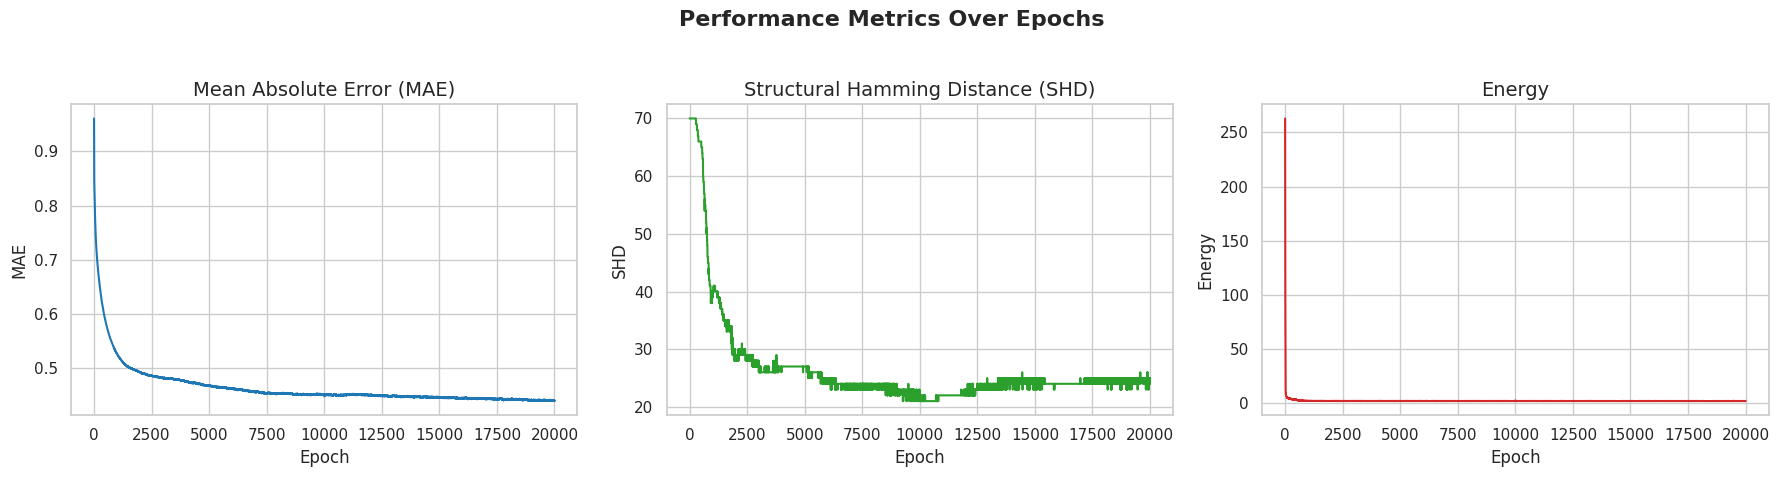

Is the estimated binary adjacency matrix a DAG? False
The h_reg term for the true weighted adjacency matrix W_true is: 0.0000
The h_reg term for the estimated weighted adjacency matrix W_est is: 0.3842
The first 5 rows and columns of the estimated weighted adjacency matrix W_est
[[0.     0.1669 0.303  0.048  0.0702]
 [1.6497 0.     0.4698 0.3936 0.2166]
 [0.5153 0.2059 0.     0.1402 0.0959]
 [1.8063 0.1952 0.3385 0.     0.1381]
 [0.3025 0.2541 0.9497 0.3299 0.    ]]


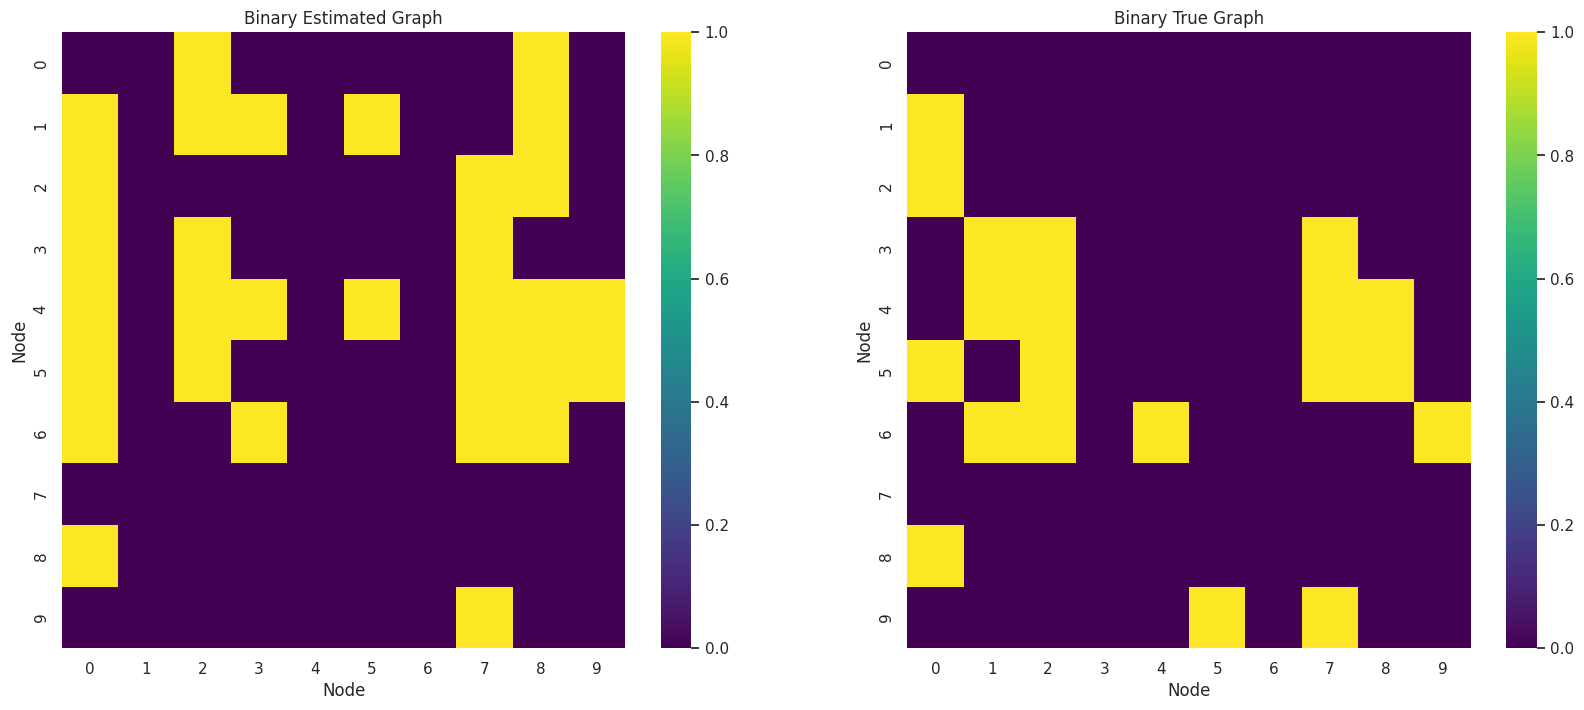

The number of edges in the true graph: 20.0
The number of edges in the estimated graph: 31


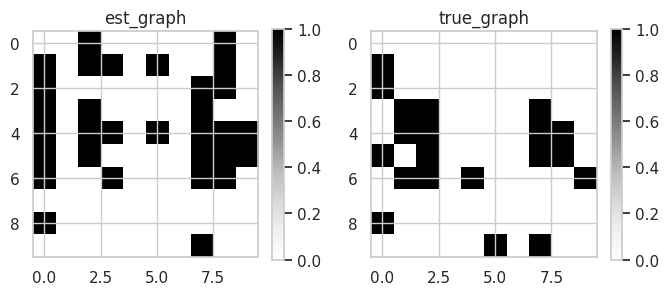

{'fdr': 0.6207, 'tpr': 0.55, 'fpr': 0.72, 'shd': 23, 'nnz': 29, 'precision': 0.3793, 'recall': 0.55, 'F1': 0.449, 'gscore': 0.0}


In [20]:
# Create plots directory if it doesn't exist
os.makedirs('plots', exist_ok=True)

# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("tab10")

# Create a figure and axis with a 1x3 layout for side-by-side plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjusting layout to 1 row and 3 columns
fig.suptitle('Performance Metrics Over Epochs', fontsize=16, weight='bold')

# Plot the MAE
sns.lineplot(x=range(len(MAEs)), y=MAEs, ax=axs[0], color=palette[0])
axs[0].set_title("Mean Absolute Error (MAE)", fontsize=14)
axs[0].set_xlabel("Epoch", fontsize=12)
axs[0].set_ylabel("MAE", fontsize=12)
axs[0].grid(True)

# Plot the SHD
sns.lineplot(x=range(len(SHDs)), y=SHDs, ax=axs[1], color=palette[2])
axs[1].set_title("Structural Hamming Distance (SHD)", fontsize=14)
axs[1].set_xlabel("Epoch", fontsize=12)
axs[1].set_ylabel("SHD", fontsize=12)
axs[1].grid(True)

# Plot the Energy
sns.lineplot(x=range(len(energies)), y=energies, ax=axs[2], color=palette[3])
axs[2].set_title("Energy", fontsize=14)
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_ylabel("Energy", fontsize=12)
axs[2].grid(True)

# Improve layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

# save the figure in the plots directory
fig.savefig('plots/performance_metrics.png', dpi=300)

# %%
# Now use a threshold of 0.3 to binarize the weighted adjacency matrix W
W_est = np.array(model.get_W())
B_est = compute_binary_adjacency(W_est, threshold=0.3)

# %%
# Check if B_est is indeed a DAG
def is_dag(adjacency_matrix):
    """
    Check if a given adjacency matrix represents a Directed Acyclic Graph (DAG).
    
    Parameters:
        adjacency_matrix (numpy.ndarray): A square matrix representing the adjacency of a directed graph.
        
    Returns:
        bool: True if the graph is a DAG, False otherwise.
    """
    # Create a directed graph from the adjacency matrix
    graph = nx.DiGraph(adjacency_matrix)
    
    # Check if the graph is a DAG
    return nx.is_directed_acyclic_graph(graph)

# Check if the estimated binary adjacency matrix B_est is a DAG
is_dag_B_est = is_dag(B_est)
print(f"Is the estimated binary adjacency matrix a DAG? {is_dag_B_est}")

# Define fucntion to compute h_reg based W with h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - d, here * denotes the hadamard product
def compute_h_reg(W):
    """This function computes the h_reg term based on the matrix W."""
    h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - W.shape[0]
    return h_reg

# Compute the h_reg term for the true weighted adjacency matrix W_true
h_reg_true = compute_h_reg(W_true)
print(f"The h_reg term for the true weighted adjacency matrix W_true is: {h_reg_true:.4f}")

# Compute the h_reg term for the estimated weighted adjacency matrix W_est
h_reg_est = compute_h_reg(W_est)
print(f"The h_reg term for the estimated weighted adjacency matrix W_est is: {h_reg_est:.4f}")

# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print("The first 5 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:5, :5]))

# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(true_matrix=B_true, est_matrix=B_est, save_path='plots/adjacency_matrices.png')

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the true graph: {np.sum(B_true)}")
print(f"The number of edges in the estimated graph: {np.sum(B_est)}")

# %%
# plot est_dag and true_dag
GraphDAG(B_est, B_true, save_name='plots/est_dag_true_dag.png')
# calculate accuracy
met_pcx = MetricsDAG(B_est, B_true)
print(met_pcx.metrics)